# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/1014rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/1015rep_50noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/1016rep_50noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.311391        0.189927  0.048388  0.295999  0.020291   
       0.25   0.288169        0.183172  0.055065  0.240864  0.070961   
       0.50   0.307756        0.194813  0.057340  0.239210  0.098771   
       0.75   0.338612        0.186509  0.064592  0.210419  0.122927   
       1.00   0.309661        0.173118  0.080808  0.177525  0.147802   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201482  0.010319  0.040935  0.051328  0.000000  
       0.25  0.183500  0.009765  0.038369  0.049151  0.000637  
       0.50  0.199910  0.009447  0.039245  0.051988  0.001452  
       0.75  0.202789  0.007846  0.036108  0.052103  0.002424  
       1.00  0.209037  0.007173  0.038778  0.046110  0.003399

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.285361        0.203451  0.053860  0.318371  0.020249   
       0.25   0.303970        0.202768  0.054144  0.255852  0.065447   
       0.50   0.311419        0.193434  0.062980  0.218129  0.090822   
       0.75   0.300018        0.206707  0.071904  0.202362  0.128714   
       1.00   0.317564        0.163661  0.077625  0.174937  0.141294   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202172  0.009839  0.040488  0.049874  0.000000  
       0.25  0.206021  0.010718  0.037145  0.048449  0.000589  
       0.50  0.223734  0.009240  0.037428  0.048557  0.001586  
       0.75  0.210758  0.007717  0.037750  0.045304  0.002309  
       1.00  0.208210  0.007162  0.037766  0.051536  0.003630

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.307520        0.208194  0.051695  0.316037  0.018968   
       0.25   0.318936        0.189701  0.057546  0.237189  0.071454   
       0.50   0.308453        0.169807  0.063584  0.231334  0.102456   
       0.75   0.337558        0.194610  0.069294  0.192815  0.126065   
       1.00   0.299867        0.178170  0.077289  0.165448  0.128814   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.212359  0.010137  0.040349  0.053594  0.000000  
       0.25  0.188316  0.009657  0.038033  0.051782  0.000546  
       0.50  0.207544  0.008647  0.036413  0.050315  0.001533  
       0.75  0.205349  0.008257  0.038775  0.045797  0.002493  
       1.00  0.201165  0.006842  0.037890  0.049281  0.003652

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25   0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50   0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75   0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00   0.280318        0.169336  0.092565  0.173153  0.141149   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.205338  0.010099  0.040591  0.051599  0.000000  
         0.25  0.192610  0.010051  0.037849  0.049991  0.000389  
         0.50  0.210385  0.009133  0.037694  0.050805  0.001007  
         0.75  0.206264  0.008000  0.037534  0.048578  0.001597  
         1.00  0.206056  0.007187  0.038110  0.050238  0.002370

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.975196e+01  3.983424e+01      37.940737  5.956960e+01   
         0.25  4.701158e+06  2.310954e+06  211997.751938  1.441237e+06   
         0.50  5.502124e+06  3.575914e+06  336670.247783  2.170702e+06   
         0.75  5.623466e+06  4.247346e+06  427538.841201  2.825850e+06   
         1.00  5.955090e+06  4.539072e+06  458559.398350  2.920864e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.381417  5.593531e+01  5.601897e+01      18.963723   
         0.25  460875.044420  2.322661e+06  2.503681e+06  435277.872487   
         0.50  723179.835431  3.919590e+06  3.198510e+06  671401.032311   
         0.75  939479.688491  4.754849e+06  3.623287e+06  802939.509378   
         1.00  957828.217514  5.359746e+06  3.869362e+06  799052.975909   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         31.311180  
         0.25     174203.542252  
         0.50     283003.335320  
         0.75     360327.161466  
         1.00     412130.976782

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


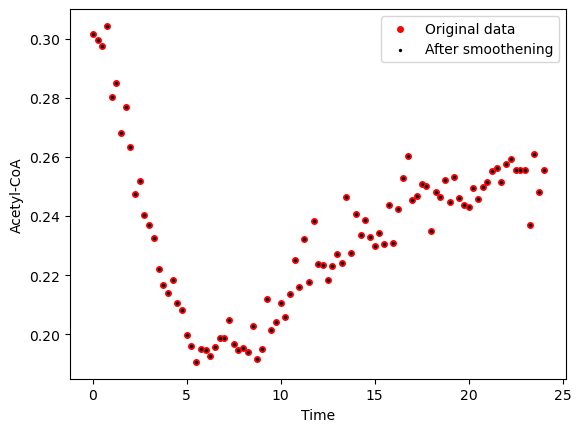

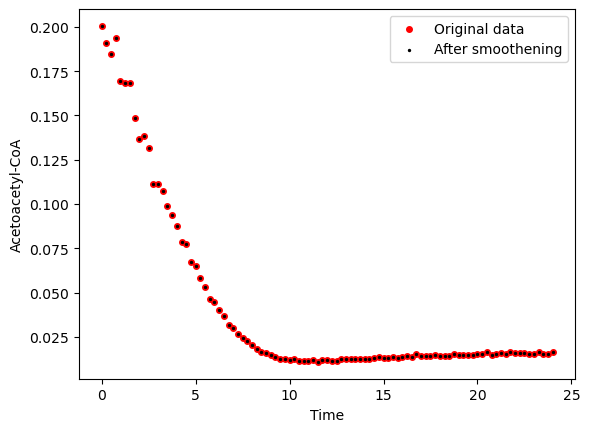

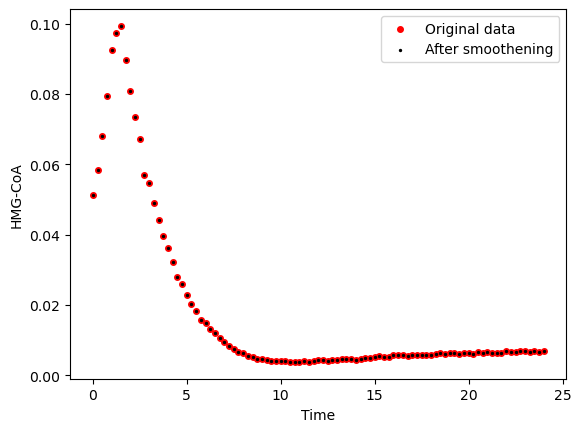

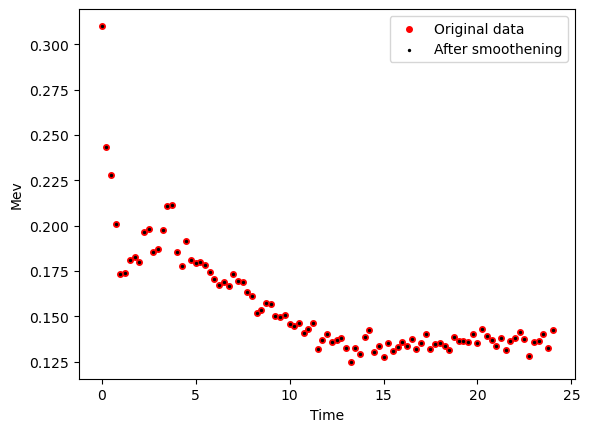

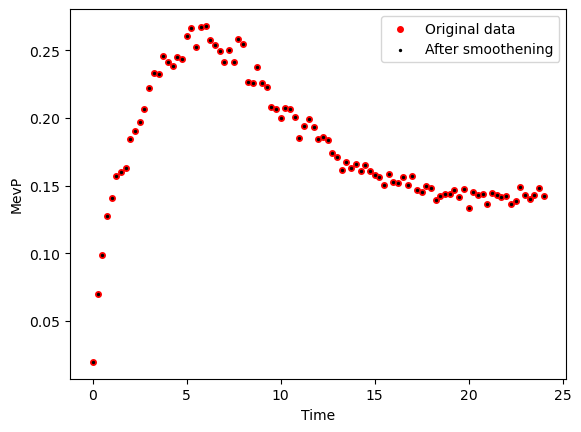

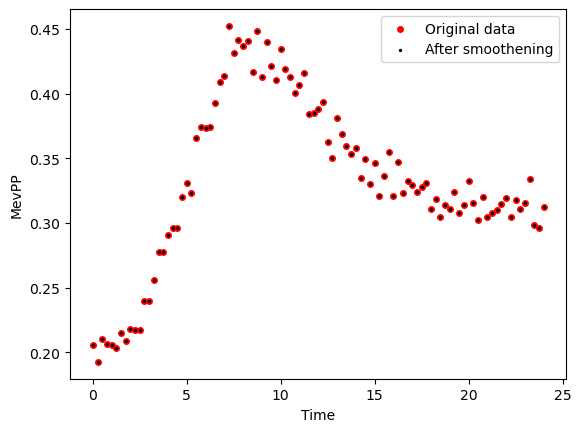

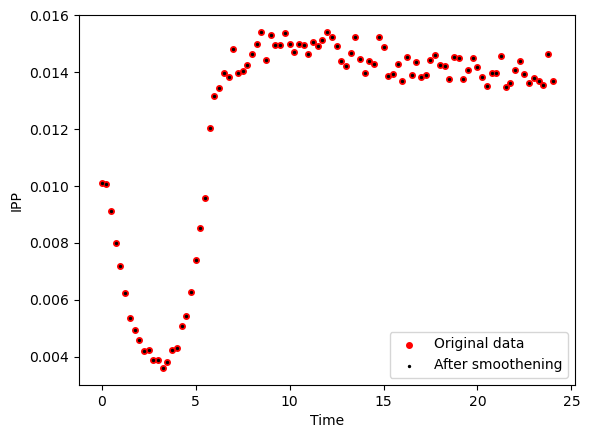

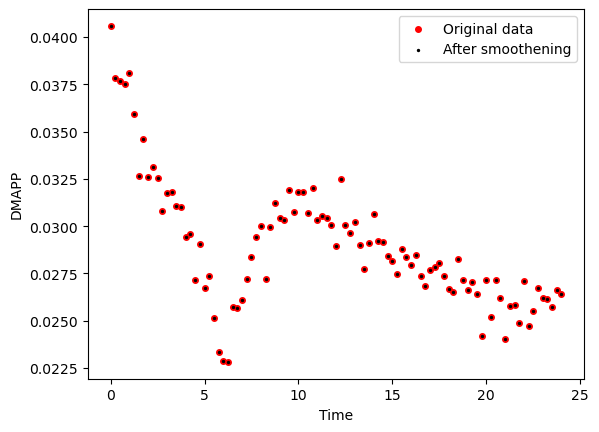

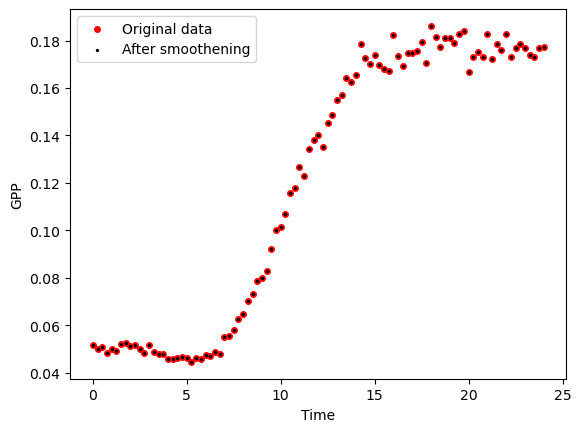

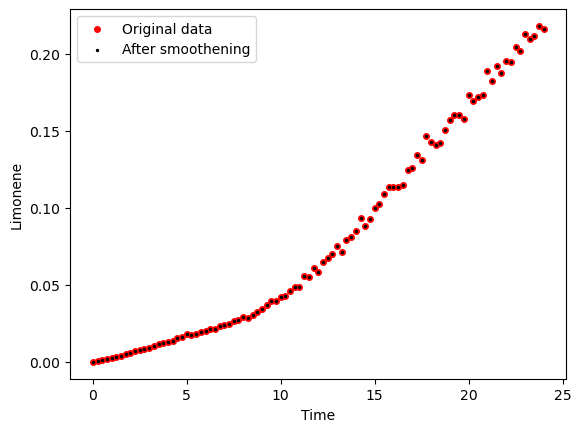

Strain Strain 2


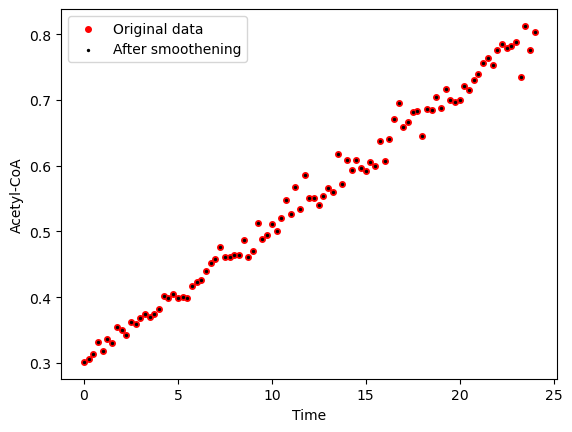

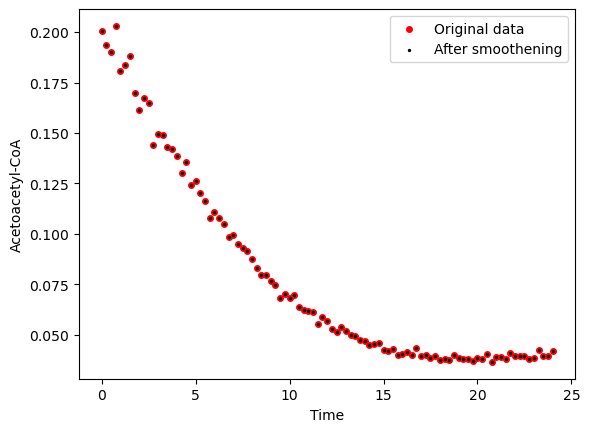

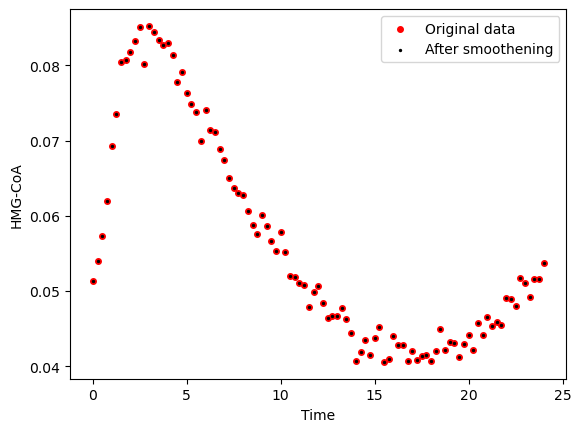

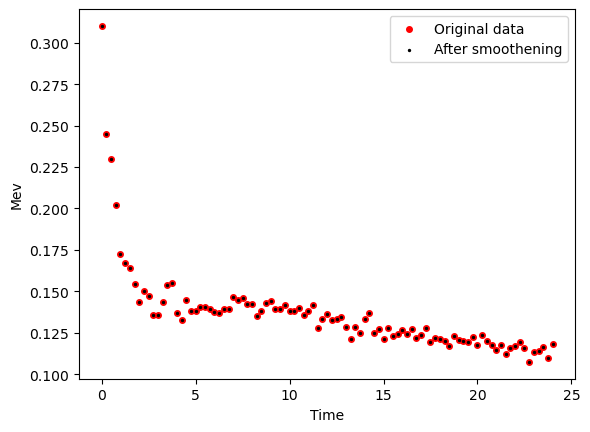

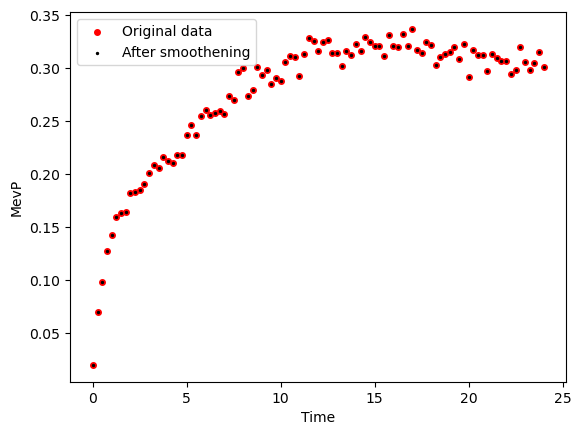

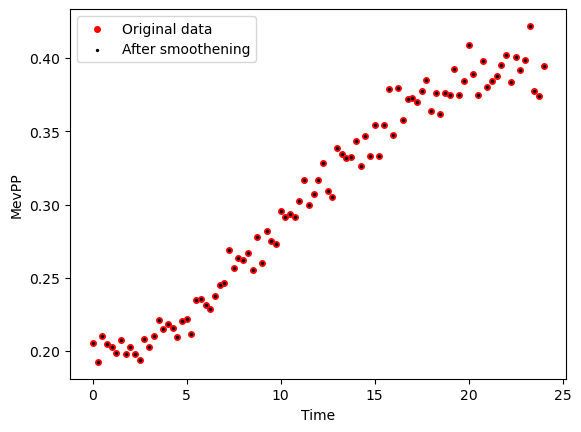

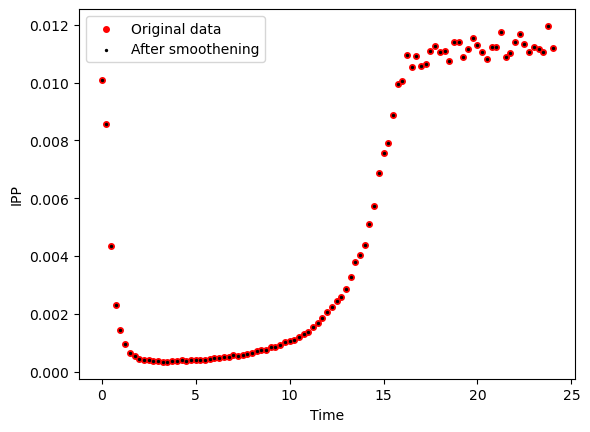

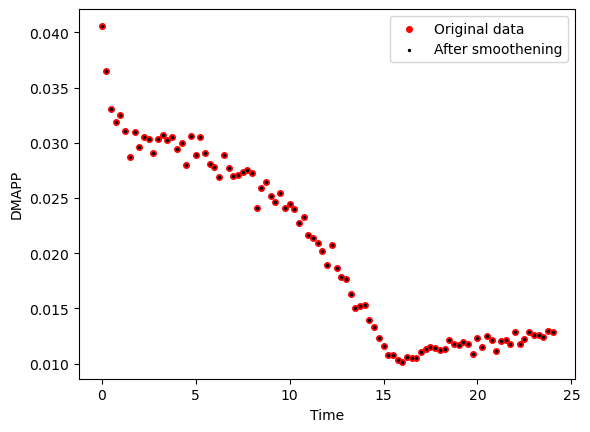

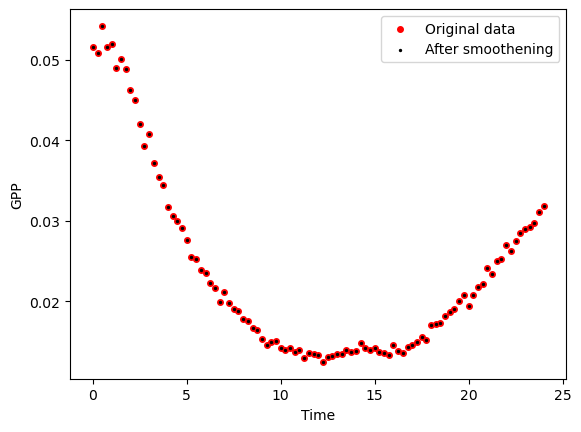

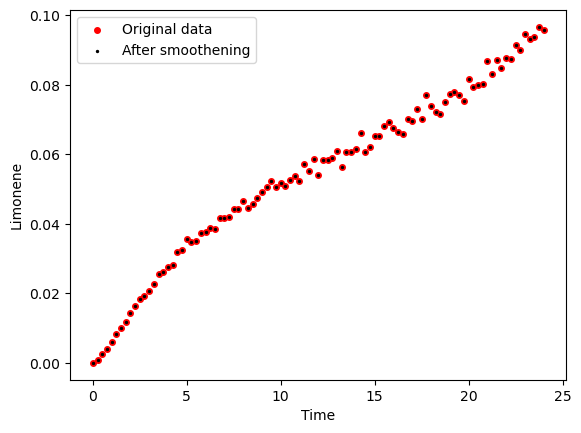

Strain Strain 3


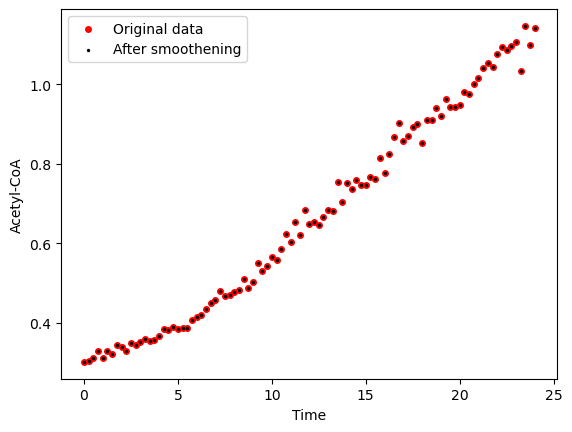

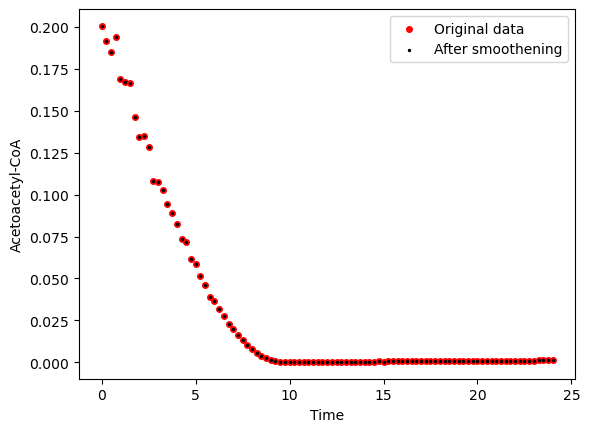

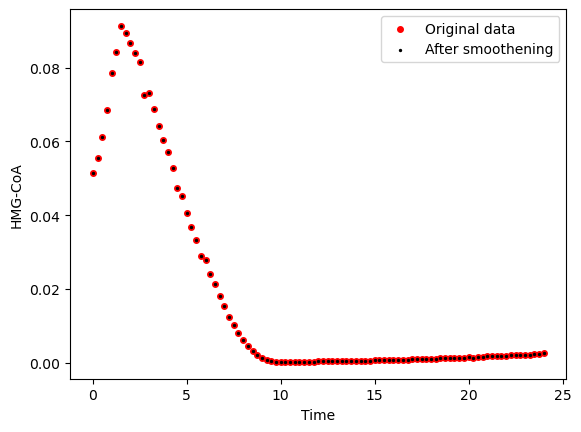

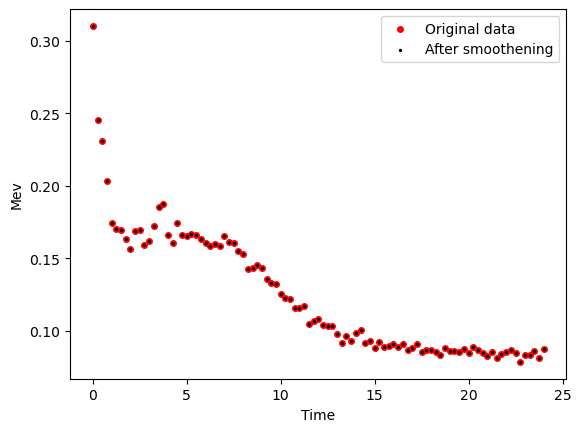

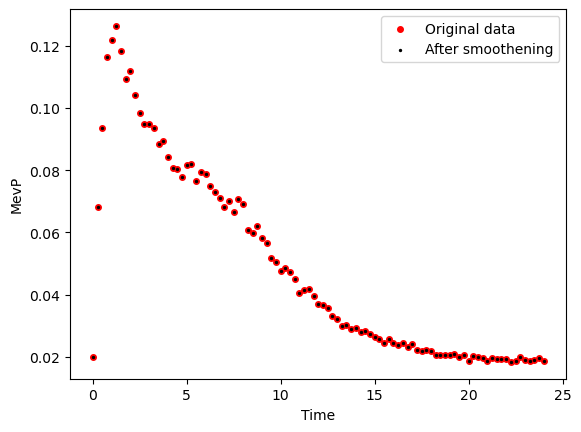

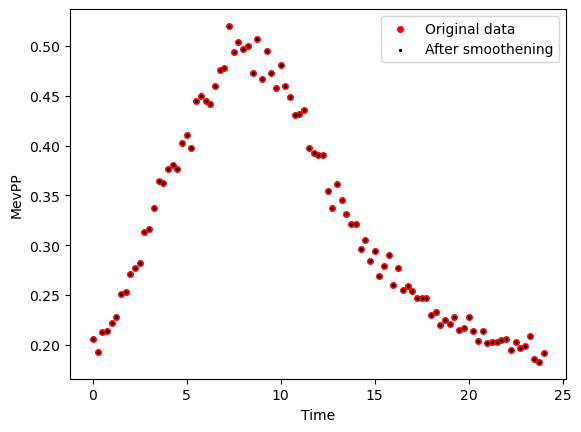

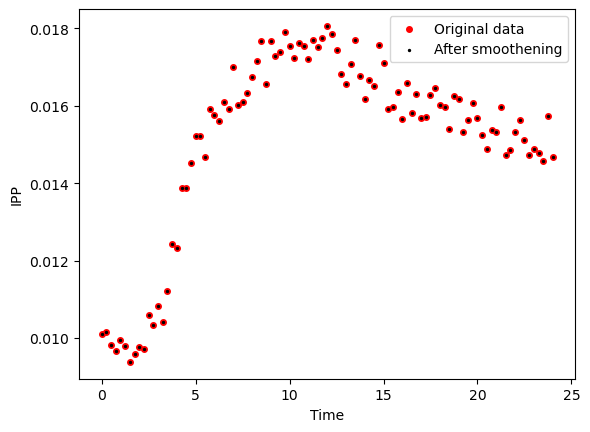

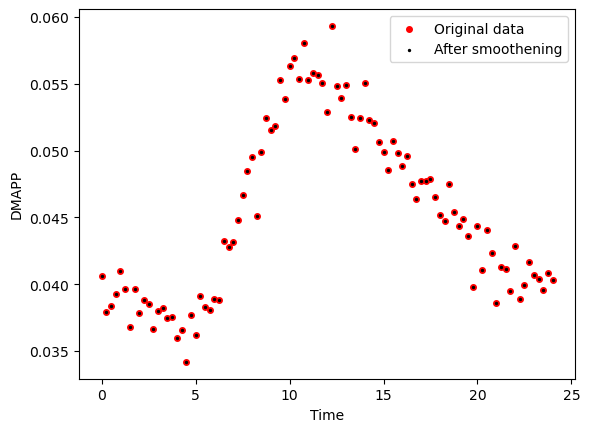

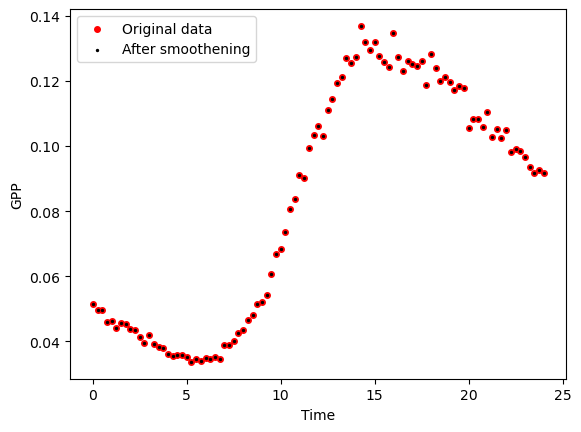

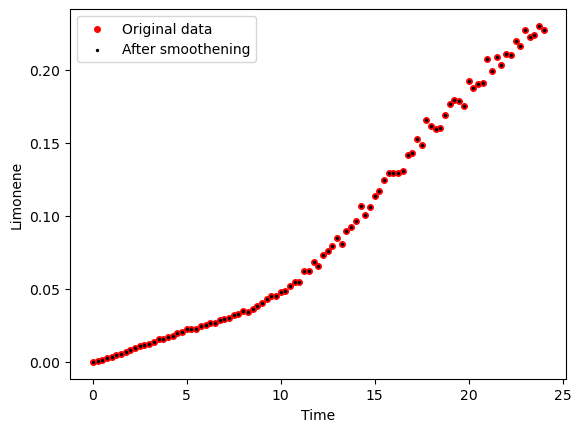

Strain WT


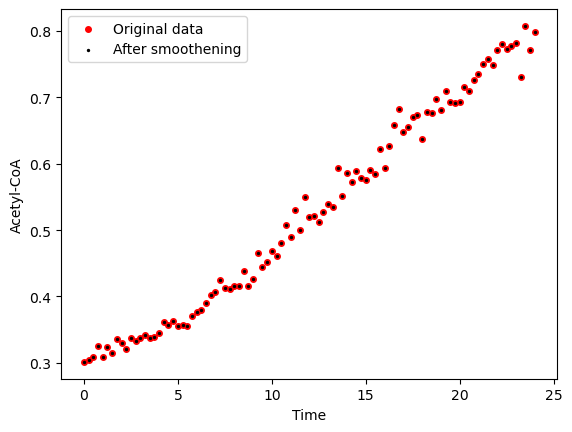

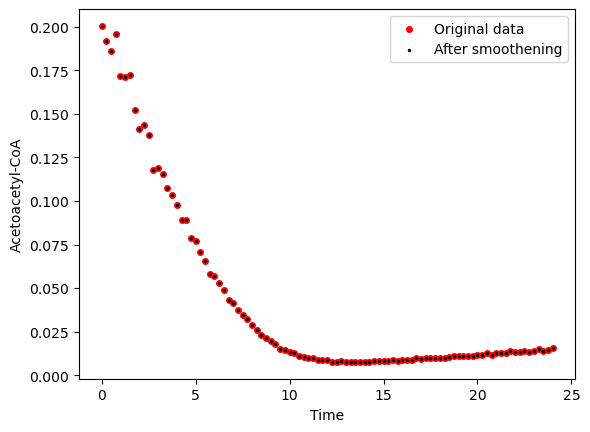

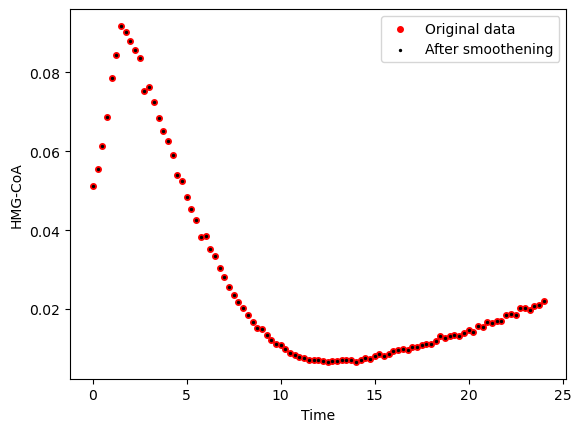

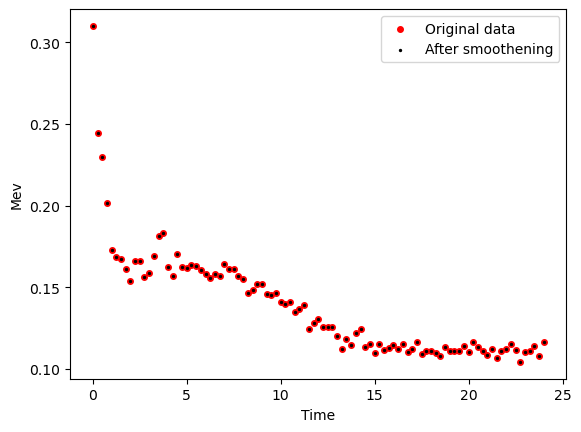

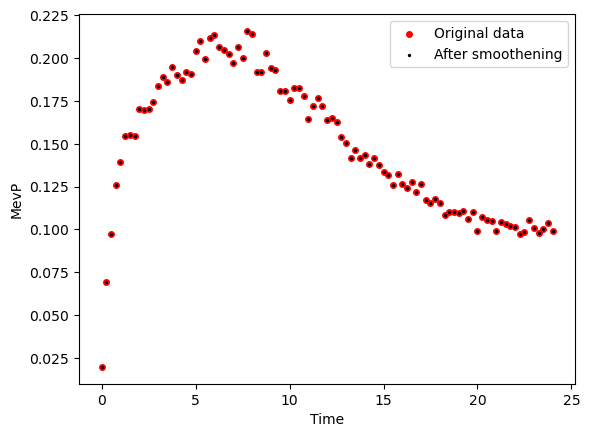

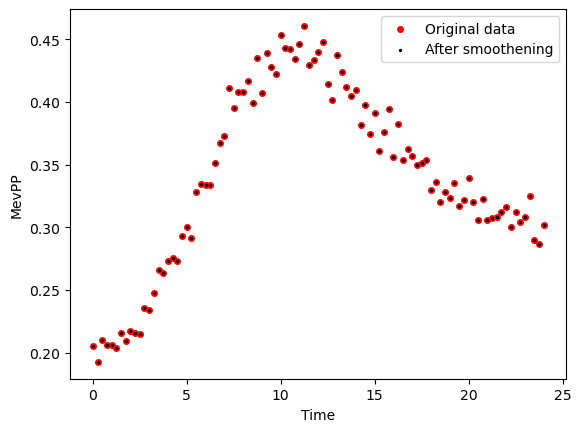

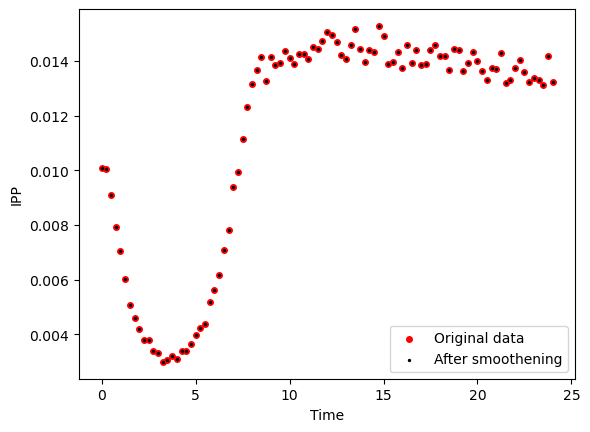

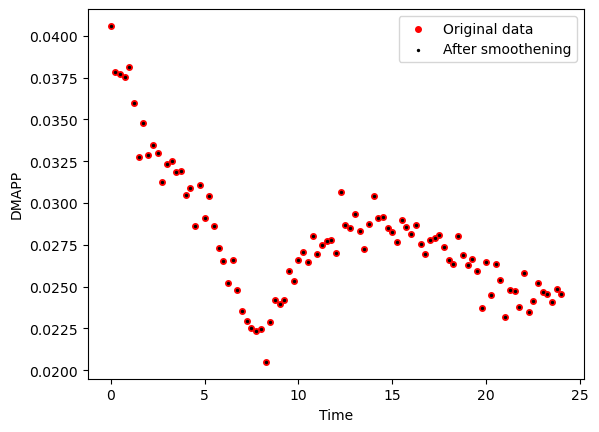

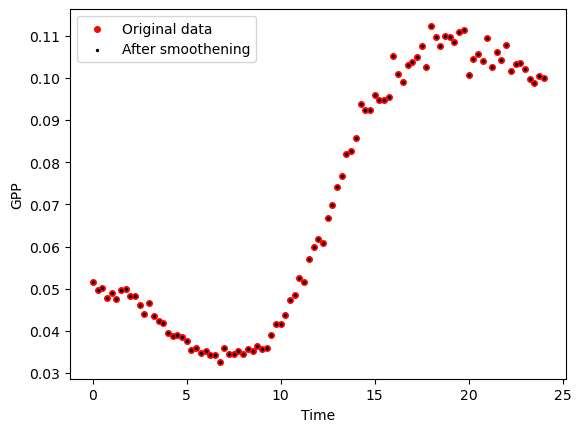

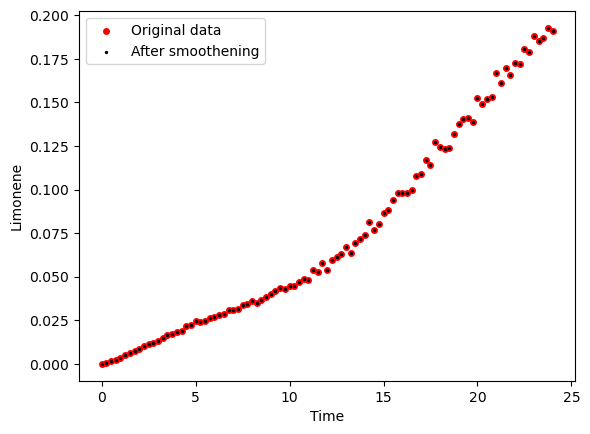

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


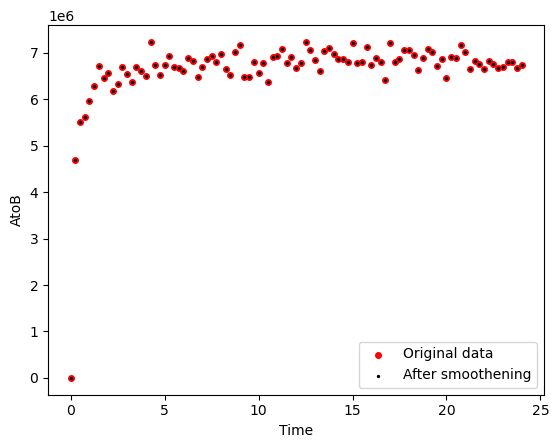

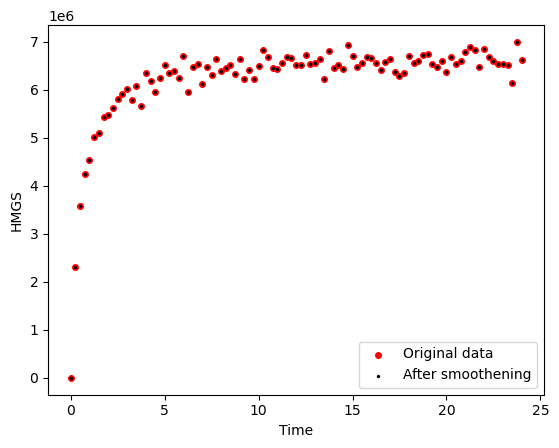

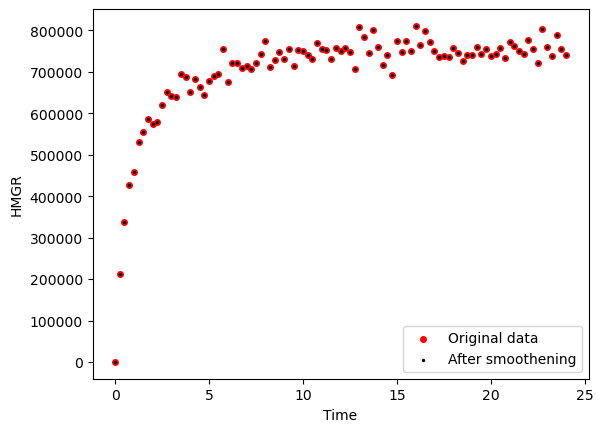

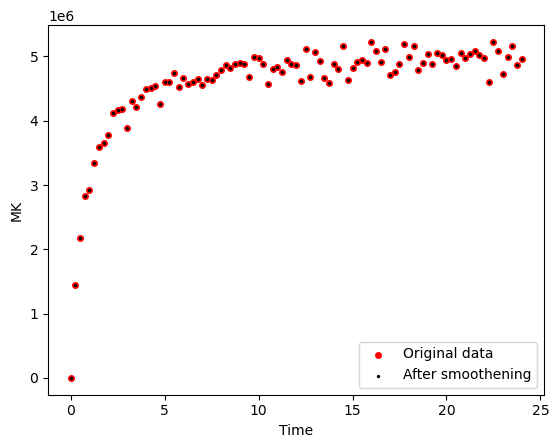

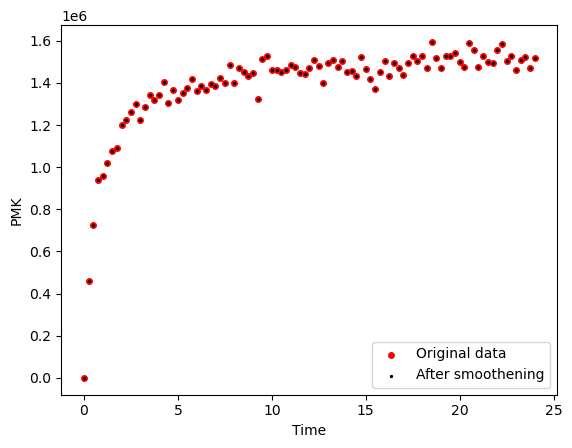

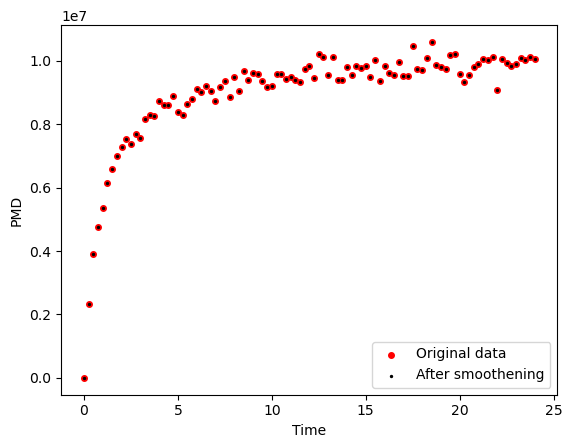

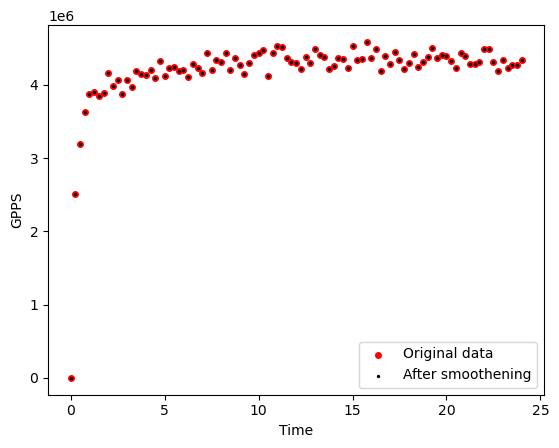

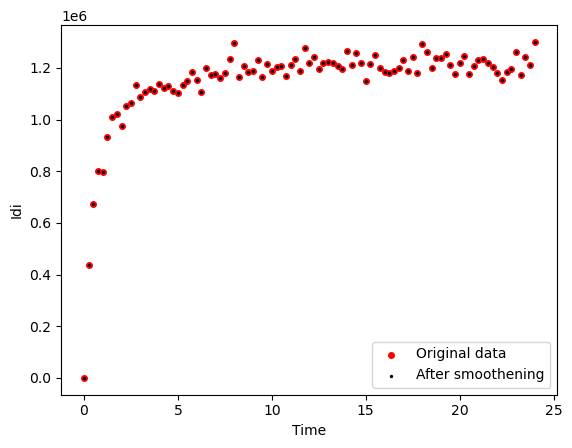

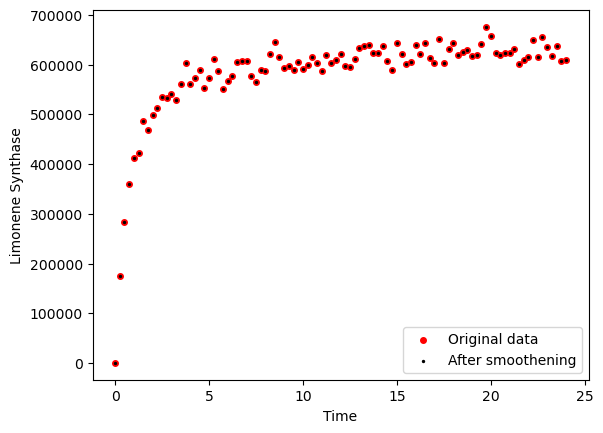

Strain Strain 2


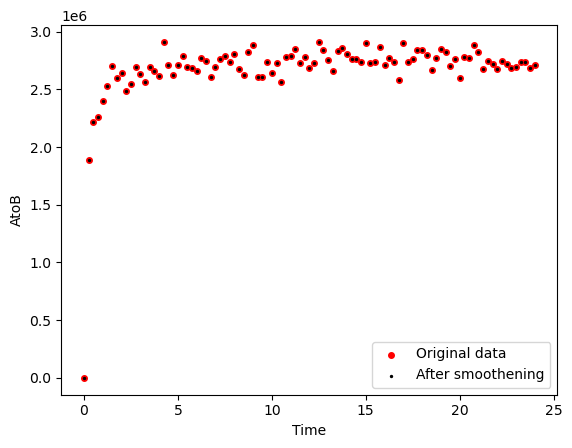

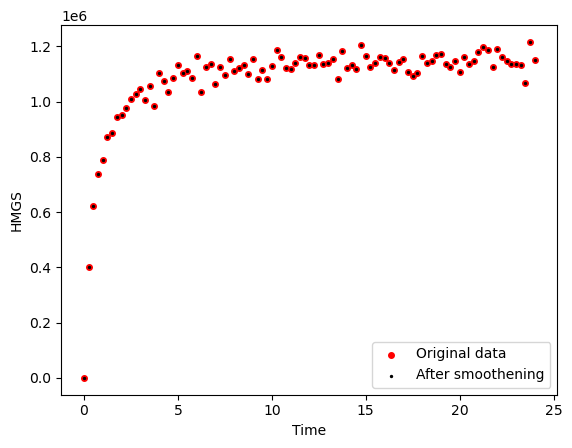

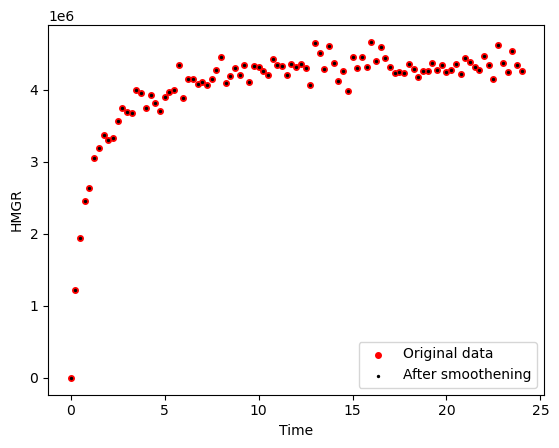

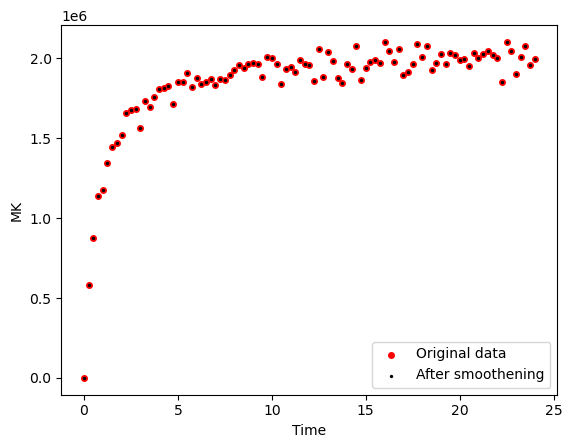

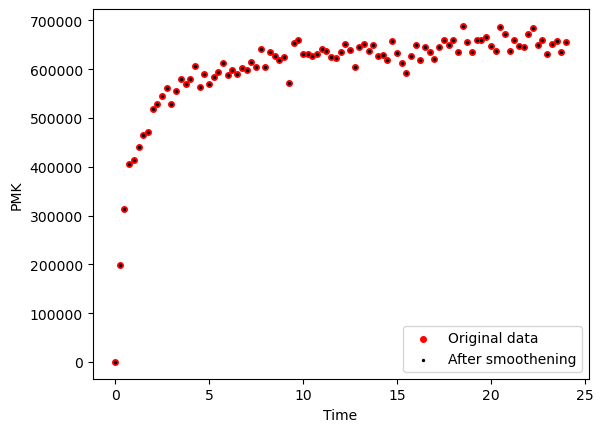

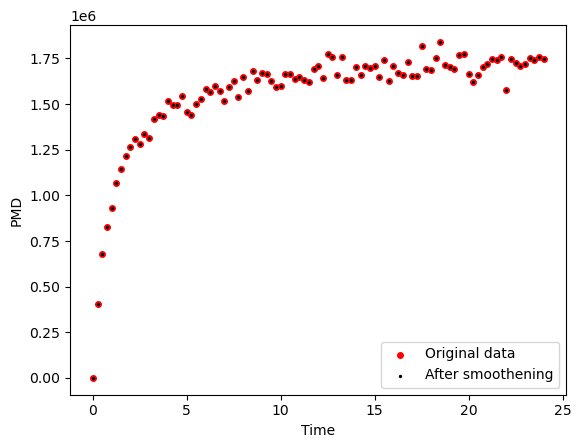

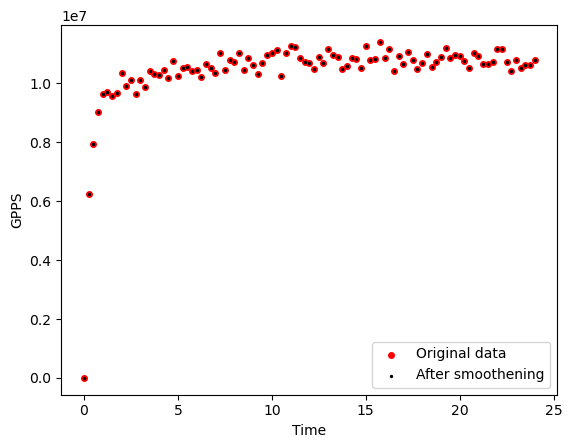

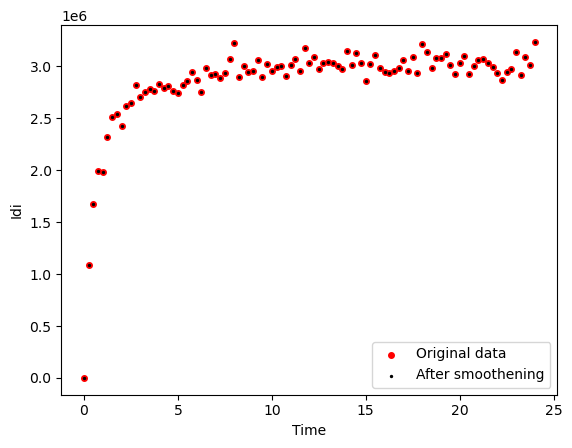

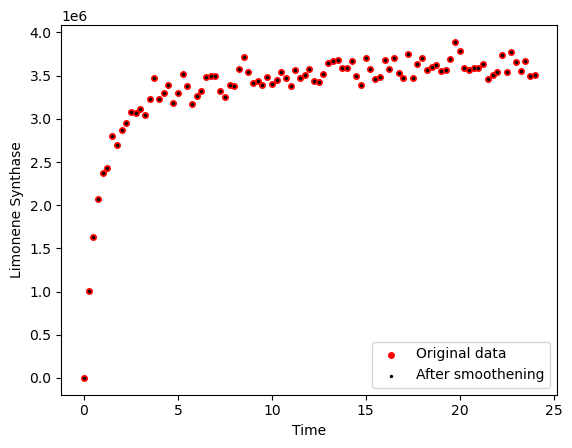

Strain Strain 3


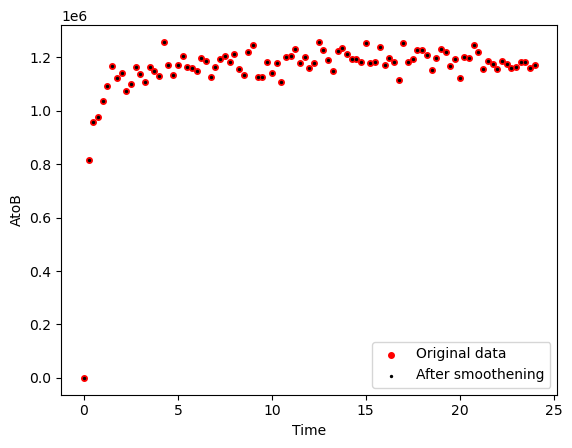

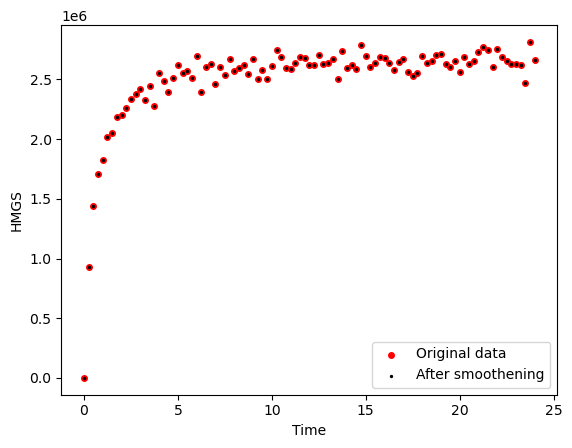

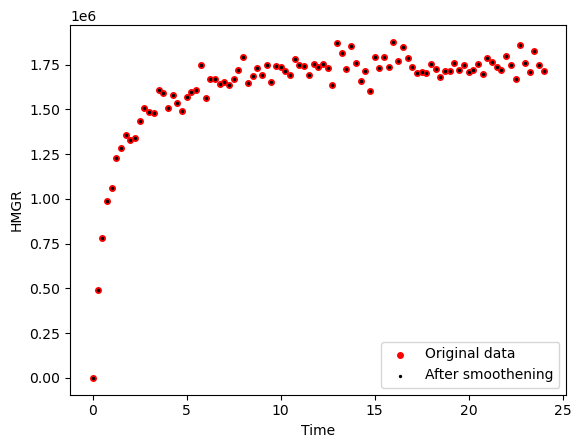

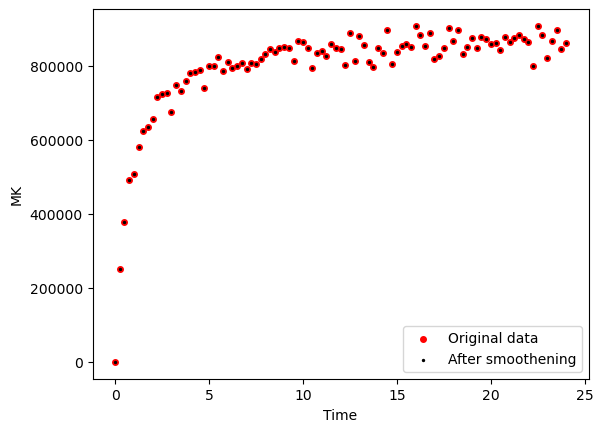

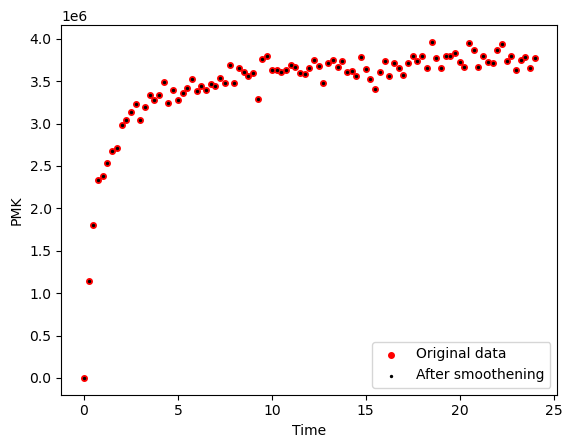

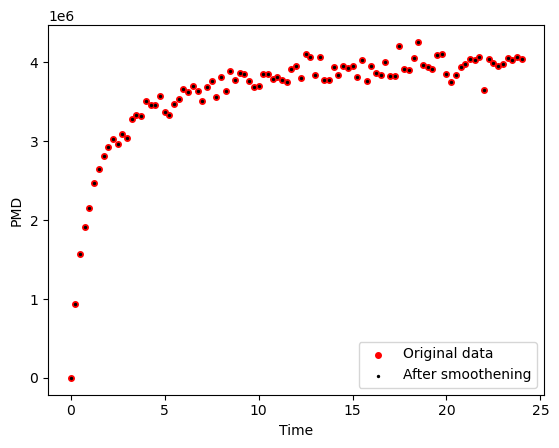

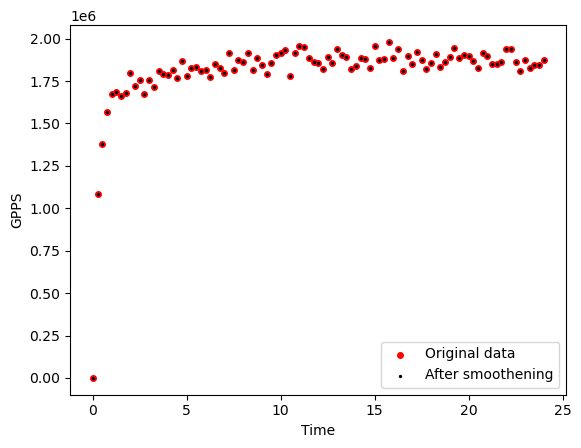

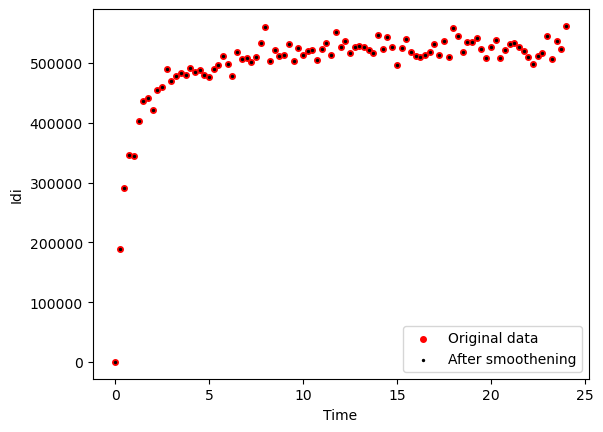

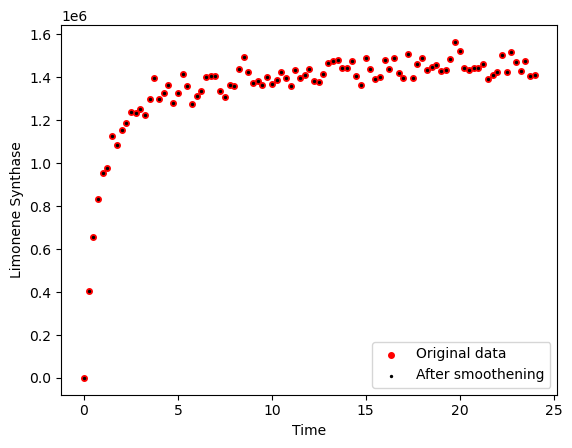

Strain WT


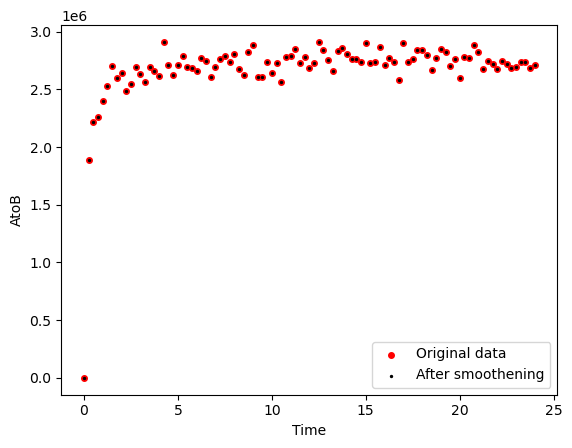

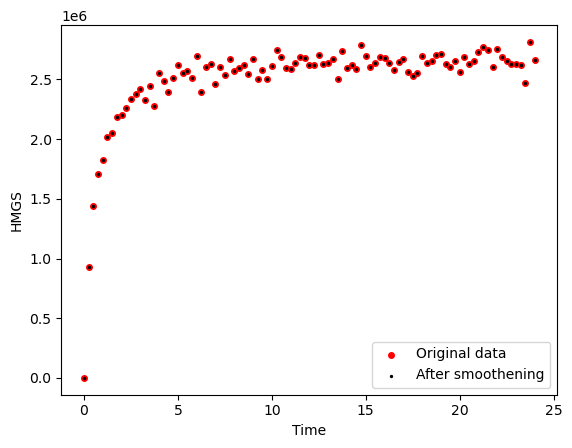

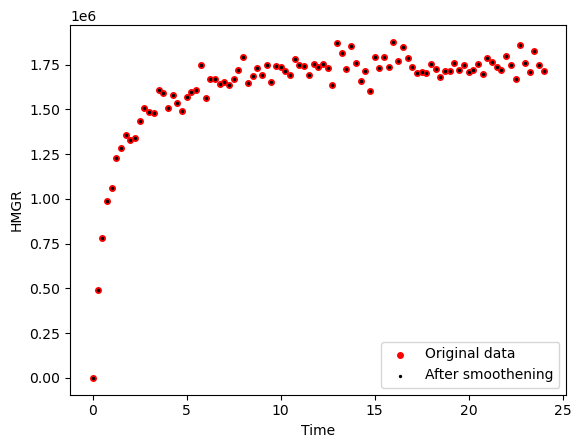

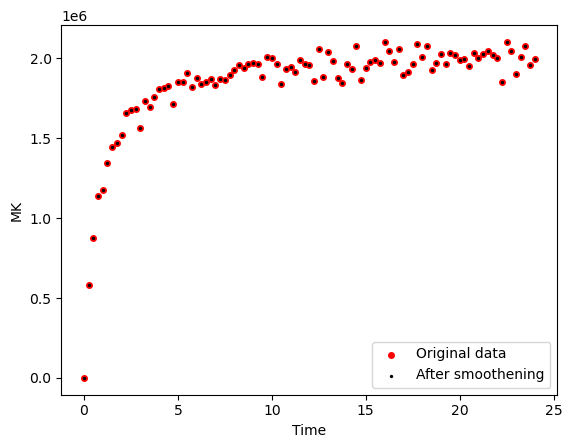

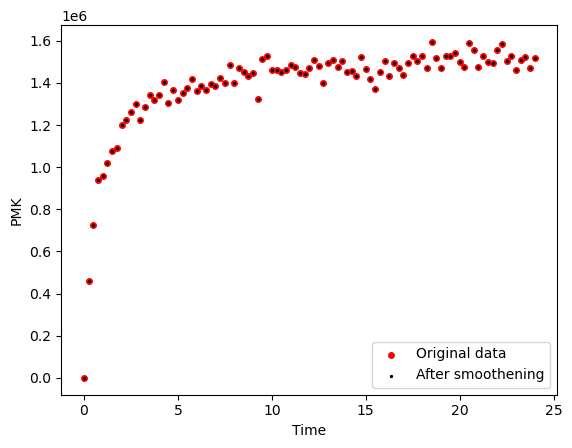

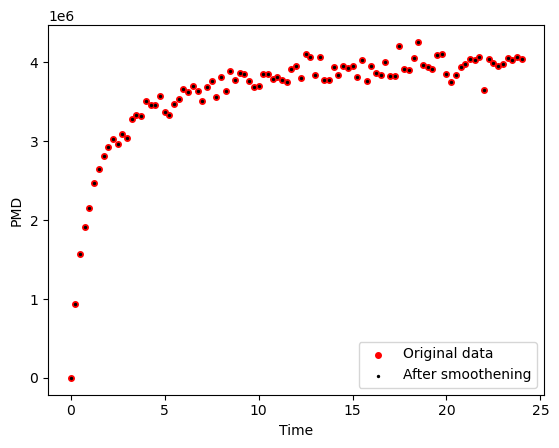

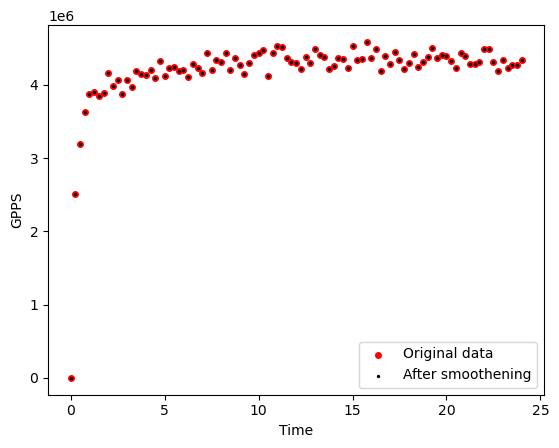

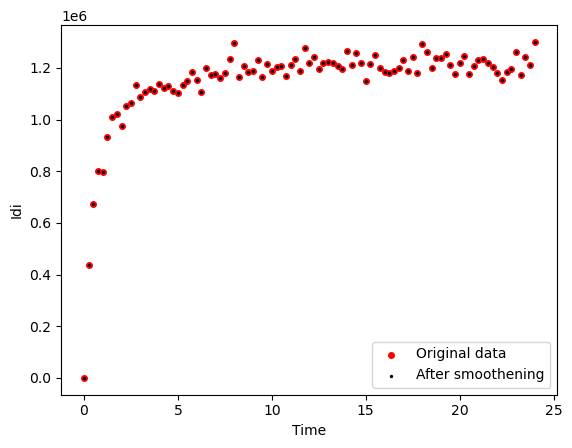

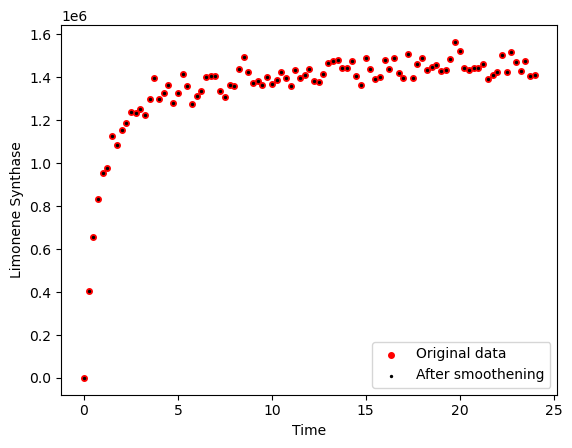

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.301424        0.200524  0.051314  0.310136  0.019836   
         0.25    0.299408        0.190985  0.058277  0.243627  0.070315   
         0.50    0.297438        0.184590  0.067947  0.228141  0.098678   
         0.75    0.304250        0.193897  0.079336  0.200724  0.127477   
         1.00    0.280318        0.169336  0.092565  0.173153  0.141149   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.782637        0.013612  0.020194  0.110700  0.100811   
         23.25   0.730114        0.015073  0.019702  0.111253  0.098169   
         23.50   0.807687        0.014126  0.020858  0.114335  0.100407   
         23.75   0.771875        0.014278  0.021028  0.108200  0.103659   
         24.00   0.799248        0.015356  0.022089  0.116762  0.099316   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.205338  0.010099  0.040591  0.051599  0.000000  ...   
         0.25   0.192610  0.010051  0.037849  0.049991  0.000389  ...   
         0.50   0.210385  0.009133  0.037694  0.050805  0.001007  ...   
         0.75   0.206264  0.008000  0.037534  0.048578  0.001597  ...   
         1.00   0.206056  0.007187  0.038110  0.050238  0.002370  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308112  0.013389  0.024654  0.102204  0.188206  ...   
         23.25  0.325012  0.013297  0.024542  0.099855  0.185345  ...   
         23.50  0.290028  0.013134  0.024060  0.098761  0.187031  ...   
         23.75  0.286436  0.014177  0.024867  0.100346  0.192756  ...   
         24.00  0.301704  0.013241  0.024581  0.100009  0.191171  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

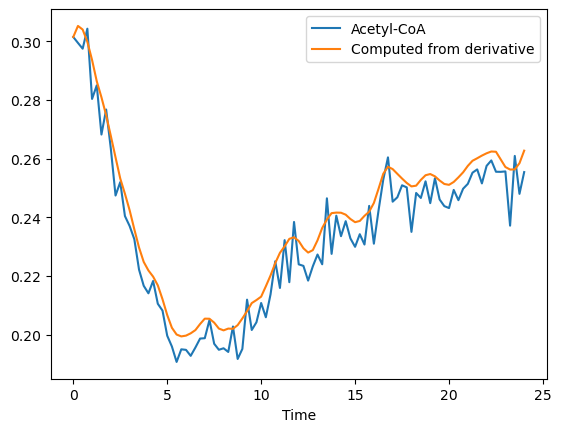

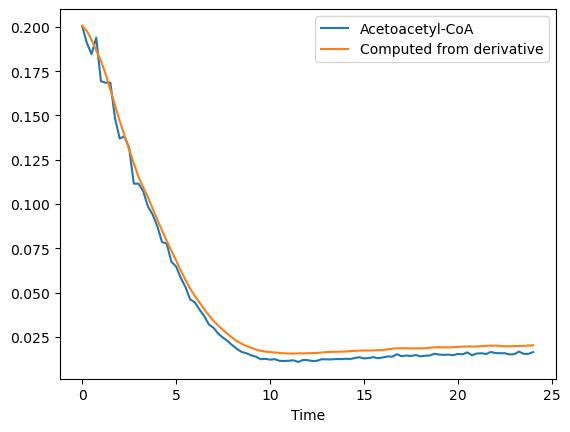

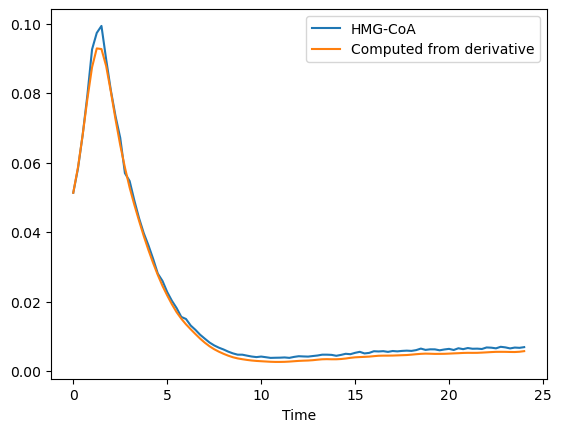

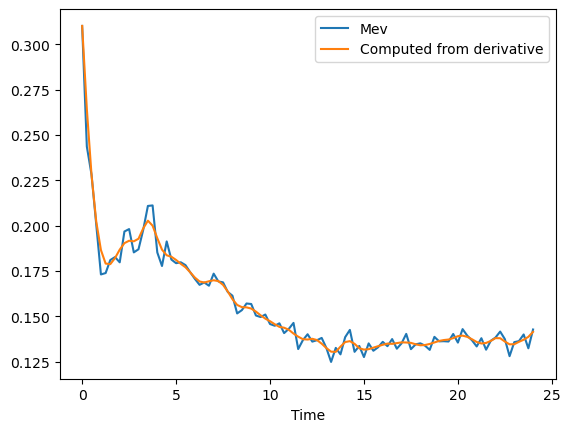

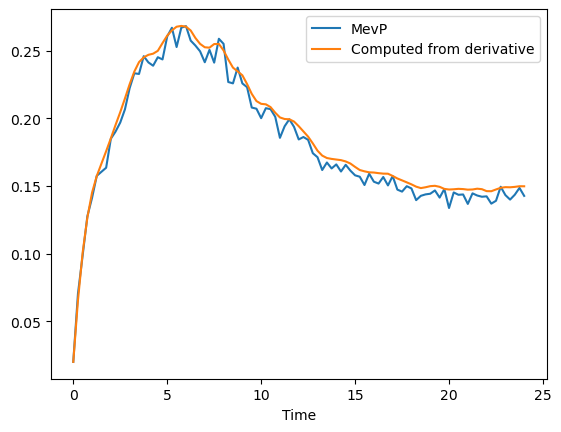

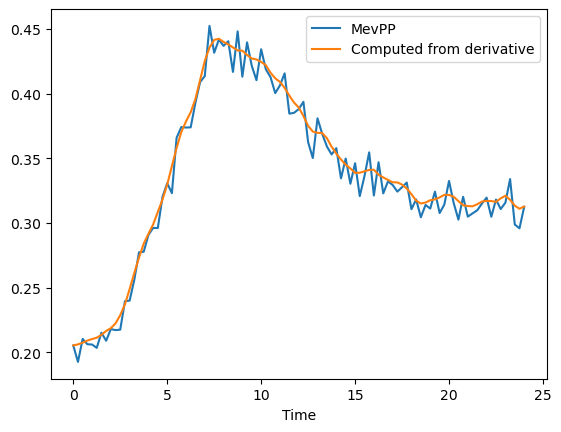

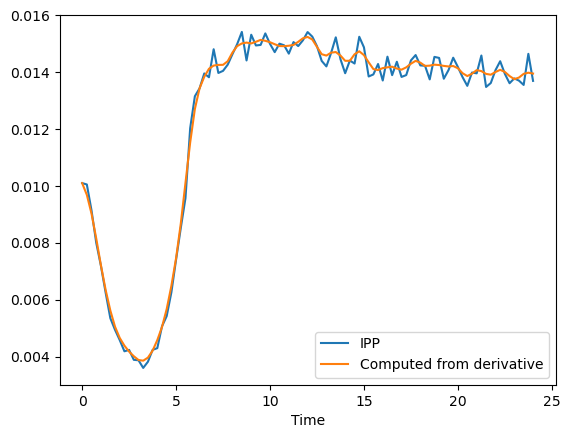

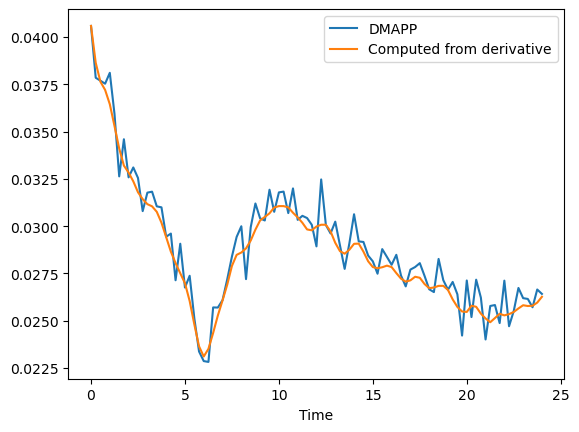

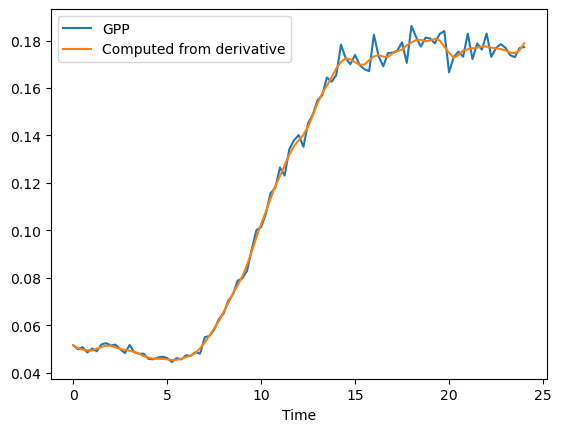

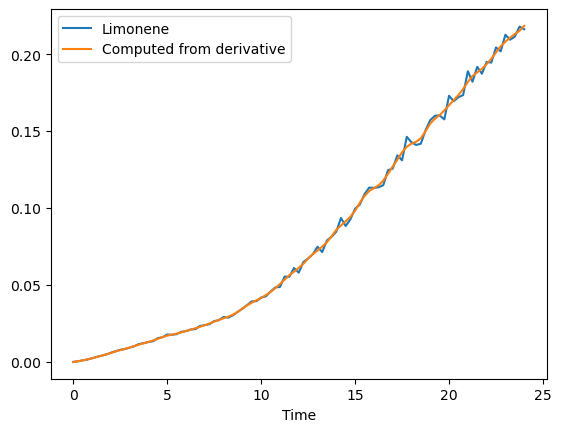

'Time profile from derivative vs. actual profile for Strain 2'

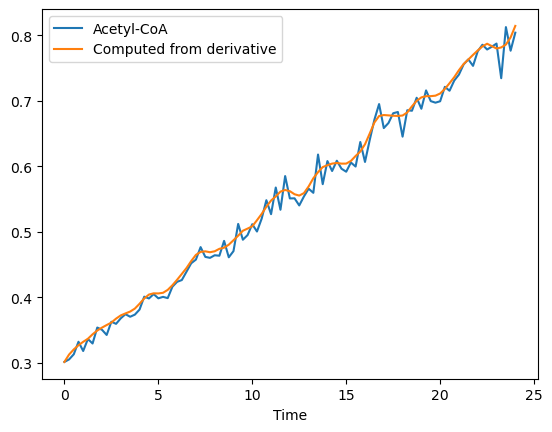

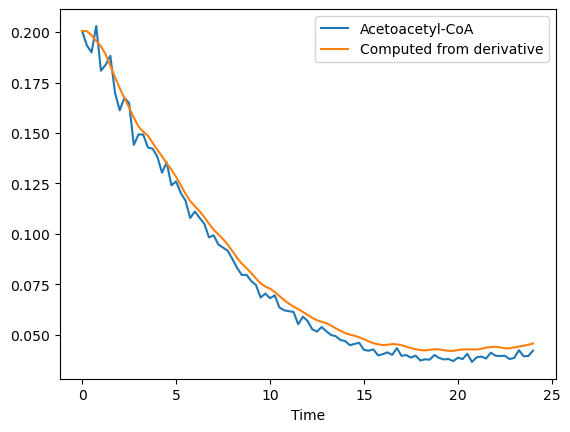

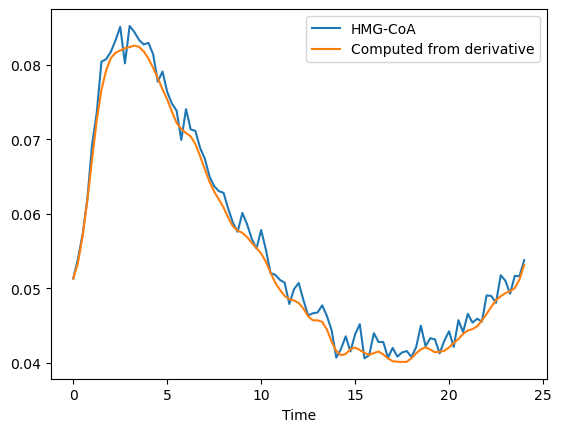

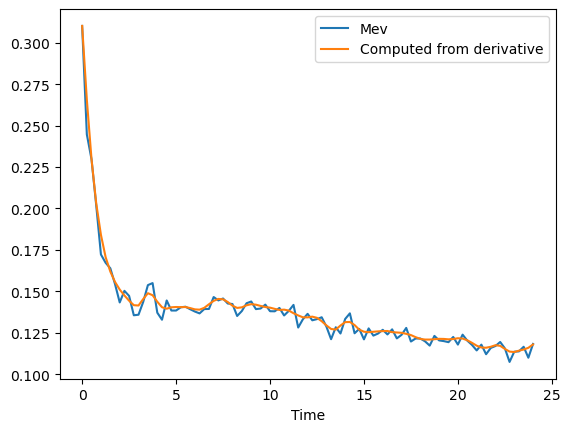

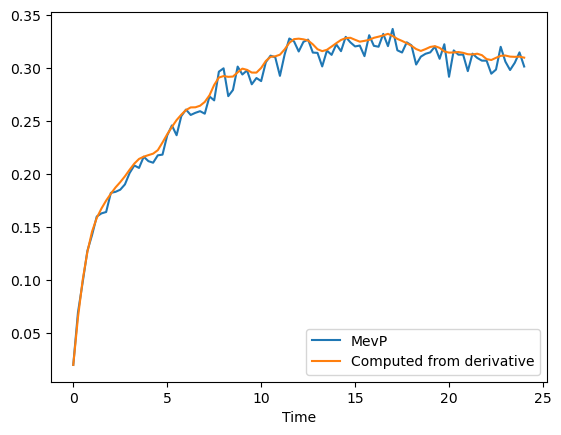

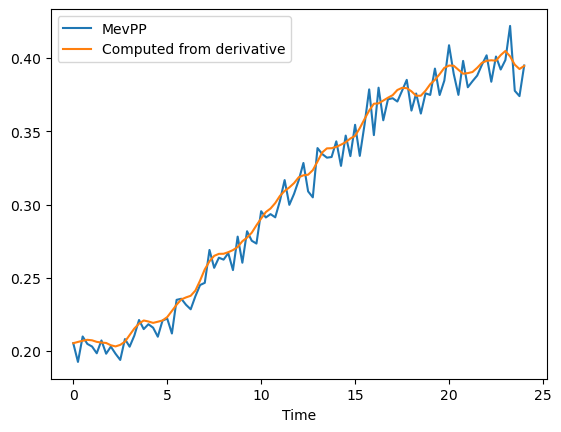

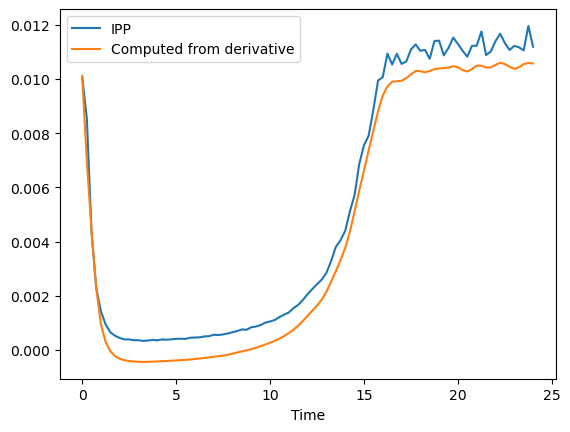

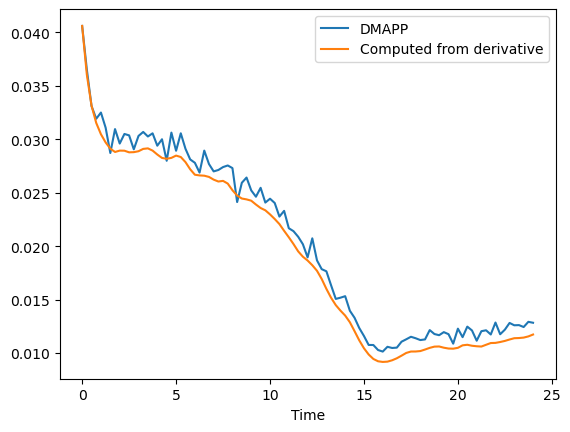

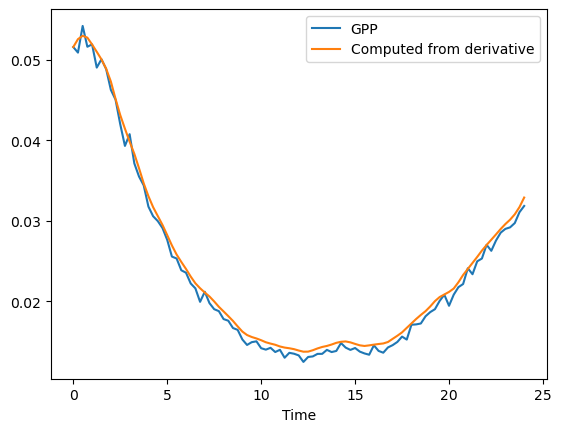

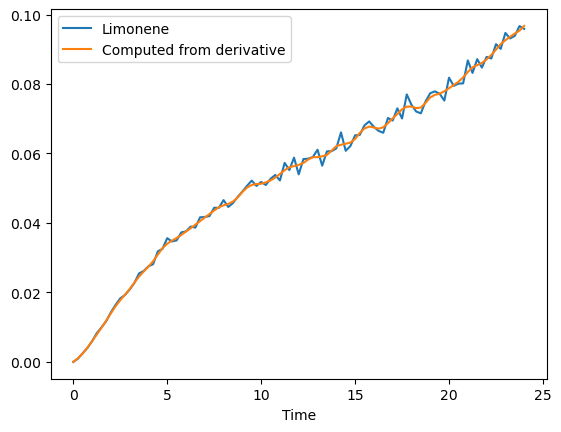

'Time profile from derivative vs. actual profile for Strain 3'

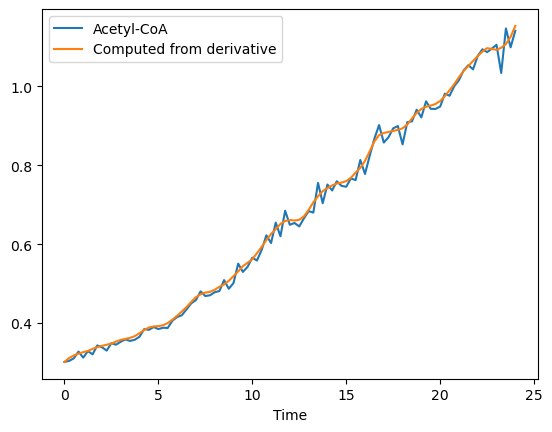

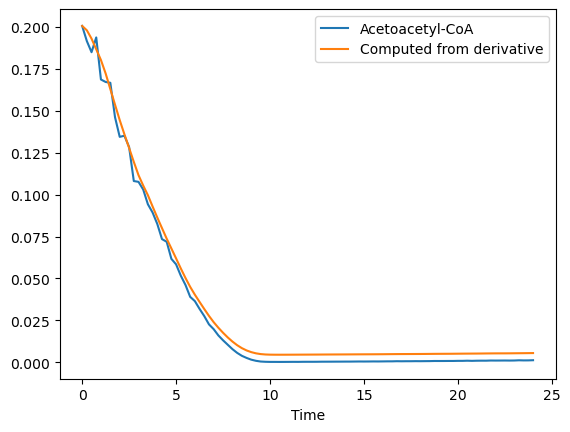

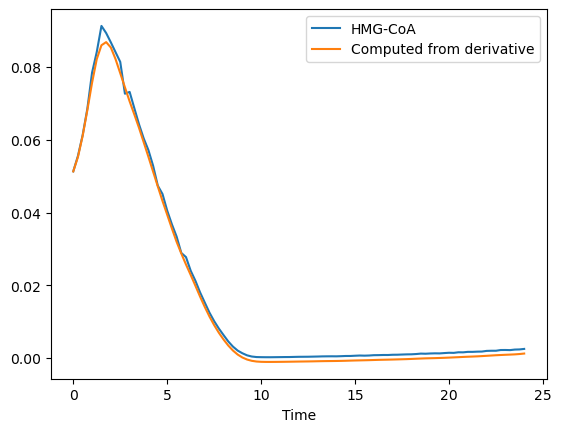

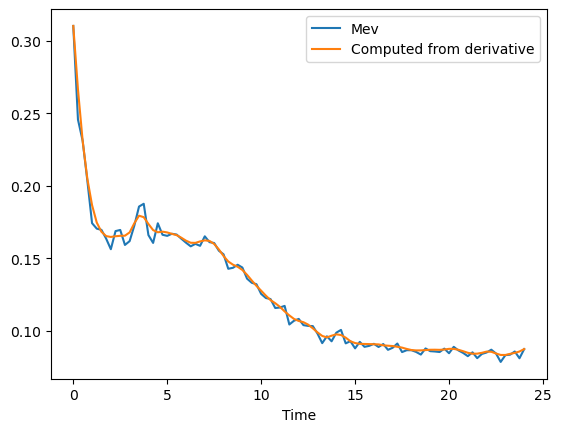

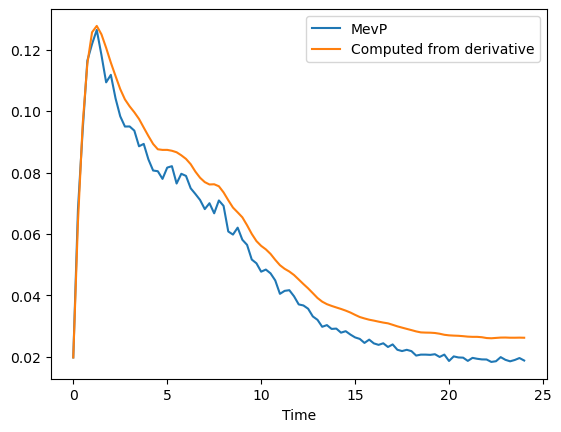

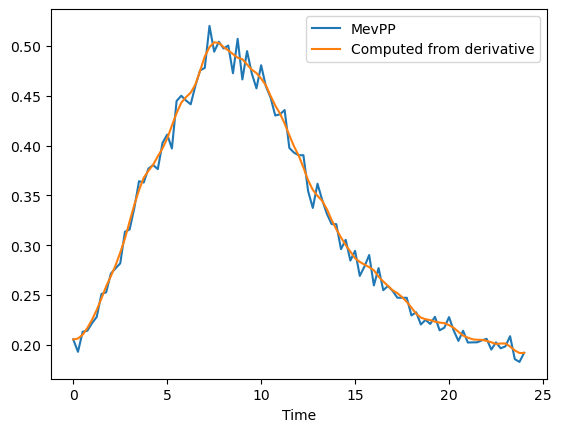

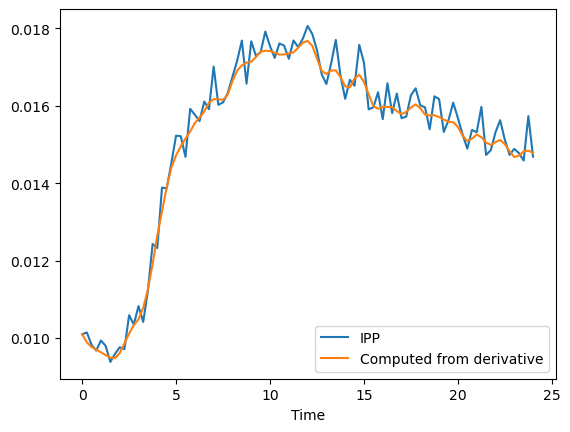

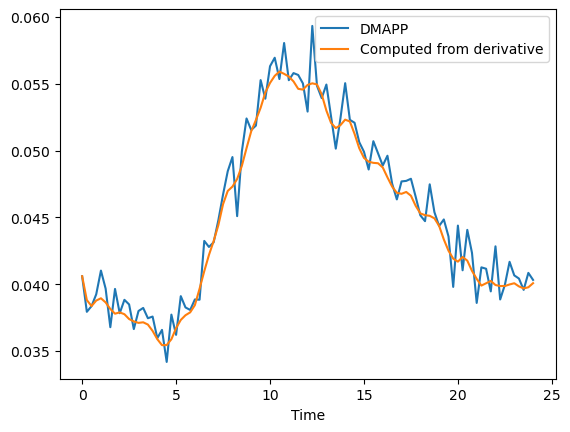

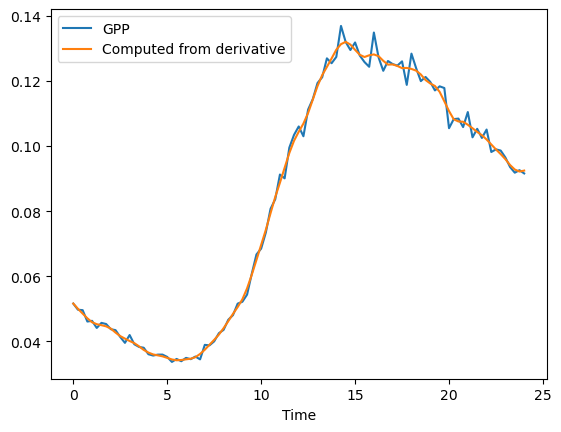

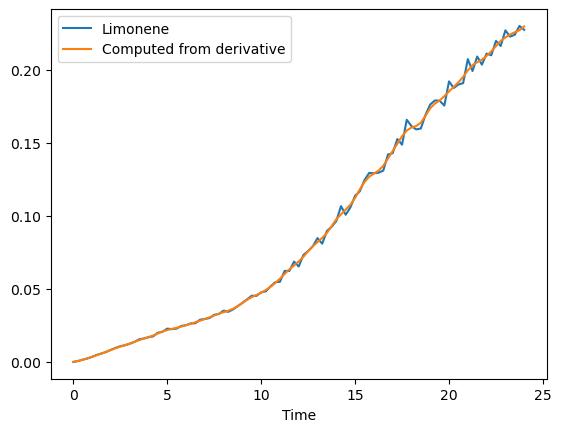

'Time profile from derivative vs. actual profile for WT'

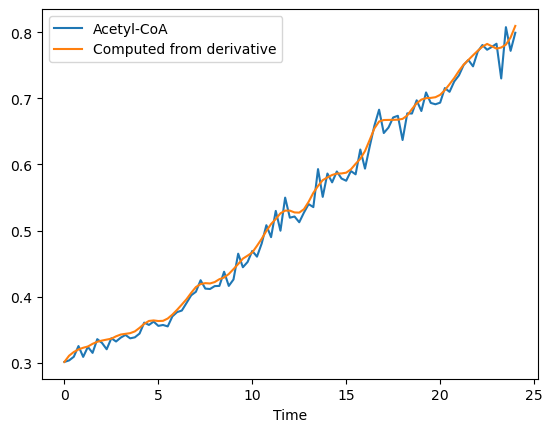

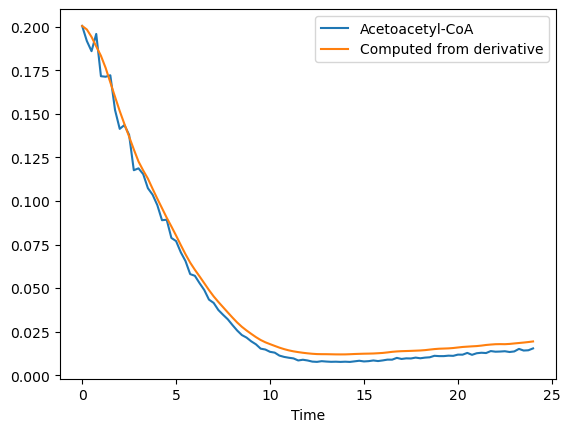

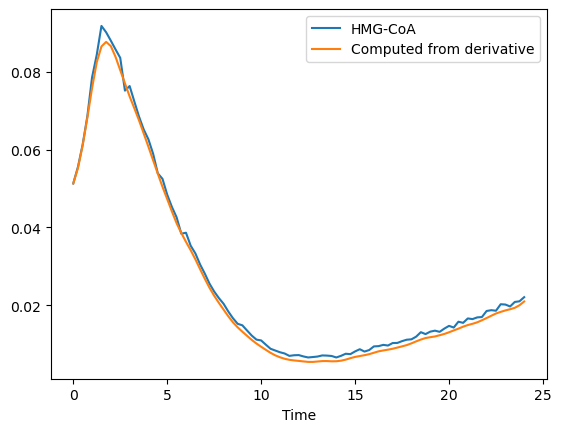

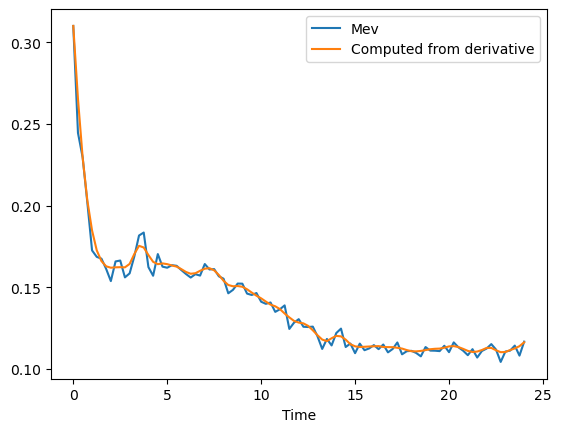

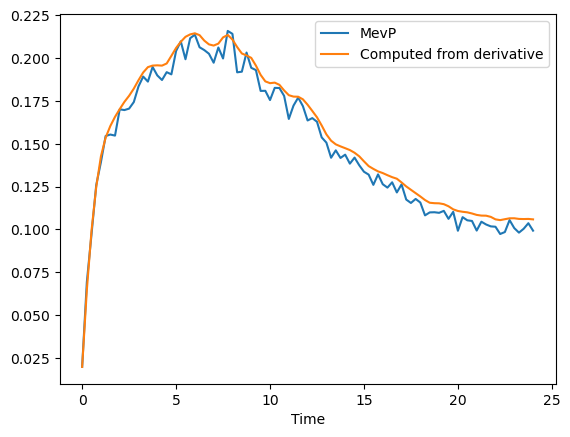

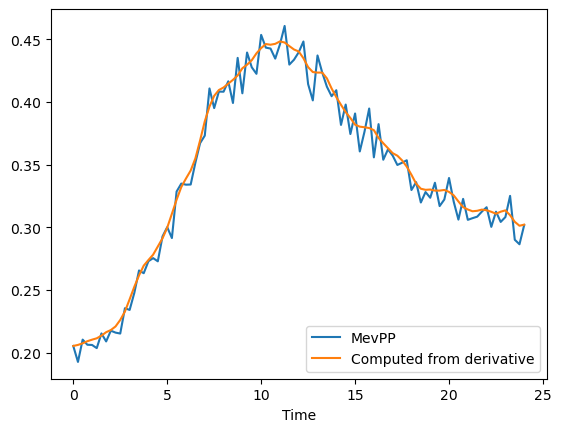

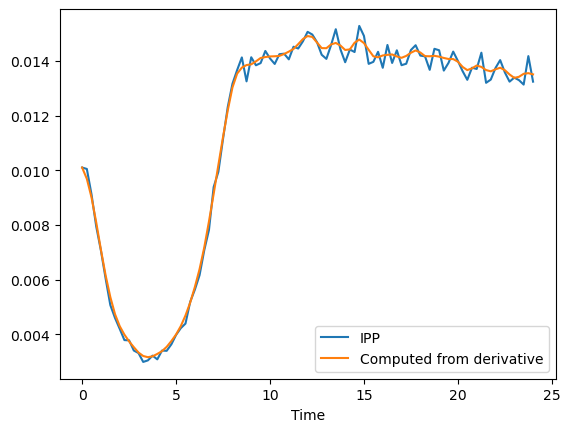

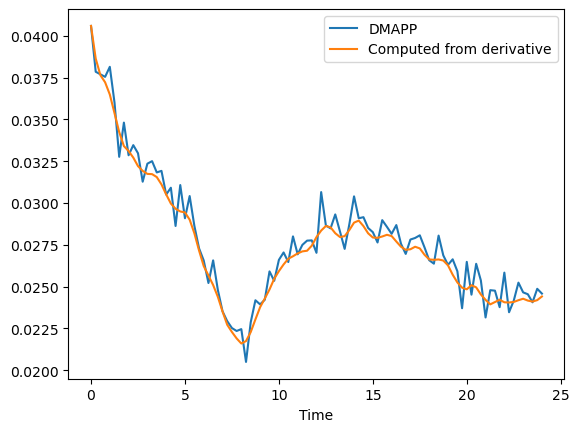

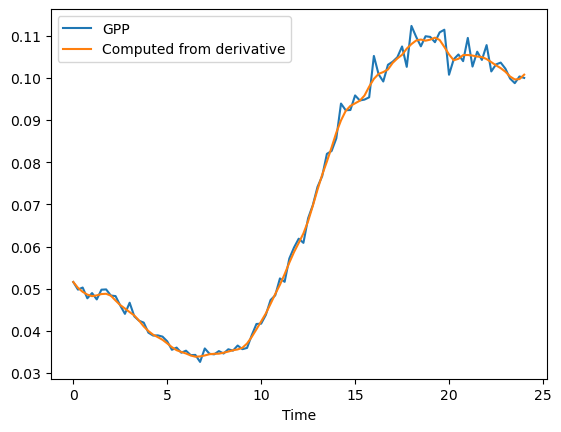

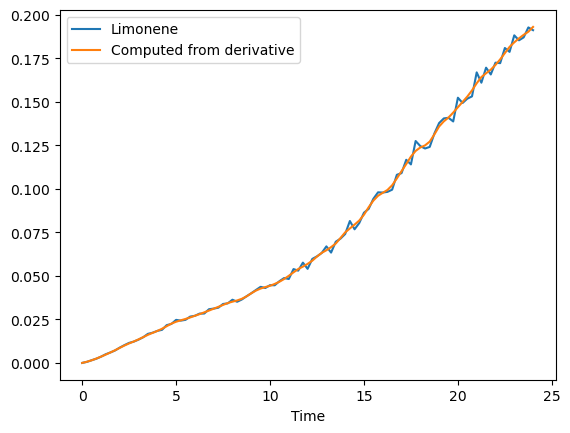

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.975196e+01  3.983424e+01  3.794074e+01  5.956960e+01   
         0.25   4.701158e+06  2.310954e+06  2.119978e+05  1.441237e+06   
         0.50   5.502124e+06  3.575914e+06  3.366702e+05  2.170702e+06   
         0.75   5.623466e+06  4.247346e+06  4.275388e+05  2.825850e+06   
         1.00   5.955090e+06  4.539072e+06  4.585594e+05  2.920864e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.689569e+06  2.630148e+06  1.757743e+06  1.904057e+06   
         23.25  2.733544e+06  2.618057e+06  1.711420e+06  2.009699e+06   
         23.50  2.734135e+06  2.467534e+06  1.824467e+06  2.078923e+06   
         23.75  2.680720e+06  2.813879e+06  1.748044e+06  1.955688e+06   
         24.00  2.711076e+06  2.661960e+06  1.713837e+06  1.994255e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.638142e+01  5.593531e+01  5.601897e+01  1.896372e+01   
         0.25   4.608750e+05  2.322661e+06  2.503681e+06  4.352779e+05   
         0.50   7.231798e+05  3.919590e+06  3.198510e+06  6.714010e+05   
         0.75   9.394797e+05  4.754849e+06  3.623287e+06  8.029395e+05   
         1.00   9.578282e+05  5.359746e+06  3.869362e+06  7.990530e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.460535e+06  3.983613e+06  4.334639e+06  1.261007e+06   
         23.25  1.508445e+06  4.058411e+06  4.235609e+06  1.171376e+06   
         23.50  1.523110e+06  4.035833e+06  4.267526e+06  1.241947e+06   
         23.75  1.469273e+06  4.064084e+06  4.274867e+06  1.211990e+06   
         24.00  1.520002e+06  4.038968e+06  4.343808e+06  1.300751e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.131118e+01   0.301424        0.200524  0.051314   
         0.25       1.742035e+05   0.299408        0.190985  0.058277   
         0.50       2.830033e+05   0.297438        0.184590  0.067947   
         0.75       3.603272e+05   0.304250        0.193897  0.079336   
         1.00       4.121310e+05   0.280318        0.169336  0.092565   
...                          ...        ...             ...       ...   
WT       23.00      1.472488e+06   0.782637        0.013612  0.020194   
         23.25      1.428807e+06   0.730114        0.015073  0.019702   
         23.50      1.473668e+06   0.807687        0.014126  0.020858   
         23.75      1.408105e+06   0.771875        0.014278  0.021028   
         24.00      1.412659e+06   0.799248        0.015356  0.022089   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.310136  0.019836  0.205338  0.010099  0.040591  0.051599   
         0.25   0.243627  0.070315  0.192610  0.010051  0.037849  0.049991   
         0.50   0.228141  0.098678  0.210385  0.009133  0.037694  0.050805   
         0.75   0.200724  0.127477  0.206264  0.008000  0.037534  0.048578   
         1.00   0.173153  0.141149  0.206056  0.007187  0.038110  0.050238   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.110700  0.100811  0.308112  0.013389  0.024654  0.102204   
         23.25  0.111253  0.098169  0.325012  0.013297  0.024542  0.099855   
         23.50  0.114335  0.100407  0.290028  0.013134  0.024060 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.025109       -0.007394  0.025137 -0.202111  0.203547   
         0.25     0.005080       -0.015590  0.033281 -0.164429  0.161731   
         0.50    -0.014948       -0.023785  0.041424 -0.126748  0.119915   
         0.75    -0.018416       -0.024143  0.041067 -0.077758  0.086655   
         1.00    -0.031113       -0.023019  0.032284 -0.048345  0.061365   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.008239        0.001037  0.001574  0.004695 -0.001414   
         23.25    0.005257        0.001001  0.000873  0.004542 -0.001629   
         23.50    0.029992        0.001078  0.002047  0.003628  0.001000   
         23.75    0.056511        0.001267  0.003258  0.007514 -0.000365   
         24.00    0.083030        0.001457  0.004469  0.011400 -0.001731   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002443 -0.001154 -0.009687 -0.005647  0.001533  
         0.25   0.004240 -0.002152 -0.005899 -0.003650  0.001956  
         0.50   0.006037 -0.003150 -0.002111 -0.001654  0.002380  
         0.75   0.006957 -0.003822 -0.001367 -0.000930  0.002888  
         1.00   0.002729 -0.003729 -0.004690  0.001152  0.003104  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009597 -0.000334 -0.000355 -0.005070  0.007537  
         23.25 -0.021485  0.000647 -0.000532 -0.004013  0.010764  
         23.50 -0.020557  0.000234  0.000072 -0.001559  0.005337  
         23.75 -0.004485 -0.000041  0.000608  0.002271  0.009103  
         24.00  0.011588 -0.000316  0.001145  0.006101  0.012869  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 1.684017E+192 | 1.025535E+117
     2 |       74 | 1.883896E+115 |  4.920429E+83
     3 |      138 |  7.376652E+90 |  5.385425E+70
     4 |      202 |  1.710360E+80 |  1.590111E+60
     5 |      266 |  9.020997E+70 |  4.881911E+52
     6 |      330 |  7.769197E+66 |  1.003356E+49
     7 |      394 |  7.474494E+57 |  8.721292E+41
     8 |      458 |  5.557719E+53 |  1.574759E+40
     9 |      522 |  6.652039E+48 |  4.313221E+37
    10 |      586 |  3.982764E+47 |  4.697244E+35
    11 |      650 |  8.191916E+47 |  4.697244E+35
    12 |      714 |  5.617497E+46 |  7.698680E+34
    13 |      778 |  8.567437E+40 |  7.698680E+34
    14 |      842 |  4.980112E+41 |  3.599977E+29
    15 |      906 |  1.352953E+38 |  2.194956E+24
    16 |      970 |  2.217540E+33 |  2.194956E+24
    17 |     1034 |  7.312177E+30 |  1.897165E+21
    18 |     1098 |  2.372755E+29 |  1.897165E+21
    19 |     1162 |  1.927

   162 |    10314 |  2.810122E+01 |  2.448898E+01
   163 |    10378 |  2.858671E+01 |  2.448898E+01
   164 |    10442 |  2.882447E+01 |  2.448898E+01
   165 |    10506 |  2.837859E+01 |  2.448898E+01
   166 |    10570 |  2.841233E+01 |  2.448898E+01
   167 |    10634 |  2.802991E+01 |  2.448898E+01
   168 |    10698 |  2.828819E+01 |  2.448898E+01
   169 |    10762 |  2.823984E+01 |  2.448898E+01
   170 |    10826 |  2.814526E+01 |  2.448898E+01
   171 |    10890 |  2.817815E+01 |  2.448898E+01
   172 |    10954 |  2.860392E+01 |  2.448898E+01
   173 |    11018 |  2.807337E+01 |  2.448898E+01
   174 |    11082 |  2.797739E+01 |  2.448898E+01
   175 |    11146 |  2.820888E+01 |  2.448898E+01
   176 |    11210 |  2.859911E+01 |  2.448898E+01
   177 |    11274 |  2.861275E+01 |  2.448898E+01
   178 |    11338 |  2.902459E+01 |  2.448898E+01
   179 |    11402 |  2.828167E+01 |  2.448898E+01
   180 |    11466 |  2.899735E+01 |  2.448898E+01
   181 |    11530 |  2.827382E+01 |  2.448898E+01


   326 |    20810 |  2.215443E+01 |  2.165335E+01
   327 |    20874 |  2.226327E+01 |  2.165335E+01
   328 |    20938 |  2.232826E+01 |  2.165335E+01
   329 |    21002 |  2.215145E+01 |  2.165335E+01
   330 |    21066 |  2.207112E+01 |  2.165335E+01
   331 |    21130 |  2.197412E+01 |  2.165335E+01
   332 |    21194 |  2.166784E+01 |  2.135245E+01
   333 |    21258 |  2.171906E+01 |  2.135245E+01
   334 |    21322 |  2.173989E+01 |  2.112565E+01
   335 |    21386 |  2.166525E+01 |  2.112565E+01
   336 |    21450 |  2.199249E+01 |  2.112565E+01
   337 |    21514 |  2.175141E+01 |  2.112565E+01
   338 |    21578 |  2.195226E+01 |  2.112565E+01
   339 |    21642 |  2.183566E+01 |  2.112565E+01
   340 |    21706 |  2.181706E+01 |  2.112565E+01
   341 |    21770 |  2.186534E+01 |  2.112565E+01
   342 |    21834 |  2.179579E+01 |  2.112565E+01
   343 |    21898 |  2.177233E+01 |  2.112565E+01
   344 |    21962 |  2.141964E+01 |  2.087692E+01
   345 |    22026 |  2.175866E+01 |  2.087692E+01


   490 |    31306 |  2.017073E+01 |  1.974933E+01
   491 |    31370 |  2.012775E+01 |  1.974933E+01
   492 |    31434 |  2.031807E+01 |  1.974933E+01
   493 |    31498 |  2.033257E+01 |  1.974933E+01
   494 |    31562 |  2.021838E+01 |  1.974933E+01
   495 |    31626 |  2.024534E+01 |  1.974933E+01
   496 |    31690 |  2.020098E+01 |  1.974933E+01
   497 |    31754 |  2.030049E+01 |  1.974933E+01
   498 |    31818 |  2.018893E+01 |  1.974933E+01
   499 |    31882 |  2.009830E+01 |  1.974933E+01
   500 |    31946 |  2.008758E+01 |  1.974933E+01
   501 |    32010 |  2.001741E+01 |  1.974933E+01
   502 |    32074 |  2.008635E+01 |  1.974933E+01
   503 |    32138 |  2.005688E+01 |  1.974933E+01
   504 |    32202 |  1.994502E+01 |  1.974933E+01
   505 |    32266 |  2.002850E+01 |  1.974933E+01
   506 |    32330 |  1.998504E+01 |  1.974933E+01
   507 |    32394 |  1.994152E+01 |  1.974933E+01
   508 |    32458 |  1.984239E+01 |  1.974933E+01
   509 |    32522 |  1.978327E+01 |  1.966832E+01


   654 |    41802 |  1.852557E+01 |  1.840999E+01
   655 |    41866 |  1.858050E+01 |  1.840999E+01
   656 |    41930 |  1.861899E+01 |  1.840999E+01
   657 |    41994 |  1.852212E+01 |  1.840999E+01
   658 |    42058 |  1.848571E+01 |  1.837913E+01
   659 |    42122 |  1.846542E+01 |  1.837913E+01
   660 |    42186 |  1.851452E+01 |  1.837913E+01
   661 |    42250 |  1.852524E+01 |  1.837913E+01
   662 |    42314 |  1.846328E+01 |  1.836217E+01
   663 |    42378 |  1.844778E+01 |  1.836217E+01
   664 |    42442 |  1.842005E+01 |  1.834018E+01
   665 |    42506 |  1.838041E+01 |  1.831340E+01
   666 |    42570 |  1.838632E+01 |  1.829487E+01
   667 |    42634 |  1.838679E+01 |  1.828957E+01
   668 |    42698 |  1.837464E+01 |  1.828957E+01
   669 |    42762 |  1.834681E+01 |  1.826600E+01
   670 |    42826 |  1.831285E+01 |  1.824563E+01
   671 |    42890 |  1.826613E+01 |  1.819356E+01
   672 |    42954 |  1.828087E+01 |  1.819356E+01
   673 |    43018 |  1.827914E+01 |  1.819356E+01


   818 |    52298 |  1.771716E+01 |  1.770774E+01
   819 |    52362 |  1.771685E+01 |  1.770774E+01
   820 |    52426 |  1.771469E+01 |  1.770774E+01
   821 |    52490 |  1.771354E+01 |  1.770425E+01
   822 |    52554 |  1.770926E+01 |  1.769955E+01
   823 |    52618 |  1.770073E+01 |  1.769621E+01
   824 |    52682 |  1.770079E+01 |  1.769339E+01
   825 |    52746 |  1.770307E+01 |  1.769339E+01
   826 |    52810 |  1.770298E+01 |  1.769339E+01
   827 |    52874 |  1.770316E+01 |  1.769339E+01
   828 |    52938 |  1.770217E+01 |  1.769339E+01
   829 |    53002 |  1.770570E+01 |  1.768762E+01
   830 |    53066 |  1.770085E+01 |  1.768762E+01
   831 |    53130 |  1.769862E+01 |  1.768762E+01
   832 |    53194 |  1.769639E+01 |  1.768762E+01
   833 |    53258 |  1.769785E+01 |  1.768762E+01
   834 |    53322 |  1.769684E+01 |  1.768715E+01
   835 |    53386 |  1.769783E+01 |  1.768715E+01
   836 |    53450 |  1.769664E+01 |  1.768592E+01
   837 |    53514 |  1.769329E+01 |  1.768592E+01


   982 |    62794 |  1.722821E+01 |  1.721149E+01
   983 |    62858 |  1.722343E+01 |  1.721149E+01
   984 |    62922 |  1.722288E+01 |  1.721149E+01
   985 |    62986 |  1.722332E+01 |  1.721149E+01
   986 |    63050 |  1.722023E+01 |  1.721149E+01
   987 |    63114 |  1.721464E+01 |  1.720649E+01
   988 |    63178 |  1.720534E+01 |  1.719068E+01
   989 |    63242 |  1.720598E+01 |  1.719068E+01
   990 |    63306 |  1.720103E+01 |  1.718425E+01
   991 |    63370 |  1.719507E+01 |  1.718425E+01
   992 |    63434 |  1.718987E+01 |  1.718199E+01
   993 |    63498 |  1.718497E+01 |  1.717388E+01
   994 |    63562 |  1.718192E+01 |  1.716973E+01
   995 |    63626 |  1.717242E+01 |  1.715332E+01
   996 |    63690 |  1.716634E+01 |  1.715332E+01
   997 |    63754 |  1.715913E+01 |  1.714909E+01
   998 |    63818 |  1.715316E+01 |  1.714630E+01
   999 |    63882 |  1.715004E+01 |  1.714528E+01
  1000 |    63946 |  1.714932E+01 |  1.714281E+01
  1001 |    64010 |  1.714827E+01 |  1.713959E+01


  1146 |    73290 |  1.673614E+01 |  1.671321E+01
  1147 |    73354 |  1.672413E+01 |  1.671122E+01
  1148 |    73418 |  1.671616E+01 |  1.670431E+01
  1149 |    73482 |  1.671211E+01 |  1.670431E+01
  1150 |    73546 |  1.669978E+01 |  1.668178E+01
  1151 |    73610 |  1.668309E+01 |  1.664787E+01
  1152 |    73674 |  1.666427E+01 |  1.663513E+01
  1153 |    73738 |  1.664328E+01 |  1.662417E+01
  1154 |    73802 |  1.663621E+01 |  1.662081E+01
  1155 |    73866 |  1.662145E+01 |  1.659707E+01
  1156 |    73930 |  1.661143E+01 |  1.659367E+01
  1157 |    73994 |  1.659987E+01 |  1.657580E+01
  1158 |    74058 |  1.659244E+01 |  1.657580E+01
  1159 |    74122 |  1.658912E+01 |  1.657195E+01
  1160 |    74186 |  1.658041E+01 |  1.656553E+01
  1161 |    74250 |  1.655867E+01 |  1.654191E+01
  1162 |    74314 |  1.655091E+01 |  1.653093E+01
  1163 |    74378 |  1.654409E+01 |  1.651834E+01
  1164 |    74442 |  1.653399E+01 |  1.651574E+01
  1165 |    74506 |  1.652863E+01 |  1.650216E+01


  1310 |    83786 |  1.401901E+01 |  1.401249E+01
  1311 |    83850 |  1.401741E+01 |  1.401050E+01
  1312 |    83914 |  1.401494E+01 |  1.400849E+01
  1313 |    83978 |  1.401371E+01 |  1.400849E+01
  1314 |    84042 |  1.401490E+01 |  1.400849E+01
  1315 |    84106 |  1.401208E+01 |  1.399850E+01
  1316 |    84170 |  1.400906E+01 |  1.399850E+01
  1317 |    84234 |  1.400251E+01 |  1.399850E+01
  1318 |    84298 |  1.399964E+01 |  1.399291E+01
  1319 |    84362 |  1.399661E+01 |  1.398925E+01
  1320 |    84426 |  1.399414E+01 |  1.398925E+01
  1321 |    84490 |  1.399393E+01 |  1.398154E+01
  1322 |    84554 |  1.399085E+01 |  1.397349E+01
  1323 |    84618 |  1.398769E+01 |  1.397349E+01
  1324 |    84682 |  1.398499E+01 |  1.397349E+01
  1325 |    84746 |  1.398647E+01 |  1.397349E+01
  1326 |    84810 |  1.397789E+01 |  1.397282E+01
  1327 |    84874 |  1.398023E+01 |  1.396096E+01
  1328 |    84938 |  1.397648E+01 |  1.396096E+01
  1329 |    85002 |  1.397063E+01 |  1.395264E+01


  1474 |    94282 |  1.375791E+01 |  1.375328E+01
  1475 |    94346 |  1.375702E+01 |  1.375328E+01
  1476 |    94410 |  1.375730E+01 |  1.375328E+01
  1477 |    94474 |  1.375629E+01 |  1.375242E+01
  1478 |    94538 |  1.375518E+01 |  1.375016E+01
  1479 |    94602 |  1.375375E+01 |  1.375016E+01
  1480 |    94666 |  1.375149E+01 |  1.374647E+01
  1481 |    94730 |  1.375242E+01 |  1.374647E+01
  1482 |    94794 |  1.375139E+01 |  1.374647E+01
  1483 |    94858 |  1.374983E+01 |  1.374604E+01
  1484 |    94922 |  1.374917E+01 |  1.374495E+01
  1485 |    94986 |  1.374614E+01 |  1.374209E+01
  1486 |    95050 |  1.374516E+01 |  1.374209E+01
  1487 |    95114 |  1.374565E+01 |  1.374209E+01
  1488 |    95178 |  1.374349E+01 |  1.373899E+01
  1489 |    95242 |  1.374231E+01 |  1.373899E+01
  1490 |    95306 |  1.374085E+01 |  1.373832E+01
  1491 |    95370 |  1.373962E+01 |  1.373552E+01
  1492 |    95434 |  1.373882E+01 |  1.373471E+01
  1493 |    95498 |  1.373646E+01 |  1.373368E+01


  1638 |   104778 |  1.297912E+01 |  1.295410E+01
  1639 |   104842 |  1.296904E+01 |  1.295410E+01
  1640 |   104906 |  1.297121E+01 |  1.295410E+01
  1641 |   104970 |  1.296932E+01 |  1.295410E+01
  1642 |   105034 |  1.297409E+01 |  1.295410E+01
  1643 |   105098 |  1.297403E+01 |  1.295410E+01
  1644 |   105162 |  1.297093E+01 |  1.295410E+01
  1645 |   105226 |  1.297487E+01 |  1.295410E+01
  1646 |   105290 |  1.297152E+01 |  1.295410E+01
  1647 |   105354 |  1.296479E+01 |  1.295410E+01
  1648 |   105418 |  1.296469E+01 |  1.294823E+01
  1649 |   105482 |  1.296548E+01 |  1.294823E+01
  1650 |   105546 |  1.296312E+01 |  1.294823E+01
  1651 |   105610 |  1.296120E+01 |  1.294823E+01
  1652 |   105674 |  1.295907E+01 |  1.294823E+01
  1653 |   105738 |  1.295958E+01 |  1.294823E+01
  1654 |   105802 |  1.295499E+01 |  1.294823E+01
  1655 |   105866 |  1.295713E+01 |  1.294823E+01
  1656 |   105930 |  1.295263E+01 |  1.294410E+01
  1657 |   105994 |  1.294840E+01 |  1.293946E+01


  1802 |   115274 |  1.280905E+01 |  1.280443E+01
  1803 |   115338 |  1.280426E+01 |  1.280189E+01
  1804 |   115402 |  1.280092E+01 |  1.279687E+01
  1805 |   115466 |  1.279909E+01 |  1.279611E+01
  1806 |   115530 |  1.279582E+01 |  1.279327E+01
  1807 |   115594 |  1.279013E+01 |  1.278397E+01
  1808 |   115658 |  1.278457E+01 |  1.277764E+01
  1809 |   115722 |  1.277680E+01 |  1.277092E+01
  1810 |   115786 |  1.276942E+01 |  1.276158E+01
  1811 |   115850 |  1.276328E+01 |  1.275844E+01
  1812 |   115914 |  1.275867E+01 |  1.275054E+01
  1813 |   115978 |  1.275487E+01 |  1.274497E+01
  1814 |   116042 |  1.275049E+01 |  1.274300E+01
  1815 |   116106 |  1.274443E+01 |  1.273929E+01
  1816 |   116170 |  1.274078E+01 |  1.272800E+01
  1817 |   116234 |  1.273100E+01 |  1.272149E+01
  1818 |   116298 |  1.272707E+01 |  1.271813E+01
  1819 |   116362 |  1.272612E+01 |  1.271813E+01
  1820 |   116426 |  1.271749E+01 |  1.270032E+01
  1821 |   116490 |  1.271173E+01 |  1.269593E+01


  1966 |   125770 |  1.223203E+01 |  1.222825E+01
  1967 |   125834 |  1.223063E+01 |  1.222813E+01
  1968 |   125898 |  1.222998E+01 |  1.222664E+01
  1969 |   125962 |  1.223010E+01 |  1.222404E+01
  1970 |   126026 |  1.222840E+01 |  1.222311E+01
  1971 |   126090 |  1.222691E+01 |  1.222176E+01
  1972 |   126154 |  1.222544E+01 |  1.222176E+01
  1973 |   126218 |  1.222393E+01 |  1.222063E+01
  1974 |   126282 |  1.222275E+01 |  1.221764E+01
  1975 |   126346 |  1.222246E+01 |  1.221496E+01
  1976 |   126410 |  1.222022E+01 |  1.221496E+01
  1977 |   126474 |  1.221946E+01 |  1.221496E+01
  1978 |   126538 |  1.221825E+01 |  1.221437E+01
  1979 |   126602 |  1.221599E+01 |  1.221020E+01
  1980 |   126666 |  1.221278E+01 |  1.221020E+01
  1981 |   126730 |  1.221060E+01 |  1.220873E+01
  1982 |   126794 |  1.221052E+01 |  1.220758E+01
  1983 |   126858 |  1.221039E+01 |  1.220742E+01
  1984 |   126922 |  1.221011E+01 |  1.220456E+01
  1985 |   126986 |  1.220718E+01 |  1.220395E+01


  2130 |   136266 |  1.204666E+01 |  1.204467E+01
  2131 |   136330 |  1.204667E+01 |  1.204449E+01
  2132 |   136394 |  1.204646E+01 |  1.204379E+01
  2133 |   136458 |  1.204558E+01 |  1.204379E+01
  2134 |   136522 |  1.204517E+01 |  1.204379E+01
  2135 |   136586 |  1.204562E+01 |  1.204379E+01
  2136 |   136650 |  1.204590E+01 |  1.204379E+01
  2137 |   136714 |  1.204521E+01 |  1.204379E+01
  2138 |   136778 |  1.204512E+01 |  1.204379E+01
  2139 |   136842 |  1.204353E+01 |  1.204250E+01
  2140 |   136906 |  1.204316E+01 |  1.204193E+01
  2141 |   136970 |  1.204358E+01 |  1.204193E+01
  2142 |   137034 |  1.204341E+01 |  1.204193E+01
  2143 |   137098 |  1.204299E+01 |  1.204141E+01
  2144 |   137162 |  1.204276E+01 |  1.204051E+01
  2145 |   137226 |  1.204254E+01 |  1.203970E+01
  2146 |   137290 |  1.204161E+01 |  1.203967E+01
  2147 |   137354 |  1.204131E+01 |  1.203967E+01
  2148 |   137418 |  1.204046E+01 |  1.203933E+01
  2149 |   137482 |  1.204069E+01 |  1.203849E+01


  2294 |   146762 |  1.198033E+01 |  1.197913E+01
  2295 |   146826 |  1.197969E+01 |  1.197902E+01
  2296 |   146890 |  1.197897E+01 |  1.197739E+01
  2297 |   146954 |  1.197800E+01 |  1.197706E+01
  2298 |   147018 |  1.197745E+01 |  1.197660E+01
  2299 |   147082 |  1.197704E+01 |  1.197653E+01
  2300 |   147146 |  1.197646E+01 |  1.197557E+01
  2301 |   147210 |  1.197630E+01 |  1.197554E+01
  2302 |   147274 |  1.197598E+01 |  1.197554E+01
  2303 |   147338 |  1.197567E+01 |  1.197501E+01
  2304 |   147402 |  1.197549E+01 |  1.197501E+01
  2305 |   147466 |  1.197500E+01 |  1.197471E+01
  2306 |   147530 |  1.197505E+01 |  1.197471E+01
  2307 |   147594 |  1.197480E+01 |  1.197426E+01
  2308 |   147658 |  1.197435E+01 |  1.197387E+01
  2309 |   147722 |  1.197417E+01 |  1.197373E+01
  2310 |   147786 |  1.197380E+01 |  1.197345E+01
  2311 |   147850 |  1.197363E+01 |  1.197336E+01
  2312 |   147914 |  1.197351E+01 |  1.197336E+01
  2313 |   147978 |  1.197343E+01 |  1.197316E+01


  2458 |   157258 |  1.192648E+01 |  1.192603E+01
  2459 |   157322 |  1.192636E+01 |  1.192591E+01
  2460 |   157386 |  1.192624E+01 |  1.192567E+01
  2461 |   157450 |  1.192595E+01 |  1.192525E+01
  2462 |   157514 |  1.192570E+01 |  1.192525E+01
  2463 |   157578 |  1.192559E+01 |  1.192522E+01
  2464 |   157642 |  1.192529E+01 |  1.192475E+01
  2465 |   157706 |  1.192494E+01 |  1.192461E+01
  2466 |   157770 |  1.192464E+01 |  1.192438E+01
  2467 |   157834 |  1.192462E+01 |  1.192435E+01
  2468 |   157898 |  1.192420E+01 |  1.192373E+01
  2469 |   157962 |  1.192429E+01 |  1.192373E+01
  2470 |   158026 |  1.192390E+01 |  1.192331E+01
  2471 |   158090 |  1.192338E+01 |  1.192315E+01
  2472 |   158154 |  1.192320E+01 |  1.192260E+01
  2473 |   158218 |  1.192286E+01 |  1.192259E+01
  2474 |   158282 |  1.192264E+01 |  1.192234E+01
  2475 |   158346 |  1.192247E+01 |  1.192224E+01
  2476 |   158410 |  1.192223E+01 |  1.192188E+01
  2477 |   158474 |  1.192197E+01 |  1.192163E+01


  2622 |   167754 |  1.189236E+01 |  1.189185E+01
  2623 |   167818 |  1.189192E+01 |  1.189135E+01
  2624 |   167882 |  1.189167E+01 |  1.189131E+01
  2625 |   167946 |  1.189145E+01 |  1.189078E+01
  2626 |   168010 |  1.189133E+01 |  1.189067E+01
  2627 |   168074 |  1.189092E+01 |  1.189041E+01
  2628 |   168138 |  1.189054E+01 |  1.189031E+01
  2629 |   168202 |  1.189033E+01 |  1.189018E+01
  2630 |   168266 |  1.189020E+01 |  1.188969E+01
  2631 |   168330 |  1.188995E+01 |  1.188967E+01
  2632 |   168394 |  1.188990E+01 |  1.188957E+01
  2633 |   168458 |  1.188975E+01 |  1.188952E+01
  2634 |   168522 |  1.188971E+01 |  1.188949E+01
  2635 |   168586 |  1.188963E+01 |  1.188938E+01
  2636 |   168650 |  1.188945E+01 |  1.188909E+01
  2637 |   168714 |  1.188937E+01 |  1.188909E+01
  2638 |   168778 |  1.188927E+01 |  1.188908E+01
  2639 |   168842 |  1.188911E+01 |  1.188902E+01
  2640 |   168906 |  1.188900E+01 |  1.188889E+01
  2641 |   168970 |  1.188905E+01 |  1.188889E+01


  2786 |   178250 |  1.186240E+01 |  1.186219E+01
  2787 |   178314 |  1.186239E+01 |  1.186206E+01
  2788 |   178378 |  1.186226E+01 |  1.186193E+01
  2789 |   178442 |  1.186208E+01 |  1.186181E+01
  2790 |   178506 |  1.186209E+01 |  1.186181E+01
  2791 |   178570 |  1.186197E+01 |  1.186174E+01
  2792 |   178634 |  1.186181E+01 |  1.186158E+01
  2793 |   178698 |  1.186177E+01 |  1.186158E+01
  2794 |   178762 |  1.186182E+01 |  1.186153E+01
  2795 |   178826 |  1.186159E+01 |  1.186135E+01
  2796 |   178890 |  1.186150E+01 |  1.186133E+01
  2797 |   178954 |  1.186144E+01 |  1.186125E+01
  2798 |   179018 |  1.186134E+01 |  1.186115E+01
  2799 |   179082 |  1.186122E+01 |  1.186108E+01
  2800 |   179146 |  1.186110E+01 |  1.186075E+01
  2801 |   179210 |  1.186098E+01 |  1.186075E+01
  2802 |   179274 |  1.186091E+01 |  1.186060E+01
  2803 |   179338 |  1.186073E+01 |  1.186044E+01
  2804 |   179402 |  1.186061E+01 |  1.186021E+01
  2805 |   179466 |  1.186026E+01 |  1.185992E+01


  2950 |   188746 |  1.182984E+01 |  1.182946E+01
  2951 |   188810 |  1.182986E+01 |  1.182946E+01
  2952 |   188874 |  1.182984E+01 |  1.182918E+01
  2953 |   188938 |  1.182972E+01 |  1.182894E+01
  2954 |   189002 |  1.182954E+01 |  1.182893E+01
  2955 |   189066 |  1.182934E+01 |  1.182886E+01
  2956 |   189130 |  1.182906E+01 |  1.182860E+01
  2957 |   189194 |  1.182884E+01 |  1.182842E+01
  2958 |   189258 |  1.182873E+01 |  1.182813E+01
  2959 |   189322 |  1.182837E+01 |  1.182803E+01
  2960 |   189386 |  1.182822E+01 |  1.182772E+01
  2961 |   189450 |  1.182818E+01 |  1.182772E+01
  2962 |   189514 |  1.182789E+01 |  1.182766E+01
  2963 |   189578 |  1.182767E+01 |  1.182742E+01
  2964 |   189642 |  1.182760E+01 |  1.182731E+01
  2965 |   189706 |  1.182752E+01 |  1.182726E+01
  2966 |   189770 |  1.182754E+01 |  1.182721E+01
  2967 |   189834 |  1.182756E+01 |  1.182721E+01
  2968 |   189898 |  1.182741E+01 |  1.182690E+01
  2969 |   189962 |  1.182720E+01 |  1.182672E+01


  3114 |   199242 |  1.180215E+01 |  1.180189E+01
  3115 |   199306 |  1.180198E+01 |  1.180176E+01
  3116 |   199370 |  1.180198E+01 |  1.180174E+01
  3117 |   199434 |  1.180177E+01 |  1.180146E+01
  3118 |   199498 |  1.180167E+01 |  1.180143E+01
  3119 |   199562 |  1.180150E+01 |  1.180125E+01
  3120 |   199626 |  1.180139E+01 |  1.180102E+01
  3121 |   199690 |  1.180126E+01 |  1.180098E+01
  3122 |   199754 |  1.180112E+01 |  1.180081E+01
  3123 |   199818 |  1.180101E+01 |  1.180069E+01
  3124 |   199882 |  1.180076E+01 |  1.180042E+01
  3125 |   199946 |  1.180036E+01 |  1.180005E+01
  3126 |   200010 |  1.180013E+01 |  1.179983E+01
  3127 |   200074 |  1.179978E+01 |  1.179933E+01
  3128 |   200138 |  1.179962E+01 |  1.179928E+01
  3129 |   200202 |  1.179950E+01 |  1.179917E+01
  3130 |   200266 |  1.179938E+01 |  1.179905E+01
  3131 |   200330 |  1.179921E+01 |  1.179896E+01
  3132 |   200394 |  1.179907E+01 |  1.179864E+01
  3133 |   200458 |  1.179895E+01 |  1.179864E+01


  3278 |   209738 |  1.176237E+01 |  1.176210E+01
  3279 |   209802 |  1.176220E+01 |  1.176180E+01
  3280 |   209866 |  1.176198E+01 |  1.176168E+01
  3281 |   209930 |  1.176185E+01 |  1.176157E+01
  3282 |   209994 |  1.176173E+01 |  1.176148E+01
  3283 |   210058 |  1.176162E+01 |  1.176142E+01
  3284 |   210122 |  1.176160E+01 |  1.176125E+01
  3285 |   210186 |  1.176148E+01 |  1.176106E+01
  3286 |   210250 |  1.176125E+01 |  1.176100E+01
  3287 |   210314 |  1.176112E+01 |  1.176081E+01
  3288 |   210378 |  1.176087E+01 |  1.176070E+01
  3289 |   210442 |  1.176068E+01 |  1.176039E+01
  3290 |   210506 |  1.176056E+01 |  1.176029E+01
  3291 |   210570 |  1.176050E+01 |  1.176029E+01
  3292 |   210634 |  1.176034E+01 |  1.176010E+01
  3293 |   210698 |  1.176015E+01 |  1.175958E+01
  3294 |   210762 |  1.175988E+01 |  1.175952E+01
  3295 |   210826 |  1.175961E+01 |  1.175947E+01
  3296 |   210890 |  1.175947E+01 |  1.175939E+01
  3297 |   210954 |  1.175941E+01 |  1.175922E+01


  3442 |   220234 |  1.171459E+01 |  1.171345E+01
  3443 |   220298 |  1.171431E+01 |  1.171345E+01
  3444 |   220362 |  1.171393E+01 |  1.171304E+01
  3445 |   220426 |  1.171432E+01 |  1.171246E+01
  3446 |   220490 |  1.171448E+01 |  1.171246E+01
  3447 |   220554 |  1.171385E+01 |  1.171146E+01
  3448 |   220618 |  1.171327E+01 |  1.171146E+01
  3449 |   220682 |  1.171343E+01 |  1.171146E+01
  3450 |   220746 |  1.171344E+01 |  1.171146E+01
  3451 |   220810 |  1.171275E+01 |  1.171146E+01
  3452 |   220874 |  1.171366E+01 |  1.171146E+01
  3453 |   220938 |  1.171244E+01 |  1.171097E+01
  3454 |   221002 |  1.171157E+01 |  1.171097E+01
  3455 |   221066 |  1.171113E+01 |  1.171002E+01
  3456 |   221130 |  1.171069E+01 |  1.170942E+01
  3457 |   221194 |  1.171028E+01 |  1.170899E+01
  3458 |   221258 |  1.170999E+01 |  1.170899E+01
  3459 |   221322 |  1.170971E+01 |  1.170871E+01
  3460 |   221386 |  1.170957E+01 |  1.170871E+01
  3461 |   221450 |  1.170910E+01 |  1.170833E+01


  3606 |   230730 |  1.165254E+01 |  1.165217E+01
  3607 |   230794 |  1.165235E+01 |  1.165197E+01
  3608 |   230858 |  1.165217E+01 |  1.165165E+01
  3609 |   230922 |  1.165199E+01 |  1.165165E+01
  3610 |   230986 |  1.165187E+01 |  1.165160E+01
  3611 |   231050 |  1.165166E+01 |  1.165118E+01
  3612 |   231114 |  1.165119E+01 |  1.165090E+01
  3613 |   231178 |  1.165075E+01 |  1.165010E+01
  3614 |   231242 |  1.165039E+01 |  1.164963E+01
  3615 |   231306 |  1.164979E+01 |  1.164933E+01
  3616 |   231370 |  1.164954E+01 |  1.164914E+01
  3617 |   231434 |  1.164918E+01 |  1.164865E+01
  3618 |   231498 |  1.164861E+01 |  1.164773E+01
  3619 |   231562 |  1.164811E+01 |  1.164752E+01
  3620 |   231626 |  1.164796E+01 |  1.164740E+01
  3621 |   231690 |  1.164760E+01 |  1.164696E+01
  3622 |   231754 |  1.164725E+01 |  1.164655E+01
  3623 |   231818 |  1.164690E+01 |  1.164591E+01
  3624 |   231882 |  1.164650E+01 |  1.164578E+01
  3625 |   231946 |  1.164595E+01 |  1.164547E+01


  3770 |   241226 |  9.9954576013 |  9.9673577952
  3771 |   241290 |  9.9933543044 |  9.9673577952
  3772 |   241354 |  9.9822875925 |  9.9662851944
  3773 |   241418 |  9.9851518403 |  9.9662851944
  3774 |   241482 |  9.9894142618 |  9.9662851944
  3775 |   241546 |  9.9838735636 |  9.9662851944
  3776 |   241610 |  9.9887653407 |  9.9662851944
  3777 |   241674 |  9.9809721380 |  9.9658283113
  3778 |   241738 |  9.9803861725 |  9.9587946572
  3779 |   241802 |  9.9719930321 |  9.9555911490
  3780 |   241866 |  9.9764810161 |  9.9555911490
  3781 |   241930 |  9.9663894773 |  9.9499696576
  3782 |   241994 |  9.9593859217 |  9.9394211196
  3783 |   242058 |  9.9559759156 |  9.9384970145
  3784 |   242122 |  9.9498473352 |  9.9354001273
  3785 |   242186 |  9.9577799724 |  9.9354001273
  3786 |   242250 |  9.9554018048 |  9.9324716417
  3787 |   242314 |  9.9473031741 |  9.9302693729
  3788 |   242378 |  9.9532428007 |  9.9302693729
  3789 |   242442 |  9.9462508889 |  9.9302693729


  3934 |   251722 |  9.7741217547 |  9.7723471200
  3935 |   251786 |  9.7731133270 |  9.7707929991
  3936 |   251850 |  9.7722791634 |  9.7707929991
  3937 |   251914 |  9.7714262401 |  9.7695508615
  3938 |   251978 |  9.7713138608 |  9.7695508615
  3939 |   252042 |  9.7702161305 |  9.7686241401
  3940 |   252106 |  9.7690231421 |  9.7674474016
  3941 |   252170 |  9.7683589199 |  9.7669543556
  3942 |   252234 |  9.7674966534 |  9.7654675214
  3943 |   252298 |  9.7659551541 |  9.7648203213
  3944 |   252362 |  9.7657710061 |  9.7646610615
  3945 |   252426 |  9.7650606336 |  9.7636272813
  3946 |   252490 |  9.7636764143 |  9.7624886911
  3947 |   252554 |  9.7627791210 |  9.7616100384
  3948 |   252618 |  9.7619687228 |  9.7603672883
  3949 |   252682 |  9.7611129984 |  9.7592635350
  3950 |   252746 |  9.7604489675 |  9.7582059886
  3951 |   252810 |  9.7599295673 |  9.7576706812
  3952 |   252874 |  9.7593122569 |  9.7576706812
  3953 |   252938 |  9.7589134757 |  9.7572200213


  4098 |   262218 |  9.6182141838 |  9.6155351763
  4099 |   262282 |  9.6175836223 |  9.6155351763
  4100 |   262346 |  9.6163455417 |  9.6148571207
  4101 |   262410 |  9.6158015035 |  9.6139638812
  4102 |   262474 |  9.6151650924 |  9.6139638812
  4103 |   262538 |  9.6136316975 |  9.6122220830
  4104 |   262602 |  9.6134246452 |  9.6119848170
  4105 |   262666 |  9.6129801811 |  9.6115106897
  4106 |   262730 |  9.6119613086 |  9.6109986134
  4107 |   262794 |  9.6122395721 |  9.6109986134
  4108 |   262858 |  9.6114571992 |  9.6103803955
  4109 |   262922 |  9.6101735490 |  9.6089817728
  4110 |   262986 |  9.6101282262 |  9.6089817728
  4111 |   263050 |  9.6096451932 |  9.6083652898
  4112 |   263114 |  9.6091172776 |  9.6082269230
  4113 |   263178 |  9.6083532879 |  9.6067752803
  4114 |   263242 |  9.6078336467 |  9.6064146458
  4115 |   263306 |  9.6077534603 |  9.6064146458
  4116 |   263370 |  9.6075151541 |  9.6064146458
  4117 |   263434 |  9.6077141190 |  9.6064146458


  4262 |   272714 |  9.5428690327 |  9.5423804694
  4263 |   272778 |  9.5425128429 |  9.5421554000
  4264 |   272842 |  9.5423232825 |  9.5417544859
  4265 |   272906 |  9.5418754195 |  9.5409894092
  4266 |   272970 |  9.5416486143 |  9.5409894092
  4267 |   273034 |  9.5411724803 |  9.5404405653
  4268 |   273098 |  9.5407834861 |  9.5398893965
  4269 |   273162 |  9.5404574947 |  9.5397622804
  4270 |   273226 |  9.5399987094 |  9.5389329860
  4271 |   273290 |  9.5393639876 |  9.5389329860
  4272 |   273354 |  9.5389888960 |  9.5385497704
  4273 |   273418 |  9.5387507242 |  9.5382122148
  4274 |   273482 |  9.5383059638 |  9.5379454828
  4275 |   273546 |  9.5380528324 |  9.5376684264
  4276 |   273610 |  9.5376464290 |  9.5372934449
  4277 |   273674 |  9.5373430207 |  9.5367108699
  4278 |   273738 |  9.5367694958 |  9.5362301546
  4279 |   273802 |  9.5363273204 |  9.5357627371
  4280 |   273866 |  9.5358020521 |  9.5349354087
  4281 |   273930 |  9.5355762672 |  9.5348571589


  4426 |   283210 |  9.4942820868 |  9.4938551136
  4427 |   283274 |  9.4941064472 |  9.4938326242
  4428 |   283338 |  9.4940061048 |  9.4937361580
  4429 |   283402 |  9.4938328428 |  9.4934853992
  4430 |   283466 |  9.4937766431 |  9.4931384763
  4431 |   283530 |  9.4935542597 |  9.4931319366
  4432 |   283594 |  9.4934339313 |  9.4929954666
  4433 |   283658 |  9.4931588576 |  9.4927993879
  4434 |   283722 |  9.4930069777 |  9.4927531790
  4435 |   283786 |  9.4929251577 |  9.4923964103
  4436 |   283850 |  9.4927390115 |  9.4923964103
  4437 |   283914 |  9.4924161495 |  9.4920345157
  4438 |   283978 |  9.4923142307 |  9.4920345157
  4439 |   284042 |  9.4921731310 |  9.4916373094
  4440 |   284106 |  9.4919764049 |  9.4915674707
  4441 |   284170 |  9.4918187978 |  9.4914382258
  4442 |   284234 |  9.4917334796 |  9.4912597668
  4443 |   284298 |  9.4916180786 |  9.4912597668
  4444 |   284362 |  9.4913250641 |  9.4909298075
  4445 |   284426 |  9.4909129811 |  9.4905545552


  4590 |   293706 |  9.4593060499 |  9.4587447105
  4591 |   293770 |  9.4589127143 |  9.4582916922
  4592 |   293834 |  9.4590891217 |  9.4582916922
  4593 |   293898 |  9.4588932071 |  9.4578801922
  4594 |   293962 |  9.4581770080 |  9.4571773807
  4595 |   294026 |  9.4579156741 |  9.4571773807
  4596 |   294090 |  9.4574961963 |  9.4565282149
  4597 |   294154 |  9.4570679665 |  9.4565282149
  4598 |   294218 |  9.4568119287 |  9.4561050151
  4599 |   294282 |  9.4561231177 |  9.4556778268
  4600 |   294346 |  9.4560158175 |  9.4555546831
  4601 |   294410 |  9.4557797669 |  9.4549767182
  4602 |   294474 |  9.4551752495 |  9.4539499056
  4603 |   294538 |  9.4543901567 |  9.4539499056
  4604 |   294602 |  9.4544057157 |  9.4539499056
  4605 |   294666 |  9.4542962979 |  9.4536199860
  4606 |   294730 |  9.4539513231 |  9.4531942607
  4607 |   294794 |  9.4540129745 |  9.4531942607
  4608 |   294858 |  9.4540588002 |  9.4531942607
  4609 |   294922 |  9.4541728151 |  9.4525336087


  4754 |   304202 |  9.4208851008 |  9.4199289349
  4755 |   304266 |  9.4204795548 |  9.4198271812
  4756 |   304330 |  9.4201039087 |  9.4194825407
  4757 |   304394 |  9.4200465871 |  9.4194825407
  4758 |   304458 |  9.4195034077 |  9.4190036202
  4759 |   304522 |  9.4193082902 |  9.4187169763
  4760 |   304586 |  9.4190720557 |  9.4184634894
  4761 |   304650 |  9.4188331885 |  9.4184462908
  4762 |   304714 |  9.4188317049 |  9.4184423815
  4763 |   304778 |  9.4186407949 |  9.4182849883
  4764 |   304842 |  9.4185693355 |  9.4182849883
  4765 |   304906 |  9.4185558379 |  9.4181029276
  4766 |   304970 |  9.4183379465 |  9.4178896338
  4767 |   305034 |  9.4181828099 |  9.4178896338
  4768 |   305098 |  9.4181939445 |  9.4176853760
  4769 |   305162 |  9.4176316435 |  9.4170464683
  4770 |   305226 |  9.4176062950 |  9.4170464683
  4771 |   305290 |  9.4173131477 |  9.4169686301
  4772 |   305354 |  9.4171088902 |  9.4167192531
  4773 |   305418 |  9.4167145107 |  9.4164426006


  4918 |   314698 |  9.3978001596 |  9.3976166864
  4919 |   314762 |  9.3977109499 |  9.3976166864
  4920 |   314826 |  9.3975785603 |  9.3974632500
  4921 |   314890 |  9.3974634335 |  9.3972859569
  4922 |   314954 |  9.3973865450 |  9.3972378938
  4923 |   315018 |  9.3971507473 |  9.3969573290
  4924 |   315082 |  9.3970083864 |  9.3966948514
  4925 |   315146 |  9.3968311423 |  9.3966948514
  4926 |   315210 |  9.3967034068 |  9.3965385572
  4927 |   315274 |  9.3966488983 |  9.3965385572
  4928 |   315338 |  9.3965886533 |  9.3964893668
  4929 |   315402 |  9.3964745718 |  9.3963881131
  4930 |   315466 |  9.3964174023 |  9.3961826811
  4931 |   315530 |  9.3963387320 |  9.3961754989
  4932 |   315594 |  9.3962308642 |  9.3960786237
  4933 |   315658 |  9.3961724608 |  9.3959790224
  4934 |   315722 |  9.3959965632 |  9.3958497268
  4935 |   315786 |  9.3959013185 |  9.3957734650
  4936 |   315850 |  9.3958138581 |  9.3956059260
  4937 |   315914 |  9.3957809404 |  9.3956059260


  5082 |   325194 |  9.3662178907 |  9.3659535956
  5083 |   325258 |  9.3662840180 |  9.3658721329
  5084 |   325322 |  9.3662037192 |  9.3658721329
  5085 |   325386 |  9.3660335443 |  9.3657632307
  5086 |   325450 |  9.3659788471 |  9.3656129088
  5087 |   325514 |  9.3658612926 |  9.3656129088
  5088 |   325578 |  9.3657105797 |  9.3654345767
  5089 |   325642 |  9.3654988992 |  9.3649984578
  5090 |   325706 |  9.3652682430 |  9.3649653065
  5091 |   325770 |  9.3651612626 |  9.3646386029
  5092 |   325834 |  9.3650514022 |  9.3646386029
  5093 |   325898 |  9.3648789488 |  9.3646386029
  5094 |   325962 |  9.3647106105 |  9.3643826946
  5095 |   326026 |  9.3645998843 |  9.3642233139
  5096 |   326090 |  9.3644395346 |  9.3641190660
  5097 |   326154 |  9.3642591365 |  9.3638466470
  5098 |   326218 |  9.3640063220 |  9.3636719207
  5099 |   326282 |  9.3639157484 |  9.3636495095
  5100 |   326346 |  9.3639267235 |  9.3636495095
  5101 |   326410 |  9.3639241024 |  9.3636495095


  5246 |   335690 |  9.3394500635 |  9.3388457601
  5247 |   335754 |  9.3392738492 |  9.3388457601
  5248 |   335818 |  9.3389963291 |  9.3383188860
  5249 |   335882 |  9.3387622346 |  9.3383188860
  5250 |   335946 |  9.3386445062 |  9.3382154768
  5251 |   336010 |  9.3385095798 |  9.3382055347
  5252 |   336074 |  9.3382567622 |  9.3378050033
  5253 |   336138 |  9.3379524561 |  9.3374592562
  5254 |   336202 |  9.3377374734 |  9.3372231234
  5255 |   336266 |  9.3374887953 |  9.3371764343
  5256 |   336330 |  9.3374953390 |  9.3368939636
  5257 |   336394 |  9.3373206489 |  9.3368939636
  5258 |   336458 |  9.3372188888 |  9.3367930814
  5259 |   336522 |  9.3368946586 |  9.3363035659
  5260 |   336586 |  9.3365479879 |  9.3357958205
  5261 |   336650 |  9.3362318413 |  9.3354738571
  5262 |   336714 |  9.3358633762 |  9.3354636295
  5263 |   336778 |  9.3356143345 |  9.3352295840
  5264 |   336842 |  9.3355672773 |  9.3351110970
  5265 |   336906 |  9.3354780684 |  9.3342759019


  5410 |   346186 |  9.3155254935 |  9.3153308829
  5411 |   346250 |  9.3153981543 |  9.3152328891
  5412 |   346314 |  9.3153019150 |  9.3150958652
  5413 |   346378 |  9.3152088410 |  9.3150524417
  5414 |   346442 |  9.3150897450 |  9.3149535331
  5415 |   346506 |  9.3149713176 |  9.3146814072
  5416 |   346570 |  9.3147716713 |  9.3145260238
  5417 |   346634 |  9.3146992147 |  9.3145260238
  5418 |   346698 |  9.3146002226 |  9.3144397529
  5419 |   346762 |  9.3145545076 |  9.3144065193
  5420 |   346826 |  9.3144217392 |  9.3141727717
  5421 |   346890 |  9.3142140749 |  9.3140752151
  5422 |   346954 |  9.3141934258 |  9.3140752151
  5423 |   347018 |  9.3141087984 |  9.3138600329
  5424 |   347082 |  9.3138727234 |  9.3136678877
  5425 |   347146 |  9.3136988412 |  9.3134291542
  5426 |   347210 |  9.3136575955 |  9.3134291542
  5427 |   347274 |  9.3134939757 |  9.3132509211
  5428 |   347338 |  9.3133123133 |  9.3128983902
  5429 |   347402 |  9.3130688060 |  9.3128983902


  5574 |   356682 |  9.2907681413 |  9.2905870722
  5575 |   356746 |  9.2906425468 |  9.2903184608
  5576 |   356810 |  9.2905193959 |  9.2902673537
  5577 |   356874 |  9.2903731370 |  9.2900304910
  5578 |   356938 |  9.2902417686 |  9.2900304910
  5579 |   357002 |  9.2901795236 |  9.2897988600
  5580 |   357066 |  9.2899909539 |  9.2894653523
  5581 |   357130 |  9.2897367245 |  9.2892425873
  5582 |   357194 |  9.2897947009 |  9.2892425873
  5583 |   357258 |  9.2896481253 |  9.2892425873
  5584 |   357322 |  9.2895482212 |  9.2892425873
  5585 |   357386 |  9.2892910258 |  9.2891273856
  5586 |   357450 |  9.2891544060 |  9.2890022839
  5587 |   357514 |  9.2889348738 |  9.2884957628
  5588 |   357578 |  9.2889162558 |  9.2884957628
  5589 |   357642 |  9.2887480848 |  9.2883098965
  5590 |   357706 |  9.2885582568 |  9.2883098965
  5591 |   357770 |  9.2883085130 |  9.2879440766
  5592 |   357834 |  9.2881062367 |  9.2876568390
  5593 |   357898 |  9.2878718758 |  9.2874688167


  5738 |   367178 |  9.2711236404 |  9.2710351722
  5739 |   367242 |  9.2710628251 |  9.2709667348
  5740 |   367306 |  9.2710334471 |  9.2709094599
  5741 |   367370 |  9.2709216735 |  9.2707189646
  5742 |   367434 |  9.2708095838 |  9.2705699106
  5743 |   367498 |  9.2707476029 |  9.2705610693
  5744 |   367562 |  9.2706589554 |  9.2705249591
  5745 |   367626 |  9.2705140039 |  9.2703746485
  5746 |   367690 |  9.2703417689 |  9.2701936494
  5747 |   367754 |  9.2702620228 |  9.2700656749
  5748 |   367818 |  9.2702022267 |  9.2698410792
  5749 |   367882 |  9.2699309521 |  9.2696181873
  5750 |   367946 |  9.2698200115 |  9.2696181873
  5751 |   368010 |  9.2697441183 |  9.2695098614
  5752 |   368074 |  9.2697089979 |  9.2695098614
  5753 |   368138 |  9.2695011946 |  9.2689044540
  5754 |   368202 |  9.2691817969 |  9.2688850024
  5755 |   368266 |  9.2690464527 |  9.2688031735
  5756 |   368330 |  9.2689619245 |  9.2687131034
  5757 |   368394 |  9.2689412640 |  9.2685862289


  5902 |   377674 |  9.2438176686 |  9.2430609322
  5903 |   377738 |  9.2433143282 |  9.2427740251
  5904 |   377802 |  9.2430851335 |  9.2425856856
  5905 |   377866 |  9.2431833320 |  9.2425856856
  5906 |   377930 |  9.2429583866 |  9.2418965280
  5907 |   377994 |  9.2428675693 |  9.2418965280
  5908 |   378058 |  9.2426705257 |  9.2418965280
  5909 |   378122 |  9.2425730584 |  9.2416518947
  5910 |   378186 |  9.2426249288 |  9.2416518947
  5911 |   378250 |  9.2420536598 |  9.2416339808
  5912 |   378314 |  9.2418741531 |  9.2415843073
  5913 |   378378 |  9.2417922080 |  9.2415454277
  5914 |   378442 |  9.2416316211 |  9.2414314815
  5915 |   378506 |  9.2414659723 |  9.2411918403
  5916 |   378570 |  9.2414442152 |  9.2411384186
  5917 |   378634 |  9.2413082354 |  9.2411384186
  5918 |   378698 |  9.2412442850 |  9.2407691457
  5919 |   378762 |  9.2411188579 |  9.2407691457
  5920 |   378826 |  9.2411170920 |  9.2407691457
  5921 |   378890 |  9.2411423922 |  9.2407691457


  6066 |   388170 |  9.2200448138 |  9.2195255976
  6067 |   388234 |  9.2199771645 |  9.2195255976
  6068 |   388298 |  9.2197224266 |  9.2194706252
  6069 |   388362 |  9.2194312526 |  9.2189007889
  6070 |   388426 |  9.2191379800 |  9.2186081200
  6071 |   388490 |  9.2189213767 |  9.2179720888
  6072 |   388554 |  9.2187151660 |  9.2179720888
  6073 |   388618 |  9.2184581751 |  9.2179720888
  6074 |   388682 |  9.2183349699 |  9.2177006911
  6075 |   388746 |  9.2181204872 |  9.2177006911
  6076 |   388810 |  9.2179971755 |  9.2176487196
  6077 |   388874 |  9.2176690063 |  9.2173264486
  6078 |   388938 |  9.2176081070 |  9.2170948481
  6079 |   389002 |  9.2172644607 |  9.2169072088
  6080 |   389066 |  9.2172415914 |  9.2168913636
  6081 |   389130 |  9.2171386957 |  9.2164461229
  6082 |   389194 |  9.2167347490 |  9.2160769063
  6083 |   389258 |  9.2164858404 |  9.2159795018
  6084 |   389322 |  9.2162627348 |  9.2159795018
  6085 |   389386 |  9.2163079009 |  9.2159795018


  6230 |   398666 |  9.2020436477 |  9.2018475701
  6231 |   398730 |  9.2018826388 |  9.2016109766
  6232 |   398794 |  9.2017439366 |  9.2014590690
  6233 |   398858 |  9.2015837296 |  9.2014238228
  6234 |   398922 |  9.2014254931 |  9.2012785210
  6235 |   398986 |  9.2013799562 |  9.2012567409
  6236 |   399050 |  9.2012244378 |  9.2010064955
  6237 |   399114 |  9.2011544943 |  9.2010064955
  6238 |   399178 |  9.2010446547 |  9.2008807288
  6239 |   399242 |  9.2009995615 |  9.2008807288
  6240 |   399306 |  9.2009500705 |  9.2007988363
  6241 |   399370 |  9.2008282116 |  9.2005150916
  6242 |   399434 |  9.2007611163 |  9.2005150916
  6243 |   399498 |  9.2006540119 |  9.2003791432
  6244 |   399562 |  9.2004555118 |  9.2003127796
  6245 |   399626 |  9.2003741206 |  9.2000727853
  6246 |   399690 |  9.2002114581 |  9.1999323842
  6247 |   399754 |  9.2000109852 |  9.1997543739
  6248 |   399818 |  9.1998108496 |  9.1995682297
  6249 |   399882 |  9.1996740682 |  9.1995682297


  6394 |   409162 |  9.1801748926 |  9.1799332122
  6395 |   409226 |  9.1800744176 |  9.1798199351
  6396 |   409290 |  9.1799387791 |  9.1797900366
  6397 |   409354 |  9.1797789944 |  9.1794657825
  6398 |   409418 |  9.1798090076 |  9.1794657825
  6399 |   409482 |  9.1797687189 |  9.1794657825
  6400 |   409546 |  9.1797314281 |  9.1794657825
  6401 |   409610 |  9.1796669551 |  9.1793186914
  6402 |   409674 |  9.1794770966 |  9.1792783829
  6403 |   409738 |  9.1794195197 |  9.1792783829
  6404 |   409802 |  9.1793070443 |  9.1791196539
  6405 |   409866 |  9.1791324200 |  9.1790209676
  6406 |   409930 |  9.1791109255 |  9.1788945450
  6407 |   409994 |  9.1789845758 |  9.1787694215
  6408 |   410058 |  9.1788008028 |  9.1786423608
  6409 |   410122 |  9.1786909819 |  9.1785647928
  6410 |   410186 |  9.1785868678 |  9.1783331839
  6411 |   410250 |  9.1785059737 |  9.1783331839
  6412 |   410314 |  9.1783378873 |  9.1779236044
  6413 |   410378 |  9.1781469500 |  9.1779236044


  6558 |   419658 |  9.1595436369 |  9.1591910407
  6559 |   419722 |  9.1594254411 |  9.1591910407
  6560 |   419786 |  9.1593943169 |  9.1591447693
  6561 |   419850 |  9.1592318210 |  9.1591235183
  6562 |   419914 |  9.1591988102 |  9.1590149842
  6563 |   419978 |  9.1590892645 |  9.1588601653
  6564 |   420042 |  9.1589535546 |  9.1587914020
  6565 |   420106 |  9.1588131053 |  9.1586881198
  6566 |   420170 |  9.1587004711 |  9.1584863856
  6567 |   420234 |  9.1585856132 |  9.1584313583
  6568 |   420298 |  9.1584422812 |  9.1583077892
  6569 |   420362 |  9.1584213127 |  9.1582885737
  6570 |   420426 |  9.1582785515 |  9.1581713862
  6571 |   420490 |  9.1582114862 |  9.1580949220
  6572 |   420554 |  9.1581975844 |  9.1580025130
  6573 |   420618 |  9.1581143906 |  9.1580025130
  6574 |   420682 |  9.1580346549 |  9.1578392237
  6575 |   420746 |  9.1579587510 |  9.1577799258
  6576 |   420810 |  9.1578654296 |  9.1576026153
  6577 |   420874 |  9.1577845230 |  9.1575373256


  6722 |   430154 |  9.1450048560 |  9.1449152830
  6723 |   430218 |  9.1449819852 |  9.1448642372
  6724 |   430282 |  9.1449108066 |  9.1448636653
  6725 |   430346 |  9.1448304985 |  9.1446559431
  6726 |   430410 |  9.1446705858 |  9.1445014998
  6727 |   430474 |  9.1445506376 |  9.1443784139
  6728 |   430538 |  9.1444193082 |  9.1443471802
  6729 |   430602 |  9.1443469804 |  9.1441899253
  6730 |   430666 |  9.1442722445 |  9.1441874460
  6731 |   430730 |  9.1442132379 |  9.1441430054
  6732 |   430794 |  9.1441530789 |  9.1440861509
  6733 |   430858 |  9.1440886898 |  9.1439291765
  6734 |   430922 |  9.1439737899 |  9.1438329943
  6735 |   430986 |  9.1438803020 |  9.1437542341
  6736 |   431050 |  9.1437744552 |  9.1436785650
  6737 |   431114 |  9.1436214144 |  9.1435677182
  6738 |   431178 |  9.1435889419 |  9.1435303622
  6739 |   431242 |  9.1435566272 |  9.1434403461
  6740 |   431306 |  9.1434579960 |  9.1433757759
  6741 |   431370 |  9.1434488864 |  9.1433003563


  6886 |   440650 |  9.1325041570 |  9.1323609856
  6887 |   440714 |  9.1324419305 |  9.1322735770
  6888 |   440778 |  9.1322553724 |  9.1319366763
  6889 |   440842 |  9.1320862918 |  9.1317332262
  6890 |   440906 |  9.1317890165 |  9.1313742530
  6891 |   440970 |  9.1315898691 |  9.1313102991
  6892 |   441034 |  9.1314534913 |  9.1313102991
  6893 |   441098 |  9.1313487283 |  9.1311615127
  6894 |   441162 |  9.1311956538 |  9.1310098454
  6895 |   441226 |  9.1309821616 |  9.1305264437
  6896 |   441290 |  9.1307763469 |  9.1303199452
  6897 |   441354 |  9.1305613191 |  9.1303199452
  6898 |   441418 |  9.1304589742 |  9.1303199452
  6899 |   441482 |  9.1304101176 |  9.1302030640
  6900 |   441546 |  9.1301909491 |  9.1299421736
  6901 |   441610 |  9.1300259302 |  9.1297163755
  6902 |   441674 |  9.1297823488 |  9.1294037066
  6903 |   441738 |  9.1296069797 |  9.1293220237
  6904 |   441802 |  9.1293733956 |  9.1290445895
  6905 |   441866 |  9.1290633779 |  9.1286330993


  7050 |   451146 |  9.1077917092 |  9.1073774512
  7051 |   451210 |  9.1076400884 |  9.1072231405
  7052 |   451274 |  9.1075269111 |  9.1072231405
  7053 |   451338 |  9.1073374174 |  9.1071003714
  7054 |   451402 |  9.1071433763 |  9.1070401895
  7055 |   451466 |  9.1072191043 |  9.1070401895
  7056 |   451530 |  9.1070266153 |  9.1068226844
  7057 |   451594 |  9.1067697946 |  9.1061914057
  7058 |   451658 |  9.1066953650 |  9.1061914057
  7059 |   451722 |  9.1066239071 |  9.1061914057
  7060 |   451786 |  9.1065294334 |  9.1061914057
  7061 |   451850 |  9.1061989768 |  9.1057892318
  7062 |   451914 |  9.1057036562 |  9.1052135298
  7063 |   451978 |  9.1053150541 |  9.1047246284
  7064 |   452042 |  9.1052589725 |  9.1047246284
  7065 |   452106 |  9.1054075474 |  9.1047246284
  7066 |   452170 |  9.1053591376 |  9.1047246284
  7067 |   452234 |  9.1052692029 |  9.1047246284
  7068 |   452298 |  9.1052524948 |  9.1047246284
  7069 |   452362 |  9.1052775197 |  9.1047246284


  7214 |   461642 |  9.0839328909 |  9.0838003124
  7215 |   461706 |  9.0839317580 |  9.0838003124
  7216 |   461770 |  9.0839270752 |  9.0837524845
  7217 |   461834 |  9.0838828225 |  9.0836677777
  7218 |   461898 |  9.0836937508 |  9.0835650464
  7219 |   461962 |  9.0836484364 |  9.0835348998
  7220 |   462026 |  9.0835317313 |  9.0834325730
  7221 |   462090 |  9.0834606273 |  9.0832685847
  7222 |   462154 |  9.0833954734 |  9.0832526730
  7223 |   462218 |  9.0833293940 |  9.0831833793
  7224 |   462282 |  9.0833393826 |  9.0831780436
  7225 |   462346 |  9.0832178535 |  9.0830788895
  7226 |   462410 |  9.0831571218 |  9.0830788895
  7227 |   462474 |  9.0831400596 |  9.0830193201
  7228 |   462538 |  9.0831040358 |  9.0828294156
  7229 |   462602 |  9.0830284641 |  9.0828294156
  7230 |   462666 |  9.0829479539 |  9.0828124409
  7231 |   462730 |  9.0828355586 |  9.0825215196
  7232 |   462794 |  9.0827786166 |  9.0825215196
  7233 |   462858 |  9.0828140856 |  9.0825215196


  7378 |   472138 |  9.0751786218 |  9.0750321216
  7379 |   472202 |  9.0751100570 |  9.0750187018
  7380 |   472266 |  9.0750492390 |  9.0750145299
  7381 |   472330 |  9.0750023317 |  9.0748651542
  7382 |   472394 |  9.0749395031 |  9.0748651542
  7383 |   472458 |  9.0749015118 |  9.0748272123
  7384 |   472522 |  9.0748388446 |  9.0747502229
  7385 |   472586 |  9.0747847838 |  9.0747243939
  7386 |   472650 |  9.0747043079 |  9.0746709928
  7387 |   472714 |  9.0746469382 |  9.0745618826
  7388 |   472778 |  9.0745886182 |  9.0745529857
  7389 |   472842 |  9.0745333467 |  9.0744339442
  7390 |   472906 |  9.0745206970 |  9.0744339442
  7391 |   472970 |  9.0744903573 |  9.0744335695
  7392 |   473034 |  9.0744350540 |  9.0743738251
  7393 |   473098 |  9.0744057159 |  9.0743549669
  7394 |   473162 |  9.0743667775 |  9.0742859420
  7395 |   473226 |  9.0743012270 |  9.0742438361
  7396 |   473290 |  9.0742674853 |  9.0742267662
  7397 |   473354 |  9.0742629623 |  9.0742267662


  7542 |   482634 |  9.0621485811 |  9.0620505709
  7543 |   482698 |  9.0620760651 |  9.0620057542
  7544 |   482762 |  9.0620456713 |  9.0619380539
  7545 |   482826 |  9.0619729471 |  9.0619018278
  7546 |   482890 |  9.0619028365 |  9.0618260188
  7547 |   482954 |  9.0618516848 |  9.0618260188
  7548 |   483018 |  9.0618006782 |  9.0617465539
  7549 |   483082 |  9.0617675075 |  9.0617217138
  7550 |   483146 |  9.0617162621 |  9.0616775495
  7551 |   483210 |  9.0616803158 |  9.0615913709
  7552 |   483274 |  9.0616089225 |  9.0615796637
  7553 |   483338 |  9.0616155188 |  9.0615691096
  7554 |   483402 |  9.0615614475 |  9.0615075425
  7555 |   483466 |  9.0615464310 |  9.0615005550
  7556 |   483530 |  9.0615321409 |  9.0614617498
  7557 |   483594 |  9.0615035550 |  9.0614617498
  7558 |   483658 |  9.0614781986 |  9.0614420435
  7559 |   483722 |  9.0614462003 |  9.0613475614
  7560 |   483786 |  9.0614064168 |  9.0613026892
  7561 |   483850 |  9.0613766662 |  9.0613026892


  7706 |   493130 |  9.0509763574 |  9.0508520176
  7707 |   493194 |  9.0509238850 |  9.0506492557
  7708 |   493258 |  9.0507802410 |  9.0505510467
  7709 |   493322 |  9.0506963032 |  9.0504382027
  7710 |   493386 |  9.0505317287 |  9.0504100878
  7711 |   493450 |  9.0504902812 |  9.0503749332
  7712 |   493514 |  9.0504658237 |  9.0503505134
  7713 |   493578 |  9.0504146371 |  9.0503505134
  7714 |   493642 |  9.0503690185 |  9.0502876366
  7715 |   493706 |  9.0503325375 |  9.0502350661
  7716 |   493770 |  9.0502972532 |  9.0502233348
  7717 |   493834 |  9.0502330926 |  9.0501551781
  7718 |   493898 |  9.0502214997 |  9.0501551781
  7719 |   493962 |  9.0501993559 |  9.0500949247
  7720 |   494026 |  9.0501789665 |  9.0500689855
  7721 |   494090 |  9.0501743488 |  9.0500635102
  7722 |   494154 |  9.0501282793 |  9.0499980948
  7723 |   494218 |  9.0500644727 |  9.0499785578
  7724 |   494282 |  9.0500456833 |  9.0499392510
  7725 |   494346 |  9.0500218170 |  9.0498292910


  7870 |   503626 |  9.0432118131 |  9.0431802629
  7871 |   503690 |  9.0431777190 |  9.0429951062
  7872 |   503754 |  9.0431039737 |  9.0429951062
  7873 |   503818 |  9.0430565044 |  9.0429402705
  7874 |   503882 |  9.0430033577 |  9.0429093131
  7875 |   503946 |  9.0429225339 |  9.0428303391
  7876 |   504010 |  9.0428038199 |  9.0426487354
  7877 |   504074 |  9.0426971912 |  9.0426360932
  7878 |   504138 |  9.0426165828 |  9.0425637626
  7879 |   504202 |  9.0425767356 |  9.0424959817
  7880 |   504266 |  9.0424942912 |  9.0424183881
  7881 |   504330 |  9.0423676100 |  9.0422606448
  7882 |   504394 |  9.0422664600 |  9.0421921134
  7883 |   504458 |  9.0421638201 |  9.0420969675
  7884 |   504522 |  9.0421224030 |  9.0420756255
  7885 |   504586 |  9.0420797181 |  9.0420086778
  7886 |   504650 |  9.0420192689 |  9.0419438862
  7887 |   504714 |  9.0419490873 |  9.0418663786
  7888 |   504778 |  9.0418647874 |  9.0417901681
  7889 |   504842 |  9.0418160423 |  9.0417337606


  8034 |   514122 |  9.0306816068 |  9.0305996961
  8035 |   514186 |  9.0306723289 |  9.0305823407
  8036 |   514250 |  9.0305438315 |  9.0303000097
  8037 |   514314 |  9.0303696165 |  9.0301682904
  8038 |   514378 |  9.0302916027 |  9.0301682904
  8039 |   514442 |  9.0303049177 |  9.0301306995
  8040 |   514506 |  9.0301396940 |  9.0299137411
  8041 |   514570 |  9.0300980540 |  9.0299137411
  8042 |   514634 |  9.0299982733 |  9.0298428369
  8043 |   514698 |  9.0298624877 |  9.0296543220
  8044 |   514762 |  9.0296931944 |  9.0294995382
  8045 |   514826 |  9.0296686675 |  9.0293840202
  8046 |   514890 |  9.0295693050 |  9.0293442150
  8047 |   514954 |  9.0295050104 |  9.0292812838
  8048 |   515018 |  9.0295208805 |  9.0292812838
  8049 |   515082 |  9.0295022170 |  9.0292812838
  8050 |   515146 |  9.0294871460 |  9.0292812838
  8051 |   515210 |  9.0294511028 |  9.0292396954
  8052 |   515274 |  9.0292351451 |  9.0290800962
  8053 |   515338 |  9.0291633305 |  9.0290687059


  8198 |   524618 |  9.0248502005 |  9.0247810968
  8199 |   524682 |  9.0248216642 |  9.0247741593
  8200 |   524746 |  9.0247983487 |  9.0247536195
  8201 |   524810 |  9.0247889078 |  9.0247536195
  8202 |   524874 |  9.0247753729 |  9.0247339709
  8203 |   524938 |  9.0247390751 |  9.0246871029
  8204 |   525002 |  9.0246988643 |  9.0246196077
  8205 |   525066 |  9.0246599512 |  9.0246108796
  8206 |   525130 |  9.0246147032 |  9.0245618029
  8207 |   525194 |  9.0246189937 |  9.0245618029
  8208 |   525258 |  9.0246002743 |  9.0245618029
  8209 |   525322 |  9.0245775484 |  9.0245220426
  8210 |   525386 |  9.0245589296 |  9.0244481456
  8211 |   525450 |  9.0245239065 |  9.0244481456
  8212 |   525514 |  9.0244893674 |  9.0244481456
  8213 |   525578 |  9.0244453274 |  9.0243850283
  8214 |   525642 |  9.0243930997 |  9.0243316500
  8215 |   525706 |  9.0243526550 |  9.0243096193
  8216 |   525770 |  9.0243185829 |  9.0242859616
  8217 |   525834 |  9.0242859401 |  9.0242159259


  8362 |   535114 |  9.0111865423 |  9.0110877038
  8363 |   535178 |  9.0110472617 |  9.0109593873
  8364 |   535242 |  9.0109347011 |  9.0108534847
  8365 |   535306 |  9.0108818985 |  9.0107830373
  8366 |   535370 |  9.0108596212 |  9.0107286126
  8367 |   535434 |  9.0108091760 |  9.0107286126
  8368 |   535498 |  9.0107293162 |  9.0106132425
  8369 |   535562 |  9.0105469444 |  9.0104734425
  8370 |   535626 |  9.0104617293 |  9.0103758026
  8371 |   535690 |  9.0103518752 |  9.0102201284
  8372 |   535754 |  9.0102257380 |  9.0100819473
  8373 |   535818 |  9.0101238078 |  9.0100099347
  8374 |   535882 |  9.0100331291 |  9.0098926415
  8375 |   535946 |  9.0099549940 |  9.0098566012
  8376 |   536010 |  9.0098527150 |  9.0097492279
  8377 |   536074 |  9.0097922645 |  9.0097304294
  8378 |   536138 |  9.0097165385 |  9.0096103794
  8379 |   536202 |  9.0095781520 |  9.0094438199
  8380 |   536266 |  9.0095001615 |  9.0094408126
  8381 |   536330 |  9.0094747091 |  9.0094006591


  8526 |   545610 |  9.0040835601 |  9.0040215554
  8527 |   545674 |  9.0040162151 |  9.0039168122
  8528 |   545738 |  9.0039059537 |  9.0037306812
  8529 |   545802 |  9.0037962823 |  9.0036199670
  8530 |   545866 |  9.0036177861 |  9.0035645787
  8531 |   545930 |  9.0035151472 |  9.0033216011
  8532 |   545994 |  9.0033345513 |  9.0032463715
  8533 |   546058 |  9.0032562884 |  9.0030916631
  8534 |   546122 |  9.0030687847 |  9.0029093398
  8535 |   546186 |  9.0028617751 |  9.0027767190
  8536 |   546250 |  9.0027589664 |  9.0025586788
  8537 |   546314 |  9.0026139182 |  9.0022225962
  8538 |   546378 |  9.0024248466 |  9.0022225962
  8539 |   546442 |  9.0022461779 |  9.0021164336
  8540 |   546506 |  9.0021070587 |  9.0018214065
  8541 |   546570 |  9.0019143381 |  9.0017898784
  8542 |   546634 |  9.0018237573 |  9.0014623884
  8543 |   546698 |  9.0016597592 |  9.0014623884
  8544 |   546762 |  9.0014710544 |  9.0012997540
  8545 |   546826 |  9.0013340710 |  9.0011792641


  8690 |   556106 |  8.9811309064 |  8.9810049944
  8691 |   556170 |  8.9810477780 |  8.9809106673
  8692 |   556234 |  8.9809885762 |  8.9806820245
  8693 |   556298 |  8.9808512489 |  8.9806820245
  8694 |   556362 |  8.9808172289 |  8.9805992958
  8695 |   556426 |  8.9807092488 |  8.9805046495
  8696 |   556490 |  8.9806305444 |  8.9803715894
  8697 |   556554 |  8.9805002973 |  8.9803614734
  8698 |   556618 |  8.9804307410 |  8.9802370942
  8699 |   556682 |  8.9802994509 |  8.9800526464
  8700 |   556746 |  8.9800902599 |  8.9797312988
  8701 |   556810 |  8.9799114088 |  8.9796481918
  8702 |   556874 |  8.9797263264 |  8.9795065731
  8703 |   556938 |  8.9796735853 |  8.9793918939
  8704 |   557002 |  8.9794208270 |  8.9791327444
  8705 |   557066 |  8.9793252878 |  8.9790272161
  8706 |   557130 |  8.9792129027 |  8.9790272161
  8707 |   557194 |  8.9791600854 |  8.9790107715
  8708 |   557258 |  8.9789712311 |  8.9788104236
  8709 |   557322 |  8.9788783281 |  8.9786828435


  8854 |   566602 |  8.9664378391 |  8.9661289224
  8855 |   566666 |  8.9663363051 |  8.9661289224
  8856 |   566730 |  8.9663174739 |  8.9660136424
  8857 |   566794 |  8.9662644284 |  8.9660136424
  8858 |   566858 |  8.9661735261 |  8.9658263108
  8859 |   566922 |  8.9659204815 |  8.9656626922
  8860 |   566986 |  8.9657292405 |  8.9654506769
  8861 |   567050 |  8.9656681156 |  8.9653939004
  8862 |   567114 |  8.9655015017 |  8.9652984142
  8863 |   567178 |  8.9652864369 |  8.9650172633
  8864 |   567242 |  8.9650630750 |  8.9648513267
  8865 |   567306 |  8.9649460250 |  8.9645843396
  8866 |   567370 |  8.9646629205 |  8.9645055878
  8867 |   567434 |  8.9644561177 |  8.9641025778
  8868 |   567498 |  8.9643539843 |  8.9640586411
  8869 |   567562 |  8.9643564511 |  8.9640586411
  8870 |   567626 |  8.9641462299 |  8.9636418937
  8871 |   567690 |  8.9640065708 |  8.9636418937
  8872 |   567754 |  8.9638494478 |  8.9636103815
  8873 |   567818 |  8.9637655806 |  8.9636103815


  9018 |   577098 |  8.9511425495 |  8.9509973996
  9019 |   577162 |  8.9511954532 |  8.9509781285
  9020 |   577226 |  8.9509831964 |  8.9507701105
  9021 |   577290 |  8.9509402958 |  8.9507691436
  9022 |   577354 |  8.9509732866 |  8.9507691436
  9023 |   577418 |  8.9509251194 |  8.9507691436
  9024 |   577482 |  8.9507289556 |  8.9504715713
  9025 |   577546 |  8.9505354969 |  8.9503292151
  9026 |   577610 |  8.9504076066 |  8.9501574756
  9027 |   577674 |  8.9503475393 |  8.9501574756
  9028 |   577738 |  8.9503093863 |  8.9501317321
  9029 |   577802 |  8.9501784036 |  8.9500162803
  9030 |   577866 |  8.9500251481 |  8.9498607476
  9031 |   577930 |  8.9499057724 |  8.9497132757
  9032 |   577994 |  8.9497641794 |  8.9496357172
  9033 |   578058 |  8.9497950502 |  8.9496357172
  9034 |   578122 |  8.9497332078 |  8.9495121274
  9035 |   578186 |  8.9496997087 |  8.9494752549
  9036 |   578250 |  8.9495691814 |  8.9494424729
  9037 |   578314 |  8.9494762130 |  8.9493692408


  9182 |   587594 |  8.9365551771 |  8.9362832728
  9183 |   587658 |  8.9363317446 |  8.9362509746
  9184 |   587722 |  8.9361911861 |  8.9360054545
  9185 |   587786 |  8.9360269713 |  8.9357777263
  9186 |   587850 |  8.9357819397 |  8.9354990914
  9187 |   587914 |  8.9356336499 |  8.9352700056
  9188 |   587978 |  8.9352381479 |  8.9345578701
  9189 |   588042 |  8.9349106935 |  8.9344400325
  9190 |   588106 |  8.9347800639 |  8.9344400325
  9191 |   588170 |  8.9345505149 |  8.9341029232
  9192 |   588234 |  8.9343427799 |  8.9337454951
  9193 |   588298 |  8.9339758000 |  8.9336636019
  9194 |   588362 |  8.9337383524 |  8.9333630621
  9195 |   588426 |  8.9333295813 |  8.9331520957
  9196 |   588490 |  8.9331683860 |  8.9322669549
  9197 |   588554 |  8.9326591522 |  8.9322669549
  9198 |   588618 |  8.9323992915 |  8.9319557121
  9199 |   588682 |  8.9321456514 |  8.9316722997
  9200 |   588746 |  8.9318308953 |  8.9313642056
  9201 |   588810 |  8.9317367455 |  8.9311865858


  9346 |   598090 |  8.9136880296 |  8.9134864158
  9347 |   598154 |  8.9136208055 |  8.9134211208
  9348 |   598218 |  8.9136070218 |  8.9134211208
  9349 |   598282 |  8.9135463329 |  8.9134211208
  9350 |   598346 |  8.9134382362 |  8.9133685842
  9351 |   598410 |  8.9134150361 |  8.9133309851
  9352 |   598474 |  8.9133667162 |  8.9132979289
  9353 |   598538 |  8.9132981901 |  8.9131806389
  9354 |   598602 |  8.9131889663 |  8.9131024887
  9355 |   598666 |  8.9131569750 |  8.9130518122
  9356 |   598730 |  8.9130991744 |  8.9129184739
  9357 |   598794 |  8.9130219260 |  8.9129184739
  9358 |   598858 |  8.9129944670 |  8.9128973958
  9359 |   598922 |  8.9129116629 |  8.9127058778
  9360 |   598986 |  8.9127923972 |  8.9126520115
  9361 |   599050 |  8.9127008801 |  8.9126300532
  9362 |   599114 |  8.9126388858 |  8.9125567071
  9363 |   599178 |  8.9125883472 |  8.9124982496
  9364 |   599242 |  8.9124975746 |  8.9123487120
  9365 |   599306 |  8.9124465863 |  8.9123366384


  9510 |   608586 |  8.8975152180 |  8.8973880796
  9511 |   608650 |  8.8975115084 |  8.8973706515
  9512 |   608714 |  8.8974541676 |  8.8973598208
  9513 |   608778 |  8.8973550575 |  8.8972634339
  9514 |   608842 |  8.8973078026 |  8.8972633852
  9515 |   608906 |  8.8973198563 |  8.8972586646
  9516 |   608970 |  8.8972568713 |  8.8971667103
  9517 |   609034 |  8.8971114934 |  8.8968128382
  9518 |   609098 |  8.8969768506 |  8.8967573044
  9519 |   609162 |  8.8968563672 |  8.8966323864
  9520 |   609226 |  8.8966375922 |  8.8965161543
  9521 |   609290 |  8.8965099725 |  8.8961983275
  9522 |   609354 |  8.8964477964 |  8.8961983275
  9523 |   609418 |  8.8963617980 |  8.8961126823
  9524 |   609482 |  8.8962850424 |  8.8961126823
  9525 |   609546 |  8.8963074179 |  8.8960308705
  9526 |   609610 |  8.8962411779 |  8.8960308705
  9527 |   609674 |  8.8960898785 |  8.8958589644
  9528 |   609738 |  8.8960389378 |  8.8958379481
  9529 |   609802 |  8.8959453772 |  8.8956816937


  9674 |   619082 |  8.8784913298 |  8.8782424641
  9675 |   619146 |  8.8783232049 |  8.8780463864
  9676 |   619210 |  8.8780457383 |  8.8778231707
  9677 |   619274 |  8.8779838123 |  8.8775804486
  9678 |   619338 |  8.8779890678 |  8.8775804486
  9679 |   619402 |  8.8779764542 |  8.8775804486
  9680 |   619466 |  8.8776703298 |  8.8772078416
  9681 |   619530 |  8.8774213112 |  8.8767786769
  9682 |   619594 |  8.8773292037 |  8.8767786769
  9683 |   619658 |  8.8768232311 |  8.8762933426
  9684 |   619722 |  8.8764172535 |  8.8762558834
  9685 |   619786 |  8.8763298885 |  8.8761114983
  9686 |   619850 |  8.8759680085 |  8.8754010800
  9687 |   619914 |  8.8756799573 |  8.8753191550
  9688 |   619978 |  8.8755028677 |  8.8749404469
  9689 |   620042 |  8.8749497540 |  8.8744242448
  9690 |   620106 |  8.8744502906 |  8.8741873592
  9691 |   620170 |  8.8742104763 |  8.8738763854
  9692 |   620234 |  8.8739750931 |  8.8732773349
  9693 |   620298 |  8.8735532670 |  8.8732217395


  9838 |   629578 |  8.8593685990 |  8.8592320392
  9839 |   629642 |  8.8593409255 |  8.8592274342
  9840 |   629706 |  8.8592730864 |  8.8591522011
  9841 |   629770 |  8.8592096532 |  8.8589409426
  9842 |   629834 |  8.8590894144 |  8.8589151505
  9843 |   629898 |  8.8589781533 |  8.8589147854
  9844 |   629962 |  8.8588979420 |  8.8587592374
  9845 |   630026 |  8.8588387914 |  8.8587494059
  9846 |   630090 |  8.8587759484 |  8.8587161411
  9847 |   630154 |  8.8587202648 |  8.8586472745
  9848 |   630218 |  8.8586448124 |  8.8585249158
  9849 |   630282 |  8.8585589818 |  8.8584213866
  9850 |   630346 |  8.8584934465 |  8.8584165593
  9851 |   630410 |  8.8584704325 |  8.8583845201
  9852 |   630474 |  8.8584531454 |  8.8583186142
  9853 |   630538 |  8.8583747184 |  8.8582930417
  9854 |   630602 |  8.8582931330 |  8.8581257044
  9855 |   630666 |  8.8582084169 |  8.8581257044
  9856 |   630730 |  8.8581516440 |  8.8580594653
  9857 |   630794 |  8.8581463164 |  8.8580239532


 10002 |   640074 |  8.8446378410 |  8.8444207069
 10003 |   640138 |  8.8445707333 |  8.8444207069
 10004 |   640202 |  8.8445269688 |  8.8443392961
 10005 |   640266 |  8.8444416997 |  8.8441195430
 10006 |   640330 |  8.8443155244 |  8.8439733378
 10007 |   640394 |  8.8442238767 |  8.8439733378
 10008 |   640458 |  8.8440322822 |  8.8434249582
 10009 |   640522 |  8.8437797145 |  8.8434249582
 10010 |   640586 |  8.8435883336 |  8.8434249582
 10011 |   640650 |  8.8434244995 |  8.8430773195
 10012 |   640714 |  8.8432211235 |  8.8429381437
 10013 |   640778 |  8.8430968168 |  8.8428974358
 10014 |   640842 |  8.8430216529 |  8.8427842913
 10015 |   640906 |  8.8429083702 |  8.8427842913
 10016 |   640970 |  8.8428711434 |  8.8427842913
 10017 |   641034 |  8.8428377342 |  8.8427152663
 10018 |   641098 |  8.8427549639 |  8.8426624864
 10019 |   641162 |  8.8426296385 |  8.8424886111
 10020 |   641226 |  8.8425888330 |  8.8424438535
 10021 |   641290 |  8.8425282379 |  8.8422806012


 10166 |   650570 |  8.8342418896 |  8.8341200880
 10167 |   650634 |  8.8341835355 |  8.8341130643
 10168 |   650698 |  8.8341534134 |  8.8340725516
 10169 |   650762 |  8.8340077538 |  8.8338785774
 10170 |   650826 |  8.8338730631 |  8.8337289402
 10171 |   650890 |  8.8337725176 |  8.8337254003
 10172 |   650954 |  8.8337827229 |  8.8336511481
 10173 |   651018 |  8.8337635130 |  8.8336511481
 10174 |   651082 |  8.8337760099 |  8.8336511481
 10175 |   651146 |  8.8337063901 |  8.8335487738
 10176 |   651210 |  8.8336775035 |  8.8335487738
 10177 |   651274 |  8.8336604035 |  8.8335487738
 10178 |   651338 |  8.8335912316 |  8.8334561660
 10179 |   651402 |  8.8335417021 |  8.8333984456
 10180 |   651466 |  8.8335164443 |  8.8333984456
 10181 |   651530 |  8.8334960241 |  8.8333984456
 10182 |   651594 |  8.8334503859 |  8.8332948419
 10183 |   651658 |  8.8334291223 |  8.8332948419
 10184 |   651722 |  8.8333709090 |  8.8332461486
 10185 |   651786 |  8.8332867147 |  8.8332011908


 10330 |   661066 |  8.8263788355 |  8.8263093529
 10331 |   661130 |  8.8263250610 |  8.8262810657
 10332 |   661194 |  8.8263211642 |  8.8262266646
 10333 |   661258 |  8.8262952473 |  8.8262133942
 10334 |   661322 |  8.8262055179 |  8.8260272822
 10335 |   661386 |  8.8261380506 |  8.8260184699
 10336 |   661450 |  8.8260735068 |  8.8259006033
 10337 |   661514 |  8.8259701629 |  8.8258934535
 10338 |   661578 |  8.8259390863 |  8.8257565340
 10339 |   661642 |  8.8259169054 |  8.8257565340
 10340 |   661706 |  8.8258711746 |  8.8257039286
 10341 |   661770 |  8.8257728084 |  8.8256807944
 10342 |   661834 |  8.8256740692 |  8.8254810156
 10343 |   661898 |  8.8255923285 |  8.8254511678
 10344 |   661962 |  8.8255259730 |  8.8254283834
 10345 |   662026 |  8.8254880474 |  8.8253792898
 10346 |   662090 |  8.8254411734 |  8.8253511922
 10347 |   662154 |  8.8253889896 |  8.8253205350
 10348 |   662218 |  8.8253569830 |  8.8252645803
 10349 |   662282 |  8.8252984872 |  8.8252282856


 10494 |   671562 |  8.8130469747 |  8.8128733512
 10495 |   671626 |  8.8129237338 |  8.8127887971
 10496 |   671690 |  8.8127396126 |  8.8125509622
 10497 |   671754 |  8.8126226640 |  8.8124164238
 10498 |   671818 |  8.8125757090 |  8.8124164238
 10499 |   671882 |  8.8124864852 |  8.8124088217
 10500 |   671946 |  8.8124271631 |  8.8123512073
 10501 |   672010 |  8.8124357185 |  8.8123131848
 10502 |   672074 |  8.8123876427 |  8.8122655603
 10503 |   672138 |  8.8123163488 |  8.8122655603
 10504 |   672202 |  8.8122638456 |  8.8122000317
 10505 |   672266 |  8.8122188883 |  8.8121004234
 10506 |   672330 |  8.8121730131 |  8.8120513184
 10507 |   672394 |  8.8120094144 |  8.8118589537
 10508 |   672458 |  8.8118883816 |  8.8117669224
 10509 |   672522 |  8.8117766817 |  8.8116520057
 10510 |   672586 |  8.8117231083 |  8.8116515621
 10511 |   672650 |  8.8116461275 |  8.8115151633
 10512 |   672714 |  8.8115293716 |  8.8114270878
 10513 |   672778 |  8.8114772159 |  8.8113834963


 10658 |   682058 |  8.7992011644 |  8.7989675167
 10659 |   682122 |  8.7990899861 |  8.7989675167
 10660 |   682186 |  8.7990192848 |  8.7989060895
 10661 |   682250 |  8.7990152195 |  8.7988497507
 10662 |   682314 |  8.7989565927 |  8.7987755580
 10663 |   682378 |  8.7988420314 |  8.7987407292
 10664 |   682442 |  8.7987522423 |  8.7985544937
 10665 |   682506 |  8.7985571625 |  8.7982742546
 10666 |   682570 |  8.7985097119 |  8.7982575697
 10667 |   682634 |  8.7983198546 |  8.7981907636
 10668 |   682698 |  8.7983510506 |  8.7981907636
 10669 |   682762 |  8.7983165113 |  8.7981887576
 10670 |   682826 |  8.7982080535 |  8.7980473816
 10671 |   682890 |  8.7981436782 |  8.7979962008
 10672 |   682954 |  8.7980637193 |  8.7979071879
 10673 |   683018 |  8.7979964266 |  8.7977764435
 10674 |   683082 |  8.7979329914 |  8.7977513679
 10675 |   683146 |  8.7978613384 |  8.7976670307
 10676 |   683210 |  8.7977769165 |  8.7974019084
 10677 |   683274 |  8.7975677124 |  8.7972484759


 10822 |   692554 |  8.7858237916 |  8.7856372759
 10823 |   692618 |  8.7857874126 |  8.7854810258
 10824 |   692682 |  8.7856376248 |  8.7852160295
 10825 |   692746 |  8.7855495359 |  8.7852160295
 10826 |   692810 |  8.7854179936 |  8.7852160295
 10827 |   692874 |  8.7854388017 |  8.7852160295
 10828 |   692938 |  8.7853149107 |  8.7851722688
 10829 |   693002 |  8.7851488495 |  8.7850217703
 10830 |   693066 |  8.7850948870 |  8.7847892025
 10831 |   693130 |  8.7849627811 |  8.7847853837
 10832 |   693194 |  8.7847805482 |  8.7846320211
 10833 |   693258 |  8.7845291506 |  8.7842871051
 10834 |   693322 |  8.7845004585 |  8.7842276934
 10835 |   693386 |  8.7842322999 |  8.7839510690
 10836 |   693450 |  8.7841411901 |  8.7837362580
 10837 |   693514 |  8.7840191414 |  8.7836945301
 10838 |   693578 |  8.7839292804 |  8.7836945301
 10839 |   693642 |  8.7838229641 |  8.7835534150
 10840 |   693706 |  8.7836715210 |  8.7834366907
 10841 |   693770 |  8.7835186044 |  8.7832131363


 10986 |   703050 |  8.7726131101 |  8.7725283256
 10987 |   703114 |  8.7724922744 |  8.7722989481
 10988 |   703178 |  8.7723761197 |  8.7722569503
 10989 |   703242 |  8.7723134064 |  8.7722020687
 10990 |   703306 |  8.7723281462 |  8.7721795519
 10991 |   703370 |  8.7722612355 |  8.7721679169
 10992 |   703434 |  8.7721594345 |  8.7719048579
 10993 |   703498 |  8.7720429256 |  8.7719048579
 10994 |   703562 |  8.7719377883 |  8.7718381556
 10995 |   703626 |  8.7718478074 |  8.7717438220
 10996 |   703690 |  8.7717928811 |  8.7716180375
 10997 |   703754 |  8.7717231851 |  8.7715436209
 10998 |   703818 |  8.7716211769 |  8.7715340325
 10999 |   703882 |  8.7715667505 |  8.7713457037
 11000 |   703946 |  8.7714425404 |  8.7712006171
 11001 |   704010 |  8.7712808763 |  8.7710692971
 11002 |   704074 |  8.7711701779 |  8.7709429860
 11003 |   704138 |  8.7710202461 |  8.7709214793
 11004 |   704202 |  8.7708501988 |  8.7705407526
 11005 |   704266 |  8.7707254403 |  8.7704713622


 11150 |   713546 |  8.7481174984 |  8.7480230567
 11151 |   713610 |  8.7480307444 |  8.7477711650
 11152 |   713674 |  8.7478503268 |  8.7476691494
 11153 |   713738 |  8.7477423553 |  8.7475556672
 11154 |   713802 |  8.7475878502 |  8.7474717572
 11155 |   713866 |  8.7475319222 |  8.7474190424
 11156 |   713930 |  8.7474680226 |  8.7474190424
 11157 |   713994 |  8.7474279349 |  8.7473159238
 11158 |   714058 |  8.7473410688 |  8.7472393055
 11159 |   714122 |  8.7472970343 |  8.7471768861
 11160 |   714186 |  8.7473174911 |  8.7471738947
 11161 |   714250 |  8.7472089506 |  8.7469227340
 11162 |   714314 |  8.7470668740 |  8.7469199848
 11163 |   714378 |  8.7470000186 |  8.7468125407
 11164 |   714442 |  8.7468046309 |  8.7467164846
 11165 |   714506 |  8.7467369064 |  8.7466667996
 11166 |   714570 |  8.7467059544 |  8.7465369994
 11167 |   714634 |  8.7465881733 |  8.7464570551
 11168 |   714698 |  8.7465550394 |  8.7464282501
 11169 |   714762 |  8.7465033164 |  8.7464282501


 11314 |   724042 |  8.7328355863 |  8.7327035076
 11315 |   724106 |  8.7326602844 |  8.7325038646
 11316 |   724170 |  8.7325604288 |  8.7324021494
 11317 |   724234 |  8.7325350591 |  8.7322942349
 11318 |   724298 |  8.7324057375 |  8.7322585973
 11319 |   724362 |  8.7323416687 |  8.7321660323
 11320 |   724426 |  8.7321928173 |  8.7320699183
 11321 |   724490 |  8.7321068237 |  8.7318540747
 11322 |   724554 |  8.7319871963 |  8.7318540747
 11323 |   724618 |  8.7319860807 |  8.7318540747
 11324 |   724682 |  8.7318772606 |  8.7317308566
 11325 |   724746 |  8.7318663504 |  8.7317063796
 11326 |   724810 |  8.7317779830 |  8.7314963188
 11327 |   724874 |  8.7316989002 |  8.7314963188
 11328 |   724938 |  8.7315713366 |  8.7314963188
 11329 |   725002 |  8.7315237735 |  8.7314374224
 11330 |   725066 |  8.7314866186 |  8.7313449460
 11331 |   725130 |  8.7314084268 |  8.7312987611
 11332 |   725194 |  8.7312957360 |  8.7310833089
 11333 |   725258 |  8.7311764949 |  8.7310081175


 11478 |   734538 |  8.7172923038 |  8.7171587018
 11479 |   734602 |  8.7172247320 |  8.7170505047
 11480 |   734666 |  8.7171484966 |  8.7170505047
 11481 |   734730 |  8.7170522872 |  8.7169933016
 11482 |   734794 |  8.7169875323 |  8.7168203830
 11483 |   734858 |  8.7168661141 |  8.7167717421
 11484 |   734922 |  8.7168114689 |  8.7167312540
 11485 |   734986 |  8.7167625368 |  8.7166775403
 11486 |   735050 |  8.7166771974 |  8.7165911632
 11487 |   735114 |  8.7166182698 |  8.7164855554
 11488 |   735178 |  8.7164900270 |  8.7163705075
 11489 |   735242 |  8.7164579833 |  8.7163268923
 11490 |   735306 |  8.7163747800 |  8.7161960251
 11491 |   735370 |  8.7162886926 |  8.7161960251
 11492 |   735434 |  8.7162407793 |  8.7161328650
 11493 |   735498 |  8.7160906669 |  8.7159850191
 11494 |   735562 |  8.7159703998 |  8.7158201723
 11495 |   735626 |  8.7158419103 |  8.7157115069
 11496 |   735690 |  8.7157729471 |  8.7156304723
 11497 |   735754 |  8.7156121494 |  8.7154416882


 11642 |   745034 |  8.7008666260 |  8.7004350838
 11643 |   745098 |  8.7007395647 |  8.7004350838
 11644 |   745162 |  8.7006528281 |  8.7004343206
 11645 |   745226 |  8.7005809840 |  8.7004343206
 11646 |   745290 |  8.7004635192 |  8.7003222222
 11647 |   745354 |  8.7003835203 |  8.7002351143
 11648 |   745418 |  8.7004402760 |  8.7002351143
 11649 |   745482 |  8.7003946483 |  8.7002207883
 11650 |   745546 |  8.7003274476 |  8.7001031591
 11651 |   745610 |  8.7002546405 |  8.6999529309
 11652 |   745674 |  8.7000393937 |  8.6996960847
 11653 |   745738 |  8.6998568056 |  8.6995648062
 11654 |   745802 |  8.6997526385 |  8.6994900099
 11655 |   745866 |  8.6995693736 |  8.6992234568
 11656 |   745930 |  8.6994344120 |  8.6992234568
 11657 |   745994 |  8.6994648637 |  8.6992234568
 11658 |   746058 |  8.6994726956 |  8.6991876709
 11659 |   746122 |  8.6994570676 |  8.6991560323
 11660 |   746186 |  8.6993597331 |  8.6991560323
 11661 |   746250 |  8.6993527843 |  8.6989098527


 11806 |   755530 |  8.6888654323 |  8.6887454374
 11807 |   755594 |  8.6888430148 |  8.6887454374
 11808 |   755658 |  8.6887919528 |  8.6886425745
 11809 |   755722 |  8.6887765188 |  8.6886425745
 11810 |   755786 |  8.6887636696 |  8.6886045377
 11811 |   755850 |  8.6887515145 |  8.6886045377
 11812 |   755914 |  8.6887124212 |  8.6885659429
 11813 |   755978 |  8.6886961202 |  8.6885659429
 11814 |   756042 |  8.6887103035 |  8.6885659429
 11815 |   756106 |  8.6886219775 |  8.6884595983
 11816 |   756170 |  8.6886077668 |  8.6883910941
 11817 |   756234 |  8.6885389302 |  8.6883806067
 11818 |   756298 |  8.6885016062 |  8.6883783532
 11819 |   756362 |  8.6883786029 |  8.6881900604
 11820 |   756426 |  8.6883353562 |  8.6881900604
 11821 |   756490 |  8.6882914715 |  8.6881589166
 11822 |   756554 |  8.6882593446 |  8.6881589166
 11823 |   756618 |  8.6882448504 |  8.6881589166
 11824 |   756682 |  8.6882469289 |  8.6881589166
 11825 |   756746 |  8.6882085434 |  8.6881222727


 11970 |   766026 |  8.6789859710 |  8.6787690986
 11971 |   766090 |  8.6789051537 |  8.6787100569
 11972 |   766154 |  8.6788295135 |  8.6786021327
 11973 |   766218 |  8.6787497193 |  8.6785999978
 11974 |   766282 |  8.6786229235 |  8.6785043818
 11975 |   766346 |  8.6785575890 |  8.6783532095
 11976 |   766410 |  8.6784902573 |  8.6783532095
 11977 |   766474 |  8.6784583707 |  8.6783532095
 11978 |   766538 |  8.6783472294 |  8.6782372555
 11979 |   766602 |  8.6782615873 |  8.6781131754
 11980 |   766666 |  8.6781655481 |  8.6780068264
 11981 |   766730 |  8.6781179015 |  8.6780068264
 11982 |   766794 |  8.6781098817 |  8.6780068264
 11983 |   766858 |  8.6780784214 |  8.6779648833
 11984 |   766922 |  8.6779904446 |  8.6778634366
 11985 |   766986 |  8.6779093062 |  8.6777965781
 11986 |   767050 |  8.6779240627 |  8.6777965781
 11987 |   767114 |  8.6779246725 |  8.6777965781
 11988 |   767178 |  8.6779202423 |  8.6777965781
 11989 |   767242 |  8.6778682003 |  8.6777226611


 12134 |   776522 |  8.6725708589 |  8.6724764389
 12135 |   776586 |  8.6725315738 |  8.6724029255
 12136 |   776650 |  8.6724661204 |  8.6723684044
 12137 |   776714 |  8.6723918684 |  8.6723178495
 12138 |   776778 |  8.6723763825 |  8.6723085562
 12139 |   776842 |  8.6723301295 |  8.6722701970
 12140 |   776906 |  8.6722896836 |  8.6722137752
 12141 |   776970 |  8.6722957466 |  8.6721955850
 12142 |   777034 |  8.6722054373 |  8.6720924378
 12143 |   777098 |  8.6721774945 |  8.6720924378
 12144 |   777162 |  8.6721506943 |  8.6720680309
 12145 |   777226 |  8.6721068364 |  8.6720221962
 12146 |   777290 |  8.6721511137 |  8.6720150321
 12147 |   777354 |  8.6721445434 |  8.6720150321
 12148 |   777418 |  8.6720535470 |  8.6718874498
 12149 |   777482 |  8.6719596802 |  8.6718719330
 12150 |   777546 |  8.6719016052 |  8.6717746461
 12151 |   777610 |  8.6718538755 |  8.6717278515
 12152 |   777674 |  8.6718022452 |  8.6716942379
 12153 |   777738 |  8.6717316649 |  8.6716177601


 12298 |   787018 |  8.6613296092 |  8.6611131453
 12299 |   787082 |  8.6612157337 |  8.6610696558
 12300 |   787146 |  8.6611821540 |  8.6610696558
 12301 |   787210 |  8.6611925707 |  8.6610580809
 12302 |   787274 |  8.6611421152 |  8.6610019954
 12303 |   787338 |  8.6611402424 |  8.6610019954
 12304 |   787402 |  8.6610922040 |  8.6609636290
 12305 |   787466 |  8.6611080885 |  8.6609636290
 12306 |   787530 |  8.6610614018 |  8.6608174265
 12307 |   787594 |  8.6610420528 |  8.6607264666
 12308 |   787658 |  8.6609969683 |  8.6607169244
 12309 |   787722 |  8.6609658156 |  8.6607169244
 12310 |   787786 |  8.6608969983 |  8.6607169244
 12311 |   787850 |  8.6608062901 |  8.6605989218
 12312 |   787914 |  8.6607016469 |  8.6605556736
 12313 |   787978 |  8.6606755060 |  8.6605556736
 12314 |   788042 |  8.6606685634 |  8.6605255707
 12315 |   788106 |  8.6606382446 |  8.6604673625
 12316 |   788170 |  8.6605626179 |  8.6604666699
 12317 |   788234 |  8.6605193406 |  8.6604215007


 12462 |   797514 |  8.6516371222 |  8.6514444723
 12463 |   797578 |  8.6515727805 |  8.6513942093
 12464 |   797642 |  8.6515644002 |  8.6513748183
 12465 |   797706 |  8.6515926539 |  8.6513748183
 12466 |   797770 |  8.6515348527 |  8.6511591140
 12467 |   797834 |  8.6514240997 |  8.6511507556
 12468 |   797898 |  8.6512604893 |  8.6510415480
 12469 |   797962 |  8.6512386157 |  8.6509775800
 12470 |   798026 |  8.6510154493 |  8.6508490554
 12471 |   798090 |  8.6509245958 |  8.6506627420
 12472 |   798154 |  8.6509191238 |  8.6506627420
 12473 |   798218 |  8.6508245880 |  8.6506457036
 12474 |   798282 |  8.6506891078 |  8.6505208313
 12475 |   798346 |  8.6506916745 |  8.6505206620
 12476 |   798410 |  8.6506213831 |  8.6504941368
 12477 |   798474 |  8.6506364237 |  8.6504219309
 12478 |   798538 |  8.6505498155 |  8.6502852023
 12479 |   798602 |  8.6503228780 |  8.6501157597
 12480 |   798666 |  8.6502750885 |  8.6501157597
 12481 |   798730 |  8.6502125555 |  8.6500306336


 12626 |   808010 |  8.6347172269 |  8.6343393750
 12627 |   808074 |  8.6346258802 |  8.6343384001
 12628 |   808138 |  8.6345134840 |  8.6343053649
 12629 |   808202 |  8.6344205727 |  8.6341459341
 12630 |   808266 |  8.6343782508 |  8.6341459341
 12631 |   808330 |  8.6343004263 |  8.6340974953
 12632 |   808394 |  8.6343014441 |  8.6340613575
 12633 |   808458 |  8.6343057805 |  8.6340613575
 12634 |   808522 |  8.6342161772 |  8.6339149194
 12635 |   808586 |  8.6342127378 |  8.6339149194
 12636 |   808650 |  8.6341445038 |  8.6339149194
 12637 |   808714 |  8.6339832373 |  8.6336542788
 12638 |   808778 |  8.6338068494 |  8.6334728589
 12639 |   808842 |  8.6337511364 |  8.6334728589
 12640 |   808906 |  8.6337662968 |  8.6334728589
 12641 |   808970 |  8.6337299432 |  8.6334728589
 12642 |   809034 |  8.6336509505 |  8.6334728589
 12643 |   809098 |  8.6336099764 |  8.6334728589
 12644 |   809162 |  8.6334514689 |  8.6333044541
 12645 |   809226 |  8.6334599291 |  8.6333044541


 12790 |   818506 |  8.6214102172 |  8.6211356637
 12791 |   818570 |  8.6212966013 |  8.6210888604
 12792 |   818634 |  8.6212579708 |  8.6209218903
 12793 |   818698 |  8.6209965461 |  8.6207584912
 12794 |   818762 |  8.6207627336 |  8.6206043283
 12795 |   818826 |  8.6207239257 |  8.6205350936
 12796 |   818890 |  8.6205964978 |  8.6202187922
 12797 |   818954 |  8.6204516016 |  8.6201249125
 12798 |   819018 |  8.6203012226 |  8.6198846850
 12799 |   819082 |  8.6200882061 |  8.6198542381
 12800 |   819146 |  8.6199550015 |  8.6193154404
 12801 |   819210 |  8.6196935342 |  8.6192893266
 12802 |   819274 |  8.6196952984 |  8.6192893266
 12803 |   819338 |  8.6195673471 |  8.6192893266
 12804 |   819402 |  8.6194951913 |  8.6188384512
 12805 |   819466 |  8.6193500618 |  8.6188384512
 12806 |   819530 |  8.6192887765 |  8.6188384512
 12807 |   819594 |  8.6191302731 |  8.6187416220
 12808 |   819658 |  8.6188653797 |  8.6184675450
 12809 |   819722 |  8.6187248756 |  8.6184675450


 12954 |   829002 |  8.6029522014 |  8.6026857422
 12955 |   829066 |  8.6028316452 |  8.6026260466
 12956 |   829130 |  8.6027041353 |  8.6026244252
 12957 |   829194 |  8.6027098489 |  8.6026044654
 12958 |   829258 |  8.6026141226 |  8.6024235093
 12959 |   829322 |  8.6025252209 |  8.6021854431
 12960 |   829386 |  8.6022350625 |  8.6019617573
 12961 |   829450 |  8.6021322277 |  8.6018452897
 12962 |   829514 |  8.6019204810 |  8.6016711067
 12963 |   829578 |  8.6017277949 |  8.6014958728
 12964 |   829642 |  8.6015446271 |  8.6010008498
 12965 |   829706 |  8.6011643291 |  8.6009342535
 12966 |   829770 |  8.6009713202 |  8.6007211310
 12967 |   829834 |  8.6007717261 |  8.6004717505
 12968 |   829898 |  8.6005992066 |  8.6004548263
 12969 |   829962 |  8.6004156938 |  8.6000509787
 12970 |   830026 |  8.6003559317 |  8.6000509787
 12971 |   830090 |  8.6002238711 |  8.5999382877
 12972 |   830154 |  8.6001780197 |  8.5999382877
 12973 |   830218 |  8.5998919940 |  8.5996948724


 13118 |   839498 |  8.5900525725 |  8.5898822752
 13119 |   839562 |  8.5900350132 |  8.5898822752
 13120 |   839626 |  8.5899679070 |  8.5898822752
 13121 |   839690 |  8.5898967313 |  8.5898188694
 13122 |   839754 |  8.5898864322 |  8.5898188694
 13123 |   839818 |  8.5898283477 |  8.5897556298
 13124 |   839882 |  8.5897789375 |  8.5897204138
 13125 |   839946 |  8.5897494243 |  8.5897055330
 13126 |   840010 |  8.5897229032 |  8.5896605441
 13127 |   840074 |  8.5896760655 |  8.5895648307
 13128 |   840138 |  8.5896310286 |  8.5895648307
 13129 |   840202 |  8.5895970296 |  8.5895489804
 13130 |   840266 |  8.5895601274 |  8.5895087671
 13131 |   840330 |  8.5895301389 |  8.5894606019
 13132 |   840394 |  8.5895018623 |  8.5894513377
 13133 |   840458 |  8.5894843630 |  8.5894381014
 13134 |   840522 |  8.5894474235 |  8.5894009268
 13135 |   840586 |  8.5894460148 |  8.5893918322
 13136 |   840650 |  8.5894575727 |  8.5893628412
 13137 |   840714 |  8.5894197412 |  8.5893429338


 13282 |   849994 |  8.5813476349 |  8.5810126227
 13283 |   850058 |  8.5813219879 |  8.5810126227
 13284 |   850122 |  8.5811695466 |  8.5810126227
 13285 |   850186 |  8.5811092103 |  8.5808822124
 13286 |   850250 |  8.5811451281 |  8.5808822124
 13287 |   850314 |  8.5810268389 |  8.5807298419
 13288 |   850378 |  8.5810398885 |  8.5806127608
 13289 |   850442 |  8.5808906043 |  8.5806127608
 13290 |   850506 |  8.5809260996 |  8.5806127608
 13291 |   850570 |  8.5808991192 |  8.5806127608
 13292 |   850634 |  8.5807204572 |  8.5804108746
 13293 |   850698 |  8.5806458923 |  8.5803332946
 13294 |   850762 |  8.5806266227 |  8.5803332946
 13295 |   850826 |  8.5805923303 |  8.5803332946
 13296 |   850890 |  8.5805167520 |  8.5803239813
 13297 |   850954 |  8.5804771614 |  8.5802742433
 13298 |   851018 |  8.5804520893 |  8.5802501536
 13299 |   851082 |  8.5803195138 |  8.5801374949
 13300 |   851146 |  8.5803797117 |  8.5801298741
 13301 |   851210 |  8.5803274199 |  8.5801264424


 13446 |   860490 |  8.5729535528 |  8.5728405398
 13447 |   860554 |  8.5729020488 |  8.5727257776
 13448 |   860618 |  8.5728381694 |  8.5727044815
 13449 |   860682 |  8.5728024145 |  8.5726198905
 13450 |   860746 |  8.5728127853 |  8.5726198905
 13451 |   860810 |  8.5727551739 |  8.5726156869
 13452 |   860874 |  8.5726923750 |  8.5726156869
 13453 |   860938 |  8.5726170319 |  8.5724750001
 13454 |   861002 |  8.5724832449 |  8.5723923606
 13455 |   861066 |  8.5724383773 |  8.5723923606
 13456 |   861130 |  8.5723681097 |  8.5723123645
 13457 |   861194 |  8.5723610250 |  8.5723024206
 13458 |   861258 |  8.5723303764 |  8.5722883202
 13459 |   861322 |  8.5723069705 |  8.5722433148
 13460 |   861386 |  8.5723088818 |  8.5722253197
 13461 |   861450 |  8.5722713506 |  8.5722218327
 13462 |   861514 |  8.5722535885 |  8.5721890824
 13463 |   861578 |  8.5722327735 |  8.5721608771
 13464 |   861642 |  8.5722075197 |  8.5721140716
 13465 |   861706 |  8.5721570966 |  8.5721140716


 13610 |   870986 |  8.5675333246 |  8.5674499894
 13611 |   871050 |  8.5675209382 |  8.5674499894
 13612 |   871114 |  8.5674757225 |  8.5674261639
 13613 |   871178 |  8.5674747654 |  8.5674037733
 13614 |   871242 |  8.5674227959 |  8.5673506992
 13615 |   871306 |  8.5673721443 |  8.5673022341
 13616 |   871370 |  8.5673372610 |  8.5672796442
 13617 |   871434 |  8.5673320881 |  8.5672638735
 13618 |   871498 |  8.5672960690 |  8.5672441704
 13619 |   871562 |  8.5672275596 |  8.5671323306
 13620 |   871626 |  8.5672074507 |  8.5671323306
 13621 |   871690 |  8.5671730901 |  8.5671058375
 13622 |   871754 |  8.5671433202 |  8.5670479868
 13623 |   871818 |  8.5671186269 |  8.5670068631
 13624 |   871882 |  8.5670466683 |  8.5669662910
 13625 |   871946 |  8.5669634602 |  8.5668582965
 13626 |   872010 |  8.5668715828 |  8.5667240857
 13627 |   872074 |  8.5668026218 |  8.5667240857
 13628 |   872138 |  8.5667977806 |  8.5667180361
 13629 |   872202 |  8.5667222364 |  8.5666585706


 13774 |   881482 |  8.5601410256 |  8.5600764897
 13775 |   881546 |  8.5601142216 |  8.5600319209
 13776 |   881610 |  8.5600768692 |  8.5600216664
 13777 |   881674 |  8.5600300147 |  8.5599842310
 13778 |   881738 |  8.5599985759 |  8.5599249505
 13779 |   881802 |  8.5599925678 |  8.5599249505
 13780 |   881866 |  8.5600001734 |  8.5599249505
 13781 |   881930 |  8.5599401437 |  8.5599105135
 13782 |   881994 |  8.5599559535 |  8.5598634555
 13783 |   882058 |  8.5599638141 |  8.5598634555
 13784 |   882122 |  8.5599306676 |  8.5597412386
 13785 |   882186 |  8.5598172756 |  8.5596522686
 13786 |   882250 |  8.5597403165 |  8.5596322484
 13787 |   882314 |  8.5597251508 |  8.5596322484
 13788 |   882378 |  8.5596610361 |  8.5595637437
 13789 |   882442 |  8.5595839370 |  8.5595076123
 13790 |   882506 |  8.5595367158 |  8.5594905919
 13791 |   882570 |  8.5595074892 |  8.5594380756
 13792 |   882634 |  8.5594422385 |  8.5593764425
 13793 |   882698 |  8.5594203222 |  8.5593352523


 13938 |   891978 |  8.5522422216 |  8.5521299365
 13939 |   892042 |  8.5522157537 |  8.5521271061
 13940 |   892106 |  8.5521549493 |  8.5519655028
 13941 |   892170 |  8.5521259212 |  8.5519655028
 13942 |   892234 |  8.5520329425 |  8.5519575044
 13943 |   892298 |  8.5520471757 |  8.5519575044
 13944 |   892362 |  8.5520258611 |  8.5519431353
 13945 |   892426 |  8.5520403612 |  8.5519431353
 13946 |   892490 |  8.5520560562 |  8.5519431353
 13947 |   892554 |  8.5519646338 |  8.5518049875
 13948 |   892618 |  8.5518842152 |  8.5518049875
 13949 |   892682 |  8.5518912193 |  8.5517368594
 13950 |   892746 |  8.5518181195 |  8.5517368594
 13951 |   892810 |  8.5517691843 |  8.5516344926
 13952 |   892874 |  8.5517786667 |  8.5515595868
 13953 |   892938 |  8.5517314861 |  8.5515595868
 13954 |   893002 |  8.5517092328 |  8.5515595868
 13955 |   893066 |  8.5516985347 |  8.5515595868
 13956 |   893130 |  8.5515917202 |  8.5514088565
 13957 |   893194 |  8.5515614064 |  8.5514088565


 14102 |   902474 |  8.5409746842 |  8.5406012146
 14103 |   902538 |  8.5409498813 |  8.5406012146
 14104 |   902602 |  8.5409416581 |  8.5406012146
 14105 |   902666 |  8.5408020418 |  8.5403102220
 14106 |   902730 |  8.5405966143 |  8.5403102220
 14107 |   902794 |  8.5404911205 |  8.5402908426
 14108 |   902858 |  8.5403733388 |  8.5400896318
 14109 |   902922 |  8.5402688321 |  8.5400400423
 14110 |   902986 |  8.5400734422 |  8.5398938038
 14111 |   903050 |  8.5399561668 |  8.5395253957
 14112 |   903114 |  8.5398786601 |  8.5392964175
 14113 |   903178 |  8.5396993324 |  8.5391838899
 14114 |   903242 |  8.5393625115 |  8.5389748268
 14115 |   903306 |  8.5393245833 |  8.5388111100
 14116 |   903370 |  8.5392031612 |  8.5388111100
 14117 |   903434 |  8.5390866539 |  8.5388111100
 14118 |   903498 |  8.5390886661 |  8.5386494581
 14119 |   903562 |  8.5389576029 |  8.5384007418
 14120 |   903626 |  8.5387259690 |  8.5381048570
 14121 |   903690 |  8.5386414215 |  8.5381048570


 14266 |   912970 |  8.5293878889 |  8.5293173616
 14267 |   913034 |  8.5293326538 |  8.5292021848
 14268 |   913098 |  8.5292940934 |  8.5292021848
 14269 |   913162 |  8.5292429065 |  8.5291781014
 14270 |   913226 |  8.5292382686 |  8.5290928094
 14271 |   913290 |  8.5292177891 |  8.5290928094
 14272 |   913354 |  8.5292229907 |  8.5290928094
 14273 |   913418 |  8.5292304624 |  8.5290928094
 14274 |   913482 |  8.5292435402 |  8.5290928094
 14275 |   913546 |  8.5291918814 |  8.5290928094
 14276 |   913610 |  8.5291450405 |  8.5289962444
 14277 |   913674 |  8.5290375129 |  8.5289404860
 14278 |   913738 |  8.5290048655 |  8.5288482239
 14279 |   913802 |  8.5289001362 |  8.5287595951
 14280 |   913866 |  8.5288313829 |  8.5287595951
 14281 |   913930 |  8.5287895112 |  8.5287438235
 14282 |   913994 |  8.5287754164 |  8.5286917339
 14283 |   914058 |  8.5287193480 |  8.5286468029
 14284 |   914122 |  8.5286795717 |  8.5286251797
 14285 |   914186 |  8.5286526009 |  8.5285603748


 14430 |   923466 |  8.5233473080 |  8.5232921593
 14431 |   923530 |  8.5233136807 |  8.5232752551
 14432 |   923594 |  8.5232907549 |  8.5232472796
 14433 |   923658 |  8.5232659243 |  8.5231870480
 14434 |   923722 |  8.5232378132 |  8.5231870480
 14435 |   923786 |  8.5232156999 |  8.5231870480
 14436 |   923850 |  8.5231900158 |  8.5231646787
 14437 |   923914 |  8.5231417493 |  8.5230724519
 14438 |   923978 |  8.5231340681 |  8.5230724519
 14439 |   924042 |  8.5230966936 |  8.5229621599
 14440 |   924106 |  8.5230209349 |  8.5229551665
 14441 |   924170 |  8.5229717069 |  8.5228778677
 14442 |   924234 |  8.5229463241 |  8.5228681501
 14443 |   924298 |  8.5229472286 |  8.5228381669
 14444 |   924362 |  8.5229001528 |  8.5228381669
 14445 |   924426 |  8.5228703428 |  8.5228091112
 14446 |   924490 |  8.5228234702 |  8.5227268470
 14447 |   924554 |  8.5227461650 |  8.5226184385
 14448 |   924618 |  8.5227008168 |  8.5226184385
 14449 |   924682 |  8.5227115808 |  8.5226184385


 14594 |   933962 |  8.5188917081 |  8.5188260827
 14595 |   934026 |  8.5188724367 |  8.5188260827
 14596 |   934090 |  8.5188775286 |  8.5188028907
 14597 |   934154 |  8.5188563391 |  8.5188028907
 14598 |   934218 |  8.5188468205 |  8.5187250822
 14599 |   934282 |  8.5188133681 |  8.5187250822
 14600 |   934346 |  8.5187576824 |  8.5186682725
 14601 |   934410 |  8.5187608648 |  8.5186564143
 14602 |   934474 |  8.5187085415 |  8.5186027176
 14603 |   934538 |  8.5186778922 |  8.5186027176
 14604 |   934602 |  8.5186516697 |  8.5185668444
 14605 |   934666 |  8.5186018838 |  8.5185668444
 14606 |   934730 |  8.5185723627 |  8.5183780929
 14607 |   934794 |  8.5184592776 |  8.5183280958
 14608 |   934858 |  8.5183911993 |  8.5182724856
 14609 |   934922 |  8.5183556569 |  8.5182603303
 14610 |   934986 |  8.5183209163 |  8.5182292754
 14611 |   935050 |  8.5182604657 |  8.5181606136
 14612 |   935114 |  8.5182105906 |  8.5181332590
 14613 |   935178 |  8.5182130603 |  8.5180998350


 14758 |   944458 |  8.5124007410 |  8.5123143770
 14759 |   944522 |  8.5123885224 |  8.5123120558
 14760 |   944586 |  8.5123394153 |  8.5122215466
 14761 |   944650 |  8.5121759769 |  8.5119979563
 14762 |   944714 |  8.5121169491 |  8.5119478381
 14763 |   944778 |  8.5120281043 |  8.5118653580
 14764 |   944842 |  8.5119859699 |  8.5118653580
 14765 |   944906 |  8.5118864153 |  8.5117376604
 14766 |   944970 |  8.5118379522 |  8.5117376604
 14767 |   945034 |  8.5118317176 |  8.5116797576
 14768 |   945098 |  8.5117574561 |  8.5116797576
 14769 |   945162 |  8.5116926953 |  8.5115756104
 14770 |   945226 |  8.5116015391 |  8.5115333159
 14771 |   945290 |  8.5115500866 |  8.5114958310
 14772 |   945354 |  8.5114990746 |  8.5114233407
 14773 |   945418 |  8.5114606135 |  8.5114105937
 14774 |   945482 |  8.5114453600 |  8.5113651657
 14775 |   945546 |  8.5114221374 |  8.5113557783
 14776 |   945610 |  8.5113678567 |  8.5112587045
 14777 |   945674 |  8.5112759713 |  8.5111157798


 14922 |   954954 |  8.5038978796 |  8.5038319081
 14923 |   955018 |  8.5038615519 |  8.5038319081
 14924 |   955082 |  8.5038349516 |  8.5037880466
 14925 |   955146 |  8.5038185880 |  8.5037632326
 14926 |   955210 |  8.5037805445 |  8.5037338903
 14927 |   955274 |  8.5037726594 |  8.5037338903
 14928 |   955338 |  8.5037427137 |  8.5036790679
 14929 |   955402 |  8.5037004880 |  8.5036695745
 14930 |   955466 |  8.5036802770 |  8.5036263602
 14931 |   955530 |  8.5036539669 |  8.5036060716
 14932 |   955594 |  8.5036200483 |  8.5035288701
 14933 |   955658 |  8.5035720574 |  8.5035033874
 14934 |   955722 |  8.5035267739 |  8.5034622792
 14935 |   955786 |  8.5035236945 |  8.5034605444
 14936 |   955850 |  8.5034601924 |  8.5034131233
 14937 |   955914 |  8.5034368519 |  8.5033976599
 14938 |   955978 |  8.5034201253 |  8.5033781964
 14939 |   956042 |  8.5033839200 |  8.5033339349
 14940 |   956106 |  8.5033395555 |  8.5033148418
 14941 |   956170 |  8.5033231631 |  8.5032912397


 15086 |   965450 |  8.4962195105 |  8.4959803797
 15087 |   965514 |  8.4961707820 |  8.4959803797
 15088 |   965578 |  8.4961631509 |  8.4959803797
 15089 |   965642 |  8.4961019419 |  8.4959083547
 15090 |   965706 |  8.4962007751 |  8.4959083547
 15091 |   965770 |  8.4961372781 |  8.4959083547
 15092 |   965834 |  8.4961118055 |  8.4959083547
 15093 |   965898 |  8.4960260156 |  8.4957774366
 15094 |   965962 |  8.4959409156 |  8.4954278686
 15095 |   966026 |  8.4957767563 |  8.4954278686
 15096 |   966090 |  8.4956448762 |  8.4953544289
 15097 |   966154 |  8.4956295669 |  8.4952958933
 15098 |   966218 |  8.4955922083 |  8.4952958933
 15099 |   966282 |  8.4955660431 |  8.4952551735
 15100 |   966346 |  8.4953712052 |  8.4951628448
 15101 |   966410 |  8.4952396172 |  8.4949698614
 15102 |   966474 |  8.4951120752 |  8.4948519546
 15103 |   966538 |  8.4949222195 |  8.4946310700
 15104 |   966602 |  8.4948438368 |  8.4945186646
 15105 |   966666 |  8.4947239670 |  8.4945186646


 15250 |   975946 |  8.4875076129 |  8.4871939172
 15251 |   976010 |  8.4874471250 |  8.4871939172
 15252 |   976074 |  8.4873342016 |  8.4871284312
 15253 |   976138 |  8.4872704863 |  8.4871284312
 15254 |   976202 |  8.4872915404 |  8.4870459097
 15255 |   976266 |  8.4873588292 |  8.4870459097
 15256 |   976330 |  8.4873740623 |  8.4870459097
 15257 |   976394 |  8.4872750215 |  8.4870261644
 15258 |   976458 |  8.4871573226 |  8.4870261644
 15259 |   976522 |  8.4871548224 |  8.4869155302
 15260 |   976586 |  8.4871152058 |  8.4866879159
 15261 |   976650 |  8.4870311341 |  8.4866879159
 15262 |   976714 |  8.4869941001 |  8.4866879159
 15263 |   976778 |  8.4869773370 |  8.4866879159
 15264 |   976842 |  8.4869853294 |  8.4866647078
 15265 |   976906 |  8.4869951315 |  8.4866647078
 15266 |   976970 |  8.4868971385 |  8.4865883758
 15267 |   977034 |  8.4867643948 |  8.4864876645
 15268 |   977098 |  8.4866456880 |  8.4864876645
 15269 |   977162 |  8.4866411232 |  8.4863552780


 15414 |   986442 |  8.4750098956 |  8.4746326431
 15415 |   986506 |  8.4748666250 |  8.4746026952
 15416 |   986570 |  8.4747578588 |  8.4743308912
 15417 |   986634 |  8.4746639634 |  8.4743308912
 15418 |   986698 |  8.4745930738 |  8.4742152779
 15419 |   986762 |  8.4743843798 |  8.4741984993
 15420 |   986826 |  8.4743599936 |  8.4740975638
 15421 |   986890 |  8.4743237896 |  8.4740571738
 15422 |   986954 |  8.4742810461 |  8.4738205321
 15423 |   987018 |  8.4739184823 |  8.4735090916
 15424 |   987082 |  8.4737802380 |  8.4735090916
 15425 |   987146 |  8.4737825570 |  8.4735090916
 15426 |   987210 |  8.4738852931 |  8.4735090916
 15427 |   987274 |  8.4737090920 |  8.4733946944
 15428 |   987338 |  8.4737436936 |  8.4733946944
 15429 |   987402 |  8.4736055332 |  8.4733426116
 15430 |   987466 |  8.4734323359 |  8.4732482307
 15431 |   987530 |  8.4734560461 |  8.4732482307
 15432 |   987594 |  8.4735490718 |  8.4732238398
 15433 |   987658 |  8.4735809341 |  8.4732238398


 15578 |   996938 |  8.4673561465 |  8.4671488167
 15579 |   997002 |  8.4672840309 |  8.4671413334
 15580 |   997066 |  8.4672775106 |  8.4671413334
 15581 |   997130 |  8.4672333354 |  8.4671413334
 15582 |   997194 |  8.4671889960 |  8.4670786978
 15583 |   997258 |  8.4671224201 |  8.4669738983
 15584 |   997322 |  8.4669755652 |  8.4668173396
 15585 |   997386 |  8.4668584502 |  8.4667491474
 15586 |   997450 |  8.4668241260 |  8.4667491474
 15587 |   997514 |  8.4668196218 |  8.4666952317
 15588 |   997578 |  8.4667289874 |  8.4666320587
 15589 |   997642 |  8.4666406537 |  8.4665589571
 15590 |   997706 |  8.4665934788 |  8.4665025038
 15591 |   997770 |  8.4666168802 |  8.4665025038
 15592 |   997834 |  8.4665893034 |  8.4664288565
 15593 |   997898 |  8.4665273401 |  8.4664288565
 15594 |   997962 |  8.4664679149 |  8.4663808958
 15595 |   998026 |  8.4663838368 |  8.4663024998
 15596 |   998090 |  8.4663018658 |  8.4662256718
 15597 |   998154 |  8.4661899616 |  8.4661235601


 15742 |  1007434 |  8.4582064343 |  8.4581164618
 15743 |  1007498 |  8.4581576044 |  8.4580933302
 15744 |  1007562 |  8.4580872332 |  8.4580499627
 15745 |  1007626 |  8.4580140237 |  8.4579079325
 15746 |  1007690 |  8.4579633545 |  8.4578535737
 15747 |  1007754 |  8.4578943231 |  8.4578535737
 15748 |  1007818 |  8.4579017068 |  8.4578095351
 15749 |  1007882 |  8.4578430545 |  8.4577551447
 15750 |  1007946 |  8.4578130101 |  8.4577161546
 15751 |  1008010 |  8.4578197942 |  8.4577161546
 15752 |  1008074 |  8.4578074302 |  8.4576597865
 15753 |  1008138 |  8.4576799294 |  8.4574864855
 15754 |  1008202 |  8.4576165805 |  8.4574614782
 15755 |  1008266 |  8.4575890330 |  8.4574487016
 15756 |  1008330 |  8.4575594309 |  8.4574417982
 15757 |  1008394 |  8.4575558982 |  8.4573843518
 15758 |  1008458 |  8.4575065546 |  8.4573740672
 15759 |  1008522 |  8.4574454231 |  8.4573521808
 15760 |  1008586 |  8.4574184848 |  8.4573041708
 15761 |  1008650 |  8.4573650107 |  8.4571762653


 15906 |  1017930 |  8.4526132881 |  8.4524953301
 15907 |  1017994 |  8.4525282436 |  8.4523640398
 15908 |  1018058 |  8.4523897212 |  8.4522849663
 15909 |  1018122 |  8.4523884224 |  8.4522849663
 15910 |  1018186 |  8.4523280610 |  8.4521688560
 15911 |  1018250 |  8.4523066825 |  8.4520516586
 15912 |  1018314 |  8.4522136501 |  8.4520516586
 15913 |  1018378 |  8.4521991934 |  8.4520516586
 15914 |  1018442 |  8.4521112754 |  8.4519394073
 15915 |  1018506 |  8.4520422638 |  8.4519245042
 15916 |  1018570 |  8.4519742634 |  8.4518541488
 15917 |  1018634 |  8.4518816937 |  8.4517442520
 15918 |  1018698 |  8.4517711137 |  8.4516696522
 15919 |  1018762 |  8.4517308644 |  8.4516246710
 15920 |  1018826 |  8.4517614336 |  8.4516246710
 15921 |  1018890 |  8.4517165296 |  8.4515211513
 15922 |  1018954 |  8.4516809831 |  8.4515211513
 15923 |  1019018 |  8.4516238425 |  8.4514579525
 15924 |  1019082 |  8.4515732897 |  8.4514497798
 15925 |  1019146 |  8.4514941322 |  8.4514497798


 16070 |  1028426 |  8.4422032849 |  8.4421045041
 16071 |  1028490 |  8.4421503627 |  8.4420510512
 16072 |  1028554 |  8.4420924211 |  8.4420342914
 16073 |  1028618 |  8.4420618687 |  8.4420118768
 16074 |  1028682 |  8.4420188675 |  8.4419418795
 16075 |  1028746 |  8.4419584615 |  8.4419206425
 16076 |  1028810 |  8.4419240962 |  8.4418618090
 16077 |  1028874 |  8.4419168466 |  8.4418304353
 16078 |  1028938 |  8.4418547119 |  8.4417833640
 16079 |  1029002 |  8.4418275976 |  8.4417448999
 16080 |  1029066 |  8.4417569956 |  8.4416732507
 16081 |  1029130 |  8.4417025075 |  8.4416125037
 16082 |  1029194 |  8.4416777944 |  8.4416009583
 16083 |  1029258 |  8.4416015154 |  8.4415464742
 16084 |  1029322 |  8.4415747591 |  8.4415263185
 16085 |  1029386 |  8.4415259893 |  8.4414283176
 16086 |  1029450 |  8.4414562335 |  8.4414153879
 16087 |  1029514 |  8.4413745861 |  8.4412629133
 16088 |  1029578 |  8.4413066746 |  8.4412629133
 16089 |  1029642 |  8.4412903320 |  8.4412023894


 16234 |  1038922 |  8.4311076945 |  8.4308965097
 16235 |  1038986 |  8.4310775418 |  8.4308965097
 16236 |  1039050 |  8.4310482102 |  8.4308965097
 16237 |  1039114 |  8.4310257710 |  8.4308965097
 16238 |  1039178 |  8.4310391500 |  8.4308870732
 16239 |  1039242 |  8.4308831155 |  8.4307130145
 16240 |  1039306 |  8.4308032647 |  8.4306727813
 16241 |  1039370 |  8.4307680045 |  8.4306269419
 16242 |  1039434 |  8.4307377616 |  8.4306169182
 16243 |  1039498 |  8.4307422693 |  8.4305195554
 16244 |  1039562 |  8.4306356350 |  8.4304543694
 16245 |  1039626 |  8.4306823191 |  8.4303948110
 16246 |  1039690 |  8.4305161263 |  8.4303453748
 16247 |  1039754 |  8.4305287053 |  8.4303453748
 16248 |  1039818 |  8.4304777371 |  8.4303362822
 16249 |  1039882 |  8.4304537869 |  8.4303160241
 16250 |  1039946 |  8.4304168897 |  8.4302929161
 16251 |  1040010 |  8.4303855975 |  8.4301737015
 16252 |  1040074 |  8.4302364259 |  8.4301258471
 16253 |  1040138 |  8.4302126134 |  8.4301201103


 16398 |  1049418 |  8.4232420294 |  8.4232014843
 16399 |  1049482 |  8.4232210468 |  8.4231878049
 16400 |  1049546 |  8.4231999385 |  8.4231639534
 16401 |  1049610 |  8.4231648993 |  8.4231333788
 16402 |  1049674 |  8.4231403933 |  8.4230669483
 16403 |  1049738 |  8.4231133234 |  8.4230596833
 16404 |  1049802 |  8.4231013081 |  8.4230019548
 16405 |  1049866 |  8.4230734563 |  8.4230019548
 16406 |  1049930 |  8.4230307745 |  8.4229813162
 16407 |  1049994 |  8.4230089948 |  8.4229554318
 16408 |  1050058 |  8.4229840306 |  8.4228666567
 16409 |  1050122 |  8.4229299781 |  8.4228225854
 16410 |  1050186 |  8.4229125715 |  8.4228225854
 16411 |  1050250 |  8.4228666878 |  8.4228064988
 16412 |  1050314 |  8.4228321412 |  8.4227953388
 16413 |  1050378 |  8.4228039369 |  8.4227810239
 16414 |  1050442 |  8.4227899056 |  8.4227354201
 16415 |  1050506 |  8.4227708993 |  8.4226779458
 16416 |  1050570 |  8.4227197473 |  8.4226478816
 16417 |  1050634 |  8.4226716826 |  8.4226478816


 16562 |  1059914 |  8.4163399398 |  8.4162822014
 16563 |  1059978 |  8.4163198994 |  8.4162181364
 16564 |  1060042 |  8.4162878212 |  8.4162181364
 16565 |  1060106 |  8.4162399125 |  8.4161975233
 16566 |  1060170 |  8.4162219314 |  8.4161115247
 16567 |  1060234 |  8.4161984530 |  8.4161115247
 16568 |  1060298 |  8.4161502990 |  8.4160595651
 16569 |  1060362 |  8.4161304587 |  8.4160595651
 16570 |  1060426 |  8.4161045436 |  8.4160320645
 16571 |  1060490 |  8.4160352235 |  8.4159746444
 16572 |  1060554 |  8.4160153087 |  8.4159746444
 16573 |  1060618 |  8.4159935014 |  8.4159493802
 16574 |  1060682 |  8.4159650184 |  8.4159161988
 16575 |  1060746 |  8.4159406827 |  8.4158671891
 16576 |  1060810 |  8.4159117268 |  8.4158177201
 16577 |  1060874 |  8.4158828153 |  8.4158177201
 16578 |  1060938 |  8.4158257169 |  8.4157160878
 16579 |  1061002 |  8.4157983847 |  8.4157160878
 16580 |  1061066 |  8.4157801291 |  8.4156757035
 16581 |  1061130 |  8.4157551640 |  8.4156334136


 16726 |  1070410 |  8.4081198680 |  8.4079934768
 16727 |  1070474 |  8.4080774139 |  8.4079934768
 16728 |  1070538 |  8.4080264168 |  8.4079360552
 16729 |  1070602 |  8.4080040914 |  8.4078833669
 16730 |  1070666 |  8.4079125384 |  8.4077111874
 16731 |  1070730 |  8.4078388187 |  8.4077111874
 16732 |  1070794 |  8.4077915685 |  8.4076551954
 16733 |  1070858 |  8.4077479141 |  8.4076285995
 16734 |  1070922 |  8.4077270483 |  8.4075421362
 16735 |  1070986 |  8.4076783699 |  8.4075398717
 16736 |  1071050 |  8.4076270154 |  8.4074918600
 16737 |  1071114 |  8.4075478963 |  8.4074130356
 16738 |  1071178 |  8.4074950697 |  8.4074068567
 16739 |  1071242 |  8.4074080497 |  8.4073160844
 16740 |  1071306 |  8.4072503131 |  8.4070873508
 16741 |  1071370 |  8.4071724424 |  8.4070649514
 16742 |  1071434 |  8.4071096296 |  8.4070395538
 16743 |  1071498 |  8.4070500262 |  8.4069886610
 16744 |  1071562 |  8.4070428269 |  8.4069653555
 16745 |  1071626 |  8.4070142959 |  8.4069653555


 16890 |  1080906 |  8.4025869992 |  8.4025714140
 16891 |  1080970 |  8.4025619034 |  8.4025208076
 16892 |  1081034 |  8.4025292188 |  8.4025117697
 16893 |  1081098 |  8.4025163960 |  8.4024929021
 16894 |  1081162 |  8.4025077395 |  8.4024861186
 16895 |  1081226 |  8.4024981067 |  8.4024729746
 16896 |  1081290 |  8.4024833370 |  8.4024620542
 16897 |  1081354 |  8.4024736587 |  8.4024574534
 16898 |  1081418 |  8.4024406512 |  8.4024079697
 16899 |  1081482 |  8.4024149791 |  8.4023968661
 16900 |  1081546 |  8.4023987310 |  8.4023304886
 16901 |  1081610 |  8.4023808342 |  8.4023304886
 16902 |  1081674 |  8.4023544142 |  8.4023202986
 16903 |  1081738 |  8.4023240113 |  8.4022849995
 16904 |  1081802 |  8.4022796943 |  8.4022372395
 16905 |  1081866 |  8.4022402526 |  8.4022220959
 16906 |  1081930 |  8.4022328185 |  8.4022041479
 16907 |  1081994 |  8.4022039311 |  8.4021597275
 16908 |  1082058 |  8.4021498558 |  8.4020870399
 16909 |  1082122 |  8.4021172091 |  8.4020870399


 17054 |  1091402 |  8.3980095040 |  8.3979511723
 17055 |  1091466 |  8.3980056675 |  8.3979401021
 17056 |  1091530 |  8.3979524653 |  8.3979141699
 17057 |  1091594 |  8.3978987404 |  8.3977909516
 17058 |  1091658 |  8.3978325524 |  8.3976144124
 17059 |  1091722 |  8.3976873402 |  8.3976144124
 17060 |  1091786 |  8.3976639293 |  8.3976123943
 17061 |  1091850 |  8.3976423097 |  8.3975346322
 17062 |  1091914 |  8.3975806143 |  8.3974647600
 17063 |  1091978 |  8.3975498091 |  8.3974430626
 17064 |  1092042 |  8.3975248633 |  8.3974187052
 17065 |  1092106 |  8.3974818448 |  8.3974187052
 17066 |  1092170 |  8.3974573944 |  8.3974187052
 17067 |  1092234 |  8.3974083887 |  8.3972865582
 17068 |  1092298 |  8.3973457023 |  8.3972865582
 17069 |  1092362 |  8.3973272227 |  8.3972865582
 17070 |  1092426 |  8.3973115878 |  8.3972601786
 17071 |  1092490 |  8.3973149758 |  8.3972340551
 17072 |  1092554 |  8.3972866246 |  8.3971907487
 17073 |  1092618 |  8.3972695560 |  8.3971880473


 17218 |  1101898 |  8.3883144958 |  8.3881650285
 17219 |  1101962 |  8.3881814170 |  8.3880224287
 17220 |  1102026 |  8.3881246213 |  8.3879698702
 17221 |  1102090 |  8.3879457491 |  8.3878281015
 17222 |  1102154 |  8.3877955221 |  8.3875923909
 17223 |  1102218 |  8.3876881104 |  8.3875723513
 17224 |  1102282 |  8.3875118056 |  8.3873432301
 17225 |  1102346 |  8.3873316210 |  8.3872384859
 17226 |  1102410 |  8.3872808973 |  8.3871754508
 17227 |  1102474 |  8.3872644003 |  8.3871201684
 17228 |  1102538 |  8.3871849403 |  8.3870111855
 17229 |  1102602 |  8.3870935632 |  8.3870111855
 17230 |  1102666 |  8.3871155943 |  8.3869195112
 17231 |  1102730 |  8.3870384055 |  8.3868044603
 17232 |  1102794 |  8.3869208941 |  8.3867681712
 17233 |  1102858 |  8.3868252260 |  8.3866462056
 17234 |  1102922 |  8.3867845084 |  8.3866462056
 17235 |  1102986 |  8.3866440552 |  8.3865542754
 17236 |  1103050 |  8.3866045574 |  8.3865189507
 17237 |  1103114 |  8.3865677021 |  8.3864532724


 17382 |  1112394 |  8.3786332016 |  8.3783616238
 17383 |  1112458 |  8.3786040958 |  8.3783568711
 17384 |  1112522 |  8.3786487936 |  8.3783049954
 17385 |  1112586 |  8.3785243818 |  8.3781562013
 17386 |  1112650 |  8.3784299797 |  8.3781562013
 17387 |  1112714 |  8.3785096753 |  8.3781562013
 17388 |  1112778 |  8.3784899344 |  8.3781290415
 17389 |  1112842 |  8.3782877338 |  8.3780573886
 17390 |  1112906 |  8.3781639983 |  8.3777388393
 17391 |  1112970 |  8.3780546453 |  8.3777388393
 17392 |  1113034 |  8.3778866920 |  8.3777388393
 17393 |  1113098 |  8.3779952960 |  8.3777388393
 17394 |  1113162 |  8.3778955481 |  8.3775277309
 17395 |  1113226 |  8.3777976746 |  8.3772620119
 17396 |  1113290 |  8.3775887862 |  8.3772620119
 17397 |  1113354 |  8.3775926626 |  8.3772620119
 17398 |  1113418 |  8.3774658282 |  8.3772620119
 17399 |  1113482 |  8.3774443776 |  8.3770636470
 17400 |  1113546 |  8.3773941932 |  8.3770636470
 17401 |  1113610 |  8.3773135468 |  8.3770636470


 17546 |  1122890 |  8.3720131284 |  8.3719810674
 17547 |  1122954 |  8.3720093923 |  8.3719636814
 17548 |  1123018 |  8.3719933081 |  8.3719636814
 17549 |  1123082 |  8.3719683530 |  8.3719337388
 17550 |  1123146 |  8.3719471084 |  8.3719231080
 17551 |  1123210 |  8.3719355914 |  8.3718892090
 17552 |  1123274 |  8.3719234032 |  8.3718752491
 17553 |  1123338 |  8.3718901347 |  8.3718081881
 17554 |  1123402 |  8.3718514685 |  8.3718025211
 17555 |  1123466 |  8.3718336341 |  8.3718025211
 17556 |  1123530 |  8.3718231814 |  8.3717986020
 17557 |  1123594 |  8.3718120452 |  8.3717710403
 17558 |  1123658 |  8.3718278516 |  8.3717710403
 17559 |  1123722 |  8.3717992221 |  8.3717400468
 17560 |  1123786 |  8.3717881480 |  8.3717400468
 17561 |  1123850 |  8.3717787292 |  8.3717292520
 17562 |  1123914 |  8.3717658175 |  8.3717257441
 17563 |  1123978 |  8.3717220477 |  8.3716430642
 17564 |  1124042 |  8.3716856728 |  8.3716301463
 17565 |  1124106 |  8.3716698994 |  8.3716133144


 17710 |  1133386 |  8.3683815856 |  8.3683420978
 17711 |  1133450 |  8.3683707182 |  8.3683366148
 17712 |  1133514 |  8.3683535184 |  8.3683274425
 17713 |  1133578 |  8.3683374695 |  8.3683176644
 17714 |  1133642 |  8.3683058706 |  8.3682791009
 17715 |  1133706 |  8.3682900733 |  8.3682713704
 17716 |  1133770 |  8.3682691904 |  8.3682461988
 17717 |  1133834 |  8.3682526342 |  8.3682313611
 17718 |  1133898 |  8.3682438306 |  8.3682305829
 17719 |  1133962 |  8.3682298331 |  8.3682107117
 17720 |  1134026 |  8.3682222165 |  8.3681947946
 17721 |  1134090 |  8.3682201293 |  8.3681947946
 17722 |  1134154 |  8.3682026080 |  8.3681604767
 17723 |  1134218 |  8.3681871503 |  8.3681604767
 17724 |  1134282 |  8.3681737358 |  8.3681494130
 17725 |  1134346 |  8.3681699245 |  8.3681186161
 17726 |  1134410 |  8.3681395184 |  8.3680913654
 17727 |  1134474 |  8.3680997962 |  8.3680641980
 17728 |  1134538 |  8.3680715184 |  8.3680426202
 17729 |  1134602 |  8.3680556805 |  8.3680026292


 17874 |  1143882 |  8.3647830474 |  8.3647463029
 17875 |  1143946 |  8.3647603049 |  8.3647074868
 17876 |  1144010 |  8.3647445128 |  8.3647074868
 17877 |  1144074 |  8.3647273915 |  8.3646883536
 17878 |  1144138 |  8.3646988054 |  8.3646750198
 17879 |  1144202 |  8.3646767884 |  8.3646402060
 17880 |  1144266 |  8.3646459905 |  8.3646260889
 17881 |  1144330 |  8.3646221826 |  8.3645989596
 17882 |  1144394 |  8.3646173335 |  8.3645632022
 17883 |  1144458 |  8.3645860274 |  8.3644974482
 17884 |  1144522 |  8.3645452318 |  8.3644960803
 17885 |  1144586 |  8.3645081950 |  8.3644788613
 17886 |  1144650 |  8.3644950623 |  8.3644563453
 17887 |  1144714 |  8.3644629386 |  8.3644143911
 17888 |  1144778 |  8.3644664178 |  8.3644143911
 17889 |  1144842 |  8.3644537387 |  8.3644143911
 17890 |  1144906 |  8.3644555458 |  8.3644143911
 17891 |  1144970 |  8.3644300182 |  8.3644022068
 17892 |  1145034 |  8.3644157584 |  8.3643906254
 17893 |  1145098 |  8.3643999003 |  8.3643840567


 18038 |  1154378 |  8.3614698507 |  8.3614117227
 18039 |  1154442 |  8.3614279272 |  8.3613863601
 18040 |  1154506 |  8.3614059024 |  8.3613483841
 18041 |  1154570 |  8.3613742736 |  8.3613422053
 18042 |  1154634 |  8.3613534170 |  8.3613202842
 18043 |  1154698 |  8.3613276956 |  8.3612597597
 18044 |  1154762 |  8.3612890594 |  8.3612597597
 18045 |  1154826 |  8.3612711096 |  8.3612485520
 18046 |  1154890 |  8.3612590668 |  8.3612331492
 18047 |  1154954 |  8.3612527188 |  8.3612245634
 18048 |  1155018 |  8.3612315332 |  8.3611849934
 18049 |  1155082 |  8.3611965945 |  8.3611427217
 18050 |  1155146 |  8.3611801547 |  8.3611313366
 18051 |  1155210 |  8.3611510052 |  8.3611024142
 18052 |  1155274 |  8.3611140684 |  8.3610902663
 18053 |  1155338 |  8.3611089775 |  8.3610606783
 18054 |  1155402 |  8.3610702473 |  8.3610483134
 18055 |  1155466 |  8.3610602310 |  8.3610374390
 18056 |  1155530 |  8.3610417089 |  8.3610159477
 18057 |  1155594 |  8.3610300741 |  8.3610159477


 18202 |  1164874 |  8.3571066023 |  8.3570494416
 18203 |  1164938 |  8.3570982450 |  8.3570494416
 18204 |  1165002 |  8.3570704268 |  8.3569880841
 18205 |  1165066 |  8.3570363130 |  8.3569665195
 18206 |  1165130 |  8.3570145477 |  8.3569665195
 18207 |  1165194 |  8.3570077231 |  8.3569665195
 18208 |  1165258 |  8.3570055477 |  8.3568880628
 18209 |  1165322 |  8.3569847304 |  8.3568880628
 18210 |  1165386 |  8.3569353122 |  8.3568555649
 18211 |  1165450 |  8.3569150924 |  8.3568555649
 18212 |  1165514 |  8.3568810789 |  8.3568555649
 18213 |  1165578 |  8.3568844464 |  8.3568192626
 18214 |  1165642 |  8.3568744127 |  8.3568192626
 18215 |  1165706 |  8.3568591039 |  8.3568192626
 18216 |  1165770 |  8.3568410392 |  8.3567962420
 18217 |  1165834 |  8.3567957052 |  8.3567492182
 18218 |  1165898 |  8.3567734445 |  8.3567153783
 18219 |  1165962 |  8.3567273213 |  8.3566805001
 18220 |  1166026 |  8.3566957129 |  8.3566291514
 18221 |  1166090 |  8.3566834342 |  8.3566291514


 18366 |  1175370 |  8.3530390105 |  8.3530120077
 18367 |  1175434 |  8.3530112315 |  8.3529490791
 18368 |  1175498 |  8.3529701697 |  8.3529358539
 18369 |  1175562 |  8.3529573006 |  8.3529125114
 18370 |  1175626 |  8.3529256473 |  8.3529036801
 18371 |  1175690 |  8.3529149379 |  8.3528998045
 18372 |  1175754 |  8.3528974869 |  8.3528749789
 18373 |  1175818 |  8.3528721024 |  8.3528328283
 18374 |  1175882 |  8.3528644193 |  8.3528277348
 18375 |  1175946 |  8.3528491487 |  8.3528217627
 18376 |  1176010 |  8.3528478926 |  8.3528183825
 18377 |  1176074 |  8.3528192109 |  8.3527503051
 18378 |  1176138 |  8.3527889745 |  8.3527422337
 18379 |  1176202 |  8.3527728667 |  8.3527422337
 18380 |  1176266 |  8.3527394595 |  8.3526741993
 18381 |  1176330 |  8.3526940583 |  8.3526152481
 18382 |  1176394 |  8.3526048379 |  8.3525216637
 18383 |  1176458 |  8.3525555674 |  8.3525104724
 18384 |  1176522 |  8.3525128244 |  8.3524807392
 18385 |  1176586 |  8.3524642253 |  8.3524034690


 18530 |  1185866 |  8.3480334162 |  8.3479591811
 18531 |  1185930 |  8.3480246338 |  8.3479185557
 18532 |  1185994 |  8.3479834085 |  8.3479185557
 18533 |  1186058 |  8.3479750294 |  8.3478944335
 18534 |  1186122 |  8.3479386448 |  8.3478522418
 18535 |  1186186 |  8.3479183563 |  8.3478522418
 18536 |  1186250 |  8.3479055923 |  8.3478522418
 18537 |  1186314 |  8.3478764647 |  8.3478120502
 18538 |  1186378 |  8.3478767679 |  8.3478120502
 18539 |  1186442 |  8.3478322770 |  8.3476790346
 18540 |  1186506 |  8.3477977029 |  8.3476790346
 18541 |  1186570 |  8.3477676153 |  8.3476790346
 18542 |  1186634 |  8.3476641400 |  8.3476060539
 18543 |  1186698 |  8.3476082761 |  8.3475157401
 18544 |  1186762 |  8.3475687442 |  8.3474973296
 18545 |  1186826 |  8.3475494623 |  8.3474545319
 18546 |  1186890 |  8.3475176618 |  8.3474545319
 18547 |  1186954 |  8.3474843378 |  8.3474276614
 18548 |  1187018 |  8.3474542020 |  8.3473911302
 18549 |  1187082 |  8.3474220971 |  8.3473712964


 18694 |  1196362 |  8.3413049211 |  8.3411130212
 18695 |  1196426 |  8.3411200600 |  8.3408935915
 18696 |  1196490 |  8.3410389489 |  8.3408885866
 18697 |  1196554 |  8.3409478493 |  8.3407573712
 18698 |  1196618 |  8.3408361954 |  8.3406697044
 18699 |  1196682 |  8.3408622643 |  8.3406697044
 18700 |  1196746 |  8.3408456369 |  8.3406697044
 18701 |  1196810 |  8.3408128909 |  8.3405772812
 18702 |  1196874 |  8.3406992325 |  8.3404957812
 18703 |  1196938 |  8.3406227484 |  8.3403749850
 18704 |  1197002 |  8.3405518479 |  8.3403749850
 18705 |  1197066 |  8.3404810641 |  8.3402831317
 18706 |  1197130 |  8.3404547305 |  8.3402831317
 18707 |  1197194 |  8.3405192688 |  8.3402831317
 18708 |  1197258 |  8.3406331667 |  8.3402831317
 18709 |  1197322 |  8.3405796518 |  8.3402831317
 18710 |  1197386 |  8.3405176850 |  8.3402831317
 18711 |  1197450 |  8.3404971205 |  8.3402831317
 18712 |  1197514 |  8.3403846870 |  8.3402221553
 18713 |  1197578 |  8.3403107584 |  8.3402114664


 18858 |  1206858 |  8.3354311466 |  8.3353286103
 18859 |  1206922 |  8.3353755854 |  8.3353286103
 18860 |  1206986 |  8.3353580740 |  8.3353057410
 18861 |  1207050 |  8.3353422479 |  8.3352884662
 18862 |  1207114 |  8.3353345845 |  8.3352884662
 18863 |  1207178 |  8.3353348226 |  8.3352884662
 18864 |  1207242 |  8.3353393553 |  8.3352884662
 18865 |  1207306 |  8.3353213780 |  8.3352756801
 18866 |  1207370 |  8.3353005638 |  8.3352561462
 18867 |  1207434 |  8.3352863239 |  8.3352561462
 18868 |  1207498 |  8.3352860360 |  8.3352561462
 18869 |  1207562 |  8.3352719088 |  8.3351788353
 18870 |  1207626 |  8.3352365699 |  8.3351769850
 18871 |  1207690 |  8.3352005708 |  8.3351525016
 18872 |  1207754 |  8.3351767814 |  8.3351234711
 18873 |  1207818 |  8.3351523113 |  8.3351043292
 18874 |  1207882 |  8.3351015079 |  8.3350680994
 18875 |  1207946 |  8.3350622231 |  8.3350199683
 18876 |  1208010 |  8.3350306470 |  8.3349961408
 18877 |  1208074 |  8.3350168913 |  8.3349795769


 19022 |  1217354 |  8.3287662260 |  8.3286107619
 19023 |  1217418 |  8.3286946398 |  8.3285569164
 19024 |  1217482 |  8.3286339776 |  8.3285382718
 19025 |  1217546 |  8.3285445558 |  8.3284300975
 19026 |  1217610 |  8.3285255358 |  8.3284042799
 19027 |  1217674 |  8.3284556156 |  8.3284042799
 19028 |  1217738 |  8.3284379331 |  8.3283290589
 19029 |  1217802 |  8.3284049426 |  8.3282056621
 19030 |  1217866 |  8.3283389374 |  8.3281587259
 19031 |  1217930 |  8.3282834281 |  8.3281587259
 19032 |  1217994 |  8.3282959519 |  8.3281587259
 19033 |  1218058 |  8.3282209371 |  8.3281199060
 19034 |  1218122 |  8.3281350530 |  8.3280440076
 19035 |  1218186 |  8.3281315803 |  8.3280070451
 19036 |  1218250 |  8.3281028277 |  8.3280070451
 19037 |  1218314 |  8.3280803019 |  8.3279738732
 19038 |  1218378 |  8.3280388401 |  8.3279620065
 19039 |  1218442 |  8.3279313419 |  8.3278059641
 19040 |  1218506 |  8.3279182129 |  8.3278059641
 19041 |  1218570 |  8.3279366421 |  8.3278059641


 19186 |  1227850 |  8.3238230267 |  8.3237878962
 19187 |  1227914 |  8.3237940296 |  8.3237661951
 19188 |  1227978 |  8.3237581382 |  8.3237298159
 19189 |  1228042 |  8.3237431392 |  8.3237047017
 19190 |  1228106 |  8.3237295595 |  8.3236993030
 19191 |  1228170 |  8.3237059363 |  8.3236650017
 19192 |  1228234 |  8.3236862449 |  8.3236589066
 19193 |  1228298 |  8.3236752779 |  8.3236431036
 19194 |  1228362 |  8.3236683471 |  8.3236403236
 19195 |  1228426 |  8.3236421676 |  8.3236238632
 19196 |  1228490 |  8.3236383369 |  8.3236029681
 19197 |  1228554 |  8.3236249108 |  8.3235894026
 19198 |  1228618 |  8.3235937995 |  8.3235406278
 19199 |  1228682 |  8.3235637865 |  8.3235202761
 19200 |  1228746 |  8.3235515678 |  8.3235202761
 19201 |  1228810 |  8.3235390643 |  8.3235182405
 19202 |  1228874 |  8.3235280422 |  8.3235145871
 19203 |  1228938 |  8.3235161275 |  8.3234993954
 19204 |  1229002 |  8.3235033103 |  8.3234725784
 19205 |  1229066 |  8.3234942022 |  8.3234454859


 19350 |  1238346 |  8.3198574908 |  8.3197542836
 19351 |  1238410 |  8.3198049742 |  8.3197210273
 19352 |  1238474 |  8.3197521242 |  8.3196634987
 19353 |  1238538 |  8.3197252455 |  8.3196634987
 19354 |  1238602 |  8.3197485416 |  8.3196634987
 19355 |  1238666 |  8.3197487070 |  8.3196634987
 19356 |  1238730 |  8.3197219887 |  8.3196601025
 19357 |  1238794 |  8.3196828402 |  8.3196414728
 19358 |  1238858 |  8.3196515342 |  8.3195714255
 19359 |  1238922 |  8.3196183258 |  8.3195577720
 19360 |  1238986 |  8.3195769109 |  8.3195075345
 19361 |  1239050 |  8.3195308410 |  8.3194781694
 19362 |  1239114 |  8.3195044367 |  8.3194312484
 19363 |  1239178 |  8.3194706508 |  8.3194312484
 19364 |  1239242 |  8.3194755782 |  8.3194186821
 19365 |  1239306 |  8.3194463201 |  8.3194180630
 19366 |  1239370 |  8.3194119544 |  8.3193461182
 19367 |  1239434 |  8.3193916838 |  8.3193258303
 19368 |  1239498 |  8.3193561586 |  8.3193092202
 19369 |  1239562 |  8.3193247462 |  8.3192565029


 19514 |  1248842 |  8.3151844643 |  8.3151431565
 19515 |  1248906 |  8.3151745086 |  8.3151053878
 19516 |  1248970 |  8.3151449133 |  8.3150867472
 19517 |  1249034 |  8.3151590365 |  8.3150753866
 19518 |  1249098 |  8.3151446133 |  8.3150753866
 19519 |  1249162 |  8.3151576179 |  8.3150753866
 19520 |  1249226 |  8.3151377376 |  8.3150312250
 19521 |  1249290 |  8.3150500771 |  8.3148877891
 19522 |  1249354 |  8.3150310858 |  8.3148877891
 19523 |  1249418 |  8.3150529871 |  8.3148877891
 19524 |  1249482 |  8.3150171318 |  8.3148877891
 19525 |  1249546 |  8.3149753186 |  8.3148877891
 19526 |  1249610 |  8.3149640896 |  8.3148877891
 19527 |  1249674 |  8.3149211008 |  8.3148359015
 19528 |  1249738 |  8.3149295082 |  8.3148208223
 19529 |  1249802 |  8.3148964877 |  8.3148208223
 19530 |  1249866 |  8.3147999934 |  8.3146875146
 19531 |  1249930 |  8.3147504756 |  8.3146500665
 19532 |  1249994 |  8.3147223198 |  8.3146486855
 19533 |  1250058 |  8.3147160311 |  8.3146486855


 19678 |  1259338 |  8.3106364247 |  8.3105934982
 19679 |  1259402 |  8.3106150861 |  8.3105810632
 19680 |  1259466 |  8.3106125536 |  8.3105773976
 19681 |  1259530 |  8.3106118021 |  8.3105773976
 19682 |  1259594 |  8.3106063817 |  8.3105733073
 19683 |  1259658 |  8.3105800611 |  8.3105475940
 19684 |  1259722 |  8.3105612939 |  8.3105181851
 19685 |  1259786 |  8.3105396309 |  8.3105181851
 19686 |  1259850 |  8.3105198208 |  8.3104962390
 19687 |  1259914 |  8.3105023938 |  8.3104870050
 19688 |  1259978 |  8.3104801220 |  8.3104567014
 19689 |  1260042 |  8.3104779870 |  8.3104177405
 19690 |  1260106 |  8.3104454797 |  8.3104177405
 19691 |  1260170 |  8.3104317334 |  8.3104113252
 19692 |  1260234 |  8.3103956040 |  8.3103823305
 19693 |  1260298 |  8.3103890598 |  8.3103686469
 19694 |  1260362 |  8.3103812215 |  8.3103553206
 19695 |  1260426 |  8.3103724071 |  8.3103499229
 19696 |  1260490 |  8.3103673941 |  8.3103313616
 19697 |  1260554 |  8.3103651767 |  8.3103313616


 19842 |  1269834 |  8.3080902685 |  8.3080555281
 19843 |  1269898 |  8.3080901015 |  8.3080512366
 19844 |  1269962 |  8.3080722660 |  8.3080486827
 19845 |  1270026 |  8.3080396168 |  8.3079791161
 19846 |  1270090 |  8.3080112689 |  8.3079256966
 19847 |  1270154 |  8.3079589853 |  8.3078997810
 19848 |  1270218 |  8.3079231059 |  8.3078572046
 19849 |  1270282 |  8.3079021019 |  8.3078572046
 19850 |  1270346 |  8.3079042003 |  8.3078572046
 19851 |  1270410 |  8.3078854170 |  8.3078554278
 19852 |  1270474 |  8.3078612062 |  8.3078356160
 19853 |  1270538 |  8.3078341752 |  8.3078036154
 19854 |  1270602 |  8.3078230548 |  8.3078036154
 19855 |  1270666 |  8.3078304730 |  8.3078036154
 19856 |  1270730 |  8.3078168115 |  8.3077864181
 19857 |  1270794 |  8.3077893855 |  8.3077562644
 19858 |  1270858 |  8.3077596843 |  8.3076946113
 19859 |  1270922 |  8.3077417889 |  8.3076946113
 19860 |  1270986 |  8.3077329496 |  8.3076738175
 19861 |  1271050 |  8.3077328455 |  8.3076738175


 20006 |  1280330 |  8.3042583771 |  8.3042143843
 20007 |  1280394 |  8.3042397438 |  8.3042139946
 20008 |  1280458 |  8.3042366220 |  8.3042139946
 20009 |  1280522 |  8.3042168011 |  8.3041814152
 20010 |  1280586 |  8.3041970982 |  8.3041779672
 20011 |  1280650 |  8.3041808138 |  8.3041580711
 20012 |  1280714 |  8.3041576893 |  8.3041228412
 20013 |  1280778 |  8.3041376343 |  8.3041060795
 20014 |  1280842 |  8.3041249724 |  8.3040958981
 20015 |  1280906 |  8.3041197207 |  8.3040836787
 20016 |  1280970 |  8.3040878190 |  8.3040448009
 20017 |  1281034 |  8.3040700868 |  8.3040257040
 20018 |  1281098 |  8.3040325158 |  8.3040097762
 20019 |  1281162 |  8.3040225650 |  8.3039751173
 20020 |  1281226 |  8.3040016135 |  8.3039751173
 20021 |  1281290 |  8.3039931378 |  8.3039170538
 20022 |  1281354 |  8.3039722874 |  8.3039170538
 20023 |  1281418 |  8.3039507724 |  8.3039134093
 20024 |  1281482 |  8.3039469334 |  8.3039115561
 20025 |  1281546 |  8.3038965357 |  8.3038849669


 20170 |  1290826 |  8.3011844089 |  8.3011608987
 20171 |  1290890 |  8.3011646758 |  8.3011238152
 20172 |  1290954 |  8.3011369363 |  8.3011113674
 20173 |  1291018 |  8.3011238736 |  8.3010962523
 20174 |  1291082 |  8.3011155757 |  8.3010850185
 20175 |  1291146 |  8.3010869784 |  8.3010625891
 20176 |  1291210 |  8.3010692201 |  8.3010276730
 20177 |  1291274 |  8.3010531881 |  8.3010276730
 20178 |  1291338 |  8.3010386446 |  8.3009966226
 20179 |  1291402 |  8.3010057012 |  8.3009815141
 20180 |  1291466 |  8.3009743978 |  8.3009297772
 20181 |  1291530 |  8.3009500890 |  8.3009024435
 20182 |  1291594 |  8.3009245522 |  8.3008982104
 20183 |  1291658 |  8.3008954894 |  8.3008631699
 20184 |  1291722 |  8.3008730226 |  8.3008368165
 20185 |  1291786 |  8.3008491711 |  8.3007476622
 20186 |  1291850 |  8.3007913453 |  8.3007287683
 20187 |  1291914 |  8.3007498093 |  8.3007167354
 20188 |  1291978 |  8.3007196972 |  8.3006849804
 20189 |  1292042 |  8.3007048225 |  8.3006677606


 20334 |  1301322 |  8.2966625253 |  8.2965074253
 20335 |  1301386 |  8.2965915194 |  8.2964783048
 20336 |  1301450 |  8.2966025942 |  8.2964783048
 20337 |  1301514 |  8.2965999574 |  8.2964622408
 20338 |  1301578 |  8.2966048718 |  8.2963969875
 20339 |  1301642 |  8.2966196634 |  8.2963969875
 20340 |  1301706 |  8.2965875445 |  8.2963136972
 20341 |  1301770 |  8.2964953638 |  8.2963136972
 20342 |  1301834 |  8.2964692086 |  8.2962875951
 20343 |  1301898 |  8.2964080293 |  8.2961674997
 20344 |  1301962 |  8.2963518884 |  8.2961674997
 20345 |  1302026 |  8.2963582790 |  8.2961674997
 20346 |  1302090 |  8.2963505505 |  8.2961674997
 20347 |  1302154 |  8.2962658551 |  8.2959406640
 20348 |  1302218 |  8.2961570479 |  8.2959406640
 20349 |  1302282 |  8.2961615848 |  8.2959406640
 20350 |  1302346 |  8.2961584328 |  8.2959406640
 20351 |  1302410 |  8.2961580954 |  8.2959406640
 20352 |  1302474 |  8.2960472943 |  8.2958996298
 20353 |  1302538 |  8.2960068201 |  8.2958903983


 20498 |  1311818 |  8.2917475503 |  8.2917021971
 20499 |  1311882 |  8.2917356319 |  8.2917021971
 20500 |  1311946 |  8.2917127636 |  8.2916577600
 20501 |  1312010 |  8.2916820942 |  8.2916247318
 20502 |  1312074 |  8.2916465274 |  8.2915621741
 20503 |  1312138 |  8.2916192111 |  8.2915386156
 20504 |  1312202 |  8.2915704496 |  8.2915092753
 20505 |  1312266 |  8.2915144915 |  8.2914579493
 20506 |  1312330 |  8.2914719215 |  8.2913873518
 20507 |  1312394 |  8.2914394625 |  8.2913873518
 20508 |  1312458 |  8.2914116626 |  8.2913873518
 20509 |  1312522 |  8.2913952371 |  8.2913759716
 20510 |  1312586 |  8.2913764301 |  8.2913492716
 20511 |  1312650 |  8.2913450615 |  8.2913114640
 20512 |  1312714 |  8.2913365222 |  8.2913114640
 20513 |  1312778 |  8.2913078736 |  8.2912784550
 20514 |  1312842 |  8.2912890124 |  8.2912748502
 20515 |  1312906 |  8.2912656412 |  8.2912447011
 20516 |  1312970 |  8.2912509403 |  8.2912315636
 20517 |  1313034 |  8.2912268308 |  8.2912103194


 20662 |  1322314 |  8.2892078306 |  8.2891688406
 20663 |  1322378 |  8.2891753801 |  8.2891289816
 20664 |  1322442 |  8.2891404383 |  8.2890992682
 20665 |  1322506 |  8.2891279310 |  8.2890992199
 20666 |  1322570 |  8.2891073257 |  8.2890715778
 20667 |  1322634 |  8.2890842914 |  8.2890412465
 20668 |  1322698 |  8.2890497951 |  8.2890051647
 20669 |  1322762 |  8.2890398431 |  8.2890051647
 20670 |  1322826 |  8.2890360380 |  8.2889804011
 20671 |  1322890 |  8.2890245426 |  8.2889795560
 20672 |  1322954 |  8.2890011930 |  8.2889605858
 20673 |  1323018 |  8.2889731344 |  8.2889340162
 20674 |  1323082 |  8.2889454658 |  8.2889158147
 20675 |  1323146 |  8.2889389059 |  8.2888858703
 20676 |  1323210 |  8.2889408641 |  8.2888858703
 20677 |  1323274 |  8.2889125538 |  8.2888603891
 20678 |  1323338 |  8.2888578602 |  8.2887924726
 20679 |  1323402 |  8.2888347492 |  8.2887631821
 20680 |  1323466 |  8.2888171044 |  8.2887631821
 20681 |  1323530 |  8.2887831473 |  8.2887022669


 20826 |  1332810 |  8.2862521278 |  8.2861880476
 20827 |  1332874 |  8.2862167809 |  8.2861775225
 20828 |  1332938 |  8.2861809534 |  8.2861382707
 20829 |  1333002 |  8.2861708299 |  8.2861315395
 20830 |  1333066 |  8.2861123276 |  8.2860449204
 20831 |  1333130 |  8.2860706174 |  8.2859833058
 20832 |  1333194 |  8.2860166212 |  8.2859573387
 20833 |  1333258 |  8.2859936149 |  8.2858884890
 20834 |  1333322 |  8.2859389694 |  8.2858784567
 20835 |  1333386 |  8.2859063862 |  8.2858784567
 20836 |  1333450 |  8.2858889846 |  8.2858070347
 20837 |  1333514 |  8.2858269835 |  8.2857883938
 20838 |  1333578 |  8.2858117907 |  8.2857064817
 20839 |  1333642 |  8.2857428159 |  8.2856499828
 20840 |  1333706 |  8.2856962052 |  8.2856499828
 20841 |  1333770 |  8.2856508683 |  8.2856277665
 20842 |  1333834 |  8.2856442875 |  8.2856148225
 20843 |  1333898 |  8.2856199280 |  8.2855720590
 20844 |  1333962 |  8.2855853510 |  8.2855510300
 20845 |  1334026 |  8.2855652440 |  8.2855481994


 20990 |  1343306 |  8.2814572901 |  8.2813584662
 20991 |  1343370 |  8.2814966435 |  8.2813381358
 20992 |  1343434 |  8.2814228961 |  8.2812513351
 20993 |  1343498 |  8.2814009623 |  8.2812410339
 20994 |  1343562 |  8.2813704155 |  8.2812410339
 20995 |  1343626 |  8.2813364322 |  8.2811134817
 20996 |  1343690 |  8.2812932343 |  8.2811134817
 20997 |  1343754 |  8.2812202342 |  8.2810776831
 20998 |  1343818 |  8.2810922141 |  8.2809675822
 20999 |  1343882 |  8.2810738078 |  8.2809202625
 21000 |  1343946 |  8.2810069745 |  8.2809037073
 21001 |  1344010 |  8.2809632454 |  8.2808244927
 21002 |  1344074 |  8.2810278319 |  8.2808152081
 21003 |  1344138 |  8.2809656152 |  8.2808152081
 21004 |  1344202 |  8.2810006363 |  8.2808152081
 21005 |  1344266 |  8.2809822073 |  8.2808152081
 21006 |  1344330 |  8.2808998106 |  8.2807757164
 21007 |  1344394 |  8.2808888927 |  8.2807757164
 21008 |  1344458 |  8.2808280962 |  8.2806582026
 21009 |  1344522 |  8.2808303889 |  8.2806582026


 21154 |  1353802 |  8.2769676354 |  8.2768532359
 21155 |  1353866 |  8.2768888589 |  8.2767562085
 21156 |  1353930 |  8.2768522533 |  8.2767562085
 21157 |  1353994 |  8.2768126188 |  8.2767349170
 21158 |  1354058 |  8.2767777401 |  8.2767038325
 21159 |  1354122 |  8.2767449378 |  8.2766561869
 21160 |  1354186 |  8.2767247144 |  8.2766561869
 21161 |  1354250 |  8.2767246105 |  8.2766561869
 21162 |  1354314 |  8.2766353732 |  8.2765118889
 21163 |  1354378 |  8.2765188995 |  8.2763962268
 21164 |  1354442 |  8.2764721742 |  8.2763449137
 21165 |  1354506 |  8.2763875343 |  8.2763314326
 21166 |  1354570 |  8.2763479592 |  8.2762201272
 21167 |  1354634 |  8.2763121954 |  8.2762159875
 21168 |  1354698 |  8.2762922437 |  8.2762159875
 21169 |  1354762 |  8.2762429372 |  8.2761815612
 21170 |  1354826 |  8.2761831895 |  8.2760885687
 21171 |  1354890 |  8.2761380761 |  8.2760431542
 21172 |  1354954 |  8.2760968995 |  8.2760431542
 21173 |  1355018 |  8.2760761880 |  8.2760431542


 21318 |  1364298 |  8.2728256887 |  8.2727435504
 21319 |  1364362 |  8.2727962124 |  8.2727435504
 21320 |  1364426 |  8.2727788685 |  8.2727073828
 21321 |  1364490 |  8.2727554277 |  8.2726807361
 21322 |  1364554 |  8.2727614706 |  8.2726807361
 21323 |  1364618 |  8.2727191019 |  8.2726734963
 21324 |  1364682 |  8.2727369381 |  8.2726286614
 21325 |  1364746 |  8.2727446631 |  8.2725840881
 21326 |  1364810 |  8.2726248590 |  8.2724287021
 21327 |  1364874 |  8.2725450357 |  8.2723658539
 21328 |  1364938 |  8.2725503402 |  8.2723658539
 21329 |  1365002 |  8.2724735831 |  8.2723219093
 21330 |  1365066 |  8.2724540842 |  8.2723219093
 21331 |  1365130 |  8.2724416171 |  8.2723219093
 21332 |  1365194 |  8.2725328353 |  8.2722763985
 21333 |  1365258 |  8.2724242377 |  8.2722400982
 21334 |  1365322 |  8.2724039850 |  8.2722400982
 21335 |  1365386 |  8.2723635551 |  8.2720795452
 21336 |  1365450 |  8.2722993419 |  8.2720795452
 21337 |  1365514 |  8.2722157507 |  8.2720621002


 21482 |  1374794 |  8.2672275317 |  8.2672009175
 21483 |  1374858 |  8.2672111828 |  8.2671582145
 21484 |  1374922 |  8.2671796800 |  8.2671527663
 21485 |  1374986 |  8.2671627369 |  8.2671300631
 21486 |  1375050 |  8.2671514567 |  8.2671214313
 21487 |  1375114 |  8.2671471576 |  8.2671208667
 21488 |  1375178 |  8.2671305115 |  8.2671021015
 21489 |  1375242 |  8.2671200545 |  8.2670892998
 21490 |  1375306 |  8.2671082509 |  8.2670742756
 21491 |  1375370 |  8.2670819987 |  8.2670611835
 21492 |  1375434 |  8.2670714885 |  8.2670461194
 21493 |  1375498 |  8.2670498471 |  8.2670320439
 21494 |  1375562 |  8.2670522858 |  8.2670144730
 21495 |  1375626 |  8.2670261944 |  8.2669815488
 21496 |  1375690 |  8.2670044235 |  8.2669815488
 21497 |  1375754 |  8.2670025690 |  8.2669694856
 21498 |  1375818 |  8.2669845907 |  8.2669622627
 21499 |  1375882 |  8.2669707344 |  8.2669464468
 21500 |  1375946 |  8.2669515622 |  8.2668857467
 21501 |  1376010 |  8.2669480532 |  8.2668857467


 21646 |  1385290 |  8.2634709366 |  8.2634267962
 21647 |  1385354 |  8.2634757267 |  8.2634267962
 21648 |  1385418 |  8.2634388356 |  8.2633645783
 21649 |  1385482 |  8.2634094973 |  8.2633633791
 21650 |  1385546 |  8.2633751123 |  8.2633500410
 21651 |  1385610 |  8.2633653117 |  8.2633481193
 21652 |  1385674 |  8.2633493410 |  8.2633266045
 21653 |  1385738 |  8.2633242883 |  8.2632803200
 21654 |  1385802 |  8.2632803443 |  8.2632517077
 21655 |  1385866 |  8.2632596856 |  8.2632088257
 21656 |  1385930 |  8.2632322453 |  8.2631528513
 21657 |  1385994 |  8.2631728067 |  8.2631517835
 21658 |  1386058 |  8.2631463014 |  8.2631118154
 21659 |  1386122 |  8.2631243257 |  8.2631028349
 21660 |  1386186 |  8.2631069404 |  8.2630820536
 21661 |  1386250 |  8.2630970157 |  8.2630818445
 21662 |  1386314 |  8.2630803075 |  8.2630277704
 21663 |  1386378 |  8.2630530190 |  8.2630138923
 21664 |  1386442 |  8.2630405363 |  8.2630087226
 21665 |  1386506 |  8.2630386638 |  8.2630041865


 21810 |  1395786 |  8.2595561513 |  8.2594747082
 21811 |  1395850 |  8.2595312957 |  8.2594747082
 21812 |  1395914 |  8.2594868941 |  8.2594226192
 21813 |  1395978 |  8.2594291962 |  8.2593542429
 21814 |  1396042 |  8.2594094271 |  8.2593488763
 21815 |  1396106 |  8.2593682130 |  8.2593150036
 21816 |  1396170 |  8.2593526834 |  8.2593150036
 21817 |  1396234 |  8.2593343747 |  8.2592849321
 21818 |  1396298 |  8.2593358184 |  8.2592849321
 21819 |  1396362 |  8.2593607415 |  8.2592849321
 21820 |  1396426 |  8.2593201961 |  8.2591723564
 21821 |  1396490 |  8.2592276207 |  8.2591139656
 21822 |  1396554 |  8.2591942131 |  8.2591139656
 21823 |  1396618 |  8.2591624081 |  8.2591139656
 21824 |  1396682 |  8.2591412190 |  8.2590986171
 21825 |  1396746 |  8.2591189503 |  8.2590397112
 21826 |  1396810 |  8.2590707303 |  8.2590083839
 21827 |  1396874 |  8.2591000618 |  8.2590083839
 21828 |  1396938 |  8.2590537706 |  8.2589795727
 21829 |  1397002 |  8.2590496529 |  8.2589416154


 21974 |  1406282 |  8.2562891432 |  8.2562405804
 21975 |  1406346 |  8.2562775482 |  8.2562337039
 21976 |  1406410 |  8.2562703984 |  8.2562337039
 21977 |  1406474 |  8.2562440559 |  8.2562220510
 21978 |  1406538 |  8.2562195415 |  8.2561736335
 21979 |  1406602 |  8.2561982511 |  8.2561509006
 21980 |  1406666 |  8.2561832264 |  8.2561341647
 21981 |  1406730 |  8.2561478147 |  8.2561040240
 21982 |  1406794 |  8.2561289762 |  8.2560931342
 21983 |  1406858 |  8.2561322955 |  8.2560931342
 21984 |  1406922 |  8.2561310648 |  8.2560931342
 21985 |  1406986 |  8.2561004912 |  8.2560499697
 21986 |  1407050 |  8.2560988279 |  8.2560499697
 21987 |  1407114 |  8.2561002555 |  8.2560348470
 21988 |  1407178 |  8.2560809619 |  8.2560091159
 21989 |  1407242 |  8.2560487121 |  8.2559311647
 21990 |  1407306 |  8.2560461203 |  8.2559311647
 21991 |  1407370 |  8.2560016329 |  8.2559180433
 21992 |  1407434 |  8.2559690307 |  8.2558949760
 21993 |  1407498 |  8.2559590295 |  8.2558774977


 22138 |  1416778 |  8.2511374750 |  8.2510805286
 22139 |  1416842 |  8.2510941579 |  8.2510157679
 22140 |  1416906 |  8.2510474856 |  8.2509766572
 22141 |  1416970 |  8.2510309517 |  8.2509722957
 22142 |  1417034 |  8.2510546318 |  8.2509722957
 22143 |  1417098 |  8.2510231142 |  8.2509722957
 22144 |  1417162 |  8.2510169334 |  8.2509053564
 22145 |  1417226 |  8.2509679020 |  8.2508862868
 22146 |  1417290 |  8.2509328655 |  8.2508604678
 22147 |  1417354 |  8.2509274030 |  8.2508604678
 22148 |  1417418 |  8.2508903422 |  8.2508505453
 22149 |  1417482 |  8.2508864622 |  8.2508192675
 22150 |  1417546 |  8.2508323494 |  8.2507789929
 22151 |  1417610 |  8.2508103527 |  8.2506854483
 22152 |  1417674 |  8.2507820219 |  8.2506854483
 22153 |  1417738 |  8.2507580205 |  8.2506854483
 22154 |  1417802 |  8.2507445751 |  8.2506854483
 22155 |  1417866 |  8.2507358974 |  8.2506501333
 22156 |  1417930 |  8.2506776489 |  8.2505992344
 22157 |  1417994 |  8.2506448990 |  8.2505681290


 22302 |  1427274 |  8.2461252002 |  8.2460901248
 22303 |  1427338 |  8.2461076115 |  8.2460652618
 22304 |  1427402 |  8.2460859858 |  8.2460487819
 22305 |  1427466 |  8.2460462810 |  8.2459980636
 22306 |  1427530 |  8.2460165452 |  8.2459747327
 22307 |  1427594 |  8.2460097489 |  8.2459747327
 22308 |  1427658 |  8.2459814628 |  8.2459375247
 22309 |  1427722 |  8.2459434003 |  8.2458951019
 22310 |  1427786 |  8.2459305948 |  8.2458595323
 22311 |  1427850 |  8.2458796470 |  8.2458209970
 22312 |  1427914 |  8.2458633592 |  8.2458128817
 22313 |  1427978 |  8.2458420223 |  8.2457824535
 22314 |  1428042 |  8.2458062097 |  8.2457241075
 22315 |  1428106 |  8.2457535921 |  8.2457158198
 22316 |  1428170 |  8.2457249918 |  8.2457141645
 22317 |  1428234 |  8.2457153779 |  8.2456854558
 22318 |  1428298 |  8.2456998572 |  8.2456611661
 22319 |  1428362 |  8.2456676428 |  8.2456432882
 22320 |  1428426 |  8.2456494833 |  8.2456249722
 22321 |  1428490 |  8.2456481023 |  8.2456249722


 22466 |  1437770 |  8.2434049545 |  8.2433741066
 22467 |  1437834 |  8.2433864667 |  8.2433479445
 22468 |  1437898 |  8.2433698275 |  8.2433272772
 22469 |  1437962 |  8.2433615202 |  8.2433272772
 22470 |  1438026 |  8.2433630735 |  8.2433272772
 22471 |  1438090 |  8.2433664264 |  8.2433272772
 22472 |  1438154 |  8.2433467888 |  8.2433021586
 22473 |  1438218 |  8.2433103956 |  8.2432719220
 22474 |  1438282 |  8.2432863468 |  8.2432598297
 22475 |  1438346 |  8.2432728473 |  8.2432375619
 22476 |  1438410 |  8.2432500736 |  8.2432303370
 22477 |  1438474 |  8.2432405237 |  8.2432150628
 22478 |  1438538 |  8.2432332868 |  8.2432150628
 22479 |  1438602 |  8.2432212606 |  8.2431947073
 22480 |  1438666 |  8.2432083296 |  8.2431857243
 22481 |  1438730 |  8.2431912915 |  8.2431781918
 22482 |  1438794 |  8.2431753084 |  8.2431623125
 22483 |  1438858 |  8.2431643463 |  8.2431489737
 22484 |  1438922 |  8.2431605916 |  8.2431445683
 22485 |  1438986 |  8.2431556889 |  8.2431362999


 22630 |  1448266 |  8.2416429334 |  8.2416106957
 22631 |  1448330 |  8.2416272211 |  8.2416106957
 22632 |  1448394 |  8.2416114713 |  8.2415743239
 22633 |  1448458 |  8.2416009419 |  8.2415743239
 22634 |  1448522 |  8.2415922772 |  8.2415743239
 22635 |  1448586 |  8.2415986775 |  8.2415743239
 22636 |  1448650 |  8.2415914672 |  8.2415739905
 22637 |  1448714 |  8.2415819710 |  8.2415661768
 22638 |  1448778 |  8.2415757792 |  8.2415389511
 22639 |  1448842 |  8.2415653024 |  8.2415150797
 22640 |  1448906 |  8.2415393012 |  8.2415150797
 22641 |  1448970 |  8.2415187451 |  8.2414988548
 22642 |  1449034 |  8.2415090229 |  8.2414818118
 22643 |  1449098 |  8.2415073106 |  8.2414818118
 22644 |  1449162 |  8.2414978687 |  8.2414818118
 22645 |  1449226 |  8.2414927990 |  8.2414736404
 22646 |  1449290 |  8.2414761182 |  8.2414624937
 22647 |  1449354 |  8.2414776112 |  8.2414572016
 22648 |  1449418 |  8.2414625052 |  8.2414089735
 22649 |  1449482 |  8.2414476796 |  8.2414089735


 22794 |  1458762 |  8.2388440947 |  8.2388130709
 22795 |  1458826 |  8.2388152690 |  8.2387887141
 22796 |  1458890 |  8.2387970932 |  8.2387824533
 22797 |  1458954 |  8.2387920312 |  8.2387637688
 22798 |  1459018 |  8.2387851056 |  8.2387536651
 22799 |  1459082 |  8.2387736677 |  8.2387479188
 22800 |  1459146 |  8.2387642537 |  8.2387479188
 22801 |  1459210 |  8.2387493108 |  8.2387127187
 22802 |  1459274 |  8.2387303266 |  8.2386878379
 22803 |  1459338 |  8.2387065292 |  8.2386878379
 22804 |  1459402 |  8.2387066861 |  8.2386878379
 22805 |  1459466 |  8.2387191775 |  8.2386878379
 22806 |  1459530 |  8.2387138909 |  8.2386878379
 22807 |  1459594 |  8.2387001276 |  8.2386780198
 22808 |  1459658 |  8.2386955641 |  8.2386570366
 22809 |  1459722 |  8.2386796924 |  8.2386570366
 22810 |  1459786 |  8.2386683426 |  8.2385986223
 22811 |  1459850 |  8.2386418150 |  8.2385986223
 22812 |  1459914 |  8.2386310790 |  8.2385986223
 22813 |  1459978 |  8.2386234511 |  8.2385664483


 22958 |  1469258 |  8.2358922897 |  8.2358515344
 22959 |  1469322 |  8.2358789169 |  8.2358506340
 22960 |  1469386 |  8.2358527319 |  8.2358177112
 22961 |  1469450 |  8.2358481585 |  8.2358177112
 22962 |  1469514 |  8.2358382617 |  8.2358168269
 22963 |  1469578 |  8.2358180169 |  8.2357923926
 22964 |  1469642 |  8.2357986043 |  8.2357638917
 22965 |  1469706 |  8.2357916442 |  8.2357638917
 22966 |  1469770 |  8.2357813040 |  8.2357579325
 22967 |  1469834 |  8.2357596864 |  8.2357386589
 22968 |  1469898 |  8.2357404777 |  8.2357142324
 22969 |  1469962 |  8.2357244739 |  8.2356955025
 22970 |  1470026 |  8.2357146171 |  8.2356708143
 22971 |  1470090 |  8.2356964973 |  8.2356708143
 22972 |  1470154 |  8.2356743969 |  8.2356654394
 22973 |  1470218 |  8.2356657074 |  8.2356207548
 22974 |  1470282 |  8.2356441565 |  8.2356207548
 22975 |  1470346 |  8.2356288146 |  8.2356072709
 22976 |  1470410 |  8.2356243502 |  8.2355978381
 22977 |  1470474 |  8.2356084337 |  8.2355753235


 23122 |  1479754 |  8.2320123029 |  8.2319561190
 23123 |  1479818 |  8.2320089211 |  8.2319546418
 23124 |  1479882 |  8.2319945360 |  8.2319170310
 23125 |  1479946 |  8.2319759040 |  8.2319170310
 23126 |  1480010 |  8.2319655580 |  8.2318720888
 23127 |  1480074 |  8.2319656253 |  8.2318720888
 23128 |  1480138 |  8.2319375663 |  8.2318488643
 23129 |  1480202 |  8.2318913405 |  8.2318349749
 23130 |  1480266 |  8.2318569069 |  8.2317787370
 23131 |  1480330 |  8.2318417073 |  8.2317787370
 23132 |  1480394 |  8.2318195509 |  8.2317787370
 23133 |  1480458 |  8.2317986158 |  8.2317538585
 23134 |  1480522 |  8.2317809872 |  8.2317316414
 23135 |  1480586 |  8.2317600255 |  8.2316816830
 23136 |  1480650 |  8.2317375387 |  8.2316703828
 23137 |  1480714 |  8.2317191929 |  8.2316703828
 23138 |  1480778 |  8.2316945011 |  8.2316596248
 23139 |  1480842 |  8.2316738167 |  8.2316405267
 23140 |  1480906 |  8.2316822911 |  8.2316271415
 23141 |  1480970 |  8.2316817867 |  8.2316271415


 23286 |  1490250 |  8.2291537610 |  8.2290943511
 23287 |  1490314 |  8.2291271272 |  8.2290737147
 23288 |  1490378 |  8.2290867534 |  8.2290466946
 23289 |  1490442 |  8.2290640598 |  8.2290278419
 23290 |  1490506 |  8.2290550798 |  8.2290278419
 23291 |  1490570 |  8.2290335317 |  8.2290052578
 23292 |  1490634 |  8.2290137189 |  8.2289854090
 23293 |  1490698 |  8.2290087334 |  8.2289751460
 23294 |  1490762 |  8.2289800465 |  8.2289660302
 23295 |  1490826 |  8.2289747123 |  8.2289605555
 23296 |  1490890 |  8.2289673639 |  8.2289305843
 23297 |  1490954 |  8.2289420618 |  8.2289120887
 23298 |  1491018 |  8.2289221520 |  8.2288912758
 23299 |  1491082 |  8.2289090213 |  8.2288852178
 23300 |  1491146 |  8.2288981126 |  8.2288756031
 23301 |  1491210 |  8.2288779926 |  8.2288514791
 23302 |  1491274 |  8.2288585706 |  8.2288351137
 23303 |  1491338 |  8.2288442516 |  8.2288166925
 23304 |  1491402 |  8.2288266339 |  8.2287962668
 23305 |  1491466 |  8.2287864970 |  8.2287486194


 23450 |  1500746 |  8.2261426782 |  8.2260975516
 23451 |  1500810 |  8.2261309859 |  8.2260617276
 23452 |  1500874 |  8.2260953541 |  8.2260194418
 23453 |  1500938 |  8.2260697828 |  8.2260027639
 23454 |  1501002 |  8.2260231013 |  8.2259616279
 23455 |  1501066 |  8.2259759098 |  8.2259426748
 23456 |  1501130 |  8.2259558166 |  8.2259050517
 23457 |  1501194 |  8.2258946309 |  8.2257991961
 23458 |  1501258 |  8.2258375656 |  8.2257688010
 23459 |  1501322 |  8.2257864919 |  8.2257407475
 23460 |  1501386 |  8.2257709844 |  8.2257255242
 23461 |  1501450 |  8.2257374002 |  8.2256929288
 23462 |  1501514 |  8.2256998920 |  8.2256689242
 23463 |  1501578 |  8.2256651711 |  8.2256020668
 23464 |  1501642 |  8.2256304328 |  8.2255952404
 23465 |  1501706 |  8.2255811291 |  8.2255192478
 23466 |  1501770 |  8.2255373663 |  8.2254664750
 23467 |  1501834 |  8.2254893695 |  8.2254403971
 23468 |  1501898 |  8.2254601868 |  8.2254229667
 23469 |  1501962 |  8.2254228329 |  8.2253935354


 23614 |  1511242 |  8.2205669746 |  8.2205068336
 23615 |  1511306 |  8.2205158815 |  8.2204392405
 23616 |  1511370 |  8.2204998074 |  8.2204375140
 23617 |  1511434 |  8.2204797754 |  8.2204375140
 23618 |  1511498 |  8.2204745252 |  8.2204375140
 23619 |  1511562 |  8.2204538948 |  8.2203902634
 23620 |  1511626 |  8.2204433777 |  8.2203665784
 23621 |  1511690 |  8.2203906452 |  8.2203225557
 23622 |  1511754 |  8.2203364447 |  8.2202964758
 23623 |  1511818 |  8.2203083572 |  8.2202137183
 23624 |  1511882 |  8.2202664302 |  8.2202137183
 23625 |  1511946 |  8.2202646180 |  8.2202103871
 23626 |  1512010 |  8.2202140260 |  8.2201439264
 23627 |  1512074 |  8.2201813826 |  8.2200826691
 23628 |  1512138 |  8.2201339128 |  8.2200336112
 23629 |  1512202 |  8.2200627515 |  8.2200213019
 23630 |  1512266 |  8.2200158078 |  8.2199334211
 23631 |  1512330 |  8.2199787441 |  8.2199334211
 23632 |  1512394 |  8.2199508261 |  8.2199127279
 23633 |  1512458 |  8.2199478244 |  8.2198947718


 23778 |  1521738 |  8.2175118323 |  8.2174770801
 23779 |  1521802 |  8.2174907530 |  8.2174540928
 23780 |  1521866 |  8.2174762384 |  8.2174538999
 23781 |  1521930 |  8.2174600070 |  8.2174378409
 23782 |  1521994 |  8.2174445409 |  8.2174209893
 23783 |  1522058 |  8.2174216881 |  8.2173809429
 23784 |  1522122 |  8.2173923676 |  8.2173724999
 23785 |  1522186 |  8.2173846319 |  8.2173650094
 23786 |  1522250 |  8.2173801900 |  8.2173339463
 23787 |  1522314 |  8.2173566481 |  8.2173300171
 23788 |  1522378 |  8.2173477992 |  8.2173300171
 23789 |  1522442 |  8.2173212557 |  8.2172978449
 23790 |  1522506 |  8.2172986785 |  8.2172738268
 23791 |  1522570 |  8.2172886761 |  8.2172497730
 23792 |  1522634 |  8.2172683403 |  8.2172240839
 23793 |  1522698 |  8.2172407355 |  8.2172104283
 23794 |  1522762 |  8.2172181715 |  8.2171902652
 23795 |  1522826 |  8.2171932724 |  8.2171584049
 23796 |  1522890 |  8.2171727505 |  8.2171410937
 23797 |  1522954 |  8.2171417507 |  8.2170942188


 23942 |  1532234 |  8.2149071149 |  8.2148694045
 23943 |  1532298 |  8.2148925572 |  8.2148549890
 23944 |  1532362 |  8.2148855527 |  8.2148549890
 23945 |  1532426 |  8.2148646165 |  8.2148340898
 23946 |  1532490 |  8.2148444423 |  8.2148063841
 23947 |  1532554 |  8.2148272709 |  8.2148063841
 23948 |  1532618 |  8.2148268519 |  8.2148002099
 23949 |  1532682 |  8.2148176787 |  8.2148002099
 23950 |  1532746 |  8.2148050161 |  8.2147661739
 23951 |  1532810 |  8.2147742378 |  8.2147472927
 23952 |  1532874 |  8.2147532811 |  8.2147314479
 23953 |  1532938 |  8.2147249463 |  8.2147026267
 23954 |  1533002 |  8.2147088768 |  8.2145999373
 23955 |  1533066 |  8.2146317349 |  8.2145501972
 23956 |  1533130 |  8.2145600680 |  8.2145082394
 23957 |  1533194 |  8.2145346598 |  8.2145082394
 23958 |  1533258 |  8.2145081465 |  8.2144749029
 23959 |  1533322 |  8.2144863496 |  8.2144387969
 23960 |  1533386 |  8.2144499887 |  8.2144201209
 23961 |  1533450 |  8.2144290063 |  8.2144201209


 24106 |  1542730 |  8.2101453396 |  8.2101133198
 24107 |  1542794 |  8.2101174337 |  8.2100809693
 24108 |  1542858 |  8.2100862822 |  8.2100572559
 24109 |  1542922 |  8.2100598580 |  8.2100500990
 24110 |  1542986 |  8.2100415170 |  8.2100190566
 24111 |  1543050 |  8.2100201322 |  8.2099938750
 24112 |  1543114 |  8.2099932269 |  8.2099623897
 24113 |  1543178 |  8.2099692036 |  8.2099265873
 24114 |  1543242 |  8.2099432071 |  8.2099107192
 24115 |  1543306 |  8.2099088984 |  8.2098899709
 24116 |  1543370 |  8.2099008459 |  8.2098664302
 24117 |  1543434 |  8.2098886881 |  8.2098664302
 24118 |  1543498 |  8.2098748021 |  8.2098498110
 24119 |  1543562 |  8.2098464040 |  8.2098188556
 24120 |  1543626 |  8.2098206433 |  8.2097860279
 24121 |  1543690 |  8.2098006692 |  8.2097618122
 24122 |  1543754 |  8.2097790303 |  8.2097400604
 24123 |  1543818 |  8.2097608139 |  8.2097316674
 24124 |  1543882 |  8.2097503658 |  8.2096953514
 24125 |  1543946 |  8.2097329162 |  8.2096953514


 24270 |  1553226 |  8.2062005592 |  8.2061439319
 24271 |  1553290 |  8.2061831206 |  8.2061204692
 24272 |  1553354 |  8.2061974361 |  8.2060959673
 24273 |  1553418 |  8.2061837063 |  8.2060917481
 24274 |  1553482 |  8.2061577670 |  8.2060917481
 24275 |  1553546 |  8.2061475709 |  8.2060329932
 24276 |  1553610 |  8.2061147955 |  8.2059663952
 24277 |  1553674 |  8.2061163309 |  8.2059663952
 24278 |  1553738 |  8.2060739686 |  8.2059663952
 24279 |  1553802 |  8.2060690140 |  8.2059444492
 24280 |  1553866 |  8.2060575335 |  8.2059444492
 24281 |  1553930 |  8.2060449995 |  8.2059444492
 24282 |  1553994 |  8.2060039802 |  8.2058479227
 24283 |  1554058 |  8.2059643751 |  8.2058470624
 24284 |  1554122 |  8.2059605942 |  8.2058470624
 24285 |  1554186 |  8.2059697005 |  8.2058470624
 24286 |  1554250 |  8.2059869858 |  8.2058470624
 24287 |  1554314 |  8.2059179319 |  8.2057998301
 24288 |  1554378 |  8.2058846084 |  8.2057773146
 24289 |  1554442 |  8.2058555777 |  8.2057484230


 24434 |  1563722 |  8.2021231233 |  8.2020629271
 24435 |  1563786 |  8.2021056433 |  8.2020629271
 24436 |  1563850 |  8.2020727465 |  8.2019523844
 24437 |  1563914 |  8.2020014843 |  8.2019352701
 24438 |  1563978 |  8.2019483837 |  8.2018810424
 24439 |  1564042 |  8.2019224539 |  8.2018781564
 24440 |  1564106 |  8.2019025103 |  8.2018497785
 24441 |  1564170 |  8.2018629270 |  8.2018167380
 24442 |  1564234 |  8.2018501411 |  8.2018070375
 24443 |  1564298 |  8.2018201267 |  8.2017765259
 24444 |  1564362 |  8.2017764076 |  8.2016918374
 24445 |  1564426 |  8.2017427227 |  8.2016492438
 24446 |  1564490 |  8.2017157553 |  8.2016492438
 24447 |  1564554 |  8.2016730220 |  8.2016002774
 24448 |  1564618 |  8.2016365055 |  8.2015981581
 24449 |  1564682 |  8.2016119195 |  8.2015806766
 24450 |  1564746 |  8.2016055572 |  8.2015653146
 24451 |  1564810 |  8.2016001266 |  8.2015314661
 24452 |  1564874 |  8.2015687786 |  8.2015074525
 24453 |  1564938 |  8.2015358322 |  8.2014882935


 24598 |  1574218 |  8.1975688596 |  8.1974914215
 24599 |  1574282 |  8.1975132166 |  8.1973784713
 24600 |  1574346 |  8.1974826947 |  8.1973784713
 24601 |  1574410 |  8.1974681592 |  8.1973386819
 24602 |  1574474 |  8.1973695814 |  8.1971917848
 24603 |  1574538 |  8.1972614764 |  8.1971176170
 24604 |  1574602 |  8.1971801992 |  8.1970316551
 24605 |  1574666 |  8.1970899307 |  8.1970205852
 24606 |  1574730 |  8.1970030068 |  8.1969541012
 24607 |  1574794 |  8.1969994428 |  8.1969299828
 24608 |  1574858 |  8.1969884326 |  8.1968453731
 24609 |  1574922 |  8.1968859840 |  8.1967432150
 24610 |  1574986 |  8.1968043754 |  8.1967361698
 24611 |  1575050 |  8.1967795433 |  8.1966804025
 24612 |  1575114 |  8.1967138446 |  8.1965994329
 24613 |  1575178 |  8.1966919467 |  8.1965707248
 24614 |  1575242 |  8.1966526290 |  8.1965707248
 24615 |  1575306 |  8.1966283259 |  8.1965313036
 24616 |  1575370 |  8.1965687659 |  8.1965048338
 24617 |  1575434 |  8.1965219134 |  8.1964029064


 24762 |  1584714 |  8.1932533671 |  8.1932186363
 24763 |  1584778 |  8.1932308931 |  8.1931910771
 24764 |  1584842 |  8.1932107012 |  8.1931760995
 24765 |  1584906 |  8.1932052143 |  8.1931687963
 24766 |  1584970 |  8.1931960091 |  8.1931605712
 24767 |  1585034 |  8.1931863836 |  8.1931605712
 24768 |  1585098 |  8.1931752044 |  8.1931494343
 24769 |  1585162 |  8.1931607561 |  8.1931282165
 24770 |  1585226 |  8.1931582576 |  8.1931282165
 24771 |  1585290 |  8.1931465472 |  8.1930961505
 24772 |  1585354 |  8.1931138568 |  8.1930818269
 24773 |  1585418 |  8.1930982081 |  8.1930498255
 24774 |  1585482 |  8.1930893379 |  8.1930442619
 24775 |  1585546 |  8.1930726467 |  8.1930442619
 24776 |  1585610 |  8.1930550324 |  8.1930331690
 24777 |  1585674 |  8.1930513605 |  8.1930305934
 24778 |  1585738 |  8.1930365365 |  8.1929649879
 24779 |  1585802 |  8.1930222219 |  8.1929649879
 24780 |  1585866 |  8.1930009558 |  8.1929649879
 24781 |  1585930 |  8.1929785378 |  8.1928985563


 24926 |  1595210 |  8.1902185568 |  8.1902089652
 24927 |  1595274 |  8.1902178826 |  8.1901841964
 24928 |  1595338 |  8.1901983503 |  8.1901743136
 24929 |  1595402 |  8.1901960717 |  8.1901743136
 24930 |  1595466 |  8.1901808042 |  8.1901443139
 24931 |  1595530 |  8.1901798363 |  8.1901443139
 24932 |  1595594 |  8.1901759140 |  8.1901443139
 24933 |  1595658 |  8.1901596661 |  8.1901390892
 24934 |  1595722 |  8.1901513645 |  8.1901202426
 24935 |  1595786 |  8.1901560251 |  8.1901202426
 24936 |  1595850 |  8.1901354638 |  8.1900790829
 24937 |  1595914 |  8.1901164672 |  8.1900566046
 24938 |  1595978 |  8.1901011211 |  8.1900436742
 24939 |  1596042 |  8.1900765731 |  8.1900436742
 24940 |  1596106 |  8.1900633600 |  8.1900307260
 24941 |  1596170 |  8.1900509162 |  8.1900301301
 24942 |  1596234 |  8.1900310681 |  8.1900075807
 24943 |  1596298 |  8.1900172219 |  8.1899830930
 24944 |  1596362 |  8.1899899539 |  8.1899612833
 24945 |  1596426 |  8.1899778812 |  8.1899179169


 25090 |  1605706 |  8.1880978825 |  8.1880471808
 25091 |  1605770 |  8.1880644338 |  8.1880420789
 25092 |  1605834 |  8.1880586062 |  8.1880186507
 25093 |  1605898 |  8.1880495090 |  8.1880182885
 25094 |  1605962 |  8.1880390405 |  8.1879985975
 25095 |  1606026 |  8.1880036815 |  8.1879767231
 25096 |  1606090 |  8.1879963243 |  8.1879662516
 25097 |  1606154 |  8.1879834113 |  8.1879662516
 25098 |  1606218 |  8.1879720775 |  8.1879548643
 25099 |  1606282 |  8.1879663898 |  8.1879375382
 25100 |  1606346 |  8.1879457870 |  8.1879117156
 25101 |  1606410 |  8.1879320626 |  8.1878852038
 25102 |  1606474 |  8.1879077001 |  8.1878852038
 25103 |  1606538 |  8.1879003986 |  8.1878451368
 25104 |  1606602 |  8.1878558974 |  8.1878223961
 25105 |  1606666 |  8.1878427959 |  8.1878223961
 25106 |  1606730 |  8.1878362261 |  8.1878009927
 25107 |  1606794 |  8.1878379450 |  8.1878009927
 25108 |  1606858 |  8.1878274269 |  8.1877831219
 25109 |  1606922 |  8.1878124491 |  8.1877831219


 25254 |  1616202 |  8.1860554689 |  8.1860113369
 25255 |  1616266 |  8.1860368092 |  8.1860097936
 25256 |  1616330 |  8.1860031352 |  8.1859680621
 25257 |  1616394 |  8.1859844047 |  8.1859576366
 25258 |  1616458 |  8.1859490004 |  8.1859028822
 25259 |  1616522 |  8.1859125400 |  8.1858599339
 25260 |  1616586 |  8.1858980943 |  8.1858439186
 25261 |  1616650 |  8.1858894457 |  8.1858439186
 25262 |  1616714 |  8.1858669365 |  8.1858113600
 25263 |  1616778 |  8.1858406813 |  8.1857972585
 25264 |  1616842 |  8.1858288170 |  8.1857628664
 25265 |  1616906 |  8.1857863785 |  8.1856684656
 25266 |  1616970 |  8.1857442640 |  8.1856684656
 25267 |  1617034 |  8.1857114549 |  8.1856684656
 25268 |  1617098 |  8.1856973853 |  8.1856684656
 25269 |  1617162 |  8.1856926078 |  8.1856422555
 25270 |  1617226 |  8.1856546535 |  8.1856111573
 25271 |  1617290 |  8.1856475400 |  8.1855756766
 25272 |  1617354 |  8.1856628243 |  8.1855238310
 25273 |  1617418 |  8.1855936996 |  8.1854888762


 25418 |  1626698 |  8.1826052658 |  8.1825774576
 25419 |  1626762 |  8.1825971596 |  8.1825774576
 25420 |  1626826 |  8.1825916226 |  8.1825671456
 25421 |  1626890 |  8.1825834848 |  8.1825671456
 25422 |  1626954 |  8.1825792122 |  8.1825423330
 25423 |  1627018 |  8.1825582454 |  8.1825128448
 25424 |  1627082 |  8.1825401438 |  8.1825128448
 25425 |  1627146 |  8.1825360888 |  8.1825128448
 25426 |  1627210 |  8.1825214300 |  8.1825031274
 25427 |  1627274 |  8.1825095162 |  8.1824760058
 25428 |  1627338 |  8.1825072868 |  8.1824760058
 25429 |  1627402 |  8.1824956334 |  8.1824610019
 25430 |  1627466 |  8.1824831739 |  8.1824522010
 25431 |  1627530 |  8.1824810449 |  8.1824522010
 25432 |  1627594 |  8.1824690735 |  8.1824443265
 25433 |  1627658 |  8.1824667371 |  8.1824443265
 25434 |  1627722 |  8.1824528282 |  8.1824120862
 25435 |  1627786 |  8.1824490124 |  8.1824034947
 25436 |  1627850 |  8.1824309427 |  8.1824034947
 25437 |  1627914 |  8.1824175850 |  8.1823956029


 25582 |  1637194 |  8.1804783778 |  8.1804372221
 25583 |  1637258 |  8.1804421182 |  8.1804072321
 25584 |  1637322 |  8.1804464138 |  8.1804072321
 25585 |  1637386 |  8.1804247273 |  8.1803666071
 25586 |  1637450 |  8.1803941972 |  8.1803459661
 25587 |  1637514 |  8.1804010648 |  8.1803381638
 25588 |  1637578 |  8.1803952588 |  8.1803263291
 25589 |  1637642 |  8.1803770741 |  8.1803263291
 25590 |  1637706 |  8.1803603293 |  8.1803129220
 25591 |  1637770 |  8.1803575584 |  8.1802762998
 25592 |  1637834 |  8.1803346256 |  8.1802762998
 25593 |  1637898 |  8.1803029991 |  8.1802397631
 25594 |  1637962 |  8.1802867348 |  8.1802373890
 25595 |  1638026 |  8.1803040064 |  8.1802373890
 25596 |  1638090 |  8.1802731186 |  8.1802086714
 25597 |  1638154 |  8.1802928739 |  8.1802086714
 25598 |  1638218 |  8.1803282857 |  8.1802086714
 25599 |  1638282 |  8.1802967953 |  8.1802086714
 25600 |  1638346 |  8.1802777254 |  8.1802086714
 25601 |  1638410 |  8.1802396178 |  8.1801979643


 25746 |  1647690 |  8.1775896810 |  8.1775322018
 25747 |  1647754 |  8.1775564799 |  8.1775304643
 25748 |  1647818 |  8.1775503145 |  8.1775104380
 25749 |  1647882 |  8.1775561897 |  8.1775093937
 25750 |  1647946 |  8.1775402621 |  8.1775019738
 25751 |  1648010 |  8.1775187913 |  8.1775019738
 25752 |  1648074 |  8.1775055622 |  8.1774871307
 25753 |  1648138 |  8.1774917313 |  8.1774639079
 25754 |  1648202 |  8.1774702574 |  8.1774260832
 25755 |  1648266 |  8.1774430265 |  8.1774056826
 25756 |  1648330 |  8.1774336753 |  8.1774056826
 25757 |  1648394 |  8.1774214681 |  8.1773736205
 25758 |  1648458 |  8.1773904765 |  8.1773605843
 25759 |  1648522 |  8.1773768600 |  8.1773364044
 25760 |  1648586 |  8.1773532216 |  8.1773325476
 25761 |  1648650 |  8.1773388488 |  8.1772990413
 25762 |  1648714 |  8.1773161616 |  8.1772679872
 25763 |  1648778 |  8.1772982089 |  8.1772679872
 25764 |  1648842 |  8.1772869761 |  8.1772659285
 25765 |  1648906 |  8.1772694816 |  8.1772428698


 25910 |  1658186 |  8.1740549574 |  8.1740279008
 25911 |  1658250 |  8.1740358489 |  8.1740106961
 25912 |  1658314 |  8.1740382890 |  8.1740106961
 25913 |  1658378 |  8.1740209195 |  8.1740010261
 25914 |  1658442 |  8.1739905383 |  8.1739493985
 25915 |  1658506 |  8.1739774402 |  8.1739493985
 25916 |  1658570 |  8.1739642730 |  8.1739330946
 25917 |  1658634 |  8.1739555475 |  8.1739094249
 25918 |  1658698 |  8.1739169006 |  8.1738386812
 25919 |  1658762 |  8.1738990317 |  8.1738386812
 25920 |  1658826 |  8.1738711721 |  8.1738059809
 25921 |  1658890 |  8.1738370938 |  8.1738058773
 25922 |  1658954 |  8.1738151948 |  8.1737644284
 25923 |  1659018 |  8.1738026262 |  8.1737501836
 25924 |  1659082 |  8.1737766738 |  8.1737291877
 25925 |  1659146 |  8.1737355073 |  8.1736547128
 25926 |  1659210 |  8.1736887175 |  8.1736354341
 25927 |  1659274 |  8.1736589134 |  8.1736179689
 25928 |  1659338 |  8.1736571768 |  8.1736178580
 25929 |  1659402 |  8.1736419822 |  8.1735846930


 26074 |  1668682 |  8.1690759421 |  8.1690419881
 26075 |  1668746 |  8.1690497713 |  8.1689835399
 26076 |  1668810 |  8.1690093118 |  8.1689672453
 26077 |  1668874 |  8.1689904120 |  8.1689585397
 26078 |  1668938 |  8.1689923253 |  8.1689571916
 26079 |  1669002 |  8.1689697442 |  8.1689410247
 26080 |  1669066 |  8.1689600878 |  8.1689238250
 26081 |  1669130 |  8.1689476714 |  8.1689238250
 26082 |  1669194 |  8.1689503181 |  8.1689238250
 26083 |  1669258 |  8.1689325313 |  8.1689066732
 26084 |  1669322 |  8.1689173532 |  8.1688947107
 26085 |  1669386 |  8.1688966201 |  8.1688723249
 26086 |  1669450 |  8.1688729266 |  8.1688337387
 26087 |  1669514 |  8.1688433490 |  8.1688285755
 26088 |  1669578 |  8.1688302989 |  8.1688183731
 26089 |  1669642 |  8.1688163926 |  8.1687811329
 26090 |  1669706 |  8.1688004790 |  8.1687614773
 26091 |  1669770 |  8.1687825513 |  8.1687614773
 26092 |  1669834 |  8.1687663241 |  8.1687587496
 26093 |  1669898 |  8.1687553549 |  8.1687344893


 26238 |  1679178 |  8.1645068973 |  8.1644595981
 26239 |  1679242 |  8.1645017746 |  8.1644402585
 26240 |  1679306 |  8.1644760115 |  8.1644264581
 26241 |  1679370 |  8.1644564968 |  8.1644264581
 26242 |  1679434 |  8.1644248516 |  8.1643597061
 26243 |  1679498 |  8.1643872263 |  8.1643369255
 26244 |  1679562 |  8.1643671711 |  8.1643341239
 26245 |  1679626 |  8.1643574124 |  8.1643277160
 26246 |  1679690 |  8.1643432817 |  8.1643202753
 26247 |  1679754 |  8.1643180732 |  8.1642711977
 26248 |  1679818 |  8.1642919017 |  8.1642508572
 26249 |  1679882 |  8.1642723815 |  8.1642427308
 26250 |  1679946 |  8.1642541512 |  8.1642213321
 26251 |  1680010 |  8.1642303750 |  8.1641855685
 26252 |  1680074 |  8.1642014855 |  8.1641430619
 26253 |  1680138 |  8.1641626565 |  8.1641135645
 26254 |  1680202 |  8.1641349659 |  8.1641081546
 26255 |  1680266 |  8.1641118337 |  8.1640510390
 26256 |  1680330 |  8.1640707220 |  8.1640326928
 26257 |  1680394 |  8.1640526910 |  8.1640198820


 26402 |  1689674 |  8.1608733943 |  8.1608445591
 26403 |  1689738 |  8.1608631055 |  8.1608332670
 26404 |  1689802 |  8.1608491544 |  8.1608251604
 26405 |  1689866 |  8.1608173024 |  8.1607966227
 26406 |  1689930 |  8.1607986369 |  8.1607779079
 26407 |  1689994 |  8.1607847989 |  8.1607684973
 26408 |  1690058 |  8.1607594897 |  8.1607017433
 26409 |  1690122 |  8.1607291645 |  8.1606886080
 26410 |  1690186 |  8.1607159877 |  8.1606886080
 26411 |  1690250 |  8.1606996254 |  8.1606696282
 26412 |  1690314 |  8.1606898920 |  8.1606515140
 26413 |  1690378 |  8.1606778882 |  8.1606417183
 26414 |  1690442 |  8.1606502284 |  8.1606293072
 26415 |  1690506 |  8.1606389738 |  8.1605987441
 26416 |  1690570 |  8.1606131858 |  8.1605981049
 26417 |  1690634 |  8.1605834905 |  8.1605361063
 26418 |  1690698 |  8.1605477156 |  8.1605172036
 26419 |  1690762 |  8.1605345399 |  8.1605137401
 26420 |  1690826 |  8.1605050131 |  8.1604658537
 26421 |  1690890 |  8.1604967833 |  8.1604480884


 26566 |  1700170 |  8.1579745391 |  8.1579503560
 26567 |  1700234 |  8.1579617617 |  8.1579140882
 26568 |  1700298 |  8.1579604779 |  8.1579140882
 26569 |  1700362 |  8.1579576473 |  8.1579140882
 26570 |  1700426 |  8.1579085971 |  8.1578552517
 26571 |  1700490 |  8.1578750912 |  8.1578308590
 26572 |  1700554 |  8.1578546327 |  8.1578193279
 26573 |  1700618 |  8.1578424182 |  8.1577912684
 26574 |  1700682 |  8.1578135015 |  8.1577597541
 26575 |  1700746 |  8.1577955532 |  8.1577385300
 26576 |  1700810 |  8.1577768745 |  8.1577385300
 26577 |  1700874 |  8.1577678497 |  8.1577317773
 26578 |  1700938 |  8.1577371668 |  8.1576951209
 26579 |  1701002 |  8.1577112000 |  8.1576890028
 26580 |  1701066 |  8.1576926486 |  8.1576742761
 26581 |  1701130 |  8.1576781623 |  8.1576372453
 26582 |  1701194 |  8.1576402464 |  8.1576189595
 26583 |  1701258 |  8.1576333964 |  8.1575782946
 26584 |  1701322 |  8.1576091521 |  8.1575563593
 26585 |  1701386 |  8.1575760200 |  8.1575481521


 26730 |  1710666 |  8.1549598009 |  8.1549246916
 26731 |  1710730 |  8.1549298735 |  8.1548841905
 26732 |  1710794 |  8.1548850156 |  8.1548387079
 26733 |  1710858 |  8.1548531386 |  8.1548154853
 26734 |  1710922 |  8.1548419796 |  8.1548154853
 26735 |  1710986 |  8.1548269584 |  8.1547747470
 26736 |  1711050 |  8.1548154547 |  8.1547747470
 26737 |  1711114 |  8.1548145415 |  8.1547735305
 26738 |  1711178 |  8.1548021982 |  8.1547718770
 26739 |  1711242 |  8.1547784385 |  8.1547363494
 26740 |  1711306 |  8.1547739308 |  8.1547349204
 26741 |  1711370 |  8.1547706353 |  8.1547349204
 26742 |  1711434 |  8.1547344845 |  8.1546934163
 26743 |  1711498 |  8.1547257396 |  8.1546647397
 26744 |  1711562 |  8.1546905509 |  8.1546536533
 26745 |  1711626 |  8.1546782773 |  8.1546325637
 26746 |  1711690 |  8.1546516939 |  8.1546273558
 26747 |  1711754 |  8.1546518480 |  8.1546024240
 26748 |  1711818 |  8.1546302682 |  8.1545796263
 26749 |  1711882 |  8.1546070269 |  8.1545796263


 26894 |  1721162 |  8.1518948865 |  8.1518383319
 26895 |  1721226 |  8.1518782040 |  8.1518219012
 26896 |  1721290 |  8.1518637138 |  8.1518128727
 26897 |  1721354 |  8.1518458403 |  8.1517915926
 26898 |  1721418 |  8.1518385276 |  8.1517915926
 26899 |  1721482 |  8.1518399171 |  8.1517552504
 26900 |  1721546 |  8.1518176453 |  8.1517305840
 26901 |  1721610 |  8.1517538285 |  8.1515361195
 26902 |  1721674 |  8.1516952325 |  8.1514623920
 26903 |  1721738 |  8.1516200134 |  8.1514511785
 26904 |  1721802 |  8.1515477982 |  8.1514427532
 26905 |  1721866 |  8.1514914270 |  8.1514256445
 26906 |  1721930 |  8.1514501764 |  8.1513907034
 26907 |  1721994 |  8.1514330475 |  8.1513736759
 26908 |  1722058 |  8.1513673526 |  8.1512040400
 26909 |  1722122 |  8.1512913315 |  8.1511918540
 26910 |  1722186 |  8.1512569452 |  8.1511641625
 26911 |  1722250 |  8.1512772174 |  8.1511641625
 26912 |  1722314 |  8.1512560379 |  8.1511545483
 26913 |  1722378 |  8.1512689151 |  8.1511545483


 27058 |  1731658 |  8.1484387087 |  8.1484169241
 27059 |  1731722 |  8.1484170818 |  8.1483807123
 27060 |  1731786 |  8.1483906180 |  8.1483755890
 27061 |  1731850 |  8.1483760448 |  8.1483417730
 27062 |  1731914 |  8.1483492658 |  8.1483097229
 27063 |  1731978 |  8.1483236023 |  8.1482754931
 27064 |  1732042 |  8.1483033001 |  8.1482754931
 27065 |  1732106 |  8.1483010395 |  8.1482404648
 27066 |  1732170 |  8.1482793620 |  8.1482404648
 27067 |  1732234 |  8.1482691035 |  8.1482404648
 27068 |  1732298 |  8.1482672337 |  8.1482309689
 27069 |  1732362 |  8.1482336354 |  8.1481999598
 27070 |  1732426 |  8.1482086350 |  8.1481931716
 27071 |  1732490 |  8.1481998880 |  8.1481705630
 27072 |  1732554 |  8.1481745761 |  8.1481562318
 27073 |  1732618 |  8.1481557147 |  8.1481437955
 27074 |  1732682 |  8.1481611585 |  8.1481409758
 27075 |  1732746 |  8.1481513372 |  8.1481235359
 27076 |  1732810 |  8.1481347389 |  8.1481152153
 27077 |  1732874 |  8.1481085622 |  8.1480801756


 27222 |  1742154 |  8.1461478419 |  8.1461076333
 27223 |  1742218 |  8.1461285493 |  8.1460628306
 27224 |  1742282 |  8.1461056049 |  8.1460628306
 27225 |  1742346 |  8.1460928665 |  8.1460628306
 27226 |  1742410 |  8.1460851184 |  8.1460628306
 27227 |  1742474 |  8.1460739863 |  8.1460399767
 27228 |  1742538 |  8.1460552644 |  8.1460175323
 27229 |  1742602 |  8.1460371547 |  8.1460175323
 27230 |  1742666 |  8.1460284200 |  8.1460139272
 27231 |  1742730 |  8.1460242061 |  8.1460004367
 27232 |  1742794 |  8.1460159028 |  8.1460004367
 27233 |  1742858 |  8.1460059397 |  8.1459742602
 27234 |  1742922 |  8.1460064723 |  8.1459742602
 27235 |  1742986 |  8.1460061781 |  8.1459687569
 27236 |  1743050 |  8.1459888200 |  8.1459415010
 27237 |  1743114 |  8.1459701286 |  8.1459415010
 27238 |  1743178 |  8.1459716346 |  8.1459208774
 27239 |  1743242 |  8.1459445407 |  8.1458978819
 27240 |  1743306 |  8.1459172283 |  8.1458922017
 27241 |  1743370 |  8.1459163154 |  8.1458922017


 27386 |  1752650 |  8.1438167461 |  8.1438016413
 27387 |  1752714 |  8.1438033019 |  8.1437794324
 27388 |  1752778 |  8.1437895850 |  8.1437700384
 27389 |  1752842 |  8.1437741464 |  8.1437433495
 27390 |  1752906 |  8.1437487879 |  8.1437205510
 27391 |  1752970 |  8.1437367483 |  8.1436989003
 27392 |  1753034 |  8.1437165343 |  8.1436847501
 27393 |  1753098 |  8.1437004905 |  8.1436762778
 27394 |  1753162 |  8.1436891800 |  8.1436582505
 27395 |  1753226 |  8.1436813673 |  8.1436425936
 27396 |  1753290 |  8.1436825014 |  8.1436376773
 27397 |  1753354 |  8.1436577408 |  8.1436198411
 27398 |  1753418 |  8.1436359106 |  8.1435918744
 27399 |  1753482 |  8.1436004555 |  8.1435823102
 27400 |  1753546 |  8.1435816439 |  8.1435523633
 27401 |  1753610 |  8.1435780319 |  8.1435523633
 27402 |  1753674 |  8.1435663592 |  8.1435123959
 27403 |  1753738 |  8.1435319428 |  8.1434791151
 27404 |  1753802 |  8.1435139822 |  8.1434791151
 27405 |  1753866 |  8.1435051612 |  8.1434791151


 27550 |  1763146 |  8.1405393738 |  8.1404912440
 27551 |  1763210 |  8.1405084972 |  8.1404318874
 27552 |  1763274 |  8.1405009580 |  8.1404318874
 27553 |  1763338 |  8.1404863143 |  8.1404318874
 27554 |  1763402 |  8.1404943193 |  8.1404318874
 27555 |  1763466 |  8.1404989313 |  8.1403796933
 27556 |  1763530 |  8.1404750107 |  8.1403796933
 27557 |  1763594 |  8.1404564340 |  8.1403796933
 27558 |  1763658 |  8.1404614978 |  8.1403796933
 27559 |  1763722 |  8.1404434253 |  8.1403796933
 27560 |  1763786 |  8.1404405710 |  8.1403726652
 27561 |  1763850 |  8.1404160766 |  8.1403726652
 27562 |  1763914 |  8.1404236178 |  8.1403668830
 27563 |  1763978 |  8.1404535694 |  8.1403668830
 27564 |  1764042 |  8.1404465636 |  8.1403627216
 27565 |  1764106 |  8.1404407032 |  8.1403522361
 27566 |  1764170 |  8.1404394471 |  8.1402958089
 27567 |  1764234 |  8.1403850117 |  8.1402639970
 27568 |  1764298 |  8.1403448115 |  8.1402639970
 27569 |  1764362 |  8.1403203835 |  8.1402639970


 27714 |  1773642 |  8.1382266511 |  8.1381780286
 27715 |  1773706 |  8.1382271742 |  8.1381780286
 27716 |  1773770 |  8.1382020361 |  8.1381535455
 27717 |  1773834 |  8.1381727949 |  8.1381422291
 27718 |  1773898 |  8.1381664907 |  8.1381259236
 27719 |  1773962 |  8.1381391487 |  8.1381121112
 27720 |  1774026 |  8.1381104120 |  8.1380624952
 27721 |  1774090 |  8.1380930709 |  8.1380493466
 27722 |  1774154 |  8.1380430134 |  8.1379511104
 27723 |  1774218 |  8.1380052996 |  8.1379511104
 27724 |  1774282 |  8.1379889436 |  8.1379360454
 27725 |  1774346 |  8.1379366471 |  8.1378903654
 27726 |  1774410 |  8.1378874923 |  8.1378224439
 27727 |  1774474 |  8.1378450842 |  8.1377838161
 27728 |  1774538 |  8.1378157787 |  8.1377779803
 27729 |  1774602 |  8.1377763666 |  8.1377443745
 27730 |  1774666 |  8.1377579271 |  8.1377374884
 27731 |  1774730 |  8.1377474261 |  8.1377199910
 27732 |  1774794 |  8.1377265613 |  8.1376798609
 27733 |  1774858 |  8.1377274707 |  8.1376798609


 27878 |  1784138 |  8.1341079780 |  8.1340823865
 27879 |  1784202 |  8.1341095003 |  8.1340823865
 27880 |  1784266 |  8.1341165429 |  8.1340823865
 27881 |  1784330 |  8.1341012752 |  8.1340733021
 27882 |  1784394 |  8.1340989131 |  8.1340694435
 27883 |  1784458 |  8.1340741791 |  8.1340548675
 27884 |  1784522 |  8.1340573163 |  8.1340307917
 27885 |  1784586 |  8.1340431140 |  8.1340174442
 27886 |  1784650 |  8.1340311169 |  8.1339913708
 27887 |  1784714 |  8.1340058866 |  8.1339822662
 27888 |  1784778 |  8.1339908455 |  8.1339562938
 27889 |  1784842 |  8.1339770404 |  8.1339342006
 27890 |  1784906 |  8.1339386981 |  8.1339042833
 27891 |  1784970 |  8.1339204563 |  8.1339042833
 27892 |  1785034 |  8.1339227366 |  8.1338797135
 27893 |  1785098 |  8.1339000606 |  8.1338793094
 27894 |  1785162 |  8.1338856443 |  8.1338540397
 27895 |  1785226 |  8.1338594386 |  8.1338266098
 27896 |  1785290 |  8.1338419691 |  8.1338251495
 27897 |  1785354 |  8.1338269640 |  8.1337819886


 28042 |  1794634 |  8.1316787200 |  8.1316542808
 28043 |  1794698 |  8.1316700101 |  8.1316404208
 28044 |  1794762 |  8.1316572372 |  8.1316166432
 28045 |  1794826 |  8.1316459487 |  8.1316166432
 28046 |  1794890 |  8.1316342650 |  8.1316084893
 28047 |  1794954 |  8.1316270213 |  8.1316060333
 28048 |  1795018 |  8.1316211465 |  8.1316009083
 28049 |  1795082 |  8.1315968363 |  8.1315645103
 28050 |  1795146 |  8.1315874736 |  8.1315645103
 28051 |  1795210 |  8.1315779568 |  8.1315439761
 28052 |  1795274 |  8.1315433790 |  8.1315278538
 28053 |  1795338 |  8.1315266292 |  8.1315063822
 28054 |  1795402 |  8.1315057049 |  8.1314703536
 28055 |  1795466 |  8.1315067641 |  8.1314703536
 28056 |  1795530 |  8.1315117331 |  8.1314660303
 28057 |  1795594 |  8.1314908495 |  8.1314660303
 28058 |  1795658 |  8.1314722646 |  8.1314363062
 28059 |  1795722 |  8.1314582564 |  8.1314015256
 28060 |  1795786 |  8.1314441789 |  8.1313910900
 28061 |  1795850 |  8.1314261080 |  8.1313910900


 28206 |  1805130 |  8.1291307581 |  8.1291083230
 28207 |  1805194 |  8.1291101658 |  8.1290749356
 28208 |  1805258 |  8.1290564323 |  8.1290196681
 28209 |  1805322 |  8.1290327039 |  8.1290162626
 28210 |  1805386 |  8.1290264877 |  8.1290093826
 28211 |  1805450 |  8.1290209144 |  8.1290082595
 28212 |  1805514 |  8.1290056549 |  8.1289834232
 28213 |  1805578 |  8.1289936081 |  8.1289605765
 28214 |  1805642 |  8.1289726308 |  8.1289510148
 28215 |  1805706 |  8.1289621829 |  8.1289212759
 28216 |  1805770 |  8.1289482438 |  8.1289199165
 28217 |  1805834 |  8.1289338265 |  8.1289055370
 28218 |  1805898 |  8.1289196970 |  8.1288862095
 28219 |  1805962 |  8.1289076541 |  8.1288481649
 28220 |  1806026 |  8.1289070785 |  8.1288481649
 28221 |  1806090 |  8.1288988726 |  8.1288481649
 28222 |  1806154 |  8.1288709162 |  8.1288350995
 28223 |  1806218 |  8.1288783010 |  8.1288297106
 28224 |  1806282 |  8.1288682479 |  8.1288290816
 28225 |  1806346 |  8.1288793690 |  8.1288290816


 28370 |  1815626 |  8.1262758525 |  8.1262180633
 28371 |  1815690 |  8.1262787031 |  8.1262180633
 28372 |  1815754 |  8.1262648413 |  8.1262180633
 28373 |  1815818 |  8.1262949892 |  8.1262180633
 28374 |  1815882 |  8.1262513608 |  8.1261526507
 28375 |  1815946 |  8.1262116149 |  8.1261526507
 28376 |  1816010 |  8.1261702757 |  8.1261248345
 28377 |  1816074 |  8.1261556849 |  8.1261115892
 28378 |  1816138 |  8.1261385864 |  8.1260405957
 28379 |  1816202 |  8.1261348302 |  8.1260405957
 28380 |  1816266 |  8.1261268995 |  8.1260405957
 28381 |  1816330 |  8.1260931832 |  8.1259952002
 28382 |  1816394 |  8.1260786024 |  8.1259431715
 28383 |  1816458 |  8.1260340459 |  8.1259061329
 28384 |  1816522 |  8.1260349894 |  8.1259061329
 28385 |  1816586 |  8.1260207179 |  8.1259061329
 28386 |  1816650 |  8.1259502798 |  8.1258542185
 28387 |  1816714 |  8.1259104544 |  8.1258276897
 28388 |  1816778 |  8.1258979836 |  8.1257996415
 28389 |  1816842 |  8.1258642045 |  8.1257599559


 28534 |  1826122 |  8.1229479720 |  8.1229353626
 28535 |  1826186 |  8.1229416992 |  8.1229083724
 28536 |  1826250 |  8.1229360719 |  8.1228924781
 28537 |  1826314 |  8.1229193222 |  8.1228924781
 28538 |  1826378 |  8.1229132673 |  8.1228700664
 28539 |  1826442 |  8.1228971621 |  8.1228700664
 28540 |  1826506 |  8.1228966370 |  8.1228700664
 28541 |  1826570 |  8.1228904443 |  8.1228700664
 28542 |  1826634 |  8.1228813784 |  8.1228603259
 28543 |  1826698 |  8.1228724879 |  8.1228574734
 28544 |  1826762 |  8.1228677059 |  8.1228422147
 28545 |  1826826 |  8.1228448728 |  8.1228218746
 28546 |  1826890 |  8.1228319743 |  8.1228052630
 28547 |  1826954 |  8.1228166109 |  8.1227971655
 28548 |  1827018 |  8.1227890375 |  8.1227471364
 28549 |  1827082 |  8.1227759639 |  8.1227471364
 28550 |  1827146 |  8.1227702923 |  8.1227256376
 28551 |  1827210 |  8.1227390453 |  8.1227045524
 28552 |  1827274 |  8.1227289062 |  8.1227045524
 28553 |  1827338 |  8.1227145005 |  8.1226884180


 28698 |  1836618 |  8.1201648987 |  8.1201123402
 28699 |  1836682 |  8.1201506642 |  8.1201123402
 28700 |  1836746 |  8.1201309441 |  8.1200645734
 28701 |  1836810 |  8.1201156079 |  8.1200645734
 28702 |  1836874 |  8.1201003265 |  8.1200645734
 28703 |  1836938 |  8.1201083495 |  8.1200645734
 28704 |  1837002 |  8.1200844962 |  8.1200238962
 28705 |  1837066 |  8.1200631094 |  8.1200238962
 28706 |  1837130 |  8.1200532973 |  8.1200238962
 28707 |  1837194 |  8.1200504074 |  8.1200206591
 28708 |  1837258 |  8.1200420219 |  8.1199994774
 28709 |  1837322 |  8.1200261405 |  8.1199797706
 28710 |  1837386 |  8.1200045213 |  8.1199555912
 28711 |  1837450 |  8.1199710438 |  8.1199475513
 28712 |  1837514 |  8.1199664009 |  8.1199290232
 28713 |  1837578 |  8.1199634428 |  8.1199290232
 28714 |  1837642 |  8.1199618190 |  8.1199186674
 28715 |  1837706 |  8.1199448641 |  8.1198988706
 28716 |  1837770 |  8.1199490282 |  8.1198988706
 28717 |  1837834 |  8.1199460371 |  8.1198988706


 28862 |  1847114 |  8.1175496057 |  8.1175253830
 28863 |  1847178 |  8.1175512403 |  8.1175242195
 28864 |  1847242 |  8.1175350591 |  8.1175084536
 28865 |  1847306 |  8.1175216840 |  8.1174885443
 28866 |  1847370 |  8.1175030165 |  8.1174475338
 28867 |  1847434 |  8.1174685516 |  8.1174423015
 28868 |  1847498 |  8.1174501728 |  8.1174150950
 28869 |  1847562 |  8.1174500630 |  8.1174150950
 28870 |  1847626 |  8.1174395382 |  8.1174150950
 28871 |  1847690 |  8.1174202616 |  8.1173956022
 28872 |  1847754 |  8.1174159624 |  8.1173956022
 28873 |  1847818 |  8.1174199496 |  8.1173917223
 28874 |  1847882 |  8.1173998562 |  8.1173725506
 28875 |  1847946 |  8.1174026886 |  8.1173645241
 28876 |  1848010 |  8.1173835835 |  8.1173547347
 28877 |  1848074 |  8.1173620914 |  8.1173079070
 28878 |  1848138 |  8.1173389998 |  8.1173079070
 28879 |  1848202 |  8.1173256852 |  8.1172826871
 28880 |  1848266 |  8.1173075286 |  8.1172708619
 28881 |  1848330 |  8.1172920478 |  8.1172708619


 29026 |  1857610 |  8.1156105290 |  8.1155782374
 29027 |  1857674 |  8.1156188617 |  8.1155782374
 29028 |  1857738 |  8.1156102175 |  8.1155782374
 29029 |  1857802 |  8.1155941274 |  8.1155722973
 29030 |  1857866 |  8.1155914008 |  8.1155722973
 29031 |  1857930 |  8.1155820249 |  8.1155494007
 29032 |  1857994 |  8.1155751474 |  8.1155389260
 29033 |  1858058 |  8.1155601040 |  8.1155131201
 29034 |  1858122 |  8.1155491539 |  8.1155131201
 29035 |  1858186 |  8.1155400368 |  8.1155095732
 29036 |  1858250 |  8.1155295298 |  8.1155095732
 29037 |  1858314 |  8.1155312837 |  8.1155095732
 29038 |  1858378 |  8.1155138441 |  8.1154949002
 29039 |  1858442 |  8.1155175807 |  8.1154949002
 29040 |  1858506 |  8.1155161201 |  8.1154896727
 29041 |  1858570 |  8.1155084617 |  8.1154793501
 29042 |  1858634 |  8.1155047524 |  8.1154793501
 29043 |  1858698 |  8.1154978382 |  8.1154716483
 29044 |  1858762 |  8.1154836253 |  8.1154527222
 29045 |  1858826 |  8.1154597889 |  8.1154428058


 29190 |  1868106 |  8.1135633341 |  8.1135226397
 29191 |  1868170 |  8.1135307291 |  8.1134941710
 29192 |  1868234 |  8.1135027743 |  8.1134609815
 29193 |  1868298 |  8.1134799862 |  8.1134466435
 29194 |  1868362 |  8.1134757260 |  8.1134320974
 29195 |  1868426 |  8.1134643448 |  8.1134320974
 29196 |  1868490 |  8.1134543111 |  8.1134320974
 29197 |  1868554 |  8.1134394865 |  8.1133919428
 29198 |  1868618 |  8.1133983882 |  8.1133533424
 29199 |  1868682 |  8.1133851042 |  8.1133431846
 29200 |  1868746 |  8.1133784498 |  8.1133431846
 29201 |  1868810 |  8.1133710136 |  8.1133431846
 29202 |  1868874 |  8.1133423535 |  8.1132997286
 29203 |  1868938 |  8.1133197468 |  8.1132910203
 29204 |  1869002 |  8.1133037762 |  8.1132633007
 29205 |  1869066 |  8.1132931533 |  8.1132613129
 29206 |  1869130 |  8.1132763713 |  8.1132395396
 29207 |  1869194 |  8.1132441363 |  8.1131934594
 29208 |  1869258 |  8.1132252420 |  8.1131880684
 29209 |  1869322 |  8.1132015910 |  8.1131491958


 29354 |  1878602 |  8.1114860831 |  8.1114656813
 29355 |  1878666 |  8.1114779779 |  8.1114613721
 29356 |  1878730 |  8.1114677649 |  8.1114442026
 29357 |  1878794 |  8.1114558731 |  8.1114394859
 29358 |  1878858 |  8.1114524836 |  8.1114394859
 29359 |  1878922 |  8.1114440449 |  8.1114230962
 29360 |  1878986 |  8.1114328004 |  8.1114215319
 29361 |  1879050 |  8.1114362629 |  8.1114215319
 29362 |  1879114 |  8.1114300420 |  8.1114209204
 29363 |  1879178 |  8.1114133233 |  8.1113883922
 29364 |  1879242 |  8.1113955751 |  8.1113827920
 29365 |  1879306 |  8.1113824878 |  8.1113563811
 29366 |  1879370 |  8.1113740371 |  8.1113499740
 29367 |  1879434 |  8.1113639109 |  8.1113421214
 29368 |  1879498 |  8.1113501140 |  8.1113421214
 29369 |  1879562 |  8.1113392743 |  8.1113314268
 29370 |  1879626 |  8.1113367180 |  8.1113282325
 29371 |  1879690 |  8.1113268528 |  8.1113164089
 29372 |  1879754 |  8.1113233615 |  8.1113087861
 29373 |  1879818 |  8.1113134636 |  8.1113048092


 29518 |  1889098 |  8.1097892771 |  8.1097812693
 29519 |  1889162 |  8.1097944892 |  8.1097734526
 29520 |  1889226 |  8.1097971097 |  8.1097734526
 29521 |  1889290 |  8.1097876331 |  8.1097726703
 29522 |  1889354 |  8.1097842965 |  8.1097716814
 29523 |  1889418 |  8.1097884433 |  8.1097716814
 29524 |  1889482 |  8.1097835035 |  8.1097561738
 29525 |  1889546 |  8.1097692882 |  8.1097494068
 29526 |  1889610 |  8.1097651568 |  8.1097446332
 29527 |  1889674 |  8.1097542130 |  8.1097355328
 29528 |  1889738 |  8.1097508331 |  8.1097355328
 29529 |  1889802 |  8.1097485529 |  8.1097355328
 29530 |  1889866 |  8.1097434455 |  8.1097355328
 29531 |  1889930 |  8.1097472270 |  8.1097332449
 29532 |  1889994 |  8.1097467395 |  8.1097332449
 29533 |  1890058 |  8.1097387113 |  8.1097255863
 29534 |  1890122 |  8.1097309026 |  8.1097096997
 29535 |  1890186 |  8.1097245914 |  8.1097096997
 29536 |  1890250 |  8.1097202151 |  8.1097096997
 29537 |  1890314 |  8.1097157833 |  8.1097010815


 29682 |  1899594 |  8.1089948677 |  8.1089729953
 29683 |  1899658 |  8.1089864131 |  8.1089698621
 29684 |  1899722 |  8.1089802741 |  8.1089674715
 29685 |  1899786 |  8.1089737302 |  8.1089629527
 29686 |  1899850 |  8.1089672182 |  8.1089539098
 29687 |  1899914 |  8.1089567527 |  8.1089472985
 29688 |  1899978 |  8.1089466485 |  8.1089397662
 29689 |  1900042 |  8.1089474240 |  8.1089397662
 29690 |  1900106 |  8.1089434765 |  8.1089337609
 29691 |  1900170 |  8.1089407016 |  8.1089279039
 29692 |  1900234 |  8.1089379007 |  8.1089279039
 29693 |  1900298 |  8.1089356137 |  8.1089249633
 29694 |  1900362 |  8.1089279729 |  8.1089207315
 29695 |  1900426 |  8.1089237000 |  8.1089058865
 29696 |  1900490 |  8.1089185840 |  8.1089058865
 29697 |  1900554 |  8.1089123888 |  8.1089007259
 29698 |  1900618 |  8.1089062593 |  8.1089007259
 29699 |  1900682 |  8.1089017423 |  8.1088907725
 29700 |  1900746 |  8.1088928141 |  8.1088789862
 29701 |  1900810 |  8.1088794370 |  8.1088664756


 29846 |  1910090 |  8.1078550072 |  8.1078402929
 29847 |  1910154 |  8.1078610935 |  8.1078402929
 29848 |  1910218 |  8.1078602634 |  8.1077951466
 29849 |  1910282 |  8.1078399210 |  8.1077951466
 29850 |  1910346 |  8.1078192294 |  8.1077951466
 29851 |  1910410 |  8.1078182973 |  8.1077941200
 29852 |  1910474 |  8.1077979373 |  8.1077806435
 29853 |  1910538 |  8.1077868741 |  8.1077689335
 29854 |  1910602 |  8.1077786494 |  8.1077632876
 29855 |  1910666 |  8.1077659599 |  8.1077462222
 29856 |  1910730 |  8.1077511473 |  8.1077182740
 29857 |  1910794 |  8.1077399283 |  8.1077167236
 29858 |  1910858 |  8.1077346256 |  8.1077129488
 29859 |  1910922 |  8.1077299018 |  8.1076986581
 29860 |  1910986 |  8.1077103641 |  8.1076792521
 29861 |  1911050 |  8.1076914532 |  8.1076792521
 29862 |  1911114 |  8.1076769776 |  8.1076660833
 29863 |  1911178 |  8.1076697719 |  8.1076593696
 29864 |  1911242 |  8.1076639912 |  8.1076470000
 29865 |  1911306 |  8.1076423548 |  8.1076318907


 30010 |  1920586 |  8.1047342420 |  8.1046956240
 30011 |  1920650 |  8.1047290437 |  8.1046956240
 30012 |  1920714 |  8.1047102836 |  8.1046773751
 30013 |  1920778 |  8.1047031439 |  8.1046773751
 30014 |  1920842 |  8.1046783021 |  8.1046485261
 30015 |  1920906 |  8.1046630098 |  8.1046454617
 30016 |  1920970 |  8.1046445340 |  8.1046171108
 30017 |  1921034 |  8.1046225365 |  8.1046047499
 30018 |  1921098 |  8.1046221920 |  8.1046024418
 30019 |  1921162 |  8.1046124202 |  8.1045741669
 30020 |  1921226 |  8.1045922284 |  8.1045603355
 30021 |  1921290 |  8.1045800307 |  8.1045603355
 30022 |  1921354 |  8.1045619797 |  8.1045334888
 30023 |  1921418 |  8.1045521791 |  8.1045334888
 30024 |  1921482 |  8.1045491273 |  8.1045334888
 30025 |  1921546 |  8.1045528333 |  8.1045239901
 30026 |  1921610 |  8.1045425422 |  8.1045158709
 30027 |  1921674 |  8.1045330946 |  8.1044909312
 30028 |  1921738 |  8.1045214976 |  8.1044909312
 30029 |  1921802 |  8.1045365543 |  8.1044909312


 30174 |  1931082 |  8.1025978961 |  8.1025816333
 30175 |  1931146 |  8.1026026943 |  8.1025577605
 30176 |  1931210 |  8.1025921991 |  8.1025577605
 30177 |  1931274 |  8.1025785752 |  8.1025371510
 30178 |  1931338 |  8.1025696954 |  8.1025325892
 30179 |  1931402 |  8.1025678844 |  8.1025325892
 30180 |  1931466 |  8.1025555302 |  8.1025104264
 30181 |  1931530 |  8.1025187939 |  8.1024090308
 30182 |  1931594 |  8.1024704239 |  8.1024090308
 30183 |  1931658 |  8.1024617642 |  8.1024090308
 30184 |  1931722 |  8.1024473881 |  8.1024090308
 30185 |  1931786 |  8.1024175751 |  8.1023894837
 30186 |  1931850 |  8.1023862363 |  8.1023675633
 30187 |  1931914 |  8.1023849980 |  8.1023550132
 30188 |  1931978 |  8.1023628262 |  8.1023283965
 30189 |  1932042 |  8.1023419933 |  8.1022706033
 30190 |  1932106 |  8.1022995986 |  8.1022471181
 30191 |  1932170 |  8.1022870084 |  8.1022358908
 30192 |  1932234 |  8.1022746090 |  8.1022358908
 30193 |  1932298 |  8.1022523842 |  8.1021793494


 30338 |  1941578 |  8.1000591870 |  8.1000423027
 30339 |  1941642 |  8.1000514319 |  8.1000350153
 30340 |  1941706 |  8.1000378617 |  8.1000269944
 30341 |  1941770 |  8.1000270373 |  8.1000027601
 30342 |  1941834 |  8.1000201789 |  8.0999951073
 30343 |  1941898 |  8.1000078541 |  8.0999921690
 30344 |  1941962 |  8.0999966622 |  8.0999815975
 30345 |  1942026 |  8.0999869719 |  8.0999682984
 30346 |  1942090 |  8.0999783628 |  8.0999629603
 30347 |  1942154 |  8.0999714106 |  8.0999450445
 30348 |  1942218 |  8.0999617360 |  8.0999450445
 30349 |  1942282 |  8.0999422551 |  8.0999206148
 30350 |  1942346 |  8.0999044819 |  8.0998809311
 30351 |  1942410 |  8.0998864471 |  8.0998684401
 30352 |  1942474 |  8.0998730715 |  8.0998584486
 30353 |  1942538 |  8.0998610577 |  8.0998488241
 30354 |  1942602 |  8.0998685932 |  8.0998348472
 30355 |  1942666 |  8.0998579271 |  8.0998198908
 30356 |  1942730 |  8.0998309824 |  8.0998050559
 30357 |  1942794 |  8.0998160584 |  8.0997898045


 30502 |  1952074 |  8.0979795623 |  8.0979514216
 30503 |  1952138 |  8.0979761624 |  8.0979507734
 30504 |  1952202 |  8.0979544488 |  8.0979287258
 30505 |  1952266 |  8.0979453043 |  8.0979026657
 30506 |  1952330 |  8.0979129361 |  8.0978946769
 30507 |  1952394 |  8.0979056284 |  8.0978815256
 30508 |  1952458 |  8.0978979175 |  8.0978544599
 30509 |  1952522 |  8.0978774928 |  8.0978539687
 30510 |  1952586 |  8.0978519937 |  8.0978277817
 30511 |  1952650 |  8.0978430099 |  8.0978261925
 30512 |  1952714 |  8.0978200754 |  8.0977961025
 30513 |  1952778 |  8.0977889314 |  8.0977651337
 30514 |  1952842 |  8.0977667060 |  8.0977349055
 30515 |  1952906 |  8.0977560089 |  8.0977345082
 30516 |  1952970 |  8.0977326507 |  8.0976851902
 30517 |  1953034 |  8.0977106532 |  8.0976722798
 30518 |  1953098 |  8.0976887607 |  8.0976448305
 30519 |  1953162 |  8.0976715270 |  8.0976448305
 30520 |  1953226 |  8.0976570791 |  8.0976337741
 30521 |  1953290 |  8.0976376587 |  8.0975884078


 30666 |  1962570 |  8.0958272053 |  8.0958019271
 30667 |  1962634 |  8.0958008839 |  8.0957744056
 30668 |  1962698 |  8.0957865695 |  8.0957694089
 30669 |  1962762 |  8.0957662758 |  8.0957412632
 30670 |  1962826 |  8.0957347233 |  8.0957034235
 30671 |  1962890 |  8.0957337564 |  8.0957034235
 30672 |  1962954 |  8.0957203755 |  8.0957021901
 30673 |  1963018 |  8.0957011489 |  8.0956729495
 30674 |  1963082 |  8.0956778340 |  8.0956442102
 30675 |  1963146 |  8.0956531737 |  8.0956197234
 30676 |  1963210 |  8.0956307982 |  8.0956089558
 30677 |  1963274 |  8.0956297769 |  8.0955947386
 30678 |  1963338 |  8.0956104513 |  8.0955775610
 30679 |  1963402 |  8.0955963184 |  8.0955700350
 30680 |  1963466 |  8.0955778232 |  8.0955532664
 30681 |  1963530 |  8.0955574881 |  8.0955365086
 30682 |  1963594 |  8.0955438730 |  8.0955126139
 30683 |  1963658 |  8.0955290964 |  8.0954837309
 30684 |  1963722 |  8.0955050781 |  8.0954837309
 30685 |  1963786 |  8.0954969012 |  8.0954636890


 30830 |  1973066 |  8.0936441697 |  8.0936003172
 30831 |  1973130 |  8.0936170327 |  8.0935723425
 30832 |  1973194 |  8.0936131882 |  8.0935723425
 30833 |  1973258 |  8.0936015835 |  8.0935529463
 30834 |  1973322 |  8.0935702843 |  8.0935433733
 30835 |  1973386 |  8.0935409535 |  8.0935155912
 30836 |  1973450 |  8.0935158997 |  8.0934882889
 30837 |  1973514 |  8.0935013509 |  8.0934691900
 30838 |  1973578 |  8.0934964103 |  8.0934586435
 30839 |  1973642 |  8.0934855385 |  8.0934586435
 30840 |  1973706 |  8.0934813760 |  8.0934586435
 30841 |  1973770 |  8.0934713362 |  8.0934490185
 30842 |  1973834 |  8.0934626851 |  8.0934490185
 30843 |  1973898 |  8.0934563577 |  8.0934378243
 30844 |  1973962 |  8.0934425889 |  8.0934316937
 30845 |  1974026 |  8.0934400774 |  8.0934151105
 30846 |  1974090 |  8.0934378209 |  8.0934086241
 30847 |  1974154 |  8.0934292011 |  8.0933815592
 30848 |  1974218 |  8.0934113006 |  8.0933815592
 30849 |  1974282 |  8.0933994425 |  8.0933815592


 30994 |  1983562 |  8.0913986000 |  8.0913505106
 30995 |  1983626 |  8.0913894270 |  8.0913505106
 30996 |  1983690 |  8.0913872025 |  8.0913431813
 30997 |  1983754 |  8.0913814236 |  8.0913046233
 30998 |  1983818 |  8.0913547842 |  8.0912839435
 30999 |  1983882 |  8.0913214728 |  8.0912839435
 31000 |  1983946 |  8.0913055705 |  8.0912647827
 31001 |  1984010 |  8.0912919937 |  8.0912368714
 31002 |  1984074 |  8.0912548398 |  8.0912345607
 31003 |  1984138 |  8.0912471464 |  8.0912316697
 31004 |  1984202 |  8.0912348073 |  8.0912167748
 31005 |  1984266 |  8.0912256396 |  8.0911934363
 31006 |  1984330 |  8.0911995356 |  8.0911577275
 31007 |  1984394 |  8.0911704575 |  8.0911481137
 31008 |  1984458 |  8.0911579939 |  8.0911294435
 31009 |  1984522 |  8.0911338409 |  8.0910948027
 31010 |  1984586 |  8.0911158084 |  8.0910788437
 31011 |  1984650 |  8.0911194140 |  8.0910788437
 31012 |  1984714 |  8.0911243602 |  8.0910788437
 31013 |  1984778 |  8.0911152146 |  8.0910788437


 31158 |  1994058 |  8.0895741005 |  8.0895375564
 31159 |  1994122 |  8.0895669296 |  8.0895010491
 31160 |  1994186 |  8.0895395350 |  8.0895010491
 31161 |  1994250 |  8.0895067978 |  8.0894629579
 31162 |  1994314 |  8.0894993790 |  8.0894629579
 31163 |  1994378 |  8.0894875324 |  8.0894406206
 31164 |  1994442 |  8.0894777499 |  8.0894279656
 31165 |  1994506 |  8.0894639949 |  8.0894233338
 31166 |  1994570 |  8.0894291602 |  8.0893794380
 31167 |  1994634 |  8.0894136168 |  8.0893712608
 31168 |  1994698 |  8.0893581143 |  8.0892941640
 31169 |  1994762 |  8.0893348063 |  8.0892941640
 31170 |  1994826 |  8.0893281340 |  8.0892907310
 31171 |  1994890 |  8.0893290889 |  8.0892907310
 31172 |  1994954 |  8.0893205057 |  8.0892646889
 31173 |  1995018 |  8.0893098559 |  8.0892596420
 31174 |  1995082 |  8.0893027604 |  8.0892596420
 31175 |  1995146 |  8.0892819561 |  8.0892345351
 31176 |  1995210 |  8.0892359193 |  8.0891903200
 31177 |  1995274 |  8.0891983773 |  8.0891398070


 31322 |  2004554 |  8.0859854480 |  8.0859272263
 31323 |  2004618 |  8.0859580665 |  8.0858825887
 31324 |  2004682 |  8.0859330582 |  8.0858825887
 31325 |  2004746 |  8.0858771037 |  8.0858049760
 31326 |  2004810 |  8.0858526113 |  8.0858049760
 31327 |  2004874 |  8.0858280675 |  8.0857822517
 31328 |  2004938 |  8.0858125347 |  8.0857630820
 31329 |  2005002 |  8.0857945362 |  8.0857505130
 31330 |  2005066 |  8.0857605866 |  8.0856829246
 31331 |  2005130 |  8.0857604762 |  8.0856829246
 31332 |  2005194 |  8.0857415388 |  8.0856589015
 31333 |  2005258 |  8.0857673377 |  8.0856589015
 31334 |  2005322 |  8.0857148129 |  8.0855368868
 31335 |  2005386 |  8.0856342819 |  8.0855368868
 31336 |  2005450 |  8.0856107576 |  8.0855368868
 31337 |  2005514 |  8.0855898857 |  8.0855113858
 31338 |  2005578 |  8.0855559549 |  8.0854593766
 31339 |  2005642 |  8.0855120966 |  8.0854533001
 31340 |  2005706 |  8.0854776058 |  8.0854026604
 31341 |  2005770 |  8.0854558667 |  8.0853767134


 31486 |  2015050 |  8.0831725405 |  8.0831371785
 31487 |  2015114 |  8.0831508277 |  8.0831285823
 31488 |  2015178 |  8.0831356959 |  8.0831218942
 31489 |  2015242 |  8.0831251000 |  8.0830979651
 31490 |  2015306 |  8.0831216163 |  8.0830777062
 31491 |  2015370 |  8.0831192984 |  8.0830777062
 31492 |  2015434 |  8.0831057808 |  8.0830777062
 31493 |  2015498 |  8.0830904103 |  8.0830713379
 31494 |  2015562 |  8.0830838643 |  8.0830524363
 31495 |  2015626 |  8.0830686869 |  8.0830401874
 31496 |  2015690 |  8.0830568788 |  8.0830284626
 31497 |  2015754 |  8.0830592042 |  8.0830284626
 31498 |  2015818 |  8.0830531198 |  8.0829879878
 31499 |  2015882 |  8.0830324244 |  8.0829675990
 31500 |  2015946 |  8.0830267324 |  8.0829675990
 31501 |  2016010 |  8.0830021334 |  8.0829675990
 31502 |  2016074 |  8.0829883776 |  8.0829465232
 31503 |  2016138 |  8.0829676495 |  8.0829263659
 31504 |  2016202 |  8.0829449127 |  8.0829075970
 31505 |  2016266 |  8.0829360648 |  8.0828934874


 31650 |  2025546 |  8.0807166497 |  8.0806596327
 31651 |  2025610 |  8.0806690961 |  8.0806279573
 31652 |  2025674 |  8.0806531227 |  8.0805876037
 31653 |  2025738 |  8.0806226073 |  8.0805807143
 31654 |  2025802 |  8.0805978937 |  8.0805668475
 31655 |  2025866 |  8.0805923390 |  8.0805338158
 31656 |  2025930 |  8.0805718593 |  8.0805334186
 31657 |  2025994 |  8.0805348193 |  8.0805006381
 31658 |  2026058 |  8.0805274452 |  8.0804743345
 31659 |  2026122 |  8.0805004354 |  8.0804743345
 31660 |  2026186 |  8.0804917156 |  8.0804533655
 31661 |  2026250 |  8.0804656777 |  8.0804187545
 31662 |  2026314 |  8.0804474806 |  8.0804187545
 31663 |  2026378 |  8.0804304824 |  8.0803943962
 31664 |  2026442 |  8.0804283752 |  8.0803943962
 31665 |  2026506 |  8.0804216833 |  8.0803943962
 31666 |  2026570 |  8.0804179545 |  8.0803927265
 31667 |  2026634 |  8.0804075862 |  8.0803768489
 31668 |  2026698 |  8.0803919450 |  8.0803464373
 31669 |  2026762 |  8.0803812155 |  8.0802912485


 31814 |  2036042 |  8.0791198899 |  8.0791067666
 31815 |  2036106 |  8.0791151835 |  8.0791001120
 31816 |  2036170 |  8.0791090373 |  8.0790968274
 31817 |  2036234 |  8.0791075299 |  8.0790968274
 31818 |  2036298 |  8.0790988488 |  8.0790887274
 31819 |  2036362 |  8.0791017633 |  8.0790887274
 31820 |  2036426 |  8.0791017143 |  8.0790869100
 31821 |  2036490 |  8.0790973522 |  8.0790857036
 31822 |  2036554 |  8.0790995541 |  8.0790857036
 31823 |  2036618 |  8.0790830642 |  8.0790671326
 31824 |  2036682 |  8.0790717604 |  8.0790522551
 31825 |  2036746 |  8.0790536890 |  8.0790367865
 31826 |  2036810 |  8.0790414926 |  8.0790303606
 31827 |  2036874 |  8.0790332897 |  8.0790180052
 31828 |  2036938 |  8.0790246845 |  8.0790033679
 31829 |  2037002 |  8.0790193323 |  8.0789921234
 31830 |  2037066 |  8.0790140888 |  8.0789921234
 31831 |  2037130 |  8.0790045041 |  8.0789902593
 31832 |  2037194 |  8.0789909058 |  8.0789667125
 31833 |  2037258 |  8.0789802496 |  8.0789667125


 31978 |  2046538 |  8.0777088807 |  8.0777007128
 31979 |  2046602 |  8.0777069789 |  8.0776889926
 31980 |  2046666 |  8.0777101532 |  8.0776889926
 31981 |  2046730 |  8.0777033280 |  8.0776889926
 31982 |  2046794 |  8.0776840782 |  8.0776534443
 31983 |  2046858 |  8.0776770552 |  8.0776512643
 31984 |  2046922 |  8.0776593391 |  8.0776369801
 31985 |  2046986 |  8.0776518061 |  8.0776335416
 31986 |  2047050 |  8.0776430717 |  8.0776259090
 31987 |  2047114 |  8.0776368105 |  8.0776003890
 31988 |  2047178 |  8.0776136959 |  8.0775971678
 31989 |  2047242 |  8.0775964451 |  8.0775810154
 31990 |  2047306 |  8.0775871124 |  8.0775598524
 31991 |  2047370 |  8.0775776202 |  8.0775487092
 31992 |  2047434 |  8.0775644717 |  8.0775479536
 31993 |  2047498 |  8.0775620037 |  8.0775479536
 31994 |  2047562 |  8.0775546182 |  8.0775393877
 31995 |  2047626 |  8.0775439260 |  8.0775186398
 31996 |  2047690 |  8.0775411748 |  8.0775186398
 31997 |  2047754 |  8.0775306110 |  8.0775156619


 32142 |  2057034 |  8.0762569335 |  8.0762380865
 32143 |  2057098 |  8.0762371967 |  8.0762146816
 32144 |  2057162 |  8.0762234116 |  8.0762041385
 32145 |  2057226 |  8.0762058130 |  8.0761819024
 32146 |  2057290 |  8.0761933005 |  8.0761690100
 32147 |  2057354 |  8.0761859718 |  8.0761690100
 32148 |  2057418 |  8.0761686122 |  8.0761450004
 32149 |  2057482 |  8.0761658785 |  8.0761450004
 32150 |  2057546 |  8.0761507215 |  8.0761238182
 32151 |  2057610 |  8.0761344141 |  8.0761224664
 32152 |  2057674 |  8.0761260621 |  8.0761065314
 32153 |  2057738 |  8.0761211429 |  8.0760999590
 32154 |  2057802 |  8.0761079826 |  8.0760943440
 32155 |  2057866 |  8.0760907063 |  8.0760757876
 32156 |  2057930 |  8.0760861625 |  8.0760757876
 32157 |  2057994 |  8.0760757804 |  8.0760672441
 32158 |  2058058 |  8.0760675488 |  8.0760535280
 32159 |  2058122 |  8.0760513469 |  8.0760436391
 32160 |  2058186 |  8.0760420737 |  8.0760263451
 32161 |  2058250 |  8.0760341039 |  8.0760009431


 32306 |  2067530 |  8.0740300409 |  8.0739833162
 32307 |  2067594 |  8.0740097670 |  8.0739833162
 32308 |  2067658 |  8.0739958680 |  8.0739574322
 32309 |  2067722 |  8.0739791902 |  8.0739574322
 32310 |  2067786 |  8.0739629546 |  8.0739333751
 32311 |  2067850 |  8.0739438503 |  8.0739227034
 32312 |  2067914 |  8.0739358476 |  8.0739056148
 32313 |  2067978 |  8.0739212036 |  8.0739008971
 32314 |  2068042 |  8.0739206527 |  8.0739008971
 32315 |  2068106 |  8.0739110313 |  8.0739008971
 32316 |  2068170 |  8.0738974331 |  8.0738821332
 32317 |  2068234 |  8.0738868301 |  8.0738612544
 32318 |  2068298 |  8.0738765620 |  8.0738507872
 32319 |  2068362 |  8.0738675365 |  8.0738507658
 32320 |  2068426 |  8.0738561414 |  8.0738482452
 32321 |  2068490 |  8.0738437336 |  8.0738326585
 32322 |  2068554 |  8.0738403552 |  8.0738218722
 32323 |  2068618 |  8.0738396756 |  8.0738218722
 32324 |  2068682 |  8.0738302949 |  8.0738107187
 32325 |  2068746 |  8.0738264882 |  8.0738107187


 32470 |  2078026 |  8.0722428505 |  8.0722168556
 32471 |  2078090 |  8.0722394560 |  8.0722123773
 32472 |  2078154 |  8.0722393303 |  8.0722058012
 32473 |  2078218 |  8.0722219161 |  8.0721957424
 32474 |  2078282 |  8.0722124191 |  8.0721798134
 32475 |  2078346 |  8.0721894204 |  8.0721405347
 32476 |  2078410 |  8.0721619749 |  8.0721225550
 32477 |  2078474 |  8.0721384217 |  8.0721218659
 32478 |  2078538 |  8.0721303795 |  8.0721210065
 32479 |  2078602 |  8.0721171163 |  8.0720981431
 32480 |  2078666 |  8.0721084906 |  8.0720542736
 32481 |  2078730 |  8.0720680348 |  8.0720151886
 32482 |  2078794 |  8.0720391759 |  8.0720151886
 32483 |  2078858 |  8.0720213632 |  8.0719894787
 32484 |  2078922 |  8.0720009188 |  8.0719865178
 32485 |  2078986 |  8.0719877508 |  8.0719679712
 32486 |  2079050 |  8.0719811850 |  8.0719425071
 32487 |  2079114 |  8.0719653500 |  8.0719386126
 32488 |  2079178 |  8.0719498448 |  8.0719386126
 32489 |  2079242 |  8.0719367913 |  8.0719212585


 32634 |  2088522 |  8.0704043154 |  8.0703877981
 32635 |  2088586 |  8.0703951591 |  8.0703828358
 32636 |  2088650 |  8.0703875719 |  8.0703772920
 32637 |  2088714 |  8.0703787353 |  8.0703652807
 32638 |  2088778 |  8.0703679473 |  8.0703499027
 32639 |  2088842 |  8.0703560414 |  8.0703338064
 32640 |  2088906 |  8.0703431500 |  8.0703299626
 32641 |  2088970 |  8.0703330538 |  8.0703155109
 32642 |  2089034 |  8.0703195129 |  8.0703061377
 32643 |  2089098 |  8.0703059959 |  8.0702962972
 32644 |  2089162 |  8.0702948139 |  8.0702646720
 32645 |  2089226 |  8.0702836714 |  8.0702646720
 32646 |  2089290 |  8.0702666978 |  8.0702598902
 32647 |  2089354 |  8.0702603210 |  8.0702442719
 32648 |  2089418 |  8.0702530375 |  8.0702398604
 32649 |  2089482 |  8.0702529815 |  8.0702398604
 32650 |  2089546 |  8.0702512447 |  8.0702348039
 32651 |  2089610 |  8.0702406094 |  8.0702195183
 32652 |  2089674 |  8.0702317668 |  8.0702167987
 32653 |  2089738 |  8.0702265840 |  8.0702143667


 32798 |  2099018 |  8.0687412033 |  8.0687165807
 32799 |  2099082 |  8.0687326035 |  8.0687165807
 32800 |  2099146 |  8.0687209979 |  8.0687118997
 32801 |  2099210 |  8.0687068796 |  8.0686980910
 32802 |  2099274 |  8.0687026912 |  8.0686912595
 32803 |  2099338 |  8.0686983684 |  8.0686781538
 32804 |  2099402 |  8.0686828376 |  8.0686645100
 32805 |  2099466 |  8.0686745347 |  8.0686610945
 32806 |  2099530 |  8.0686727310 |  8.0686610945
 32807 |  2099594 |  8.0686701432 |  8.0686414368
 32808 |  2099658 |  8.0686571682 |  8.0686387441
 32809 |  2099722 |  8.0686526189 |  8.0686220111
 32810 |  2099786 |  8.0686462328 |  8.0686180701
 32811 |  2099850 |  8.0686380955 |  8.0686180701
 32812 |  2099914 |  8.0686360207 |  8.0686112253
 32813 |  2099978 |  8.0686307180 |  8.0686044094
 32814 |  2100042 |  8.0686332680 |  8.0686044094
 32815 |  2100106 |  8.0686290155 |  8.0686044094
 32816 |  2100170 |  8.0686250326 |  8.0686034354
 32817 |  2100234 |  8.0686070849 |  8.0685738644


 32962 |  2109514 |  8.0664292875 |  8.0664093875
 32963 |  2109578 |  8.0664152835 |  8.0663968827
 32964 |  2109642 |  8.0664098002 |  8.0663968827
 32965 |  2109706 |  8.0664051774 |  8.0663855364
 32966 |  2109770 |  8.0663969556 |  8.0663717599
 32967 |  2109834 |  8.0663869352 |  8.0663717599
 32968 |  2109898 |  8.0663757307 |  8.0663413943
 32969 |  2109962 |  8.0663604180 |  8.0663375753
 32970 |  2110026 |  8.0663432194 |  8.0663271601
 32971 |  2110090 |  8.0663212449 |  8.0663006443
 32972 |  2110154 |  8.0663005435 |  8.0662752224
 32973 |  2110218 |  8.0662890044 |  8.0662535325
 32974 |  2110282 |  8.0662700991 |  8.0662465986
 32975 |  2110346 |  8.0662511513 |  8.0662309812
 32976 |  2110410 |  8.0662283237 |  8.0661973077
 32977 |  2110474 |  8.0662145731 |  8.0661913567
 32978 |  2110538 |  8.0661820179 |  8.0661562960
 32979 |  2110602 |  8.0661831932 |  8.0661562960
 32980 |  2110666 |  8.0661593821 |  8.0661319618
 32981 |  2110730 |  8.0661441614 |  8.0660738363


 33126 |  2120010 |  8.0642131689 |  8.0641824413
 33127 |  2120074 |  8.0642063535 |  8.0641824413
 33128 |  2120138 |  8.0641975171 |  8.0641584688
 33129 |  2120202 |  8.0641785489 |  8.0641498883
 33130 |  2120266 |  8.0641590455 |  8.0640966161
 33131 |  2120330 |  8.0641305310 |  8.0640817825
 33132 |  2120394 |  8.0641066594 |  8.0640817825
 33133 |  2120458 |  8.0640961829 |  8.0640665551
 33134 |  2120522 |  8.0640878941 |  8.0640596628
 33135 |  2120586 |  8.0640754410 |  8.0640528186
 33136 |  2120650 |  8.0640609135 |  8.0640442675
 33137 |  2120714 |  8.0640566414 |  8.0640442675
 33138 |  2120778 |  8.0640465814 |  8.0640267356
 33139 |  2120842 |  8.0640390431 |  8.0640230903
 33140 |  2120906 |  8.0640374229 |  8.0640152865
 33141 |  2120970 |  8.0640269185 |  8.0640001345
 33142 |  2121034 |  8.0640286982 |  8.0640001345
 33143 |  2121098 |  8.0640216659 |  8.0640001345
 33144 |  2121162 |  8.0640159159 |  8.0640001345
 33145 |  2121226 |  8.0640131941 |  8.0639901427


 33290 |  2130506 |  8.0627033465 |  8.0626931634
 33291 |  2130570 |  8.0626948768 |  8.0626925636
 33292 |  2130634 |  8.0626888096 |  8.0626832036
 33293 |  2130698 |  8.0626841581 |  8.0626737670
 33294 |  2130762 |  8.0626764608 |  8.0626661275
 33295 |  2130826 |  8.0626682995 |  8.0626607167
 33296 |  2130890 |  8.0626629497 |  8.0626501202
 33297 |  2130954 |  8.0626521856 |  8.0626391716
 33298 |  2131018 |  8.0626432807 |  8.0626331889
 33299 |  2131082 |  8.0626369381 |  8.0626282436
 33300 |  2131146 |  8.0626319861 |  8.0626215811
 33301 |  2131210 |  8.0626278182 |  8.0626183571
 33302 |  2131274 |  8.0626261701 |  8.0626183571
 33303 |  2131338 |  8.0626202942 |  8.0626023134
 33304 |  2131402 |  8.0626119262 |  8.0626017449
 33305 |  2131466 |  8.0626064364 |  8.0625969985
 33306 |  2131530 |  8.0626001965 |  8.0625856106
 33307 |  2131594 |  8.0625892653 |  8.0625653267
 33308 |  2131658 |  8.0625784788 |  8.0625653267
 33309 |  2131722 |  8.0625684423 |  8.0625523956


 33454 |  2141002 |  8.0604414577 |  8.0604097137
 33455 |  2141066 |  8.0604319226 |  8.0604068573
 33456 |  2141130 |  8.0604110960 |  8.0603664700
 33457 |  2141194 |  8.0603857239 |  8.0603314191
 33458 |  2141258 |  8.0603760071 |  8.0603314191
 33459 |  2141322 |  8.0603588917 |  8.0603164636
 33460 |  2141386 |  8.0603457271 |  8.0603164636
 33461 |  2141450 |  8.0603384609 |  8.0603164636
 33462 |  2141514 |  8.0603274757 |  8.0602727678
 33463 |  2141578 |  8.0603023644 |  8.0602646833
 33464 |  2141642 |  8.0602889215 |  8.0602646833
 33465 |  2141706 |  8.0602711416 |  8.0602585450
 33466 |  2141770 |  8.0602638467 |  8.0602500642
 33467 |  2141834 |  8.0602619944 |  8.0602344148
 33468 |  2141898 |  8.0602582896 |  8.0602339452
 33469 |  2141962 |  8.0602363373 |  8.0601982352
 33470 |  2142026 |  8.0602271214 |  8.0601763978
 33471 |  2142090 |  8.0601999593 |  8.0601648235
 33472 |  2142154 |  8.0601837943 |  8.0601648235
 33473 |  2142218 |  8.0601693371 |  8.0601422155


 33618 |  2151498 |  8.0582166650 |  8.0581968464
 33619 |  2151562 |  8.0582107354 |  8.0581968464
 33620 |  2151626 |  8.0582043189 |  8.0581914454
 33621 |  2151690 |  8.0581945609 |  8.0581691981
 33622 |  2151754 |  8.0581784512 |  8.0581593691
 33623 |  2151818 |  8.0581713022 |  8.0581489371
 33624 |  2151882 |  8.0581621771 |  8.0581448065
 33625 |  2151946 |  8.0581527389 |  8.0581379422
 33626 |  2152010 |  8.0581529777 |  8.0581379422
 33627 |  2152074 |  8.0581417317 |  8.0581146327
 33628 |  2152138 |  8.0581276310 |  8.0581099279
 33629 |  2152202 |  8.0581078268 |  8.0580978628
 33630 |  2152266 |  8.0580971959 |  8.0580858214
 33631 |  2152330 |  8.0580885518 |  8.0580749233
 33632 |  2152394 |  8.0580852986 |  8.0580630203
 33633 |  2152458 |  8.0580733787 |  8.0580630203
 33634 |  2152522 |  8.0580687027 |  8.0580531949
 33635 |  2152586 |  8.0580639766 |  8.0580531949
 33636 |  2152650 |  8.0580587894 |  8.0580485337
 33637 |  2152714 |  8.0580547213 |  8.0580430669


 33782 |  2161994 |  8.0567917364 |  8.0567682966
 33783 |  2162058 |  8.0567683249 |  8.0567463748
 33784 |  2162122 |  8.0567516014 |  8.0567237036
 33785 |  2162186 |  8.0567324254 |  8.0567205044
 33786 |  2162250 |  8.0567222192 |  8.0567079632
 33787 |  2162314 |  8.0567142489 |  8.0567030257
 33788 |  2162378 |  8.0567104694 |  8.0566960188
 33789 |  2162442 |  8.0566993166 |  8.0566831630
 33790 |  2162506 |  8.0566854546 |  8.0566762085
 33791 |  2162570 |  8.0566770464 |  8.0566572686
 33792 |  2162634 |  8.0566666359 |  8.0566496388
 33793 |  2162698 |  8.0566532972 |  8.0566341471
 33794 |  2162762 |  8.0566425116 |  8.0566254686
 33795 |  2162826 |  8.0566328175 |  8.0566202904
 33796 |  2162890 |  8.0566190170 |  8.0565762534
 33797 |  2162954 |  8.0566060181 |  8.0565762534
 33798 |  2163018 |  8.0566029265 |  8.0565762534
 33799 |  2163082 |  8.0565825055 |  8.0565521665
 33800 |  2163146 |  8.0565808273 |  8.0565489432
 33801 |  2163210 |  8.0565647441 |  8.0565489432


 33946 |  2172490 |  8.0547224627 |  8.0546879274
 33947 |  2172554 |  8.0547034319 |  8.0546754541
 33948 |  2172618 |  8.0546865119 |  8.0546664229
 33949 |  2172682 |  8.0546711383 |  8.0546305686
 33950 |  2172746 |  8.0546641012 |  8.0546305686
 33951 |  2172810 |  8.0546583081 |  8.0546305686
 33952 |  2172874 |  8.0546589871 |  8.0546303866
 33953 |  2172938 |  8.0546524923 |  8.0546209737
 33954 |  2173002 |  8.0546382071 |  8.0546171500
 33955 |  2173066 |  8.0546341839 |  8.0546171500
 33956 |  2173130 |  8.0546230355 |  8.0546078700
 33957 |  2173194 |  8.0546095015 |  8.0545862191
 33958 |  2173258 |  8.0546000043 |  8.0545705890
 33959 |  2173322 |  8.0545905164 |  8.0545705890
 33960 |  2173386 |  8.0545910284 |  8.0545705890
 33961 |  2173450 |  8.0545846306 |  8.0545634244
 33962 |  2173514 |  8.0545762959 |  8.0545558025
 33963 |  2173578 |  8.0545669719 |  8.0545462392
 33964 |  2173642 |  8.0545603184 |  8.0545462392
 33965 |  2173706 |  8.0545600926 |  8.0545404919


 34110 |  2182986 |  8.0532419749 |  8.0532299460
 34111 |  2183050 |  8.0532344875 |  8.0532139281
 34112 |  2183114 |  8.0532202930 |  8.0531767575
 34113 |  2183178 |  8.0532030400 |  8.0531767575
 34114 |  2183242 |  8.0531887299 |  8.0531733010
 34115 |  2183306 |  8.0531777370 |  8.0531414817
 34116 |  2183370 |  8.0531647083 |  8.0531414817
 34117 |  2183434 |  8.0531544443 |  8.0531414817
 34118 |  2183498 |  8.0531519100 |  8.0531293038
 34119 |  2183562 |  8.0531475067 |  8.0531293038
 34120 |  2183626 |  8.0531406571 |  8.0531223790
 34121 |  2183690 |  8.0531234119 |  8.0531056532
 34122 |  2183754 |  8.0531115944 |  8.0530945945
 34123 |  2183818 |  8.0531120418 |  8.0530913566
 34124 |  2183882 |  8.0531041451 |  8.0530888178
 34125 |  2183946 |  8.0530988505 |  8.0530752581
 34126 |  2184010 |  8.0530824645 |  8.0530687026
 34127 |  2184074 |  8.0530763196 |  8.0530529426
 34128 |  2184138 |  8.0530645613 |  8.0530426666
 34129 |  2184202 |  8.0530577932 |  8.0530368254


 34274 |  2193482 |  8.0511249712 |  8.0510883151
 34275 |  2193546 |  8.0511166278 |  8.0510700084
 34276 |  2193610 |  8.0511111029 |  8.0510635758
 34277 |  2193674 |  8.0510883475 |  8.0510469908
 34278 |  2193738 |  8.0510756650 |  8.0510096683
 34279 |  2193802 |  8.0510601948 |  8.0510096683
 34280 |  2193866 |  8.0510725892 |  8.0510032678
 34281 |  2193930 |  8.0510361746 |  8.0509902994
 34282 |  2193994 |  8.0510209677 |  8.0509902994
 34283 |  2194058 |  8.0510343908 |  8.0509902994
 34284 |  2194122 |  8.0510474591 |  8.0509902994
 34285 |  2194186 |  8.0509968648 |  8.0509357623
 34286 |  2194250 |  8.0509876469 |  8.0509357623
 34287 |  2194314 |  8.0509476078 |  8.0509281595
 34288 |  2194378 |  8.0509435683 |  8.0508879282
 34289 |  2194442 |  8.0509346323 |  8.0508677371
 34290 |  2194506 |  8.0509441768 |  8.0508677371
 34291 |  2194570 |  8.0509437376 |  8.0508677371
 34292 |  2194634 |  8.0509309176 |  8.0508677371
 34293 |  2194698 |  8.0509054896 |  8.0508592978


 34438 |  2203978 |  8.0493738155 |  8.0493527549
 34439 |  2204042 |  8.0493489302 |  8.0492799166
 34440 |  2204106 |  8.0493393393 |  8.0492799166
 34441 |  2204170 |  8.0492848755 |  8.0492385118
 34442 |  2204234 |  8.0492721014 |  8.0492334691
 34443 |  2204298 |  8.0492757069 |  8.0492334691
 34444 |  2204362 |  8.0492655515 |  8.0492245646
 34445 |  2204426 |  8.0492536947 |  8.0492245646
 34446 |  2204490 |  8.0492369817 |  8.0492060866
 34447 |  2204554 |  8.0492153638 |  8.0491818240
 34448 |  2204618 |  8.0491867800 |  8.0491531481
 34449 |  2204682 |  8.0491862947 |  8.0491516770
 34450 |  2204746 |  8.0491738071 |  8.0491382123
 34451 |  2204810 |  8.0491543619 |  8.0491124118
 34452 |  2204874 |  8.0491433238 |  8.0490977313
 34453 |  2204938 |  8.0491151897 |  8.0490729101
 34454 |  2205002 |  8.0490913640 |  8.0490679549
 34455 |  2205066 |  8.0491009520 |  8.0490679549
 34456 |  2205130 |  8.0490792334 |  8.0490452762
 34457 |  2205194 |  8.0490516374 |  8.0490211110


 34602 |  2214474 |  8.0471370512 |  8.0470846676
 34603 |  2214538 |  8.0471179790 |  8.0470614673
 34604 |  2214602 |  8.0471186559 |  8.0470614673
 34605 |  2214666 |  8.0471099964 |  8.0470488196
 34606 |  2214730 |  8.0470695953 |  8.0470215548
 34607 |  2214794 |  8.0470373973 |  8.0469957328
 34608 |  2214858 |  8.0470341603 |  8.0469783155
 34609 |  2214922 |  8.0470214069 |  8.0469694381
 34610 |  2214986 |  8.0469853412 |  8.0469516137
 34611 |  2215050 |  8.0469695889 |  8.0468955829
 34612 |  2215114 |  8.0469351060 |  8.0468955829
 34613 |  2215178 |  8.0469403552 |  8.0468955829
 34614 |  2215242 |  8.0469293214 |  8.0468594248
 34615 |  2215306 |  8.0469002630 |  8.0468594248
 34616 |  2215370 |  8.0468883678 |  8.0468234834
 34617 |  2215434 |  8.0468987808 |  8.0468234834
 34618 |  2215498 |  8.0468980895 |  8.0468234834
 34619 |  2215562 |  8.0468700037 |  8.0467875802
 34620 |  2215626 |  8.0468369003 |  8.0467674727
 34621 |  2215690 |  8.0468299488 |  8.0467674727


 34766 |  2224970 |  8.0449138692 |  8.0448975866
 34767 |  2225034 |  8.0448997136 |  8.0448900851
 34768 |  2225098 |  8.0448915805 |  8.0448844217
 34769 |  2225162 |  8.0448850559 |  8.0448664826
 34770 |  2225226 |  8.0448741465 |  8.0448639060
 34771 |  2225290 |  8.0448716604 |  8.0448632637
 34772 |  2225354 |  8.0448624746 |  8.0448311072
 34773 |  2225418 |  8.0448487599 |  8.0448311072
 34774 |  2225482 |  8.0448408443 |  8.0448311072
 34775 |  2225546 |  8.0448340210 |  8.0448251988
 34776 |  2225610 |  8.0448279079 |  8.0448182320
 34777 |  2225674 |  8.0448155070 |  8.0447949983
 34778 |  2225738 |  8.0448035317 |  8.0447848858
 34779 |  2225802 |  8.0447951976 |  8.0447714561
 34780 |  2225866 |  8.0447795428 |  8.0447581139
 34781 |  2225930 |  8.0447645129 |  8.0447480419
 34782 |  2225994 |  8.0447504622 |  8.0447361668
 34783 |  2226058 |  8.0447463992 |  8.0447358900
 34784 |  2226122 |  8.0447463929 |  8.0447229885
 34785 |  2226186 |  8.0447395047 |  8.0447229885


 34930 |  2235466 |  8.0426558909 |  8.0426368021
 34931 |  2235530 |  8.0426336226 |  8.0425904813
 34932 |  2235594 |  8.0425968405 |  8.0425701694
 34933 |  2235658 |  8.0425938926 |  8.0425521291
 34934 |  2235722 |  8.0425714760 |  8.0425437196
 34935 |  2235786 |  8.0425528799 |  8.0425125420
 34936 |  2235850 |  8.0425362372 |  8.0424957007
 34937 |  2235914 |  8.0425186246 |  8.0424802465
 34938 |  2235978 |  8.0424993077 |  8.0424383244
 34939 |  2236042 |  8.0424650801 |  8.0424324708
 34940 |  2236106 |  8.0424297711 |  8.0424107107
 34941 |  2236170 |  8.0424126995 |  8.0423926791
 34942 |  2236234 |  8.0423965320 |  8.0423632190
 34943 |  2236298 |  8.0423765425 |  8.0423510333
 34944 |  2236362 |  8.0423638597 |  8.0423316150
 34945 |  2236426 |  8.0423619416 |  8.0423316150
 34946 |  2236490 |  8.0423440949 |  8.0423016994
 34947 |  2236554 |  8.0423135715 |  8.0422720757
 34948 |  2236618 |  8.0422861777 |  8.0422556702
 34949 |  2236682 |  8.0422738070 |  8.0422457182


 35094 |  2245962 |  8.0399597201 |  8.0399547911
 35095 |  2246026 |  8.0399557763 |  8.0399443925
 35096 |  2246090 |  8.0399472098 |  8.0399389859
 35097 |  2246154 |  8.0399427617 |  8.0399364977
 35098 |  2246218 |  8.0399363982 |  8.0399223851
 35099 |  2246282 |  8.0399267353 |  8.0399115377
 35100 |  2246346 |  8.0399161277 |  8.0399108130
 35101 |  2246410 |  8.0399066414 |  8.0398943470
 35102 |  2246474 |  8.0399006173 |  8.0398890375
 35103 |  2246538 |  8.0398928028 |  8.0398701007
 35104 |  2246602 |  8.0398770406 |  8.0398597952
 35105 |  2246666 |  8.0398688254 |  8.0398543270
 35106 |  2246730 |  8.0398581340 |  8.0398427397
 35107 |  2246794 |  8.0398455530 |  8.0398378714
 35108 |  2246858 |  8.0398399963 |  8.0398318338
 35109 |  2246922 |  8.0398334335 |  8.0398230537
 35110 |  2246986 |  8.0398234322 |  8.0398161245
 35111 |  2247050 |  8.0398163696 |  8.0398119316
 35112 |  2247114 |  8.0398094784 |  8.0398007236
 35113 |  2247178 |  8.0398056544 |  8.0397986621


 35258 |  2256458 |  8.0381613637 |  8.0381320877
 35259 |  2256522 |  8.0381471731 |  8.0381294003
 35260 |  2256586 |  8.0381575314 |  8.0381294003
 35261 |  2256650 |  8.0381402338 |  8.0380669976
 35262 |  2256714 |  8.0380997759 |  8.0380669976
 35263 |  2256778 |  8.0380965925 |  8.0380535754
 35264 |  2256842 |  8.0380898342 |  8.0380535754
 35265 |  2256906 |  8.0380718788 |  8.0380535754
 35266 |  2256970 |  8.0380577578 |  8.0380368297
 35267 |  2257034 |  8.0380437452 |  8.0380242079
 35268 |  2257098 |  8.0380343871 |  8.0380002340
 35269 |  2257162 |  8.0380228534 |  8.0379997708
 35270 |  2257226 |  8.0380142629 |  8.0379783242
 35271 |  2257290 |  8.0379924808 |  8.0379783242
 35272 |  2257354 |  8.0379767397 |  8.0379434653
 35273 |  2257418 |  8.0379738726 |  8.0379434653
 35274 |  2257482 |  8.0379626088 |  8.0379345875
 35275 |  2257546 |  8.0379624618 |  8.0379345875
 35276 |  2257610 |  8.0379482598 |  8.0379345875
 35277 |  2257674 |  8.0379339457 |  8.0379148052


 35422 |  2266954 |  8.0364804575 |  8.0364618957
 35423 |  2267018 |  8.0364813374 |  8.0364618957
 35424 |  2267082 |  8.0364738592 |  8.0364557852
 35425 |  2267146 |  8.0364615271 |  8.0364352064
 35426 |  2267210 |  8.0364407656 |  8.0364291091
 35427 |  2267274 |  8.0364355432 |  8.0363883742
 35428 |  2267338 |  8.0364172000 |  8.0363883742
 35429 |  2267402 |  8.0364071529 |  8.0363811512
 35430 |  2267466 |  8.0363982356 |  8.0363751635
 35431 |  2267530 |  8.0363915382 |  8.0363751635
 35432 |  2267594 |  8.0363890943 |  8.0363738026
 35433 |  2267658 |  8.0363901139 |  8.0363738026
 35434 |  2267722 |  8.0363794898 |  8.0363545300
 35435 |  2267786 |  8.0363623164 |  8.0363399392
 35436 |  2267850 |  8.0363548511 |  8.0363355619
 35437 |  2267914 |  8.0363525910 |  8.0363355619
 35438 |  2267978 |  8.0363501068 |  8.0363314884
 35439 |  2268042 |  8.0363410150 |  8.0363133469
 35440 |  2268106 |  8.0363263872 |  8.0363022581
 35441 |  2268170 |  8.0363238313 |  8.0362975369


 35586 |  2277450 |  8.0349504527 |  8.0349246944
 35587 |  2277514 |  8.0349410361 |  8.0349246944
 35588 |  2277578 |  8.0349374981 |  8.0349197589
 35589 |  2277642 |  8.0349332473 |  8.0349186571
 35590 |  2277706 |  8.0349269376 |  8.0349184899
 35591 |  2277770 |  8.0349220485 |  8.0349167320
 35592 |  2277834 |  8.0349184582 |  8.0349065211
 35593 |  2277898 |  8.0349206689 |  8.0348994114
 35594 |  2277962 |  8.0349098814 |  8.0348900551
 35595 |  2278026 |  8.0348957329 |  8.0348827546
 35596 |  2278090 |  8.0348904737 |  8.0348772471
 35597 |  2278154 |  8.0348901245 |  8.0348755593
 35598 |  2278218 |  8.0348698353 |  8.0348506844
 35599 |  2278282 |  8.0348522199 |  8.0348328817
 35600 |  2278346 |  8.0348451173 |  8.0348298679
 35601 |  2278410 |  8.0348332682 |  8.0348085180
 35602 |  2278474 |  8.0348209926 |  8.0348038035
 35603 |  2278538 |  8.0348070294 |  8.0347899883
 35604 |  2278602 |  8.0347963458 |  8.0347805079
 35605 |  2278666 |  8.0347933161 |  8.0347716368


 35750 |  2287946 |  8.0338951435 |  8.0338893462
 35751 |  2288010 |  8.0338872559 |  8.0338819256
 35752 |  2288074 |  8.0338829499 |  8.0338689667
 35753 |  2288138 |  8.0338761546 |  8.0338689667
 35754 |  2288202 |  8.0338728898 |  8.0338599225
 35755 |  2288266 |  8.0338683693 |  8.0338588168
 35756 |  2288330 |  8.0338643135 |  8.0338455457
 35757 |  2288394 |  8.0338584128 |  8.0338455457
 35758 |  2288458 |  8.0338548493 |  8.0338455457
 35759 |  2288522 |  8.0338522030 |  8.0338433433
 35760 |  2288586 |  8.0338483458 |  8.0338429226
 35761 |  2288650 |  8.0338433436 |  8.0338342020
 35762 |  2288714 |  8.0338361449 |  8.0338281464
 35763 |  2288778 |  8.0338310187 |  8.0338220299
 35764 |  2288842 |  8.0338276293 |  8.0338219587
 35765 |  2288906 |  8.0338225102 |  8.0338144451
 35766 |  2288970 |  8.0338180233 |  8.0338104537
 35767 |  2289034 |  8.0338114737 |  8.0337994000
 35768 |  2289098 |  8.0338008648 |  8.0337850800
 35769 |  2289162 |  8.0337944433 |  8.0337796738


 35914 |  2298442 |  8.0323475656 |  8.0323222651
 35915 |  2298506 |  8.0323425576 |  8.0323222651
 35916 |  2298570 |  8.0323282501 |  8.0323031015
 35917 |  2298634 |  8.0323132543 |  8.0322942796
 35918 |  2298698 |  8.0323056686 |  8.0322819782
 35919 |  2298762 |  8.0322960396 |  8.0322728826
 35920 |  2298826 |  8.0322858564 |  8.0322619119
 35921 |  2298890 |  8.0322760403 |  8.0322493219
 35922 |  2298954 |  8.0322591100 |  8.0322493219
 35923 |  2299018 |  8.0322489526 |  8.0322362340
 35924 |  2299082 |  8.0322324268 |  8.0322197063
 35925 |  2299146 |  8.0322208815 |  8.0322084725
 35926 |  2299210 |  8.0322090698 |  8.0321966899
 35927 |  2299274 |  8.0321988325 |  8.0321735918
 35928 |  2299338 |  8.0321892409 |  8.0321735918
 35929 |  2299402 |  8.0321740867 |  8.0321527647
 35930 |  2299466 |  8.0321615654 |  8.0321498727
 35931 |  2299530 |  8.0321599108 |  8.0321358008
 35932 |  2299594 |  8.0321512784 |  8.0321317950
 35933 |  2299658 |  8.0321433004 |  8.0321219485


 36078 |  2308938 |  8.0301829455 |  8.0301590824
 36079 |  2309002 |  8.0301603672 |  8.0301383454
 36080 |  2309066 |  8.0301522758 |  8.0301383454
 36081 |  2309130 |  8.0301401840 |  8.0301318266
 36082 |  2309194 |  8.0301349251 |  8.0301160016
 36083 |  2309258 |  8.0301267025 |  8.0301053779
 36084 |  2309322 |  8.0301210496 |  8.0300942719
 36085 |  2309386 |  8.0300995389 |  8.0300725875
 36086 |  2309450 |  8.0300950939 |  8.0300725875
 36087 |  2309514 |  8.0300762070 |  8.0300541939
 36088 |  2309578 |  8.0300716178 |  8.0300497519
 36089 |  2309642 |  8.0300569800 |  8.0300347979
 36090 |  2309706 |  8.0300482436 |  8.0300264337
 36091 |  2309770 |  8.0300297954 |  8.0300076389
 36092 |  2309834 |  8.0300285895 |  8.0300076389
 36093 |  2309898 |  8.0300219369 |  8.0299920827
 36094 |  2309962 |  8.0300023785 |  8.0299823894
 36095 |  2310026 |  8.0299860851 |  8.0299555282
 36096 |  2310090 |  8.0299664164 |  8.0299432189
 36097 |  2310154 |  8.0299583058 |  8.0299174876


 36242 |  2319434 |  8.0284033551 |  8.0283746715
 36243 |  2319498 |  8.0283907171 |  8.0283657487
 36244 |  2319562 |  8.0283886999 |  8.0283595427
 36245 |  2319626 |  8.0283860003 |  8.0283595427
 36246 |  2319690 |  8.0283813342 |  8.0283542347
 36247 |  2319754 |  8.0283690479 |  8.0283475323
 36248 |  2319818 |  8.0283610392 |  8.0283475323
 36249 |  2319882 |  8.0283547841 |  8.0283415643
 36250 |  2319946 |  8.0283528215 |  8.0283353805
 36251 |  2320010 |  8.0283406666 |  8.0283192784
 36252 |  2320074 |  8.0283354750 |  8.0283192784
 36253 |  2320138 |  8.0283355131 |  8.0283185184
 36254 |  2320202 |  8.0283299327 |  8.0283185184
 36255 |  2320266 |  8.0283213631 |  8.0282950813
 36256 |  2320330 |  8.0283089636 |  8.0282876490
 36257 |  2320394 |  8.0282929831 |  8.0282686490
 36258 |  2320458 |  8.0282801899 |  8.0282677655
 36259 |  2320522 |  8.0282739241 |  8.0282563497
 36260 |  2320586 |  8.0282660079 |  8.0282464943
 36261 |  2320650 |  8.0282563495 |  8.0282436524


 36406 |  2329930 |  8.0271931197 |  8.0271831817
 36407 |  2329994 |  8.0271889066 |  8.0271771462
 36408 |  2330058 |  8.0271829626 |  8.0271727744
 36409 |  2330122 |  8.0271675161 |  8.0271604888
 36410 |  2330186 |  8.0271679168 |  8.0271588555
 36411 |  2330250 |  8.0271640767 |  8.0271588555
 36412 |  2330314 |  8.0271605162 |  8.0271504613
 36413 |  2330378 |  8.0271502556 |  8.0271331444
 36414 |  2330442 |  8.0271453220 |  8.0271331444
 36415 |  2330506 |  8.0271440579 |  8.0271331444
 36416 |  2330570 |  8.0271420172 |  8.0271331444
 36417 |  2330634 |  8.0271393987 |  8.0271326516
 36418 |  2330698 |  8.0271330736 |  8.0271212529
 36419 |  2330762 |  8.0271292228 |  8.0271163786
 36420 |  2330826 |  8.0271208949 |  8.0271057592
 36421 |  2330890 |  8.0271154301 |  8.0270972292
 36422 |  2330954 |  8.0271055051 |  8.0270972292
 36423 |  2331018 |  8.0270971321 |  8.0270874990
 36424 |  2331082 |  8.0270948045 |  8.0270865349
 36425 |  2331146 |  8.0270939067 |  8.0270752995


 36570 |  2340426 |  8.0253222852 |  8.0253062890
 36571 |  2340490 |  8.0253265612 |  8.0253062890
 36572 |  2340554 |  8.0253215113 |  8.0253052716
 36573 |  2340618 |  8.0253191182 |  8.0253052716
 36574 |  2340682 |  8.0253240049 |  8.0253052716
 36575 |  2340746 |  8.0253070922 |  8.0252781802
 36576 |  2340810 |  8.0253073838 |  8.0252781802
 36577 |  2340874 |  8.0252894080 |  8.0252508893
 36578 |  2340938 |  8.0252716167 |  8.0252508893
 36579 |  2341002 |  8.0252730188 |  8.0252508893
 36580 |  2341066 |  8.0252773327 |  8.0252418704
 36581 |  2341130 |  8.0252636498 |  8.0252332325
 36582 |  2341194 |  8.0252430282 |  8.0252222314
 36583 |  2341258 |  8.0252254283 |  8.0252081473
 36584 |  2341322 |  8.0252141606 |  8.0252029844
 36585 |  2341386 |  8.0252096512 |  8.0251962757
 36586 |  2341450 |  8.0252045535 |  8.0251870035
 36587 |  2341514 |  8.0251927215 |  8.0251770181
 36588 |  2341578 |  8.0251841013 |  8.0251597844
 36589 |  2341642 |  8.0251709571 |  8.0251469245


 36734 |  2350922 |  8.0234219795 |  8.0233989025
 36735 |  2350986 |  8.0234067090 |  8.0233910221
 36736 |  2351050 |  8.0234011638 |  8.0233761642
 36737 |  2351114 |  8.0233966343 |  8.0233761642
 36738 |  2351178 |  8.0233816063 |  8.0233661108
 36739 |  2351242 |  8.0233754366 |  8.0233515530
 36740 |  2351306 |  8.0233639632 |  8.0233395339
 36741 |  2351370 |  8.0233542752 |  8.0233278873
 36742 |  2351434 |  8.0233460734 |  8.0233275165
 36743 |  2351498 |  8.0233398699 |  8.0233275165
 36744 |  2351562 |  8.0233374203 |  8.0233264984
 36745 |  2351626 |  8.0233411528 |  8.0233264984
 36746 |  2351690 |  8.0233319931 |  8.0233244845
 36747 |  2351754 |  8.0233303285 |  8.0233164648
 36748 |  2351818 |  8.0233165126 |  8.0232963573
 36749 |  2351882 |  8.0233079960 |  8.0232921974
 36750 |  2351946 |  8.0233032166 |  8.0232917644
 36751 |  2352010 |  8.0232944940 |  8.0232816016
 36752 |  2352074 |  8.0232834376 |  8.0232597322
 36753 |  2352138 |  8.0232718626 |  8.0232591358


 36898 |  2361418 |  8.0222212835 |  8.0222005649
 36899 |  2361482 |  8.0222158995 |  8.0222005649
 36900 |  2361546 |  8.0222034878 |  8.0221844998
 36901 |  2361610 |  8.0221937594 |  8.0221710806
 36902 |  2361674 |  8.0221922416 |  8.0221710806
 36903 |  2361738 |  8.0221759617 |  8.0221497019
 36904 |  2361802 |  8.0221626420 |  8.0221481137
 36905 |  2361866 |  8.0221623097 |  8.0221420256
 36906 |  2361930 |  8.0221458024 |  8.0221325417
 36907 |  2361994 |  8.0221384878 |  8.0221260240
 36908 |  2362058 |  8.0221315549 |  8.0221223612
 36909 |  2362122 |  8.0221256580 |  8.0221177350
 36910 |  2362186 |  8.0221152835 |  8.0221049004
 36911 |  2362250 |  8.0221164865 |  8.0221049004
 36912 |  2362314 |  8.0221071519 |  8.0220932792
 36913 |  2362378 |  8.0221024052 |  8.0220932792
 36914 |  2362442 |  8.0220924170 |  8.0220781393
 36915 |  2362506 |  8.0220785482 |  8.0220497474
 36916 |  2362570 |  8.0220589804 |  8.0220431644
 36917 |  2362634 |  8.0220469876 |  8.0220260131


 37062 |  2371914 |  8.0212442675 |  8.0212344993
 37063 |  2371978 |  8.0212374588 |  8.0212252932
 37064 |  2372042 |  8.0212277618 |  8.0212152300
 37065 |  2372106 |  8.0212195307 |  8.0212064669
 37066 |  2372170 |  8.0212167362 |  8.0212021514
 37067 |  2372234 |  8.0212094264 |  8.0211961820
 37068 |  2372298 |  8.0212108410 |  8.0211961820
 37069 |  2372362 |  8.0212040085 |  8.0211880962
 37070 |  2372426 |  8.0212056031 |  8.0211777069
 37071 |  2372490 |  8.0212012218 |  8.0211777069
 37072 |  2372554 |  8.0211906392 |  8.0211689726
 37073 |  2372618 |  8.0211834059 |  8.0211689726
 37074 |  2372682 |  8.0211776470 |  8.0211667463
 37075 |  2372746 |  8.0211760799 |  8.0211625239
 37076 |  2372810 |  8.0211755275 |  8.0211471169
 37077 |  2372874 |  8.0211657217 |  8.0211328707
 37078 |  2372938 |  8.0211503797 |  8.0211260914
 37079 |  2373002 |  8.0211322949 |  8.0211220050
 37080 |  2373066 |  8.0211229210 |  8.0210975021
 37081 |  2373130 |  8.0211100429 |  8.0210970681


 37226 |  2382410 |  8.0201918716 |  8.0201865731
 37227 |  2382474 |  8.0201877375 |  8.0201813049
 37228 |  2382538 |  8.0201844590 |  8.0201772613
 37229 |  2382602 |  8.0201836599 |  8.0201772613
 37230 |  2382666 |  8.0201790954 |  8.0201737592
 37231 |  2382730 |  8.0201711766 |  8.0201648108
 37232 |  2382794 |  8.0201652595 |  8.0201613206
 37233 |  2382858 |  8.0201607531 |  8.0201491188
 37234 |  2382922 |  8.0201573875 |  8.0201465294
 37235 |  2382986 |  8.0201525565 |  8.0201465294
 37236 |  2383050 |  8.0201496065 |  8.0201410971
 37237 |  2383114 |  8.0201461037 |  8.0201336424
 37238 |  2383178 |  8.0201360725 |  8.0201255567
 37239 |  2383242 |  8.0201307787 |  8.0201135233
 37240 |  2383306 |  8.0201234548 |  8.0201106411
 37241 |  2383370 |  8.0201184584 |  8.0201033376
 37242 |  2383434 |  8.0201164497 |  8.0201033376
 37243 |  2383498 |  8.0201143988 |  8.0201033376
 37244 |  2383562 |  8.0201140532 |  8.0201033376
 37245 |  2383626 |  8.0201030440 |  8.0200913811


 37390 |  2392906 |  8.0183454676 |  8.0183277088
 37391 |  2392970 |  8.0183382728 |  8.0183222300
 37392 |  2393034 |  8.0183331035 |  8.0183111459
 37393 |  2393098 |  8.0183251278 |  8.0183109636
 37394 |  2393162 |  8.0183186801 |  8.0182982683
 37395 |  2393226 |  8.0183066889 |  8.0182843092
 37396 |  2393290 |  8.0182907855 |  8.0182771991
 37397 |  2393354 |  8.0182970003 |  8.0182748133
 37398 |  2393418 |  8.0182783662 |  8.0182633894
 37399 |  2393482 |  8.0182863030 |  8.0182633894
 37400 |  2393546 |  8.0182780354 |  8.0182610449
 37401 |  2393610 |  8.0182627971 |  8.0182456789
 37402 |  2393674 |  8.0182607406 |  8.0182353705
 37403 |  2393738 |  8.0182576846 |  8.0182353705
 37404 |  2393802 |  8.0182468119 |  8.0182249824
 37405 |  2393866 |  8.0182382034 |  8.0182249824
 37406 |  2393930 |  8.0182329644 |  8.0182237154
 37407 |  2393994 |  8.0182256765 |  8.0182096154
 37408 |  2394058 |  8.0182129556 |  8.0182032428
 37409 |  2394122 |  8.0182113556 |  8.0181977714


 37554 |  2403402 |  8.0167788682 |  8.0167641992
 37555 |  2403466 |  8.0167678276 |  8.0167623386
 37556 |  2403530 |  8.0167622804 |  8.0167495306
 37557 |  2403594 |  8.0167559601 |  8.0167495306
 37558 |  2403658 |  8.0167449487 |  8.0167217930
 37559 |  2403722 |  8.0167303792 |  8.0167096729
 37560 |  2403786 |  8.0167091226 |  8.0167017464
 37561 |  2403850 |  8.0166973621 |  8.0166819602
 37562 |  2403914 |  8.0166892066 |  8.0166783032
 37563 |  2403978 |  8.0166850463 |  8.0166773508
 37564 |  2404042 |  8.0166776194 |  8.0166696681
 37565 |  2404106 |  8.0166754725 |  8.0166656366
 37566 |  2404170 |  8.0166720277 |  8.0166634942
 37567 |  2404234 |  8.0166667804 |  8.0166558419
 37568 |  2404298 |  8.0166651208 |  8.0166494481
 37569 |  2404362 |  8.0166602855 |  8.0166494481
 37570 |  2404426 |  8.0166486703 |  8.0166327851
 37571 |  2404490 |  8.0166409248 |  8.0166311168
 37572 |  2404554 |  8.0166349400 |  8.0166111392
 37573 |  2404618 |  8.0166237118 |  8.0166111392


 37718 |  2413898 |  8.0156538283 |  8.0156373933
 37719 |  2413962 |  8.0156412387 |  8.0156270981
 37720 |  2414026 |  8.0156355056 |  8.0156248918
 37721 |  2414090 |  8.0156301089 |  8.0156153736
 37722 |  2414154 |  8.0156264050 |  8.0156153736
 37723 |  2414218 |  8.0156156150 |  8.0156028512
 37724 |  2414282 |  8.0156068933 |  8.0155894940
 37725 |  2414346 |  8.0155983027 |  8.0155854730
 37726 |  2414410 |  8.0155839292 |  8.0155697986
 37727 |  2414474 |  8.0155808866 |  8.0155697986
 37728 |  2414538 |  8.0155725632 |  8.0155620653
 37729 |  2414602 |  8.0155685370 |  8.0155615739
 37730 |  2414666 |  8.0155680111 |  8.0155615739
 37731 |  2414730 |  8.0155624138 |  8.0155538145
 37732 |  2414794 |  8.0155532578 |  8.0155385823
 37733 |  2414858 |  8.0155417340 |  8.0155262097
 37734 |  2414922 |  8.0155359272 |  8.0155259519
 37735 |  2414986 |  8.0155253669 |  8.0155129150
 37736 |  2415050 |  8.0155189152 |  8.0155052368
 37737 |  2415114 |  8.0155030411 |  8.0154776358


 37882 |  2424394 |  8.0143302509 |  8.0142782780
 37883 |  2424458 |  8.0143197235 |  8.0142776239
 37884 |  2424522 |  8.0142927806 |  8.0142646885
 37885 |  2424586 |  8.0142865600 |  8.0142594459
 37886 |  2424650 |  8.0142828868 |  8.0142594459
 37887 |  2424714 |  8.0142680452 |  8.0142418330
 37888 |  2424778 |  8.0142557837 |  8.0142368678
 37889 |  2424842 |  8.0142357758 |  8.0142130663
 37890 |  2424906 |  8.0142295316 |  8.0141956149
 37891 |  2424970 |  8.0142375167 |  8.0141956149
 37892 |  2425034 |  8.0142420204 |  8.0141956149
 37893 |  2425098 |  8.0142227663 |  8.0141909685
 37894 |  2425162 |  8.0142201764 |  8.0141909685
 37895 |  2425226 |  8.0142112511 |  8.0141611806
 37896 |  2425290 |  8.0142084572 |  8.0141354385
 37897 |  2425354 |  8.0141807826 |  8.0141354385
 37898 |  2425418 |  8.0141549264 |  8.0141184828
 37899 |  2425482 |  8.0141359575 |  8.0140930026
 37900 |  2425546 |  8.0141052551 |  8.0140801487
 37901 |  2425610 |  8.0141142471 |  8.0140797930


 38046 |  2434890 |  8.0123711338 |  8.0123632969
 38047 |  2434954 |  8.0123667190 |  8.0123599587
 38048 |  2435018 |  8.0123663908 |  8.0123482250
 38049 |  2435082 |  8.0123546740 |  8.0123454518
 38050 |  2435146 |  8.0123441913 |  8.0123323358
 38051 |  2435210 |  8.0123392742 |  8.0123181786
 38052 |  2435274 |  8.0123306258 |  8.0123181786
 38053 |  2435338 |  8.0123275737 |  8.0123181786
 38054 |  2435402 |  8.0123217200 |  8.0123133793
 38055 |  2435466 |  8.0123144042 |  8.0122997972
 38056 |  2435530 |  8.0123035740 |  8.0122936906
 38057 |  2435594 |  8.0122930740 |  8.0122837890
 38058 |  2435658 |  8.0122851013 |  8.0122731756
 38059 |  2435722 |  8.0122798949 |  8.0122575898
 38060 |  2435786 |  8.0122680968 |  8.0122459926
 38061 |  2435850 |  8.0122604145 |  8.0122368736
 38062 |  2435914 |  8.0122471913 |  8.0122322507
 38063 |  2435978 |  8.0122390046 |  8.0122248506
 38064 |  2436042 |  8.0122221239 |  8.0122072461
 38065 |  2436106 |  8.0122169017 |  8.0122036413


 38210 |  2445386 |  8.0113006786 |  8.0112933370
 38211 |  2445450 |  8.0112951123 |  8.0112811386
 38212 |  2445514 |  8.0112919552 |  8.0112743382
 38213 |  2445578 |  8.0112905471 |  8.0112743382
 38214 |  2445642 |  8.0112899334 |  8.0112743382
 38215 |  2445706 |  8.0112875847 |  8.0112743382
 38216 |  2445770 |  8.0112813102 |  8.0112696896
 38217 |  2445834 |  8.0112746450 |  8.0112606461
 38218 |  2445898 |  8.0112756019 |  8.0112606461
 38219 |  2445962 |  8.0112708818 |  8.0112593957
 38220 |  2446026 |  8.0112600418 |  8.0112476935
 38221 |  2446090 |  8.0112516843 |  8.0112440793
 38222 |  2446154 |  8.0112430671 |  8.0112250363
 38223 |  2446218 |  8.0112389330 |  8.0112250363
 38224 |  2446282 |  8.0112311024 |  8.0112208167
 38225 |  2446346 |  8.0112297463 |  8.0112196370
 38226 |  2446410 |  8.0112243954 |  8.0112051903
 38227 |  2446474 |  8.0112165431 |  8.0112051903
 38228 |  2446538 |  8.0112110162 |  8.0112051903
 38229 |  2446602 |  8.0112067757 |  8.0111934763


 38374 |  2455882 |  8.0105991814 |  8.0105946062
 38375 |  2455946 |  8.0105997240 |  8.0105944431
 38376 |  2456010 |  8.0105962734 |  8.0105930634
 38377 |  2456074 |  8.0105925261 |  8.0105887433
 38378 |  2456138 |  8.0105873917 |  8.0105840010
 38379 |  2456202 |  8.0105850377 |  8.0105818576
 38380 |  2456266 |  8.0105824133 |  8.0105794993
 38381 |  2456330 |  8.0105796475 |  8.0105759375
 38382 |  2456394 |  8.0105772265 |  8.0105743279
 38383 |  2456458 |  8.0105743430 |  8.0105719455
 38384 |  2456522 |  8.0105696108 |  8.0105644200
 38385 |  2456586 |  8.0105644314 |  8.0105565108
 38386 |  2456650 |  8.0105579608 |  8.0105504402
 38387 |  2456714 |  8.0105489743 |  8.0105461333
 38388 |  2456778 |  8.0105432684 |  8.0105334166
 38389 |  2456842 |  8.0105351516 |  8.0105278648
 38390 |  2456906 |  8.0105315795 |  8.0105245351
 38391 |  2456970 |  8.0105264438 |  8.0105213143
 38392 |  2457034 |  8.0105225761 |  8.0105174250
 38393 |  2457098 |  8.0105175995 |  8.0105126556


 38538 |  2466378 |  8.0088655475 |  8.0088142610
 38539 |  2466442 |  8.0088396122 |  8.0087837584
 38540 |  2466506 |  8.0088039191 |  8.0087651121
 38541 |  2466570 |  8.0087571917 |  8.0087251921
 38542 |  2466634 |  8.0087519204 |  8.0087112854
 38543 |  2466698 |  8.0087526509 |  8.0087112854
 38544 |  2466762 |  8.0087041172 |  8.0086719057
 38545 |  2466826 |  8.0086793507 |  8.0086496384
 38546 |  2466890 |  8.0086658283 |  8.0086450057
 38547 |  2466954 |  8.0086677308 |  8.0086450057
 38548 |  2467018 |  8.0086665259 |  8.0086213957
 38549 |  2467082 |  8.0086443233 |  8.0086213957
 38550 |  2467146 |  8.0086101021 |  8.0085909689
 38551 |  2467210 |  8.0086014884 |  8.0085701758
 38552 |  2467274 |  8.0085873779 |  8.0085407952
 38553 |  2467338 |  8.0085642730 |  8.0085407952
 38554 |  2467402 |  8.0085592568 |  8.0085281425
 38555 |  2467466 |  8.0085402094 |  8.0084976068
 38556 |  2467530 |  8.0085281063 |  8.0084840114
 38557 |  2467594 |  8.0085031113 |  8.0084752502


 38702 |  2476874 |  8.0062996713 |  8.0062875331
 38703 |  2476938 |  8.0062797980 |  8.0062610492
 38704 |  2477002 |  8.0062751973 |  8.0062472699
 38705 |  2477066 |  8.0062620381 |  8.0062368039
 38706 |  2477130 |  8.0062486859 |  8.0062303455
 38707 |  2477194 |  8.0062530433 |  8.0062303455
 38708 |  2477258 |  8.0062333027 |  8.0062011826
 38709 |  2477322 |  8.0062244293 |  8.0061871678
 38710 |  2477386 |  8.0062098157 |  8.0061869844
 38711 |  2477450 |  8.0061997177 |  8.0061770521
 38712 |  2477514 |  8.0061831762 |  8.0061724953
 38713 |  2477578 |  8.0061714146 |  8.0061559709
 38714 |  2477642 |  8.0061700480 |  8.0061531363
 38715 |  2477706 |  8.0061535385 |  8.0061412552
 38716 |  2477770 |  8.0061482819 |  8.0061238040
 38717 |  2477834 |  8.0061378205 |  8.0061146388
 38718 |  2477898 |  8.0061268520 |  8.0061050412
 38719 |  2477962 |  8.0061142069 |  8.0060946782
 38720 |  2478026 |  8.0060983657 |  8.0060597288
 38721 |  2478090 |  8.0060778267 |  8.0060409405


 38866 |  2487370 |  8.0041675495 |  8.0041442861
 38867 |  2487434 |  8.0041351465 |  8.0041144744
 38868 |  2487498 |  8.0041323979 |  8.0041143148
 38869 |  2487562 |  8.0041221727 |  8.0041060603
 38870 |  2487626 |  8.0041059994 |  8.0040918366
 38871 |  2487690 |  8.0040905406 |  8.0040782680
 38872 |  2487754 |  8.0040919773 |  8.0040649982
 38873 |  2487818 |  8.0040772896 |  8.0040506170
 38874 |  2487882 |  8.0040634760 |  8.0040331808
 38875 |  2487946 |  8.0040551992 |  8.0040331808
 38876 |  2488010 |  8.0040588615 |  8.0040331808
 38877 |  2488074 |  8.0040440018 |  8.0039975015
 38878 |  2488138 |  8.0040393042 |  8.0039975015
 38879 |  2488202 |  8.0040175903 |  8.0039904168
 38880 |  2488266 |  8.0040006116 |  8.0039748808
 38881 |  2488330 |  8.0039909088 |  8.0039732620
 38882 |  2488394 |  8.0039754056 |  8.0039498258
 38883 |  2488458 |  8.0039582828 |  8.0039400193
 38884 |  2488522 |  8.0039560818 |  8.0039391925
 38885 |  2488586 |  8.0039596157 |  8.0039391925


 39030 |  2497866 |  8.0028756644 |  8.0028677549
 39031 |  2497930 |  8.0028775213 |  8.0028661227
 39032 |  2497994 |  8.0028725932 |  8.0028513197
 39033 |  2498058 |  8.0028607250 |  8.0028486226
 39034 |  2498122 |  8.0028564925 |  8.0028409660
 39035 |  2498186 |  8.0028604306 |  8.0028409660
 39036 |  2498250 |  8.0028636691 |  8.0028409660
 39037 |  2498314 |  8.0028564220 |  8.0028407163
 39038 |  2498378 |  8.0028495946 |  8.0028343350
 39039 |  2498442 |  8.0028416352 |  8.0028232833
 39040 |  2498506 |  8.0028295132 |  8.0028103577
 39041 |  2498570 |  8.0028190291 |  8.0028088324
 39042 |  2498634 |  8.0028093286 |  8.0027965284
 39043 |  2498698 |  8.0028074569 |  8.0027954849
 39044 |  2498762 |  8.0027972551 |  8.0027710680
 39045 |  2498826 |  8.0027910921 |  8.0027710680
 39046 |  2498890 |  8.0027924284 |  8.0027710680
 39047 |  2498954 |  8.0027905317 |  8.0027710680
 39048 |  2499018 |  8.0027938045 |  8.0027710680
 39049 |  2499082 |  8.0027772756 |  8.0027488073


 39194 |  2508362 |  8.0017520737 |  8.0017477567
 39195 |  2508426 |  8.0017499201 |  8.0017441974
 39196 |  2508490 |  8.0017459913 |  8.0017387399
 39197 |  2508554 |  8.0017447293 |  8.0017375792
 39198 |  2508618 |  8.0017421051 |  8.0017328028
 39199 |  2508682 |  8.0017377819 |  8.0017281101
 39200 |  2508746 |  8.0017313063 |  8.0017168479
 39201 |  2508810 |  8.0017269623 |  8.0017168479
 39202 |  2508874 |  8.0017178972 |  8.0017112105
 39203 |  2508938 |  8.0017105916 |  8.0017054417
 39204 |  2509002 |  8.0017068365 |  8.0017005433
 39205 |  2509066 |  8.0017047365 |  8.0016984316
 39206 |  2509130 |  8.0017032790 |  8.0016984316
 39207 |  2509194 |  8.0017013531 |  8.0016906933
 39208 |  2509258 |  8.0016997326 |  8.0016884256
 39209 |  2509322 |  8.0016978088 |  8.0016884256
 39210 |  2509386 |  8.0016953618 |  8.0016862271
 39211 |  2509450 |  8.0016940190 |  8.0016833890
 39212 |  2509514 |  8.0016934179 |  8.0016831755
 39213 |  2509578 |  8.0016883611 |  8.0016789589


 39358 |  2518858 |  8.0012466163 |  8.0012388095
 39359 |  2518922 |  8.0012426373 |  8.0012353341
 39360 |  2518986 |  8.0012358331 |  8.0012285687
 39361 |  2519050 |  8.0012323710 |  8.0012207234
 39362 |  2519114 |  8.0012281902 |  8.0012207234
 39363 |  2519178 |  8.0012272323 |  8.0012171219
 39364 |  2519242 |  8.0012240219 |  8.0012154127
 39365 |  2519306 |  8.0012204439 |  8.0012148451
 39366 |  2519370 |  8.0012156265 |  8.0012063574
 39367 |  2519434 |  8.0012128034 |  8.0012063574
 39368 |  2519498 |  8.0012113267 |  8.0012042755
 39369 |  2519562 |  8.0012107545 |  8.0012042755
 39370 |  2519626 |  8.0012077873 |  8.0012013977
 39371 |  2519690 |  8.0012029617 |  8.0011924767
 39372 |  2519754 |  8.0011939062 |  8.0011870594
 39373 |  2519818 |  8.0011905181 |  8.0011836042
 39374 |  2519882 |  8.0011874670 |  8.0011786498
 39375 |  2519946 |  8.0011818492 |  8.0011707936
 39376 |  2520010 |  8.0011781477 |  8.0011707936
 39377 |  2520074 |  8.0011767242 |  8.0011678295


 39522 |  2529354 |  8.0004832871 |  8.0004742762
 39523 |  2529418 |  8.0004803617 |  8.0004742762
 39524 |  2529482 |  8.0004779629 |  8.0004734786
 39525 |  2529546 |  8.0004745590 |  8.0004722760
 39526 |  2529610 |  8.0004719876 |  8.0004679811
 39527 |  2529674 |  8.0004708100 |  8.0004652936
 39528 |  2529738 |  8.0004694105 |  8.0004635644
 39529 |  2529802 |  8.0004669052 |  8.0004635644
 39530 |  2529866 |  8.0004664575 |  8.0004612689
 39531 |  2529930 |  8.0004650635 |  8.0004612689
 39532 |  2529994 |  8.0004645071 |  8.0004612689
 39533 |  2530058 |  8.0004632631 |  8.0004610449
 39534 |  2530122 |  8.0004620660 |  8.0004604857
 39535 |  2530186 |  8.0004614830 |  8.0004577388
 39536 |  2530250 |  8.0004595278 |  8.0004574963
 39537 |  2530314 |  8.0004589911 |  8.0004549844
 39538 |  2530378 |  8.0004571396 |  8.0004505873
 39539 |  2530442 |  8.0004534827 |  8.0004503406
 39540 |  2530506 |  8.0004499641 |  8.0004466355
 39541 |  2530570 |  8.0004487725 |  8.0004459510


 39686 |  2539850 |  7.9999424026 |  7.9999277407
 39687 |  2539914 |  7.9999239560 |  7.9999038107
 39688 |  2539978 |  7.9999059672 |  7.9998974044
 39689 |  2540042 |  7.9998994330 |  7.9998941129
 39690 |  2540106 |  7.9998958530 |  7.9998827325
 39691 |  2540170 |  7.9998865262 |  7.9998760912
 39692 |  2540234 |  7.9998787092 |  7.9998673629
 39693 |  2540298 |  7.9998707076 |  7.9998588729
 39694 |  2540362 |  7.9998665602 |  7.9998554446
 39695 |  2540426 |  7.9998675420 |  7.9998554446
 39696 |  2540490 |  7.9998631453 |  7.9998462781
 39697 |  2540554 |  7.9998603860 |  7.9998462781
 39698 |  2540618 |  7.9998591962 |  7.9998429140
 39699 |  2540682 |  7.9998544423 |  7.9998429140
 39700 |  2540746 |  7.9998482432 |  7.9998390039
 39701 |  2540810 |  7.9998430177 |  7.9998314878
 39702 |  2540874 |  7.9998396155 |  7.9998261842
 39703 |  2540938 |  7.9998357253 |  7.9998261842
 39704 |  2541002 |  7.9998339778 |  7.9998261842
 39705 |  2541066 |  7.9998292013 |  7.9998226275


 39850 |  2550346 |  7.9982445736 |  7.9982246488
 39851 |  2550410 |  7.9982348402 |  7.9982130129
 39852 |  2550474 |  7.9982159579 |  7.9981952802
 39853 |  2550538 |  7.9982112810 |  7.9981884472
 39854 |  2550602 |  7.9981983184 |  7.9981787782
 39855 |  2550666 |  7.9981959692 |  7.9981787782
 39856 |  2550730 |  7.9981739453 |  7.9981461670
 39857 |  2550794 |  7.9981652036 |  7.9981266946
 39858 |  2550858 |  7.9981537423 |  7.9981266946
 39859 |  2550922 |  7.9981542018 |  7.9981070423
 39860 |  2550986 |  7.9981321621 |  7.9981067024
 39861 |  2551050 |  7.9981098545 |  7.9980641107
 39862 |  2551114 |  7.9980890139 |  7.9980641107
 39863 |  2551178 |  7.9980977919 |  7.9980641107
 39864 |  2551242 |  7.9980991488 |  7.9980497562
 39865 |  2551306 |  7.9980812761 |  7.9980497562
 39866 |  2551370 |  7.9980506839 |  7.9979826473
 39867 |  2551434 |  7.9980284293 |  7.9979826473
 39868 |  2551498 |  7.9980239110 |  7.9979826473
 39869 |  2551562 |  7.9980229660 |  7.9979826473


 40014 |  2560842 |  7.9964050844 |  7.9963914560
 40015 |  2560906 |  7.9963943580 |  7.9963773266
 40016 |  2560970 |  7.9963950647 |  7.9963773266
 40017 |  2561034 |  7.9963798324 |  7.9963651222
 40018 |  2561098 |  7.9963735688 |  7.9963598828
 40019 |  2561162 |  7.9963650997 |  7.9963539902
 40020 |  2561226 |  7.9963611402 |  7.9963453588
 40021 |  2561290 |  7.9963578215 |  7.9963448296
 40022 |  2561354 |  7.9963509662 |  7.9963356559
 40023 |  2561418 |  7.9963398284 |  7.9963318435
 40024 |  2561482 |  7.9963374811 |  7.9963318435
 40025 |  2561546 |  7.9963329199 |  7.9963216494
 40026 |  2561610 |  7.9963292066 |  7.9963197018
 40027 |  2561674 |  7.9963246996 |  7.9963141531
 40028 |  2561738 |  7.9963163559 |  7.9963094911
 40029 |  2561802 |  7.9963125834 |  7.9963000854
 40030 |  2561866 |  7.9963070199 |  7.9962959061
 40031 |  2561930 |  7.9962985054 |  7.9962892991
 40032 |  2561994 |  7.9962874024 |  7.9962800897
 40033 |  2562058 |  7.9962872362 |  7.9962737764


 40178 |  2571338 |  7.9946935813 |  7.9946788735
 40179 |  2571402 |  7.9946842993 |  7.9946761059
 40180 |  2571466 |  7.9946688272 |  7.9946554229
 40181 |  2571530 |  7.9946575058 |  7.9946355867
 40182 |  2571594 |  7.9946486287 |  7.9946224270
 40183 |  2571658 |  7.9946348767 |  7.9946186628
 40184 |  2571722 |  7.9946249357 |  7.9946138793
 40185 |  2571786 |  7.9946150389 |  7.9946019179
 40186 |  2571850 |  7.9946099734 |  7.9945976316
 40187 |  2571914 |  7.9946000430 |  7.9945889593
 40188 |  2571978 |  7.9945904093 |  7.9945749827
 40189 |  2572042 |  7.9945840138 |  7.9945740746
 40190 |  2572106 |  7.9945778030 |  7.9945697061
 40191 |  2572170 |  7.9945745131 |  7.9945653821
 40192 |  2572234 |  7.9945676794 |  7.9945330804
 40193 |  2572298 |  7.9945603151 |  7.9945330804
 40194 |  2572362 |  7.9945515162 |  7.9945258957
 40195 |  2572426 |  7.9945352576 |  7.9945097708
 40196 |  2572490 |  7.9945165301 |  7.9945065921
 40197 |  2572554 |  7.9945107899 |  7.9944912993


 40342 |  2581834 |  7.9928517681 |  7.9928179309
 40343 |  2581898 |  7.9928409245 |  7.9927952658
 40344 |  2581962 |  7.9928160595 |  7.9927595344
 40345 |  2582026 |  7.9927970636 |  7.9927440324
 40346 |  2582090 |  7.9927897523 |  7.9927440324
 40347 |  2582154 |  7.9927771756 |  7.9927440324
 40348 |  2582218 |  7.9927573369 |  7.9927187755
 40349 |  2582282 |  7.9927468273 |  7.9927117763
 40350 |  2582346 |  7.9927345475 |  7.9927035099
 40351 |  2582410 |  7.9927272483 |  7.9927025173
 40352 |  2582474 |  7.9927066007 |  7.9926763979
 40353 |  2582538 |  7.9927007879 |  7.9926605353
 40354 |  2582602 |  7.9926970773 |  7.9926605353
 40355 |  2582666 |  7.9927067838 |  7.9926605353
 40356 |  2582730 |  7.9927094179 |  7.9926605353
 40357 |  2582794 |  7.9927000227 |  7.9926605353
 40358 |  2582858 |  7.9926962199 |  7.9926419388
 40359 |  2582922 |  7.9926862566 |  7.9926419388
 40360 |  2582986 |  7.9926676498 |  7.9926419388
 40361 |  2583050 |  7.9926671750 |  7.9926170105


 40506 |  2592330 |  7.9915412102 |  7.9915278977
 40507 |  2592394 |  7.9915356276 |  7.9915262471
 40508 |  2592458 |  7.9915357034 |  7.9915262471
 40509 |  2592522 |  7.9915316010 |  7.9915225046
 40510 |  2592586 |  7.9915218020 |  7.9914983226
 40511 |  2592650 |  7.9915150727 |  7.9914983226
 40512 |  2592714 |  7.9915067225 |  7.9914929720
 40513 |  2592778 |  7.9914960410 |  7.9914894106
 40514 |  2592842 |  7.9914885052 |  7.9914625422
 40515 |  2592906 |  7.9914783872 |  7.9914625422
 40516 |  2592970 |  7.9914745864 |  7.9914580570
 40517 |  2593034 |  7.9914742946 |  7.9914575050
 40518 |  2593098 |  7.9914657670 |  7.9914449545
 40519 |  2593162 |  7.9914538349 |  7.9914316115
 40520 |  2593226 |  7.9914559761 |  7.9914316115
 40521 |  2593290 |  7.9914464655 |  7.9913994836
 40522 |  2593354 |  7.9914204658 |  7.9913933026
 40523 |  2593418 |  7.9914119005 |  7.9913933026
 40524 |  2593482 |  7.9914171140 |  7.9913933026
 40525 |  2593546 |  7.9914092436 |  7.9913807917


 40670 |  2602826 |  7.9899495070 |  7.9899320194
 40671 |  2602890 |  7.9899474000 |  7.9899181641
 40672 |  2602954 |  7.9899366257 |  7.9899181641
 40673 |  2603018 |  7.9899313007 |  7.9899181641
 40674 |  2603082 |  7.9899247597 |  7.9899136106
 40675 |  2603146 |  7.9899216931 |  7.9899120402
 40676 |  2603210 |  7.9899088607 |  7.9898996004
 40677 |  2603274 |  7.9899086728 |  7.9898880966
 40678 |  2603338 |  7.9899039319 |  7.9898880966
 40679 |  2603402 |  7.9898971943 |  7.9898880966
 40680 |  2603466 |  7.9898864119 |  7.9898674820
 40681 |  2603530 |  7.9898787910 |  7.9898546585
 40682 |  2603594 |  7.9898711761 |  7.9898458321
 40683 |  2603658 |  7.9898623827 |  7.9898444485
 40684 |  2603722 |  7.9898515645 |  7.9898264346
 40685 |  2603786 |  7.9898410017 |  7.9898253453
 40686 |  2603850 |  7.9898371417 |  7.9898253453
 40687 |  2603914 |  7.9898365239 |  7.9898253453
 40688 |  2603978 |  7.9898303797 |  7.9898203983
 40689 |  2604042 |  7.9898241308 |  7.9898166928


 40834 |  2613322 |  7.9892163873 |  7.9892088722
 40835 |  2613386 |  7.9892137999 |  7.9891915814
 40836 |  2613450 |  7.9892068938 |  7.9891915814
 40837 |  2613514 |  7.9892040482 |  7.9891900071
 40838 |  2613578 |  7.9891963576 |  7.9891825491
 40839 |  2613642 |  7.9891970405 |  7.9891825491
 40840 |  2613706 |  7.9891882176 |  7.9891775166
 40841 |  2613770 |  7.9891816055 |  7.9891705784
 40842 |  2613834 |  7.9891827328 |  7.9891705784
 40843 |  2613898 |  7.9891788386 |  7.9891641388
 40844 |  2613962 |  7.9891769863 |  7.9891634596
 40845 |  2614026 |  7.9891657632 |  7.9891540107
 40846 |  2614090 |  7.9891594746 |  7.9891484995
 40847 |  2614154 |  7.9891532642 |  7.9891484995
 40848 |  2614218 |  7.9891543022 |  7.9891440813
 40849 |  2614282 |  7.9891482462 |  7.9891302348
 40850 |  2614346 |  7.9891450320 |  7.9891302348
 40851 |  2614410 |  7.9891292709 |  7.9891113320
 40852 |  2614474 |  7.9891211664 |  7.9891113320
 40853 |  2614538 |  7.9891210686 |  7.9891113320


 40998 |  2623818 |  7.9882718570 |  7.9882644428
 40999 |  2623882 |  7.9882667459 |  7.9882537210
 41000 |  2623946 |  7.9882578866 |  7.9882474014
 41001 |  2624010 |  7.9882551095 |  7.9882417587
 41002 |  2624074 |  7.9882493545 |  7.9882399719
 41003 |  2624138 |  7.9882435753 |  7.9882391501
 41004 |  2624202 |  7.9882340168 |  7.9882252655
 41005 |  2624266 |  7.9882279781 |  7.9882198540
 41006 |  2624330 |  7.9882236126 |  7.9882165030
 41007 |  2624394 |  7.9882173037 |  7.9882007458
 41008 |  2624458 |  7.9882088044 |  7.9882007458
 41009 |  2624522 |  7.9882030073 |  7.9881987301
 41010 |  2624586 |  7.9882010660 |  7.9881921800
 41011 |  2624650 |  7.9882001865 |  7.9881921800
 41012 |  2624714 |  7.9881927552 |  7.9881750279
 41013 |  2624778 |  7.9881857346 |  7.9881750279
 41014 |  2624842 |  7.9881806934 |  7.9881750279
 41015 |  2624906 |  7.9881808947 |  7.9881721896
 41016 |  2624970 |  7.9881781332 |  7.9881683761
 41017 |  2625034 |  7.9881732491 |  7.9881656308


 41162 |  2634314 |  7.9868286225 |  7.9867931200
 41163 |  2634378 |  7.9868178842 |  7.9867869777
 41164 |  2634442 |  7.9868169174 |  7.9867869777
 41165 |  2634506 |  7.9867993979 |  7.9867522698
 41166 |  2634570 |  7.9867754569 |  7.9867442338
 41167 |  2634634 |  7.9867620983 |  7.9867442338
 41168 |  2634698 |  7.9867571662 |  7.9867414468
 41169 |  2634762 |  7.9867497568 |  7.9867294599
 41170 |  2634826 |  7.9867397098 |  7.9867150083
 41171 |  2634890 |  7.9867191566 |  7.9866894266
 41172 |  2634954 |  7.9867134316 |  7.9866730680
 41173 |  2635018 |  7.9867050604 |  7.9866730680
 41174 |  2635082 |  7.9867052509 |  7.9866730680
 41175 |  2635146 |  7.9866937419 |  7.9866658657
 41176 |  2635210 |  7.9866805247 |  7.9866513294
 41177 |  2635274 |  7.9866696096 |  7.9866509791
 41178 |  2635338 |  7.9866621311 |  7.9866489719
 41179 |  2635402 |  7.9866523134 |  7.9866263721
 41180 |  2635466 |  7.9866468163 |  7.9866263721
 41181 |  2635530 |  7.9866326807 |  7.9865981528


 41326 |  2644810 |  7.9853769090 |  7.9853624067
 41327 |  2644874 |  7.9853730934 |  7.9853418505
 41328 |  2644938 |  7.9853658926 |  7.9853418505
 41329 |  2645002 |  7.9853615417 |  7.9853418505
 41330 |  2645066 |  7.9853462894 |  7.9853340429
 41331 |  2645130 |  7.9853333828 |  7.9853154705
 41332 |  2645194 |  7.9853325940 |  7.9853154705
 41333 |  2645258 |  7.9853213787 |  7.9853059195
 41334 |  2645322 |  7.9853164676 |  7.9853027310
 41335 |  2645386 |  7.9853068238 |  7.9852948704
 41336 |  2645450 |  7.9852952379 |  7.9852790849
 41337 |  2645514 |  7.9852871934 |  7.9852599133
 41338 |  2645578 |  7.9852803655 |  7.9852578381
 41339 |  2645642 |  7.9852717518 |  7.9852578381
 41340 |  2645706 |  7.9852627142 |  7.9852406445
 41341 |  2645770 |  7.9852548341 |  7.9852355146
 41342 |  2645834 |  7.9852494835 |  7.9852355146
 41343 |  2645898 |  7.9852423237 |  7.9852330980
 41344 |  2645962 |  7.9852350536 |  7.9851946034
 41345 |  2646026 |  7.9852212360 |  7.9851946034


 41490 |  2655306 |  7.9839980853 |  7.9839686344
 41491 |  2655370 |  7.9839837791 |  7.9839455378
 41492 |  2655434 |  7.9839856218 |  7.9839455378
 41493 |  2655498 |  7.9839458618 |  7.9839094647
 41494 |  2655562 |  7.9839310856 |  7.9838823763
 41495 |  2655626 |  7.9839033590 |  7.9838609124
 41496 |  2655690 |  7.9838696328 |  7.9838301360
 41497 |  2655754 |  7.9838679424 |  7.9838072567
 41498 |  2655818 |  7.9838303903 |  7.9837686205
 41499 |  2655882 |  7.9838246323 |  7.9837686205
 41500 |  2655946 |  7.9838076573 |  7.9837686205
 41501 |  2656010 |  7.9838161193 |  7.9837686205
 41502 |  2656074 |  7.9838147469 |  7.9837686205
 41503 |  2656138 |  7.9837768265 |  7.9836861154
 41504 |  2656202 |  7.9837503820 |  7.9836861154
 41505 |  2656266 |  7.9837373535 |  7.9836861154
 41506 |  2656330 |  7.9837112598 |  7.9836861154
 41507 |  2656394 |  7.9836930566 |  7.9836717266
 41508 |  2656458 |  7.9836873950 |  7.9836693759
 41509 |  2656522 |  7.9836791451 |  7.9836554262


 41654 |  2665802 |  7.9823968317 |  7.9823820709
 41655 |  2665866 |  7.9823907594 |  7.9823722247
 41656 |  2665930 |  7.9823764336 |  7.9823630325
 41657 |  2665994 |  7.9823659485 |  7.9823529571
 41658 |  2666058 |  7.9823569949 |  7.9823395066
 41659 |  2666122 |  7.9823541457 |  7.9823383558
 41660 |  2666186 |  7.9823468802 |  7.9823382265
 41661 |  2666250 |  7.9823444265 |  7.9823364789
 41662 |  2666314 |  7.9823444030 |  7.9823364789
 41663 |  2666378 |  7.9823453141 |  7.9823364789
 41664 |  2666442 |  7.9823459702 |  7.9823364789
 41665 |  2666506 |  7.9823371721 |  7.9823128980
 41666 |  2666570 |  7.9823276523 |  7.9823122043
 41667 |  2666634 |  7.9823187112 |  7.9823095322
 41668 |  2666698 |  7.9823125928 |  7.9823067742
 41669 |  2666762 |  7.9823119367 |  7.9823000138
 41670 |  2666826 |  7.9823100540 |  7.9823000138
 41671 |  2666890 |  7.9823043117 |  7.9822914652
 41672 |  2666954 |  7.9822999716 |  7.9822914652
 41673 |  2667018 |  7.9822946744 |  7.9822804095


 41818 |  2676298 |  7.9807335191 |  7.9807080207
 41819 |  2676362 |  7.9807182863 |  7.9806755960
 41820 |  2676426 |  7.9807116490 |  7.9806600842
 41821 |  2676490 |  7.9806965490 |  7.9806600842
 41822 |  2676554 |  7.9806930108 |  7.9806229487
 41823 |  2676618 |  7.9806713063 |  7.9806229487
 41824 |  2676682 |  7.9806638862 |  7.9805951398
 41825 |  2676746 |  7.9806351606 |  7.9805737365
 41826 |  2676810 |  7.9806081716 |  7.9805737365
 41827 |  2676874 |  7.9806124724 |  7.9805737365
 41828 |  2676938 |  7.9806212342 |  7.9805737365
 41829 |  2677002 |  7.9806232952 |  7.9805737365
 41830 |  2677066 |  7.9806242228 |  7.9805737365
 41831 |  2677130 |  7.9806179999 |  7.9805737365
 41832 |  2677194 |  7.9806229898 |  7.9805737365
 41833 |  2677258 |  7.9806117243 |  7.9805614078
 41834 |  2677322 |  7.9805805177 |  7.9805259374
 41835 |  2677386 |  7.9805778903 |  7.9805183618
 41836 |  2677450 |  7.9805538902 |  7.9805010599
 41837 |  2677514 |  7.9805568742 |  7.9805010599


 41982 |  2686794 |  7.9791782183 |  7.9791179573
 41983 |  2686858 |  7.9791508905 |  7.9791179573
 41984 |  2686922 |  7.9791610990 |  7.9791179573
 41985 |  2686986 |  7.9791512713 |  7.9791179573
 41986 |  2687050 |  7.9791433569 |  7.9791179573
 41987 |  2687114 |  7.9791261529 |  7.9791044354
 41988 |  2687178 |  7.9791173032 |  7.9791044354
 41989 |  2687242 |  7.9790873113 |  7.9790386611
 41990 |  2687306 |  7.9790693282 |  7.9790386611
 41991 |  2687370 |  7.9790503707 |  7.9790152358
 41992 |  2687434 |  7.9790417079 |  7.9790152358
 41993 |  2687498 |  7.9790167723 |  7.9789751196
 41994 |  2687562 |  7.9790017550 |  7.9789730537
 41995 |  2687626 |  7.9789928303 |  7.9789614944
 41996 |  2687690 |  7.9789761865 |  7.9789473672
 41997 |  2687754 |  7.9789672880 |  7.9789404852
 41998 |  2687818 |  7.9789559364 |  7.9789324866
 41999 |  2687882 |  7.9789414188 |  7.9789093867
 42000 |  2687946 |  7.9789299340 |  7.9789093867
 42001 |  2688010 |  7.9789314482 |  7.9788915934


 42146 |  2697290 |  7.9773453246 |  7.9773362947
 42147 |  2697354 |  7.9773412873 |  7.9773290046
 42148 |  2697418 |  7.9773338214 |  7.9773233827
 42149 |  2697482 |  7.9773283123 |  7.9773181561
 42150 |  2697546 |  7.9773156257 |  7.9773079078
 42151 |  2697610 |  7.9773127153 |  7.9773000822
 42152 |  2697674 |  7.9773052127 |  7.9772934859
 42153 |  2697738 |  7.9773032966 |  7.9772900633
 42154 |  2697802 |  7.9772990360 |  7.9772825069
 42155 |  2697866 |  7.9772870749 |  7.9772811252
 42156 |  2697930 |  7.9772722563 |  7.9772620413
 42157 |  2697994 |  7.9772717161 |  7.9772619953
 42158 |  2698058 |  7.9772611309 |  7.9772331921
 42159 |  2698122 |  7.9772482082 |  7.9772321371
 42160 |  2698186 |  7.9772428551 |  7.9772268280
 42161 |  2698250 |  7.9772339499 |  7.9772268280
 42162 |  2698314 |  7.9772298111 |  7.9772254213
 42163 |  2698378 |  7.9772166750 |  7.9771860992
 42164 |  2698442 |  7.9772094321 |  7.9771860992
 42165 |  2698506 |  7.9772026493 |  7.9771860992


 42310 |  2707786 |  7.9765196438 |  7.9765148571
 42311 |  2707850 |  7.9765177930 |  7.9765086070
 42312 |  2707914 |  7.9765147714 |  7.9765073376
 42313 |  2707978 |  7.9765064415 |  7.9764974370
 42314 |  2708042 |  7.9764996164 |  7.9764941948
 42315 |  2708106 |  7.9764964357 |  7.9764935101
 42316 |  2708170 |  7.9764927296 |  7.9764838738
 42317 |  2708234 |  7.9764872766 |  7.9764825444
 42318 |  2708298 |  7.9764855977 |  7.9764825444
 42319 |  2708362 |  7.9764825574 |  7.9764796921
 42320 |  2708426 |  7.9764817008 |  7.9764743501
 42321 |  2708490 |  7.9764758971 |  7.9764677380
 42322 |  2708554 |  7.9764710181 |  7.9764636086
 42323 |  2708618 |  7.9764649185 |  7.9764595620
 42324 |  2708682 |  7.9764623032 |  7.9764547345
 42325 |  2708746 |  7.9764575249 |  7.9764533487
 42326 |  2708810 |  7.9764536071 |  7.9764450425
 42327 |  2708874 |  7.9764506524 |  7.9764428768
 42328 |  2708938 |  7.9764480160 |  7.9764391111
 42329 |  2709002 |  7.9764448594 |  7.9764337051


 42474 |  2718282 |  7.9754069948 |  7.9753871946
 42475 |  2718346 |  7.9754006255 |  7.9753787331
 42476 |  2718410 |  7.9753966760 |  7.9753787331
 42477 |  2718474 |  7.9753899303 |  7.9753489784
 42478 |  2718538 |  7.9753661794 |  7.9753489784
 42479 |  2718602 |  7.9753640380 |  7.9753489784
 42480 |  2718666 |  7.9753641151 |  7.9753441344
 42481 |  2718730 |  7.9753575716 |  7.9753441344
 42482 |  2718794 |  7.9753505143 |  7.9753392675
 42483 |  2718858 |  7.9753487928 |  7.9753366279
 42484 |  2718922 |  7.9753426494 |  7.9753332220
 42485 |  2718986 |  7.9753316741 |  7.9753168814
 42486 |  2719050 |  7.9753195980 |  7.9752981163
 42487 |  2719114 |  7.9753134903 |  7.9752981163
 42488 |  2719178 |  7.9753040314 |  7.9752857806
 42489 |  2719242 |  7.9752930783 |  7.9752785705
 42490 |  2719306 |  7.9752864616 |  7.9752785705
 42491 |  2719370 |  7.9752840438 |  7.9752723313
 42492 |  2719434 |  7.9752768499 |  7.9752587890
 42493 |  2719498 |  7.9752722951 |  7.9752515480


 42638 |  2728778 |  7.9744364335 |  7.9744155086
 42639 |  2728842 |  7.9744286290 |  7.9744155086
 42640 |  2728906 |  7.9744143700 |  7.9744006447
 42641 |  2728970 |  7.9744052669 |  7.9743996234
 42642 |  2729034 |  7.9744007919 |  7.9743927081
 42643 |  2729098 |  7.9744001810 |  7.9743895895
 42644 |  2729162 |  7.9743931872 |  7.9743714654
 42645 |  2729226 |  7.9743873288 |  7.9743714654
 42646 |  2729290 |  7.9743835337 |  7.9743677986
 42647 |  2729354 |  7.9743758564 |  7.9743677986
 42648 |  2729418 |  7.9743721356 |  7.9743673908
 42649 |  2729482 |  7.9743645380 |  7.9743595073
 42650 |  2729546 |  7.9743593831 |  7.9743316137
 42651 |  2729610 |  7.9743431372 |  7.9743283820
 42652 |  2729674 |  7.9743302952 |  7.9743196083
 42653 |  2729738 |  7.9743286116 |  7.9743196083
 42654 |  2729802 |  7.9743206194 |  7.9742954719
 42655 |  2729866 |  7.9743039804 |  7.9742873655
 42656 |  2729930 |  7.9742894332 |  7.9742525594
 42657 |  2729994 |  7.9742763246 |  7.9742525594


 42802 |  2739274 |  7.9729905068 |  7.9729364022
 42803 |  2739338 |  7.9729755821 |  7.9729342300
 42804 |  2739402 |  7.9729609910 |  7.9729342300
 42805 |  2739466 |  7.9729548332 |  7.9729253367
 42806 |  2739530 |  7.9729333039 |  7.9729232750
 42807 |  2739594 |  7.9729359412 |  7.9729218068
 42808 |  2739658 |  7.9729356276 |  7.9729218068
 42809 |  2739722 |  7.9729309915 |  7.9729146935
 42810 |  2739786 |  7.9729391481 |  7.9729146935
 42811 |  2739850 |  7.9729394986 |  7.9729146935
 42812 |  2739914 |  7.9729260114 |  7.9729114392
 42813 |  2739978 |  7.9729216208 |  7.9729091753
 42814 |  2740042 |  7.9729110285 |  7.9728968187
 42815 |  2740106 |  7.9729148363 |  7.9728968187
 42816 |  2740170 |  7.9729182427 |  7.9728968187
 42817 |  2740234 |  7.9729095681 |  7.9728968187
 42818 |  2740298 |  7.9729044994 |  7.9728928073
 42819 |  2740362 |  7.9728837477 |  7.9728640614
 42820 |  2740426 |  7.9728792691 |  7.9728640614
 42821 |  2740490 |  7.9728744982 |  7.9728583975


 42966 |  2749770 |  7.9719246698 |  7.9718991091
 42967 |  2749834 |  7.9719152053 |  7.9718991091
 42968 |  2749898 |  7.9719059984 |  7.9718841786
 42969 |  2749962 |  7.9718971274 |  7.9718841786
 42970 |  2750026 |  7.9718933516 |  7.9718817734
 42971 |  2750090 |  7.9718832701 |  7.9718544694
 42972 |  2750154 |  7.9718637877 |  7.9718414804
 42973 |  2750218 |  7.9718609800 |  7.9718411974
 42974 |  2750282 |  7.9718444460 |  7.9718367779
 42975 |  2750346 |  7.9718374892 |  7.9718143147
 42976 |  2750410 |  7.9718340962 |  7.9718062259
 42977 |  2750474 |  7.9718186804 |  7.9717903314
 42978 |  2750538 |  7.9718148774 |  7.9717903314
 42979 |  2750602 |  7.9718089782 |  7.9717845082
 42980 |  2750666 |  7.9718084807 |  7.9717845082
 42981 |  2750730 |  7.9718056082 |  7.9717845082
 42982 |  2750794 |  7.9717980938 |  7.9717845082
 42983 |  2750858 |  7.9717998692 |  7.9717839224
 42984 |  2750922 |  7.9717910302 |  7.9717707707
 42985 |  2750986 |  7.9717865649 |  7.9717672247


 43130 |  2760266 |  7.9710062900 |  7.9709995424
 43131 |  2760330 |  7.9710011027 |  7.9709879136
 43132 |  2760394 |  7.9709976314 |  7.9709864593
 43133 |  2760458 |  7.9709912477 |  7.9709843394
 43134 |  2760522 |  7.9709915528 |  7.9709843394
 43135 |  2760586 |  7.9709904668 |  7.9709790843
 43136 |  2760650 |  7.9709816842 |  7.9709719757
 43137 |  2760714 |  7.9709805565 |  7.9709719757
 43138 |  2760778 |  7.9709813992 |  7.9709719757
 43139 |  2760842 |  7.9709776860 |  7.9709687227
 43140 |  2760906 |  7.9709655435 |  7.9709510762
 43141 |  2760970 |  7.9709551595 |  7.9709448045
 43142 |  2761034 |  7.9709521013 |  7.9709448045
 43143 |  2761098 |  7.9709489612 |  7.9709390644
 43144 |  2761162 |  7.9709422174 |  7.9709381096
 43145 |  2761226 |  7.9709352452 |  7.9709227024
 43146 |  2761290 |  7.9709263789 |  7.9709193041
 43147 |  2761354 |  7.9709215170 |  7.9709118181
 43148 |  2761418 |  7.9709182251 |  7.9709118181
 43149 |  2761482 |  7.9709121180 |  7.9709008356


 43294 |  2770762 |  7.9700502442 |  7.9700291473
 43295 |  2770826 |  7.9700528257 |  7.9700291473
 43296 |  2770890 |  7.9700541053 |  7.9700291473
 43297 |  2770954 |  7.9700493007 |  7.9700291473
 43298 |  2771018 |  7.9700451235 |  7.9700092052
 43299 |  2771082 |  7.9700392648 |  7.9700092052
 43300 |  2771146 |  7.9700265455 |  7.9700043779
 43301 |  2771210 |  7.9700304545 |  7.9699926560
 43302 |  2771274 |  7.9700155408 |  7.9699849747
 43303 |  2771338 |  7.9700026155 |  7.9699637464
 43304 |  2771402 |  7.9699830176 |  7.9699637464
 43305 |  2771466 |  7.9699791160 |  7.9699583518
 43306 |  2771530 |  7.9699834570 |  7.9699534000
 43307 |  2771594 |  7.9699585707 |  7.9699484129
 43308 |  2771658 |  7.9699347546 |  7.9699062134
 43309 |  2771722 |  7.9699294427 |  7.9699062134
 43310 |  2771786 |  7.9699180832 |  7.9699043404
 43311 |  2771850 |  7.9699103892 |  7.9698797459
 43312 |  2771914 |  7.9699031953 |  7.9698560517
 43313 |  2771978 |  7.9698880776 |  7.9698560517


 43458 |  2781258 |  7.9686816613 |  7.9686639215
 43459 |  2781322 |  7.9686664116 |  7.9686531881
 43460 |  2781386 |  7.9686494936 |  7.9686224532
 43461 |  2781450 |  7.9686265036 |  7.9686118607
 43462 |  2781514 |  7.9686114604 |  7.9685974183
 43463 |  2781578 |  7.9685884519 |  7.9685778501
 43464 |  2781642 |  7.9685751232 |  7.9685482656
 43465 |  2781706 |  7.9685558239 |  7.9685411456
 43466 |  2781770 |  7.9685499172 |  7.9685257837
 43467 |  2781834 |  7.9685400810 |  7.9685257837
 43468 |  2781898 |  7.9685240304 |  7.9684963059
 43469 |  2781962 |  7.9685058571 |  7.9684851896
 43470 |  2782026 |  7.9684915413 |  7.9684769536
 43471 |  2782090 |  7.9684787693 |  7.9684687448
 43472 |  2782154 |  7.9684600005 |  7.9684392645
 43473 |  2782218 |  7.9684453760 |  7.9684319859
 43474 |  2782282 |  7.9684328096 |  7.9684204702
 43475 |  2782346 |  7.9684128668 |  7.9683915982
 43476 |  2782410 |  7.9683989537 |  7.9683881579
 43477 |  2782474 |  7.9683858552 |  7.9683645137


 43622 |  2791754 |  7.9659610671 |  7.9659385194
 43623 |  2791818 |  7.9659595494 |  7.9659385194
 43624 |  2791882 |  7.9659636280 |  7.9659320950
 43625 |  2791946 |  7.9659670036 |  7.9659320950
 43626 |  2792010 |  7.9659606355 |  7.9659293063
 43627 |  2792074 |  7.9659571578 |  7.9659011527
 43628 |  2792138 |  7.9659502190 |  7.9659011527
 43629 |  2792202 |  7.9659362691 |  7.9658829710
 43630 |  2792266 |  7.9659194013 |  7.9658819212
 43631 |  2792330 |  7.9659132784 |  7.9658819212
 43632 |  2792394 |  7.9659184631 |  7.9658758409
 43633 |  2792458 |  7.9658947002 |  7.9658460442
 43634 |  2792522 |  7.9658874511 |  7.9658460442
 43635 |  2792586 |  7.9658668595 |  7.9658136188
 43636 |  2792650 |  7.9658543210 |  7.9657831048
 43637 |  2792714 |  7.9658360139 |  7.9657831048
 43638 |  2792778 |  7.9658239324 |  7.9657831048
 43639 |  2792842 |  7.9658302168 |  7.9657831048
 43640 |  2792906 |  7.9658327266 |  7.9657831048
 43641 |  2792970 |  7.9658208360 |  7.9657756195


 43786 |  2802250 |  7.9647630036 |  7.9647532183
 43787 |  2802314 |  7.9647528044 |  7.9647310570
 43788 |  2802378 |  7.9647512948 |  7.9647310570
 43789 |  2802442 |  7.9647449296 |  7.9647310570
 43790 |  2802506 |  7.9647459835 |  7.9647286290
 43791 |  2802570 |  7.9647359689 |  7.9647148222
 43792 |  2802634 |  7.9647290138 |  7.9646974303
 43793 |  2802698 |  7.9647188800 |  7.9646888650
 43794 |  2802762 |  7.9647105722 |  7.9646888650
 43795 |  2802826 |  7.9647028935 |  7.9646784127
 43796 |  2802890 |  7.9646931530 |  7.9646784127
 43797 |  2802954 |  7.9646826983 |  7.9646576365
 43798 |  2803018 |  7.9646700274 |  7.9646454146
 43799 |  2803082 |  7.9646550621 |  7.9646316940
 43800 |  2803146 |  7.9646349200 |  7.9646181152
 43801 |  2803210 |  7.9646320470 |  7.9646180904
 43802 |  2803274 |  7.9646233854 |  7.9646088417
 43803 |  2803338 |  7.9646198512 |  7.9646088417
 43804 |  2803402 |  7.9646147333 |  7.9646050690
 43805 |  2803466 |  7.9646091650 |  7.9645867839


 43950 |  2812746 |  7.9634067567 |  7.9633928845
 43951 |  2812810 |  7.9634068971 |  7.9633928845
 43952 |  2812874 |  7.9634037602 |  7.9633855248
 43953 |  2812938 |  7.9633974265 |  7.9633847975
 43954 |  2813002 |  7.9633905132 |  7.9633834418
 43955 |  2813066 |  7.9633890725 |  7.9633801732
 43956 |  2813130 |  7.9633910563 |  7.9633743153
 43957 |  2813194 |  7.9633781980 |  7.9633555309
 43958 |  2813258 |  7.9633721206 |  7.9633448217
 43959 |  2813322 |  7.9633557896 |  7.9633297780
 43960 |  2813386 |  7.9633497380 |  7.9633297780
 43961 |  2813450 |  7.9633469027 |  7.9633297780
 43962 |  2813514 |  7.9633359391 |  7.9633255705
 43963 |  2813578 |  7.9633338160 |  7.9633252544
 43964 |  2813642 |  7.9633279449 |  7.9633197844
 43965 |  2813706 |  7.9633251624 |  7.9633194016
 43966 |  2813770 |  7.9633203215 |  7.9633101679
 43967 |  2813834 |  7.9633088950 |  7.9632886088
 43968 |  2813898 |  7.9632908534 |  7.9632777838
 43969 |  2813962 |  7.9632803315 |  7.9632691922


 44114 |  2823242 |  7.9625817271 |  7.9625774426
 44115 |  2823306 |  7.9625784796 |  7.9625735558
 44116 |  2823370 |  7.9625717229 |  7.9625665569
 44117 |  2823434 |  7.9625612764 |  7.9625513318
 44118 |  2823498 |  7.9625541639 |  7.9625484159
 44119 |  2823562 |  7.9625511090 |  7.9625484159
 44120 |  2823626 |  7.9625468242 |  7.9625415647
 44121 |  2823690 |  7.9625417829 |  7.9625359534
 44122 |  2823754 |  7.9625383726 |  7.9625312665
 44123 |  2823818 |  7.9625335223 |  7.9625265458
 44124 |  2823882 |  7.9625282183 |  7.9625223473
 44125 |  2823946 |  7.9625191061 |  7.9625142980
 44126 |  2824010 |  7.9625119288 |  7.9625057371
 44127 |  2824074 |  7.9625045389 |  7.9624997183
 44128 |  2824138 |  7.9624980998 |  7.9624935295
 44129 |  2824202 |  7.9624969353 |  7.9624926229
 44130 |  2824266 |  7.9624905301 |  7.9624809400
 44131 |  2824330 |  7.9624806287 |  7.9624694216
 44132 |  2824394 |  7.9624757836 |  7.9624663075
 44133 |  2824458 |  7.9624649084 |  7.9624541289


 44278 |  2833738 |  7.9613303383 |  7.9613209746
 44279 |  2833802 |  7.9613139513 |  7.9612969984
 44280 |  2833866 |  7.9612965947 |  7.9612757970
 44281 |  2833930 |  7.9612821067 |  7.9612660068
 44282 |  2833994 |  7.9612766191 |  7.9612590985
 44283 |  2834058 |  7.9612690399 |  7.9612553081
 44284 |  2834122 |  7.9612664825 |  7.9612553081
 44285 |  2834186 |  7.9612624588 |  7.9612474162
 44286 |  2834250 |  7.9612594644 |  7.9612474162
 44287 |  2834314 |  7.9612507583 |  7.9612353127
 44288 |  2834378 |  7.9612373813 |  7.9612183927
 44289 |  2834442 |  7.9612376954 |  7.9612183927
 44290 |  2834506 |  7.9612199855 |  7.9611935805
 44291 |  2834570 |  7.9612057153 |  7.9611915647
 44292 |  2834634 |  7.9611958239 |  7.9611821027
 44293 |  2834698 |  7.9611852757 |  7.9611737485
 44294 |  2834762 |  7.9611793733 |  7.9611716718
 44295 |  2834826 |  7.9611733625 |  7.9611556821
 44296 |  2834890 |  7.9611626767 |  7.9611487514
 44297 |  2834954 |  7.9611544575 |  7.9611481211


 44442 |  2844234 |  7.9594166447 |  7.9594012093
 44443 |  2844298 |  7.9594064783 |  7.9593789746
 44444 |  2844362 |  7.9594076375 |  7.9593789746
 44445 |  2844426 |  7.9594086245 |  7.9593789746
 44446 |  2844490 |  7.9594074778 |  7.9593789746
 44447 |  2844554 |  7.9593860382 |  7.9593460771
 44448 |  2844618 |  7.9593689161 |  7.9593460771
 44449 |  2844682 |  7.9593519382 |  7.9593210585
 44450 |  2844746 |  7.9593355451 |  7.9592939322
 44451 |  2844810 |  7.9593129341 |  7.9592707916
 44452 |  2844874 |  7.9592833866 |  7.9592261499
 44453 |  2844938 |  7.9592761244 |  7.9592261499
 44454 |  2845002 |  7.9592559098 |  7.9591796514
 44455 |  2845066 |  7.9592367531 |  7.9591652975
 44456 |  2845130 |  7.9592113918 |  7.9591652975
 44457 |  2845194 |  7.9591849251 |  7.9591598709
 44458 |  2845258 |  7.9591723028 |  7.9591496973
 44459 |  2845322 |  7.9591666321 |  7.9591473831
 44460 |  2845386 |  7.9591569218 |  7.9591468030
 44461 |  2845450 |  7.9591571854 |  7.9591292101


 44606 |  2854730 |  7.9573577482 |  7.9573449706
 44607 |  2854794 |  7.9573521290 |  7.9573429380
 44608 |  2854858 |  7.9573479560 |  7.9573366016
 44609 |  2854922 |  7.9573380365 |  7.9573251770
 44610 |  2854986 |  7.9573332759 |  7.9573179639
 44611 |  2855050 |  7.9573250030 |  7.9573121494
 44612 |  2855114 |  7.9573153723 |  7.9573002000
 44613 |  2855178 |  7.9573115386 |  7.9573002000
 44614 |  2855242 |  7.9573047512 |  7.9572942628
 44615 |  2855306 |  7.9573017201 |  7.9572916119
 44616 |  2855370 |  7.9572956313 |  7.9572789556
 44617 |  2855434 |  7.9572921858 |  7.9572789556
 44618 |  2855498 |  7.9572779005 |  7.9572660411
 44619 |  2855562 |  7.9572651869 |  7.9572501109
 44620 |  2855626 |  7.9572501400 |  7.9572314232
 44621 |  2855690 |  7.9572429208 |  7.9572300254
 44622 |  2855754 |  7.9572393979 |  7.9572300254
 44623 |  2855818 |  7.9572324047 |  7.9572214984
 44624 |  2855882 |  7.9572287978 |  7.9572193262
 44625 |  2855946 |  7.9572250048 |  7.9572167903


 44770 |  2865226 |  7.9562424067 |  7.9562295341
 44771 |  2865290 |  7.9562391777 |  7.9562174581
 44772 |  2865354 |  7.9562254704 |  7.9561907699
 44773 |  2865418 |  7.9562175761 |  7.9561907699
 44774 |  2865482 |  7.9562078293 |  7.9561679578
 44775 |  2865546 |  7.9561977144 |  7.9561679578
 44776 |  2865610 |  7.9561814662 |  7.9561545659
 44777 |  2865674 |  7.9561636344 |  7.9561422209
 44778 |  2865738 |  7.9561476706 |  7.9561422209
 44779 |  2865802 |  7.9561441027 |  7.9561313169
 44780 |  2865866 |  7.9561427335 |  7.9561302221
 44781 |  2865930 |  7.9561360479 |  7.9561216799
 44782 |  2865994 |  7.9561293281 |  7.9561216799
 44783 |  2866058 |  7.9561257210 |  7.9561092804
 44784 |  2866122 |  7.9561220483 |  7.9561092804
 44785 |  2866186 |  7.9561243543 |  7.9561092804
 44786 |  2866250 |  7.9561142533 |  7.9561016095
 44787 |  2866314 |  7.9561120879 |  7.9560978066
 44788 |  2866378 |  7.9561096827 |  7.9560934590
 44789 |  2866442 |  7.9561031343 |  7.9560829592


 44934 |  2875722 |  7.9545286648 |  7.9544666743
 44935 |  2875786 |  7.9544927478 |  7.9544501280
 44936 |  2875850 |  7.9544864430 |  7.9544501280
 44937 |  2875914 |  7.9544837100 |  7.9544501280
 44938 |  2875978 |  7.9544780435 |  7.9544417926
 44939 |  2876042 |  7.9544528057 |  7.9544019418
 44940 |  2876106 |  7.9544568029 |  7.9544019418
 44941 |  2876170 |  7.9544411753 |  7.9544019418
 44942 |  2876234 |  7.9544235616 |  7.9543959384
 44943 |  2876298 |  7.9544158161 |  7.9543685070
 44944 |  2876362 |  7.9544127471 |  7.9543685070
 44945 |  2876426 |  7.9543947398 |  7.9543685070
 44946 |  2876490 |  7.9543935341 |  7.9543548277
 44947 |  2876554 |  7.9543662959 |  7.9543005780
 44948 |  2876618 |  7.9543528141 |  7.9543005780
 44949 |  2876682 |  7.9543176692 |  7.9542973132
 44950 |  2876746 |  7.9543092974 |  7.9542876216
 44951 |  2876810 |  7.9542943212 |  7.9542563430
 44952 |  2876874 |  7.9542758798 |  7.9542390057
 44953 |  2876938 |  7.9542595606 |  7.9542277101


 45098 |  2886218 |  7.9530432844 |  7.9530292283
 45099 |  2886282 |  7.9530394398 |  7.9530263805
 45100 |  2886346 |  7.9530392759 |  7.9530224177
 45101 |  2886410 |  7.9530297813 |  7.9530010676
 45102 |  2886474 |  7.9530112202 |  7.9529972601
 45103 |  2886538 |  7.9530019621 |  7.9529795394
 45104 |  2886602 |  7.9529850464 |  7.9529694522
 45105 |  2886666 |  7.9529779957 |  7.9529679190
 45106 |  2886730 |  7.9529797972 |  7.9529679190
 45107 |  2886794 |  7.9529730830 |  7.9529652040
 45108 |  2886858 |  7.9529674523 |  7.9529573715
 45109 |  2886922 |  7.9529624167 |  7.9529506412
 45110 |  2886986 |  7.9529541822 |  7.9529479520
 45111 |  2887050 |  7.9529553319 |  7.9529479520
 45112 |  2887114 |  7.9529541708 |  7.9529457639
 45113 |  2887178 |  7.9529525877 |  7.9529367172
 45114 |  2887242 |  7.9529459704 |  7.9529332082
 45115 |  2887306 |  7.9529438217 |  7.9529276815
 45116 |  2887370 |  7.9529301310 |  7.9529188224
 45117 |  2887434 |  7.9529327226 |  7.9529188224


 45262 |  2896714 |  7.9524165171 |  7.9524125276
 45263 |  2896778 |  7.9524146466 |  7.9524048571
 45264 |  2896842 |  7.9524119138 |  7.9524007199
 45265 |  2896906 |  7.9524055785 |  7.9524007199
 45266 |  2896970 |  7.9524016580 |  7.9523967299
 45267 |  2897034 |  7.9523973321 |  7.9523939264
 45268 |  2897098 |  7.9523950277 |  7.9523882324
 45269 |  2897162 |  7.9523915089 |  7.9523768385
 45270 |  2897226 |  7.9523828348 |  7.9523765755
 45271 |  2897290 |  7.9523774382 |  7.9523663089
 45272 |  2897354 |  7.9523704043 |  7.9523588377
 45273 |  2897418 |  7.9523591555 |  7.9523467646
 45274 |  2897482 |  7.9523486418 |  7.9523415515
 45275 |  2897546 |  7.9523393143 |  7.9523246027
 45276 |  2897610 |  7.9523237365 |  7.9523013612
 45277 |  2897674 |  7.9523147247 |  7.9523013612
 45278 |  2897738 |  7.9523112826 |  7.9522900081
 45279 |  2897802 |  7.9522861067 |  7.9522608776
 45280 |  2897866 |  7.9522643896 |  7.9522533834
 45281 |  2897930 |  7.9522533631 |  7.9522229865


 45426 |  2907210 |  7.9506108820 |  7.9505942043
 45427 |  2907274 |  7.9506069721 |  7.9505898013
 45428 |  2907338 |  7.9505955113 |  7.9505857550
 45429 |  2907402 |  7.9505871630 |  7.9505753236
 45430 |  2907466 |  7.9505795220 |  7.9505607625
 45431 |  2907530 |  7.9505584872 |  7.9505454912
 45432 |  2907594 |  7.9505466958 |  7.9505354927
 45433 |  2907658 |  7.9505390827 |  7.9505226671
 45434 |  2907722 |  7.9505322109 |  7.9505206269
 45435 |  2907786 |  7.9505215450 |  7.9505115906
 45436 |  2907850 |  7.9505146623 |  7.9505012892
 45437 |  2907914 |  7.9505119202 |  7.9504993690
 45438 |  2907978 |  7.9505106232 |  7.9504971422
 45439 |  2908042 |  7.9504999602 |  7.9504822288
 45440 |  2908106 |  7.9504935133 |  7.9504822288
 45441 |  2908170 |  7.9504850108 |  7.9504451058
 45442 |  2908234 |  7.9504671937 |  7.9504451058
 45443 |  2908298 |  7.9504653254 |  7.9504451058
 45444 |  2908362 |  7.9504599012 |  7.9504346907
 45445 |  2908426 |  7.9504442305 |  7.9504291482


 45590 |  2917706 |  7.9490091475 |  7.9489940494
 45591 |  2917770 |  7.9490084789 |  7.9489940494
 45592 |  2917834 |  7.9490001368 |  7.9489940494
 45593 |  2917898 |  7.9489967649 |  7.9489818067
 45594 |  2917962 |  7.9489922542 |  7.9489436393
 45595 |  2918026 |  7.9489802021 |  7.9489436393
 45596 |  2918090 |  7.9489681888 |  7.9489388072
 45597 |  2918154 |  7.9489466788 |  7.9489241661
 45598 |  2918218 |  7.9489336424 |  7.9488992882
 45599 |  2918282 |  7.9489109280 |  7.9488850630
 45600 |  2918346 |  7.9488979010 |  7.9488850630
 45601 |  2918410 |  7.9488937387 |  7.9488753995
 45602 |  2918474 |  7.9488905010 |  7.9488753995
 45603 |  2918538 |  7.9488814123 |  7.9488751291
 45604 |  2918602 |  7.9488800796 |  7.9488692152
 45605 |  2918666 |  7.9488805296 |  7.9488590509
 45606 |  2918730 |  7.9488730153 |  7.9488527274
 45607 |  2918794 |  7.9488616168 |  7.9488501238
 45608 |  2918858 |  7.9488598276 |  7.9488390860
 45609 |  2918922 |  7.9488466679 |  7.9488287230


 45754 |  2928202 |  7.9478400873 |  7.9478324281
 45755 |  2928266 |  7.9478367891 |  7.9478303902
 45756 |  2928330 |  7.9478350649 |  7.9478261103
 45757 |  2928394 |  7.9478295811 |  7.9478227090
 45758 |  2928458 |  7.9478318355 |  7.9478227090
 45759 |  2928522 |  7.9478283203 |  7.9478184631
 45760 |  2928586 |  7.9478235892 |  7.9478118307
 45761 |  2928650 |  7.9478171570 |  7.9478086884
 45762 |  2928714 |  7.9478191368 |  7.9478045615
 45763 |  2928778 |  7.9478161440 |  7.9478045615
 45764 |  2928842 |  7.9478134597 |  7.9477998575
 45765 |  2928906 |  7.9478091550 |  7.9477977447
 45766 |  2928970 |  7.9478068465 |  7.9477918045
 45767 |  2929034 |  7.9478022508 |  7.9477843190
 45768 |  2929098 |  7.9477914616 |  7.9477789957
 45769 |  2929162 |  7.9477855193 |  7.9477778267
 45770 |  2929226 |  7.9477791091 |  7.9477694312
 45771 |  2929290 |  7.9477696158 |  7.9477529573
 45772 |  2929354 |  7.9477596694 |  7.9477529573
 45773 |  2929418 |  7.9477586354 |  7.9477520727


 45918 |  2938698 |  7.9471658954 |  7.9471594011
 45919 |  2938762 |  7.9471629498 |  7.9471594011
 45920 |  2938826 |  7.9471615971 |  7.9471561318
 45921 |  2938890 |  7.9471621684 |  7.9471561318
 45922 |  2938954 |  7.9471581277 |  7.9471504878
 45923 |  2939018 |  7.9471583357 |  7.9471504878
 45924 |  2939082 |  7.9471557725 |  7.9471504878
 45925 |  2939146 |  7.9471559105 |  7.9471504878
 45926 |  2939210 |  7.9471583071 |  7.9471504878
 45927 |  2939274 |  7.9471616327 |  7.9471504878
 45928 |  2939338 |  7.9471583913 |  7.9471504878
 45929 |  2939402 |  7.9471533070 |  7.9471494474
 45930 |  2939466 |  7.9471535241 |  7.9471490887
 45931 |  2939530 |  7.9471519378 |  7.9471415151
 45932 |  2939594 |  7.9471529033 |  7.9471410303
 45933 |  2939658 |  7.9471489040 |  7.9471386124
 45934 |  2939722 |  7.9471459248 |  7.9471329390
 45935 |  2939786 |  7.9471399782 |  7.9471329390
 45936 |  2939850 |  7.9471373080 |  7.9471279459
 45937 |  2939914 |  7.9471324369 |  7.9471254715


 46082 |  2949194 |  7.9465250960 |  7.9465175726
 46083 |  2949258 |  7.9465218313 |  7.9465175726
 46084 |  2949322 |  7.9465194808 |  7.9465113020
 46085 |  2949386 |  7.9465181635 |  7.9465012215
 46086 |  2949450 |  7.9465098328 |  7.9464997981
 46087 |  2949514 |  7.9465040971 |  7.9464957387
 46088 |  2949578 |  7.9465001101 |  7.9464884525
 46089 |  2949642 |  7.9464910811 |  7.9464834078
 46090 |  2949706 |  7.9464871220 |  7.9464782641
 46091 |  2949770 |  7.9464793003 |  7.9464682181
 46092 |  2949834 |  7.9464740080 |  7.9464619777
 46093 |  2949898 |  7.9464694700 |  7.9464557826
 46094 |  2949962 |  7.9464594854 |  7.9464491525
 46095 |  2950026 |  7.9464525460 |  7.9464446705
 46096 |  2950090 |  7.9464462625 |  7.9464391433
 46097 |  2950154 |  7.9464418723 |  7.9464351155
 46098 |  2950218 |  7.9464319561 |  7.9464264394
 46099 |  2950282 |  7.9464214004 |  7.9464143587
 46100 |  2950346 |  7.9464109315 |  7.9463949208
 46101 |  2950410 |  7.9464028758 |  7.9463856551


 46246 |  2959690 |  7.9448428172 |  7.9448192523
 46247 |  2959754 |  7.9448320946 |  7.9448084710
 46248 |  2959818 |  7.9448234470 |  7.9448084710
 46249 |  2959882 |  7.9448218090 |  7.9448084710
 46250 |  2959946 |  7.9448148534 |  7.9447960815
 46251 |  2960010 |  7.9447977786 |  7.9447775223
 46252 |  2960074 |  7.9447929762 |  7.9447771980
 46253 |  2960138 |  7.9447911657 |  7.9447743529
 46254 |  2960202 |  7.9447803971 |  7.9447613485
 46255 |  2960266 |  7.9447685352 |  7.9447548550
 46256 |  2960330 |  7.9447651436 |  7.9447448074
 46257 |  2960394 |  7.9447668191 |  7.9447448074
 46258 |  2960458 |  7.9447632330 |  7.9447383799
 46259 |  2960522 |  7.9447438540 |  7.9447275898
 46260 |  2960586 |  7.9447396069 |  7.9447213291
 46261 |  2960650 |  7.9447336890 |  7.9447187029
 46262 |  2960714 |  7.9447270817 |  7.9447033440
 46263 |  2960778 |  7.9447168436 |  7.9447020266
 46264 |  2960842 |  7.9447077635 |  7.9446965779
 46265 |  2960906 |  7.9447022325 |  7.9446916184


 46410 |  2970186 |  7.9439363345 |  7.9439228425
 46411 |  2970250 |  7.9439286600 |  7.9439132846
 46412 |  2970314 |  7.9439232154 |  7.9439033438
 46413 |  2970378 |  7.9439091169 |  7.9439033438
 46414 |  2970442 |  7.9439040059 |  7.9438960585
 46415 |  2970506 |  7.9439012923 |  7.9438942174
 46416 |  2970570 |  7.9438967702 |  7.9438878003
 46417 |  2970634 |  7.9438922530 |  7.9438830687
 46418 |  2970698 |  7.9438930006 |  7.9438809420
 46419 |  2970762 |  7.9438924830 |  7.9438809420
 46420 |  2970826 |  7.9438849765 |  7.9438670469
 46421 |  2970890 |  7.9438827573 |  7.9438670469
 46422 |  2970954 |  7.9438781420 |  7.9438665051
 46423 |  2971018 |  7.9438795950 |  7.9438665051
 46424 |  2971082 |  7.9438819794 |  7.9438665051
 46425 |  2971146 |  7.9438774617 |  7.9438665051
 46426 |  2971210 |  7.9438733616 |  7.9438641844
 46427 |  2971274 |  7.9438666872 |  7.9438459497
 46428 |  2971338 |  7.9438592146 |  7.9438413919
 46429 |  2971402 |  7.9438573790 |  7.9438406279


 46574 |  2980682 |  7.9427730963 |  7.9427565122
 46575 |  2980746 |  7.9427655878 |  7.9427565122
 46576 |  2980810 |  7.9427595068 |  7.9427415262
 46577 |  2980874 |  7.9427569474 |  7.9427288363
 46578 |  2980938 |  7.9427549472 |  7.9427260362
 46579 |  2981002 |  7.9427486912 |  7.9427173828
 46580 |  2981066 |  7.9427219745 |  7.9427064280
 46581 |  2981130 |  7.9427103362 |  7.9426801733
 46582 |  2981194 |  7.9426964295 |  7.9426801733
 46583 |  2981258 |  7.9426914078 |  7.9426780595
 46584 |  2981322 |  7.9426850482 |  7.9426686433
 46585 |  2981386 |  7.9426821804 |  7.9426686433
 46586 |  2981450 |  7.9426783605 |  7.9426653199
 46587 |  2981514 |  7.9426739756 |  7.9426486551
 46588 |  2981578 |  7.9426653309 |  7.9426486551
 46589 |  2981642 |  7.9426528160 |  7.9426296199
 46590 |  2981706 |  7.9426362512 |  7.9426296199
 46591 |  2981770 |  7.9426310650 |  7.9426193100
 46592 |  2981834 |  7.9426287131 |  7.9426193100
 46593 |  2981898 |  7.9426199527 |  7.9426047988


 46738 |  2991178 |  7.9411350891 |  7.9410993741
 46739 |  2991242 |  7.9411185074 |  7.9410988403
 46740 |  2991306 |  7.9411185572 |  7.9410955220
 46741 |  2991370 |  7.9411059303 |  7.9410754897
 46742 |  2991434 |  7.9410966079 |  7.9410754897
 46743 |  2991498 |  7.9410918606 |  7.9410682012
 46744 |  2991562 |  7.9410886723 |  7.9410682012
 46745 |  2991626 |  7.9410931393 |  7.9410682012
 46746 |  2991690 |  7.9410935669 |  7.9410682012
 46747 |  2991754 |  7.9410881288 |  7.9410666393
 46748 |  2991818 |  7.9410844853 |  7.9410666393
 46749 |  2991882 |  7.9410917399 |  7.9410666393
 46750 |  2991946 |  7.9410814071 |  7.9410605145
 46751 |  2992010 |  7.9410753999 |  7.9410605145
 46752 |  2992074 |  7.9410678623 |  7.9410478263
 46753 |  2992138 |  7.9410572584 |  7.9410376356
 46754 |  2992202 |  7.9410517792 |  7.9410332489
 46755 |  2992266 |  7.9410461443 |  7.9410288065
 46756 |  2992330 |  7.9410415563 |  7.9410288065
 46757 |  2992394 |  7.9410357082 |  7.9410245794


 46902 |  3001674 |  7.9402103280 |  7.9402028018
 46903 |  3001738 |  7.9402011005 |  7.9401908088
 46904 |  3001802 |  7.9401900633 |  7.9401742385
 46905 |  3001866 |  7.9401806929 |  7.9401669940
 46906 |  3001930 |  7.9401796540 |  7.9401622753
 46907 |  3001994 |  7.9401706388 |  7.9401411656
 46908 |  3002058 |  7.9401560715 |  7.9401411656
 46909 |  3002122 |  7.9401599106 |  7.9401411656
 46910 |  3002186 |  7.9401555917 |  7.9401379265
 46911 |  3002250 |  7.9401411521 |  7.9401231047
 46912 |  3002314 |  7.9401314572 |  7.9401072536
 46913 |  3002378 |  7.9401272664 |  7.9401072536
 46914 |  3002442 |  7.9401191819 |  7.9401072536
 46915 |  3002506 |  7.9401142803 |  7.9400941729
 46916 |  3002570 |  7.9400997130 |  7.9400778680
 46917 |  3002634 |  7.9400887603 |  7.9400742842
 46918 |  3002698 |  7.9400737300 |  7.9400508928
 46919 |  3002762 |  7.9400674441 |  7.9400393821
 46920 |  3002826 |  7.9400572900 |  7.9400372098
 46921 |  3002890 |  7.9400479694 |  7.9400312637


 47066 |  3012170 |  7.9388465764 |  7.9388290580
 47067 |  3012234 |  7.9388266184 |  7.9387897071
 47068 |  3012298 |  7.9388139240 |  7.9387897071
 47069 |  3012362 |  7.9388135954 |  7.9387897071
 47070 |  3012426 |  7.9388074622 |  7.9387691805
 47071 |  3012490 |  7.9387868816 |  7.9387490557
 47072 |  3012554 |  7.9387610087 |  7.9387408305
 47073 |  3012618 |  7.9387486441 |  7.9387289238
 47074 |  3012682 |  7.9387360064 |  7.9387241253
 47075 |  3012746 |  7.9387425426 |  7.9387241253
 47076 |  3012810 |  7.9387155438 |  7.9386742584
 47077 |  3012874 |  7.9386997165 |  7.9386742584
 47078 |  3012938 |  7.9386960888 |  7.9386644315
 47079 |  3013002 |  7.9386928730 |  7.9386622181
 47080 |  3013066 |  7.9386910300 |  7.9386589128
 47081 |  3013130 |  7.9386821582 |  7.9386207009
 47082 |  3013194 |  7.9386563061 |  7.9386142099
 47083 |  3013258 |  7.9386355596 |  7.9386007203
 47084 |  3013322 |  7.9386081688 |  7.9385561659
 47085 |  3013386 |  7.9385914864 |  7.9385561659


 47230 |  3022666 |  7.9372370186 |  7.9371969987
 47231 |  3022730 |  7.9372310960 |  7.9371969987
 47232 |  3022794 |  7.9372314301 |  7.9371969987
 47233 |  3022858 |  7.9372099772 |  7.9371609884
 47234 |  3022922 |  7.9372000796 |  7.9371609884
 47235 |  3022986 |  7.9371846202 |  7.9371481206
 47236 |  3023050 |  7.9371844730 |  7.9371481206
 47237 |  3023114 |  7.9371811784 |  7.9371481206
 47238 |  3023178 |  7.9371720931 |  7.9371388250
 47239 |  3023242 |  7.9371565969 |  7.9371326660
 47240 |  3023306 |  7.9371522918 |  7.9371301360
 47241 |  3023370 |  7.9371347790 |  7.9371181013
 47242 |  3023434 |  7.9371315297 |  7.9370949403
 47243 |  3023498 |  7.9371275162 |  7.9370917911
 47244 |  3023562 |  7.9371237095 |  7.9370917911
 47245 |  3023626 |  7.9371271468 |  7.9370917911
 47246 |  3023690 |  7.9371282704 |  7.9370917911
 47247 |  3023754 |  7.9371278204 |  7.9370798746
 47248 |  3023818 |  7.9371191085 |  7.9370798746
 47249 |  3023882 |  7.9371137281 |  7.9370798746


 47394 |  3033162 |  7.9361262545 |  7.9361168917
 47395 |  3033226 |  7.9361225087 |  7.9361145255
 47396 |  3033290 |  7.9361166082 |  7.9361063921
 47397 |  3033354 |  7.9361130585 |  7.9361057229
 47398 |  3033418 |  7.9361072966 |  7.9361011684
 47399 |  3033482 |  7.9360991700 |  7.9360939197
 47400 |  3033546 |  7.9360959625 |  7.9360909350
 47401 |  3033610 |  7.9360914227 |  7.9360829071
 47402 |  3033674 |  7.9360832260 |  7.9360613829
 47403 |  3033738 |  7.9360781576 |  7.9360613829
 47404 |  3033802 |  7.9360687062 |  7.9360441125
 47405 |  3033866 |  7.9360591533 |  7.9360441125
 47406 |  3033930 |  7.9360527891 |  7.9360294952
 47407 |  3033994 |  7.9360466374 |  7.9360294952
 47408 |  3034058 |  7.9360379800 |  7.9360196044
 47409 |  3034122 |  7.9360287808 |  7.9360175178
 47410 |  3034186 |  7.9360230169 |  7.9360109381
 47411 |  3034250 |  7.9360209091 |  7.9359920624
 47412 |  3034314 |  7.9360093036 |  7.9359920413
 47413 |  3034378 |  7.9359979884 |  7.9359752328


 47558 |  3043658 |  7.9348975418 |  7.9348907046
 47559 |  3043722 |  7.9348930275 |  7.9348844003
 47560 |  3043786 |  7.9348870561 |  7.9348810321
 47561 |  3043850 |  7.9348821269 |  7.9348795778
 47562 |  3043914 |  7.9348784187 |  7.9348696486
 47563 |  3043978 |  7.9348725632 |  7.9348640133
 47564 |  3044042 |  7.9348655781 |  7.9348605616
 47565 |  3044106 |  7.9348578223 |  7.9348468893
 47566 |  3044170 |  7.9348514274 |  7.9348457366
 47567 |  3044234 |  7.9348473925 |  7.9348419358
 47568 |  3044298 |  7.9348459333 |  7.9348311330
 47569 |  3044362 |  7.9348392283 |  7.9348311330
 47570 |  3044426 |  7.9348334790 |  7.9348255618
 47571 |  3044490 |  7.9348236996 |  7.9348160111
 47572 |  3044554 |  7.9348164414 |  7.9347981651
 47573 |  3044618 |  7.9348073174 |  7.9347957662
 47574 |  3044682 |  7.9347972959 |  7.9347810686
 47575 |  3044746 |  7.9347875858 |  7.9347683527
 47576 |  3044810 |  7.9347709210 |  7.9347553874
 47577 |  3044874 |  7.9347581770 |  7.9347366109


 47722 |  3054154 |  7.9339031144 |  7.9338955956
 47723 |  3054218 |  7.9339012727 |  7.9338941954
 47724 |  3054282 |  7.9338978593 |  7.9338926841
 47725 |  3054346 |  7.9338954969 |  7.9338918013
 47726 |  3054410 |  7.9338918855 |  7.9338847014
 47727 |  3054474 |  7.9338911435 |  7.9338785374
 47728 |  3054538 |  7.9338842170 |  7.9338767686
 47729 |  3054602 |  7.9338817731 |  7.9338764862
 47730 |  3054666 |  7.9338801585 |  7.9338741355
 47731 |  3054730 |  7.9338752325 |  7.9338682458
 47732 |  3054794 |  7.9338706387 |  7.9338572646
 47733 |  3054858 |  7.9338636597 |  7.9338483185
 47734 |  3054922 |  7.9338525659 |  7.9338409398
 47735 |  3054986 |  7.9338486671 |  7.9338409398
 47736 |  3055050 |  7.9338448639 |  7.9338376317
 47737 |  3055114 |  7.9338402787 |  7.9338301422
 47738 |  3055178 |  7.9338413840 |  7.9338301422
 47739 |  3055242 |  7.9338393606 |  7.9338301422
 47740 |  3055306 |  7.9338366481 |  7.9338287474
 47741 |  3055370 |  7.9338338092 |  7.9338263274


 47886 |  3064650 |  7.9333503032 |  7.9333465891
 47887 |  3064714 |  7.9333455576 |  7.9333416347
 47888 |  3064778 |  7.9333420699 |  7.9333357982
 47889 |  3064842 |  7.9333389315 |  7.9333323017
 47890 |  3064906 |  7.9333364330 |  7.9333258078
 47891 |  3064970 |  7.9333335499 |  7.9333258078
 47892 |  3065034 |  7.9333283458 |  7.9333258078
 47893 |  3065098 |  7.9333262159 |  7.9333247641
 47894 |  3065162 |  7.9333231812 |  7.9333195948
 47895 |  3065226 |  7.9333204742 |  7.9333167740
 47896 |  3065290 |  7.9333173439 |  7.9333141157
 47897 |  3065354 |  7.9333156946 |  7.9333085618
 47898 |  3065418 |  7.9333127309 |  7.9333085618
 47899 |  3065482 |  7.9333095070 |  7.9333045916
 47900 |  3065546 |  7.9333055702 |  7.9333008191
 47901 |  3065610 |  7.9333032185 |  7.9333004255
 47902 |  3065674 |  7.9332996841 |  7.9332940917
 47903 |  3065738 |  7.9332962245 |  7.9332907662
 47904 |  3065802 |  7.9332917778 |  7.9332896577
 47905 |  3065866 |  7.9332889072 |  7.9332834047


 48050 |  3075146 |  7.9322368268 |  7.9322309478
 48051 |  3075210 |  7.9322348011 |  7.9322268814
 48052 |  3075274 |  7.9322317339 |  7.9322268814
 48053 |  3075338 |  7.9322296442 |  7.9322247203
 48054 |  3075402 |  7.9322278028 |  7.9322247203
 48055 |  3075466 |  7.9322253645 |  7.9322205924
 48056 |  3075530 |  7.9322232421 |  7.9322200614
 48057 |  3075594 |  7.9322216630 |  7.9322184594
 48058 |  3075658 |  7.9322200883 |  7.9322140647
 48059 |  3075722 |  7.9322139718 |  7.9322080759
 48060 |  3075786 |  7.9322122657 |  7.9322067543
 48061 |  3075850 |  7.9322062457 |  7.9321991898
 48062 |  3075914 |  7.9322020115 |  7.9321965453
 48063 |  3075978 |  7.9321981439 |  7.9321933526
 48064 |  3076042 |  7.9321919017 |  7.9321846316
 48065 |  3076106 |  7.9321849460 |  7.9321784967
 48066 |  3076170 |  7.9321815200 |  7.9321775793
 48067 |  3076234 |  7.9321800854 |  7.9321749893
 48068 |  3076298 |  7.9321781127 |  7.9321738210
 48069 |  3076362 |  7.9321761069 |  7.9321722486


 48214 |  3085642 |  7.9314082623 |  7.9313993583
 48215 |  3085706 |  7.9314040919 |  7.9313978616
 48216 |  3085770 |  7.9313961538 |  7.9313674683
 48217 |  3085834 |  7.9313814934 |  7.9313551619
 48218 |  3085898 |  7.9313668943 |  7.9313489518
 48219 |  3085962 |  7.9313622749 |  7.9313489518
 48220 |  3086026 |  7.9313559377 |  7.9313483171
 48221 |  3086090 |  7.9313510178 |  7.9313394955
 48222 |  3086154 |  7.9313431702 |  7.9313292582
 48223 |  3086218 |  7.9313375055 |  7.9313292582
 48224 |  3086282 |  7.9313302024 |  7.9313210325
 48225 |  3086346 |  7.9313259043 |  7.9313104551
 48226 |  3086410 |  7.9313136706 |  7.9312994343
 48227 |  3086474 |  7.9313078294 |  7.9312965406
 48228 |  3086538 |  7.9312961742 |  7.9312863453
 48229 |  3086602 |  7.9312905690 |  7.9312846828
 48230 |  3086666 |  7.9312890076 |  7.9312846828
 48231 |  3086730 |  7.9312841685 |  7.9312757409
 48232 |  3086794 |  7.9312746886 |  7.9312582731
 48233 |  3086858 |  7.9312628127 |  7.9312365755


 48378 |  3096138 |  7.9305238543 |  7.9305191296
 48379 |  3096202 |  7.9305222744 |  7.9305112315
 48380 |  3096266 |  7.9305207809 |  7.9305112315
 48381 |  3096330 |  7.9305156430 |  7.9305054746
 48382 |  3096394 |  7.9305119638 |  7.9305054746
 48383 |  3096458 |  7.9305092237 |  7.9305044141
 48384 |  3096522 |  7.9305011864 |  7.9304966640
 48385 |  3096586 |  7.9304992826 |  7.9304796144
 48386 |  3096650 |  7.9304944216 |  7.9304796144
 48387 |  3096714 |  7.9304911082 |  7.9304796144
 48388 |  3096778 |  7.9304904104 |  7.9304796144
 48389 |  3096842 |  7.9304807863 |  7.9304673221
 48390 |  3096906 |  7.9304777224 |  7.9304673221
 48391 |  3096970 |  7.9304729797 |  7.9304639345
 48392 |  3097034 |  7.9304672058 |  7.9304604161
 48393 |  3097098 |  7.9304695681 |  7.9304604161
 48394 |  3097162 |  7.9304653360 |  7.9304571218
 48395 |  3097226 |  7.9304624698 |  7.9304519837
 48396 |  3097290 |  7.9304584753 |  7.9304513257
 48397 |  3097354 |  7.9304554870 |  7.9304464257


 48542 |  3106634 |  7.9294232498 |  7.9294098295
 48543 |  3106698 |  7.9294183634 |  7.9294060623
 48544 |  3106762 |  7.9294128282 |  7.9294019735
 48545 |  3106826 |  7.9294068610 |  7.9293997021
 48546 |  3106890 |  7.9294013748 |  7.9293911932
 48547 |  3106954 |  7.9293971008 |  7.9293823401
 48548 |  3107018 |  7.9294034561 |  7.9293823401
 48549 |  3107082 |  7.9293955183 |  7.9293811880
 48550 |  3107146 |  7.9293885144 |  7.9293756461
 48551 |  3107210 |  7.9293887208 |  7.9293756461
 48552 |  3107274 |  7.9293895484 |  7.9293756461
 48553 |  3107338 |  7.9293899669 |  7.9293756461
 48554 |  3107402 |  7.9293738882 |  7.9293584171
 48555 |  3107466 |  7.9293701312 |  7.9293545457
 48556 |  3107530 |  7.9293673306 |  7.9293405010
 48557 |  3107594 |  7.9293573027 |  7.9293373571
 48558 |  3107658 |  7.9293515503 |  7.9293344432
 48559 |  3107722 |  7.9293451964 |  7.9293338139
 48560 |  3107786 |  7.9293376620 |  7.9293275574
 48561 |  3107850 |  7.9293351284 |  7.9293212764


 48706 |  3117130 |  7.9289094791 |  7.9289004919
 48707 |  3117194 |  7.9289103955 |  7.9289004919
 48708 |  3117258 |  7.9289077754 |  7.9288966620
 48709 |  3117322 |  7.9289035167 |  7.9288924690
 48710 |  3117386 |  7.9289012492 |  7.9288874384
 48711 |  3117450 |  7.9288913978 |  7.9288748238
 48712 |  3117514 |  7.9288812924 |  7.9288704314
 48713 |  3117578 |  7.9288753774 |  7.9288684495
 48714 |  3117642 |  7.9288736889 |  7.9288668668
 48715 |  3117706 |  7.9288693659 |  7.9288620559
 48716 |  3117770 |  7.9288646742 |  7.9288576205
 48717 |  3117834 |  7.9288582361 |  7.9288560776
 48718 |  3117898 |  7.9288572194 |  7.9288534995
 48719 |  3117962 |  7.9288554325 |  7.9288503681
 48720 |  3118026 |  7.9288538551 |  7.9288489851
 48721 |  3118090 |  7.9288531606 |  7.9288489851
 48722 |  3118154 |  7.9288510854 |  7.9288479590
 48723 |  3118218 |  7.9288485167 |  7.9288439119
 48724 |  3118282 |  7.9288481848 |  7.9288439119
 48725 |  3118346 |  7.9288484816 |  7.9288411111


 48870 |  3127626 |  7.9284490210 |  7.9284387670
 48871 |  3127690 |  7.9284437248 |  7.9284317086
 48872 |  3127754 |  7.9284376363 |  7.9284317086
 48873 |  3127818 |  7.9284325250 |  7.9284294339
 48874 |  3127882 |  7.9284285660 |  7.9284182103
 48875 |  3127946 |  7.9284248602 |  7.9284182103
 48876 |  3128010 |  7.9284206622 |  7.9284161225
 48877 |  3128074 |  7.9284184707 |  7.9284126400
 48878 |  3128138 |  7.9284158048 |  7.9284057826
 48879 |  3128202 |  7.9284111618 |  7.9284057826
 48880 |  3128266 |  7.9284087710 |  7.9284037966
 48881 |  3128330 |  7.9284073583 |  7.9284029209
 48882 |  3128394 |  7.9284058040 |  7.9283989058
 48883 |  3128458 |  7.9284020310 |  7.9283958158
 48884 |  3128522 |  7.9284016244 |  7.9283958158
 48885 |  3128586 |  7.9283997303 |  7.9283956787
 48886 |  3128650 |  7.9283985023 |  7.9283939536
 48887 |  3128714 |  7.9283947553 |  7.9283871796
 48888 |  3128778 |  7.9283904527 |  7.9283842540
 48889 |  3128842 |  7.9283890128 |  7.9283829839


 49034 |  3138122 |  7.9278121840 |  7.9278039900
 49035 |  3138186 |  7.9278085212 |  7.9278021696
 49036 |  3138250 |  7.9277999870 |  7.9277922820
 49037 |  3138314 |  7.9277978060 |  7.9277803737
 49038 |  3138378 |  7.9277853286 |  7.9277711962
 49039 |  3138442 |  7.9277762143 |  7.9277655839
 49040 |  3138506 |  7.9277666965 |  7.9277515299
 49041 |  3138570 |  7.9277601290 |  7.9277458841
 49042 |  3138634 |  7.9277551241 |  7.9277361498
 49043 |  3138698 |  7.9277454901 |  7.9277317860
 49044 |  3138762 |  7.9277365660 |  7.9277179421
 49045 |  3138826 |  7.9277329063 |  7.9277179421
 49046 |  3138890 |  7.9277300184 |  7.9277126996
 49047 |  3138954 |  7.9277227052 |  7.9276948441
 49048 |  3139018 |  7.9277184991 |  7.9276948441
 49049 |  3139082 |  7.9277034335 |  7.9276871467
 49050 |  3139146 |  7.9276909654 |  7.9276842741
 49051 |  3139210 |  7.9276787845 |  7.9276573061
 49052 |  3139274 |  7.9276774913 |  7.9276573061
 49053 |  3139338 |  7.9276725372 |  7.9276573061


 49198 |  3148618 |  7.9270544804 |  7.9270499215
 49199 |  3148682 |  7.9270544440 |  7.9270499215
 49200 |  3148746 |  7.9270507923 |  7.9270388010
 49201 |  3148810 |  7.9270494940 |  7.9270388010
 49202 |  3148874 |  7.9270461116 |  7.9270373165
 49203 |  3148938 |  7.9270423418 |  7.9270329198
 49204 |  3149002 |  7.9270412984 |  7.9270327096
 49205 |  3149066 |  7.9270352042 |  7.9270321729
 49206 |  3149130 |  7.9270357235 |  7.9270313093
 49207 |  3149194 |  7.9270318266 |  7.9270271104
 49208 |  3149258 |  7.9270296551 |  7.9270210187
 49209 |  3149322 |  7.9270244272 |  7.9270202070
 49210 |  3149386 |  7.9270208223 |  7.9270142127
 49211 |  3149450 |  7.9270141887 |  7.9270022510
 49212 |  3149514 |  7.9270110343 |  7.9270022510
 49213 |  3149578 |  7.9270043378 |  7.9269977766
 49214 |  3149642 |  7.9270040575 |  7.9269970894
 49215 |  3149706 |  7.9269990439 |  7.9269933971
 49216 |  3149770 |  7.9269946453 |  7.9269909307
 49217 |  3149834 |  7.9269925179 |  7.9269864688


 49362 |  3159114 |  7.9264153380 |  7.9264095551
 49363 |  3159178 |  7.9264118478 |  7.9264040614
 49364 |  3159242 |  7.9264037683 |  7.9263950886
 49365 |  3159306 |  7.9263998454 |  7.9263915510
 49366 |  3159370 |  7.9263977800 |  7.9263908102
 49367 |  3159434 |  7.9263927690 |  7.9263840337
 49368 |  3159498 |  7.9263876251 |  7.9263815738
 49369 |  3159562 |  7.9263874234 |  7.9263777526
 49370 |  3159626 |  7.9263835436 |  7.9263777526
 49371 |  3159690 |  7.9263818605 |  7.9263751832
 49372 |  3159754 |  7.9263772679 |  7.9263728143
 49373 |  3159818 |  7.9263743968 |  7.9263694703
 49374 |  3159882 |  7.9263749531 |  7.9263683072
 49375 |  3159946 |  7.9263703329 |  7.9263627324
 49376 |  3160010 |  7.9263678661 |  7.9263603223
 49377 |  3160074 |  7.9263659354 |  7.9263523735
 49378 |  3160138 |  7.9263587319 |  7.9263516446
 49379 |  3160202 |  7.9263557131 |  7.9263487399
 49380 |  3160266 |  7.9263495535 |  7.9263434513
 49381 |  3160330 |  7.9263479437 |  7.9263407889


 49526 |  3169610 |  7.9257873618 |  7.9257773895
 49527 |  3169674 |  7.9257849952 |  7.9257773895
 49528 |  3169738 |  7.9257820089 |  7.9257763222
 49529 |  3169802 |  7.9257772084 |  7.9257707024
 49530 |  3169866 |  7.9257725115 |  7.9257601555
 49531 |  3169930 |  7.9257677096 |  7.9257601555
 49532 |  3169994 |  7.9257666987 |  7.9257600974
 49533 |  3170058 |  7.9257646861 |  7.9257559712
 49534 |  3170122 |  7.9257592184 |  7.9257514874
 49535 |  3170186 |  7.9257498040 |  7.9257399099
 49536 |  3170250 |  7.9257459680 |  7.9257376846
 49537 |  3170314 |  7.9257396115 |  7.9257320261
 49538 |  3170378 |  7.9257339539 |  7.9257274226
 49539 |  3170442 |  7.9257311984 |  7.9257261903
 49540 |  3170506 |  7.9257319682 |  7.9257261903
 49541 |  3170570 |  7.9257298925 |  7.9257258435
 49542 |  3170634 |  7.9257284569 |  7.9257257832
 49543 |  3170698 |  7.9257264573 |  7.9257206385
 49544 |  3170762 |  7.9257223874 |  7.9257135456
 49545 |  3170826 |  7.9257188130 |  7.9257131059


 49690 |  3180106 |  7.9252916267 |  7.9252875488
 49691 |  3180170 |  7.9252869023 |  7.9252826734
 49692 |  3180234 |  7.9252841115 |  7.9252794982
 49693 |  3180298 |  7.9252816315 |  7.9252756184
 49694 |  3180362 |  7.9252795454 |  7.9252746838
 49695 |  3180426 |  7.9252766931 |  7.9252717371
 49696 |  3180490 |  7.9252751263 |  7.9252709420
 49697 |  3180554 |  7.9252736597 |  7.9252681602
 49698 |  3180618 |  7.9252711627 |  7.9252678887
 49699 |  3180682 |  7.9252672810 |  7.9252566957
 49700 |  3180746 |  7.9252608517 |  7.9252527402
 49701 |  3180810 |  7.9252527894 |  7.9252488360
 49702 |  3180874 |  7.9252514202 |  7.9252449371
 49703 |  3180938 |  7.9252472284 |  7.9252413129
 49704 |  3181002 |  7.9252432679 |  7.9252360524
 49705 |  3181066 |  7.9252395533 |  7.9252360524
 49706 |  3181130 |  7.9252381661 |  7.9252360524
 49707 |  3181194 |  7.9252355881 |  7.9252285012
 49708 |  3181258 |  7.9252320858 |  7.9252252250
 49709 |  3181322 |  7.9252279780 |  7.9252251475


 49854 |  3190602 |  7.9247533552 |  7.9247496319
 49855 |  3190666 |  7.9247524420 |  7.9247492622
 49856 |  3190730 |  7.9247487847 |  7.9247441325
 49857 |  3190794 |  7.9247461841 |  7.9247423431
 49858 |  3190858 |  7.9247426505 |  7.9247377498
 49859 |  3190922 |  7.9247404141 |  7.9247365473
 49860 |  3190986 |  7.9247369011 |  7.9247326760
 49861 |  3191050 |  7.9247345965 |  7.9247305292
 49862 |  3191114 |  7.9247323541 |  7.9247293078
 49863 |  3191178 |  7.9247313235 |  7.9247260929
 49864 |  3191242 |  7.9247277505 |  7.9247260929
 49865 |  3191306 |  7.9247250516 |  7.9247222757
 49866 |  3191370 |  7.9247268457 |  7.9247222757
 49867 |  3191434 |  7.9247211942 |  7.9247157668
 49868 |  3191498 |  7.9247179950 |  7.9247125579
 49869 |  3191562 |  7.9247147586 |  7.9247100617
 49870 |  3191626 |  7.9247133821 |  7.9247071731
 49871 |  3191690 |  7.9247076729 |  7.9247042958
 49872 |  3191754 |  7.9247046217 |  7.9246980556
 49873 |  3191818 |  7.9246995963 |  7.9246896123


 50018 |  3201098 |  7.9236304557 |  7.9236113042
 50019 |  3201162 |  7.9236060043 |  7.9235743764
 50020 |  3201226 |  7.9235861361 |  7.9235695941
 50021 |  3201290 |  7.9235799259 |  7.9235687880
 50022 |  3201354 |  7.9235801034 |  7.9235673131
 50023 |  3201418 |  7.9235733305 |  7.9235576523
 50024 |  3201482 |  7.9235635403 |  7.9235363979
 50025 |  3201546 |  7.9235553361 |  7.9235363979
 50026 |  3201610 |  7.9235449541 |  7.9235176427
 50027 |  3201674 |  7.9235457511 |  7.9235176427
 50028 |  3201738 |  7.9235400888 |  7.9235176427
 50029 |  3201802 |  7.9235503711 |  7.9235176427
 50030 |  3201866 |  7.9235444656 |  7.9235176427
 50031 |  3201930 |  7.9235414192 |  7.9235176427
 50032 |  3201994 |  7.9235278932 |  7.9235132584
 50033 |  3202058 |  7.9235244072 |  7.9235132584
 50034 |  3202122 |  7.9235139924 |  7.9235038279
 50035 |  3202186 |  7.9234967575 |  7.9234654281
 50036 |  3202250 |  7.9234920820 |  7.9234654281
 50037 |  3202314 |  7.9234848064 |  7.9234654281


 50182 |  3211594 |  7.9223539729 |  7.9223305638
 50183 |  3211658 |  7.9223445043 |  7.9223205637
 50184 |  3211722 |  7.9223253200 |  7.9223115347
 50185 |  3211786 |  7.9223233966 |  7.9222973849
 50186 |  3211850 |  7.9223185067 |  7.9222971297
 50187 |  3211914 |  7.9223037860 |  7.9222871103
 50188 |  3211978 |  7.9222862839 |  7.9222706736
 50189 |  3212042 |  7.9222818742 |  7.9222704174
 50190 |  3212106 |  7.9222746803 |  7.9222664817
 50191 |  3212170 |  7.9222719272 |  7.9222556992
 50192 |  3212234 |  7.9222628703 |  7.9222522419
 50193 |  3212298 |  7.9222596819 |  7.9222422838
 50194 |  3212362 |  7.9222497049 |  7.9222422838
 50195 |  3212426 |  7.9222449675 |  7.9222324764
 50196 |  3212490 |  7.9222393314 |  7.9222272835
 50197 |  3212554 |  7.9222326943 |  7.9222251410
 50198 |  3212618 |  7.9222254108 |  7.9222199555
 50199 |  3212682 |  7.9222234202 |  7.9222148056
 50200 |  3212746 |  7.9222161775 |  7.9222092646
 50201 |  3212810 |  7.9222138223 |  7.9222078151


 50346 |  3222090 |  7.9215627778 |  7.9215557757
 50347 |  3222154 |  7.9215548509 |  7.9215492169
 50348 |  3222218 |  7.9215475498 |  7.9215385975
 50349 |  3222282 |  7.9215438295 |  7.9215343628
 50350 |  3222346 |  7.9215311128 |  7.9215182633
 50351 |  3222410 |  7.9215242282 |  7.9215182633
 50352 |  3222474 |  7.9215216371 |  7.9215055528
 50353 |  3222538 |  7.9215118059 |  7.9215029521
 50354 |  3222602 |  7.9215022044 |  7.9214968817
 50355 |  3222666 |  7.9214968929 |  7.9214930508
 50356 |  3222730 |  7.9214941825 |  7.9214899084
 50357 |  3222794 |  7.9214865947 |  7.9214810905
 50358 |  3222858 |  7.9214838048 |  7.9214775083
 50359 |  3222922 |  7.9214806512 |  7.9214709270
 50360 |  3222986 |  7.9214735409 |  7.9214692300
 50361 |  3223050 |  7.9214704863 |  7.9214654880
 50362 |  3223114 |  7.9214619507 |  7.9214517504
 50363 |  3223178 |  7.9214551440 |  7.9214504585
 50364 |  3223242 |  7.9214506749 |  7.9214452303
 50365 |  3223306 |  7.9214415986 |  7.9214357741


 50510 |  3232586 |  7.9206480234 |  7.9206404864
 50511 |  3232650 |  7.9206483915 |  7.9206404864
 50512 |  3232714 |  7.9206393734 |  7.9206281793
 50513 |  3232778 |  7.9206394476 |  7.9206254719
 50514 |  3232842 |  7.9206371346 |  7.9206233333
 50515 |  3232906 |  7.9206348575 |  7.9206188939
 50516 |  3232970 |  7.9206293308 |  7.9206188939
 50517 |  3233034 |  7.9206273029 |  7.9206188939
 50518 |  3233098 |  7.9206257633 |  7.9206155919
 50519 |  3233162 |  7.9206202546 |  7.9206032939
 50520 |  3233226 |  7.9206147628 |  7.9206032939
 50521 |  3233290 |  7.9206074525 |  7.9206010918
 50522 |  3233354 |  7.9206081469 |  7.9206010918
 50523 |  3233418 |  7.9206042893 |  7.9205909811
 50524 |  3233482 |  7.9206048811 |  7.9205909811
 50525 |  3233546 |  7.9205988230 |  7.9205891999
 50526 |  3233610 |  7.9205968198 |  7.9205885012
 50527 |  3233674 |  7.9205911323 |  7.9205798530
 50528 |  3233738 |  7.9205957899 |  7.9205798530
 50529 |  3233802 |  7.9205891066 |  7.9205798530


 50674 |  3243082 |  7.9198972352 |  7.9198736465
 50675 |  3243146 |  7.9198901551 |  7.9198707960
 50676 |  3243210 |  7.9198837026 |  7.9198555556
 50677 |  3243274 |  7.9198869214 |  7.9198555556
 50678 |  3243338 |  7.9198721253 |  7.9198420645
 50679 |  3243402 |  7.9198748909 |  7.9198420645
 50680 |  3243466 |  7.9198686147 |  7.9198399733
 50681 |  3243530 |  7.9198549034 |  7.9198388224
 50682 |  3243594 |  7.9198452258 |  7.9198247655
 50683 |  3243658 |  7.9198442253 |  7.9198247655
 50684 |  3243722 |  7.9198361300 |  7.9198082211
 50685 |  3243786 |  7.9198340222 |  7.9198082211
 50686 |  3243850 |  7.9198332322 |  7.9198082211
 50687 |  3243914 |  7.9198423591 |  7.9198082211
 50688 |  3243978 |  7.9198279498 |  7.9197918260
 50689 |  3244042 |  7.9198216743 |  7.9197795155
 50690 |  3244106 |  7.9198111599 |  7.9197795155
 50691 |  3244170 |  7.9197829786 |  7.9197461668
 50692 |  3244234 |  7.9197615570 |  7.9197454786
 50693 |  3244298 |  7.9197549955 |  7.9197432980


 50838 |  3253578 |  7.9188899794 |  7.9188668352
 50839 |  3253642 |  7.9188836613 |  7.9188663219
 50840 |  3253706 |  7.9188730646 |  7.9188619338
 50841 |  3253770 |  7.9188697263 |  7.9188563338
 50842 |  3253834 |  7.9188631750 |  7.9188472614
 50843 |  3253898 |  7.9188714112 |  7.9188472614
 50844 |  3253962 |  7.9188616221 |  7.9188339426
 50845 |  3254026 |  7.9188566087 |  7.9188339426
 50846 |  3254090 |  7.9188502182 |  7.9188303386
 50847 |  3254154 |  7.9188361562 |  7.9188075387
 50848 |  3254218 |  7.9188235207 |  7.9188030266
 50849 |  3254282 |  7.9188143516 |  7.9187932476
 50850 |  3254346 |  7.9188054205 |  7.9187930104
 50851 |  3254410 |  7.9187993017 |  7.9187826273
 50852 |  3254474 |  7.9187944194 |  7.9187762201
 50853 |  3254538 |  7.9187907879 |  7.9187762201
 50854 |  3254602 |  7.9187880709 |  7.9187762201
 50855 |  3254666 |  7.9187851259 |  7.9187734057
 50856 |  3254730 |  7.9187893319 |  7.9187613551
 50857 |  3254794 |  7.9187718279 |  7.9187402064


 51002 |  3264074 |  7.9173331104 |  7.9173165969
 51003 |  3264138 |  7.9173234278 |  7.9173101579
 51004 |  3264202 |  7.9173215055 |  7.9173101579
 51005 |  3264266 |  7.9173197187 |  7.9173101579
 51006 |  3264330 |  7.9173140957 |  7.9173075658
 51007 |  3264394 |  7.9173055448 |  7.9172934814
 51008 |  3264458 |  7.9172963682 |  7.9172689666
 51009 |  3264522 |  7.9172837106 |  7.9172689666
 51010 |  3264586 |  7.9172823978 |  7.9172689666
 51011 |  3264650 |  7.9172647041 |  7.9172494914
 51012 |  3264714 |  7.9172486285 |  7.9172379292
 51013 |  3264778 |  7.9172366311 |  7.9172185155
 51014 |  3264842 |  7.9172187604 |  7.9172088581
 51015 |  3264906 |  7.9172072647 |  7.9171987919
 51016 |  3264970 |  7.9171942793 |  7.9171751611
 51017 |  3265034 |  7.9171846342 |  7.9171675268
 51018 |  3265098 |  7.9171695968 |  7.9171585735
 51019 |  3265162 |  7.9171638637 |  7.9171474117
 51020 |  3265226 |  7.9171525351 |  7.9171403032
 51021 |  3265290 |  7.9171426111 |  7.9171350834


 51166 |  3274570 |  7.9163513895 |  7.9163365043
 51167 |  3274634 |  7.9163585937 |  7.9163365043
 51168 |  3274698 |  7.9163505698 |  7.9163287890
 51169 |  3274762 |  7.9163482282 |  7.9163287890
 51170 |  3274826 |  7.9163449851 |  7.9163287890
 51171 |  3274890 |  7.9163434461 |  7.9163287890
 51172 |  3274954 |  7.9163393662 |  7.9163259580
 51173 |  3275018 |  7.9163347022 |  7.9163054426
 51174 |  3275082 |  7.9163175080 |  7.9163051211
 51175 |  3275146 |  7.9163071372 |  7.9162953302
 51176 |  3275210 |  7.9162986031 |  7.9162868997
 51177 |  3275274 |  7.9162938011 |  7.9162868997
 51178 |  3275338 |  7.9162891000 |  7.9162776762
 51179 |  3275402 |  7.9162850490 |  7.9162702453
 51180 |  3275466 |  7.9162810030 |  7.9162702453
 51181 |  3275530 |  7.9162745809 |  7.9162653569
 51182 |  3275594 |  7.9162696511 |  7.9162530090
 51183 |  3275658 |  7.9162620975 |  7.9162530090
 51184 |  3275722 |  7.9162576090 |  7.9162492102
 51185 |  3275786 |  7.9162536537 |  7.9162483736


 51330 |  3285066 |  7.9155066500 |  7.9154971088
 51331 |  3285130 |  7.9155043084 |  7.9154971088
 51332 |  3285194 |  7.9154983235 |  7.9154842498
 51333 |  3285258 |  7.9154961830 |  7.9154781496
 51334 |  3285322 |  7.9154829363 |  7.9154633740
 51335 |  3285386 |  7.9154778175 |  7.9154549184
 51336 |  3285450 |  7.9154710282 |  7.9154549184
 51337 |  3285514 |  7.9154708153 |  7.9154549184
 51338 |  3285578 |  7.9154703027 |  7.9154549184
 51339 |  3285642 |  7.9154703844 |  7.9154549184
 51340 |  3285706 |  7.9154666299 |  7.9154465707
 51341 |  3285770 |  7.9154630298 |  7.9154350807
 51342 |  3285834 |  7.9154561772 |  7.9154350807
 51343 |  3285898 |  7.9154483095 |  7.9154240002
 51344 |  3285962 |  7.9154357473 |  7.9154238447
 51345 |  3286026 |  7.9154281957 |  7.9154097911
 51346 |  3286090 |  7.9154245359 |  7.9154097911
 51347 |  3286154 |  7.9154184261 |  7.9154097911
 51348 |  3286218 |  7.9154185219 |  7.9154048704
 51349 |  3286282 |  7.9154154544 |  7.9154048704


 51494 |  3295562 |  7.9148787706 |  7.9148726679
 51495 |  3295626 |  7.9148764137 |  7.9148681976
 51496 |  3295690 |  7.9148709873 |  7.9148676027
 51497 |  3295754 |  7.9148713804 |  7.9148676027
 51498 |  3295818 |  7.9148671660 |  7.9148622857
 51499 |  3295882 |  7.9148652625 |  7.9148545131
 51500 |  3295946 |  7.9148650311 |  7.9148545131
 51501 |  3296010 |  7.9148630179 |  7.9148524081
 51502 |  3296074 |  7.9148533335 |  7.9148481851
 51503 |  3296138 |  7.9148521706 |  7.9148443267
 51504 |  3296202 |  7.9148464069 |  7.9148396815
 51505 |  3296266 |  7.9148421887 |  7.9148379443
 51506 |  3296330 |  7.9148410321 |  7.9148342027
 51507 |  3296394 |  7.9148346826 |  7.9148300383
 51508 |  3296458 |  7.9148337155 |  7.9148295969
 51509 |  3296522 |  7.9148327698 |  7.9148273274
 51510 |  3296586 |  7.9148265000 |  7.9148183297
 51511 |  3296650 |  7.9148201707 |  7.9148161483
 51512 |  3296714 |  7.9148166309 |  7.9148116919
 51513 |  3296778 |  7.9148137303 |  7.9148063351


 51658 |  3306058 |  7.9143536467 |  7.9143475333
 51659 |  3306122 |  7.9143499824 |  7.9143429237
 51660 |  3306186 |  7.9143455974 |  7.9143401842
 51661 |  3306250 |  7.9143406748 |  7.9143301272
 51662 |  3306314 |  7.9143370817 |  7.9143296326
 51663 |  3306378 |  7.9143348293 |  7.9143278274
 51664 |  3306442 |  7.9143312667 |  7.9143243413
 51665 |  3306506 |  7.9143270041 |  7.9143231854
 51666 |  3306570 |  7.9143261599 |  7.9143224087
 51667 |  3306634 |  7.9143220919 |  7.9143150214
 51668 |  3306698 |  7.9143189898 |  7.9143150214
 51669 |  3306762 |  7.9143165429 |  7.9143041122
 51670 |  3306826 |  7.9143112554 |  7.9143041122
 51671 |  3306890 |  7.9143071187 |  7.9143032021
 51672 |  3306954 |  7.9143020554 |  7.9142994099
 51673 |  3307018 |  7.9143030221 |  7.9142994099
 51674 |  3307082 |  7.9142978409 |  7.9142939803
 51675 |  3307146 |  7.9142962244 |  7.9142934638
 51676 |  3307210 |  7.9142928782 |  7.9142894807
 51677 |  3307274 |  7.9142874857 |  7.9142837342


 51822 |  3316554 |  7.9138557482 |  7.9138482780
 51823 |  3316618 |  7.9138506963 |  7.9138463836
 51824 |  3316682 |  7.9138487438 |  7.9138432221
 51825 |  3316746 |  7.9138463650 |  7.9138431606
 51826 |  3316810 |  7.9138455518 |  7.9138423993
 51827 |  3316874 |  7.9138425293 |  7.9138392236
 51828 |  3316938 |  7.9138409124 |  7.9138370648
 51829 |  3317002 |  7.9138380639 |  7.9138348796
 51830 |  3317066 |  7.9138342487 |  7.9138292071
 51831 |  3317130 |  7.9138313192 |  7.9138266102
 51832 |  3317194 |  7.9138271703 |  7.9138206760
 51833 |  3317258 |  7.9138237180 |  7.9138195193
 51834 |  3317322 |  7.9138205707 |  7.9138177297
 51835 |  3317386 |  7.9138178002 |  7.9138152312
 51836 |  3317450 |  7.9138168128 |  7.9138136658
 51837 |  3317514 |  7.9138128732 |  7.9138092496
 51838 |  3317578 |  7.9138108191 |  7.9138063888
 51839 |  3317642 |  7.9138098874 |  7.9138063888
 51840 |  3317706 |  7.9138092633 |  7.9138063888
 51841 |  3317770 |  7.9138086373 |  7.9138042372


 51986 |  3327050 |  7.9134719722 |  7.9134698974
 51987 |  3327114 |  7.9134706240 |  7.9134644588
 51988 |  3327178 |  7.9134662476 |  7.9134605394
 51989 |  3327242 |  7.9134639330 |  7.9134570486
 51990 |  3327306 |  7.9134606120 |  7.9134570486
 51991 |  3327370 |  7.9134561943 |  7.9134532078
 51992 |  3327434 |  7.9134531118 |  7.9134499242
 51993 |  3327498 |  7.9134512879 |  7.9134463211
 51994 |  3327562 |  7.9134473416 |  7.9134407993
 51995 |  3327626 |  7.9134436679 |  7.9134366169
 51996 |  3327690 |  7.9134384545 |  7.9134301541
 51997 |  3327754 |  7.9134351343 |  7.9134294259
 51998 |  3327818 |  7.9134317143 |  7.9134246990
 51999 |  3327882 |  7.9134272737 |  7.9134202531
 52000 |  3327946 |  7.9134256462 |  7.9134202531
 52001 |  3328010 |  7.9134238574 |  7.9134170980
 52002 |  3328074 |  7.9134225902 |  7.9134170980
 52003 |  3328138 |  7.9134196731 |  7.9134146798
 52004 |  3328202 |  7.9134171353 |  7.9134121376
 52005 |  3328266 |  7.9134131998 |  7.9134056825


 52150 |  3337546 |  7.9128058293 |  7.9127952307
 52151 |  3337610 |  7.9128018044 |  7.9127934963
 52152 |  3337674 |  7.9127970436 |  7.9127862637
 52153 |  3337738 |  7.9127934664 |  7.9127862637
 52154 |  3337802 |  7.9127893181 |  7.9127730469
 52155 |  3337866 |  7.9127840077 |  7.9127730469
 52156 |  3337930 |  7.9127750147 |  7.9127610994
 52157 |  3337994 |  7.9127635469 |  7.9127574811
 52158 |  3338058 |  7.9127589410 |  7.9127472783
 52159 |  3338122 |  7.9127548754 |  7.9127468469
 52160 |  3338186 |  7.9127544640 |  7.9127468469
 52161 |  3338250 |  7.9127494366 |  7.9127397059
 52162 |  3338314 |  7.9127419502 |  7.9127330433
 52163 |  3338378 |  7.9127372548 |  7.9127320833
 52164 |  3338442 |  7.9127308855 |  7.9127167817
 52165 |  3338506 |  7.9127227573 |  7.9127045519
 52166 |  3338570 |  7.9127118868 |  7.9127041925
 52167 |  3338634 |  7.9127076493 |  7.9126924146
 52168 |  3338698 |  7.9127033337 |  7.9126924146
 52169 |  3338762 |  7.9126985903 |  7.9126801891


 52314 |  3348042 |  7.9119043689 |  7.9119001044
 52315 |  3348106 |  7.9119051469 |  7.9118972521
 52316 |  3348170 |  7.9119084230 |  7.9118972521
 52317 |  3348234 |  7.9119027767 |  7.9118972521
 52318 |  3348298 |  7.9119010597 |  7.9118966763
 52319 |  3348362 |  7.9118991516 |  7.9118941429
 52320 |  3348426 |  7.9118975326 |  7.9118846171
 52321 |  3348490 |  7.9118954688 |  7.9118846171
 52322 |  3348554 |  7.9118892556 |  7.9118811714
 52323 |  3348618 |  7.9118873328 |  7.9118778334
 52324 |  3348682 |  7.9118854667 |  7.9118770487
 52325 |  3348746 |  7.9118841112 |  7.9118770487
 52326 |  3348810 |  7.9118774829 |  7.9118593177
 52327 |  3348874 |  7.9118688260 |  7.9118588601
 52328 |  3348938 |  7.9118653320 |  7.9118588601
 52329 |  3349002 |  7.9118656885 |  7.9118588601
 52330 |  3349066 |  7.9118624731 |  7.9118544257
 52331 |  3349130 |  7.9118629543 |  7.9118482239
 52332 |  3349194 |  7.9118590461 |  7.9118482239
 52333 |  3349258 |  7.9118550536 |  7.9118482239


 52478 |  3358538 |  7.9111252822 |  7.9111118791
 52479 |  3358602 |  7.9111207591 |  7.9111113115
 52480 |  3358666 |  7.9111192272 |  7.9111110341
 52481 |  3358730 |  7.9111130918 |  7.9111043969
 52482 |  3358794 |  7.9111066797 |  7.9110969695
 52483 |  3358858 |  7.9111040423 |  7.9110969695
 52484 |  3358922 |  7.9111012749 |  7.9110849306
 52485 |  3358986 |  7.9110933329 |  7.9110670583
 52486 |  3359050 |  7.9110821089 |  7.9110670583
 52487 |  3359114 |  7.9110732993 |  7.9110670583
 52488 |  3359178 |  7.9110664374 |  7.9110602781
 52489 |  3359242 |  7.9110646225 |  7.9110581409
 52490 |  3359306 |  7.9110604565 |  7.9110492416
 52491 |  3359370 |  7.9110520098 |  7.9110439291
 52492 |  3359434 |  7.9110467439 |  7.9110393292
 52493 |  3359498 |  7.9110449768 |  7.9110393292
 52494 |  3359562 |  7.9110426908 |  7.9110392209
 52495 |  3359626 |  7.9110379596 |  7.9110293841
 52496 |  3359690 |  7.9110330422 |  7.9110256372
 52497 |  3359754 |  7.9110263555 |  7.9110187282


 52642 |  3369034 |  7.9105506484 |  7.9105412225
 52643 |  3369098 |  7.9105499235 |  7.9105412225
 52644 |  3369162 |  7.9105527259 |  7.9105412225
 52645 |  3369226 |  7.9105492215 |  7.9105406780
 52646 |  3369290 |  7.9105480926 |  7.9105406780
 52647 |  3369354 |  7.9105392644 |  7.9105307111
 52648 |  3369418 |  7.9105339028 |  7.9105150962
 52649 |  3369482 |  7.9105286574 |  7.9105143046
 52650 |  3369546 |  7.9105272536 |  7.9105143046
 52651 |  3369610 |  7.9105220605 |  7.9105128314
 52652 |  3369674 |  7.9105187639 |  7.9105061344
 52653 |  3369738 |  7.9105134890 |  7.9105061344
 52654 |  3369802 |  7.9105084509 |  7.9105008741
 52655 |  3369866 |  7.9105027723 |  7.9104970487
 52656 |  3369930 |  7.9104968949 |  7.9104828573
 52657 |  3369994 |  7.9104949097 |  7.9104828573
 52658 |  3370058 |  7.9104964985 |  7.9104818066
 52659 |  3370122 |  7.9104878270 |  7.9104677789
 52660 |  3370186 |  7.9104802552 |  7.9104637442
 52661 |  3370250 |  7.9104742806 |  7.9104637442


 52806 |  3379530 |  7.9097695561 |  7.9097563245
 52807 |  3379594 |  7.9097611128 |  7.9097526776
 52808 |  3379658 |  7.9097611321 |  7.9097517162
 52809 |  3379722 |  7.9097533637 |  7.9097375944
 52810 |  3379786 |  7.9097476260 |  7.9097329046
 52811 |  3379850 |  7.9097370762 |  7.9097248301
 52812 |  3379914 |  7.9097340991 |  7.9097138611
 52813 |  3379978 |  7.9097242971 |  7.9097138611
 52814 |  3380042 |  7.9097249625 |  7.9097138611
 52815 |  3380106 |  7.9097253895 |  7.9097138611
 52816 |  3380170 |  7.9097221793 |  7.9097061639
 52817 |  3380234 |  7.9097183515 |  7.9097061639
 52818 |  3380298 |  7.9097078770 |  7.9096952288
 52819 |  3380362 |  7.9097042889 |  7.9096952288
 52820 |  3380426 |  7.9096984999 |  7.9096910072
 52821 |  3380490 |  7.9096968160 |  7.9096778952
 52822 |  3380554 |  7.9096921347 |  7.9096749643
 52823 |  3380618 |  7.9096846542 |  7.9096749643
 52824 |  3380682 |  7.9096853480 |  7.9096749643
 52825 |  3380746 |  7.9096852002 |  7.9096749643


 52970 |  3390026 |  7.9088665744 |  7.9088530920
 52971 |  3390090 |  7.9088598672 |  7.9088530920
 52972 |  3390154 |  7.9088569425 |  7.9088484671
 52973 |  3390218 |  7.9088537986 |  7.9088442173
 52974 |  3390282 |  7.9088509791 |  7.9088414932
 52975 |  3390346 |  7.9088385131 |  7.9088268641
 52976 |  3390410 |  7.9088293283 |  7.9088188862
 52977 |  3390474 |  7.9088204007 |  7.9088068285
 52978 |  3390538 |  7.9088137734 |  7.9088011403
 52979 |  3390602 |  7.9088027375 |  7.9087824538
 52980 |  3390666 |  7.9087956045 |  7.9087768027
 52981 |  3390730 |  7.9087888367 |  7.9087711279
 52982 |  3390794 |  7.9087785390 |  7.9087590062
 52983 |  3390858 |  7.9087700496 |  7.9087436954
 52984 |  3390922 |  7.9087648829 |  7.9087436954
 52985 |  3390986 |  7.9087577447 |  7.9087348712
 52986 |  3391050 |  7.9087391533 |  7.9087121814
 52987 |  3391114 |  7.9087229803 |  7.9087037320
 52988 |  3391178 |  7.9087128779 |  7.9086994799
 52989 |  3391242 |  7.9087140687 |  7.9086831304


 53134 |  3400522 |  7.9076311377 |  7.9076243976
 53135 |  3400586 |  7.9076283668 |  7.9076221296
 53136 |  3400650 |  7.9076252101 |  7.9076157151
 53137 |  3400714 |  7.9076164310 |  7.9076088719
 53138 |  3400778 |  7.9076166485 |  7.9076051382
 53139 |  3400842 |  7.9076093767 |  7.9075888541
 53140 |  3400906 |  7.9075943000 |  7.9075816243
 53141 |  3400970 |  7.9075896420 |  7.9075793329
 53142 |  3401034 |  7.9075884706 |  7.9075791765
 53143 |  3401098 |  7.9075799671 |  7.9075687815
 53144 |  3401162 |  7.9075735505 |  7.9075670077
 53145 |  3401226 |  7.9075692788 |  7.9075596897
 53146 |  3401290 |  7.9075673531 |  7.9075596897
 53147 |  3401354 |  7.9075673810 |  7.9075596897
 53148 |  3401418 |  7.9075639660 |  7.9075497945
 53149 |  3401482 |  7.9075568108 |  7.9075428986
 53150 |  3401546 |  7.9075541808 |  7.9075341955
 53151 |  3401610 |  7.9075416926 |  7.9075323430
 53152 |  3401674 |  7.9075332666 |  7.9075207412
 53153 |  3401738 |  7.9075328255 |  7.9075207412


 53298 |  3411018 |  7.9068671012 |  7.9068615264
 53299 |  3411082 |  7.9068645148 |  7.9068551922
 53300 |  3411146 |  7.9068624574 |  7.9068507475
 53301 |  3411210 |  7.9068602281 |  7.9068507475
 53302 |  3411274 |  7.9068532954 |  7.9068405533
 53303 |  3411338 |  7.9068499328 |  7.9068403782
 53304 |  3411402 |  7.9068488209 |  7.9068348322
 53305 |  3411466 |  7.9068471501 |  7.9068348322
 53306 |  3411530 |  7.9068458453 |  7.9068335553
 53307 |  3411594 |  7.9068444552 |  7.9068155690
 53308 |  3411658 |  7.9068340491 |  7.9068155690
 53309 |  3411722 |  7.9068242637 |  7.9068110959
 53310 |  3411786 |  7.9068164324 |  7.9067984486
 53311 |  3411850 |  7.9068059167 |  7.9067983952
 53312 |  3411914 |  7.9068004044 |  7.9067883289
 53313 |  3411978 |  7.9067953991 |  7.9067869787
 53314 |  3412042 |  7.9067924400 |  7.9067802007
 53315 |  3412106 |  7.9067841616 |  7.9067633584
 53316 |  3412170 |  7.9067761215 |  7.9067633584
 53317 |  3412234 |  7.9067675301 |  7.9067490447


 53462 |  3421514 |  7.9059532266 |  7.9059408820
 53463 |  3421578 |  7.9059462545 |  7.9059211812
 53464 |  3421642 |  7.9059370425 |  7.9059211812
 53465 |  3421706 |  7.9059318499 |  7.9059193464
 53466 |  3421770 |  7.9059251912 |  7.9059079851
 53467 |  3421834 |  7.9059201131 |  7.9059007319
 53468 |  3421898 |  7.9059180039 |  7.9058952389
 53469 |  3421962 |  7.9059105640 |  7.9058834000
 53470 |  3422026 |  7.9058964342 |  7.9058832366
 53471 |  3422090 |  7.9058892576 |  7.9058784948
 53472 |  3422154 |  7.9058814683 |  7.9058668957
 53473 |  3422218 |  7.9058710458 |  7.9058373100
 53474 |  3422282 |  7.9058620331 |  7.9058373100
 53475 |  3422346 |  7.9058488508 |  7.9058373100
 53476 |  3422410 |  7.9058431208 |  7.9058181487
 53477 |  3422474 |  7.9058358331 |  7.9058181487
 53478 |  3422538 |  7.9058315820 |  7.9058181487
 53479 |  3422602 |  7.9058297832 |  7.9058181487
 53480 |  3422666 |  7.9058235722 |  7.9058117812
 53481 |  3422730 |  7.9058188823 |  7.9058015837


 53626 |  3432010 |  7.9049907990 |  7.9049789575
 53627 |  3432074 |  7.9049874275 |  7.9049789575
 53628 |  3432138 |  7.9049798361 |  7.9049699938
 53629 |  3432202 |  7.9049733159 |  7.9049656803
 53630 |  3432266 |  7.9049719671 |  7.9049656803
 53631 |  3432330 |  7.9049678069 |  7.9049614879
 53632 |  3432394 |  7.9049606186 |  7.9049488212
 53633 |  3432458 |  7.9049525130 |  7.9049475531
 53634 |  3432522 |  7.9049479453 |  7.9049369719
 53635 |  3432586 |  7.9049404884 |  7.9049340389
 53636 |  3432650 |  7.9049231805 |  7.9049092432
 53637 |  3432714 |  7.9049145736 |  7.9048955553
 53638 |  3432778 |  7.9049034269 |  7.9048737716
 53639 |  3432842 |  7.9048880370 |  7.9048724428
 53640 |  3432906 |  7.9048816759 |  7.9048697463
 53641 |  3432970 |  7.9048756760 |  7.9048505457
 53642 |  3433034 |  7.9048602361 |  7.9048284322
 53643 |  3433098 |  7.9048439755 |  7.9048171853
 53644 |  3433162 |  7.9048249925 |  7.9048012767
 53645 |  3433226 |  7.9048203315 |  7.9048012767


 53790 |  3442506 |  7.9040807554 |  7.9040725942
 53791 |  3442570 |  7.9040724689 |  7.9040686511
 53792 |  3442634 |  7.9040678337 |  7.9040654302
 53793 |  3442698 |  7.9040661170 |  7.9040572263
 53794 |  3442762 |  7.9040637951 |  7.9040567996
 53795 |  3442826 |  7.9040550388 |  7.9040479357
 53796 |  3442890 |  7.9040486551 |  7.9040433646
 53797 |  3442954 |  7.9040429262 |  7.9040292922
 53798 |  3443018 |  7.9040361635 |  7.9040286982
 53799 |  3443082 |  7.9040314312 |  7.9040235808
 53800 |  3443146 |  7.9040251615 |  7.9040131884
 53801 |  3443210 |  7.9040182778 |  7.9040105177
 53802 |  3443274 |  7.9040144054 |  7.9040019439
 53803 |  3443338 |  7.9040108047 |  7.9040019439
 53804 |  3443402 |  7.9040078727 |  7.9039966874
 53805 |  3443466 |  7.9040042407 |  7.9039966874
 53806 |  3443530 |  7.9040029120 |  7.9039945204
 53807 |  3443594 |  7.9040005061 |  7.9039945204
 53808 |  3443658 |  7.9039951806 |  7.9039887707
 53809 |  3443722 |  7.9039912631 |  7.9039857004


 53954 |  3453002 |  7.9032685803 |  7.9032609954
 53955 |  3453066 |  7.9032640785 |  7.9032525169
 53956 |  3453130 |  7.9032564347 |  7.9032466019
 53957 |  3453194 |  7.9032454069 |  7.9032383178
 53958 |  3453258 |  7.9032402195 |  7.9032308928
 53959 |  3453322 |  7.9032351085 |  7.9032270757
 53960 |  3453386 |  7.9032242454 |  7.9032139330
 53961 |  3453450 |  7.9032183981 |  7.9032103742
 53962 |  3453514 |  7.9032135846 |  7.9032100949
 53963 |  3453578 |  7.9032086484 |  7.9031985843
 53964 |  3453642 |  7.9032027001 |  7.9031967566
 53965 |  3453706 |  7.9032022616 |  7.9031916692
 53966 |  3453770 |  7.9031955777 |  7.9031851446
 53967 |  3453834 |  7.9031864764 |  7.9031761499
 53968 |  3453898 |  7.9031755795 |  7.9031678262
 53969 |  3453962 |  7.9031689409 |  7.9031614310
 53970 |  3454026 |  7.9031640890 |  7.9031597801
 53971 |  3454090 |  7.9031623119 |  7.9031566090
 53972 |  3454154 |  7.9031600154 |  7.9031524351
 53973 |  3454218 |  7.9031554743 |  7.9031510105


 54118 |  3463498 |  7.9027525091 |  7.9027502956
 54119 |  3463562 |  7.9027497105 |  7.9027458761
 54120 |  3463626 |  7.9027459847 |  7.9027382626
 54121 |  3463690 |  7.9027425494 |  7.9027378294
 54122 |  3463754 |  7.9027393538 |  7.9027340670
 54123 |  3463818 |  7.9027350860 |  7.9027260308
 54124 |  3463882 |  7.9027307400 |  7.9027260308
 54125 |  3463946 |  7.9027273621 |  7.9027221241
 54126 |  3464010 |  7.9027225342 |  7.9027106607
 54127 |  3464074 |  7.9027159037 |  7.9027106607
 54128 |  3464138 |  7.9027116028 |  7.9027060791
 54129 |  3464202 |  7.9027055163 |  7.9027004856
 54130 |  3464266 |  7.9027011869 |  7.9026986998
 54131 |  3464330 |  7.9026980619 |  7.9026945195
 54132 |  3464394 |  7.9026952603 |  7.9026930106
 54133 |  3464458 |  7.9026942291 |  7.9026923082
 54134 |  3464522 |  7.9026901154 |  7.9026849281
 54135 |  3464586 |  7.9026867741 |  7.9026826040
 54136 |  3464650 |  7.9026833327 |  7.9026811320
 54137 |  3464714 |  7.9026807463 |  7.9026791017


 54282 |  3473994 |  7.9023190512 |  7.9023141204
 54283 |  3474058 |  7.9023155537 |  7.9023130227
 54284 |  3474122 |  7.9023127316 |  7.9023090337
 54285 |  3474186 |  7.9023102969 |  7.9023032174
 54286 |  3474250 |  7.9023033848 |  7.9023004455
 54287 |  3474314 |  7.9023007349 |  7.9022955580
 54288 |  3474378 |  7.9022988619 |  7.9022955580
 54289 |  3474442 |  7.9022951506 |  7.9022932905
 54290 |  3474506 |  7.9022929393 |  7.9022884478
 54291 |  3474570 |  7.9022907453 |  7.9022852480
 54292 |  3474634 |  7.9022832233 |  7.9022798526
 54293 |  3474698 |  7.9022767073 |  7.9022698597
 54294 |  3474762 |  7.9022694059 |  7.9022623904
 54295 |  3474826 |  7.9022611110 |  7.9022552252
 54296 |  3474890 |  7.9022552133 |  7.9022514975
 54297 |  3474954 |  7.9022516985 |  7.9022469590
 54298 |  3475018 |  7.9022464087 |  7.9022418050
 54299 |  3475082 |  7.9022422766 |  7.9022363935
 54300 |  3475146 |  7.9022418411 |  7.9022363935
 54301 |  3475210 |  7.9022330005 |  7.9022238915


 54446 |  3484490 |  7.9017770407 |  7.9017708816
 54447 |  3484554 |  7.9017722526 |  7.9017677774
 54448 |  3484618 |  7.9017677348 |  7.9017647639
 54449 |  3484682 |  7.9017648684 |  7.9017643164
 54450 |  3484746 |  7.9017619820 |  7.9017593894
 54451 |  3484810 |  7.9017587996 |  7.9017550502
 54452 |  3484874 |  7.9017575460 |  7.9017515770
 54453 |  3484938 |  7.9017524979 |  7.9017433931
 54454 |  3485002 |  7.9017473431 |  7.9017414495
 54455 |  3485066 |  7.9017424480 |  7.9017365184
 54456 |  3485130 |  7.9017380067 |  7.9017340546
 54457 |  3485194 |  7.9017346391 |  7.9017322797
 54458 |  3485258 |  7.9017338218 |  7.9017306769
 54459 |  3485322 |  7.9017315128 |  7.9017302251
 54460 |  3485386 |  7.9017298715 |  7.9017265959
 54461 |  3485450 |  7.9017279135 |  7.9017252786
 54462 |  3485514 |  7.9017260107 |  7.9017238749
 54463 |  3485578 |  7.9017237918 |  7.9017191084
 54464 |  3485642 |  7.9017215072 |  7.9017169577
 54465 |  3485706 |  7.9017195125 |  7.9017157452


 54610 |  3494986 |  7.9013728323 |  7.9013693676
 54611 |  3495050 |  7.9013704814 |  7.9013620996
 54612 |  3495114 |  7.9013661674 |  7.9013620996
 54613 |  3495178 |  7.9013618608 |  7.9013533862
 54614 |  3495242 |  7.9013523345 |  7.9013444187
 54615 |  3495306 |  7.9013473481 |  7.9013429568
 54616 |  3495370 |  7.9013444147 |  7.9013396472
 54617 |  3495434 |  7.9013429445 |  7.9013347557
 54618 |  3495498 |  7.9013399332 |  7.9013347557
 54619 |  3495562 |  7.9013397078 |  7.9013340354
 54620 |  3495626 |  7.9013338700 |  7.9013243162
 54621 |  3495690 |  7.9013299619 |  7.9013243162
 54622 |  3495754 |  7.9013279433 |  7.9013243162
 54623 |  3495818 |  7.9013266122 |  7.9013180551
 54624 |  3495882 |  7.9013253473 |  7.9013122912
 54625 |  3495946 |  7.9013181778 |  7.9013063140
 54626 |  3496010 |  7.9013125204 |  7.9013063140
 54627 |  3496074 |  7.9013109143 |  7.9013015258
 54628 |  3496138 |  7.9013104567 |  7.9013010163
 54629 |  3496202 |  7.9013057537 |  7.9012991271


 54774 |  3505482 |  7.9009027768 |  7.9009007541
 54775 |  3505546 |  7.9009013974 |  7.9008992209
 54776 |  3505610 |  7.9009000429 |  7.9008958050
 54777 |  3505674 |  7.9008992663 |  7.9008958050
 54778 |  3505738 |  7.9008980787 |  7.9008930314
 54779 |  3505802 |  7.9008961117 |  7.9008930314
 54780 |  3505866 |  7.9008937964 |  7.9008891704
 54781 |  3505930 |  7.9008931131 |  7.9008882506
 54782 |  3505994 |  7.9008923579 |  7.9008882506
 54783 |  3506058 |  7.9008904181 |  7.9008877680
 54784 |  3506122 |  7.9008903366 |  7.9008868534
 54785 |  3506186 |  7.9008883703 |  7.9008862501
 54786 |  3506250 |  7.9008884130 |  7.9008843225
 54787 |  3506314 |  7.9008848237 |  7.9008790780
 54788 |  3506378 |  7.9008816853 |  7.9008779585
 54789 |  3506442 |  7.9008769763 |  7.9008708137
 54790 |  3506506 |  7.9008736910 |  7.9008676134
 54791 |  3506570 |  7.9008721957 |  7.9008676134
 54792 |  3506634 |  7.9008710307 |  7.9008671346
 54793 |  3506698 |  7.9008694719 |  7.9008660334


 54938 |  3515978 |  7.9004357244 |  7.9004291673
 54939 |  3516042 |  7.9004317818 |  7.9004268464
 54940 |  3516106 |  7.9004278360 |  7.9004243773
 54941 |  3516170 |  7.9004266705 |  7.9004240419
 54942 |  3516234 |  7.9004255034 |  7.9004232427
 54943 |  3516298 |  7.9004248937 |  7.9004219393
 54944 |  3516362 |  7.9004232072 |  7.9004198761
 54945 |  3516426 |  7.9004222407 |  7.9004180378
 54946 |  3516490 |  7.9004212698 |  7.9004180378
 54947 |  3516554 |  7.9004192646 |  7.9004169888
 54948 |  3516618 |  7.9004172734 |  7.9004152215
 54949 |  3516682 |  7.9004162387 |  7.9004133406
 54950 |  3516746 |  7.9004149773 |  7.9004131310
 54951 |  3516810 |  7.9004140909 |  7.9004106675
 54952 |  3516874 |  7.9004107648 |  7.9004076459
 54953 |  3516938 |  7.9004105328 |  7.9004076459
 54954 |  3517002 |  7.9004083942 |  7.9004064934
 54955 |  3517066 |  7.9004065784 |  7.9004032421
 54956 |  3517130 |  7.9004029799 |  7.9004007753
 54957 |  3517194 |  7.9004012370 |  7.9003984156


 55102 |  3526474 |  7.8999306497 |  7.8999256727
 55103 |  3526538 |  7.8999282830 |  7.8999246883
 55104 |  3526602 |  7.8999256547 |  7.8999191097
 55105 |  3526666 |  7.8999236918 |  7.8999174722
 55106 |  3526730 |  7.8999250315 |  7.8999174722
 55107 |  3526794 |  7.8999256118 |  7.8999174722
 55108 |  3526858 |  7.8999269355 |  7.8999174722
 55109 |  3526922 |  7.8999255639 |  7.8999174722
 55110 |  3526986 |  7.8999221074 |  7.8999173362
 55111 |  3527050 |  7.8999204883 |  7.8999164951
 55112 |  3527114 |  7.8999167088 |  7.8999130691
 55113 |  3527178 |  7.8999142990 |  7.8999090487
 55114 |  3527242 |  7.8999112868 |  7.8999038444
 55115 |  3527306 |  7.8999051247 |  7.8998977988
 55116 |  3527370 |  7.8999045143 |  7.8998964801
 55117 |  3527434 |  7.8999016095 |  7.8998940665
 55118 |  3527498 |  7.8998962473 |  7.8998928278
 55119 |  3527562 |  7.8998935367 |  7.8998862850
 55120 |  3527626 |  7.8998914963 |  7.8998858984
 55121 |  3527690 |  7.8998898195 |  7.8998837602


 55266 |  3536970 |  7.8993219561 |  7.8993141877
 55267 |  3537034 |  7.8993172004 |  7.8993110897
 55268 |  3537098 |  7.8993078889 |  7.8993005886
 55269 |  3537162 |  7.8993037773 |  7.8992946233
 55270 |  3537226 |  7.8992961493 |  7.8992883332
 55271 |  3537290 |  7.8992897473 |  7.8992833832
 55272 |  3537354 |  7.8992863038 |  7.8992793472
 55273 |  3537418 |  7.8992792904 |  7.8992701742
 55274 |  3537482 |  7.8992743321 |  7.8992698771
 55275 |  3537546 |  7.8992690185 |  7.8992635283
 55276 |  3537610 |  7.8992674308 |  7.8992624761
 55277 |  3537674 |  7.8992647622 |  7.8992595032
 55278 |  3537738 |  7.8992606422 |  7.8992560872
 55279 |  3537802 |  7.8992571196 |  7.8992504831
 55280 |  3537866 |  7.8992548400 |  7.8992504831
 55281 |  3537930 |  7.8992504909 |  7.8992464154
 55282 |  3537994 |  7.8992474102 |  7.8992430065
 55283 |  3538058 |  7.8992463965 |  7.8992430065
 55284 |  3538122 |  7.8992453119 |  7.8992402817
 55285 |  3538186 |  7.8992421710 |  7.8992348827


 55430 |  3547466 |  7.8988425137 |  7.8988390219
 55431 |  3547530 |  7.8988422964 |  7.8988386807
 55432 |  3547594 |  7.8988416593 |  7.8988347938
 55433 |  3547658 |  7.8988426027 |  7.8988347938
 55434 |  3547722 |  7.8988424248 |  7.8988315869
 55435 |  3547786 |  7.8988388955 |  7.8988315869
 55436 |  3547850 |  7.8988365890 |  7.8988309092
 55437 |  3547914 |  7.8988338015 |  7.8988309092
 55438 |  3547978 |  7.8988334761 |  7.8988299243
 55439 |  3548042 |  7.8988331857 |  7.8988299243
 55440 |  3548106 |  7.8988335111 |  7.8988238369
 55441 |  3548170 |  7.8988286530 |  7.8988211483
 55442 |  3548234 |  7.8988217761 |  7.8988166663
 55443 |  3548298 |  7.8988180713 |  7.8988141839
 55444 |  3548362 |  7.8988175253 |  7.8988141839
 55445 |  3548426 |  7.8988154909 |  7.8988101918
 55446 |  3548490 |  7.8988156908 |  7.8988101918
 55447 |  3548554 |  7.8988120421 |  7.8988097903
 55448 |  3548618 |  7.8988120404 |  7.8988062570
 55449 |  3548682 |  7.8988082176 |  7.8988003832


 55594 |  3557962 |  7.8985590069 |  7.8985535018
 55595 |  3558026 |  7.8985586804 |  7.8985535018
 55596 |  3558090 |  7.8985549537 |  7.8985519033
 55597 |  3558154 |  7.8985523720 |  7.8985479334
 55598 |  3558218 |  7.8985507025 |  7.8985473902
 55599 |  3558282 |  7.8985455953 |  7.8985423709
 55600 |  3558346 |  7.8985411555 |  7.8985377043
 55601 |  3558410 |  7.8985411168 |  7.8985368086
 55602 |  3558474 |  7.8985387130 |  7.8985294084
 55603 |  3558538 |  7.8985368448 |  7.8985294084
 55604 |  3558602 |  7.8985369119 |  7.8985294084
 55605 |  3558666 |  7.8985326997 |  7.8985292000
 55606 |  3558730 |  7.8985286529 |  7.8985229004
 55607 |  3558794 |  7.8985259492 |  7.8985225922
 55608 |  3558858 |  7.8985233630 |  7.8985187330
 55609 |  3558922 |  7.8985203370 |  7.8985181483
 55610 |  3558986 |  7.8985199820 |  7.8985181483
 55611 |  3559050 |  7.8985191345 |  7.8985156241
 55612 |  3559114 |  7.8985176368 |  7.8985155562
 55613 |  3559178 |  7.8985164862 |  7.8985134302


 55758 |  3568458 |  7.8982158799 |  7.8982135024
 55759 |  3568522 |  7.8982159543 |  7.8982088790
 55760 |  3568586 |  7.8982134335 |  7.8982053993
 55761 |  3568650 |  7.8982094610 |  7.8982041102
 55762 |  3568714 |  7.8982073957 |  7.8982025680
 55763 |  3568778 |  7.8982077496 |  7.8982018110
 55764 |  3568842 |  7.8982067953 |  7.8982002137
 55765 |  3568906 |  7.8982050589 |  7.8982002137
 55766 |  3568970 |  7.8982009781 |  7.8981957542
 55767 |  3569034 |  7.8981998356 |  7.8981913057
 55768 |  3569098 |  7.8981960879 |  7.8981864359
 55769 |  3569162 |  7.8981889906 |  7.8981846992
 55770 |  3569226 |  7.8981858857 |  7.8981811575
 55771 |  3569290 |  7.8981835526 |  7.8981803804
 55772 |  3569354 |  7.8981815419 |  7.8981794004
 55773 |  3569418 |  7.8981784681 |  7.8981757431
 55774 |  3569482 |  7.8981762211 |  7.8981716939
 55775 |  3569546 |  7.8981747679 |  7.8981687656
 55776 |  3569610 |  7.8981726145 |  7.8981687656
 55777 |  3569674 |  7.8981720930 |  7.8981687656


 55922 |  3578954 |  7.8978344358 |  7.8978316241
 55923 |  3579018 |  7.8978331719 |  7.8978290650
 55924 |  3579082 |  7.8978296763 |  7.8978256234
 55925 |  3579146 |  7.8978288548 |  7.8978256234
 55926 |  3579210 |  7.8978282801 |  7.8978231644
 55927 |  3579274 |  7.8978256434 |  7.8978222393
 55928 |  3579338 |  7.8978221547 |  7.8978187345
 55929 |  3579402 |  7.8978207212 |  7.8978177924
 55930 |  3579466 |  7.8978188015 |  7.8978152680
 55931 |  3579530 |  7.8978174742 |  7.8978151247
 55932 |  3579594 |  7.8978166554 |  7.8978104206
 55933 |  3579658 |  7.8978142820 |  7.8978104206
 55934 |  3579722 |  7.8978125287 |  7.8978088321
 55935 |  3579786 |  7.8978114683 |  7.8978072292
 55936 |  3579850 |  7.8978099006 |  7.8978025958
 55937 |  3579914 |  7.8978044007 |  7.8977984898
 55938 |  3579978 |  7.8978015597 |  7.8977968364
 55939 |  3580042 |  7.8977985586 |  7.8977957881
 55940 |  3580106 |  7.8977989518 |  7.8977957881
 55941 |  3580170 |  7.8977966462 |  7.8977940532


 56086 |  3589450 |  7.8973695772 |  7.8973657106
 56087 |  3589514 |  7.8973665460 |  7.8973640428
 56088 |  3589578 |  7.8973625012 |  7.8973605332
 56089 |  3589642 |  7.8973608659 |  7.8973559922
 56090 |  3589706 |  7.8973592815 |  7.8973549614
 56091 |  3589770 |  7.8973565599 |  7.8973544005
 56092 |  3589834 |  7.8973561923 |  7.8973529079
 56093 |  3589898 |  7.8973528613 |  7.8973494504
 56094 |  3589962 |  7.8973477022 |  7.8973432843
 56095 |  3590026 |  7.8973447372 |  7.8973392119
 56096 |  3590090 |  7.8973400928 |  7.8973330113
 56097 |  3590154 |  7.8973357716 |  7.8973301855
 56098 |  3590218 |  7.8973324960 |  7.8973301855
 56099 |  3590282 |  7.8973303095 |  7.8973237384
 56100 |  3590346 |  7.8973263786 |  7.8973195771
 56101 |  3590410 |  7.8973242033 |  7.8973195771
 56102 |  3590474 |  7.8973209374 |  7.8973158993
 56103 |  3590538 |  7.8973171998 |  7.8973097601
 56104 |  3590602 |  7.8973118730 |  7.8973084220
 56105 |  3590666 |  7.8973111661 |  7.8973028988


 56250 |  3599946 |  7.8964931074 |  7.8964831857
 56251 |  3600010 |  7.8964869336 |  7.8964784059
 56252 |  3600074 |  7.8964840988 |  7.8964784059
 56253 |  3600138 |  7.8964859532 |  7.8964784059
 56254 |  3600202 |  7.8964833777 |  7.8964784059
 56255 |  3600266 |  7.8964780062 |  7.8964706389
 56256 |  3600330 |  7.8964751395 |  7.8964642152
 56257 |  3600394 |  7.8964707058 |  7.8964642152
 56258 |  3600458 |  7.8964677546 |  7.8964603294
 56259 |  3600522 |  7.8964634827 |  7.8964588073
 56260 |  3600586 |  7.8964587414 |  7.8964526302
 56261 |  3600650 |  7.8964569676 |  7.8964483085
 56262 |  3600714 |  7.8964517619 |  7.8964393745
 56263 |  3600778 |  7.8964434573 |  7.8964340558
 56264 |  3600842 |  7.8964399355 |  7.8964335834
 56265 |  3600906 |  7.8964380343 |  7.8964265283
 56266 |  3600970 |  7.8964313348 |  7.8964265283
 56267 |  3601034 |  7.8964284984 |  7.8964249823
 56268 |  3601098 |  7.8964251747 |  7.8964204952
 56269 |  3601162 |  7.8964226211 |  7.8964196312


 56414 |  3610442 |  7.8958377446 |  7.8958302260
 56415 |  3610506 |  7.8958334572 |  7.8958302260
 56416 |  3610570 |  7.8958326060 |  7.8958276512
 56417 |  3610634 |  7.8958305419 |  7.8958232120
 56418 |  3610698 |  7.8958268598 |  7.8958207787
 56419 |  3610762 |  7.8958226521 |  7.8958198936
 56420 |  3610826 |  7.8958212448 |  7.8958143888
 56421 |  3610890 |  7.8958152681 |  7.8958093375
 56422 |  3610954 |  7.8958118874 |  7.8958086560
 56423 |  3611018 |  7.8958108061 |  7.8958075978
 56424 |  3611082 |  7.8958114366 |  7.8958075978
 56425 |  3611146 |  7.8958119105 |  7.8958069269
 56426 |  3611210 |  7.8958120162 |  7.8958062445
 56427 |  3611274 |  7.8958073111 |  7.8958001081
 56428 |  3611338 |  7.8958051251 |  7.8958001081
 56429 |  3611402 |  7.8958013214 |  7.8957952231
 56430 |  3611466 |  7.8957998942 |  7.8957952231
 56431 |  3611530 |  7.8957978842 |  7.8957935702
 56432 |  3611594 |  7.8957960719 |  7.8957901821
 56433 |  3611658 |  7.8957966713 |  7.8957901821


 56578 |  3620938 |  7.8953958028 |  7.8953870540
 56579 |  3621002 |  7.8953940122 |  7.8953759141
 56580 |  3621066 |  7.8953893679 |  7.8953706455
 56581 |  3621130 |  7.8953818074 |  7.8953664786
 56582 |  3621194 |  7.8953827457 |  7.8953664786
 56583 |  3621258 |  7.8953852399 |  7.8953664786
 56584 |  3621322 |  7.8953847240 |  7.8953664786
 56585 |  3621386 |  7.8953764250 |  7.8953641453
 56586 |  3621450 |  7.8953704129 |  7.8953606995
 56587 |  3621514 |  7.8953642337 |  7.8953592093
 56588 |  3621578 |  7.8953624273 |  7.8953506164
 56589 |  3621642 |  7.8953587594 |  7.8953375367
 56590 |  3621706 |  7.8953537205 |  7.8953291793
 56591 |  3621770 |  7.8953405643 |  7.8953198112
 56592 |  3621834 |  7.8953281382 |  7.8953116771
 56593 |  3621898 |  7.8953136731 |  7.8952870057
 56594 |  3621962 |  7.8953069621 |  7.8952870057
 56595 |  3622026 |  7.8953058633 |  7.8952870057
 56596 |  3622090 |  7.8952935414 |  7.8952758080
 56597 |  3622154 |  7.8952894669 |  7.8952749263


 56742 |  3631434 |  7.8948467561 |  7.8948417597
 56743 |  3631498 |  7.8948434750 |  7.8948402038
 56744 |  3631562 |  7.8948417498 |  7.8948397416
 56745 |  3631626 |  7.8948390069 |  7.8948353963
 56746 |  3631690 |  7.8948381053 |  7.8948353963
 56747 |  3631754 |  7.8948367967 |  7.8948347910
 56748 |  3631818 |  7.8948340684 |  7.8948297912
 56749 |  3631882 |  7.8948325302 |  7.8948297912
 56750 |  3631946 |  7.8948310224 |  7.8948271221
 56751 |  3632010 |  7.8948286621 |  7.8948264406
 56752 |  3632074 |  7.8948274982 |  7.8948248885
 56753 |  3632138 |  7.8948268152 |  7.8948216118
 56754 |  3632202 |  7.8948237981 |  7.8948192630
 56755 |  3632266 |  7.8948215423 |  7.8948189800
 56756 |  3632330 |  7.8948207199 |  7.8948188146
 56757 |  3632394 |  7.8948190234 |  7.8948135174
 56758 |  3632458 |  7.8948156195 |  7.8948111311
 56759 |  3632522 |  7.8948125620 |  7.8948094035
 56760 |  3632586 |  7.8948091851 |  7.8948068978
 56761 |  3632650 |  7.8948071683 |  7.8948022877


 56906 |  3641930 |  7.8941420374 |  7.8941186751
 56907 |  3641994 |  7.8941299149 |  7.8941125807
 56908 |  3642058 |  7.8941197373 |  7.8941042230
 56909 |  3642122 |  7.8941069095 |  7.8940900020
 56910 |  3642186 |  7.8940972093 |  7.8940900020
 56911 |  3642250 |  7.8940951741 |  7.8940855630
 56912 |  3642314 |  7.8940947039 |  7.8940847516
 56913 |  3642378 |  7.8940921892 |  7.8940771135
 56914 |  3642442 |  7.8940870175 |  7.8940771135
 56915 |  3642506 |  7.8940820253 |  7.8940650698
 56916 |  3642570 |  7.8940723121 |  7.8940643127
 56917 |  3642634 |  7.8940631949 |  7.8940476274
 56918 |  3642698 |  7.8940558196 |  7.8940389590
 56919 |  3642762 |  7.8940460809 |  7.8940389590
 56920 |  3642826 |  7.8940383946 |  7.8940251124
 56921 |  3642890 |  7.8940361709 |  7.8940251124
 56922 |  3642954 |  7.8940312768 |  7.8940219214
 56923 |  3643018 |  7.8940281118 |  7.8940173458
 56924 |  3643082 |  7.8940245367 |  7.8940173458
 56925 |  3643146 |  7.8940197203 |  7.8940149972


 57070 |  3652426 |  7.8933998097 |  7.8933698344
 57071 |  3652490 |  7.8933988571 |  7.8933669434
 57072 |  3652554 |  7.8933795608 |  7.8933553689
 57073 |  3652618 |  7.8933654220 |  7.8933482917
 57074 |  3652682 |  7.8933486751 |  7.8933281530
 57075 |  3652746 |  7.8933374055 |  7.8933150837
 57076 |  3652810 |  7.8933240935 |  7.8933104794
 57077 |  3652874 |  7.8933148575 |  7.8933009687
 57078 |  3652938 |  7.8933164937 |  7.8933009687
 57079 |  3653002 |  7.8933031037 |  7.8932853999
 57080 |  3653066 |  7.8932906002 |  7.8932826357
 57081 |  3653130 |  7.8932846291 |  7.8932704006
 57082 |  3653194 |  7.8932720212 |  7.8932617835
 57083 |  3653258 |  7.8932522989 |  7.8932306146
 57084 |  3653322 |  7.8932470916 |  7.8932177888
 57085 |  3653386 |  7.8932392448 |  7.8932030785
 57086 |  3653450 |  7.8932254873 |  7.8932030753
 57087 |  3653514 |  7.8932086478 |  7.8931628826
 57088 |  3653578 |  7.8931812747 |  7.8931628826
 57089 |  3653642 |  7.8931766286 |  7.8931529874


 57234 |  3662922 |  7.8920566715 |  7.8920498878
 57235 |  3662986 |  7.8920538611 |  7.8920461371
 57236 |  3663050 |  7.8920499361 |  7.8920436872
 57237 |  3663114 |  7.8920472838 |  7.8920436872
 57238 |  3663178 |  7.8920467090 |  7.8920394580
 57239 |  3663242 |  7.8920420260 |  7.8920337851
 57240 |  3663306 |  7.8920387596 |  7.8920337851
 57241 |  3663370 |  7.8920423384 |  7.8920334553
 57242 |  3663434 |  7.8920350151 |  7.8920287854
 57243 |  3663498 |  7.8920318161 |  7.8920196665
 57244 |  3663562 |  7.8920314312 |  7.8920196665
 57245 |  3663626 |  7.8920298179 |  7.8920196665
 57246 |  3663690 |  7.8920265053 |  7.8920196665
 57247 |  3663754 |  7.8920245769 |  7.8920183376
 57248 |  3663818 |  7.8920224049 |  7.8920165629
 57249 |  3663882 |  7.8920195777 |  7.8920115372
 57250 |  3663946 |  7.8920219407 |  7.8920115372
 57251 |  3664010 |  7.8920202641 |  7.8920115372
 57252 |  3664074 |  7.8920205795 |  7.8920115372
 57253 |  3664138 |  7.8920181473 |  7.8920107846


 57398 |  3673418 |  7.8917060066 |  7.8917016319
 57399 |  3673482 |  7.8917039681 |  7.8917006615
 57400 |  3673546 |  7.8916992866 |  7.8916953515
 57401 |  3673610 |  7.8916996093 |  7.8916953515
 57402 |  3673674 |  7.8916979679 |  7.8916953515
 57403 |  3673738 |  7.8916980593 |  7.8916951903
 57404 |  3673802 |  7.8916965001 |  7.8916913949
 57405 |  3673866 |  7.8916933679 |  7.8916855582
 57406 |  3673930 |  7.8916894053 |  7.8916851523
 57407 |  3673994 |  7.8916874630 |  7.8916846415
 57408 |  3674058 |  7.8916855796 |  7.8916826699
 57409 |  3674122 |  7.8916861407 |  7.8916826699
 57410 |  3674186 |  7.8916844334 |  7.8916809425
 57411 |  3674250 |  7.8916823559 |  7.8916788416
 57412 |  3674314 |  7.8916798323 |  7.8916735994
 57413 |  3674378 |  7.8916770083 |  7.8916731037
 57414 |  3674442 |  7.8916742745 |  7.8916726806
 57415 |  3674506 |  7.8916718888 |  7.8916703266
 57416 |  3674570 |  7.8916710649 |  7.8916689599
 57417 |  3674634 |  7.8916704873 |  7.8916689599


 57562 |  3683914 |  7.8912598818 |  7.8912497063
 57563 |  3683978 |  7.8912586653 |  7.8912497063
 57564 |  3684042 |  7.8912494454 |  7.8912310631
 57565 |  3684106 |  7.8912368157 |  7.8912272669
 57566 |  3684170 |  7.8912330567 |  7.8912258645
 57567 |  3684234 |  7.8912267676 |  7.8912164588
 57568 |  3684298 |  7.8912256179 |  7.8912164588
 57569 |  3684362 |  7.8912122757 |  7.8911936958
 57570 |  3684426 |  7.8912034773 |  7.8911936958
 57571 |  3684490 |  7.8911999941 |  7.8911936958
 57572 |  3684554 |  7.8911945002 |  7.8911858006
 57573 |  3684618 |  7.8911937259 |  7.8911802839
 57574 |  3684682 |  7.8911852257 |  7.8911768644
 57575 |  3684746 |  7.8911807096 |  7.8911731437
 57576 |  3684810 |  7.8911738814 |  7.8911627023
 57577 |  3684874 |  7.8911686958 |  7.8911583282
 57578 |  3684938 |  7.8911596504 |  7.8911407823
 57579 |  3685002 |  7.8911478143 |  7.8911369560
 57580 |  3685066 |  7.8911400893 |  7.8911262558
 57581 |  3685130 |  7.8911342401 |  7.8911241494


 57726 |  3694410 |  7.8899949788 |  7.8899715301
 57727 |  3694474 |  7.8899916555 |  7.8899715301
 57728 |  3694538 |  7.8899794827 |  7.8899644341
 57729 |  3694602 |  7.8899778668 |  7.8899644341
 57730 |  3694666 |  7.8899726020 |  7.8899560901
 57731 |  3694730 |  7.8899626606 |  7.8899495125
 57732 |  3694794 |  7.8899618332 |  7.8899495125
 57733 |  3694858 |  7.8899618792 |  7.8899335675
 57734 |  3694922 |  7.8899492980 |  7.8899335675
 57735 |  3694986 |  7.8899382214 |  7.8899207601
 57736 |  3695050 |  7.8899320784 |  7.8899207601
 57737 |  3695114 |  7.8899290010 |  7.8899189332
 57738 |  3695178 |  7.8899269410 |  7.8899061940
 57739 |  3695242 |  7.8899189703 |  7.8899061940
 57740 |  3695306 |  7.8899103723 |  7.8898976496
 57741 |  3695370 |  7.8899040324 |  7.8898845602
 57742 |  3695434 |  7.8898994391 |  7.8898829995
 57743 |  3695498 |  7.8898938826 |  7.8898817027
 57744 |  3695562 |  7.8898870565 |  7.8898617814
 57745 |  3695626 |  7.8898761229 |  7.8898458714


 57890 |  3704906 |  7.8886046635 |  7.8886006277
 57891 |  3704970 |  7.8886020208 |  7.8885914400
 57892 |  3705034 |  7.8885953326 |  7.8885885930
 57893 |  3705098 |  7.8885905265 |  7.8885857772
 57894 |  3705162 |  7.8885867270 |  7.8885809468
 57895 |  3705226 |  7.8885852752 |  7.8885784331
 57896 |  3705290 |  7.8885811560 |  7.8885744628
 57897 |  3705354 |  7.8885768310 |  7.8885723409
 57898 |  3705418 |  7.8885722365 |  7.8885624923
 57899 |  3705482 |  7.8885672344 |  7.8885549554
 57900 |  3705546 |  7.8885605008 |  7.8885522393
 57901 |  3705610 |  7.8885531419 |  7.8885499076
 57902 |  3705674 |  7.8885485779 |  7.8885453555
 57903 |  3705738 |  7.8885449755 |  7.8885414247
 57904 |  3705802 |  7.8885406493 |  7.8885348413
 57905 |  3705866 |  7.8885347044 |  7.8885267599
 57906 |  3705930 |  7.8885299952 |  7.8885251802
 57907 |  3705994 |  7.8885277915 |  7.8885206846
 57908 |  3706058 |  7.8885228302 |  7.8885160825
 57909 |  3706122 |  7.8885154143 |  7.8885105999


 58054 |  3715402 |  7.8877508753 |  7.8877381950
 58055 |  3715466 |  7.8877422558 |  7.8877338281
 58056 |  3715530 |  7.8877399502 |  7.8877288266
 58057 |  3715594 |  7.8877373617 |  7.8877263341
 58058 |  3715658 |  7.8877331131 |  7.8877261263
 58059 |  3715722 |  7.8877346689 |  7.8877258626
 58060 |  3715786 |  7.8877278241 |  7.8877141447
 58061 |  3715850 |  7.8877265158 |  7.8877141447
 58062 |  3715914 |  7.8877202662 |  7.8877088339
 58063 |  3715978 |  7.8877218631 |  7.8877085175
 58064 |  3716042 |  7.8877194842 |  7.8877030214
 58065 |  3716106 |  7.8877150289 |  7.8877030214
 58066 |  3716170 |  7.8877027923 |  7.8876901500
 58067 |  3716234 |  7.8876951449 |  7.8876787502
 58068 |  3716298 |  7.8876899794 |  7.8876787502
 58069 |  3716362 |  7.8876890876 |  7.8876778419
 58070 |  3716426 |  7.8876899480 |  7.8876778419
 58071 |  3716490 |  7.8876880408 |  7.8876778419
 58072 |  3716554 |  7.8876830367 |  7.8876687354
 58073 |  3716618 |  7.8876831341 |  7.8876687354


 58218 |  3725898 |  7.8872742405 |  7.8872704270
 58219 |  3725962 |  7.8872732708 |  7.8872704270
 58220 |  3726026 |  7.8872710802 |  7.8872654221
 58221 |  3726090 |  7.8872690931 |  7.8872645408
 58222 |  3726154 |  7.8872664436 |  7.8872636433
 58223 |  3726218 |  7.8872651166 |  7.8872627985
 58224 |  3726282 |  7.8872651908 |  7.8872615016
 58225 |  3726346 |  7.8872633320 |  7.8872588915
 58226 |  3726410 |  7.8872610666 |  7.8872588915
 58227 |  3726474 |  7.8872594917 |  7.8872567938
 58228 |  3726538 |  7.8872586549 |  7.8872567938
 58229 |  3726602 |  7.8872574533 |  7.8872556747
 58230 |  3726666 |  7.8872553074 |  7.8872498120
 58231 |  3726730 |  7.8872528090 |  7.8872488559
 58232 |  3726794 |  7.8872513272 |  7.8872485058
 58233 |  3726858 |  7.8872515746 |  7.8872479492
 58234 |  3726922 |  7.8872485638 |  7.8872454924
 58235 |  3726986 |  7.8872471431 |  7.8872424227
 58236 |  3727050 |  7.8872454781 |  7.8872421185
 58237 |  3727114 |  7.8872411470 |  7.8872391943


 58382 |  3736394 |  7.8868997274 |  7.8868961232
 58383 |  3736458 |  7.8868973871 |  7.8868944532
 58384 |  3736522 |  7.8868953063 |  7.8868884787
 58385 |  3736586 |  7.8868918052 |  7.8868884787
 58386 |  3736650 |  7.8868916549 |  7.8868884787
 58387 |  3736714 |  7.8868887941 |  7.8868851195
 58388 |  3736778 |  7.8868853692 |  7.8868767079
 58389 |  3736842 |  7.8868792279 |  7.8868726080
 58390 |  3736906 |  7.8868742984 |  7.8868704723
 58391 |  3736970 |  7.8868713170 |  7.8868652373
 58392 |  3737034 |  7.8868658363 |  7.8868633274
 58393 |  3737098 |  7.8868626300 |  7.8868584766
 58394 |  3737162 |  7.8868600306 |  7.8868561360
 58395 |  3737226 |  7.8868578347 |  7.8868531356
 58396 |  3737290 |  7.8868576404 |  7.8868531356
 58397 |  3737354 |  7.8868555504 |  7.8868500962
 58398 |  3737418 |  7.8868489436 |  7.8868440223
 58399 |  3737482 |  7.8868458955 |  7.8868370813
 58400 |  3737546 |  7.8868424095 |  7.8868342959
 58401 |  3737610 |  7.8868364739 |  7.8868286530


 58546 |  3746890 |  7.8864678863 |  7.8864646832
 58547 |  3746954 |  7.8864644459 |  7.8864571417
 58548 |  3747018 |  7.8864605867 |  7.8864544051
 58549 |  3747082 |  7.8864584975 |  7.8864544051
 58550 |  3747146 |  7.8864591972 |  7.8864544051
 58551 |  3747210 |  7.8864545607 |  7.8864446742
 58552 |  3747274 |  7.8864539547 |  7.8864441805
 58553 |  3747338 |  7.8864517471 |  7.8864441805
 58554 |  3747402 |  7.8864483634 |  7.8864403099
 58555 |  3747466 |  7.8864478750 |  7.8864403099
 58556 |  3747530 |  7.8864445380 |  7.8864391934
 58557 |  3747594 |  7.8864406509 |  7.8864364450
 58558 |  3747658 |  7.8864381202 |  7.8864328896
 58559 |  3747722 |  7.8864348055 |  7.8864240387
 58560 |  3747786 |  7.8864315528 |  7.8864240387
 58561 |  3747850 |  7.8864304688 |  7.8864240387
 58562 |  3747914 |  7.8864304209 |  7.8864229081
 58563 |  3747978 |  7.8864271279 |  7.8864192911
 58564 |  3748042 |  7.8864256331 |  7.8864184378
 58565 |  3748106 |  7.8864265273 |  7.8864184378


 58710 |  3757386 |  7.8859670491 |  7.8859628946
 58711 |  3757450 |  7.8859640032 |  7.8859541913
 58712 |  3757514 |  7.8859591999 |  7.8859503902
 58713 |  3757578 |  7.8859543492 |  7.8859496564
 58714 |  3757642 |  7.8859516257 |  7.8859401214
 58715 |  3757706 |  7.8859443152 |  7.8859385998
 58716 |  3757770 |  7.8859409746 |  7.8859366605
 58717 |  3757834 |  7.8859374828 |  7.8859237493
 58718 |  3757898 |  7.8859309657 |  7.8859212221
 58719 |  3757962 |  7.8859259631 |  7.8859150684
 58720 |  3758026 |  7.8859189472 |  7.8859122784
 58721 |  3758090 |  7.8859147781 |  7.8859056216
 58722 |  3758154 |  7.8859120028 |  7.8859056216
 58723 |  3758218 |  7.8859091504 |  7.8859048904
 58724 |  3758282 |  7.8859068169 |  7.8858975205
 58725 |  3758346 |  7.8859006269 |  7.8858960138
 58726 |  3758410 |  7.8858982526 |  7.8858936425
 58727 |  3758474 |  7.8858929349 |  7.8858858444
 58728 |  3758538 |  7.8858896094 |  7.8858851127
 58729 |  3758602 |  7.8858846959 |  7.8858800761


 58874 |  3767882 |  7.8853199907 |  7.8853154226
 58875 |  3767946 |  7.8853163927 |  7.8853123511
 58876 |  3768010 |  7.8853132631 |  7.8853064202
 58877 |  3768074 |  7.8853120614 |  7.8853064202
 58878 |  3768138 |  7.8853103812 |  7.8853037078
 58879 |  3768202 |  7.8853072807 |  7.8853034718
 58880 |  3768266 |  7.8853014958 |  7.8852987068
 58881 |  3768330 |  7.8852988243 |  7.8852953520
 58882 |  3768394 |  7.8852948378 |  7.8852892944
 58883 |  3768458 |  7.8852904037 |  7.8852843973
 58884 |  3768522 |  7.8852866477 |  7.8852815068
 58885 |  3768586 |  7.8852818754 |  7.8852758672
 58886 |  3768650 |  7.8852767085 |  7.8852704207
 58887 |  3768714 |  7.8852726573 |  7.8852665649
 58888 |  3768778 |  7.8852662386 |  7.8852584008
 58889 |  3768842 |  7.8852607942 |  7.8852480143
 58890 |  3768906 |  7.8852550341 |  7.8852480143
 58891 |  3768970 |  7.8852485174 |  7.8852411894
 58892 |  3769034 |  7.8852473608 |  7.8852411894
 58893 |  3769098 |  7.8852454596 |  7.8852392063


 59038 |  3778378 |  7.8844854382 |  7.8844771895
 59039 |  3778442 |  7.8844778128 |  7.8844715076
 59040 |  3778506 |  7.8844701775 |  7.8844616441
 59041 |  3778570 |  7.8844644962 |  7.8844571469
 59042 |  3778634 |  7.8844598949 |  7.8844571469
 59043 |  3778698 |  7.8844559332 |  7.8844495288
 59044 |  3778762 |  7.8844480912 |  7.8844437614
 59045 |  3778826 |  7.8844463017 |  7.8844404906
 59046 |  3778890 |  7.8844441372 |  7.8844402012
 59047 |  3778954 |  7.8844420178 |  7.8844254965
 59048 |  3779018 |  7.8844363423 |  7.8844254965
 59049 |  3779082 |  7.8844306073 |  7.8844254965
 59050 |  3779146 |  7.8844267207 |  7.8844236888
 59051 |  3779210 |  7.8844234966 |  7.8844172722
 59052 |  3779274 |  7.8844205230 |  7.8844146522
 59053 |  3779338 |  7.8844180857 |  7.8844146522
 59054 |  3779402 |  7.8844148742 |  7.8844106826
 59055 |  3779466 |  7.8844119146 |  7.8844060357
 59056 |  3779530 |  7.8844064025 |  7.8843979443
 59057 |  3779594 |  7.8844039757 |  7.8843977587


 59202 |  3788874 |  7.8838594264 |  7.8838556269
 59203 |  3788938 |  7.8838584538 |  7.8838535464
 59204 |  3789002 |  7.8838560095 |  7.8838508624
 59205 |  3789066 |  7.8838560017 |  7.8838501565
 59206 |  3789130 |  7.8838548768 |  7.8838499336
 59207 |  3789194 |  7.8838515475 |  7.8838449965
 59208 |  3789258 |  7.8838499189 |  7.8838430606
 59209 |  3789322 |  7.8838457442 |  7.8838390067
 59210 |  3789386 |  7.8838425970 |  7.8838376808
 59211 |  3789450 |  7.8838402742 |  7.8838376808
 59212 |  3789514 |  7.8838402385 |  7.8838376808
 59213 |  3789578 |  7.8838386965 |  7.8838355037
 59214 |  3789642 |  7.8838371804 |  7.8838347093
 59215 |  3789706 |  7.8838361015 |  7.8838334507
 59216 |  3789770 |  7.8838350656 |  7.8838318295
 59217 |  3789834 |  7.8838326884 |  7.8838304852
 59218 |  3789898 |  7.8838317491 |  7.8838277231
 59219 |  3789962 |  7.8838303286 |  7.8838277231
 59220 |  3790026 |  7.8838279558 |  7.8838243357
 59221 |  3790090 |  7.8838258798 |  7.8838243357


 59366 |  3799370 |  7.8834817965 |  7.8834771519
 59367 |  3799434 |  7.8834793318 |  7.8834729881
 59368 |  3799498 |  7.8834734136 |  7.8834666622
 59369 |  3799562 |  7.8834717215 |  7.8834645573
 59370 |  3799626 |  7.8834693256 |  7.8834645573
 59371 |  3799690 |  7.8834654201 |  7.8834598416
 59372 |  3799754 |  7.8834647699 |  7.8834565907
 59373 |  3799818 |  7.8834590061 |  7.8834524962
 59374 |  3799882 |  7.8834550594 |  7.8834503483
 59375 |  3799946 |  7.8834521050 |  7.8834435068
 59376 |  3800010 |  7.8834483630 |  7.8834411848
 59377 |  3800074 |  7.8834431150 |  7.8834385994
 59378 |  3800138 |  7.8834449616 |  7.8834385994
 59379 |  3800202 |  7.8834409378 |  7.8834325223
 59380 |  3800266 |  7.8834361472 |  7.8834284098
 59381 |  3800330 |  7.8834305900 |  7.8834270415
 59382 |  3800394 |  7.8834286082 |  7.8834224885
 59383 |  3800458 |  7.8834290718 |  7.8834224885
 59384 |  3800522 |  7.8834245740 |  7.8834184977
 59385 |  3800586 |  7.8834220344 |  7.8834169906


 59530 |  3809866 |  7.8828464262 |  7.8828303931
 59531 |  3809930 |  7.8828398080 |  7.8828250700
 59532 |  3809994 |  7.8828324111 |  7.8828250700
 59533 |  3810058 |  7.8828331339 |  7.8828219367
 59534 |  3810122 |  7.8828273654 |  7.8828151261
 59535 |  3810186 |  7.8828226604 |  7.8828004021
 59536 |  3810250 |  7.8828194503 |  7.8828004021
 59537 |  3810314 |  7.8828126743 |  7.8827932107
 59538 |  3810378 |  7.8828078527 |  7.8827864472
 59539 |  3810442 |  7.8828071785 |  7.8827864472
 59540 |  3810506 |  7.8828033553 |  7.8827840915
 59541 |  3810570 |  7.8827974129 |  7.8827751232
 59542 |  3810634 |  7.8827834583 |  7.8827666248
 59543 |  3810698 |  7.8827756168 |  7.8827632336
 59544 |  3810762 |  7.8827694247 |  7.8827528999
 59545 |  3810826 |  7.8827571650 |  7.8827388933
 59546 |  3810890 |  7.8827510223 |  7.8827310214
 59547 |  3810954 |  7.8827454942 |  7.8827310214
 59548 |  3811018 |  7.8827397156 |  7.8827133510
 59549 |  3811082 |  7.8827297177 |  7.8827132537


 59694 |  3820362 |  7.8820110690 |  7.8820058666
 59695 |  3820426 |  7.8820075641 |  7.8820040557
 59696 |  3820490 |  7.8820024035 |  7.8819976109
 59697 |  3820554 |  7.8819999751 |  7.8819925696
 59698 |  3820618 |  7.8819958161 |  7.8819878481
 59699 |  3820682 |  7.8819896935 |  7.8819815079
 59700 |  3820746 |  7.8819818908 |  7.8819735080
 59701 |  3820810 |  7.8819754676 |  7.8819669555
 59702 |  3820874 |  7.8819718521 |  7.8819669555
 59703 |  3820938 |  7.8819699914 |  7.8819655047
 59704 |  3821002 |  7.8819667061 |  7.8819564825
 59705 |  3821066 |  7.8819606961 |  7.8819561055
 59706 |  3821130 |  7.8819582619 |  7.8819513206
 59707 |  3821194 |  7.8819522813 |  7.8819453150
 59708 |  3821258 |  7.8819470012 |  7.8819404110
 59709 |  3821322 |  7.8819434428 |  7.8819349140
 59710 |  3821386 |  7.8819348070 |  7.8819298252
 59711 |  3821450 |  7.8819324229 |  7.8819270055
 59712 |  3821514 |  7.8819305728 |  7.8819270055
 59713 |  3821578 |  7.8819286688 |  7.8819243942


 59858 |  3830858 |  7.8814337201 |  7.8814264789
 59859 |  3830922 |  7.8814283824 |  7.8814210510
 59860 |  3830986 |  7.8814224737 |  7.8814173242
 59861 |  3831050 |  7.8814219621 |  7.8814173242
 59862 |  3831114 |  7.8814166476 |  7.8814077022
 59863 |  3831178 |  7.8814129518 |  7.8814077022
 59864 |  3831242 |  7.8814093087 |  7.8814019612
 59865 |  3831306 |  7.8814074670 |  7.8814004880
 59866 |  3831370 |  7.8814058590 |  7.8813990730
 59867 |  3831434 |  7.8814030160 |  7.8813966326
 59868 |  3831498 |  7.8813985436 |  7.8813938640
 59869 |  3831562 |  7.8813971374 |  7.8813932375
 59870 |  3831626 |  7.8813927399 |  7.8813909120
 59871 |  3831690 |  7.8813909512 |  7.8813876791
 59872 |  3831754 |  7.8813906312 |  7.8813876791
 59873 |  3831818 |  7.8813865960 |  7.8813809382
 59874 |  3831882 |  7.8813814629 |  7.8813758362
 59875 |  3831946 |  7.8813766629 |  7.8813721850
 59876 |  3832010 |  7.8813721157 |  7.8813682850
 59877 |  3832074 |  7.8813713880 |  7.8813682850


 60022 |  3841354 |  7.8808628965 |  7.8808560578
 60023 |  3841418 |  7.8808577035 |  7.8808526075
 60024 |  3841482 |  7.8808544604 |  7.8808502958
 60025 |  3841546 |  7.8808532241 |  7.8808487843
 60026 |  3841610 |  7.8808563478 |  7.8808487843
 60027 |  3841674 |  7.8808486113 |  7.8808454223
 60028 |  3841738 |  7.8808445902 |  7.8808384364
 60029 |  3841802 |  7.8808443442 |  7.8808384364
 60030 |  3841866 |  7.8808404217 |  7.8808359684
 60031 |  3841930 |  7.8808369248 |  7.8808314163
 60032 |  3841994 |  7.8808353382 |  7.8808314163
 60033 |  3842058 |  7.8808321075 |  7.8808286591
 60034 |  3842122 |  7.8808323879 |  7.8808286591
 60035 |  3842186 |  7.8808314754 |  7.8808225932
 60036 |  3842250 |  7.8808278753 |  7.8808190786
 60037 |  3842314 |  7.8808218724 |  7.8808144824
 60038 |  3842378 |  7.8808171067 |  7.8808095272
 60039 |  3842442 |  7.8808146468 |  7.8808095272
 60040 |  3842506 |  7.8808140144 |  7.8808095272
 60041 |  3842570 |  7.8808136854 |  7.8808089517


 60186 |  3851850 |  7.8805555541 |  7.8805528739
 60187 |  3851914 |  7.8805527595 |  7.8805493748
 60188 |  3851978 |  7.8805508046 |  7.8805489225
 60189 |  3852042 |  7.8805496268 |  7.8805446543
 60190 |  3852106 |  7.8805455489 |  7.8805407496
 60191 |  3852170 |  7.8805412457 |  7.8805384193
 60192 |  3852234 |  7.8805383999 |  7.8805350977
 60193 |  3852298 |  7.8805357955 |  7.8805325075
 60194 |  3852362 |  7.8805340489 |  7.8805320089
 60195 |  3852426 |  7.8805310201 |  7.8805288383
 60196 |  3852490 |  7.8805301780 |  7.8805258742
 60197 |  3852554 |  7.8805250902 |  7.8805195010
 60198 |  3852618 |  7.8805209103 |  7.8805170688
 60199 |  3852682 |  7.8805175875 |  7.8805108949
 60200 |  3852746 |  7.8805149655 |  7.8805061803
 60201 |  3852810 |  7.8805099803 |  7.8805038795
 60202 |  3852874 |  7.8805048208 |  7.8804968206
 60203 |  3852938 |  7.8805008593 |  7.8804965747
 60204 |  3853002 |  7.8804979801 |  7.8804937722
 60205 |  3853066 |  7.8804955782 |  7.8804929466


 60350 |  3862346 |  7.8801262820 |  7.8801217383
 60351 |  3862410 |  7.8801255625 |  7.8801200028
 60352 |  3862474 |  7.8801225660 |  7.8801184522
 60353 |  3862538 |  7.8801188975 |  7.8801146219
 60354 |  3862602 |  7.8801156516 |  7.8801126697
 60355 |  3862666 |  7.8801143644 |  7.8801086827
 60356 |  3862730 |  7.8801108204 |  7.8801017124
 60357 |  3862794 |  7.8801052941 |  7.8801017053
 60358 |  3862858 |  7.8801046155 |  7.8801000689
 60359 |  3862922 |  7.8801047967 |  7.8801000689
 60360 |  3862986 |  7.8801031016 |  7.8800975999
 60361 |  3863050 |  7.8801008123 |  7.8800956615
 60362 |  3863114 |  7.8801023521 |  7.8800956615
 60363 |  3863178 |  7.8801006836 |  7.8800956615
 60364 |  3863242 |  7.8801011162 |  7.8800956615
 60365 |  3863306 |  7.8800974182 |  7.8800909066
 60366 |  3863370 |  7.8800945448 |  7.8800909066
 60367 |  3863434 |  7.8800946265 |  7.8800909066
 60368 |  3863498 |  7.8800909802 |  7.8800860054
 60369 |  3863562 |  7.8800858192 |  7.8800810803


 60514 |  3872842 |  7.8797312213 |  7.8797193904
 60515 |  3872906 |  7.8797228203 |  7.8797109994
 60516 |  3872970 |  7.8797178325 |  7.8797034298
 60517 |  3873034 |  7.8797106785 |  7.8797008243
 60518 |  3873098 |  7.8797085113 |  7.8796985720
 60519 |  3873162 |  7.8797028542 |  7.8796936234
 60520 |  3873226 |  7.8796973479 |  7.8796898388
 60521 |  3873290 |  7.8796927136 |  7.8796854271
 60522 |  3873354 |  7.8796903435 |  7.8796827389
 60523 |  3873418 |  7.8796866541 |  7.8796813433
 60524 |  3873482 |  7.8796853943 |  7.8796807096
 60525 |  3873546 |  7.8796831216 |  7.8796757527
 60526 |  3873610 |  7.8796768759 |  7.8796736495
 60527 |  3873674 |  7.8796730838 |  7.8796640303
 60528 |  3873738 |  7.8796683413 |  7.8796599052
 60529 |  3873802 |  7.8796613530 |  7.8796530226
 60530 |  3873866 |  7.8796605796 |  7.8796530226
 60531 |  3873930 |  7.8796584535 |  7.8796530226
 60532 |  3873994 |  7.8796555595 |  7.8796497638
 60533 |  3874058 |  7.8796509045 |  7.8796441161


 60678 |  3883338 |  7.8792248574 |  7.8792184749
 60679 |  3883402 |  7.8792210349 |  7.8792164628
 60680 |  3883466 |  7.8792183452 |  7.8792067825
 60681 |  3883530 |  7.8792142520 |  7.8792067825
 60682 |  3883594 |  7.8792121873 |  7.8792067825
 60683 |  3883658 |  7.8792058934 |  7.8791953524
 60684 |  3883722 |  7.8792010570 |  7.8791927533
 60685 |  3883786 |  7.8791958962 |  7.8791927533
 60686 |  3883850 |  7.8791939151 |  7.8791837987
 60687 |  3883914 |  7.8791866617 |  7.8791773573
 60688 |  3883978 |  7.8791852308 |  7.8791773573
 60689 |  3884042 |  7.8791808328 |  7.8791773573
 60690 |  3884106 |  7.8791790702 |  7.8791707909
 60691 |  3884170 |  7.8791725057 |  7.8791665807
 60692 |  3884234 |  7.8791683836 |  7.8791621997
 60693 |  3884298 |  7.8791676921 |  7.8791566470
 60694 |  3884362 |  7.8791648866 |  7.8791566470
 60695 |  3884426 |  7.8791639800 |  7.8791552713
 60696 |  3884490 |  7.8791618044 |  7.8791550970
 60697 |  3884554 |  7.8791576724 |  7.8791469792


 60842 |  3893834 |  7.8787483326 |  7.8787414718
 60843 |  3893898 |  7.8787454496 |  7.8787354274
 60844 |  3893962 |  7.8787432859 |  7.8787354274
 60845 |  3894026 |  7.8787406572 |  7.8787312958
 60846 |  3894090 |  7.8787411165 |  7.8787312958
 60847 |  3894154 |  7.8787415149 |  7.8787312958
 60848 |  3894218 |  7.8787392155 |  7.8787312958
 60849 |  3894282 |  7.8787360201 |  7.8787299547
 60850 |  3894346 |  7.8787341504 |  7.8787275909
 60851 |  3894410 |  7.8787313782 |  7.8787272854
 60852 |  3894474 |  7.8787310464 |  7.8787269166
 60853 |  3894538 |  7.8787280550 |  7.8787249697
 60854 |  3894602 |  7.8787269318 |  7.8787230250
 60855 |  3894666 |  7.8787257884 |  7.8787230250
 60856 |  3894730 |  7.8787245625 |  7.8787207143
 60857 |  3894794 |  7.8787222386 |  7.8787189702
 60858 |  3894858 |  7.8787217112 |  7.8787186033
 60859 |  3894922 |  7.8787220592 |  7.8787186033
 60860 |  3894986 |  7.8787203810 |  7.8787174900
 60861 |  3895050 |  7.8787169844 |  7.8787129820


 61006 |  3904330 |  7.8785233570 |  7.8785218381
 61007 |  3904394 |  7.8785227637 |  7.8785218381
 61008 |  3904458 |  7.8785225603 |  7.8785218381
 61009 |  3904522 |  7.8785217050 |  7.8785203317
 61010 |  3904586 |  7.8785211500 |  7.8785191733
 61011 |  3904650 |  7.8785188243 |  7.8785167663
 61012 |  3904714 |  7.8785175810 |  7.8785150862
 61013 |  3904778 |  7.8785160215 |  7.8785150862
 61014 |  3904842 |  7.8785155463 |  7.8785146921
 61015 |  3904906 |  7.8785150301 |  7.8785140679
 61016 |  3904970 |  7.8785144012 |  7.8785133508
 61017 |  3905034 |  7.8785136359 |  7.8785126325
 61018 |  3905098 |  7.8785124883 |  7.8785108696
 61019 |  3905162 |  7.8785114828 |  7.8785095744
 61020 |  3905226 |  7.8785111297 |  7.8785095744
 61021 |  3905290 |  7.8785107218 |  7.8785089677
 61022 |  3905354 |  7.8785098620 |  7.8785082142
 61023 |  3905418 |  7.8785090825 |  7.8785078012
 61024 |  3905482 |  7.8785074750 |  7.8785041501
 61025 |  3905546 |  7.8785060085 |  7.8785041501


 61170 |  3914826 |  7.8782977372 |  7.8782958064
 61171 |  3914890 |  7.8782979731 |  7.8782958064
 61172 |  3914954 |  7.8782966502 |  7.8782946998
 61173 |  3915018 |  7.8782947675 |  7.8782922536
 61174 |  3915082 |  7.8782939162 |  7.8782902740
 61175 |  3915146 |  7.8782918796 |  7.8782894530
 61176 |  3915210 |  7.8782910021 |  7.8782894530
 61177 |  3915274 |  7.8782893764 |  7.8782857555
 61178 |  3915338 |  7.8782873822 |  7.8782832286
 61179 |  3915402 |  7.8782849549 |  7.8782823719
 61180 |  3915466 |  7.8782838454 |  7.8782814018
 61181 |  3915530 |  7.8782819782 |  7.8782805978
 61182 |  3915594 |  7.8782800231 |  7.8782786973
 61183 |  3915658 |  7.8782780630 |  7.8782733447
 61184 |  3915722 |  7.8782753551 |  7.8782705222
 61185 |  3915786 |  7.8782704167 |  7.8782658070
 61186 |  3915850 |  7.8782673119 |  7.8782642934
 61187 |  3915914 |  7.8782639381 |  7.8782578501
 61188 |  3915978 |  7.8782599475 |  7.8782550489
 61189 |  3916042 |  7.8782569479 |  7.8782535181


 61334 |  3925322 |  7.8779553968 |  7.8779530944
 61335 |  3925386 |  7.8779538456 |  7.8779522397
 61336 |  3925450 |  7.8779525739 |  7.8779502104
 61337 |  3925514 |  7.8779505077 |  7.8779479589
 61338 |  3925578 |  7.8779477575 |  7.8779459329
 61339 |  3925642 |  7.8779455817 |  7.8779431597
 61340 |  3925706 |  7.8779433846 |  7.8779406975
 61341 |  3925770 |  7.8779402970 |  7.8779351162
 61342 |  3925834 |  7.8779364173 |  7.8779322565
 61343 |  3925898 |  7.8779336523 |  7.8779310406
 61344 |  3925962 |  7.8779316677 |  7.8779286082
 61345 |  3926026 |  7.8779297397 |  7.8779257716
 61346 |  3926090 |  7.8779272122 |  7.8779251495
 61347 |  3926154 |  7.8779255957 |  7.8779215052
 61348 |  3926218 |  7.8779227673 |  7.8779184637
 61349 |  3926282 |  7.8779206740 |  7.8779183525
 61350 |  3926346 |  7.8779188100 |  7.8779168985
 61351 |  3926410 |  7.8779174543 |  7.8779143056
 61352 |  3926474 |  7.8779150162 |  7.8779116990
 61353 |  3926538 |  7.8779144495 |  7.8779108397


 61498 |  3935818 |  7.8776668878 |  7.8776603203
 61499 |  3935882 |  7.8776624318 |  7.8776554354
 61500 |  3935946 |  7.8776584494 |  7.8776521242
 61501 |  3936010 |  7.8776544490 |  7.8776494985
 61502 |  3936074 |  7.8776523691 |  7.8776494985
 61503 |  3936138 |  7.8776511720 |  7.8776490952
 61504 |  3936202 |  7.8776498633 |  7.8776465750
 61505 |  3936266 |  7.8776485888 |  7.8776461291
 61506 |  3936330 |  7.8776452783 |  7.8776383402
 61507 |  3936394 |  7.8776414465 |  7.8776375853
 61508 |  3936458 |  7.8776395941 |  7.8776361835
 61509 |  3936522 |  7.8776368070 |  7.8776321087
 61510 |  3936586 |  7.8776336489 |  7.8776312829
 61511 |  3936650 |  7.8776331916 |  7.8776282796
 61512 |  3936714 |  7.8776309018 |  7.8776279199
 61513 |  3936778 |  7.8776305762 |  7.8776279199
 61514 |  3936842 |  7.8776296766 |  7.8776249602
 61515 |  3936906 |  7.8776273419 |  7.8776247125
 61516 |  3936970 |  7.8776264134 |  7.8776205841
 61517 |  3937034 |  7.8776200421 |  7.8776107923


 61662 |  3946314 |  7.8773928796 |  7.8773915043
 61663 |  3946378 |  7.8773931826 |  7.8773915043
 61664 |  3946442 |  7.8773923257 |  7.8773910732
 61665 |  3946506 |  7.8773909561 |  7.8773886896
 61666 |  3946570 |  7.8773905186 |  7.8773881434
 61667 |  3946634 |  7.8773902639 |  7.8773881434
 61668 |  3946698 |  7.8773875227 |  7.8773826733
 61669 |  3946762 |  7.8773860858 |  7.8773826733
 61670 |  3946826 |  7.8773857872 |  7.8773826733
 61671 |  3946890 |  7.8773842333 |  7.8773816719
 61672 |  3946954 |  7.8773830117 |  7.8773796917
 61673 |  3947018 |  7.8773819598 |  7.8773795443
 61674 |  3947082 |  7.8773808234 |  7.8773761166
 61675 |  3947146 |  7.8773803033 |  7.8773761166
 61676 |  3947210 |  7.8773814465 |  7.8773761166
 61677 |  3947274 |  7.8773808879 |  7.8773761166
 61678 |  3947338 |  7.8773780333 |  7.8773715277
 61679 |  3947402 |  7.8773735189 |  7.8773685936
 61680 |  3947466 |  7.8773726244 |  7.8773641670
 61681 |  3947530 |  7.8773697413 |  7.8773641670


 61826 |  3956810 |  7.8770162524 |  7.8770117270
 61827 |  3956874 |  7.8770175529 |  7.8770117270
 61828 |  3956938 |  7.8770185040 |  7.8770117270
 61829 |  3957002 |  7.8770190757 |  7.8770117270
 61830 |  3957066 |  7.8770188603 |  7.8770088080
 61831 |  3957130 |  7.8770164726 |  7.8770088080
 61832 |  3957194 |  7.8770124210 |  7.8770026124
 61833 |  3957258 |  7.8770068393 |  7.8770026124
 61834 |  3957322 |  7.8770037591 |  7.8770003821
 61835 |  3957386 |  7.8770034540 |  7.8770003821
 61836 |  3957450 |  7.8770047606 |  7.8770003821
 61837 |  3957514 |  7.8770042772 |  7.8769985986
 61838 |  3957578 |  7.8770029356 |  7.8769973651
 61839 |  3957642 |  7.8770008452 |  7.8769966476
 61840 |  3957706 |  7.8770015440 |  7.8769966476
 61841 |  3957770 |  7.8769982790 |  7.8769953552
 61842 |  3957834 |  7.8769983180 |  7.8769898950
 61843 |  3957898 |  7.8770002728 |  7.8769898950
 61844 |  3957962 |  7.8770011531 |  7.8769898950
 61845 |  3958026 |  7.8769990103 |  7.8769898950


 61990 |  3967306 |  7.8766296627 |  7.8766237774
 61991 |  3967370 |  7.8766263300 |  7.8766223734
 61992 |  3967434 |  7.8766228458 |  7.8766198010
 61993 |  3967498 |  7.8766197148 |  7.8766157390
 61994 |  3967562 |  7.8766170594 |  7.8766128554
 61995 |  3967626 |  7.8766154701 |  7.8766128554
 61996 |  3967690 |  7.8766141593 |  7.8766092286
 61997 |  3967754 |  7.8766117605 |  7.8766080116
 61998 |  3967818 |  7.8766110714 |  7.8766059793
 61999 |  3967882 |  7.8766110760 |  7.8766059793
 62000 |  3967946 |  7.8766091787 |  7.8766047596
 62001 |  3968010 |  7.8766065153 |  7.8766038719
 62002 |  3968074 |  7.8766046386 |  7.8766018607
 62003 |  3968138 |  7.8766027692 |  7.8765936722
 62004 |  3968202 |  7.8765984559 |  7.8765936722
 62005 |  3968266 |  7.8765945051 |  7.8765886720
 62006 |  3968330 |  7.8765917809 |  7.8765870445
 62007 |  3968394 |  7.8765911978 |  7.8765853729
 62008 |  3968458 |  7.8765884188 |  7.8765824541
 62009 |  3968522 |  7.8765853752 |  7.8765784191


 62154 |  3977802 |  7.8756430756 |  7.8756307602
 62155 |  3977866 |  7.8756380942 |  7.8756264905
 62156 |  3977930 |  7.8756379499 |  7.8756264905
 62157 |  3977994 |  7.8756390479 |  7.8756219287
 62158 |  3978058 |  7.8756338253 |  7.8756165601
 62159 |  3978122 |  7.8756268775 |  7.8756135979
 62160 |  3978186 |  7.8756208331 |  7.8755992787
 62161 |  3978250 |  7.8756166474 |  7.8755992787
 62162 |  3978314 |  7.8756158837 |  7.8755992787
 62163 |  3978378 |  7.8756203328 |  7.8755992787
 62164 |  3978442 |  7.8756210544 |  7.8755992787
 62165 |  3978506 |  7.8756241327 |  7.8755992787
 62166 |  3978570 |  7.8756184544 |  7.8755992787
 62167 |  3978634 |  7.8756199984 |  7.8755992787
 62168 |  3978698 |  7.8756113227 |  7.8755937697
 62169 |  3978762 |  7.8756048827 |  7.8755937697
 62170 |  3978826 |  7.8756000395 |  7.8755902339
 62171 |  3978890 |  7.8755941004 |  7.8755823737
 62172 |  3978954 |  7.8755894598 |  7.8755792664
 62173 |  3979018 |  7.8755886543 |  7.8755742145


 62318 |  3988298 |  7.8752966430 |  7.8752943485
 62319 |  3988362 |  7.8752949781 |  7.8752911030
 62320 |  3988426 |  7.8752928130 |  7.8752902200
 62321 |  3988490 |  7.8752910030 |  7.8752889898
 62322 |  3988554 |  7.8752891276 |  7.8752869133
 62323 |  3988618 |  7.8752881152 |  7.8752864886
 62324 |  3988682 |  7.8752874326 |  7.8752856928
 62325 |  3988746 |  7.8752861390 |  7.8752837119
 62326 |  3988810 |  7.8752852613 |  7.8752830718
 62327 |  3988874 |  7.8752845731 |  7.8752830718
 62328 |  3988938 |  7.8752837117 |  7.8752827022
 62329 |  3989002 |  7.8752840203 |  7.8752818761
 62330 |  3989066 |  7.8752832991 |  7.8752818189
 62331 |  3989130 |  7.8752826448 |  7.8752817142
 62332 |  3989194 |  7.8752819814 |  7.8752807908
 62333 |  3989258 |  7.8752817332 |  7.8752806384
 62334 |  3989322 |  7.8752801269 |  7.8752774674
 62335 |  3989386 |  7.8752790116 |  7.8752772048
 62336 |  3989450 |  7.8752779985 |  7.8752735088
 62337 |  3989514 |  7.8752768430 |  7.8752723816


 62482 |  3998794 |  7.8749746691 |  7.8749602722
 62483 |  3998858 |  7.8749730152 |  7.8749602722
 62484 |  3998922 |  7.8749670380 |  7.8749602722
 62485 |  3998986 |  7.8749650586 |  7.8749532611
 62486 |  3999050 |  7.8749616986 |  7.8749532611
 62487 |  3999114 |  7.8749613810 |  7.8749532611
 62488 |  3999178 |  7.8749584341 |  7.8749512293
 62489 |  3999242 |  7.8749550764 |  7.8749512293
 62490 |  3999306 |  7.8749527056 |  7.8749481733
 62491 |  3999370 |  7.8749497350 |  7.8749449243
 62492 |  3999434 |  7.8749484552 |  7.8749430972
 62493 |  3999498 |  7.8749466109 |  7.8749389218
 62494 |  3999562 |  7.8749432839 |  7.8749369555
 62495 |  3999626 |  7.8749404802 |  7.8749369555
 62496 |  3999690 |  7.8749389116 |  7.8749359163
 62497 |  3999754 |  7.8749382613 |  7.8749342599
 62498 |  3999818 |  7.8749330162 |  7.8749294251
 62499 |  3999882 |  7.8749297624 |  7.8749270091
 62500 |  3999946 |  7.8749310159 |  7.8749263147
 62501 |  4000010 |  7.8749290252 |  7.8749263147


 62646 |  4009290 |  7.8746818233 |  7.8746733521
 62647 |  4009354 |  7.8746742650 |  7.8746682356
 62648 |  4009418 |  7.8746725694 |  7.8746671700
 62649 |  4009482 |  7.8746710629 |  7.8746660635
 62650 |  4009546 |  7.8746714100 |  7.8746660635
 62651 |  4009610 |  7.8746666809 |  7.8746634727
 62652 |  4009674 |  7.8746627484 |  7.8746561368
 62653 |  4009738 |  7.8746575360 |  7.8746480765
 62654 |  4009802 |  7.8746516132 |  7.8746421547
 62655 |  4009866 |  7.8746490363 |  7.8746421547
 62656 |  4009930 |  7.8746437325 |  7.8746300868
 62657 |  4009994 |  7.8746344420 |  7.8746289184
 62658 |  4010058 |  7.8746322535 |  7.8746234141
 62659 |  4010122 |  7.8746307278 |  7.8746234141
 62660 |  4010186 |  7.8746257900 |  7.8746167340
 62661 |  4010250 |  7.8746202178 |  7.8746132230
 62662 |  4010314 |  7.8746152872 |  7.8746109852
 62663 |  4010378 |  7.8746131270 |  7.8745974645
 62664 |  4010442 |  7.8746047744 |  7.8745974645
 62665 |  4010506 |  7.8745984894 |  7.8745914379


 62810 |  4019786 |  7.8741527110 |  7.8741493468
 62811 |  4019850 |  7.8741518382 |  7.8741481323
 62812 |  4019914 |  7.8741525136 |  7.8741481323
 62813 |  4019978 |  7.8741509299 |  7.8741473266
 62814 |  4020042 |  7.8741478353 |  7.8741440432
 62815 |  4020106 |  7.8741460890 |  7.8741434221
 62816 |  4020170 |  7.8741453871 |  7.8741422085
 62817 |  4020234 |  7.8741433068 |  7.8741408747
 62818 |  4020298 |  7.8741413676 |  7.8741377220
 62819 |  4020362 |  7.8741390655 |  7.8741359852
 62820 |  4020426 |  7.8741381900 |  7.8741359852
 62821 |  4020490 |  7.8741375293 |  7.8741335878
 62822 |  4020554 |  7.8741369660 |  7.8741335878
 62823 |  4020618 |  7.8741361719 |  7.8741314400
 62824 |  4020682 |  7.8741340375 |  7.8741314400
 62825 |  4020746 |  7.8741327754 |  7.8741305890
 62826 |  4020810 |  7.8741313499 |  7.8741288167
 62827 |  4020874 |  7.8741280571 |  7.8741246765
 62828 |  4020938 |  7.8741263533 |  7.8741229798
 62829 |  4021002 |  7.8741243534 |  7.8741208533


 62974 |  4030282 |  7.8730854233 |  7.8730678749
 62975 |  4030346 |  7.8730810517 |  7.8730569494
 62976 |  4030410 |  7.8730695441 |  7.8730420777
 62977 |  4030474 |  7.8730588344 |  7.8730403921
 62978 |  4030538 |  7.8730493883 |  7.8730281900
 62979 |  4030602 |  7.8730402305 |  7.8730213718
 62980 |  4030666 |  7.8730317852 |  7.8730127645
 62981 |  4030730 |  7.8730306438 |  7.8729985386
 62982 |  4030794 |  7.8730154948 |  7.8729985386
 62983 |  4030858 |  7.8730048068 |  7.8729803415
 62984 |  4030922 |  7.8729958137 |  7.8729790688
 62985 |  4030986 |  7.8729906741 |  7.8729752571
 62986 |  4031050 |  7.8729784910 |  7.8729635186
 62987 |  4031114 |  7.8729732587 |  7.8729635186
 62988 |  4031178 |  7.8729723307 |  7.8729543467
 62989 |  4031242 |  7.8729683064 |  7.8729543467
 62990 |  4031306 |  7.8729583299 |  7.8729366499
 62991 |  4031370 |  7.8729426176 |  7.8729291885
 62992 |  4031434 |  7.8729386469 |  7.8729229821
 62993 |  4031498 |  7.8729378040 |  7.8729104041


 63138 |  4040778 |  7.8722707610 |  7.8722662853
 63139 |  4040842 |  7.8722674653 |  7.8722640353
 63140 |  4040906 |  7.8722677077 |  7.8722618508
 63141 |  4040970 |  7.8722644915 |  7.8722569594
 63142 |  4041034 |  7.8722637444 |  7.8722566150
 63143 |  4041098 |  7.8722595076 |  7.8722520764
 63144 |  4041162 |  7.8722553374 |  7.8722482834
 63145 |  4041226 |  7.8722556167 |  7.8722420532
 63146 |  4041290 |  7.8722527239 |  7.8722420532
 63147 |  4041354 |  7.8722529607 |  7.8722420532
 63148 |  4041418 |  7.8722493593 |  7.8722299544
 63149 |  4041482 |  7.8722395334 |  7.8722248719
 63150 |  4041546 |  7.8722297486 |  7.8722246633
 63151 |  4041610 |  7.8722269293 |  7.8722089393
 63152 |  4041674 |  7.8722187175 |  7.8722071658
 63153 |  4041738 |  7.8722097971 |  7.8721939100
 63154 |  4041802 |  7.8721997203 |  7.8721845646
 63155 |  4041866 |  7.8721906181 |  7.8721845646
 63156 |  4041930 |  7.8721863337 |  7.8721802174
 63157 |  4041994 |  7.8721849377 |  7.8721802174


 63302 |  4051274 |  7.8717004353 |  7.8716941865
 63303 |  4051338 |  7.8716972812 |  7.8716888717
 63304 |  4051402 |  7.8716967738 |  7.8716888717
 63305 |  4051466 |  7.8716935162 |  7.8716888717
 63306 |  4051530 |  7.8716899650 |  7.8716833260
 63307 |  4051594 |  7.8716869472 |  7.8716824326
 63308 |  4051658 |  7.8716830070 |  7.8716776680
 63309 |  4051722 |  7.8716779388 |  7.8716690887
 63310 |  4051786 |  7.8716735688 |  7.8716690887
 63311 |  4051850 |  7.8716725066 |  7.8716667848
 63312 |  4051914 |  7.8716701348 |  7.8716627376
 63313 |  4051978 |  7.8716677466 |  7.8716622798
 63314 |  4052042 |  7.8716647234 |  7.8716597200
 63315 |  4052106 |  7.8716624499 |  7.8716597200
 63316 |  4052170 |  7.8716626088 |  7.8716577794
 63317 |  4052234 |  7.8716596709 |  7.8716532433
 63318 |  4052298 |  7.8716569179 |  7.8716532433
 63319 |  4052362 |  7.8716537811 |  7.8716489820
 63320 |  4052426 |  7.8716514172 |  7.8716470297
 63321 |  4052490 |  7.8716499772 |  7.8716470297


 63466 |  4061770 |  7.8714346008 |  7.8714320338
 63467 |  4061834 |  7.8714311739 |  7.8714281812
 63468 |  4061898 |  7.8714286430 |  7.8714248921
 63469 |  4061962 |  7.8714260817 |  7.8714225632
 63470 |  4062026 |  7.8714240039 |  7.8714203047
 63471 |  4062090 |  7.8714215633 |  7.8714179616
 63472 |  4062154 |  7.8714214612 |  7.8714179616
 63473 |  4062218 |  7.8714191939 |  7.8714151033
 63474 |  4062282 |  7.8714149660 |  7.8714113580
 63475 |  4062346 |  7.8714116483 |  7.8714089192
 63476 |  4062410 |  7.8714093165 |  7.8714070472
 63477 |  4062474 |  7.8714085810 |  7.8714064170
 63478 |  4062538 |  7.8714060726 |  7.8714016014
 63479 |  4062602 |  7.8714028590 |  7.8713995069
 63480 |  4062666 |  7.8713993103 |  7.8713946044
 63481 |  4062730 |  7.8713970283 |  7.8713946044
 63482 |  4062794 |  7.8713939109 |  7.8713917098
 63483 |  4062858 |  7.8713923973 |  7.8713863946
 63484 |  4062922 |  7.8713886188 |  7.8713828039
 63485 |  4062986 |  7.8713854716 |  7.8713828039


 63630 |  4072266 |  7.8706032612 |  7.8705941232
 63631 |  4072330 |  7.8706010014 |  7.8705941232
 63632 |  4072394 |  7.8706027010 |  7.8705941232
 63633 |  4072458 |  7.8705995256 |  7.8705941232
 63634 |  4072522 |  7.8705984314 |  7.8705940872
 63635 |  4072586 |  7.8705949472 |  7.8705888981
 63636 |  4072650 |  7.8705904564 |  7.8705807746
 63637 |  4072714 |  7.8705862859 |  7.8705751917
 63638 |  4072778 |  7.8705815836 |  7.8705751917
 63639 |  4072842 |  7.8705810190 |  7.8705733007
 63640 |  4072906 |  7.8705790500 |  7.8705721013
 63641 |  4072970 |  7.8705801812 |  7.8705721013
 63642 |  4073034 |  7.8705755486 |  7.8705605406
 63643 |  4073098 |  7.8705660827 |  7.8705543358
 63644 |  4073162 |  7.8705627623 |  7.8705543358
 63645 |  4073226 |  7.8705589613 |  7.8705521903
 63646 |  4073290 |  7.8705555500 |  7.8705521903
 63647 |  4073354 |  7.8705547773 |  7.8705425163
 63648 |  4073418 |  7.8705470450 |  7.8705366997
 63649 |  4073482 |  7.8705401700 |  7.8705314460


 63794 |  4082762 |  7.8701733032 |  7.8701682955
 63795 |  4082826 |  7.8701711796 |  7.8701682955
 63796 |  4082890 |  7.8701700963 |  7.8701648175
 63797 |  4082954 |  7.8701666099 |  7.8701647389
 63798 |  4083018 |  7.8701633127 |  7.8701607905
 63799 |  4083082 |  7.8701643774 |  7.8701607641
 63800 |  4083146 |  7.8701632894 |  7.8701566826
 63801 |  4083210 |  7.8701583877 |  7.8701512235
 63802 |  4083274 |  7.8701537655 |  7.8701486844
 63803 |  4083338 |  7.8701475066 |  7.8701430309
 63804 |  4083402 |  7.8701465940 |  7.8701430309
 63805 |  4083466 |  7.8701437131 |  7.8701410438
 63806 |  4083530 |  7.8701427578 |  7.8701348007
 63807 |  4083594 |  7.8701396680 |  7.8701348007
 63808 |  4083658 |  7.8701362075 |  7.8701314919
 63809 |  4083722 |  7.8701336507 |  7.8701310702
 63810 |  4083786 |  7.8701340739 |  7.8701294362
 63811 |  4083850 |  7.8701309921 |  7.8701265947
 63812 |  4083914 |  7.8701294969 |  7.8701240032
 63813 |  4083978 |  7.8701292293 |  7.8701240032


 63958 |  4093258 |  7.8699227380 |  7.8699175736
 63959 |  4093322 |  7.8699185676 |  7.8699155681
 63960 |  4093386 |  7.8699156211 |  7.8699109521
 63961 |  4093450 |  7.8699120947 |  7.8699070411
 63962 |  4093514 |  7.8699082435 |  7.8699044541
 63963 |  4093578 |  7.8699044242 |  7.8698959656
 63964 |  4093642 |  7.8698996034 |  7.8698958570
 63965 |  4093706 |  7.8698957576 |  7.8698888661
 63966 |  4093770 |  7.8698913856 |  7.8698881944
 63967 |  4093834 |  7.8698876076 |  7.8698816865
 63968 |  4093898 |  7.8698861912 |  7.8698816865
 63969 |  4093962 |  7.8698827336 |  7.8698797244
 63970 |  4094026 |  7.8698786851 |  7.8698692686
 63971 |  4094090 |  7.8698745600 |  7.8698655836
 63972 |  4094154 |  7.8698709725 |  7.8698649704
 63973 |  4094218 |  7.8698667772 |  7.8698626633
 63974 |  4094282 |  7.8698627228 |  7.8698525120
 63975 |  4094346 |  7.8698576898 |  7.8698496243
 63976 |  4094410 |  7.8698551224 |  7.8698496243
 63977 |  4094474 |  7.8698519084 |  7.8698445408


 64122 |  4103754 |  7.8694265858 |  7.8694222549
 64123 |  4103818 |  7.8694249983 |  7.8694198297
 64124 |  4103882 |  7.8694229499 |  7.8694183512
 64125 |  4103946 |  7.8694198670 |  7.8694168656
 64126 |  4104010 |  7.8694187814 |  7.8694168656
 64127 |  4104074 |  7.8694190459 |  7.8694146210
 64128 |  4104138 |  7.8694179790 |  7.8694125307
 64129 |  4104202 |  7.8694155498 |  7.8694125307
 64130 |  4104266 |  7.8694125749 |  7.8694094390
 64131 |  4104330 |  7.8694115921 |  7.8694062687
 64132 |  4104394 |  7.8694084648 |  7.8694062687
 64133 |  4104458 |  7.8694062427 |  7.8694025736
 64134 |  4104522 |  7.8694041717 |  7.8693997449
 64135 |  4104586 |  7.8694016451 |  7.8693995539
 64136 |  4104650 |  7.8694008203 |  7.8693960875
 64137 |  4104714 |  7.8693995328 |  7.8693960875
 64138 |  4104778 |  7.8693966512 |  7.8693919329
 64139 |  4104842 |  7.8693940237 |  7.8693915368
 64140 |  4104906 |  7.8693930349 |  7.8693889454
 64141 |  4104970 |  7.8693920925 |  7.8693889454


 64286 |  4114250 |  7.8691752628 |  7.8691710274
 64287 |  4114314 |  7.8691741460 |  7.8691701367
 64288 |  4114378 |  7.8691726301 |  7.8691685837
 64289 |  4114442 |  7.8691675759 |  7.8691583920
 64290 |  4114506 |  7.8691637632 |  7.8691583920
 64291 |  4114570 |  7.8691614631 |  7.8691583920
 64292 |  4114634 |  7.8691611388 |  7.8691583920
 64293 |  4114698 |  7.8691579999 |  7.8691550972
 64294 |  4114762 |  7.8691559283 |  7.8691512664
 64295 |  4114826 |  7.8691520518 |  7.8691485159
 64296 |  4114890 |  7.8691509463 |  7.8691447356
 64297 |  4114954 |  7.8691488577 |  7.8691447356
 64298 |  4115018 |  7.8691486878 |  7.8691443430
 64299 |  4115082 |  7.8691479103 |  7.8691428411
 64300 |  4115146 |  7.8691439251 |  7.8691390274
 64301 |  4115210 |  7.8691414763 |  7.8691337443
 64302 |  4115274 |  7.8691383543 |  7.8691331922
 64303 |  4115338 |  7.8691327565 |  7.8691288720
 64304 |  4115402 |  7.8691306601 |  7.8691288720
 64305 |  4115466 |  7.8691273149 |  7.8691209885


 64450 |  4124746 |  7.8686889403 |  7.8686861289
 64451 |  4124810 |  7.8686888886 |  7.8686861289
 64452 |  4124874 |  7.8686879707 |  7.8686861289
 64453 |  4124938 |  7.8686868361 |  7.8686847125
 64454 |  4125002 |  7.8686860629 |  7.8686828091
 64455 |  4125066 |  7.8686828260 |  7.8686796698
 64456 |  4125130 |  7.8686810422 |  7.8686779125
 64457 |  4125194 |  7.8686794070 |  7.8686773898
 64458 |  4125258 |  7.8686788342 |  7.8686773898
 64459 |  4125322 |  7.8686783082 |  7.8686767816
 64460 |  4125386 |  7.8686776304 |  7.8686761912
 64461 |  4125450 |  7.8686768202 |  7.8686758233
 64462 |  4125514 |  7.8686764272 |  7.8686749668
 64463 |  4125578 |  7.8686761545 |  7.8686749668
 64464 |  4125642 |  7.8686758140 |  7.8686749668
 64465 |  4125706 |  7.8686738120 |  7.8686731410
 64466 |  4125770 |  7.8686732339 |  7.8686711442
 64467 |  4125834 |  7.8686724042 |  7.8686703589
 64468 |  4125898 |  7.8686722539 |  7.8686703589
 64469 |  4125962 |  7.8686712378 |  7.8686684564


 64614 |  4135242 |  7.8683922057 |  7.8683837350
 64615 |  4135306 |  7.8683852180 |  7.8683816449
 64616 |  4135370 |  7.8683851165 |  7.8683816449
 64617 |  4135434 |  7.8683790318 |  7.8683762960
 64618 |  4135498 |  7.8683765175 |  7.8683711521
 64619 |  4135562 |  7.8683723227 |  7.8683649115
 64620 |  4135626 |  7.8683716653 |  7.8683649115
 64621 |  4135690 |  7.8683661132 |  7.8683597093
 64622 |  4135754 |  7.8683593272 |  7.8683474697
 64623 |  4135818 |  7.8683554917 |  7.8683444807
 64624 |  4135882 |  7.8683477056 |  7.8683381266
 64625 |  4135946 |  7.8683427938 |  7.8683362975
 64626 |  4136010 |  7.8683391920 |  7.8683352916
 64627 |  4136074 |  7.8683368484 |  7.8683329615
 64628 |  4136138 |  7.8683341502 |  7.8683305470
 64629 |  4136202 |  7.8683311025 |  7.8683254182
 64630 |  4136266 |  7.8683270305 |  7.8683226226
 64631 |  4136330 |  7.8683266994 |  7.8683226226
 64632 |  4136394 |  7.8683221234 |  7.8683154451
 64633 |  4136458 |  7.8683166630 |  7.8683089362


 64778 |  4145738 |  7.8676423235 |  7.8676374673
 64779 |  4145802 |  7.8676393831 |  7.8676374673
 64780 |  4145866 |  7.8676393333 |  7.8676368093
 64781 |  4145930 |  7.8676357011 |  7.8676322094
 64782 |  4145994 |  7.8676340240 |  7.8676317547
 64783 |  4146058 |  7.8676308035 |  7.8676274425
 64784 |  4146122 |  7.8676271280 |  7.8676228148
 64785 |  4146186 |  7.8676255054 |  7.8676226181
 64786 |  4146250 |  7.8676228623 |  7.8676165608
 64787 |  4146314 |  7.8676189646 |  7.8676165608
 64788 |  4146378 |  7.8676153417 |  7.8676108117
 64789 |  4146442 |  7.8676129292 |  7.8676072502
 64790 |  4146506 |  7.8676089243 |  7.8676047715
 64791 |  4146570 |  7.8676075669 |  7.8676024373
 64792 |  4146634 |  7.8676068802 |  7.8676024373
 64793 |  4146698 |  7.8676055722 |  7.8676008114
 64794 |  4146762 |  7.8676025098 |  7.8675957123
 64795 |  4146826 |  7.8675991384 |  7.8675947876
 64796 |  4146890 |  7.8675968153 |  7.8675906395
 64797 |  4146954 |  7.8675931362 |  7.8675906395


 64942 |  4156234 |  7.8673686921 |  7.8673642102
 64943 |  4156298 |  7.8673685014 |  7.8673632901
 64944 |  4156362 |  7.8673682845 |  7.8673632901
 64945 |  4156426 |  7.8673667492 |  7.8673629464
 64946 |  4156490 |  7.8673629381 |  7.8673589942
 64947 |  4156554 |  7.8673606726 |  7.8673572529
 64948 |  4156618 |  7.8673595367 |  7.8673563436
 64949 |  4156682 |  7.8673596781 |  7.8673527456
 64950 |  4156746 |  7.8673566330 |  7.8673524622
 64951 |  4156810 |  7.8673528807 |  7.8673499100
 64952 |  4156874 |  7.8673536900 |  7.8673499100
 64953 |  4156938 |  7.8673526172 |  7.8673482833
 64954 |  4157002 |  7.8673513497 |  7.8673478496
 64955 |  4157066 |  7.8673490814 |  7.8673454565
 64956 |  4157130 |  7.8673475459 |  7.8673429662
 64957 |  4157194 |  7.8673443179 |  7.8673392436
 64958 |  4157258 |  7.8673420730 |  7.8673350358
 64959 |  4157322 |  7.8673373892 |  7.8673343036
 64960 |  4157386 |  7.8673362474 |  7.8673322425
 64961 |  4157450 |  7.8673350052 |  7.8673322425


 65106 |  4166730 |  7.8669111743 |  7.8669018528
 65107 |  4166794 |  7.8669108855 |  7.8668996403
 65108 |  4166858 |  7.8669059656 |  7.8668996403
 65109 |  4166922 |  7.8669020099 |  7.8668900143
 65110 |  4166986 |  7.8668946359 |  7.8668738051
 65111 |  4167050 |  7.8668807459 |  7.8668649836
 65112 |  4167114 |  7.8668772976 |  7.8668649836
 65113 |  4167178 |  7.8668780053 |  7.8668649836
 65114 |  4167242 |  7.8668781658 |  7.8668649836
 65115 |  4167306 |  7.8668703250 |  7.8668619532
 65116 |  4167370 |  7.8668650635 |  7.8668566834
 65117 |  4167434 |  7.8668575395 |  7.8668522899
 65118 |  4167498 |  7.8668563982 |  7.8668476139
 65119 |  4167562 |  7.8668485442 |  7.8668359521
 65120 |  4167626 |  7.8668472248 |  7.8668359521
 65121 |  4167690 |  7.8668406618 |  7.8668275363
 65122 |  4167754 |  7.8668378429 |  7.8668275363
 65123 |  4167818 |  7.8668338867 |  7.8668275363
 65124 |  4167882 |  7.8668331912 |  7.8668238912
 65125 |  4167946 |  7.8668269021 |  7.8668202647


 65270 |  4177226 |  7.8663913924 |  7.8663853369
 65271 |  4177290 |  7.8663881054 |  7.8663818310
 65272 |  4177354 |  7.8663854264 |  7.8663757719
 65273 |  4177418 |  7.8663815235 |  7.8663757719
 65274 |  4177482 |  7.8663803327 |  7.8663757719
 65275 |  4177546 |  7.8663770710 |  7.8663699374
 65276 |  4177610 |  7.8663710305 |  7.8663683225
 65277 |  4177674 |  7.8663699104 |  7.8663645784
 65278 |  4177738 |  7.8663675236 |  7.8663598601
 65279 |  4177802 |  7.8663645857 |  7.8663598601
 65280 |  4177866 |  7.8663638570 |  7.8663598601
 65281 |  4177930 |  7.8663617513 |  7.8663574166
 65282 |  4177994 |  7.8663606351 |  7.8663565658
 65283 |  4178058 |  7.8663553739 |  7.8663517280
 65284 |  4178122 |  7.8663524963 |  7.8663502141
 65285 |  4178186 |  7.8663508327 |  7.8663492274
 65286 |  4178250 |  7.8663490241 |  7.8663468042
 65287 |  4178314 |  7.8663478986 |  7.8663451876
 65288 |  4178378 |  7.8663455829 |  7.8663414532
 65289 |  4178442 |  7.8663428726 |  7.8663396513


 65434 |  4187722 |  7.8657346524 |  7.8657277386
 65435 |  4187786 |  7.8657294207 |  7.8657268818
 65436 |  4187850 |  7.8657300540 |  7.8657222361
 65437 |  4187914 |  7.8657262585 |  7.8657214032
 65438 |  4187978 |  7.8657212663 |  7.8657176225
 65439 |  4188042 |  7.8657149201 |  7.8657097683
 65440 |  4188106 |  7.8657103059 |  7.8657062804
 65441 |  4188170 |  7.8657091688 |  7.8657055791
 65442 |  4188234 |  7.8657084993 |  7.8657031327
 65443 |  4188298 |  7.8657054477 |  7.8656984146
 65444 |  4188362 |  7.8657011374 |  7.8656984146
 65445 |  4188426 |  7.8656971482 |  7.8656941488
 65446 |  4188490 |  7.8656951416 |  7.8656901514
 65447 |  4188554 |  7.8656920567 |  7.8656832414
 65448 |  4188618 |  7.8656907257 |  7.8656832414
 65449 |  4188682 |  7.8656895174 |  7.8656832414
 65450 |  4188746 |  7.8656898994 |  7.8656832414
 65451 |  4188810 |  7.8656824469 |  7.8656755638
 65452 |  4188874 |  7.8656797657 |  7.8656731460
 65453 |  4188938 |  7.8656764749 |  7.8656721140


 65598 |  4198218 |  7.8651182367 |  7.8651108263
 65599 |  4198282 |  7.8651160177 |  7.8651098438
 65600 |  4198346 |  7.8651140042 |  7.8651090406
 65601 |  4198410 |  7.8651131793 |  7.8651062076
 65602 |  4198474 |  7.8651123541 |  7.8651023031
 65603 |  4198538 |  7.8651085030 |  7.8650998306
 65604 |  4198602 |  7.8651023377 |  7.8650933654
 65605 |  4198666 |  7.8650971426 |  7.8650933654
 65606 |  4198730 |  7.8650932890 |  7.8650887970
 65607 |  4198794 |  7.8650895567 |  7.8650826597
 65608 |  4198858 |  7.8650864315 |  7.8650814173
 65609 |  4198922 |  7.8650832768 |  7.8650764661
 65610 |  4198986 |  7.8650770574 |  7.8650691535
 65611 |  4199050 |  7.8650717333 |  7.8650684291
 65612 |  4199114 |  7.8650671765 |  7.8650599895
 65613 |  4199178 |  7.8650624999 |  7.8650567055
 65614 |  4199242 |  7.8650585822 |  7.8650512460
 65615 |  4199306 |  7.8650538457 |  7.8650502495
 65616 |  4199370 |  7.8650543530 |  7.8650502495
 65617 |  4199434 |  7.8650511998 |  7.8650408941


 65762 |  4208714 |  7.8647618810 |  7.8647573987
 65763 |  4208778 |  7.8647580694 |  7.8647523944
 65764 |  4208842 |  7.8647549294 |  7.8647495937
 65765 |  4208906 |  7.8647508797 |  7.8647466040
 65766 |  4208970 |  7.8647484099 |  7.8647443285
 65767 |  4209034 |  7.8647481947 |  7.8647443285
 65768 |  4209098 |  7.8647453762 |  7.8647421410
 65769 |  4209162 |  7.8647443795 |  7.8647400680
 65770 |  4209226 |  7.8647402475 |  7.8647353588
 65771 |  4209290 |  7.8647373584 |  7.8647341540
 65772 |  4209354 |  7.8647339560 |  7.8647320496
 65773 |  4209418 |  7.8647323618 |  7.8647296155
 65774 |  4209482 |  7.8647309949 |  7.8647279499
 65775 |  4209546 |  7.8647296746 |  7.8647267370
 65776 |  4209610 |  7.8647278352 |  7.8647245352
 65777 |  4209674 |  7.8647265078 |  7.8647221995
 65778 |  4209738 |  7.8647252002 |  7.8647221995
 65779 |  4209802 |  7.8647234470 |  7.8647209707
 65780 |  4209866 |  7.8647230362 |  7.8647189342
 65781 |  4209930 |  7.8647213692 |  7.8647188053


 65926 |  4219210 |  7.8642495432 |  7.8642352934
 65927 |  4219274 |  7.8642505262 |  7.8642352934
 65928 |  4219338 |  7.8642429811 |  7.8642305174
 65929 |  4219402 |  7.8642388220 |  7.8642252342
 65930 |  4219466 |  7.8642334100 |  7.8642153284
 65931 |  4219530 |  7.8642222885 |  7.8642087944
 65932 |  4219594 |  7.8642185754 |  7.8642015002
 65933 |  4219658 |  7.8642186846 |  7.8642015002
 65934 |  4219722 |  7.8642151789 |  7.8642013519
 65935 |  4219786 |  7.8642123721 |  7.8641976724
 65936 |  4219850 |  7.8642137379 |  7.8641976724
 65937 |  4219914 |  7.8642138250 |  7.8641976724
 65938 |  4219978 |  7.8642062004 |  7.8641951215
 65939 |  4220042 |  7.8642040192 |  7.8641889173
 65940 |  4220106 |  7.8641944432 |  7.8641756699
 65941 |  4220170 |  7.8641857292 |  7.8641756699
 65942 |  4220234 |  7.8641789187 |  7.8641563274
 65943 |  4220298 |  7.8641701480 |  7.8641534531
 65944 |  4220362 |  7.8641673099 |  7.8641534531
 65945 |  4220426 |  7.8641680042 |  7.8641534531


 66090 |  4229706 |  7.8635053463 |  7.8635001814
 66091 |  4229770 |  7.8635031598 |  7.8634980703
 66092 |  4229834 |  7.8635007412 |  7.8634974654
 66093 |  4229898 |  7.8634974847 |  7.8634829253
 66094 |  4229962 |  7.8634915751 |  7.8634806669
 66095 |  4230026 |  7.8634892768 |  7.8634806669
 66096 |  4230090 |  7.8634880063 |  7.8634793811
 66097 |  4230154 |  7.8634807739 |  7.8634719845
 66098 |  4230218 |  7.8634787628 |  7.8634672592
 66099 |  4230282 |  7.8634740218 |  7.8634672592
 66100 |  4230346 |  7.8634738864 |  7.8634670806
 66101 |  4230410 |  7.8634724535 |  7.8634646840
 66102 |  4230474 |  7.8634699191 |  7.8634644169
 66103 |  4230538 |  7.8634672310 |  7.8634568235
 66104 |  4230602 |  7.8634630513 |  7.8634568235
 66105 |  4230666 |  7.8634601508 |  7.8634550942
 66106 |  4230730 |  7.8634622296 |  7.8634550942
 66107 |  4230794 |  7.8634573093 |  7.8634518073
 66108 |  4230858 |  7.8634541688 |  7.8634504040
 66109 |  4230922 |  7.8634511725 |  7.8634439029


 66254 |  4240202 |  7.8629930945 |  7.8629911068
 66255 |  4240266 |  7.8629918383 |  7.8629827306
 66256 |  4240330 |  7.8629885633 |  7.8629824970
 66257 |  4240394 |  7.8629849235 |  7.8629816640
 66258 |  4240458 |  7.8629827610 |  7.8629794290
 66259 |  4240522 |  7.8629824843 |  7.8629794290
 66260 |  4240586 |  7.8629805283 |  7.8629750067
 66261 |  4240650 |  7.8629775549 |  7.8629743277
 66262 |  4240714 |  7.8629756859 |  7.8629740554
 66263 |  4240778 |  7.8629736677 |  7.8629704072
 66264 |  4240842 |  7.8629750313 |  7.8629704072
 66265 |  4240906 |  7.8629746338 |  7.8629692074
 66266 |  4240970 |  7.8629712541 |  7.8629659155
 66267 |  4241034 |  7.8629722108 |  7.8629659155
 66268 |  4241098 |  7.8629704310 |  7.8629645435
 66269 |  4241162 |  7.8629704673 |  7.8629645435
 66270 |  4241226 |  7.8629686232 |  7.8629634877
 66271 |  4241290 |  7.8629662252 |  7.8629597297
 66272 |  4241354 |  7.8629601638 |  7.8629565620
 66273 |  4241418 |  7.8629596676 |  7.8629559587


 66418 |  4250698 |  7.8624985878 |  7.8624947686
 66419 |  4250762 |  7.8624973517 |  7.8624926578
 66420 |  4250826 |  7.8624955603 |  7.8624926578
 66421 |  4250890 |  7.8624948397 |  7.8624922729
 66422 |  4250954 |  7.8624938441 |  7.8624892977
 66423 |  4251018 |  7.8624911268 |  7.8624877918
 66424 |  4251082 |  7.8624890618 |  7.8624865945
 66425 |  4251146 |  7.8624876225 |  7.8624860610
 66426 |  4251210 |  7.8624863953 |  7.8624843207
 66427 |  4251274 |  7.8624858319 |  7.8624833638
 66428 |  4251338 |  7.8624839586 |  7.8624808229
 66429 |  4251402 |  7.8624844868 |  7.8624808229
 66430 |  4251466 |  7.8624833322 |  7.8624805429
 66431 |  4251530 |  7.8624815511 |  7.8624768303
 66432 |  4251594 |  7.8624792853 |  7.8624767965
 66433 |  4251658 |  7.8624777322 |  7.8624753242
 66434 |  4251722 |  7.8624768115 |  7.8624731756
 66435 |  4251786 |  7.8624751495 |  7.8624721802
 66436 |  4251850 |  7.8624734804 |  7.8624702878
 66437 |  4251914 |  7.8624723891 |  7.8624693232


 66582 |  4261194 |  7.8621574742 |  7.8621502632
 66583 |  4261258 |  7.8621530170 |  7.8621502567
 66584 |  4261322 |  7.8621485438 |  7.8621378160
 66585 |  4261386 |  7.8621430710 |  7.8621366157
 66586 |  4261450 |  7.8621373526 |  7.8621251602
 66587 |  4261514 |  7.8621325150 |  7.8621210504
 66588 |  4261578 |  7.8621264846 |  7.8621186706
 66589 |  4261642 |  7.8621205056 |  7.8621111119
 66590 |  4261706 |  7.8621156167 |  7.8621057294
 66591 |  4261770 |  7.8621121199 |  7.8621003156
 66592 |  4261834 |  7.8621073762 |  7.8620971674
 66593 |  4261898 |  7.8621045441 |  7.8620971674
 66594 |  4261962 |  7.8621002542 |  7.8620901136
 66595 |  4262026 |  7.8620951020 |  7.8620893456
 66596 |  4262090 |  7.8620907005 |  7.8620852273
 66597 |  4262154 |  7.8620864564 |  7.8620820067
 66598 |  4262218 |  7.8620824072 |  7.8620753335
 66599 |  4262282 |  7.8620793025 |  7.8620691703
 66600 |  4262346 |  7.8620734649 |  7.8620640043
 66601 |  4262410 |  7.8620694547 |  7.8620627153


 66746 |  4271690 |  7.8617508653 |  7.8617406173
 66747 |  4271754 |  7.8617461828 |  7.8617406173
 66748 |  4271818 |  7.8617437989 |  7.8617375703
 66749 |  4271882 |  7.8617400468 |  7.8617327419
 66750 |  4271946 |  7.8617358955 |  7.8617281524
 66751 |  4272010 |  7.8617330955 |  7.8617281524
 66752 |  4272074 |  7.8617285949 |  7.8617241524
 66753 |  4272138 |  7.8617280658 |  7.8617237819
 66754 |  4272202 |  7.8617256460 |  7.8617218252
 66755 |  4272266 |  7.8617221195 |  7.8617173513
 66756 |  4272330 |  7.8617215362 |  7.8617173426
 66757 |  4272394 |  7.8617187167 |  7.8617155425
 66758 |  4272458 |  7.8617181205 |  7.8617144031
 66759 |  4272522 |  7.8617169050 |  7.8617123661
 66760 |  4272586 |  7.8617143545 |  7.8617066770
 66761 |  4272650 |  7.8617087699 |  7.8617013768
 66762 |  4272714 |  7.8617055763 |  7.8616990375
 66763 |  4272778 |  7.8617020556 |  7.8616981759
 66764 |  4272842 |  7.8617012020 |  7.8616940030
 66765 |  4272906 |  7.8617001123 |  7.8616940030


 66910 |  4282186 |  7.8611570337 |  7.8611535873
 66911 |  4282250 |  7.8611548750 |  7.8611517548
 66912 |  4282314 |  7.8611517220 |  7.8611493105
 66913 |  4282378 |  7.8611501401 |  7.8611456915
 66914 |  4282442 |  7.8611481742 |  7.8611452705
 66915 |  4282506 |  7.8611456883 |  7.8611416491
 66916 |  4282570 |  7.8611436236 |  7.8611413199
 66917 |  4282634 |  7.8611430189 |  7.8611413199
 66918 |  4282698 |  7.8611411251 |  7.8611361835
 66919 |  4282762 |  7.8611394309 |  7.8611351755
 66920 |  4282826 |  7.8611381429 |  7.8611351755
 66921 |  4282890 |  7.8611352635 |  7.8611323702
 66922 |  4282954 |  7.8611336884 |  7.8611321623
 66923 |  4283018 |  7.8611313861 |  7.8611293242
 66924 |  4283082 |  7.8611300826 |  7.8611279780
 66925 |  4283146 |  7.8611293075 |  7.8611274285
 66926 |  4283210 |  7.8611277421 |  7.8611256456
 66927 |  4283274 |  7.8611256469 |  7.8611228869
 66928 |  4283338 |  7.8611242189 |  7.8611222709
 66929 |  4283402 |  7.8611225603 |  7.8611209576


 67074 |  4292682 |  7.8609069846 |  7.8609049672
 67075 |  4292746 |  7.8609063123 |  7.8609049672
 67076 |  4292810 |  7.8609051079 |  7.8609029629
 67077 |  4292874 |  7.8609033254 |  7.8608993014
 67078 |  4292938 |  7.8608999867 |  7.8608968660
 67079 |  4293002 |  7.8608987846 |  7.8608968660
 67080 |  4293066 |  7.8608981616 |  7.8608961600
 67081 |  4293130 |  7.8608966931 |  7.8608939311
 67082 |  4293194 |  7.8608956589 |  7.8608922643
 67083 |  4293258 |  7.8608936487 |  7.8608917446
 67084 |  4293322 |  7.8608923437 |  7.8608843540
 67085 |  4293386 |  7.8608896209 |  7.8608843540
 67086 |  4293450 |  7.8608867191 |  7.8608836021
 67087 |  4293514 |  7.8608836127 |  7.8608812311
 67088 |  4293578 |  7.8608798527 |  7.8608738788
 67089 |  4293642 |  7.8608773285 |  7.8608738788
 67090 |  4293706 |  7.8608750602 |  7.8608718872
 67091 |  4293770 |  7.8608736081 |  7.8608718872
 67092 |  4293834 |  7.8608717821 |  7.8608683608
 67093 |  4293898 |  7.8608704040 |  7.8608667728


 67238 |  4303178 |  7.8605527000 |  7.8605386347
 67239 |  4303242 |  7.8605447655 |  7.8605356400
 67240 |  4303306 |  7.8605416874 |  7.8605343196
 67241 |  4303370 |  7.8605384160 |  7.8605291614
 67242 |  4303434 |  7.8605369755 |  7.8605291614
 67243 |  4303498 |  7.8605360302 |  7.8605263724
 67244 |  4303562 |  7.8605324211 |  7.8605241070
 67245 |  4303626 |  7.8605295934 |  7.8605241070
 67246 |  4303690 |  7.8605297901 |  7.8605241070
 67247 |  4303754 |  7.8605278685 |  7.8605138637
 67248 |  4303818 |  7.8605260093 |  7.8605138637
 67249 |  4303882 |  7.8605225493 |  7.8605138637
 67250 |  4303946 |  7.8605240737 |  7.8605138637
 67251 |  4304010 |  7.8605219814 |  7.8605126251
 67252 |  4304074 |  7.8605204757 |  7.8605089704
 67253 |  4304138 |  7.8605216257 |  7.8605089116
 67254 |  4304202 |  7.8605160701 |  7.8605029228
 67255 |  4304266 |  7.8605124990 |  7.8605029228
 67256 |  4304330 |  7.8605159394 |  7.8604959255
 67257 |  4304394 |  7.8605105670 |  7.8604959255


 67402 |  4313674 |  7.8599973335 |  7.8599795052
 67403 |  4313738 |  7.8599974224 |  7.8599795052
 67404 |  4313802 |  7.8599960974 |  7.8599795052
 67405 |  4313866 |  7.8599931165 |  7.8599795052
 67406 |  4313930 |  7.8599936772 |  7.8599795052
 67407 |  4313994 |  7.8599895213 |  7.8599795052
 67408 |  4314058 |  7.8599851898 |  7.8599718775
 67409 |  4314122 |  7.8599825960 |  7.8599718775
 67410 |  4314186 |  7.8599916502 |  7.8599718775
 67411 |  4314250 |  7.8599904895 |  7.8599718775
 67412 |  4314314 |  7.8599819889 |  7.8599491994
 67413 |  4314378 |  7.8599725316 |  7.8599491994
 67414 |  4314442 |  7.8599651255 |  7.8599491994
 67415 |  4314506 |  7.8599739241 |  7.8599491994
 67416 |  4314570 |  7.8599704336 |  7.8599491994
 67417 |  4314634 |  7.8599688637 |  7.8599491994
 67418 |  4314698 |  7.8599589318 |  7.8599425201
 67419 |  4314762 |  7.8599525652 |  7.8599385155
 67420 |  4314826 |  7.8599514943 |  7.8599315653
 67421 |  4314890 |  7.8599447979 |  7.8599301057


 67566 |  4324170 |  7.8596733067 |  7.8596698595
 67567 |  4324234 |  7.8596703768 |  7.8596691737
 67568 |  4324298 |  7.8596694328 |  7.8596673573
 67569 |  4324362 |  7.8596682768 |  7.8596668554
 67570 |  4324426 |  7.8596677323 |  7.8596652212
 67571 |  4324490 |  7.8596673875 |  7.8596643954
 67572 |  4324554 |  7.8596659297 |  7.8596634219
 67573 |  4324618 |  7.8596649927 |  7.8596630545
 67574 |  4324682 |  7.8596640746 |  7.8596603320
 67575 |  4324746 |  7.8596625585 |  7.8596603320
 67576 |  4324810 |  7.8596621426 |  7.8596603320
 67577 |  4324874 |  7.8596598002 |  7.8596578797
 67578 |  4324938 |  7.8596582065 |  7.8596561597
 67579 |  4325002 |  7.8596570542 |  7.8596557831
 67580 |  4325066 |  7.8596571033 |  7.8596557831
 67581 |  4325130 |  7.8596560583 |  7.8596532787
 67582 |  4325194 |  7.8596536602 |  7.8596513725
 67583 |  4325258 |  7.8596518150 |  7.8596478188
 67584 |  4325322 |  7.8596502226 |  7.8596478188
 67585 |  4325386 |  7.8596485861 |  7.8596462074


 67730 |  4334666 |  7.8590160805 |  7.8590122229
 67731 |  4334730 |  7.8590126978 |  7.8590094516
 67732 |  4334794 |  7.8590098077 |  7.8590050546
 67733 |  4334858 |  7.8590074319 |  7.8590030074
 67734 |  4334922 |  7.8590058659 |  7.8590013233
 67735 |  4334986 |  7.8590037474 |  7.8590009561
 67736 |  4335050 |  7.8590022007 |  7.8589981498
 67737 |  4335114 |  7.8589995922 |  7.8589931923
 67738 |  4335178 |  7.8589959999 |  7.8589931923
 67739 |  4335242 |  7.8589940088 |  7.8589872796
 67740 |  4335306 |  7.8589912601 |  7.8589872796
 67741 |  4335370 |  7.8589895067 |  7.8589872796
 67742 |  4335434 |  7.8589874315 |  7.8589815207
 67743 |  4335498 |  7.8589848882 |  7.8589802163
 67744 |  4335562 |  7.8589831517 |  7.8589802163
 67745 |  4335626 |  7.8589807645 |  7.8589780546
 67746 |  4335690 |  7.8589777744 |  7.8589735319
 67747 |  4335754 |  7.8589759187 |  7.8589735319
 67748 |  4335818 |  7.8589732999 |  7.8589702452
 67749 |  4335882 |  7.8589702726 |  7.8589676379


 67894 |  4345162 |  7.8584608259 |  7.8584423946
 67895 |  4345226 |  7.8584557077 |  7.8584383760
 67896 |  4345290 |  7.8584502329 |  7.8584383760
 67897 |  4345354 |  7.8584493060 |  7.8584383760
 67898 |  4345418 |  7.8584458874 |  7.8584326582
 67899 |  4345482 |  7.8584415796 |  7.8584257453
 67900 |  4345546 |  7.8584356693 |  7.8584257453
 67901 |  4345610 |  7.8584298646 |  7.8584144496
 67902 |  4345674 |  7.8584226453 |  7.8584144496
 67903 |  4345738 |  7.8584198780 |  7.8584074481
 67904 |  4345802 |  7.8584203621 |  7.8584074481
 67905 |  4345866 |  7.8584107573 |  7.8583889323
 67906 |  4345930 |  7.8584017100 |  7.8583816675
 67907 |  4345994 |  7.8583872635 |  7.8583694502
 67908 |  4346058 |  7.8583808523 |  7.8583648661
 67909 |  4346122 |  7.8583732479 |  7.8583614433
 67910 |  4346186 |  7.8583618825 |  7.8583518855
 67911 |  4346250 |  7.8583662289 |  7.8583518855
 67912 |  4346314 |  7.8583641394 |  7.8583453561
 67913 |  4346378 |  7.8583464295 |  7.8583312818


 68058 |  4355658 |  7.8577706603 |  7.8577638680
 68059 |  4355722 |  7.8577708712 |  7.8577638680
 68060 |  4355786 |  7.8577664444 |  7.8577628559
 68061 |  4355850 |  7.8577651039 |  7.8577581294
 68062 |  4355914 |  7.8577613412 |  7.8577569329
 68063 |  4355978 |  7.8577599120 |  7.8577537422
 68064 |  4356042 |  7.8577562053 |  7.8577502276
 68065 |  4356106 |  7.8577554875 |  7.8577502276
 68066 |  4356170 |  7.8577532686 |  7.8577493800
 68067 |  4356234 |  7.8577512164 |  7.8577442895
 68068 |  4356298 |  7.8577490851 |  7.8577417990
 68069 |  4356362 |  7.8577437360 |  7.8577410856
 68070 |  4356426 |  7.8577430831 |  7.8577395259
 68071 |  4356490 |  7.8577430966 |  7.8577395259
 68072 |  4356554 |  7.8577428845 |  7.8577366050
 68073 |  4356618 |  7.8577409271 |  7.8577330208
 68074 |  4356682 |  7.8577376333 |  7.8577330208
 68075 |  4356746 |  7.8577375943 |  7.8577330208
 68076 |  4356810 |  7.8577363584 |  7.8577330208
 68077 |  4356874 |  7.8577343269 |  7.8577308117


 68222 |  4366154 |  7.8574622311 |  7.8574591657
 68223 |  4366218 |  7.8574616498 |  7.8574591657
 68224 |  4366282 |  7.8574598273 |  7.8574572949
 68225 |  4366346 |  7.8574563478 |  7.8574550535
 68226 |  4366410 |  7.8574556571 |  7.8574531291
 68227 |  4366474 |  7.8574539862 |  7.8574511980
 68228 |  4366538 |  7.8574524666 |  7.8574482636
 68229 |  4366602 |  7.8574487801 |  7.8574455634
 68230 |  4366666 |  7.8574469514 |  7.8574442412
 68231 |  4366730 |  7.8574453198 |  7.8574437689
 68232 |  4366794 |  7.8574444799 |  7.8574414695
 68233 |  4366858 |  7.8574424775 |  7.8574403869
 68234 |  4366922 |  7.8574415323 |  7.8574402366
 68235 |  4366986 |  7.8574395062 |  7.8574360948
 68236 |  4367050 |  7.8574370797 |  7.8574333907
 68237 |  4367114 |  7.8574344662 |  7.8574318345
 68238 |  4367178 |  7.8574337587 |  7.8574315733
 68239 |  4367242 |  7.8574342224 |  7.8574309755
 68240 |  4367306 |  7.8574323187 |  7.8574298113
 68241 |  4367370 |  7.8574309416 |  7.8574286328


 68386 |  4376650 |  7.8571321141 |  7.8571261720
 68387 |  4376714 |  7.8571286995 |  7.8571227065
 68388 |  4376778 |  7.8571290427 |  7.8571227065
 68389 |  4376842 |  7.8571257188 |  7.8571124649
 68390 |  4376906 |  7.8571204446 |  7.8571086707
 68391 |  4376970 |  7.8571178136 |  7.8571086707
 68392 |  4377034 |  7.8571165590 |  7.8571086707
 68393 |  4377098 |  7.8571134681 |  7.8571074940
 68394 |  4377162 |  7.8571135567 |  7.8571038385
 68395 |  4377226 |  7.8571118232 |  7.8571038385
 68396 |  4377290 |  7.8571116178 |  7.8571038385
 68397 |  4377354 |  7.8571126821 |  7.8571038385
 68398 |  4377418 |  7.8571082055 |  7.8571013203
 68399 |  4377482 |  7.8571071593 |  7.8570987590
 68400 |  4377546 |  7.8571046740 |  7.8570987590
 68401 |  4377610 |  7.8571025334 |  7.8570949274
 68402 |  4377674 |  7.8570968923 |  7.8570891126
 68403 |  4377738 |  7.8570914985 |  7.8570843337
 68404 |  4377802 |  7.8570857854 |  7.8570813524
 68405 |  4377866 |  7.8570894827 |  7.8570813524


 68550 |  4387146 |  7.8567227730 |  7.8567173453
 68551 |  4387210 |  7.8567187026 |  7.8567163927
 68552 |  4387274 |  7.8567163643 |  7.8567121713
 68553 |  4387338 |  7.8567149213 |  7.8567117034
 68554 |  4387402 |  7.8567133206 |  7.8567083041
 68555 |  4387466 |  7.8567102720 |  7.8567051931
 68556 |  4387530 |  7.8567082472 |  7.8567025691
 68557 |  4387594 |  7.8567030048 |  7.8566995060
 68558 |  4387658 |  7.8567022736 |  7.8566991729
 68559 |  4387722 |  7.8567011989 |  7.8566957202
 68560 |  4387786 |  7.8566986340 |  7.8566941604
 68561 |  4387850 |  7.8566983842 |  7.8566941604
 68562 |  4387914 |  7.8566981091 |  7.8566890975
 68563 |  4387978 |  7.8566942833 |  7.8566887044
 68564 |  4388042 |  7.8566916744 |  7.8566885469
 68565 |  4388106 |  7.8566893927 |  7.8566833303
 68566 |  4388170 |  7.8566886360 |  7.8566789485
 68567 |  4388234 |  7.8566835598 |  7.8566755153
 68568 |  4388298 |  7.8566827929 |  7.8566748025
 68569 |  4388362 |  7.8566779420 |  7.8566660750


 68714 |  4397642 |  7.8562668888 |  7.8562618383
 68715 |  4397706 |  7.8562673095 |  7.8562618383
 68716 |  4397770 |  7.8562662780 |  7.8562603178
 68717 |  4397834 |  7.8562658435 |  7.8562596574
 68718 |  4397898 |  7.8562658521 |  7.8562596574
 68719 |  4397962 |  7.8562647496 |  7.8562596574
 68720 |  4398026 |  7.8562606553 |  7.8562539415
 68721 |  4398090 |  7.8562582891 |  7.8562522950
 68722 |  4398154 |  7.8562563887 |  7.8562513914
 68723 |  4398218 |  7.8562542322 |  7.8562460951
 68724 |  4398282 |  7.8562514257 |  7.8562460951
 68725 |  4398346 |  7.8562497321 |  7.8562417096
 68726 |  4398410 |  7.8562478886 |  7.8562417096
 68727 |  4398474 |  7.8562462505 |  7.8562417096
 68728 |  4398538 |  7.8562440364 |  7.8562368634
 68729 |  4398602 |  7.8562415777 |  7.8562368634
 68730 |  4398666 |  7.8562392624 |  7.8562358682
 68731 |  4398730 |  7.8562405437 |  7.8562344780
 68732 |  4398794 |  7.8562402824 |  7.8562295548
 68733 |  4398858 |  7.8562365483 |  7.8562295548


 68878 |  4408138 |  7.8560883374 |  7.8560866636
 68879 |  4408202 |  7.8560875752 |  7.8560866636
 68880 |  4408266 |  7.8560873819 |  7.8560855463
 68881 |  4408330 |  7.8560863618 |  7.8560847346
 68882 |  4408394 |  7.8560856033 |  7.8560842692
 68883 |  4408458 |  7.8560854904 |  7.8560842692
 68884 |  4408522 |  7.8560841803 |  7.8560810489
 68885 |  4408586 |  7.8560838797 |  7.8560810489
 68886 |  4408650 |  7.8560836074 |  7.8560801681
 68887 |  4408714 |  7.8560829149 |  7.8560798151
 68888 |  4408778 |  7.8560816777 |  7.8560791076
 68889 |  4408842 |  7.8560815747 |  7.8560791076
 68890 |  4408906 |  7.8560802726 |  7.8560777347
 68891 |  4408970 |  7.8560790949 |  7.8560777347
 68892 |  4409034 |  7.8560777898 |  7.8560755682
 68893 |  4409098 |  7.8560769359 |  7.8560724899
 68894 |  4409162 |  7.8560747875 |  7.8560708247
 68895 |  4409226 |  7.8560727355 |  7.8560686969
 68896 |  4409290 |  7.8560706649 |  7.8560670860
 68897 |  4409354 |  7.8560693916 |  7.8560670860


 69042 |  4418634 |  7.8559260291 |  7.8559225646
 69043 |  4418698 |  7.8559243569 |  7.8559204893
 69044 |  4418762 |  7.8559223906 |  7.8559200140
 69045 |  4418826 |  7.8559209366 |  7.8559190671
 69046 |  4418890 |  7.8559206631 |  7.8559149804
 69047 |  4418954 |  7.8559182597 |  7.8559149804
 69048 |  4419018 |  7.8559167276 |  7.8559091851
 69049 |  4419082 |  7.8559137154 |  7.8559091851
 69050 |  4419146 |  7.8559120296 |  7.8559091851
 69051 |  4419210 |  7.8559105885 |  7.8559009769
 69052 |  4419274 |  7.8559074016 |  7.8559009769
 69053 |  4419338 |  7.8559058246 |  7.8559009769
 69054 |  4419402 |  7.8559055211 |  7.8559009769
 69055 |  4419466 |  7.8559056460 |  7.8559009769
 69056 |  4419530 |  7.8559038441 |  7.8558987959
 69057 |  4419594 |  7.8559017044 |  7.8558965405
 69058 |  4419658 |  7.8559012587 |  7.8558965405
 69059 |  4419722 |  7.8558984644 |  7.8558945284
 69060 |  4419786 |  7.8558959936 |  7.8558877071
 69061 |  4419850 |  7.8558920721 |  7.8558838183


 69206 |  4429130 |  7.8554997831 |  7.8554975674
 69207 |  4429194 |  7.8555005176 |  7.8554970934
 69208 |  4429258 |  7.8554985585 |  7.8554942082
 69209 |  4429322 |  7.8554973435 |  7.8554942082
 69210 |  4429386 |  7.8554984672 |  7.8554942082
 69211 |  4429450 |  7.8554981312 |  7.8554942082
 69212 |  4429514 |  7.8554944118 |  7.8554916604
 69213 |  4429578 |  7.8554912810 |  7.8554875832
 69214 |  4429642 |  7.8554890185 |  7.8554837142
 69215 |  4429706 |  7.8554872650 |  7.8554837142
 69216 |  4429770 |  7.8554878479 |  7.8554837142
 69217 |  4429834 |  7.8554874695 |  7.8554837142
 69218 |  4429898 |  7.8554869289 |  7.8554831381
 69219 |  4429962 |  7.8554835992 |  7.8554777517
 69220 |  4430026 |  7.8554824106 |  7.8554777517
 69221 |  4430090 |  7.8554783012 |  7.8554747586
 69222 |  4430154 |  7.8554778021 |  7.8554747586
 69223 |  4430218 |  7.8554767192 |  7.8554718959
 69224 |  4430282 |  7.8554739983 |  7.8554718959
 69225 |  4430346 |  7.8554722422 |  7.8554676341


 69370 |  4439626 |  7.8551760836 |  7.8551705501
 69371 |  4439690 |  7.8551728007 |  7.8551596083
 69372 |  4439754 |  7.8551671867 |  7.8551551412
 69373 |  4439818 |  7.8551647779 |  7.8551551412
 69374 |  4439882 |  7.8551610583 |  7.8551551412
 69375 |  4439946 |  7.8551564159 |  7.8551469211
 69376 |  4440010 |  7.8551491027 |  7.8551415468
 69377 |  4440074 |  7.8551474832 |  7.8551415468
 69378 |  4440138 |  7.8551450982 |  7.8551415468
 69379 |  4440202 |  7.8551409194 |  7.8551368298
 69380 |  4440266 |  7.8551371689 |  7.8551318014
 69381 |  4440330 |  7.8551357845 |  7.8551315866
 69382 |  4440394 |  7.8551321647 |  7.8551285863
 69383 |  4440458 |  7.8551310217 |  7.8551258864
 69384 |  4440522 |  7.8551288823 |  7.8551250236
 69385 |  4440586 |  7.8551265219 |  7.8551240202
 69386 |  4440650 |  7.8551242201 |  7.8551215619
 69387 |  4440714 |  7.8551211006 |  7.8551083403
 69388 |  4440778 |  7.8551178983 |  7.8551083403
 69389 |  4440842 |  7.8551146062 |  7.8551083403


 69534 |  4450122 |  7.8548315224 |  7.8548276772
 69535 |  4450186 |  7.8548288209 |  7.8548264848
 69536 |  4450250 |  7.8548268724 |  7.8548242542
 69537 |  4450314 |  7.8548248291 |  7.8548207851
 69538 |  4450378 |  7.8548228477 |  7.8548186414
 69539 |  4450442 |  7.8548215486 |  7.8548186414
 69540 |  4450506 |  7.8548201683 |  7.8548168997
 69541 |  4450570 |  7.8548203773 |  7.8548168997
 69542 |  4450634 |  7.8548202331 |  7.8548167727
 69543 |  4450698 |  7.8548190419 |  7.8548164913
 69544 |  4450762 |  7.8548168272 |  7.8548122560
 69545 |  4450826 |  7.8548146285 |  7.8548121119
 69546 |  4450890 |  7.8548151626 |  7.8548121119
 69547 |  4450954 |  7.8548140047 |  7.8548109941
 69548 |  4451018 |  7.8548125845 |  7.8548093228
 69549 |  4451082 |  7.8548100450 |  7.8548082042
 69550 |  4451146 |  7.8548088035 |  7.8548057546
 69551 |  4451210 |  7.8548084828 |  7.8548052129
 69552 |  4451274 |  7.8548066243 |  7.8548032648
 69553 |  4451338 |  7.8548054659 |  7.8548024416


 69698 |  4460618 |  7.8545935087 |  7.8545899248
 69699 |  4460682 |  7.8545910268 |  7.8545873446
 69700 |  4460746 |  7.8545875717 |  7.8545849735
 69701 |  4460810 |  7.8545855185 |  7.8545843780
 69702 |  4460874 |  7.8545849962 |  7.8545841973
 69703 |  4460938 |  7.8545832499 |  7.8545800330
 69704 |  4461002 |  7.8545807215 |  7.8545780493
 69705 |  4461066 |  7.8545791988 |  7.8545746598
 69706 |  4461130 |  7.8545761816 |  7.8545738530
 69707 |  4461194 |  7.8545749243 |  7.8545738530
 69708 |  4461258 |  7.8545733941 |  7.8545687174
 69709 |  4461322 |  7.8545708225 |  7.8545649073
 69710 |  4461386 |  7.8545690230 |  7.8545649073
 69711 |  4461450 |  7.8545685016 |  7.8545649073
 69712 |  4461514 |  7.8545676957 |  7.8545649073
 69713 |  4461578 |  7.8545667782 |  7.8545644155
 69714 |  4461642 |  7.8545653553 |  7.8545623978
 69715 |  4461706 |  7.8545638914 |  7.8545619795
 69716 |  4461770 |  7.8545633714 |  7.8545611907
 69717 |  4461834 |  7.8545624082 |  7.8545586334


 69862 |  4471114 |  7.8544140520 |  7.8544118581
 69863 |  4471178 |  7.8544126644 |  7.8544109328
 69864 |  4471242 |  7.8544120095 |  7.8544075443
 69865 |  4471306 |  7.8544104727 |  7.8544075443
 69866 |  4471370 |  7.8544098253 |  7.8544075443
 69867 |  4471434 |  7.8544086630 |  7.8544073994
 69868 |  4471498 |  7.8544083060 |  7.8544071438
 69869 |  4471562 |  7.8544079250 |  7.8544066984
 69870 |  4471626 |  7.8544081241 |  7.8544065234
 69871 |  4471690 |  7.8544080472 |  7.8544055834
 69872 |  4471754 |  7.8544067623 |  7.8544030130
 69873 |  4471818 |  7.8544053429 |  7.8544003251
 69874 |  4471882 |  7.8544032342 |  7.8544003251
 69875 |  4471946 |  7.8544039121 |  7.8544003251
 69876 |  4472010 |  7.8544013133 |  7.8543962058
 69877 |  4472074 |  7.8544008713 |  7.8543962058
 69878 |  4472138 |  7.8543994961 |  7.8543960619
 69879 |  4472202 |  7.8544000688 |  7.8543960619
 69880 |  4472266 |  7.8543989012 |  7.8543953451
 69881 |  4472330 |  7.8543982959 |  7.8543941374


 70026 |  4481610 |  7.8542564292 |  7.8542547230
 70027 |  4481674 |  7.8542523739 |  7.8542497952
 70028 |  4481738 |  7.8542495508 |  7.8542462806
 70029 |  4481802 |  7.8542477602 |  7.8542462806
 70030 |  4481866 |  7.8542463879 |  7.8542444756
 70031 |  4481930 |  7.8542449669 |  7.8542425695
 70032 |  4481994 |  7.8542428885 |  7.8542415646
 70033 |  4482058 |  7.8542419188 |  7.8542404092
 70034 |  4482122 |  7.8542399772 |  7.8542374312
 70035 |  4482186 |  7.8542387257 |  7.8542359725
 70036 |  4482250 |  7.8542371430 |  7.8542342814
 70037 |  4482314 |  7.8542359384 |  7.8542341935
 70038 |  4482378 |  7.8542340288 |  7.8542311914
 70039 |  4482442 |  7.8542322651 |  7.8542300743
 70040 |  4482506 |  7.8542299794 |  7.8542262492
 70041 |  4482570 |  7.8542283011 |  7.8542262492
 70042 |  4482634 |  7.8542275353 |  7.8542246256
 70043 |  4482698 |  7.8542267458 |  7.8542246184
 70044 |  4482762 |  7.8542262981 |  7.8542234152
 70045 |  4482826 |  7.8542240371 |  7.8542206142


 70190 |  4492106 |  7.8539933298 |  7.8539859275
 70191 |  4492170 |  7.8539932269 |  7.8539859275
 70192 |  4492234 |  7.8539922431 |  7.8539843564
 70193 |  4492298 |  7.8539883667 |  7.8539814000
 70194 |  4492362 |  7.8539903584 |  7.8539814000
 70195 |  4492426 |  7.8539882220 |  7.8539797951
 70196 |  4492490 |  7.8539815097 |  7.8539755959
 70197 |  4492554 |  7.8539794610 |  7.8539755959
 70198 |  4492618 |  7.8539802189 |  7.8539745503
 70199 |  4492682 |  7.8539788258 |  7.8539733018
 70200 |  4492746 |  7.8539756069 |  7.8539699711
 70201 |  4492810 |  7.8539739971 |  7.8539694524
 70202 |  4492874 |  7.8539741679 |  7.8539694524
 70203 |  4492938 |  7.8539725953 |  7.8539694524
 70204 |  4493002 |  7.8539716342 |  7.8539682501
 70205 |  4493066 |  7.8539688692 |  7.8539644384
 70206 |  4493130 |  7.8539692560 |  7.8539644384
 70207 |  4493194 |  7.8539664894 |  7.8539644384
 70208 |  4493258 |  7.8539655206 |  7.8539616298
 70209 |  4493322 |  7.8539642010 |  7.8539616298


 70354 |  4502602 |  7.8536858054 |  7.8536797189
 70355 |  4502666 |  7.8536814401 |  7.8536753029
 70356 |  4502730 |  7.8536784900 |  7.8536711139
 70357 |  4502794 |  7.8536763721 |  7.8536711139
 70358 |  4502858 |  7.8536760632 |  7.8536698974
 70359 |  4502922 |  7.8536745342 |  7.8536656575
 70360 |  4502986 |  7.8536721965 |  7.8536629536
 70361 |  4503050 |  7.8536685663 |  7.8536629536
 70362 |  4503114 |  7.8536668576 |  7.8536622710
 70363 |  4503178 |  7.8536654400 |  7.8536580193
 70364 |  4503242 |  7.8536589492 |  7.8536481791
 70365 |  4503306 |  7.8536557153 |  7.8536444474
 70366 |  4503370 |  7.8536546174 |  7.8536444474
 70367 |  4503434 |  7.8536514702 |  7.8536427661
 70368 |  4503498 |  7.8536531321 |  7.8536427661
 70369 |  4503562 |  7.8536469906 |  7.8536380402
 70370 |  4503626 |  7.8536436798 |  7.8536355232
 70371 |  4503690 |  7.8536430798 |  7.8536336179
 70372 |  4503754 |  7.8536405377 |  7.8536336179
 70373 |  4503818 |  7.8536386052 |  7.8536268118


 70518 |  4513098 |  7.8533244389 |  7.8533219222
 70519 |  4513162 |  7.8533215845 |  7.8533185479
 70520 |  4513226 |  7.8533187366 |  7.8533151537
 70521 |  4513290 |  7.8533163541 |  7.8533132163
 70522 |  4513354 |  7.8533149247 |  7.8533132163
 70523 |  4513418 |  7.8533135047 |  7.8533108381
 70524 |  4513482 |  7.8533114482 |  7.8533100401
 70525 |  4513546 |  7.8533097116 |  7.8533078503
 70526 |  4513610 |  7.8533081224 |  7.8533057957
 70527 |  4513674 |  7.8533064715 |  7.8533051627
 70528 |  4513738 |  7.8533052931 |  7.8533035726
 70529 |  4513802 |  7.8533047572 |  7.8533034391
 70530 |  4513866 |  7.8533031918 |  7.8532982089
 70531 |  4513930 |  7.8532983046 |  7.8532957215
 70532 |  4513994 |  7.8532966902 |  7.8532948330
 70533 |  4514058 |  7.8532955850 |  7.8532942070
 70534 |  4514122 |  7.8532939652 |  7.8532919990
 70535 |  4514186 |  7.8532927271 |  7.8532877358
 70536 |  4514250 |  7.8532906437 |  7.8532877358
 70537 |  4514314 |  7.8532888155 |  7.8532844280


 70682 |  4523594 |  7.8530129797 |  7.8530065844
 70683 |  4523658 |  7.8530115725 |  7.8530030136
 70684 |  4523722 |  7.8530085117 |  7.8530030136
 70685 |  4523786 |  7.8530029189 |  7.8529951841
 70686 |  4523850 |  7.8529964085 |  7.8529920073
 70687 |  4523914 |  7.8529961259 |  7.8529920073
 70688 |  4523978 |  7.8529937202 |  7.8529905444
 70689 |  4524042 |  7.8529880317 |  7.8529844919
 70690 |  4524106 |  7.8529870210 |  7.8529830615
 70691 |  4524170 |  7.8529870494 |  7.8529775162
 70692 |  4524234 |  7.8529802758 |  7.8529738781
 70693 |  4524298 |  7.8529779653 |  7.8529738781
 70694 |  4524362 |  7.8529756891 |  7.8529727782
 70695 |  4524426 |  7.8529746723 |  7.8529727782
 70696 |  4524490 |  7.8529732003 |  7.8529723825
 70697 |  4524554 |  7.8529724037 |  7.8529709897
 70698 |  4524618 |  7.8529712605 |  7.8529697195
 70699 |  4524682 |  7.8529710779 |  7.8529689028
 70700 |  4524746 |  7.8529705524 |  7.8529670382
 70701 |  4524810 |  7.8529696032 |  7.8529670382


 70846 |  4534090 |  7.8528660859 |  7.8528640399
 70847 |  4534154 |  7.8528637609 |  7.8528625542
 70848 |  4534218 |  7.8528624061 |  7.8528586338
 70849 |  4534282 |  7.8528616537 |  7.8528575184
 70850 |  4534346 |  7.8528594845 |  7.8528573214
 70851 |  4534410 |  7.8528581735 |  7.8528558173
 70852 |  4534474 |  7.8528571965 |  7.8528536807
 70853 |  4534538 |  7.8528553210 |  7.8528526931
 70854 |  4534602 |  7.8528542419 |  7.8528522559
 70855 |  4534666 |  7.8528533030 |  7.8528502444
 70856 |  4534730 |  7.8528518875 |  7.8528502444
 70857 |  4534794 |  7.8528509654 |  7.8528480693
 70858 |  4534858 |  7.8528495168 |  7.8528466207
 70859 |  4534922 |  7.8528488115 |  7.8528444903
 70860 |  4534986 |  7.8528458996 |  7.8528437443
 70861 |  4535050 |  7.8528438764 |  7.8528408790
 70862 |  4535114 |  7.8528433003 |  7.8528402982
 70863 |  4535178 |  7.8528411452 |  7.8528376882
 70864 |  4535242 |  7.8528397814 |  7.8528369921
 70865 |  4535306 |  7.8528396043 |  7.8528356654


 71010 |  4544586 |  7.8526896052 |  7.8526870491
 71011 |  4544650 |  7.8526880099 |  7.8526830726
 71012 |  4544714 |  7.8526846147 |  7.8526816996
 71013 |  4544778 |  7.8526824139 |  7.8526785527
 71014 |  4544842 |  7.8526808984 |  7.8526778904
 71015 |  4544906 |  7.8526788120 |  7.8526766444
 71016 |  4544970 |  7.8526784436 |  7.8526757934
 71017 |  4545034 |  7.8526775383 |  7.8526727528
 71018 |  4545098 |  7.8526756020 |  7.8526727528
 71019 |  4545162 |  7.8526737108 |  7.8526723464
 71020 |  4545226 |  7.8526721906 |  7.8526693320
 71021 |  4545290 |  7.8526704593 |  7.8526681421
 71022 |  4545354 |  7.8526681237 |  7.8526645404
 71023 |  4545418 |  7.8526662743 |  7.8526637534
 71024 |  4545482 |  7.8526638380 |  7.8526617617
 71025 |  4545546 |  7.8526618439 |  7.8526595874
 71026 |  4545610 |  7.8526624205 |  7.8526595283
 71027 |  4545674 |  7.8526607699 |  7.8526583934
 71028 |  4545738 |  7.8526601155 |  7.8526576231
 71029 |  4545802 |  7.8526599764 |  7.8526576231


 71174 |  4555082 |  7.8524423721 |  7.8524392711
 71175 |  4555146 |  7.8524418973 |  7.8524374417
 71176 |  4555210 |  7.8524401840 |  7.8524362977
 71177 |  4555274 |  7.8524385695 |  7.8524348411
 71178 |  4555338 |  7.8524360957 |  7.8524319277
 71179 |  4555402 |  7.8524345090 |  7.8524313866
 71180 |  4555466 |  7.8524326225 |  7.8524305150
 71181 |  4555530 |  7.8524316975 |  7.8524296172
 71182 |  4555594 |  7.8524316482 |  7.8524279733
 71183 |  4555658 |  7.8524281406 |  7.8524237226
 71184 |  4555722 |  7.8524250854 |  7.8524230124
 71185 |  4555786 |  7.8524249628 |  7.8524223936
 71186 |  4555850 |  7.8524241199 |  7.8524223158
 71187 |  4555914 |  7.8524218171 |  7.8524205705
 71188 |  4555978 |  7.8524222173 |  7.8524192018
 71189 |  4556042 |  7.8524205605 |  7.8524155494
 71190 |  4556106 |  7.8524187581 |  7.8524153954
 71191 |  4556170 |  7.8524154716 |  7.8524132733
 71192 |  4556234 |  7.8524142805 |  7.8524111538
 71193 |  4556298 |  7.8524119185 |  7.8524078135


 71338 |  4565578 |  7.8522074109 |  7.8522062032
 71339 |  4565642 |  7.8522063918 |  7.8522043236
 71340 |  4565706 |  7.8522050575 |  7.8522034036
 71341 |  4565770 |  7.8522041080 |  7.8522028562
 71342 |  4565834 |  7.8522041669 |  7.8522028562
 71343 |  4565898 |  7.8522031031 |  7.8521990868
 71344 |  4565962 |  7.8522015380 |  7.8521987262
 71345 |  4566026 |  7.8521993985 |  7.8521977553
 71346 |  4566090 |  7.8521980629 |  7.8521954334
 71347 |  4566154 |  7.8521962578 |  7.8521948756
 71348 |  4566218 |  7.8521952922 |  7.8521940908
 71349 |  4566282 |  7.8521945871 |  7.8521928054
 71350 |  4566346 |  7.8521935589 |  7.8521920138
 71351 |  4566410 |  7.8521916336 |  7.8521880327
 71352 |  4566474 |  7.8521895915 |  7.8521870110
 71353 |  4566538 |  7.8521892803 |  7.8521870110
 71354 |  4566602 |  7.8521886011 |  7.8521869648
 71355 |  4566666 |  7.8521875331 |  7.8521840487
 71356 |  4566730 |  7.8521859568 |  7.8521827111
 71357 |  4566794 |  7.8521832839 |  7.8521806069


 71502 |  4576074 |  7.8518517258 |  7.8518440656
 71503 |  4576138 |  7.8518493195 |  7.8518440656
 71504 |  4576202 |  7.8518441991 |  7.8518410079
 71505 |  4576266 |  7.8518422624 |  7.8518365305
 71506 |  4576330 |  7.8518392107 |  7.8518365305
 71507 |  4576394 |  7.8518362746 |  7.8518309281
 71508 |  4576458 |  7.8518319383 |  7.8518271340
 71509 |  4576522 |  7.8518293877 |  7.8518262260
 71510 |  4576586 |  7.8518281311 |  7.8518249481
 71511 |  4576650 |  7.8518259890 |  7.8518237372
 71512 |  4576714 |  7.8518253680 |  7.8518213993
 71513 |  4576778 |  7.8518247602 |  7.8518213993
 71514 |  4576842 |  7.8518233545 |  7.8518184264
 71515 |  4576906 |  7.8518216689 |  7.8518183884
 71516 |  4576970 |  7.8518201986 |  7.8518149683
 71517 |  4577034 |  7.8518184497 |  7.8518144272
 71518 |  4577098 |  7.8518166441 |  7.8518112800
 71519 |  4577162 |  7.8518160673 |  7.8518112800
 71520 |  4577226 |  7.8518137124 |  7.8518100147
 71521 |  4577290 |  7.8518128221 |  7.8518100147


 71666 |  4586570 |  7.8516223016 |  7.8516206603
 71667 |  4586634 |  7.8516210953 |  7.8516191657
 71668 |  4586698 |  7.8516196142 |  7.8516173880
 71669 |  4586762 |  7.8516178861 |  7.8516164332
 71670 |  4586826 |  7.8516160990 |  7.8516119690
 71671 |  4586890 |  7.8516127220 |  7.8516112485
 71672 |  4586954 |  7.8516107559 |  7.8516090177
 71673 |  4587018 |  7.8516095937 |  7.8516073700
 71674 |  4587082 |  7.8516084809 |  7.8516045722
 71675 |  4587146 |  7.8516064966 |  7.8516034801
 71676 |  4587210 |  7.8516054448 |  7.8516034801
 71677 |  4587274 |  7.8516039976 |  7.8516024532
 71678 |  4587338 |  7.8516027155 |  7.8515995815
 71679 |  4587402 |  7.8516024519 |  7.8515995815
 71680 |  4587466 |  7.8516011341 |  7.8515992122
 71681 |  4587530 |  7.8515990175 |  7.8515978898
 71682 |  4587594 |  7.8515983549 |  7.8515959424
 71683 |  4587658 |  7.8515969142 |  7.8515950745
 71684 |  4587722 |  7.8515956067 |  7.8515924773
 71685 |  4587786 |  7.8515934617 |  7.8515921021


 71830 |  4597066 |  7.8514431121 |  7.8514417730
 71831 |  4597130 |  7.8514426249 |  7.8514411189
 71832 |  4597194 |  7.8514418228 |  7.8514404817
 71833 |  4597258 |  7.8514407174 |  7.8514401108
 71834 |  4597322 |  7.8514402060 |  7.8514398544
 71835 |  4597386 |  7.8514400154 |  7.8514389642
 71836 |  4597450 |  7.8514396052 |  7.8514387282
 71837 |  4597514 |  7.8514383581 |  7.8514372652
 71838 |  4597578 |  7.8514377702 |  7.8514368089
 71839 |  4597642 |  7.8514371854 |  7.8514358773
 71840 |  4597706 |  7.8514366965 |  7.8514351831
 71841 |  4597770 |  7.8514360386 |  7.8514351831
 71842 |  4597834 |  7.8514354759 |  7.8514348416
 71843 |  4597898 |  7.8514348280 |  7.8514338049
 71844 |  4597962 |  7.8514338132 |  7.8514329577
 71845 |  4598026 |  7.8514334449 |  7.8514317385
 71846 |  4598090 |  7.8514326159 |  7.8514313548
 71847 |  4598154 |  7.8514314227 |  7.8514299788
 71848 |  4598218 |  7.8514308333 |  7.8514299788
 71849 |  4598282 |  7.8514300500 |  7.8514288342


 71994 |  4607562 |  7.8513609721 |  7.8513594584
 71995 |  4607626 |  7.8513604867 |  7.8513570339
 71996 |  4607690 |  7.8513585506 |  7.8513558015
 71997 |  4607754 |  7.8513566026 |  7.8513544066
 71998 |  4607818 |  7.8513554395 |  7.8513544066
 71999 |  4607882 |  7.8513537118 |  7.8513524087
 72000 |  4607946 |  7.8513530195 |  7.8513519944
 72001 |  4608010 |  7.8513531888 |  7.8513519944
 72002 |  4608074 |  7.8513521193 |  7.8513503796
 72003 |  4608138 |  7.8513508453 |  7.8513498875
 72004 |  4608202 |  7.8513481978 |  7.8513448970
 72005 |  4608266 |  7.8513458128 |  7.8513429191
 72006 |  4608330 |  7.8513449508 |  7.8513429191
 72007 |  4608394 |  7.8513444432 |  7.8513427089
 72008 |  4608458 |  7.8513427438 |  7.8513407107
 72009 |  4608522 |  7.8513415745 |  7.8513407107
 72010 |  4608586 |  7.8513401710 |  7.8513374162
 72011 |  4608650 |  7.8513377492 |  7.8513361652
 72012 |  4608714 |  7.8513365800 |  7.8513350818
 72013 |  4608778 |  7.8513349065 |  7.8513340492


 72158 |  4618058 |  7.8510418189 |  7.8510392645
 72159 |  4618122 |  7.8510403393 |  7.8510391583
 72160 |  4618186 |  7.8510400420 |  7.8510382947
 72161 |  4618250 |  7.8510390401 |  7.8510382833
 72162 |  4618314 |  7.8510385151 |  7.8510369815
 72163 |  4618378 |  7.8510374682 |  7.8510355253
 72164 |  4618442 |  7.8510370016 |  7.8510349884
 72165 |  4618506 |  7.8510368972 |  7.8510345506
 72166 |  4618570 |  7.8510354865 |  7.8510332033
 72167 |  4618634 |  7.8510345722 |  7.8510332033
 72168 |  4618698 |  7.8510337411 |  7.8510324296
 72169 |  4618762 |  7.8510328453 |  7.8510312341
 72170 |  4618826 |  7.8510333419 |  7.8510312341
 72171 |  4618890 |  7.8510318823 |  7.8510309967
 72172 |  4618954 |  7.8510320726 |  7.8510290698
 72173 |  4619018 |  7.8510312083 |  7.8510290698
 72174 |  4619082 |  7.8510307611 |  7.8510290698
 72175 |  4619146 |  7.8510316697 |  7.8510276055
 72176 |  4619210 |  7.8510310600 |  7.8510276055
 72177 |  4619274 |  7.8510302641 |  7.8510276055


 72322 |  4628554 |  7.8508581812 |  7.8508570069
 72323 |  4628618 |  7.8508581858 |  7.8508570069
 72324 |  4628682 |  7.8508576425 |  7.8508563871
 72325 |  4628746 |  7.8508569673 |  7.8508551317
 72326 |  4628810 |  7.8508570281 |  7.8508551317
 72327 |  4628874 |  7.8508561997 |  7.8508551317
 72328 |  4628938 |  7.8508557228 |  7.8508545622
 72329 |  4629002 |  7.8508550842 |  7.8508538166
 72330 |  4629066 |  7.8508544692 |  7.8508531979
 72331 |  4629130 |  7.8508541508 |  7.8508531979
 72332 |  4629194 |  7.8508537650 |  7.8508531979
 72333 |  4629258 |  7.8508532333 |  7.8508527606
 72334 |  4629322 |  7.8508525880 |  7.8508516505
 72335 |  4629386 |  7.8508517982 |  7.8508505794
 72336 |  4629450 |  7.8508510457 |  7.8508499801
 72337 |  4629514 |  7.8508507976 |  7.8508493231
 72338 |  4629578 |  7.8508501656 |  7.8508493231
 72339 |  4629642 |  7.8508495432 |  7.8508490635
 72340 |  4629706 |  7.8508489175 |  7.8508475301
 72341 |  4629770 |  7.8508480642 |  7.8508467136


 72486 |  4639050 |  7.8506419930 |  7.8506376757
 72487 |  4639114 |  7.8506407633 |  7.8506371203
 72488 |  4639178 |  7.8506382295 |  7.8506368055
 72489 |  4639242 |  7.8506373750 |  7.8506341210
 72490 |  4639306 |  7.8506350409 |  7.8506308389
 72491 |  4639370 |  7.8506323437 |  7.8506286227
 72492 |  4639434 |  7.8506295086 |  7.8506253758
 72493 |  4639498 |  7.8506261721 |  7.8506247108
 72494 |  4639562 |  7.8506254422 |  7.8506211947
 72495 |  4639626 |  7.8506244857 |  7.8506211947
 72496 |  4639690 |  7.8506230054 |  7.8506207582
 72497 |  4639754 |  7.8506202898 |  7.8506167274
 72498 |  4639818 |  7.8506181224 |  7.8506147761
 72499 |  4639882 |  7.8506161131 |  7.8506121536
 72500 |  4639946 |  7.8506135604 |  7.8506105861
 72501 |  4640010 |  7.8506110910 |  7.8506084516
 72502 |  4640074 |  7.8506100638 |  7.8506054895
 72503 |  4640138 |  7.8506097023 |  7.8506054895
 72504 |  4640202 |  7.8506068861 |  7.8506052005
 72505 |  4640266 |  7.8506065904 |  7.8506038336


 72650 |  4649546 |  7.8503312592 |  7.8503281847
 72651 |  4649610 |  7.8503303181 |  7.8503266212
 72652 |  4649674 |  7.8503317699 |  7.8503266212
 72653 |  4649738 |  7.8503310212 |  7.8503266212
 72654 |  4649802 |  7.8503282921 |  7.8503261987
 72655 |  4649866 |  7.8503265341 |  7.8503239021
 72656 |  4649930 |  7.8503255887 |  7.8503216610
 72657 |  4649994 |  7.8503234385 |  7.8503197487
 72658 |  4650058 |  7.8503207612 |  7.8503146585
 72659 |  4650122 |  7.8503177840 |  7.8503131583
 72660 |  4650186 |  7.8503173205 |  7.8503124831
 72661 |  4650250 |  7.8503140224 |  7.8503109271
 72662 |  4650314 |  7.8503115013 |  7.8503068558
 72663 |  4650378 |  7.8503089027 |  7.8503049732
 72664 |  4650442 |  7.8503052067 |  7.8503020556
 72665 |  4650506 |  7.8503011799 |  7.8502983680
 72666 |  4650570 |  7.8502981282 |  7.8502964670
 72667 |  4650634 |  7.8502964888 |  7.8502941627
 72668 |  4650698 |  7.8502939777 |  7.8502913777
 72669 |  4650762 |  7.8502904042 |  7.8502839645


 72814 |  4660042 |  7.8500071892 |  7.8500019468
 72815 |  4660106 |  7.8500081343 |  7.8500019468
 72816 |  4660170 |  7.8500048917 |  7.8500019216
 72817 |  4660234 |  7.8500042689 |  7.8499977784
 72818 |  4660298 |  7.8499997462 |  7.8499935073
 72819 |  4660362 |  7.8499951345 |  7.8499889603
 72820 |  4660426 |  7.8499907575 |  7.8499807885
 72821 |  4660490 |  7.8499870086 |  7.8499807885
 72822 |  4660554 |  7.8499867652 |  7.8499807885
 72823 |  4660618 |  7.8499842723 |  7.8499800231
 72824 |  4660682 |  7.8499815712 |  7.8499738209
 72825 |  4660746 |  7.8499750552 |  7.8499716724
 72826 |  4660810 |  7.8499751762 |  7.8499706983
 72827 |  4660874 |  7.8499713171 |  7.8499658660
 72828 |  4660938 |  7.8499686221 |  7.8499644659
 72829 |  4661002 |  7.8499670154 |  7.8499639950
 72830 |  4661066 |  7.8499688787 |  7.8499639950
 72831 |  4661130 |  7.8499631592 |  7.8499558969
 72832 |  4661194 |  7.8499573672 |  7.8499525053
 72833 |  4661258 |  7.8499558863 |  7.8499514124


 72978 |  4670538 |  7.8496045235 |  7.8496011794
 72979 |  4670602 |  7.8496024455 |  7.8496001218
 72980 |  4670666 |  7.8495999983 |  7.8495970262
 72981 |  4670730 |  7.8495984346 |  7.8495957992
 72982 |  4670794 |  7.8495961698 |  7.8495932264
 72983 |  4670858 |  7.8495938359 |  7.8495909138
 72984 |  4670922 |  7.8495917383 |  7.8495898731
 72985 |  4670986 |  7.8495892468 |  7.8495839733
 72986 |  4671050 |  7.8495865173 |  7.8495835523
 72987 |  4671114 |  7.8495843545 |  7.8495817396
 72988 |  4671178 |  7.8495826723 |  7.8495810364
 72989 |  4671242 |  7.8495804434 |  7.8495785935
 72990 |  4671306 |  7.8495788105 |  7.8495769564
 72991 |  4671370 |  7.8495785551 |  7.8495745429
 72992 |  4671434 |  7.8495754076 |  7.8495727335
 72993 |  4671498 |  7.8495738303 |  7.8495723588
 72994 |  4671562 |  7.8495722384 |  7.8495696857
 72995 |  4671626 |  7.8495698824 |  7.8495684665
 72996 |  4671690 |  7.8495688089 |  7.8495672365
 72997 |  4671754 |  7.8495678349 |  7.8495669860


 73142 |  4681034 |  7.8493873032 |  7.8493844720
 73143 |  4681098 |  7.8493857011 |  7.8493844385
 73144 |  4681162 |  7.8493839007 |  7.8493819555
 73145 |  4681226 |  7.8493822634 |  7.8493810644
 73146 |  4681290 |  7.8493814849 |  7.8493793046
 73147 |  4681354 |  7.8493796504 |  7.8493773159
 73148 |  4681418 |  7.8493787091 |  7.8493769277
 73149 |  4681482 |  7.8493776701 |  7.8493755065
 73150 |  4681546 |  7.8493765541 |  7.8493740149
 73151 |  4681610 |  7.8493753340 |  7.8493710742
 73152 |  4681674 |  7.8493730124 |  7.8493689357
 73153 |  4681738 |  7.8493715005 |  7.8493689357
 73154 |  4681802 |  7.8493709794 |  7.8493689357
 73155 |  4681866 |  7.8493696873 |  7.8493666697
 73156 |  4681930 |  7.8493679976 |  7.8493660304
 73157 |  4681994 |  7.8493662076 |  7.8493615526
 73158 |  4682058 |  7.8493638156 |  7.8493588651
 73159 |  4682122 |  7.8493624743 |  7.8493587198
 73160 |  4682186 |  7.8493609300 |  7.8493587198
 73161 |  4682250 |  7.8493595714 |  7.8493548987


 73306 |  4691530 |  7.8490900246 |  7.8490887516
 73307 |  4691594 |  7.8490893294 |  7.8490869384
 73308 |  4691658 |  7.8490873977 |  7.8490851768
 73309 |  4691722 |  7.8490857617 |  7.8490832373
 73310 |  4691786 |  7.8490838183 |  7.8490805759
 73311 |  4691850 |  7.8490820225 |  7.8490794391
 73312 |  4691914 |  7.8490824306 |  7.8490791308
 73313 |  4691978 |  7.8490809834 |  7.8490791308
 73314 |  4692042 |  7.8490796224 |  7.8490757005
 73315 |  4692106 |  7.8490776607 |  7.8490755090
 73316 |  4692170 |  7.8490750742 |  7.8490704648
 73317 |  4692234 |  7.8490736248 |  7.8490684636
 73318 |  4692298 |  7.8490713519 |  7.8490684636
 73319 |  4692362 |  7.8490699072 |  7.8490676227
 73320 |  4692426 |  7.8490666343 |  7.8490633569
 73321 |  4692490 |  7.8490651028 |  7.8490625853
 73322 |  4692554 |  7.8490597989 |  7.8490577931
 73323 |  4692618 |  7.8490580928 |  7.8490552488
 73324 |  4692682 |  7.8490560680 |  7.8490538411
 73325 |  4692746 |  7.8490523865 |  7.8490496125


 73470 |  4702026 |  7.8484581505 |  7.8484480334
 73471 |  4702090 |  7.8484541576 |  7.8484422895
 73472 |  4702154 |  7.8484536665 |  7.8484400975
 73473 |  4702218 |  7.8484478042 |  7.8484294607
 73474 |  4702282 |  7.8484401149 |  7.8484294607
 73475 |  4702346 |  7.8484400860 |  7.8484294607
 73476 |  4702410 |  7.8484404063 |  7.8484294607
 73477 |  4702474 |  7.8484400893 |  7.8484260992
 73478 |  4702538 |  7.8484358381 |  7.8484260992
 73479 |  4702602 |  7.8484336401 |  7.8484126182
 73480 |  4702666 |  7.8484306388 |  7.8484054311
 73481 |  4702730 |  7.8484256662 |  7.8484054311
 73482 |  4702794 |  7.8484200754 |  7.8484054311
 73483 |  4702858 |  7.8484161837 |  7.8483907038
 73484 |  4702922 |  7.8484110428 |  7.8483907038
 73485 |  4702986 |  7.8484037189 |  7.8483907038
 73486 |  4703050 |  7.8483934526 |  7.8483873403
 73487 |  4703114 |  7.8483943000 |  7.8483873403
 73488 |  4703178 |  7.8483902574 |  7.8483809152
 73489 |  4703242 |  7.8483863256 |  7.8483783543


 73634 |  4712522 |  7.8480813023 |  7.8480775964
 73635 |  4712586 |  7.8480807431 |  7.8480775964
 73636 |  4712650 |  7.8480798034 |  7.8480772657
 73637 |  4712714 |  7.8480791304 |  7.8480772657
 73638 |  4712778 |  7.8480784408 |  7.8480749997
 73639 |  4712842 |  7.8480769788 |  7.8480747388
 73640 |  4712906 |  7.8480746217 |  7.8480720397
 73641 |  4712970 |  7.8480747241 |  7.8480720397
 73642 |  4713034 |  7.8480732516 |  7.8480700593
 73643 |  4713098 |  7.8480713271 |  7.8480690018
 73644 |  4713162 |  7.8480719994 |  7.8480690018
 73645 |  4713226 |  7.8480700200 |  7.8480668696
 73646 |  4713290 |  7.8480694475 |  7.8480668696
 73647 |  4713354 |  7.8480695872 |  7.8480668696
 73648 |  4713418 |  7.8480699606 |  7.8480651694
 73649 |  4713482 |  7.8480682055 |  7.8480651694
 73650 |  4713546 |  7.8480674608 |  7.8480651694
 73651 |  4713610 |  7.8480660180 |  7.8480644167
 73652 |  4713674 |  7.8480663043 |  7.8480632300
 73653 |  4713738 |  7.8480666810 |  7.8480592736


 73798 |  4723018 |  7.8478854641 |  7.8478839828
 73799 |  4723082 |  7.8478827102 |  7.8478804399
 73800 |  4723146 |  7.8478815567 |  7.8478796821
 73801 |  4723210 |  7.8478809083 |  7.8478793601
 73802 |  4723274 |  7.8478792097 |  7.8478765003
 73803 |  4723338 |  7.8478788357 |  7.8478753898
 73804 |  4723402 |  7.8478773618 |  7.8478753898
 73805 |  4723466 |  7.8478770698 |  7.8478753898
 73806 |  4723530 |  7.8478767868 |  7.8478716271
 73807 |  4723594 |  7.8478743063 |  7.8478712399
 73808 |  4723658 |  7.8478718511 |  7.8478693929
 73809 |  4723722 |  7.8478711868 |  7.8478688803
 73810 |  4723786 |  7.8478699286 |  7.8478685733
 73811 |  4723850 |  7.8478685961 |  7.8478678287
 73812 |  4723914 |  7.8478677646 |  7.8478671395
 73813 |  4723978 |  7.8478674383 |  7.8478656142
 73814 |  4724042 |  7.8478666139 |  7.8478641825
 73815 |  4724106 |  7.8478641950 |  7.8478626219
 73816 |  4724170 |  7.8478632994 |  7.8478618841
 73817 |  4724234 |  7.8478623054 |  7.8478601850


 73962 |  4733514 |  7.8476899397 |  7.8476888456
 73963 |  4733578 |  7.8476890191 |  7.8476858192
 73964 |  4733642 |  7.8476875694 |  7.8476858192
 73965 |  4733706 |  7.8476871697 |  7.8476856791
 73966 |  4733770 |  7.8476862405 |  7.8476846996
 73967 |  4733834 |  7.8476860055 |  7.8476843613
 73968 |  4733898 |  7.8476844630 |  7.8476803302
 73969 |  4733962 |  7.8476829292 |  7.8476803302
 73970 |  4734026 |  7.8476811927 |  7.8476780382
 73971 |  4734090 |  7.8476782159 |  7.8476737267
 73972 |  4734154 |  7.8476774799 |  7.8476736717
 73973 |  4734218 |  7.8476758967 |  7.8476736717
 73974 |  4734282 |  7.8476749802 |  7.8476733149
 73975 |  4734346 |  7.8476745582 |  7.8476732979
 73976 |  4734410 |  7.8476741381 |  7.8476701994
 73977 |  4734474 |  7.8476735672 |  7.8476701994
 73978 |  4734538 |  7.8476728734 |  7.8476701994
 73979 |  4734602 |  7.8476716199 |  7.8476701994
 73980 |  4734666 |  7.8476710452 |  7.8476693581
 73981 |  4734730 |  7.8476705489 |  7.8476689828


 74126 |  4744010 |  7.8473227130 |  7.8473201172
 74127 |  4744074 |  7.8473209510 |  7.8473186307
 74128 |  4744138 |  7.8473196066 |  7.8473153677
 74129 |  4744202 |  7.8473168086 |  7.8473142713
 74130 |  4744266 |  7.8473158803 |  7.8473127711
 74131 |  4744330 |  7.8473137678 |  7.8473108265
 74132 |  4744394 |  7.8473132662 |  7.8473108265
 74133 |  4744458 |  7.8473114364 |  7.8473104874
 74134 |  4744522 |  7.8473104393 |  7.8473077355
 74135 |  4744586 |  7.8473093362 |  7.8473050951
 74136 |  4744650 |  7.8473069030 |  7.8473034708
 74137 |  4744714 |  7.8473043236 |  7.8473007690
 74138 |  4744778 |  7.8473015392 |  7.8472998176
 74139 |  4744842 |  7.8472996622 |  7.8472975564
 74140 |  4744906 |  7.8472995900 |  7.8472944894
 74141 |  4744970 |  7.8472980340 |  7.8472944894
 74142 |  4745034 |  7.8472953584 |  7.8472912941
 74143 |  4745098 |  7.8472921943 |  7.8472901393
 74144 |  4745162 |  7.8472905047 |  7.8472867950
 74145 |  4745226 |  7.8472888671 |  7.8472851025


 74290 |  4754506 |  7.8470444842 |  7.8470368213
 74291 |  4754570 |  7.8470383090 |  7.8470316240
 74292 |  4754634 |  7.8470334600 |  7.8470255306
 74293 |  4754698 |  7.8470284869 |  7.8470220377
 74294 |  4754762 |  7.8470251191 |  7.8470191567
 74295 |  4754826 |  7.8470228292 |  7.8470162659
 74296 |  4754890 |  7.8470178366 |  7.8470128660
 74297 |  4754954 |  7.8470130050 |  7.8470061964
 74298 |  4755018 |  7.8470086625 |  7.8470018198
 74299 |  4755082 |  7.8470076166 |  7.8470001101
 74300 |  4755146 |  7.8470042905 |  7.8469985189
 74301 |  4755210 |  7.8470017994 |  7.8469939798
 74302 |  4755274 |  7.8469952775 |  7.8469872370
 74303 |  4755338 |  7.8469888213 |  7.8469835752
 74304 |  4755402 |  7.8469831988 |  7.8469787858
 74305 |  4755466 |  7.8469811343 |  7.8469779853
 74306 |  4755530 |  7.8469778358 |  7.8469723558
 74307 |  4755594 |  7.8469762180 |  7.8469714653
 74308 |  4755658 |  7.8469687698 |  7.8469625372
 74309 |  4755722 |  7.8469664330 |  7.8469625372


 74454 |  4765002 |  7.8466385754 |  7.8466351984
 74455 |  4765066 |  7.8466374510 |  7.8466336662
 74456 |  4765130 |  7.8466357994 |  7.8466330978
 74457 |  4765194 |  7.8466339192 |  7.8466303633
 74458 |  4765258 |  7.8466321620 |  7.8466303633
 74459 |  4765322 |  7.8466299325 |  7.8466267096
 74460 |  4765386 |  7.8466298352 |  7.8466266221
 74461 |  4765450 |  7.8466281171 |  7.8466233691
 74462 |  4765514 |  7.8466249761 |  7.8466231138
 74463 |  4765578 |  7.8466247131 |  7.8466221472
 74464 |  4765642 |  7.8466239463 |  7.8466217883
 74465 |  4765706 |  7.8466221253 |  7.8466194682
 74466 |  4765770 |  7.8466215042 |  7.8466184137
 74467 |  4765834 |  7.8466198909 |  7.8466176085
 74468 |  4765898 |  7.8466189318 |  7.8466149741
 74469 |  4765962 |  7.8466161555 |  7.8466143854
 74470 |  4766026 |  7.8466157190 |  7.8466143854
 74471 |  4766090 |  7.8466154478 |  7.8466130087
 74472 |  4766154 |  7.8466142244 |  7.8466125749
 74473 |  4766218 |  7.8466121539 |  7.8466076749


 74618 |  4775498 |  7.8463409992 |  7.8463371032
 74619 |  4775562 |  7.8463376155 |  7.8463340462
 74620 |  4775626 |  7.8463356173 |  7.8463340462
 74621 |  4775690 |  7.8463344555 |  7.8463324770
 74622 |  4775754 |  7.8463319428 |  7.8463272798
 74623 |  4775818 |  7.8463287484 |  7.8463232701
 74624 |  4775882 |  7.8463247792 |  7.8463222194
 74625 |  4775946 |  7.8463238951 |  7.8463216675
 74626 |  4776010 |  7.8463226412 |  7.8463198887
 74627 |  4776074 |  7.8463186826 |  7.8463167167
 74628 |  4776138 |  7.8463184665 |  7.8463124554
 74629 |  4776202 |  7.8463153670 |  7.8463099613
 74630 |  4776266 |  7.8463111838 |  7.8463059106
 74631 |  4776330 |  7.8463077817 |  7.8463018399
 74632 |  4776394 |  7.8463042718 |  7.8462902548
 74633 |  4776458 |  7.8462964054 |  7.8462884724
 74634 |  4776522 |  7.8462898824 |  7.8462844314
 74635 |  4776586 |  7.8462887887 |  7.8462818705
 74636 |  4776650 |  7.8462855895 |  7.8462818705
 74637 |  4776714 |  7.8462877961 |  7.8462756524


 74782 |  4785994 |  7.8458853745 |  7.8458712244
 74783 |  4786058 |  7.8458817198 |  7.8458712244
 74784 |  4786122 |  7.8458806984 |  7.8458712244
 74785 |  4786186 |  7.8458775729 |  7.8458646412
 74786 |  4786250 |  7.8458658993 |  7.8458587691
 74787 |  4786314 |  7.8458599865 |  7.8458511473
 74788 |  4786378 |  7.8458536841 |  7.8458485586
 74789 |  4786442 |  7.8458492886 |  7.8458349162
 74790 |  4786506 |  7.8458465262 |  7.8458349162
 74791 |  4786570 |  7.8458411286 |  7.8458325449
 74792 |  4786634 |  7.8458326809 |  7.8458186532
 74793 |  4786698 |  7.8458303745 |  7.8458126238
 74794 |  4786762 |  7.8458234968 |  7.8458102274
 74795 |  4786826 |  7.8458170644 |  7.8458089445
 74796 |  4786890 |  7.8458059382 |  7.8457973911
 74797 |  4786954 |  7.8458031278 |  7.8457917248
 74798 |  4787018 |  7.8457947227 |  7.8457869274
 74799 |  4787082 |  7.8457851361 |  7.8457636128
 74800 |  4787146 |  7.8457731651 |  7.8457571236
 74801 |  4787210 |  7.8457641702 |  7.8457531570


 74946 |  4796490 |  7.8453171193 |  7.8453134759
 74947 |  4796554 |  7.8453172345 |  7.8453134759
 74948 |  4796618 |  7.8453170813 |  7.8453127325
 74949 |  4796682 |  7.8453163062 |  7.8453118532
 74950 |  4796746 |  7.8453123420 |  7.8453075621
 74951 |  4796810 |  7.8453121422 |  7.8453075621
 74952 |  4796874 |  7.8453117293 |  7.8453075621
 74953 |  4796938 |  7.8453108830 |  7.8453069967
 74954 |  4797002 |  7.8453099714 |  7.8453069967
 74955 |  4797066 |  7.8453090547 |  7.8453069967
 74956 |  4797130 |  7.8453093754 |  7.8453062817
 74957 |  4797194 |  7.8453086332 |  7.8453052682
 74958 |  4797258 |  7.8453060864 |  7.8453010013
 74959 |  4797322 |  7.8453045085 |  7.8453000191
 74960 |  4797386 |  7.8453027302 |  7.8452997235
 74961 |  4797450 |  7.8453030810 |  7.8452997235
 74962 |  4797514 |  7.8453010847 |  7.8452960213
 74963 |  4797578 |  7.8453002700 |  7.8452960213
 74964 |  4797642 |  7.8452997905 |  7.8452960213
 74965 |  4797706 |  7.8453003935 |  7.8452953590


 75110 |  4806986 |  7.8451588224 |  7.8451564576
 75111 |  4807050 |  7.8451580403 |  7.8451564576
 75112 |  4807114 |  7.8451570166 |  7.8451554929
 75113 |  4807178 |  7.8451551415 |  7.8451537767
 75114 |  4807242 |  7.8451539468 |  7.8451530571
 75115 |  4807306 |  7.8451532395 |  7.8451517714
 75116 |  4807370 |  7.8451527645 |  7.8451516604
 75117 |  4807434 |  7.8451515741 |  7.8451484705
 75118 |  4807498 |  7.8451498496 |  7.8451462598
 75119 |  4807562 |  7.8451477768 |  7.8451460107
 75120 |  4807626 |  7.8451467608 |  7.8451460107
 75121 |  4807690 |  7.8451459630 |  7.8451443447
 75122 |  4807754 |  7.8451449224 |  7.8451440848
 75123 |  4807818 |  7.8451441222 |  7.8451429340
 75124 |  4807882 |  7.8451434632 |  7.8451418934
 75125 |  4807946 |  7.8451426701 |  7.8451415843
 75126 |  4808010 |  7.8451420067 |  7.8451406942
 75127 |  4808074 |  7.8451412432 |  7.8451390139
 75128 |  4808138 |  7.8451400528 |  7.8451378304
 75129 |  4808202 |  7.8451391010 |  7.8451378304


 75274 |  4817482 |  7.8449153889 |  7.8449088153
 75275 |  4817546 |  7.8449074513 |  7.8449017066
 75276 |  4817610 |  7.8449003252 |  7.8448949208
 75277 |  4817674 |  7.8448982992 |  7.8448879705
 75278 |  4817738 |  7.8448951401 |  7.8448879705
 75279 |  4817802 |  7.8448917112 |  7.8448849068
 75280 |  4817866 |  7.8448942024 |  7.8448849068
 75281 |  4817930 |  7.8448841251 |  7.8448765662
 75282 |  4817994 |  7.8448850643 |  7.8448762315
 75283 |  4818058 |  7.8448773119 |  7.8448653156
 75284 |  4818122 |  7.8448732637 |  7.8448609328
 75285 |  4818186 |  7.8448668877 |  7.8448555926
 75286 |  4818250 |  7.8448631453 |  7.8448439683
 75287 |  4818314 |  7.8448609069 |  7.8448439683
 75288 |  4818378 |  7.8448577642 |  7.8448420516
 75289 |  4818442 |  7.8448441167 |  7.8448330522
 75290 |  4818506 |  7.8448353166 |  7.8448205872
 75291 |  4818570 |  7.8448294465 |  7.8448198283
 75292 |  4818634 |  7.8448218980 |  7.8448002035
 75293 |  4818698 |  7.8448099780 |  7.8447950643


 75438 |  4827978 |  7.8444014343 |  7.8443961462
 75439 |  4828042 |  7.8443995760 |  7.8443953124
 75440 |  4828106 |  7.8443957227 |  7.8443904005
 75441 |  4828170 |  7.8443926887 |  7.8443892433
 75442 |  4828234 |  7.8443905763 |  7.8443862321
 75443 |  4828298 |  7.8443889453 |  7.8443862321
 75444 |  4828362 |  7.8443877864 |  7.8443854105
 75445 |  4828426 |  7.8443865125 |  7.8443844624
 75446 |  4828490 |  7.8443851983 |  7.8443836368
 75447 |  4828554 |  7.8443835536 |  7.8443809165
 75448 |  4828618 |  7.8443817203 |  7.8443784595
 75449 |  4828682 |  7.8443805129 |  7.8443784595
 75450 |  4828746 |  7.8443794273 |  7.8443772960
 75451 |  4828810 |  7.8443783783 |  7.8443729933
 75452 |  4828874 |  7.8443765135 |  7.8443729933
 75453 |  4828938 |  7.8443751200 |  7.8443714938
 75454 |  4829002 |  7.8443741386 |  7.8443712764
 75455 |  4829066 |  7.8443730920 |  7.8443705405
 75456 |  4829130 |  7.8443709940 |  7.8443664522
 75457 |  4829194 |  7.8443672206 |  7.8443645239


 75602 |  4838474 |  7.8441323518 |  7.8441258590
 75603 |  4838538 |  7.8441298328 |  7.8441253799
 75604 |  4838602 |  7.8441251784 |  7.8441210809
 75605 |  4838666 |  7.8441252816 |  7.8441210809
 75606 |  4838730 |  7.8441248221 |  7.8441210809
 75607 |  4838794 |  7.8441240389 |  7.8441187398
 75608 |  4838858 |  7.8441212442 |  7.8441144070
 75609 |  4838922 |  7.8441189973 |  7.8441144070
 75610 |  4838986 |  7.8441176251 |  7.8441112568
 75611 |  4839050 |  7.8441139580 |  7.8441096066
 75612 |  4839114 |  7.8441107310 |  7.8441055144
 75613 |  4839178 |  7.8441071060 |  7.8441054228
 75614 |  4839242 |  7.8441068722 |  7.8441047940
 75615 |  4839306 |  7.8441059751 |  7.8441011176
 75616 |  4839370 |  7.8441043005 |  7.8441000141
 75617 |  4839434 |  7.8441029589 |  7.8440987889
 75618 |  4839498 |  7.8441014261 |  7.8440982318
 75619 |  4839562 |  7.8441002927 |  7.8440982318
 75620 |  4839626 |  7.8440991940 |  7.8440969589
 75621 |  4839690 |  7.8440988473 |  7.8440969589


 75766 |  4848970 |  7.8438474755 |  7.8438450105
 75767 |  4849034 |  7.8438463061 |  7.8438441846
 75768 |  4849098 |  7.8438451827 |  7.8438425892
 75769 |  4849162 |  7.8438429422 |  7.8438393269
 75770 |  4849226 |  7.8438409831 |  7.8438393269
 75771 |  4849290 |  7.8438382785 |  7.8438354520
 75772 |  4849354 |  7.8438381401 |  7.8438350532
 75773 |  4849418 |  7.8438368655 |  7.8438350532
 75774 |  4849482 |  7.8438373917 |  7.8438350532
 75775 |  4849546 |  7.8438359760 |  7.8438319019
 75776 |  4849610 |  7.8438328876 |  7.8438289764
 75777 |  4849674 |  7.8438310574 |  7.8438289764
 75778 |  4849738 |  7.8438298266 |  7.8438284658
 75779 |  4849802 |  7.8438282777 |  7.8438256503
 75780 |  4849866 |  7.8438271754 |  7.8438248137
 75781 |  4849930 |  7.8438262400 |  7.8438235058
 75782 |  4849994 |  7.8438249725 |  7.8438235058
 75783 |  4850058 |  7.8438249055 |  7.8438235058
 75784 |  4850122 |  7.8438245238 |  7.8438221368
 75785 |  4850186 |  7.8438235186 |  7.8438221368


 75930 |  4859466 |  7.8436971317 |  7.8436957453
 75931 |  4859530 |  7.8436954956 |  7.8436939243
 75932 |  4859594 |  7.8436941031 |  7.8436925125
 75933 |  4859658 |  7.8436933050 |  7.8436913307
 75934 |  4859722 |  7.8436924361 |  7.8436913151
 75935 |  4859786 |  7.8436904398 |  7.8436885666
 75936 |  4859850 |  7.8436888128 |  7.8436858425
 75937 |  4859914 |  7.8436866777 |  7.8436828951
 75938 |  4859978 |  7.8436846177 |  7.8436828951
 75939 |  4860042 |  7.8436836402 |  7.8436816181
 75940 |  4860106 |  7.8436814012 |  7.8436795325
 75941 |  4860170 |  7.8436799218 |  7.8436766869
 75942 |  4860234 |  7.8436782441 |  7.8436760830
 75943 |  4860298 |  7.8436763602 |  7.8436736552
 75944 |  4860362 |  7.8436748860 |  7.8436727388
 75945 |  4860426 |  7.8436748250 |  7.8436727388
 75946 |  4860490 |  7.8436741145 |  7.8436690425
 75947 |  4860554 |  7.8436723444 |  7.8436690425
 75948 |  4860618 |  7.8436704796 |  7.8436690425
 75949 |  4860682 |  7.8436701183 |  7.8436674797


 76094 |  4869962 |  7.8435616191 |  7.8435608426
 76095 |  4870026 |  7.8435608210 |  7.8435582548
 76096 |  4870090 |  7.8435603486 |  7.8435582548
 76097 |  4870154 |  7.8435603815 |  7.8435575042
 76098 |  4870218 |  7.8435596960 |  7.8435575042
 76099 |  4870282 |  7.8435590719 |  7.8435575042
 76100 |  4870346 |  7.8435588465 |  7.8435575042
 76101 |  4870410 |  7.8435587992 |  7.8435575042
 76102 |  4870474 |  7.8435574817 |  7.8435557545
 76103 |  4870538 |  7.8435574343 |  7.8435557545
 76104 |  4870602 |  7.8435568081 |  7.8435527577
 76105 |  4870666 |  7.8435553404 |  7.8435527577
 76106 |  4870730 |  7.8435544349 |  7.8435527577
 76107 |  4870794 |  7.8435541528 |  7.8435523052
 76108 |  4870858 |  7.8435534119 |  7.8435497968
 76109 |  4870922 |  7.8435520128 |  7.8435487599
 76110 |  4870986 |  7.8435509640 |  7.8435482877
 76111 |  4871050 |  7.8435500595 |  7.8435482877
 76112 |  4871114 |  7.8435489449 |  7.8435474912
 76113 |  4871178 |  7.8435479466 |  7.8435468512


 76258 |  4880458 |  7.8434472951 |  7.8434452718
 76259 |  4880522 |  7.8434456135 |  7.8434449455
 76260 |  4880586 |  7.8434448701 |  7.8434432236
 76261 |  4880650 |  7.8434437716 |  7.8434413933
 76262 |  4880714 |  7.8434426432 |  7.8434410821
 76263 |  4880778 |  7.8434421104 |  7.8434409434
 76264 |  4880842 |  7.8434416912 |  7.8434403804
 76265 |  4880906 |  7.8434404408 |  7.8434387580
 76266 |  4880970 |  7.8434394949 |  7.8434381578
 76267 |  4881034 |  7.8434385937 |  7.8434375392
 76268 |  4881098 |  7.8434371101 |  7.8434360842
 76269 |  4881162 |  7.8434367961 |  7.8434348680
 76270 |  4881226 |  7.8434360198 |  7.8434332801
 76271 |  4881290 |  7.8434349869 |  7.8434332801
 76272 |  4881354 |  7.8434332093 |  7.8434302413
 76273 |  4881418 |  7.8434316537 |  7.8434299094
 76274 |  4881482 |  7.8434303392 |  7.8434278709
 76275 |  4881546 |  7.8434288120 |  7.8434270950
 76276 |  4881610 |  7.8434283594 |  7.8434265154
 76277 |  4881674 |  7.8434277628 |  7.8434251004


 76422 |  4890954 |  7.8433260733 |  7.8433229224
 76423 |  4891018 |  7.8433235329 |  7.8433202377
 76424 |  4891082 |  7.8433220409 |  7.8433202377
 76425 |  4891146 |  7.8433223415 |  7.8433202377
 76426 |  4891210 |  7.8433215750 |  7.8433202377
 76427 |  4891274 |  7.8433202290 |  7.8433183829
 76428 |  4891338 |  7.8433205032 |  7.8433183829
 76429 |  4891402 |  7.8433190987 |  7.8433166464
 76430 |  4891466 |  7.8433169896 |  7.8433126806
 76431 |  4891530 |  7.8433155577 |  7.8433114313
 76432 |  4891594 |  7.8433145363 |  7.8433114313
 76433 |  4891658 |  7.8433134056 |  7.8433114219
 76434 |  4891722 |  7.8433122467 |  7.8433110900
 76435 |  4891786 |  7.8433120567 |  7.8433094784
 76436 |  4891850 |  7.8433107006 |  7.8433083353
 76437 |  4891914 |  7.8433088591 |  7.8433076063
 76438 |  4891978 |  7.8433076138 |  7.8433060136
 76439 |  4892042 |  7.8433061278 |  7.8433032942
 76440 |  4892106 |  7.8433044574 |  7.8433028274
 76441 |  4892170 |  7.8433026397 |  7.8432997936


 76586 |  4901450 |  7.8430515880 |  7.8430445764
 76587 |  4901514 |  7.8430471741 |  7.8430401150
 76588 |  4901578 |  7.8430450850 |  7.8430396162
 76589 |  4901642 |  7.8430427730 |  7.8430395932
 76590 |  4901706 |  7.8430397868 |  7.8430327448
 76591 |  4901770 |  7.8430363089 |  7.8430327448
 76592 |  4901834 |  7.8430335793 |  7.8430253625
 76593 |  4901898 |  7.8430299491 |  7.8430253625
 76594 |  4901962 |  7.8430271435 |  7.8430218038
 76595 |  4902026 |  7.8430231235 |  7.8430148836
 76596 |  4902090 |  7.8430186125 |  7.8430144123
 76597 |  4902154 |  7.8430153913 |  7.8430092906
 76598 |  4902218 |  7.8430112929 |  7.8430084325
 76599 |  4902282 |  7.8430106310 |  7.8430069836
 76600 |  4902346 |  7.8430096846 |  7.8430067781
 76601 |  4902410 |  7.8430082865 |  7.8430054150
 76602 |  4902474 |  7.8430059367 |  7.8430018615
 76603 |  4902538 |  7.8430042652 |  7.8430005129
 76604 |  4902602 |  7.8430014072 |  7.8429987664
 76605 |  4902666 |  7.8429999028 |  7.8429970287


 76750 |  4911946 |  7.8427546551 |  7.8427528451
 76751 |  4912010 |  7.8427548226 |  7.8427528451
 76752 |  4912074 |  7.8427549537 |  7.8427527389
 76753 |  4912138 |  7.8427533785 |  7.8427513055
 76754 |  4912202 |  7.8427528726 |  7.8427504567
 76755 |  4912266 |  7.8427507319 |  7.8427481150
 76756 |  4912330 |  7.8427515854 |  7.8427472778
 76757 |  4912394 |  7.8427504623 |  7.8427472778
 76758 |  4912458 |  7.8427488489 |  7.8427457876
 76759 |  4912522 |  7.8427490415 |  7.8427457876
 76760 |  4912586 |  7.8427483249 |  7.8427457876
 76761 |  4912650 |  7.8427471035 |  7.8427457876
 76762 |  4912714 |  7.8427455264 |  7.8427425254
 76763 |  4912778 |  7.8427430372 |  7.8427391472
 76764 |  4912842 |  7.8427403004 |  7.8427375393
 76765 |  4912906 |  7.8427393365 |  7.8427375393
 76766 |  4912970 |  7.8427386597 |  7.8427365921
 76767 |  4913034 |  7.8427368578 |  7.8427359408
 76768 |  4913098 |  7.8427356313 |  7.8427330630
 76769 |  4913162 |  7.8427345849 |  7.8427324588


 76914 |  4922442 |  7.8425244623 |  7.8425216728
 76915 |  4922506 |  7.8425235546 |  7.8425203511
 76916 |  4922570 |  7.8425213795 |  7.8425188865
 76917 |  4922634 |  7.8425198267 |  7.8425168916
 76918 |  4922698 |  7.8425191269 |  7.8425168916
 76919 |  4922762 |  7.8425168765 |  7.8425145518
 76920 |  4922826 |  7.8425146926 |  7.8425130804
 76921 |  4922890 |  7.8425143446 |  7.8425130804
 76922 |  4922954 |  7.8425119554 |  7.8425063113
 76923 |  4923018 |  7.8425104810 |  7.8425063113
 76924 |  4923082 |  7.8425085054 |  7.8425050745
 76925 |  4923146 |  7.8425052005 |  7.8425017090
 76926 |  4923210 |  7.8425021776 |  7.8424975673
 76927 |  4923274 |  7.8425003902 |  7.8424975673
 76928 |  4923338 |  7.8424982697 |  7.8424962306
 76929 |  4923402 |  7.8424966593 |  7.8424934421
 76930 |  4923466 |  7.8424962825 |  7.8424934421
 76931 |  4923530 |  7.8424950249 |  7.8424921667
 76932 |  4923594 |  7.8424927304 |  7.8424903657
 76933 |  4923658 |  7.8424917502 |  7.8424880144


 77078 |  4932938 |  7.8422043857 |  7.8422004282
 77079 |  4933002 |  7.8422050873 |  7.8421994393
 77080 |  4933066 |  7.8422023365 |  7.8421973446
 77081 |  4933130 |  7.8421984906 |  7.8421945528
 77082 |  4933194 |  7.8421963883 |  7.8421927755
 77083 |  4933258 |  7.8421939666 |  7.8421904093
 77084 |  4933322 |  7.8421928229 |  7.8421879230
 77085 |  4933386 |  7.8421911037 |  7.8421879230
 77086 |  4933450 |  7.8421908445 |  7.8421879230
 77087 |  4933514 |  7.8421899197 |  7.8421879230
 77088 |  4933578 |  7.8421879550 |  7.8421850744
 77089 |  4933642 |  7.8421862747 |  7.8421830611
 77090 |  4933706 |  7.8421842525 |  7.8421819119
 77091 |  4933770 |  7.8421825726 |  7.8421800328
 77092 |  4933834 |  7.8421805113 |  7.8421739694
 77093 |  4933898 |  7.8421772984 |  7.8421739694
 77094 |  4933962 |  7.8421754757 |  7.8421731322
 77095 |  4934026 |  7.8421727371 |  7.8421684453
 77096 |  4934090 |  7.8421707281 |  7.8421680513
 77097 |  4934154 |  7.8421698138 |  7.8421678492


 77242 |  4943434 |  7.8417980199 |  7.8417931274
 77243 |  4943498 |  7.8417930853 |  7.8417887883
 77244 |  4943562 |  7.8417899418 |  7.8417830339
 77245 |  4943626 |  7.8417881312 |  7.8417815913
 77246 |  4943690 |  7.8417823048 |  7.8417741075
 77247 |  4943754 |  7.8417778100 |  7.8417723465
 77248 |  4943818 |  7.8417735784 |  7.8417686586
 77249 |  4943882 |  7.8417712076 |  7.8417672404
 77250 |  4943946 |  7.8417699956 |  7.8417614519
 77251 |  4944010 |  7.8417658877 |  7.8417614519
 77252 |  4944074 |  7.8417629145 |  7.8417592449
 77253 |  4944138 |  7.8417600166 |  7.8417507269
 77254 |  4944202 |  7.8417574027 |  7.8417507269
 77255 |  4944266 |  7.8417526834 |  7.8417448683
 77256 |  4944330 |  7.8417485045 |  7.8417400568
 77257 |  4944394 |  7.8417464860 |  7.8417400568
 77258 |  4944458 |  7.8417442208 |  7.8417396278
 77259 |  4944522 |  7.8417401879 |  7.8417310003
 77260 |  4944586 |  7.8417355372 |  7.8417299917
 77261 |  4944650 |  7.8417333312 |  7.8417292662


 77406 |  4953930 |  7.8414316837 |  7.8414275262
 77407 |  4953994 |  7.8414283049 |  7.8414243865
 77408 |  4954058 |  7.8414271158 |  7.8414218045
 77409 |  4954122 |  7.8414258062 |  7.8414184188
 77410 |  4954186 |  7.8414254418 |  7.8414161965
 77411 |  4954250 |  7.8414207393 |  7.8414159046
 77412 |  4954314 |  7.8414203715 |  7.8414115918
 77413 |  4954378 |  7.8414171498 |  7.8414113042
 77414 |  4954442 |  7.8414137881 |  7.8414089533
 77415 |  4954506 |  7.8414105219 |  7.8414076265
 77416 |  4954570 |  7.8414094819 |  7.8414042451
 77417 |  4954634 |  7.8414055701 |  7.8414015789
 77418 |  4954698 |  7.8414061990 |  7.8414015789
 77419 |  4954762 |  7.8414057575 |  7.8414011465
 77420 |  4954826 |  7.8414042062 |  7.8414011465
 77421 |  4954890 |  7.8414023234 |  7.8413978414
 77422 |  4954954 |  7.8414019591 |  7.8413978414
 77423 |  4955018 |  7.8414003593 |  7.8413955758
 77424 |  4955082 |  7.8414002393 |  7.8413955758
 77425 |  4955146 |  7.8413979970 |  7.8413936336


 77570 |  4964426 |  7.8411464772 |  7.8411438257
 77571 |  4964490 |  7.8411459451 |  7.8411435193
 77572 |  4964554 |  7.8411449958 |  7.8411406769
 77573 |  4964618 |  7.8411440527 |  7.8411391363
 77574 |  4964682 |  7.8411417259 |  7.8411380881
 77575 |  4964746 |  7.8411410930 |  7.8411380561
 77576 |  4964810 |  7.8411380368 |  7.8411342057
 77577 |  4964874 |  7.8411365584 |  7.8411326542
 77578 |  4964938 |  7.8411363570 |  7.8411326542
 77579 |  4965002 |  7.8411341053 |  7.8411297944
 77580 |  4965066 |  7.8411303524 |  7.8411283619
 77581 |  4965130 |  7.8411280694 |  7.8411234377
 77582 |  4965194 |  7.8411250880 |  7.8411223524
 77583 |  4965258 |  7.8411249485 |  7.8411222930
 77584 |  4965322 |  7.8411229840 |  7.8411201378
 77585 |  4965386 |  7.8411214206 |  7.8411185845
 77586 |  4965450 |  7.8411203580 |  7.8411173366
 77587 |  4965514 |  7.8411198041 |  7.8411173366
 77588 |  4965578 |  7.8411191996 |  7.8411173366
 77589 |  4965642 |  7.8411178987 |  7.8411164603


 77734 |  4974922 |  7.8410002910 |  7.8409992425
 77735 |  4974986 |  7.8409996471 |  7.8409980714
 77736 |  4975050 |  7.8409983091 |  7.8409962885
 77737 |  4975114 |  7.8409973090 |  7.8409962885
 77738 |  4975178 |  7.8409960241 |  7.8409942907
 77739 |  4975242 |  7.8409949165 |  7.8409941849
 77740 |  4975306 |  7.8409943419 |  7.8409937284
 77741 |  4975370 |  7.8409935126 |  7.8409928455
 77742 |  4975434 |  7.8409928875 |  7.8409923371
 77743 |  4975498 |  7.8409923875 |  7.8409920154
 77744 |  4975562 |  7.8409913599 |  7.8409912074
 77745 |  4975626 |  7.8409905356 |  7.8409898331
 77746 |  4975690 |  7.8409894912 |  7.8409879995
 77747 |  4975754 |  7.8409886618 |  7.8409879995
 77748 |  4975818 |  7.8409881643 |  7.8409866855
 77749 |  4975882 |  7.8409866916 |  7.8409848918
 77750 |  4975946 |  7.8409858335 |  7.8409846421
 77751 |  4976010 |  7.8409853629 |  7.8409841317
 77752 |  4976074 |  7.8409843358 |  7.8409827303
 77753 |  4976138 |  7.8409829184 |  7.8409813990


 77898 |  4985418 |  7.8408264472 |  7.8408229959
 77899 |  4985482 |  7.8408253532 |  7.8408192647
 77900 |  4985546 |  7.8408227968 |  7.8408190014
 77901 |  4985610 |  7.8408215296 |  7.8408190014
 77902 |  4985674 |  7.8408220501 |  7.8408180492
 77903 |  4985738 |  7.8408213691 |  7.8408171004
 77904 |  4985802 |  7.8408192541 |  7.8408126966
 77905 |  4985866 |  7.8408179945 |  7.8408125532
 77906 |  4985930 |  7.8408157406 |  7.8408125532
 77907 |  4985994 |  7.8408160999 |  7.8408125532
 77908 |  4986058 |  7.8408158603 |  7.8408102952
 77909 |  4986122 |  7.8408145995 |  7.8408102952
 77910 |  4986186 |  7.8408136548 |  7.8408085381
 77911 |  4986250 |  7.8408134569 |  7.8408085381
 77912 |  4986314 |  7.8408125431 |  7.8408085381
 77913 |  4986378 |  7.8408104470 |  7.8408061151
 77914 |  4986442 |  7.8408092881 |  7.8408060081
 77915 |  4986506 |  7.8408087078 |  7.8408060081
 77916 |  4986570 |  7.8408073296 |  7.8408023334
 77917 |  4986634 |  7.8408055003 |  7.8408023334


 78062 |  4995914 |  7.8405502961 |  7.8405464061
 78063 |  4995978 |  7.8405497136 |  7.8405448914
 78064 |  4996042 |  7.8405505327 |  7.8405448914
 78065 |  4996106 |  7.8405478255 |  7.8405414192
 78066 |  4996170 |  7.8405475052 |  7.8405414192
 78067 |  4996234 |  7.8405463713 |  7.8405414192
 78068 |  4996298 |  7.8405457821 |  7.8405397109
 78069 |  4996362 |  7.8405419982 |  7.8405354773
 78070 |  4996426 |  7.8405427904 |  7.8405354773
 78071 |  4996490 |  7.8405426017 |  7.8405354773
 78072 |  4996554 |  7.8405417227 |  7.8405354773
 78073 |  4996618 |  7.8405398664 |  7.8405352325
 78074 |  4996682 |  7.8405375618 |  7.8405336749
 78075 |  4996746 |  7.8405381899 |  7.8405304033
 78076 |  4996810 |  7.8405354525 |  7.8405304033
 78077 |  4996874 |  7.8405322584 |  7.8405292994
 78078 |  4996938 |  7.8405306615 |  7.8405273930
 78079 |  4997002 |  7.8405295927 |  7.8405257676
 78080 |  4997066 |  7.8405281484 |  7.8405253135
 78081 |  4997130 |  7.8405260122 |  7.8405221013


 78226 |  5006410 |  7.8403102908 |  7.8403087998
 78227 |  5006474 |  7.8403091760 |  7.8403055489
 78228 |  5006538 |  7.8403077287 |  7.8403045342
 78229 |  5006602 |  7.8403066469 |  7.8403042375
 78230 |  5006666 |  7.8403036423 |  7.8402996677
 78231 |  5006730 |  7.8403012976 |  7.8402996677
 78232 |  5006794 |  7.8403002375 |  7.8402990326
 78233 |  5006858 |  7.8402988064 |  7.8402962925
 78234 |  5006922 |  7.8402978131 |  7.8402949611
 78235 |  5006986 |  7.8402958526 |  7.8402938373
 78236 |  5007050 |  7.8402947502 |  7.8402922350
 78237 |  5007114 |  7.8402926344 |  7.8402907081
 78238 |  5007178 |  7.8402924469 |  7.8402883495
 78239 |  5007242 |  7.8402912512 |  7.8402882893
 78240 |  5007306 |  7.8402903602 |  7.8402873403
 78241 |  5007370 |  7.8402900977 |  7.8402869262
 78242 |  5007434 |  7.8402885720 |  7.8402869262
 78243 |  5007498 |  7.8402884229 |  7.8402849764
 78244 |  5007562 |  7.8402855983 |  7.8402828956
 78245 |  5007626 |  7.8402850597 |  7.8402828956


 78390 |  5016906 |  7.8401037506 |  7.8401013480
 78391 |  5016970 |  7.8401022445 |  7.8401001678
 78392 |  5017034 |  7.8401006800 |  7.8400986412
 78393 |  5017098 |  7.8400995099 |  7.8400982115
 78394 |  5017162 |  7.8400978557 |  7.8400962388
 78395 |  5017226 |  7.8400960968 |  7.8400944888
 78396 |  5017290 |  7.8400950169 |  7.8400933311
 78397 |  5017354 |  7.8400952324 |  7.8400933311
 78398 |  5017418 |  7.8400948149 |  7.8400928837
 78399 |  5017482 |  7.8400943896 |  7.8400928837
 78400 |  5017546 |  7.8400930505 |  7.8400908090
 78401 |  5017610 |  7.8400918918 |  7.8400904605
 78402 |  5017674 |  7.8400918534 |  7.8400904605
 78403 |  5017738 |  7.8400920587 |  7.8400904605
 78404 |  5017802 |  7.8400912070 |  7.8400894640
 78405 |  5017866 |  7.8400897398 |  7.8400887224
 78406 |  5017930 |  7.8400893189 |  7.8400881969
 78407 |  5017994 |  7.8400882537 |  7.8400863825
 78408 |  5018058 |  7.8400873279 |  7.8400855152
 78409 |  5018122 |  7.8400875512 |  7.8400847592


 78554 |  5027402 |  7.8399130352 |  7.8399109481
 78555 |  5027466 |  7.8399117830 |  7.8399094975
 78556 |  5027530 |  7.8399111453 |  7.8399085800
 78557 |  5027594 |  7.8399099933 |  7.8399047984
 78558 |  5027658 |  7.8399075821 |  7.8399034681
 78559 |  5027722 |  7.8399070908 |  7.8399034681
 78560 |  5027786 |  7.8399062661 |  7.8399034681
 78561 |  5027850 |  7.8399052006 |  7.8399034681
 78562 |  5027914 |  7.8399050316 |  7.8399034681
 78563 |  5027978 |  7.8399049505 |  7.8399032496
 78564 |  5028042 |  7.8399049232 |  7.8399019037
 78565 |  5028106 |  7.8399049080 |  7.8399019037
 78566 |  5028170 |  7.8399033832 |  7.8399012977
 78567 |  5028234 |  7.8399019233 |  7.8398994047
 78568 |  5028298 |  7.8399009415 |  7.8398977912
 78569 |  5028362 |  7.8398993201 |  7.8398976603
 78570 |  5028426 |  7.8398988782 |  7.8398956977
 78571 |  5028490 |  7.8398987822 |  7.8398956977
 78572 |  5028554 |  7.8398986208 |  7.8398956977
 78573 |  5028618 |  7.8398971106 |  7.8398944369


 78718 |  5037898 |  7.8397379217 |  7.8397326598
 78719 |  5037962 |  7.8397374248 |  7.8397326598
 78720 |  5038026 |  7.8397352289 |  7.8397284235
 78721 |  5038090 |  7.8397330466 |  7.8397267283
 78722 |  5038154 |  7.8397299837 |  7.8397262625
 78723 |  5038218 |  7.8397290108 |  7.8397256322
 78724 |  5038282 |  7.8397284695 |  7.8397211898
 78725 |  5038346 |  7.8397244584 |  7.8397196395
 78726 |  5038410 |  7.8397223284 |  7.8397192366
 78727 |  5038474 |  7.8397217710 |  7.8397180461
 78728 |  5038538 |  7.8397204892 |  7.8397149198
 78729 |  5038602 |  7.8397182031 |  7.8397149198
 78730 |  5038666 |  7.8397155846 |  7.8397118033
 78731 |  5038730 |  7.8397144376 |  7.8397108058
 78732 |  5038794 |  7.8397137458 |  7.8397108058
 78733 |  5038858 |  7.8397130588 |  7.8397077515
 78734 |  5038922 |  7.8397101860 |  7.8397077515
 78735 |  5038986 |  7.8397084257 |  7.8397067064
 78736 |  5039050 |  7.8397063669 |  7.8397031681
 78737 |  5039114 |  7.8397045904 |  7.8397027063


 78882 |  5048394 |  7.8394966270 |  7.8394938384
 78883 |  5048458 |  7.8394948878 |  7.8394928571
 78884 |  5048522 |  7.8394935828 |  7.8394916448
 78885 |  5048586 |  7.8394915738 |  7.8394891917
 78886 |  5048650 |  7.8394901617 |  7.8394876779
 78887 |  5048714 |  7.8394877647 |  7.8394857134
 78888 |  5048778 |  7.8394865678 |  7.8394857134
 78889 |  5048842 |  7.8394859324 |  7.8394850059
 78890 |  5048906 |  7.8394855846 |  7.8394833712
 78891 |  5048970 |  7.8394842127 |  7.8394825907
 78892 |  5049034 |  7.8394823837 |  7.8394812236
 78893 |  5049098 |  7.8394806844 |  7.8394777059
 78894 |  5049162 |  7.8394781971 |  7.8394761144
 78895 |  5049226 |  7.8394760826 |  7.8394733103
 78896 |  5049290 |  7.8394742683 |  7.8394731582
 78897 |  5049354 |  7.8394732929 |  7.8394724521
 78898 |  5049418 |  7.8394717928 |  7.8394706785
 78899 |  5049482 |  7.8394700208 |  7.8394681256
 78900 |  5049546 |  7.8394683691 |  7.8394667679
 78901 |  5049610 |  7.8394679590 |  7.8394663479


 79046 |  5058890 |  7.8393592461 |  7.8393583820
 79047 |  5058954 |  7.8393588660 |  7.8393578857
 79048 |  5059018 |  7.8393582959 |  7.8393576586
 79049 |  5059082 |  7.8393577460 |  7.8393565548
 79050 |  5059146 |  7.8393571926 |  7.8393563174
 79051 |  5059210 |  7.8393571687 |  7.8393563174
 79052 |  5059274 |  7.8393567876 |  7.8393563174
 79053 |  5059338 |  7.8393564674 |  7.8393553305
 79054 |  5059402 |  7.8393561827 |  7.8393553305
 79055 |  5059466 |  7.8393559282 |  7.8393553305
 79056 |  5059530 |  7.8393557506 |  7.8393552962
 79057 |  5059594 |  7.8393556207 |  7.8393552667
 79058 |  5059658 |  7.8393552479 |  7.8393541761
 79059 |  5059722 |  7.8393546524 |  7.8393541076
 79060 |  5059786 |  7.8393544951 |  7.8393539985
 79061 |  5059850 |  7.8393542441 |  7.8393532246
 79062 |  5059914 |  7.8393535834 |  7.8393526509
 79063 |  5059978 |  7.8393532164 |  7.8393525381
 79064 |  5060042 |  7.8393529102 |  7.8393525381
 79065 |  5060106 |  7.8393526918 |  7.8393520457


 79210 |  5069386 |  7.8392182114 |  7.8392157639
 79211 |  5069450 |  7.8392169877 |  7.8392124124
 79212 |  5069514 |  7.8392164781 |  7.8392124124
 79213 |  5069578 |  7.8392147194 |  7.8392121596
 79214 |  5069642 |  7.8392121324 |  7.8392104523
 79215 |  5069706 |  7.8392118121 |  7.8392090844
 79216 |  5069770 |  7.8392109689 |  7.8392090844
 79217 |  5069834 |  7.8392107682 |  7.8392090844
 79218 |  5069898 |  7.8392101516 |  7.8392066097
 79219 |  5069962 |  7.8392094171 |  7.8392061952
 79220 |  5070026 |  7.8392088201 |  7.8392059955
 79221 |  5070090 |  7.8392075082 |  7.8392059955
 79222 |  5070154 |  7.8392060442 |  7.8392032874
 79223 |  5070218 |  7.8392043991 |  7.8392017596
 79224 |  5070282 |  7.8392031511 |  7.8391992709
 79225 |  5070346 |  7.8392024325 |  7.8391992709
 79226 |  5070410 |  7.8392011954 |  7.8391986909
 79227 |  5070474 |  7.8392000592 |  7.8391971277
 79228 |  5070538 |  7.8391984933 |  7.8391950088
 79229 |  5070602 |  7.8391961880 |  7.8391942289


 79374 |  5079882 |  7.8390287519 |  7.8390255488
 79375 |  5079946 |  7.8390273681 |  7.8390255488
 79376 |  5080010 |  7.8390268049 |  7.8390245554
 79377 |  5080074 |  7.8390255591 |  7.8390239294
 79378 |  5080138 |  7.8390251867 |  7.8390239294
 79379 |  5080202 |  7.8390236986 |  7.8390207781
 79380 |  5080266 |  7.8390227003 |  7.8390201758
 79381 |  5080330 |  7.8390216511 |  7.8390195852
 79382 |  5080394 |  7.8390210750 |  7.8390185846
 79383 |  5080458 |  7.8390191681 |  7.8390173789
 79384 |  5080522 |  7.8390185659 |  7.8390173789
 79385 |  5080586 |  7.8390182568 |  7.8390173789
 79386 |  5080650 |  7.8390178851 |  7.8390156837
 79387 |  5080714 |  7.8390167484 |  7.8390152008
 79388 |  5080778 |  7.8390163081 |  7.8390140845
 79389 |  5080842 |  7.8390150204 |  7.8390129636
 79390 |  5080906 |  7.8390142326 |  7.8390121156
 79391 |  5080970 |  7.8390136298 |  7.8390120499
 79392 |  5081034 |  7.8390128697 |  7.8390112664
 79393 |  5081098 |  7.8390123851 |  7.8390099955


 79538 |  5090378 |  7.8389271009 |  7.8389252224
 79539 |  5090442 |  7.8389259054 |  7.8389238847
 79540 |  5090506 |  7.8389256294 |  7.8389238847
 79541 |  5090570 |  7.8389244955 |  7.8389236034
 79542 |  5090634 |  7.8389232892 |  7.8389212415
 79543 |  5090698 |  7.8389217569 |  7.8389208157
 79544 |  5090762 |  7.8389206561 |  7.8389193777
 79545 |  5090826 |  7.8389189292 |  7.8389169724
 79546 |  5090890 |  7.8389169371 |  7.8389155644
 79547 |  5090954 |  7.8389158158 |  7.8389144628
 79548 |  5091018 |  7.8389146399 |  7.8389135770
 79549 |  5091082 |  7.8389145246 |  7.8389116045
 79550 |  5091146 |  7.8389123666 |  7.8389108079
 79551 |  5091210 |  7.8389117349 |  7.8389100415
 79552 |  5091274 |  7.8389104044 |  7.8389048333
 79553 |  5091338 |  7.8389085585 |  7.8389045628
 79554 |  5091402 |  7.8389060468 |  7.8389045628
 79555 |  5091466 |  7.8389044965 |  7.8388994541
 79556 |  5091530 |  7.8389016409 |  7.8388989479
 79557 |  5091594 |  7.8389009276 |  7.8388988019


 79702 |  5100874 |  7.8386953580 |  7.8386936981
 79703 |  5100938 |  7.8386950718 |  7.8386936313
 79704 |  5101002 |  7.8386943477 |  7.8386933381
 79705 |  5101066 |  7.8386934786 |  7.8386915968
 79706 |  5101130 |  7.8386930659 |  7.8386915845
 79707 |  5101194 |  7.8386918476 |  7.8386896391
 79708 |  5101258 |  7.8386905868 |  7.8386895961
 79709 |  5101322 |  7.8386901933 |  7.8386880663
 79710 |  5101386 |  7.8386893464 |  7.8386865365
 79711 |  5101450 |  7.8386883138 |  7.8386855220
 79712 |  5101514 |  7.8386874160 |  7.8386855220
 79713 |  5101578 |  7.8386871665 |  7.8386834779
 79714 |  5101642 |  7.8386857131 |  7.8386827140
 79715 |  5101706 |  7.8386849202 |  7.8386823257
 79716 |  5101770 |  7.8386838997 |  7.8386823257
 79717 |  5101834 |  7.8386837417 |  7.8386823257
 79718 |  5101898 |  7.8386836933 |  7.8386817989
 79719 |  5101962 |  7.8386828460 |  7.8386817382
 79720 |  5102026 |  7.8386824654 |  7.8386804553
 79721 |  5102090 |  7.8386814394 |  7.8386793143


 79866 |  5111370 |  7.8385193678 |  7.8385131487
 79867 |  5111434 |  7.8385200872 |  7.8385131487
 79868 |  5111498 |  7.8385177349 |  7.8385131487
 79869 |  5111562 |  7.8385143180 |  7.8385106924
 79870 |  5111626 |  7.8385123198 |  7.8385091105
 79871 |  5111690 |  7.8385113252 |  7.8385075451
 79872 |  5111754 |  7.8385096867 |  7.8385067135
 79873 |  5111818 |  7.8385102439 |  7.8385045009
 79874 |  5111882 |  7.8385118748 |  7.8385045009
 79875 |  5111946 |  7.8385119311 |  7.8385045009
 79876 |  5112010 |  7.8385099458 |  7.8385045009
 79877 |  5112074 |  7.8385087286 |  7.8385045009
 79878 |  5112138 |  7.8385086601 |  7.8385045009
 79879 |  5112202 |  7.8385066129 |  7.8385012700
 79880 |  5112266 |  7.8385052270 |  7.8385002259
 79881 |  5112330 |  7.8385047589 |  7.8384956338
 79882 |  5112394 |  7.8385018417 |  7.8384956338
 79883 |  5112458 |  7.8385013403 |  7.8384956338
 79884 |  5112522 |  7.8384987185 |  7.8384913816
 79885 |  5112586 |  7.8384989876 |  7.8384882827


 80030 |  5121866 |  7.8382036857 |  7.8381993865
 80031 |  5121930 |  7.8382016154 |  7.8381978606
 80032 |  5121994 |  7.8381999657 |  7.8381978606
 80033 |  5122058 |  7.8381977651 |  7.8381952032
 80034 |  5122122 |  7.8381951705 |  7.8381916482
 80035 |  5122186 |  7.8381945883 |  7.8381916482
 80036 |  5122250 |  7.8381940401 |  7.8381883282
 80037 |  5122314 |  7.8381919929 |  7.8381860721
 80038 |  5122378 |  7.8381908557 |  7.8381860721
 80039 |  5122442 |  7.8381875097 |  7.8381805035
 80040 |  5122506 |  7.8381863503 |  7.8381805035
 80041 |  5122570 |  7.8381835526 |  7.8381804318
 80042 |  5122634 |  7.8381858302 |  7.8381804318
 80043 |  5122698 |  7.8381877142 |  7.8381804318
 80044 |  5122762 |  7.8381858938 |  7.8381804318
 80045 |  5122826 |  7.8381844548 |  7.8381804318
 80046 |  5122890 |  7.8381850069 |  7.8381786107
 80047 |  5122954 |  7.8381841802 |  7.8381786107
 80048 |  5123018 |  7.8381838864 |  7.8381786107
 80049 |  5123082 |  7.8381824705 |  7.8381779816


 80194 |  5132362 |  7.8379426554 |  7.8379412512
 80195 |  5132426 |  7.8379419430 |  7.8379406669
 80196 |  5132490 |  7.8379412716 |  7.8379399017
 80197 |  5132554 |  7.8379399879 |  7.8379385064
 80198 |  5132618 |  7.8379389264 |  7.8379378695
 80199 |  5132682 |  7.8379380901 |  7.8379362293
 80200 |  5132746 |  7.8379374008 |  7.8379352115
 80201 |  5132810 |  7.8379355918 |  7.8379336230
 80202 |  5132874 |  7.8379343155 |  7.8379330845
 80203 |  5132938 |  7.8379327886 |  7.8379308387
 80204 |  5133002 |  7.8379315958 |  7.8379303773
 80205 |  5133066 |  7.8379301349 |  7.8379277848
 80206 |  5133130 |  7.8379281205 |  7.8379249970
 80207 |  5133194 |  7.8379257079 |  7.8379240165
 80208 |  5133258 |  7.8379241987 |  7.8379214311
 80209 |  5133322 |  7.8379208778 |  7.8379193825
 80210 |  5133386 |  7.8379200544 |  7.8379183839
 80211 |  5133450 |  7.8379189171 |  7.8379153833
 80212 |  5133514 |  7.8379162953 |  7.8379126008
 80213 |  5133578 |  7.8379143016 |  7.8379126008


 80358 |  5142858 |  7.8376676530 |  7.8376664333
 80359 |  5142922 |  7.8376669709 |  7.8376649894
 80360 |  5142986 |  7.8376652934 |  7.8376636248
 80361 |  5143050 |  7.8376647827 |  7.8376631765
 80362 |  5143114 |  7.8376637414 |  7.8376628569
 80363 |  5143178 |  7.8376626143 |  7.8376610688
 80364 |  5143242 |  7.8376623413 |  7.8376609392
 80365 |  5143306 |  7.8376612364 |  7.8376587507
 80366 |  5143370 |  7.8376598426 |  7.8376571550
 80367 |  5143434 |  7.8376590357 |  7.8376571550
 80368 |  5143498 |  7.8376588526 |  7.8376571550
 80369 |  5143562 |  7.8376582470 |  7.8376571550
 80370 |  5143626 |  7.8376576150 |  7.8376564847
 80371 |  5143690 |  7.8376564064 |  7.8376547150
 80372 |  5143754 |  7.8376555106 |  7.8376547150
 80373 |  5143818 |  7.8376544483 |  7.8376528327
 80374 |  5143882 |  7.8376534897 |  7.8376521143
 80375 |  5143946 |  7.8376518956 |  7.8376507523
 80376 |  5144010 |  7.8376511574 |  7.8376502435
 80377 |  5144074 |  7.8376507382 |  7.8376501850


 80522 |  5153354 |  7.8374728545 |  7.8374718723
 80523 |  5153418 |  7.8374724224 |  7.8374712526
 80524 |  5153482 |  7.8374717286 |  7.8374703571
 80525 |  5153546 |  7.8374708534 |  7.8374698789
 80526 |  5153610 |  7.8374704280 |  7.8374698789
 80527 |  5153674 |  7.8374696502 |  7.8374683419
 80528 |  5153738 |  7.8374691666 |  7.8374683191
 80529 |  5153802 |  7.8374687065 |  7.8374679090
 80530 |  5153866 |  7.8374679298 |  7.8374665296
 80531 |  5153930 |  7.8374670927 |  7.8374660311
 80532 |  5153994 |  7.8374668256 |  7.8374660311
 80533 |  5154058 |  7.8374668271 |  7.8374660311
 80534 |  5154122 |  7.8374667867 |  7.8374658744
 80535 |  5154186 |  7.8374660166 |  7.8374650596
 80536 |  5154250 |  7.8374650734 |  7.8374640435
 80537 |  5154314 |  7.8374642783 |  7.8374633520
 80538 |  5154378 |  7.8374635137 |  7.8374624973
 80539 |  5154442 |  7.8374626097 |  7.8374611039
 80540 |  5154506 |  7.8374616159 |  7.8374609018
 80541 |  5154570 |  7.8374611530 |  7.8374605179


 80686 |  5163850 |  7.8373271640 |  7.8373236005
 80687 |  5163914 |  7.8373248849 |  7.8373203642
 80688 |  5163978 |  7.8373217585 |  7.8373182151
 80689 |  5164042 |  7.8373211031 |  7.8373165285
 80690 |  5164106 |  7.8373219569 |  7.8373165285
 80691 |  5164170 |  7.8373218389 |  7.8373162113
 80692 |  5164234 |  7.8373206180 |  7.8373162113
 80693 |  5164298 |  7.8373202395 |  7.8373160427
 80694 |  5164362 |  7.8373188632 |  7.8373131401
 80695 |  5164426 |  7.8373186538 |  7.8373131401
 80696 |  5164490 |  7.8373180510 |  7.8373131401
 80697 |  5164554 |  7.8373167887 |  7.8373131401
 80698 |  5164618 |  7.8373142563 |  7.8373089122
 80699 |  5164682 |  7.8373132054 |  7.8373089122
 80700 |  5164746 |  7.8373107289 |  7.8373064018
 80701 |  5164810 |  7.8373114899 |  7.8373064018
 80702 |  5164874 |  7.8373118957 |  7.8373064018
 80703 |  5164938 |  7.8373110683 |  7.8373053272
 80704 |  5165002 |  7.8373080249 |  7.8373028618
 80705 |  5165066 |  7.8373065327 |  7.8373028618


 80850 |  5174346 |  7.8371895783 |  7.8371885260
 80851 |  5174410 |  7.8371889908 |  7.8371881221
 80852 |  5174474 |  7.8371881337 |  7.8371868450
 80853 |  5174538 |  7.8371873021 |  7.8371858919
 80854 |  5174602 |  7.8371871138 |  7.8371858919
 80855 |  5174666 |  7.8371868286 |  7.8371858919
 80856 |  5174730 |  7.8371868697 |  7.8371858325
 80857 |  5174794 |  7.8371867420 |  7.8371853968
 80858 |  5174858 |  7.8371859315 |  7.8371848409
 80859 |  5174922 |  7.8371853030 |  7.8371844025
 80860 |  5174986 |  7.8371843233 |  7.8371834382
 80861 |  5175050 |  7.8371835421 |  7.8371818615
 80862 |  5175114 |  7.8371824616 |  7.8371807175
 80863 |  5175178 |  7.8371815112 |  7.8371807175
 80864 |  5175242 |  7.8371807472 |  7.8371798480
 80865 |  5175306 |  7.8371800457 |  7.8371789514
 80866 |  5175370 |  7.8371792252 |  7.8371786107
 80867 |  5175434 |  7.8371788616 |  7.8371779543
 80868 |  5175498 |  7.8371783868 |  7.8371779069
 80869 |  5175562 |  7.8371780987 |  7.8371775018


 81014 |  5184842 |  7.8369961191 |  7.8369941886
 81015 |  5184906 |  7.8369954202 |  7.8369941886
 81016 |  5184970 |  7.8369945621 |  7.8369939711
 81017 |  5185034 |  7.8369935009 |  7.8369921510
 81018 |  5185098 |  7.8369929105 |  7.8369915872
 81019 |  5185162 |  7.8369914265 |  7.8369901256
 81020 |  5185226 |  7.8369902388 |  7.8369894970
 81021 |  5185290 |  7.8369896688 |  7.8369886408
 81022 |  5185354 |  7.8369886769 |  7.8369874095
 81023 |  5185418 |  7.8369884124 |  7.8369874095
 81024 |  5185482 |  7.8369875696 |  7.8369864684
 81025 |  5185546 |  7.8369872233 |  7.8369864684
 81026 |  5185610 |  7.8369862516 |  7.8369853708
 81027 |  5185674 |  7.8369855563 |  7.8369841028
 81028 |  5185738 |  7.8369839282 |  7.8369816758
 81029 |  5185802 |  7.8369822097 |  7.8369810788
 81030 |  5185866 |  7.8369811279 |  7.8369800013
 81031 |  5185930 |  7.8369792838 |  7.8369782544
 81032 |  5185994 |  7.8369790404 |  7.8369782544
 81033 |  5186058 |  7.8369782875 |  7.8369772683


 81178 |  5195338 |  7.8368416358 |  7.8368393021
 81179 |  5195402 |  7.8368418927 |  7.8368393021
 81180 |  5195466 |  7.8368407912 |  7.8368391461
 81181 |  5195530 |  7.8368400516 |  7.8368391461
 81182 |  5195594 |  7.8368394797 |  7.8368368489
 81183 |  5195658 |  7.8368378661 |  7.8368352557
 81184 |  5195722 |  7.8368364171 |  7.8368352557
 81185 |  5195786 |  7.8368360849 |  7.8368352298
 81186 |  5195850 |  7.8368352258 |  7.8368335663
 81187 |  5195914 |  7.8368343726 |  7.8368326714
 81188 |  5195978 |  7.8368328638 |  7.8368314689
 81189 |  5196042 |  7.8368320993 |  7.8368307000
 81190 |  5196106 |  7.8368316081 |  7.8368290875
 81191 |  5196170 |  7.8368308162 |  7.8368290875
 81192 |  5196234 |  7.8368301273 |  7.8368286455
 81193 |  5196298 |  7.8368294571 |  7.8368275075
 81194 |  5196362 |  7.8368288849 |  7.8368275075
 81195 |  5196426 |  7.8368290327 |  7.8368273454
 81196 |  5196490 |  7.8368293216 |  7.8368273454
 81197 |  5196554 |  7.8368283462 |  7.8368268233


 81342 |  5205834 |  7.8367115029 |  7.8367089581
 81343 |  5205898 |  7.8367092476 |  7.8367075121
 81344 |  5205962 |  7.8367085176 |  7.8367065471
 81345 |  5206026 |  7.8367068832 |  7.8367044224
 81346 |  5206090 |  7.8367047597 |  7.8367019741
 81347 |  5206154 |  7.8367019364 |  7.8366978136
 81348 |  5206218 |  7.8366994777 |  7.8366968815
 81349 |  5206282 |  7.8366971812 |  7.8366945087
 81350 |  5206346 |  7.8366957375 |  7.8366945087
 81351 |  5206410 |  7.8366943870 |  7.8366927590
 81352 |  5206474 |  7.8366923696 |  7.8366889015
 81353 |  5206538 |  7.8366911588 |  7.8366876892
 81354 |  5206602 |  7.8366904764 |  7.8366876892
 81355 |  5206666 |  7.8366896398 |  7.8366876002
 81356 |  5206730 |  7.8366886359 |  7.8366853195
 81357 |  5206794 |  7.8366883555 |  7.8366840280
 81358 |  5206858 |  7.8366847195 |  7.8366811977
 81359 |  5206922 |  7.8366844043 |  7.8366752215
 81360 |  5206986 |  7.8366805463 |  7.8366750797
 81361 |  5207050 |  7.8366779451 |  7.8366750797


 81506 |  5216330 |  7.8363358950 |  7.8363307555
 81507 |  5216394 |  7.8363358039 |  7.8363286751
 81508 |  5216458 |  7.8363327752 |  7.8363271567
 81509 |  5216522 |  7.8363305042 |  7.8363271567
 81510 |  5216586 |  7.8363282466 |  7.8363233431
 81511 |  5216650 |  7.8363282389 |  7.8363233431
 81512 |  5216714 |  7.8363284709 |  7.8363233431
 81513 |  5216778 |  7.8363269317 |  7.8363233431
 81514 |  5216842 |  7.8363269826 |  7.8363233431
 81515 |  5216906 |  7.8363257591 |  7.8363221804
 81516 |  5216970 |  7.8363253477 |  7.8363210279
 81517 |  5217034 |  7.8363241296 |  7.8363210279
 81518 |  5217098 |  7.8363242485 |  7.8363210279
 81519 |  5217162 |  7.8363239633 |  7.8363198731
 81520 |  5217226 |  7.8363228798 |  7.8363198731
 81521 |  5217290 |  7.8363213074 |  7.8363194123
 81522 |  5217354 |  7.8363196090 |  7.8363179204
 81523 |  5217418 |  7.8363185265 |  7.8363153853
 81524 |  5217482 |  7.8363177452 |  7.8363153547
 81525 |  5217546 |  7.8363159727 |  7.8363135837


 81670 |  5226826 |  7.8361525595 |  7.8361488342
 81671 |  5226890 |  7.8361489664 |  7.8361412181
 81672 |  5226954 |  7.8361458028 |  7.8361359902
 81673 |  5227018 |  7.8361422801 |  7.8361346229
 81674 |  5227082 |  7.8361385117 |  7.8361328127
 81675 |  5227146 |  7.8361359004 |  7.8361284597
 81676 |  5227210 |  7.8361340757 |  7.8361284597
 81677 |  5227274 |  7.8361330649 |  7.8361283199
 81678 |  5227338 |  7.8361321712 |  7.8361283199
 81679 |  5227402 |  7.8361321448 |  7.8361253160
 81680 |  5227466 |  7.8361302343 |  7.8361247473
 81681 |  5227530 |  7.8361283274 |  7.8361229545
 81682 |  5227594 |  7.8361276688 |  7.8361229545
 81683 |  5227658 |  7.8361274174 |  7.8361229545
 81684 |  5227722 |  7.8361276234 |  7.8361229545
 81685 |  5227786 |  7.8361277480 |  7.8361229545
 81686 |  5227850 |  7.8361270357 |  7.8361229545
 81687 |  5227914 |  7.8361270067 |  7.8361220008
 81688 |  5227978 |  7.8361256667 |  7.8361220008
 81689 |  5228042 |  7.8361239383 |  7.8361208139


 81834 |  5237322 |  7.8358611854 |  7.8358591358
 81835 |  5237386 |  7.8358602189 |  7.8358584743
 81836 |  5237450 |  7.8358584451 |  7.8358571374
 81837 |  5237514 |  7.8358572148 |  7.8358541566
 81838 |  5237578 |  7.8358559227 |  7.8358536078
 81839 |  5237642 |  7.8358525853 |  7.8358450312
 81840 |  5237706 |  7.8358496425 |  7.8358434342
 81841 |  5237770 |  7.8358470969 |  7.8358417690
 81842 |  5237834 |  7.8358431445 |  7.8358399586
 81843 |  5237898 |  7.8358415150 |  7.8358387238
 81844 |  5237962 |  7.8358384526 |  7.8358333474
 81845 |  5238026 |  7.8358339160 |  7.8358276955
 81846 |  5238090 |  7.8358309173 |  7.8358270503
 81847 |  5238154 |  7.8358287173 |  7.8358258792
 81848 |  5238218 |  7.8358275717 |  7.8358249324
 81849 |  5238282 |  7.8358255303 |  7.8358222614
 81850 |  5238346 |  7.8358249141 |  7.8358196713
 81851 |  5238410 |  7.8358254081 |  7.8358196713
 81852 |  5238474 |  7.8358242329 |  7.8358196713
 81853 |  5238538 |  7.8358231772 |  7.8358196713


 81998 |  5247818 |  7.8356395919 |  7.8356376055
 81999 |  5247882 |  7.8356365950 |  7.8356350366
 82000 |  5247946 |  7.8356349494 |  7.8356289119
 82001 |  5248010 |  7.8356328248 |  7.8356289119
 82002 |  5248074 |  7.8356308519 |  7.8356275361
 82003 |  5248138 |  7.8356284851 |  7.8356255121
 82004 |  5248202 |  7.8356258108 |  7.8356242357
 82005 |  5248266 |  7.8356251424 |  7.8356223214
 82006 |  5248330 |  7.8356232089 |  7.8356192621
 82007 |  5248394 |  7.8356217000 |  7.8356170385
 82008 |  5248458 |  7.8356175213 |  7.8356141453
 82009 |  5248522 |  7.8356157586 |  7.8356135556
 82010 |  5248586 |  7.8356146841 |  7.8356127307
 82011 |  5248650 |  7.8356129358 |  7.8356113815
 82012 |  5248714 |  7.8356115594 |  7.8356096981
 82013 |  5248778 |  7.8356091331 |  7.8356072468
 82014 |  5248842 |  7.8356072936 |  7.8356066081
 82015 |  5248906 |  7.8356063221 |  7.8356050393
 82016 |  5248970 |  7.8356048571 |  7.8356025139
 82017 |  5249034 |  7.8356039249 |  7.8356014577


 82162 |  5258314 |  7.8353244872 |  7.8353204711
 82163 |  5258378 |  7.8353225053 |  7.8353204711
 82164 |  5258442 |  7.8353181423 |  7.8353148458
 82165 |  5258506 |  7.8353162138 |  7.8353107552
 82166 |  5258570 |  7.8353140382 |  7.8353107552
 82167 |  5258634 |  7.8353121392 |  7.8353104691
 82168 |  5258698 |  7.8353130265 |  7.8353104691
 82169 |  5258762 |  7.8353114014 |  7.8353080191
 82170 |  5258826 |  7.8353093848 |  7.8353049355
 82171 |  5258890 |  7.8353068205 |  7.8353017694
 82172 |  5258954 |  7.8353045342 |  7.8353014358
 82173 |  5259018 |  7.8353023242 |  7.8353000557
 82174 |  5259082 |  7.8353003954 |  7.8352996061
 82175 |  5259146 |  7.8352987150 |  7.8352957656
 82176 |  5259210 |  7.8352976236 |  7.8352955169
 82177 |  5259274 |  7.8352961803 |  7.8352908304
 82178 |  5259338 |  7.8352932254 |  7.8352873206
 82179 |  5259402 |  7.8352889589 |  7.8352869788
 82180 |  5259466 |  7.8352877479 |  7.8352844027
 82181 |  5259530 |  7.8352854802 |  7.8352830491


 82326 |  5268810 |  7.8350999850 |  7.8350980029
 82327 |  5268874 |  7.8350981723 |  7.8350966005
 82328 |  5268938 |  7.8350969519 |  7.8350956950
 82329 |  5269002 |  7.8350964886 |  7.8350941568
 82330 |  5269066 |  7.8350952071 |  7.8350892945
 82331 |  5269130 |  7.8350928142 |  7.8350892945
 82332 |  5269194 |  7.8350917436 |  7.8350892945
 82333 |  5269258 |  7.8350909703 |  7.8350892945
 82334 |  5269322 |  7.8350898832 |  7.8350887233
 82335 |  5269386 |  7.8350883757 |  7.8350859682
 82336 |  5269450 |  7.8350873630 |  7.8350849943
 82337 |  5269514 |  7.8350862606 |  7.8350838590
 82338 |  5269578 |  7.8350840531 |  7.8350798885
 82339 |  5269642 |  7.8350832415 |  7.8350798885
 82340 |  5269706 |  7.8350817802 |  7.8350774316
 82341 |  5269770 |  7.8350799152 |  7.8350771075
 82342 |  5269834 |  7.8350786092 |  7.8350771075
 82343 |  5269898 |  7.8350773437 |  7.8350747502
 82344 |  5269962 |  7.8350748868 |  7.8350719770
 82345 |  5270026 |  7.8350732375 |  7.8350713392


 82490 |  5279306 |  7.8348570312 |  7.8348558011
 82491 |  5279370 |  7.8348567348 |  7.8348556340
 82492 |  5279434 |  7.8348564933 |  7.8348554581
 82493 |  5279498 |  7.8348560054 |  7.8348547575
 82494 |  5279562 |  7.8348551501 |  7.8348535809
 82495 |  5279626 |  7.8348545354 |  7.8348535809
 82496 |  5279690 |  7.8348534250 |  7.8348516665
 82497 |  5279754 |  7.8348526625 |  7.8348504147
 82498 |  5279818 |  7.8348515029 |  7.8348497980
 82499 |  5279882 |  7.8348508565 |  7.8348488588
 82500 |  5279946 |  7.8348498847 |  7.8348469718
 82501 |  5280010 |  7.8348487060 |  7.8348464931
 82502 |  5280074 |  7.8348478827 |  7.8348463228
 82503 |  5280138 |  7.8348473501 |  7.8348462268
 82504 |  5280202 |  7.8348456001 |  7.8348432935
 82505 |  5280266 |  7.8348446260 |  7.8348428011
 82506 |  5280330 |  7.8348437803 |  7.8348418676
 82507 |  5280394 |  7.8348429419 |  7.8348381037
 82508 |  5280458 |  7.8348419513 |  7.8348381037
 82509 |  5280522 |  7.8348404902 |  7.8348381037


 82654 |  5289802 |  7.8347424351 |  7.8347414552
 82655 |  5289866 |  7.8347423008 |  7.8347414552
 82656 |  5289930 |  7.8347425550 |  7.8347414552
 82657 |  5289994 |  7.8347422781 |  7.8347404769
 82658 |  5290058 |  7.8347414289 |  7.8347396372
 82659 |  5290122 |  7.8347406537 |  7.8347386334
 82660 |  5290186 |  7.8347393819 |  7.8347386100
 82661 |  5290250 |  7.8347390981 |  7.8347381213
 82662 |  5290314 |  7.8347382522 |  7.8347368556
 82663 |  5290378 |  7.8347378368 |  7.8347368556
 82664 |  5290442 |  7.8347368555 |  7.8347363453
 82665 |  5290506 |  7.8347367951 |  7.8347350895
 82666 |  5290570 |  7.8347359701 |  7.8347337806
 82667 |  5290634 |  7.8347354706 |  7.8347337806
 82668 |  5290698 |  7.8347350188 |  7.8347336804
 82669 |  5290762 |  7.8347349298 |  7.8347333116
 82670 |  5290826 |  7.8347343693 |  7.8347333116
 82671 |  5290890 |  7.8347337912 |  7.8347325406
 82672 |  5290954 |  7.8347338182 |  7.8347325406
 82673 |  5291018 |  7.8347338176 |  7.8347317092


 82818 |  5300298 |  7.8346711575 |  7.8346703881
 82819 |  5300362 |  7.8346706455 |  7.8346692163
 82820 |  5300426 |  7.8346688862 |  7.8346679822
 82821 |  5300490 |  7.8346688251 |  7.8346670795
 82822 |  5300554 |  7.8346678707 |  7.8346668820
 82823 |  5300618 |  7.8346673517 |  7.8346661975
 82824 |  5300682 |  7.8346667970 |  7.8346647018
 82825 |  5300746 |  7.8346660749 |  7.8346638784
 82826 |  5300810 |  7.8346647558 |  7.8346638784
 82827 |  5300874 |  7.8346633730 |  7.8346621693
 82828 |  5300938 |  7.8346631708 |  7.8346621693
 82829 |  5301002 |  7.8346627730 |  7.8346616443
 82830 |  5301066 |  7.8346628232 |  7.8346616443
 82831 |  5301130 |  7.8346623354 |  7.8346615950
 82832 |  5301194 |  7.8346613908 |  7.8346595884
 82833 |  5301258 |  7.8346602885 |  7.8346595884
 82834 |  5301322 |  7.8346600816 |  7.8346590476
 82835 |  5301386 |  7.8346596697 |  7.8346587583
 82836 |  5301450 |  7.8346587856 |  7.8346576808
 82837 |  5301514 |  7.8346580319 |  7.8346566995


 82982 |  5310794 |  7.8345167091 |  7.8345135045
 82983 |  5310858 |  7.8345151501 |  7.8345122480
 82984 |  5310922 |  7.8345143047 |  7.8345116279
 82985 |  5310986 |  7.8345136367 |  7.8345116279
 82986 |  5311050 |  7.8345128805 |  7.8345116147
 82987 |  5311114 |  7.8345120683 |  7.8345108074
 82988 |  5311178 |  7.8345108377 |  7.8345086327
 82989 |  5311242 |  7.8345098667 |  7.8345082506
 82990 |  5311306 |  7.8345090147 |  7.8345060960
 82991 |  5311370 |  7.8345085375 |  7.8345060960
 82992 |  5311434 |  7.8345065269 |  7.8345039106
 82993 |  5311498 |  7.8345067292 |  7.8345039106
 82994 |  5311562 |  7.8345056138 |  7.8345021864
 82995 |  5311626 |  7.8345044990 |  7.8345019404
 82996 |  5311690 |  7.8345025082 |  7.8344984949
 82997 |  5311754 |  7.8345004990 |  7.8344982571
 82998 |  5311818 |  7.8344991450 |  7.8344977909
 82999 |  5311882 |  7.8344981857 |  7.8344967575
 83000 |  5311946 |  7.8344961977 |  7.8344939644
 83001 |  5312010 |  7.8344945795 |  7.8344920855


 83146 |  5321290 |  7.8342270961 |  7.8342183021
 83147 |  5321354 |  7.8342236677 |  7.8342172241
 83148 |  5321418 |  7.8342194841 |  7.8342108102
 83149 |  5321482 |  7.8342141100 |  7.8342108102
 83150 |  5321546 |  7.8342125198 |  7.8341999462
 83151 |  5321610 |  7.8342066587 |  7.8341999462
 83152 |  5321674 |  7.8342052294 |  7.8341998457
 83153 |  5321738 |  7.8342028292 |  7.8341998457
 83154 |  5321802 |  7.8342030421 |  7.8341987788
 83155 |  5321866 |  7.8341990903 |  7.8341925114
 83156 |  5321930 |  7.8341956060 |  7.8341925114
 83157 |  5321994 |  7.8341970787 |  7.8341925114
 83158 |  5322058 |  7.8341976839 |  7.8341867048
 83159 |  5322122 |  7.8341934070 |  7.8341867048
 83160 |  5322186 |  7.8341910105 |  7.8341838649
 83161 |  5322250 |  7.8341888739 |  7.8341784279
 83162 |  5322314 |  7.8341898692 |  7.8341784279
 83163 |  5322378 |  7.8341886029 |  7.8341784279
 83164 |  5322442 |  7.8341871521 |  7.8341778129
 83165 |  5322506 |  7.8341857024 |  7.8341778129


 83310 |  5331786 |  7.8339923577 |  7.8339915260
 83311 |  5331850 |  7.8339919383 |  7.8339907640
 83312 |  5331914 |  7.8339917560 |  7.8339907640
 83313 |  5331978 |  7.8339911850 |  7.8339898449
 83314 |  5332042 |  7.8339907698 |  7.8339898449
 83315 |  5332106 |  7.8339904846 |  7.8339896647
 83316 |  5332170 |  7.8339902685 |  7.8339896647
 83317 |  5332234 |  7.8339896949 |  7.8339883924
 83318 |  5332298 |  7.8339891133 |  7.8339882904
 83319 |  5332362 |  7.8339890492 |  7.8339882904
 83320 |  5332426 |  7.8339884096 |  7.8339876862
 83321 |  5332490 |  7.8339885408 |  7.8339876862
 83322 |  5332554 |  7.8339881189 |  7.8339874533
 83323 |  5332618 |  7.8339880316 |  7.8339874533
 83324 |  5332682 |  7.8339878289 |  7.8339872928
 83325 |  5332746 |  7.8339874778 |  7.8339869041
 83326 |  5332810 |  7.8339874511 |  7.8339866211
 83327 |  5332874 |  7.8339875399 |  7.8339866211
 83328 |  5332938 |  7.8339870593 |  7.8339862991
 83329 |  5333002 |  7.8339865545 |  7.8339862226


 83474 |  5342282 |  7.8339037674 |  7.8339029505
 83475 |  5342346 |  7.8339028674 |  7.8339021348
 83476 |  5342410 |  7.8339025218 |  7.8339021348
 83477 |  5342474 |  7.8339020289 |  7.8339016522
 83478 |  5342538 |  7.8339013298 |  7.8339002049
 83479 |  5342602 |  7.8339003888 |  7.8339001415
 83480 |  5342666 |  7.8339000381 |  7.8338994622
 83481 |  5342730 |  7.8338994459 |  7.8338987321
 83482 |  5342794 |  7.8338985001 |  7.8338980219
 83483 |  5342858 |  7.8338980717 |  7.8338972338
 83484 |  5342922 |  7.8338975458 |  7.8338960751
 83485 |  5342986 |  7.8338965009 |  7.8338950459
 83486 |  5343050 |  7.8338953692 |  7.8338945115
 83487 |  5343114 |  7.8338946520 |  7.8338938734
 83488 |  5343178 |  7.8338939466 |  7.8338931468
 83489 |  5343242 |  7.8338933255 |  7.8338928850
 83490 |  5343306 |  7.8338929287 |  7.8338921535
 83491 |  5343370 |  7.8338921505 |  7.8338911765
 83492 |  5343434 |  7.8338915660 |  7.8338909416
 83493 |  5343498 |  7.8338912109 |  7.8338906933


 83638 |  5352778 |  7.8337501300 |  7.8337486204
 83639 |  5352842 |  7.8337493400 |  7.8337473418
 83640 |  5352906 |  7.8337487271 |  7.8337473418
 83641 |  5352970 |  7.8337477497 |  7.8337458326
 83642 |  5353034 |  7.8337463057 |  7.8337435820
 83643 |  5353098 |  7.8337449957 |  7.8337435820
 83644 |  5353162 |  7.8337443876 |  7.8337429167
 83645 |  5353226 |  7.8337439909 |  7.8337429167
 83646 |  5353290 |  7.8337440157 |  7.8337423817
 83647 |  5353354 |  7.8337429442 |  7.8337407491
 83648 |  5353418 |  7.8337421651 |  7.8337395922
 83649 |  5353482 |  7.8337418678 |  7.8337395922
 83650 |  5353546 |  7.8337408169 |  7.8337387988
 83651 |  5353610 |  7.8337408241 |  7.8337383700
 83652 |  5353674 |  7.8337410482 |  7.8337383700
 83653 |  5353738 |  7.8337401125 |  7.8337383700
 83654 |  5353802 |  7.8337396072 |  7.8337383384
 83655 |  5353866 |  7.8337391551 |  7.8337377460
 83656 |  5353930 |  7.8337392447 |  7.8337377460
 83657 |  5353994 |  7.8337388147 |  7.8337375018


 83802 |  5363274 |  7.8336515207 |  7.8336500789
 83803 |  5363338 |  7.8336513400 |  7.8336496630
 83804 |  5363402 |  7.8336511684 |  7.8336496630
 83805 |  5363466 |  7.8336509319 |  7.8336493938
 83806 |  5363530 |  7.8336501987 |  7.8336490896
 83807 |  5363594 |  7.8336494275 |  7.8336485823
 83808 |  5363658 |  7.8336491877 |  7.8336480102
 83809 |  5363722 |  7.8336487435 |  7.8336469113
 83810 |  5363786 |  7.8336484515 |  7.8336469113
 83811 |  5363850 |  7.8336482819 |  7.8336469113
 83812 |  5363914 |  7.8336484517 |  7.8336467999
 83813 |  5363978 |  7.8336479881 |  7.8336465517
 83814 |  5364042 |  7.8336472014 |  7.8336462266
 83815 |  5364106 |  7.8336464069 |  7.8336456084
 83816 |  5364170 |  7.8336462918 |  7.8336454700
 83817 |  5364234 |  7.8336467061 |  7.8336454700
 83818 |  5364298 |  7.8336458916 |  7.8336450263
 83819 |  5364362 |  7.8336450818 |  7.8336439012
 83820 |  5364426 |  7.8336441476 |  7.8336422105
 83821 |  5364490 |  7.8336434935 |  7.8336422105


 83966 |  5373770 |  7.8335190844 |  7.8335175019
 83967 |  5373834 |  7.8335183660 |  7.8335171225
 83968 |  5373898 |  7.8335179195 |  7.8335156738
 83969 |  5373962 |  7.8335183040 |  7.8335156738
 83970 |  5374026 |  7.8335164130 |  7.8335146601
 83971 |  5374090 |  7.8335161884 |  7.8335146601
 83972 |  5374154 |  7.8335160060 |  7.8335136199
 83973 |  5374218 |  7.8335151275 |  7.8335135126
 83974 |  5374282 |  7.8335144442 |  7.8335123517
 83975 |  5374346 |  7.8335133801 |  7.8335111725
 83976 |  5374410 |  7.8335118483 |  7.8335102711
 83977 |  5374474 |  7.8335115546 |  7.8335102711
 83978 |  5374538 |  7.8335116887 |  7.8335102711
 83979 |  5374602 |  7.8335111733 |  7.8335102532
 83980 |  5374666 |  7.8335113000 |  7.8335102532
 83981 |  5374730 |  7.8335109962 |  7.8335096035
 83982 |  5374794 |  7.8335115131 |  7.8335096035
 83983 |  5374858 |  7.8335111808 |  7.8335089230
 83984 |  5374922 |  7.8335104820 |  7.8335069264
 83985 |  5374986 |  7.8335102455 |  7.8335069264


 84130 |  5384266 |  7.8334045525 |  7.8334036811
 84131 |  5384330 |  7.8334043643 |  7.8334031653
 84132 |  5384394 |  7.8334039711 |  7.8334022554
 84133 |  5384458 |  7.8334025016 |  7.8334017258
 84134 |  5384522 |  7.8334020753 |  7.8334000085
 84135 |  5384586 |  7.8334016287 |  7.8334000085
 84136 |  5384650 |  7.8334005400 |  7.8333986270
 84137 |  5384714 |  7.8333992076 |  7.8333980176
 84138 |  5384778 |  7.8333993138 |  7.8333980176
 84139 |  5384842 |  7.8333976485 |  7.8333953003
 84140 |  5384906 |  7.8333963909 |  7.8333953003
 84141 |  5384970 |  7.8333958456 |  7.8333937040
 84142 |  5385034 |  7.8333943062 |  7.8333912492
 84143 |  5385098 |  7.8333927738 |  7.8333912492
 84144 |  5385162 |  7.8333925766 |  7.8333881508
 84145 |  5385226 |  7.8333911612 |  7.8333881508
 84146 |  5385290 |  7.8333897128 |  7.8333879914
 84147 |  5385354 |  7.8333878685 |  7.8333864773
 84148 |  5385418 |  7.8333866105 |  7.8333828245
 84149 |  5385482 |  7.8333854279 |  7.8333818116


 84294 |  5394762 |  7.8333096552 |  7.8333084905
 84295 |  5394826 |  7.8333086622 |  7.8333075553
 84296 |  5394890 |  7.8333079939 |  7.8333068658
 84297 |  5394954 |  7.8333073553 |  7.8333065485
 84298 |  5395018 |  7.8333067828 |  7.8333058723
 84299 |  5395082 |  7.8333062678 |  7.8333054567
 84300 |  5395146 |  7.8333064471 |  7.8333042726
 84301 |  5395210 |  7.8333056814 |  7.8333035779
 84302 |  5395274 |  7.8333042264 |  7.8333027462
 84303 |  5395338 |  7.8333035534 |  7.8333023563
 84304 |  5395402 |  7.8333032485 |  7.8333019381
 84305 |  5395466 |  7.8333023193 |  7.8333014731
 84306 |  5395530 |  7.8333021286 |  7.8333014731
 84307 |  5395594 |  7.8333013359 |  7.8332995972
 84308 |  5395658 |  7.8333010474 |  7.8332995972
 84309 |  5395722 |  7.8333006162 |  7.8332995972
 84310 |  5395786 |  7.8333002313 |  7.8332992698
 84311 |  5395850 |  7.8332998861 |  7.8332987663
 84312 |  5395914 |  7.8332992750 |  7.8332980409
 84313 |  5395978 |  7.8332986618 |  7.8332979468


 84458 |  5405258 |  7.8331870402 |  7.8331819608
 84459 |  5405322 |  7.8331872726 |  7.8331819608
 84460 |  5405386 |  7.8331878482 |  7.8331819608
 84461 |  5405450 |  7.8331881027 |  7.8331819608
 84462 |  5405514 |  7.8331882876 |  7.8331819608
 84463 |  5405578 |  7.8331867633 |  7.8331819608
 84464 |  5405642 |  7.8331869843 |  7.8331819608
 84465 |  5405706 |  7.8331847545 |  7.8331803506
 84466 |  5405770 |  7.8331834228 |  7.8331803506
 84467 |  5405834 |  7.8331817800 |  7.8331803050
 84468 |  5405898 |  7.8331816033 |  7.8331799688
 84469 |  5405962 |  7.8331807117 |  7.8331793815
 84470 |  5406026 |  7.8331811350 |  7.8331793815
 84471 |  5406090 |  7.8331806716 |  7.8331790408
 84472 |  5406154 |  7.8331786686 |  7.8331772821
 84473 |  5406218 |  7.8331784965 |  7.8331767987
 84474 |  5406282 |  7.8331779174 |  7.8331756796
 84475 |  5406346 |  7.8331774883 |  7.8331741217
 84476 |  5406410 |  7.8331768574 |  7.8331728785
 84477 |  5406474 |  7.8331759531 |  7.8331728785


 84622 |  5415754 |  7.8331064973 |  7.8331057170
 84623 |  5415818 |  7.8331062073 |  7.8331053380
 84624 |  5415882 |  7.8331059566 |  7.8331053380
 84625 |  5415946 |  7.8331055595 |  7.8331050002
 84626 |  5416010 |  7.8331051865 |  7.8331049551
 84627 |  5416074 |  7.8331048301 |  7.8331039664
 84628 |  5416138 |  7.8331044756 |  7.8331037973
 84629 |  5416202 |  7.8331040814 |  7.8331037973
 84630 |  5416266 |  7.8331036796 |  7.8331031440
 84631 |  5416330 |  7.8331029017 |  7.8331023519
 84632 |  5416394 |  7.8331023344 |  7.8331014351
 84633 |  5416458 |  7.8331017042 |  7.8331008420
 84634 |  5416522 |  7.8331010877 |  7.8331008002
 84635 |  5416586 |  7.8331008050 |  7.8331004096
 84636 |  5416650 |  7.8331005351 |  7.8330995827
 84637 |  5416714 |  7.8331004607 |  7.8330995827
 84638 |  5416778 |  7.8331000590 |  7.8330993826
 84639 |  5416842 |  7.8330999668 |  7.8330991819
 84640 |  5416906 |  7.8330995308 |  7.8330991216
 84641 |  5416970 |  7.8330991063 |  7.8330984743


 84786 |  5426250 |  7.8330207836 |  7.8330190680
 84787 |  5426314 |  7.8330199407 |  7.8330189966
 84788 |  5426378 |  7.8330195775 |  7.8330183618
 84789 |  5426442 |  7.8330189586 |  7.8330175805
 84790 |  5426506 |  7.8330184586 |  7.8330175805
 84791 |  5426570 |  7.8330179685 |  7.8330168379
 84792 |  5426634 |  7.8330170083 |  7.8330154986
 84793 |  5426698 |  7.8330166198 |  7.8330153880
 84794 |  5426762 |  7.8330156407 |  7.8330145531
 84795 |  5426826 |  7.8330147620 |  7.8330138847
 84796 |  5426890 |  7.8330145510 |  7.8330121543
 84797 |  5426954 |  7.8330131995 |  7.8330100030
 84798 |  5427018 |  7.8330106693 |  7.8330087511
 84799 |  5427082 |  7.8330098087 |  7.8330086760
 84800 |  5427146 |  7.8330094412 |  7.8330080472
 84801 |  5427210 |  7.8330082476 |  7.8330070292
 84802 |  5427274 |  7.8330073334 |  7.8330058271
 84803 |  5427338 |  7.8330065161 |  7.8330039804
 84804 |  5427402 |  7.8330051495 |  7.8330028191
 84805 |  5427466 |  7.8330045791 |  7.8330028191


 84950 |  5436746 |  7.8328531323 |  7.8328510824
 84951 |  5436810 |  7.8328515909 |  7.8328489380
 84952 |  5436874 |  7.8328506246 |  7.8328489380
 84953 |  5436938 |  7.8328501933 |  7.8328485539
 84954 |  5437002 |  7.8328490889 |  7.8328472151
 84955 |  5437066 |  7.8328478843 |  7.8328469435
 84956 |  5437130 |  7.8328469792 |  7.8328462756
 84957 |  5437194 |  7.8328466821 |  7.8328459638
 84958 |  5437258 |  7.8328467706 |  7.8328458806
 84959 |  5437322 |  7.8328456603 |  7.8328447415
 84960 |  5437386 |  7.8328449122 |  7.8328437731
 84961 |  5437450 |  7.8328443941 |  7.8328437731
 84962 |  5437514 |  7.8328444314 |  7.8328435632
 84963 |  5437578 |  7.8328439016 |  7.8328428269
 84964 |  5437642 |  7.8328433238 |  7.8328417767
 84965 |  5437706 |  7.8328421557 |  7.8328416937
 84966 |  5437770 |  7.8328421687 |  7.8328415281
 84967 |  5437834 |  7.8328413032 |  7.8328399962
 84968 |  5437898 |  7.8328407602 |  7.8328399962
 84969 |  5437962 |  7.8328399830 |  7.8328385201


 85114 |  5447242 |  7.8327618328 |  7.8327596656
 85115 |  5447306 |  7.8327598413 |  7.8327581583
 85116 |  5447370 |  7.8327586858 |  7.8327567674
 85117 |  5447434 |  7.8327577911 |  7.8327560724
 85118 |  5447498 |  7.8327569691 |  7.8327554839
 85119 |  5447562 |  7.8327558558 |  7.8327544172
 85120 |  5447626 |  7.8327545210 |  7.8327525425
 85121 |  5447690 |  7.8327524428 |  7.8327500297
 85122 |  5447754 |  7.8327514049 |  7.8327482927
 85123 |  5447818 |  7.8327499854 |  7.8327453439
 85124 |  5447882 |  7.8327468320 |  7.8327415620
 85125 |  5447946 |  7.8327427328 |  7.8327394974
 85126 |  5448010 |  7.8327424838 |  7.8327383274
 85127 |  5448074 |  7.8327397308 |  7.8327373762
 85128 |  5448138 |  7.8327381270 |  7.8327363381
 85129 |  5448202 |  7.8327380299 |  7.8327363117
 85130 |  5448266 |  7.8327371483 |  7.8327360472
 85131 |  5448330 |  7.8327369922 |  7.8327350843
 85132 |  5448394 |  7.8327360090 |  7.8327345545
 85133 |  5448458 |  7.8327354370 |  7.8327345068


 85278 |  5457738 |  7.8325176602 |  7.8325139680
 85279 |  5457802 |  7.8325160033 |  7.8325138764
 85280 |  5457866 |  7.8325145181 |  7.8325114201
 85281 |  5457930 |  7.8325129174 |  7.8325106358
 85282 |  5457994 |  7.8325116097 |  7.8325077293
 85283 |  5458058 |  7.8325103763 |  7.8325077293
 85284 |  5458122 |  7.8325078049 |  7.8325043611
 85285 |  5458186 |  7.8325077416 |  7.8325043611
 85286 |  5458250 |  7.8325066950 |  7.8325016197
 85287 |  5458314 |  7.8325048365 |  7.8325016197
 85288 |  5458378 |  7.8325022981 |  7.8324996750
 85289 |  5458442 |  7.8325019598 |  7.8324980990
 85290 |  5458506 |  7.8325001808 |  7.8324958319
 85291 |  5458570 |  7.8324978016 |  7.8324950793
 85292 |  5458634 |  7.8324977769 |  7.8324943780
 85293 |  5458698 |  7.8324958125 |  7.8324928924
 85294 |  5458762 |  7.8324955539 |  7.8324928924
 85295 |  5458826 |  7.8324956697 |  7.8324928924
 85296 |  5458890 |  7.8324954713 |  7.8324927442
 85297 |  5458954 |  7.8324943958 |  7.8324886530


 85442 |  5468234 |  7.8323093978 |  7.8323072772
 85443 |  5468298 |  7.8323086462 |  7.8323071584
 85444 |  5468362 |  7.8323075231 |  7.8323060151
 85445 |  5468426 |  7.8323064260 |  7.8323043313
 85446 |  5468490 |  7.8323048289 |  7.8323021402
 85447 |  5468554 |  7.8323037361 |  7.8323021402
 85448 |  5468618 |  7.8323026828 |  7.8323011080
 85449 |  5468682 |  7.8323020318 |  7.8323011080
 85450 |  5468746 |  7.8323015916 |  7.8323008151
 85451 |  5468810 |  7.8323016076 |  7.8323008151
 85452 |  5468874 |  7.8323011048 |  7.8323000634
 85453 |  5468938 |  7.8323007279 |  7.8323000634
 85454 |  5469002 |  7.8323000772 |  7.8322991563
 85455 |  5469066 |  7.8322997808 |  7.8322990319
 85456 |  5469130 |  7.8322989448 |  7.8322986047
 85457 |  5469194 |  7.8322987366 |  7.8322981372
 85458 |  5469258 |  7.8322980811 |  7.8322973079
 85459 |  5469322 |  7.8322971144 |  7.8322963152
 85460 |  5469386 |  7.8322969778 |  7.8322963102
 85461 |  5469450 |  7.8322963351 |  7.8322956733


 85606 |  5478730 |  7.8322303571 |  7.8322286808
 85607 |  5478794 |  7.8322298913 |  7.8322283295
 85608 |  5478858 |  7.8322291600 |  7.8322268591
 85609 |  5478922 |  7.8322287220 |  7.8322268591
 85610 |  5478986 |  7.8322287321 |  7.8322268591
 85611 |  5479050 |  7.8322283473 |  7.8322267707
 85612 |  5479114 |  7.8322274140 |  7.8322261564
 85613 |  5479178 |  7.8322272369 |  7.8322261564
 85614 |  5479242 |  7.8322273380 |  7.8322261564
 85615 |  5479306 |  7.8322268449 |  7.8322253929
 85616 |  5479370 |  7.8322264749 |  7.8322253929
 85617 |  5479434 |  7.8322260420 |  7.8322253929
 85618 |  5479498 |  7.8322259326 |  7.8322253646
 85619 |  5479562 |  7.8322258497 |  7.8322250720
 85620 |  5479626 |  7.8322252322 |  7.8322242864
 85621 |  5479690 |  7.8322251063 |  7.8322242864
 85622 |  5479754 |  7.8322248800 |  7.8322240920
 85623 |  5479818 |  7.8322246109 |  7.8322231203
 85624 |  5479882 |  7.8322241258 |  7.8322231203
 85625 |  5479946 |  7.8322240432 |  7.8322231203


 85770 |  5489226 |  7.8321203367 |  7.8321180380
 85771 |  5489290 |  7.8321196896 |  7.8321178767
 85772 |  5489354 |  7.8321199012 |  7.8321178767
 85773 |  5489418 |  7.8321193525 |  7.8321178767
 85774 |  5489482 |  7.8321180867 |  7.8321165844
 85775 |  5489546 |  7.8321168468 |  7.8321154377
 85776 |  5489610 |  7.8321164874 |  7.8321154377
 85777 |  5489674 |  7.8321162443 |  7.8321140698
 85778 |  5489738 |  7.8321158467 |  7.8321140698
 85779 |  5489802 |  7.8321154835 |  7.8321137060
 85780 |  5489866 |  7.8321153201 |  7.8321137060
 85781 |  5489930 |  7.8321153133 |  7.8321131414
 85782 |  5489994 |  7.8321147565 |  7.8321129297
 85783 |  5490058 |  7.8321135087 |  7.8321112504
 85784 |  5490122 |  7.8321129705 |  7.8321112504
 85785 |  5490186 |  7.8321130839 |  7.8321112504
 85786 |  5490250 |  7.8321122178 |  7.8321101658
 85787 |  5490314 |  7.8321119782 |  7.8321096664
 85788 |  5490378 |  7.8321111409 |  7.8321096664
 85789 |  5490442 |  7.8321102654 |  7.8321090897


 85934 |  5499722 |  7.8319927163 |  7.8319911526
 85935 |  5499786 |  7.8319920295 |  7.8319910645
 85936 |  5499850 |  7.8319914383 |  7.8319903488
 85937 |  5499914 |  7.8319907313 |  7.8319899552
 85938 |  5499978 |  7.8319903356 |  7.8319887946
 85939 |  5500042 |  7.8319896941 |  7.8319871783
 85940 |  5500106 |  7.8319879398 |  7.8319865965
 85941 |  5500170 |  7.8319873178 |  7.8319861664
 85942 |  5500234 |  7.8319862410 |  7.8319852951
 85943 |  5500298 |  7.8319855271 |  7.8319845442
 85944 |  5500362 |  7.8319850139 |  7.8319845442
 85945 |  5500426 |  7.8319842579 |  7.8319838870
 85946 |  5500490 |  7.8319841383 |  7.8319832970
 85947 |  5500554 |  7.8319837952 |  7.8319832970
 85948 |  5500618 |  7.8319836758 |  7.8319828828
 85949 |  5500682 |  7.8319833027 |  7.8319825699
 85950 |  5500746 |  7.8319830571 |  7.8319813847
 85951 |  5500810 |  7.8319821274 |  7.8319809351
 85952 |  5500874 |  7.8319816872 |  7.8319805770
 85953 |  5500938 |  7.8319809604 |  7.8319797768


 86098 |  5510218 |  7.8318077281 |  7.8318065057
 86099 |  5510282 |  7.8318074386 |  7.8318065057
 86100 |  5510346 |  7.8318066837 |  7.8318060208
 86101 |  5510410 |  7.8318056443 |  7.8318051447
 86102 |  5510474 |  7.8318053608 |  7.8318047732
 86103 |  5510538 |  7.8318048466 |  7.8318037851
 86104 |  5510602 |  7.8318042961 |  7.8318036871
 86105 |  5510666 |  7.8318039607 |  7.8318032130
 86106 |  5510730 |  7.8318035318 |  7.8318029517
 86107 |  5510794 |  7.8318029143 |  7.8318023158
 86108 |  5510858 |  7.8318023820 |  7.8318021150
 86109 |  5510922 |  7.8318023704 |  7.8318014464
 86110 |  5510986 |  7.8318013202 |  7.8318007171
 86111 |  5511050 |  7.8318007424 |  7.8318002550
 86112 |  5511114 |  7.8318001211 |  7.8317988436
 86113 |  5511178 |  7.8317996655 |  7.8317984658
 86114 |  5511242 |  7.8317987677 |  7.8317978687
 86115 |  5511306 |  7.8317982696 |  7.8317977214
 86116 |  5511370 |  7.8317979561 |  7.8317963440
 86117 |  5511434 |  7.8317965874 |  7.8317958168


 86262 |  5520714 |  7.8317317110 |  7.8317307913
 86263 |  5520778 |  7.8317313627 |  7.8317304082
 86264 |  5520842 |  7.8317311898 |  7.8317303468
 86265 |  5520906 |  7.8317308483 |  7.8317298350
 86266 |  5520970 |  7.8317307555 |  7.8317298260
 86267 |  5521034 |  7.8317299689 |  7.8317293047
 86268 |  5521098 |  7.8317295371 |  7.8317289643
 86269 |  5521162 |  7.8317294491 |  7.8317287750
 86270 |  5521226 |  7.8317296716 |  7.8317287750
 86271 |  5521290 |  7.8317293839 |  7.8317286103
 86272 |  5521354 |  7.8317293351 |  7.8317280441
 86273 |  5521418 |  7.8317284220 |  7.8317279132
 86274 |  5521482 |  7.8317277815 |  7.8317271599
 86275 |  5521546 |  7.8317270854 |  7.8317250327
 86276 |  5521610 |  7.8317264566 |  7.8317250327
 86277 |  5521674 |  7.8317255625 |  7.8317248429
 86278 |  5521738 |  7.8317248200 |  7.8317242104
 86279 |  5521802 |  7.8317241333 |  7.8317232916
 86280 |  5521866 |  7.8317238943 |  7.8317230418
 86281 |  5521930 |  7.8317236679 |  7.8317222023


 86426 |  5531210 |  7.8316663876 |  7.8316649928
 86427 |  5531274 |  7.8316651770 |  7.8316638282
 86428 |  5531338 |  7.8316645669 |  7.8316634269
 86429 |  5531402 |  7.8316640653 |  7.8316618255
 86430 |  5531466 |  7.8316628367 |  7.8316607255
 86431 |  5531530 |  7.8316613761 |  7.8316601878
 86432 |  5531594 |  7.8316611006 |  7.8316601878
 86433 |  5531658 |  7.8316600935 |  7.8316585452
 86434 |  5531722 |  7.8316596413 |  7.8316582701
 86435 |  5531786 |  7.8316586458 |  7.8316569256
 86436 |  5531850 |  7.8316573370 |  7.8316553616
 86437 |  5531914 |  7.8316564749 |  7.8316543788
 86438 |  5531978 |  7.8316564439 |  7.8316543788
 86439 |  5532042 |  7.8316554861 |  7.8316540655
 86440 |  5532106 |  7.8316550524 |  7.8316528967
 86441 |  5532170 |  7.8316541661 |  7.8316528967
 86442 |  5532234 |  7.8316533270 |  7.8316523140
 86443 |  5532298 |  7.8316531534 |  7.8316519349
 86444 |  5532362 |  7.8316528795 |  7.8316511614
 86445 |  5532426 |  7.8316517582 |  7.8316488262


 86590 |  5541706 |  7.8315433055 |  7.8315411842
 86591 |  5541770 |  7.8315418131 |  7.8315402652
 86592 |  5541834 |  7.8315404931 |  7.8315391486
 86593 |  5541898 |  7.8315398779 |  7.8315372518
 86594 |  5541962 |  7.8315391301 |  7.8315372518
 86595 |  5542026 |  7.8315386604 |  7.8315370409
 86596 |  5542090 |  7.8315382718 |  7.8315370409
 86597 |  5542154 |  7.8315387736 |  7.8315370409
 86598 |  5542218 |  7.8315376969 |  7.8315367635
 86599 |  5542282 |  7.8315373687 |  7.8315354721
 86600 |  5542346 |  7.8315369266 |  7.8315343569
 86601 |  5542410 |  7.8315347138 |  7.8315314902
 86602 |  5542474 |  7.8315338827 |  7.8315307251
 86603 |  5542538 |  7.8315324515 |  7.8315307251
 86604 |  5542602 |  7.8315322554 |  7.8315296095
 86605 |  5542666 |  7.8315309739 |  7.8315285004
 86606 |  5542730 |  7.8315293317 |  7.8315277556
 86607 |  5542794 |  7.8315293886 |  7.8315270004
 86608 |  5542858 |  7.8315286485 |  7.8315270004
 86609 |  5542922 |  7.8315272630 |  7.8315244563


 86754 |  5552202 |  7.8314366103 |  7.8314327966
 86755 |  5552266 |  7.8314354808 |  7.8314327966
 86756 |  5552330 |  7.8314350703 |  7.8314327966
 86757 |  5552394 |  7.8314349996 |  7.8314327548
 86758 |  5552458 |  7.8314351824 |  7.8314327548
 86759 |  5552522 |  7.8314348895 |  7.8314322853
 86760 |  5552586 |  7.8314340164 |  7.8314322853
 86761 |  5552650 |  7.8314343569 |  7.8314314637
 86762 |  5552714 |  7.8314338800 |  7.8314314637
 86763 |  5552778 |  7.8314339070 |  7.8314314637
 86764 |  5552842 |  7.8314329603 |  7.8314311182
 86765 |  5552906 |  7.8314318458 |  7.8314281065
 86766 |  5552970 |  7.8314312939 |  7.8314281065
 86767 |  5553034 |  7.8314307914 |  7.8314278052
 86768 |  5553098 |  7.8314293101 |  7.8314277864
 86769 |  5553162 |  7.8314295634 |  7.8314277864
 86770 |  5553226 |  7.8314295672 |  7.8314276883
 86771 |  5553290 |  7.8314276957 |  7.8314264508
 86772 |  5553354 |  7.8314266683 |  7.8314242507
 86773 |  5553418 |  7.8314259116 |  7.8314242220


 86918 |  5562698 |  7.8313170181 |  7.8313157054
 86919 |  5562762 |  7.8313154509 |  7.8313113349
 86920 |  5562826 |  7.8313131806 |  7.8313112915
 86921 |  5562890 |  7.8313105962 |  7.8313096718
 86922 |  5562954 |  7.8313095394 |  7.8313077453
 86923 |  5563018 |  7.8313084537 |  7.8313035167
 86924 |  5563082 |  7.8313063678 |  7.8313035167
 86925 |  5563146 |  7.8313046243 |  7.8313024704
 86926 |  5563210 |  7.8313033569 |  7.8313018208
 86927 |  5563274 |  7.8313029409 |  7.8313014204
 86928 |  5563338 |  7.8313014758 |  7.8313000281
 86929 |  5563402 |  7.8313006822 |  7.8312974981
 86930 |  5563466 |  7.8312985379 |  7.8312942673
 86931 |  5563530 |  7.8312959283 |  7.8312937356
 86932 |  5563594 |  7.8312944874 |  7.8312922711
 86933 |  5563658 |  7.8312935419 |  7.8312911616
 86934 |  5563722 |  7.8312929815 |  7.8312911616
 86935 |  5563786 |  7.8312925500 |  7.8312911616
 86936 |  5563850 |  7.8312923006 |  7.8312904686
 86937 |  5563914 |  7.8312916054 |  7.8312900837


 87082 |  5573194 |  7.8312125344 |  7.8312116498
 87083 |  5573258 |  7.8312118135 |  7.8312105884
 87084 |  5573322 |  7.8312114307 |  7.8312104505
 87085 |  5573386 |  7.8312109368 |  7.8312097415
 87086 |  5573450 |  7.8312108325 |  7.8312097415
 87087 |  5573514 |  7.8312103585 |  7.8312088435
 87088 |  5573578 |  7.8312101955 |  7.8312088435
 87089 |  5573642 |  7.8312099833 |  7.8312088435
 87090 |  5573706 |  7.8312095920 |  7.8312084029
 87091 |  5573770 |  7.8312091969 |  7.8312082568
 87092 |  5573834 |  7.8312093029 |  7.8312082568
 87093 |  5573898 |  7.8312083138 |  7.8312077062
 87094 |  5573962 |  7.8312084016 |  7.8312077062
 87095 |  5574026 |  7.8312074718 |  7.8312067910
 87096 |  5574090 |  7.8312068756 |  7.8312059726
 87097 |  5574154 |  7.8312066252 |  7.8312054614
 87098 |  5574218 |  7.8312062869 |  7.8312054614
 87099 |  5574282 |  7.8312064731 |  7.8312054614
 87100 |  5574346 |  7.8312065837 |  7.8312054614
 87101 |  5574410 |  7.8312062222 |  7.8312054614


 87246 |  5583690 |  7.8311201072 |  7.8311188100
 87247 |  5583754 |  7.8311193713 |  7.8311183151
 87248 |  5583818 |  7.8311188348 |  7.8311176762
 87249 |  5583882 |  7.8311188848 |  7.8311169761
 87250 |  5583946 |  7.8311184486 |  7.8311169761
 87251 |  5584010 |  7.8311182663 |  7.8311164458
 87252 |  5584074 |  7.8311175953 |  7.8311164458
 87253 |  5584138 |  7.8311172706 |  7.8311161270
 87254 |  5584202 |  7.8311166351 |  7.8311158393
 87255 |  5584266 |  7.8311161971 |  7.8311142010
 87256 |  5584330 |  7.8311157366 |  7.8311140734
 87257 |  5584394 |  7.8311149973 |  7.8311140734
 87258 |  5584458 |  7.8311145209 |  7.8311137467
 87259 |  5584522 |  7.8311141735 |  7.8311134046
 87260 |  5584586 |  7.8311139628 |  7.8311127809
 87261 |  5584650 |  7.8311136638 |  7.8311126612
 87262 |  5584714 |  7.8311134398 |  7.8311126612
 87263 |  5584778 |  7.8311133387 |  7.8311116666
 87264 |  5584842 |  7.8311132616 |  7.8311116666
 87265 |  5584906 |  7.8311130882 |  7.8311116666


 87410 |  5594186 |  7.8310768066 |  7.8310764780
 87411 |  5594250 |  7.8310767349 |  7.8310764780
 87412 |  5594314 |  7.8310763759 |  7.8310759830
 87413 |  5594378 |  7.8310762540 |  7.8310759127
 87414 |  5594442 |  7.8310762483 |  7.8310756203
 87415 |  5594506 |  7.8310760336 |  7.8310755973
 87416 |  5594570 |  7.8310757592 |  7.8310754889
 87417 |  5594634 |  7.8310756765 |  7.8310754553
 87418 |  5594698 |  7.8310756201 |  7.8310752672
 87419 |  5594762 |  7.8310756387 |  7.8310751298
 87420 |  5594826 |  7.8310757803 |  7.8310750275
 87421 |  5594890 |  7.8310756497 |  7.8310750275
 87422 |  5594954 |  7.8310755581 |  7.8310745609
 87423 |  5595018 |  7.8310753891 |  7.8310745609
 87424 |  5595082 |  7.8310751887 |  7.8310743022
 87425 |  5595146 |  7.8310747823 |  7.8310742796
 87426 |  5595210 |  7.8310744695 |  7.8310741245
 87427 |  5595274 |  7.8310742165 |  7.8310738161
 87428 |  5595338 |  7.8310740007 |  7.8310735059
 87429 |  5595402 |  7.8310738100 |  7.8310735059


 87574 |  5604682 |  7.8310525701 |  7.8310522715
 87575 |  5604746 |  7.8310524743 |  7.8310522050
 87576 |  5604810 |  7.8310522887 |  7.8310518966
 87577 |  5604874 |  7.8310520479 |  7.8310515747
 87578 |  5604938 |  7.8310517957 |  7.8310515747
 87579 |  5605002 |  7.8310517315 |  7.8310515472
 87580 |  5605066 |  7.8310516882 |  7.8310515472
 87581 |  5605130 |  7.8310516578 |  7.8310513768
 87582 |  5605194 |  7.8310515047 |  7.8310513412
 87583 |  5605258 |  7.8310513182 |  7.8310510844
 87584 |  5605322 |  7.8310512016 |  7.8310510351
 87585 |  5605386 |  7.8310509698 |  7.8310507487
 87586 |  5605450 |  7.8310508847 |  7.8310505868
 87587 |  5605514 |  7.8310508448 |  7.8310504703
 87588 |  5605578 |  7.8310505914 |  7.8310500730
 87589 |  5605642 |  7.8310502903 |  7.8310500730
 87590 |  5605706 |  7.8310500957 |  7.8310499178
 87591 |  5605770 |  7.8310500025 |  7.8310497331
 87592 |  5605834 |  7.8310499093 |  7.8310497331
 87593 |  5605898 |  7.8310498921 |  7.8310497173


 87738 |  5615178 |  7.8310062648 |  7.8310054228
 87739 |  5615242 |  7.8310055615 |  7.8310032428
 87740 |  5615306 |  7.8310045951 |  7.8310032428
 87741 |  5615370 |  7.8310034945 |  7.8310016834
 87742 |  5615434 |  7.8310028571 |  7.8310016834
 87743 |  5615498 |  7.8310021295 |  7.8310012299
 87744 |  5615562 |  7.8310009607 |  7.8309997777
 87745 |  5615626 |  7.8310006174 |  7.8309995314
 87746 |  5615690 |  7.8309998687 |  7.8309990830
 87747 |  5615754 |  7.8309992878 |  7.8309984386
 87748 |  5615818 |  7.8309986434 |  7.8309976698
 87749 |  5615882 |  7.8309976262 |  7.8309970100
 87750 |  5615946 |  7.8309970827 |  7.8309966112
 87751 |  5616010 |  7.8309970844 |  7.8309966112
 87752 |  5616074 |  7.8309967863 |  7.8309960040
 87753 |  5616138 |  7.8309964722 |  7.8309956769
 87754 |  5616202 |  7.8309958943 |  7.8309951897
 87755 |  5616266 |  7.8309955056 |  7.8309946414
 87756 |  5616330 |  7.8309946129 |  7.8309938711
 87757 |  5616394 |  7.8309939116 |  7.8309928800


 87902 |  5625674 |  7.8309433965 |  7.8309422617
 87903 |  5625738 |  7.8309425079 |  7.8309399776
 87904 |  5625802 |  7.8309420236 |  7.8309399776
 87905 |  5625866 |  7.8309413409 |  7.8309399776
 87906 |  5625930 |  7.8309406592 |  7.8309397921
 87907 |  5625994 |  7.8309402940 |  7.8309389942
 87908 |  5626058 |  7.8309391309 |  7.8309376800
 87909 |  5626122 |  7.8309377192 |  7.8309363515
 87910 |  5626186 |  7.8309364370 |  7.8309344828
 87911 |  5626250 |  7.8309347209 |  7.8309329632
 87912 |  5626314 |  7.8309337222 |  7.8309321206
 87913 |  5626378 |  7.8309336934 |  7.8309321206
 87914 |  5626442 |  7.8309334866 |  7.8309315148
 87915 |  5626506 |  7.8309318206 |  7.8309299065
 87916 |  5626570 |  7.8309310670 |  7.8309297806
 87917 |  5626634 |  7.8309294791 |  7.8309276136
 87918 |  5626698 |  7.8309289186 |  7.8309261864
 87919 |  5626762 |  7.8309277426 |  7.8309261864
 87920 |  5626826 |  7.8309277598 |  7.8309261864
 87921 |  5626890 |  7.8309267086 |  7.8309251287


 88066 |  5636170 |  7.8308335766 |  7.8308328686
 88067 |  5636234 |  7.8308335194 |  7.8308328686
 88068 |  5636298 |  7.8308328447 |  7.8308318295
 88069 |  5636362 |  7.8308328515 |  7.8308318295
 88070 |  5636426 |  7.8308319514 |  7.8308307389
 88071 |  5636490 |  7.8308315989 |  7.8308304900
 88072 |  5636554 |  7.8308306176 |  7.8308291651
 88073 |  5636618 |  7.8308301116 |  7.8308291651
 88074 |  5636682 |  7.8308300604 |  7.8308291651
 88075 |  5636746 |  7.8308294963 |  7.8308291029
 88076 |  5636810 |  7.8308292362 |  7.8308288808
 88077 |  5636874 |  7.8308289056 |  7.8308285359
 88078 |  5636938 |  7.8308282327 |  7.8308269431
 88079 |  5637002 |  7.8308274047 |  7.8308263153
 88080 |  5637066 |  7.8308264876 |  7.8308251556
 88081 |  5637130 |  7.8308255101 |  7.8308249986
 88082 |  5637194 |  7.8308250661 |  7.8308243607
 88083 |  5637258 |  7.8308244773 |  7.8308239953
 88084 |  5637322 |  7.8308240500 |  7.8308233763
 88085 |  5637386 |  7.8308233518 |  7.8308224073


 88230 |  5646666 |  7.8307482839 |  7.8307470221
 88231 |  5646730 |  7.8307480373 |  7.8307470221
 88232 |  5646794 |  7.8307474170 |  7.8307469122
 88233 |  5646858 |  7.8307469946 |  7.8307463713
 88234 |  5646922 |  7.8307461621 |  7.8307452298
 88235 |  5646986 |  7.8307454897 |  7.8307447628
 88236 |  5647050 |  7.8307454126 |  7.8307447628
 88237 |  5647114 |  7.8307450932 |  7.8307444151
 88238 |  5647178 |  7.8307449142 |  7.8307440685
 88239 |  5647242 |  7.8307446474 |  7.8307440685
 88240 |  5647306 |  7.8307443317 |  7.8307434994
 88241 |  5647370 |  7.8307439563 |  7.8307432175
 88242 |  5647434 |  7.8307434163 |  7.8307424073
 88243 |  5647498 |  7.8307428127 |  7.8307419183
 88244 |  5647562 |  7.8307423608 |  7.8307419183
 88245 |  5647626 |  7.8307419739 |  7.8307413190
 88246 |  5647690 |  7.8307415514 |  7.8307405983
 88247 |  5647754 |  7.8307408687 |  7.8307395465
 88248 |  5647818 |  7.8307402674 |  7.8307389015
 88249 |  5647882 |  7.8307391312 |  7.8307385335


 88394 |  5657162 |  7.8306443349 |  7.8306432532
 88395 |  5657226 |  7.8306439145 |  7.8306426183
 88396 |  5657290 |  7.8306432432 |  7.8306420560
 88397 |  5657354 |  7.8306427439 |  7.8306420560
 88398 |  5657418 |  7.8306425434 |  7.8306404138
 88399 |  5657482 |  7.8306419879 |  7.8306404138
 88400 |  5657546 |  7.8306408845 |  7.8306397313
 88401 |  5657610 |  7.8306405246 |  7.8306397313
 88402 |  5657674 |  7.8306400472 |  7.8306385992
 88403 |  5657738 |  7.8306398534 |  7.8306385992
 88404 |  5657802 |  7.8306394860 |  7.8306380904
 88405 |  5657866 |  7.8306389522 |  7.8306379078
 88406 |  5657930 |  7.8306387408 |  7.8306374454
 88407 |  5657994 |  7.8306384277 |  7.8306374454
 88408 |  5658058 |  7.8306380096 |  7.8306370378
 88409 |  5658122 |  7.8306375369 |  7.8306367131
 88410 |  5658186 |  7.8306374145 |  7.8306367131
 88411 |  5658250 |  7.8306373113 |  7.8306362991
 88412 |  5658314 |  7.8306370090 |  7.8306359871
 88413 |  5658378 |  7.8306370468 |  7.8306359871


 88558 |  5667658 |  7.8305861250 |  7.8305841442
 88559 |  5667722 |  7.8305854163 |  7.8305841442
 88560 |  5667786 |  7.8305852906 |  7.8305841442
 88561 |  5667850 |  7.8305847533 |  7.8305837810
 88562 |  5667914 |  7.8305838471 |  7.8305823233
 88563 |  5667978 |  7.8305825105 |  7.8305812606
 88564 |  5668042 |  7.8305815033 |  7.8305800351
 88565 |  5668106 |  7.8305808249 |  7.8305786171
 88566 |  5668170 |  7.8305795870 |  7.8305784962
 88567 |  5668234 |  7.8305792304 |  7.8305783035
 88568 |  5668298 |  7.8305788459 |  7.8305776472
 88569 |  5668362 |  7.8305781900 |  7.8305775618
 88570 |  5668426 |  7.8305780369 |  7.8305771650
 88571 |  5668490 |  7.8305777184 |  7.8305770852
 88572 |  5668554 |  7.8305773613 |  7.8305768250
 88573 |  5668618 |  7.8305767438 |  7.8305749356
 88574 |  5668682 |  7.8305761180 |  7.8305749356
 88575 |  5668746 |  7.8305763271 |  7.8305749356
 88576 |  5668810 |  7.8305761242 |  7.8305749356
 88577 |  5668874 |  7.8305756379 |  7.8305741250


 88722 |  5678154 |  7.8304885437 |  7.8304866683
 88723 |  5678218 |  7.8304878410 |  7.8304866683
 88724 |  5678282 |  7.8304882107 |  7.8304852886
 88725 |  5678346 |  7.8304882928 |  7.8304852886
 88726 |  5678410 |  7.8304872634 |  7.8304852886
 88727 |  5678474 |  7.8304864107 |  7.8304840093
 88728 |  5678538 |  7.8304861021 |  7.8304833131
 88729 |  5678602 |  7.8304850226 |  7.8304833131
 88730 |  5678666 |  7.8304839149 |  7.8304814027
 88731 |  5678730 |  7.8304820701 |  7.8304808540
 88732 |  5678794 |  7.8304815079 |  7.8304804372
 88733 |  5678858 |  7.8304805995 |  7.8304794434
 88734 |  5678922 |  7.8304801859 |  7.8304793143
 88735 |  5678986 |  7.8304799649 |  7.8304793143
 88736 |  5679050 |  7.8304798364 |  7.8304793143
 88737 |  5679114 |  7.8304792734 |  7.8304784858
 88738 |  5679178 |  7.8304788254 |  7.8304781469
 88739 |  5679242 |  7.8304783457 |  7.8304774540
 88740 |  5679306 |  7.8304781605 |  7.8304774540
 88741 |  5679370 |  7.8304785812 |  7.8304770475


 88886 |  5688650 |  7.8304156257 |  7.8304146871
 88887 |  5688714 |  7.8304153825 |  7.8304146871
 88888 |  5688778 |  7.8304147609 |  7.8304137143
 88889 |  5688842 |  7.8304142701 |  7.8304134617
 88890 |  5688906 |  7.8304133102 |  7.8304125057
 88891 |  5688970 |  7.8304128623 |  7.8304116444
 88892 |  5689034 |  7.8304118700 |  7.8304108208
 88893 |  5689098 |  7.8304114075 |  7.8304108208
 88894 |  5689162 |  7.8304108969 |  7.8304098663
 88895 |  5689226 |  7.8304098807 |  7.8304091633
 88896 |  5689290 |  7.8304094765 |  7.8304085605
 88897 |  5689354 |  7.8304088321 |  7.8304084345
 88898 |  5689418 |  7.8304085481 |  7.8304080589
 88899 |  5689482 |  7.8304080943 |  7.8304073478
 88900 |  5689546 |  7.8304074733 |  7.8304070587
 88901 |  5689610 |  7.8304067149 |  7.8304051880
 88902 |  5689674 |  7.8304056140 |  7.8304049271
 88903 |  5689738 |  7.8304049156 |  7.8304044287
 88904 |  5689802 |  7.8304043688 |  7.8304034636
 88905 |  5689866 |  7.8304036873 |  7.8304030164


 89050 |  5699146 |  7.8303251421 |  7.8303238457
 89051 |  5699210 |  7.8303243520 |  7.8303228141
 89052 |  5699274 |  7.8303238946 |  7.8303228141
 89053 |  5699338 |  7.8303228511 |  7.8303214888
 89054 |  5699402 |  7.8303219767 |  7.8303205567
 89055 |  5699466 |  7.8303211606 |  7.8303193521
 89056 |  5699530 |  7.8303199460 |  7.8303190901
 89057 |  5699594 |  7.8303196039 |  7.8303179563
 89058 |  5699658 |  7.8303192733 |  7.8303179563
 89059 |  5699722 |  7.8303183341 |  7.8303170157
 89060 |  5699786 |  7.8303181825 |  7.8303164188
 89061 |  5699850 |  7.8303181064 |  7.8303164188
 89062 |  5699914 |  7.8303179736 |  7.8303164188
 89063 |  5699978 |  7.8303171000 |  7.8303144633
 89064 |  5700042 |  7.8303166633 |  7.8303144633
 89065 |  5700106 |  7.8303158599 |  7.8303135788
 89066 |  5700170 |  7.8303151533 |  7.8303121844
 89067 |  5700234 |  7.8303134170 |  7.8303097191
 89068 |  5700298 |  7.8303117165 |  7.8303088682
 89069 |  5700362 |  7.8303098838 |  7.8303074411


 89214 |  5709642 |  7.8301856510 |  7.8301834204
 89215 |  5709706 |  7.8301845314 |  7.8301833879
 89216 |  5709770 |  7.8301836057 |  7.8301814410
 89217 |  5709834 |  7.8301829621 |  7.8301810053
 89218 |  5709898 |  7.8301827219 |  7.8301810053
 89219 |  5709962 |  7.8301826246 |  7.8301810053
 89220 |  5710026 |  7.8301825712 |  7.8301802868
 89221 |  5710090 |  7.8301817473 |  7.8301796800
 89222 |  5710154 |  7.8301807158 |  7.8301793797
 89223 |  5710218 |  7.8301801396 |  7.8301792003
 89224 |  5710282 |  7.8301789789 |  7.8301771455
 89225 |  5710346 |  7.8301785618 |  7.8301758896
 89226 |  5710410 |  7.8301781486 |  7.8301758896
 89227 |  5710474 |  7.8301781353 |  7.8301756716
 89228 |  5710538 |  7.8301777769 |  7.8301747618
 89229 |  5710602 |  7.8301759563 |  7.8301734438
 89230 |  5710666 |  7.8301749224 |  7.8301732769
 89231 |  5710730 |  7.8301739862 |  7.8301725880
 89232 |  5710794 |  7.8301735127 |  7.8301713724
 89233 |  5710858 |  7.8301730842 |  7.8301709477


 89378 |  5720138 |  7.8300915132 |  7.8300903287
 89379 |  5720202 |  7.8300911147 |  7.8300894069
 89380 |  5720266 |  7.8300900506 |  7.8300885551
 89381 |  5720330 |  7.8300886015 |  7.8300871757
 89382 |  5720394 |  7.8300883310 |  7.8300871757
 89383 |  5720458 |  7.8300886214 |  7.8300871757
 89384 |  5720522 |  7.8300878675 |  7.8300868501
 89385 |  5720586 |  7.8300872452 |  7.8300862077
 89386 |  5720650 |  7.8300874113 |  7.8300859202
 89387 |  5720714 |  7.8300863039 |  7.8300851668
 89388 |  5720778 |  7.8300861702 |  7.8300850413
 89389 |  5720842 |  7.8300852031 |  7.8300837949
 89390 |  5720906 |  7.8300845527 |  7.8300837949
 89391 |  5720970 |  7.8300840131 |  7.8300828777
 89392 |  5721034 |  7.8300831450 |  7.8300826559
 89393 |  5721098 |  7.8300827912 |  7.8300819578
 89394 |  5721162 |  7.8300824927 |  7.8300819578
 89395 |  5721226 |  7.8300822732 |  7.8300805425
 89396 |  5721290 |  7.8300806720 |  7.8300799508
 89397 |  5721354 |  7.8300804193 |  7.8300797808


 89542 |  5730634 |  7.8300145736 |  7.8300134749
 89543 |  5730698 |  7.8300143841 |  7.8300134749
 89544 |  5730762 |  7.8300142215 |  7.8300134101
 89545 |  5730826 |  7.8300141663 |  7.8300127325
 89546 |  5730890 |  7.8300137691 |  7.8300126837
 89547 |  5730954 |  7.8300131026 |  7.8300122169
 89548 |  5731018 |  7.8300125852 |  7.8300122169
 89549 |  5731082 |  7.8300124388 |  7.8300121553
 89550 |  5731146 |  7.8300122099 |  7.8300116416
 89551 |  5731210 |  7.8300120578 |  7.8300112910
 89552 |  5731274 |  7.8300117738 |  7.8300109145
 89553 |  5731338 |  7.8300117728 |  7.8300109145
 89554 |  5731402 |  7.8300118701 |  7.8300109145
 89555 |  5731466 |  7.8300110348 |  7.8300103487
 89556 |  5731530 |  7.8300107954 |  7.8300099563
 89557 |  5731594 |  7.8300105543 |  7.8300099563
 89558 |  5731658 |  7.8300104433 |  7.8300099563
 89559 |  5731722 |  7.8300100990 |  7.8300093953
 89560 |  5731786 |  7.8300098178 |  7.8300088901
 89561 |  5731850 |  7.8300094148 |  7.8300086897


 89706 |  5741130 |  7.8299800660 |  7.8299798501
 89707 |  5741194 |  7.8299799071 |  7.8299796806
 89708 |  5741258 |  7.8299797006 |  7.8299794377
 89709 |  5741322 |  7.8299795210 |  7.8299792750
 89710 |  5741386 |  7.8299793252 |  7.8299792648
 89711 |  5741450 |  7.8299792743 |  7.8299789457
 89712 |  5741514 |  7.8299791663 |  7.8299789457
 89713 |  5741578 |  7.8299791141 |  7.8299789457
 89714 |  5741642 |  7.8299790287 |  7.8299788380
 89715 |  5741706 |  7.8299788772 |  7.8299786978
 89716 |  5741770 |  7.8299786425 |  7.8299783690
 89717 |  5741834 |  7.8299784736 |  7.8299780646
 89718 |  5741898 |  7.8299782156 |  7.8299776746
 89719 |  5741962 |  7.8299778161 |  7.8299774492
 89720 |  5742026 |  7.8299775043 |  7.8299771234
 89721 |  5742090 |  7.8299773240 |  7.8299770741
 89722 |  5742154 |  7.8299770583 |  7.8299768447
 89723 |  5742218 |  7.8299769533 |  7.8299766142
 89724 |  5742282 |  7.8299766000 |  7.8299762333
 89725 |  5742346 |  7.8299762383 |  7.8299760155


 89870 |  5751626 |  7.8299358983 |  7.8299353899
 89871 |  5751690 |  7.8299354898 |  7.8299349007
 89872 |  5751754 |  7.8299352963 |  7.8299347468
 89873 |  5751818 |  7.8299346667 |  7.8299338474
 89874 |  5751882 |  7.8299341507 |  7.8299335987
 89875 |  5751946 |  7.8299339478 |  7.8299335031
 89876 |  5752010 |  7.8299335011 |  7.8299329730
 89877 |  5752074 |  7.8299321472 |  7.8299304166
 89878 |  5752138 |  7.8299308871 |  7.8299295963
 89879 |  5752202 |  7.8299303898 |  7.8299294592
 89880 |  5752266 |  7.8299298410 |  7.8299293838
 89881 |  5752330 |  7.8299294236 |  7.8299281933
 89882 |  5752394 |  7.8299288848 |  7.8299277240
 89883 |  5752458 |  7.8299286719 |  7.8299261311
 89884 |  5752522 |  7.8299272955 |  7.8299259863
 89885 |  5752586 |  7.8299263917 |  7.8299250491
 89886 |  5752650 |  7.8299252314 |  7.8299238932
 89887 |  5752714 |  7.8299249059 |  7.8299234480
 89888 |  5752778 |  7.8299240843 |  7.8299228037
 89889 |  5752842 |  7.8299226475 |  7.8299201788


 90034 |  5762122 |  7.8298657165 |  7.8298652885
 90035 |  5762186 |  7.8298654550 |  7.8298651198
 90036 |  5762250 |  7.8298651917 |  7.8298645817
 90037 |  5762314 |  7.8298646314 |  7.8298638096
 90038 |  5762378 |  7.8298642899 |  7.8298637325
 90039 |  5762442 |  7.8298637398 |  7.8298634443
 90040 |  5762506 |  7.8298635031 |  7.8298630086
 90041 |  5762570 |  7.8298632167 |  7.8298628391
 90042 |  5762634 |  7.8298627146 |  7.8298621762
 90043 |  5762698 |  7.8298624776 |  7.8298618130
 90044 |  5762762 |  7.8298618360 |  7.8298607468
 90045 |  5762826 |  7.8298612476 |  7.8298607300
 90046 |  5762890 |  7.8298606025 |  7.8298597205
 90047 |  5762954 |  7.8298602156 |  7.8298596604
 90048 |  5763018 |  7.8298600472 |  7.8298595830
 90049 |  5763082 |  7.8298596671 |  7.8298584507
 90050 |  5763146 |  7.8298591114 |  7.8298584310
 90051 |  5763210 |  7.8298588710 |  7.8298584310
 90052 |  5763274 |  7.8298575975 |  7.8298562844
 90053 |  5763338 |  7.8298577296 |  7.8298562844


 90198 |  5772618 |  7.8297813115 |  7.8297803681
 90199 |  5772682 |  7.8297814626 |  7.8297803681
 90200 |  5772746 |  7.8297807843 |  7.8297801249
 90201 |  5772810 |  7.8297802464 |  7.8297794729
 90202 |  5772874 |  7.8297802355 |  7.8297794539
 90203 |  5772938 |  7.8297799786 |  7.8297786620
 90204 |  5773002 |  7.8297797626 |  7.8297786138
 90205 |  5773066 |  7.8297795129 |  7.8297786138
 90206 |  5773130 |  7.8297795213 |  7.8297786138
 90207 |  5773194 |  7.8297786833 |  7.8297777859
 90208 |  5773258 |  7.8297784628 |  7.8297777859
 90209 |  5773322 |  7.8297786246 |  7.8297777859
 90210 |  5773386 |  7.8297787102 |  7.8297777859
 90211 |  5773450 |  7.8297784124 |  7.8297774680
 90212 |  5773514 |  7.8297780598 |  7.8297769846
 90213 |  5773578 |  7.8297779561 |  7.8297769846
 90214 |  5773642 |  7.8297776902 |  7.8297768687
 90215 |  5773706 |  7.8297778303 |  7.8297768687
 90216 |  5773770 |  7.8297774991 |  7.8297764428
 90217 |  5773834 |  7.8297773839 |  7.8297764428


 90362 |  5783114 |  7.8296721251 |  7.8296705957
 90363 |  5783178 |  7.8296714553 |  7.8296700207
 90364 |  5783242 |  7.8296714822 |  7.8296694462
 90365 |  5783306 |  7.8296701874 |  7.8296680505
 90366 |  5783370 |  7.8296696184 |  7.8296663081
 90367 |  5783434 |  7.8296685345 |  7.8296659399
 90368 |  5783498 |  7.8296670000 |  7.8296657182
 90369 |  5783562 |  7.8296667810 |  7.8296643028
 90370 |  5783626 |  7.8296661124 |  7.8296643028
 90371 |  5783690 |  7.8296651850 |  7.8296631886
 90372 |  5783754 |  7.8296654712 |  7.8296627954
 90373 |  5783818 |  7.8296645528 |  7.8296611794
 90374 |  5783882 |  7.8296629156 |  7.8296611794
 90375 |  5783946 |  7.8296610284 |  7.8296584364
 90376 |  5784010 |  7.8296606432 |  7.8296574675
 90377 |  5784074 |  7.8296591757 |  7.8296574675
 90378 |  5784138 |  7.8296596786 |  7.8296574675
 90379 |  5784202 |  7.8296592262 |  7.8296574675
 90380 |  5784266 |  7.8296589247 |  7.8296563064
 90381 |  5784330 |  7.8296565111 |  7.8296554403


 90526 |  5793610 |  7.8294478564 |  7.8294449206
 90527 |  5793674 |  7.8294469756 |  7.8294430536
 90528 |  5793738 |  7.8294453104 |  7.8294398565
 90529 |  5793802 |  7.8294416546 |  7.8294383027
 90530 |  5793866 |  7.8294393606 |  7.8294377292
 90531 |  5793930 |  7.8294384396 |  7.8294352380
 90532 |  5793994 |  7.8294366028 |  7.8294333680
 90533 |  5794058 |  7.8294355673 |  7.8294333680
 90534 |  5794122 |  7.8294344625 |  7.8294318724
 90535 |  5794186 |  7.8294350384 |  7.8294318724
 90536 |  5794250 |  7.8294346916 |  7.8294318724
 90537 |  5794314 |  7.8294333803 |  7.8294282399
 90538 |  5794378 |  7.8294304996 |  7.8294277333
 90539 |  5794442 |  7.8294287625 |  7.8294277333
 90540 |  5794506 |  7.8294293386 |  7.8294277105
 90541 |  5794570 |  7.8294292250 |  7.8294272989
 90542 |  5794634 |  7.8294280434 |  7.8294266919
 90543 |  5794698 |  7.8294279840 |  7.8294266919
 90544 |  5794762 |  7.8294271765 |  7.8294260189
 90545 |  5794826 |  7.8294265682 |  7.8294251979


 90690 |  5804106 |  7.8293100117 |  7.8293092406
 90691 |  5804170 |  7.8293098980 |  7.8293084000
 90692 |  5804234 |  7.8293086660 |  7.8293078933
 90693 |  5804298 |  7.8293085213 |  7.8293074075
 90694 |  5804362 |  7.8293081541 |  7.8293071980
 90695 |  5804426 |  7.8293075893 |  7.8293067651
 90696 |  5804490 |  7.8293069525 |  7.8293050064
 90697 |  5804554 |  7.8293056283 |  7.8293042004
 90698 |  5804618 |  7.8293050294 |  7.8293041155
 90699 |  5804682 |  7.8293049039 |  7.8293041155
 90700 |  5804746 |  7.8293039598 |  7.8293024538
 90701 |  5804810 |  7.8293033953 |  7.8293020138
 90702 |  5804874 |  7.8293031034 |  7.8293016452
 90703 |  5804938 |  7.8293021901 |  7.8293004667
 90704 |  5805002 |  7.8293010459 |  7.8292992591
 90705 |  5805066 |  7.8293002191 |  7.8292989167
 90706 |  5805130 |  7.8292992827 |  7.8292974189
 90707 |  5805194 |  7.8292985537 |  7.8292974189
 90708 |  5805258 |  7.8292982867 |  7.8292971881
 90709 |  5805322 |  7.8292978691 |  7.8292967495


 90854 |  5814602 |  7.8292181392 |  7.8292168584
 90855 |  5814666 |  7.8292173707 |  7.8292164639
 90856 |  5814730 |  7.8292168932 |  7.8292161398
 90857 |  5814794 |  7.8292164596 |  7.8292147005
 90858 |  5814858 |  7.8292153542 |  7.8292145581
 90859 |  5814922 |  7.8292150610 |  7.8292141232
 90860 |  5814986 |  7.8292149957 |  7.8292141232
 90861 |  5815050 |  7.8292145693 |  7.8292140969
 90862 |  5815114 |  7.8292142126 |  7.8292137907
 90863 |  5815178 |  7.8292139728 |  7.8292135644
 90864 |  5815242 |  7.8292137788 |  7.8292133110
 90865 |  5815306 |  7.8292132954 |  7.8292120035
 90866 |  5815370 |  7.8292122576 |  7.8292110378
 90867 |  5815434 |  7.8292113126 |  7.8292108819
 90868 |  5815498 |  7.8292109377 |  7.8292102863
 90869 |  5815562 |  7.8292104183 |  7.8292095522
 90870 |  5815626 |  7.8292093768 |  7.8292082698
 90871 |  5815690 |  7.8292087090 |  7.8292080429
 90872 |  5815754 |  7.8292082669 |  7.8292075565
 90873 |  5815818 |  7.8292076022 |  7.8292068932


 91018 |  5825098 |  7.8291174509 |  7.8291164141
 91019 |  5825162 |  7.8291167117 |  7.8291152265
 91020 |  5825226 |  7.8291164272 |  7.8291152265
 91021 |  5825290 |  7.8291160103 |  7.8291152265
 91022 |  5825354 |  7.8291155124 |  7.8291150708
 91023 |  5825418 |  7.8291148792 |  7.8291138712
 91024 |  5825482 |  7.8291140787 |  7.8291125439
 91025 |  5825546 |  7.8291129601 |  7.8291118035
 91026 |  5825610 |  7.8291123883 |  7.8291112303
 91027 |  5825674 |  7.8291118275 |  7.8291102678
 91028 |  5825738 |  7.8291111023 |  7.8291102678
 91029 |  5825802 |  7.8291109379 |  7.8291102207
 91030 |  5825866 |  7.8291107095 |  7.8291095604
 91031 |  5825930 |  7.8291107819 |  7.8291095604
 91032 |  5825994 |  7.8291109500 |  7.8291095604
 91033 |  5826058 |  7.8291103897 |  7.8291095604
 91034 |  5826122 |  7.8291101612 |  7.8291094290
 91035 |  5826186 |  7.8291098256 |  7.8291092121
 91036 |  5826250 |  7.8291097036 |  7.8291085529
 91037 |  5826314 |  7.8291096764 |  7.8291085529


 91182 |  5835594 |  7.8290513241 |  7.8290489853
 91183 |  5835658 |  7.8290504221 |  7.8290486118
 91184 |  5835722 |  7.8290494042 |  7.8290465664
 91185 |  5835786 |  7.8290495330 |  7.8290465664
 91186 |  5835850 |  7.8290491541 |  7.8290458929
 91187 |  5835914 |  7.8290485730 |  7.8290456832
 91188 |  5835978 |  7.8290469093 |  7.8290451756
 91189 |  5836042 |  7.8290450916 |  7.8290433078
 91190 |  5836106 |  7.8290441931 |  7.8290427441
 91191 |  5836170 |  7.8290437764 |  7.8290427441
 91192 |  5836234 |  7.8290436942 |  7.8290427441
 91193 |  5836298 |  7.8290436694 |  7.8290424054
 91194 |  5836362 |  7.8290431557 |  7.8290421005
 91195 |  5836426 |  7.8290422181 |  7.8290411898
 91196 |  5836490 |  7.8290414041 |  7.8290402872
 91197 |  5836554 |  7.8290406679 |  7.8290389043
 91198 |  5836618 |  7.8290397739 |  7.8290389043
 91199 |  5836682 |  7.8290393969 |  7.8290376473
 91200 |  5836746 |  7.8290384141 |  7.8290364390
 91201 |  5836810 |  7.8290370850 |  7.8290361435


 91346 |  5846090 |  7.8289298678 |  7.8289287944
 91347 |  5846154 |  7.8289292296 |  7.8289269700
 91348 |  5846218 |  7.8289281014 |  7.8289266937
 91349 |  5846282 |  7.8289269450 |  7.8289246886
 91350 |  5846346 |  7.8289260526 |  7.8289246886
 91351 |  5846410 |  7.8289255473 |  7.8289234898
 91352 |  5846474 |  7.8289252707 |  7.8289234898
 91353 |  5846538 |  7.8289234609 |  7.8289213953
 91354 |  5846602 |  7.8289220257 |  7.8289206041
 91355 |  5846666 |  7.8289216244 |  7.8289197308
 91356 |  5846730 |  7.8289206459 |  7.8289197308
 91357 |  5846794 |  7.8289205421 |  7.8289197308
 91358 |  5846858 |  7.8289200539 |  7.8289184918
 91359 |  5846922 |  7.8289186286 |  7.8289172727
 91360 |  5846986 |  7.8289184186 |  7.8289171197
 91361 |  5847050 |  7.8289180598 |  7.8289166447
 91362 |  5847114 |  7.8289165315 |  7.8289157901
 91363 |  5847178 |  7.8289160859 |  7.8289153600
 91364 |  5847242 |  7.8289154775 |  7.8289141616
 91365 |  5847306 |  7.8289144347 |  7.8289133740


 91510 |  5856586 |  7.8288088061 |  7.8288082905
 91511 |  5856650 |  7.8288084881 |  7.8288078045
 91512 |  5856714 |  7.8288080225 |  7.8288070611
 91513 |  5856778 |  7.8288074903 |  7.8288067992
 91514 |  5856842 |  7.8288070909 |  7.8288065633
 91515 |  5856906 |  7.8288065919 |  7.8288058143
 91516 |  5856970 |  7.8288064561 |  7.8288057546
 91517 |  5857034 |  7.8288060164 |  7.8288054628
 91518 |  5857098 |  7.8288060315 |  7.8288053412
 91519 |  5857162 |  7.8288057785 |  7.8288051398
 91520 |  5857226 |  7.8288055746 |  7.8288050682
 91521 |  5857290 |  7.8288052571 |  7.8288044878
 91522 |  5857354 |  7.8288044949 |  7.8288042081
 91523 |  5857418 |  7.8288045734 |  7.8288040615
 91524 |  5857482 |  7.8288042111 |  7.8288034633
 91525 |  5857546 |  7.8288041352 |  7.8288034633
 91526 |  5857610 |  7.8288039970 |  7.8288034633
 91527 |  5857674 |  7.8288039560 |  7.8288031612
 91528 |  5857738 |  7.8288032830 |  7.8288018997
 91529 |  5857802 |  7.8288024054 |  7.8288015314


 91674 |  5867082 |  7.8287009944 |  7.8286982199
 91675 |  5867146 |  7.8287001039 |  7.8286962666
 91676 |  5867210 |  7.8286980467 |  7.8286951233
 91677 |  5867274 |  7.8286969661 |  7.8286925880
 91678 |  5867338 |  7.8286956562 |  7.8286916047
 91679 |  5867402 |  7.8286942193 |  7.8286910490
 91680 |  5867466 |  7.8286937305 |  7.8286902859
 91681 |  5867530 |  7.8286914904 |  7.8286888651
 91682 |  5867594 |  7.8286905044 |  7.8286867916
 91683 |  5867658 |  7.8286898428 |  7.8286867916
 91684 |  5867722 |  7.8286903525 |  7.8286867916
 91685 |  5867786 |  7.8286886625 |  7.8286848615
 91686 |  5867850 |  7.8286868049 |  7.8286836084
 91687 |  5867914 |  7.8286843334 |  7.8286823914
 91688 |  5867978 |  7.8286847619 |  7.8286823914
 91689 |  5868042 |  7.8286834681 |  7.8286803807
 91690 |  5868106 |  7.8286816389 |  7.8286803198
 91691 |  5868170 |  7.8286802309 |  7.8286784605
 91692 |  5868234 |  7.8286793033 |  7.8286769162
 91693 |  5868298 |  7.8286779445 |  7.8286727830


 91838 |  5877578 |  7.8285553961 |  7.8285531017
 91839 |  5877642 |  7.8285540768 |  7.8285519942
 91840 |  5877706 |  7.8285531203 |  7.8285517093
 91841 |  5877770 |  7.8285519756 |  7.8285502386
 91842 |  5877834 |  7.8285511616 |  7.8285492833
 91843 |  5877898 |  7.8285502718 |  7.8285489899
 91844 |  5877962 |  7.8285490600 |  7.8285474682
 91845 |  5878026 |  7.8285484286 |  7.8285474682
 91846 |  5878090 |  7.8285477450 |  7.8285463597
 91847 |  5878154 |  7.8285471921 |  7.8285462136
 91848 |  5878218 |  7.8285472145 |  7.8285456693
 91849 |  5878282 |  7.8285466159 |  7.8285454196
 91850 |  5878346 |  7.8285458929 |  7.8285447780
 91851 |  5878410 |  7.8285451305 |  7.8285439120
 91852 |  5878474 |  7.8285440886 |  7.8285421917
 91853 |  5878538 |  7.8285428237 |  7.8285408239
 91854 |  5878602 |  7.8285418987 |  7.8285400518
 91855 |  5878666 |  7.8285407113 |  7.8285400518
 91856 |  5878730 |  7.8285403288 |  7.8285395793
 91857 |  5878794 |  7.8285396159 |  7.8285386127


 92002 |  5888074 |  7.8283576200 |  7.8283532157
 92003 |  5888138 |  7.8283558027 |  7.8283516394
 92004 |  5888202 |  7.8283545228 |  7.8283495544
 92005 |  5888266 |  7.8283525898 |  7.8283490929
 92006 |  5888330 |  7.8283522358 |  7.8283474646
 92007 |  5888394 |  7.8283484452 |  7.8283442814
 92008 |  5888458 |  7.8283474740 |  7.8283434801
 92009 |  5888522 |  7.8283465894 |  7.8283434801
 92010 |  5888586 |  7.8283436435 |  7.8283409721
 92011 |  5888650 |  7.8283418688 |  7.8283396886
 92012 |  5888714 |  7.8283418450 |  7.8283389584
 92013 |  5888778 |  7.8283397654 |  7.8283367454
 92014 |  5888842 |  7.8283384805 |  7.8283353141
 92015 |  5888906 |  7.8283360670 |  7.8283297301
 92016 |  5888970 |  7.8283321382 |  7.8283297301
 92017 |  5889034 |  7.8283318770 |  7.8283297301
 92018 |  5889098 |  7.8283310399 |  7.8283272870
 92019 |  5889162 |  7.8283294880 |  7.8283249707
 92020 |  5889226 |  7.8283280578 |  7.8283249707
 92021 |  5889290 |  7.8283271580 |  7.8283245207


 92166 |  5898570 |  7.8281733345 |  7.8281704832
 92167 |  5898634 |  7.8281725578 |  7.8281704832
 92168 |  5898698 |  7.8281721483 |  7.8281702730
 92169 |  5898762 |  7.8281725841 |  7.8281702730
 92170 |  5898826 |  7.8281713409 |  7.8281695799
 92171 |  5898890 |  7.8281702053 |  7.8281679459
 92172 |  5898954 |  7.8281694254 |  7.8281679459
 92173 |  5899018 |  7.8281692710 |  7.8281678157
 92174 |  5899082 |  7.8281691819 |  7.8281678157
 92175 |  5899146 |  7.8281681986 |  7.8281668050
 92176 |  5899210 |  7.8281675033 |  7.8281667840
 92177 |  5899274 |  7.8281672374 |  7.8281659167
 92178 |  5899338 |  7.8281665603 |  7.8281658056
 92179 |  5899402 |  7.8281660190 |  7.8281650384
 92180 |  5899466 |  7.8281654301 |  7.8281647126
 92181 |  5899530 |  7.8281649781 |  7.8281634968
 92182 |  5899594 |  7.8281644898 |  7.8281631507
 92183 |  5899658 |  7.8281638885 |  7.8281629450
 92184 |  5899722 |  7.8281633573 |  7.8281619766
 92185 |  5899786 |  7.8281624234 |  7.8281614505


 92330 |  5909066 |  7.8280810652 |  7.8280803914
 92331 |  5909130 |  7.8280806007 |  7.8280791320
 92332 |  5909194 |  7.8280802871 |  7.8280791320
 92333 |  5909258 |  7.8280795153 |  7.8280786601
 92334 |  5909322 |  7.8280790554 |  7.8280773794
 92335 |  5909386 |  7.8280779138 |  7.8280751060
 92336 |  5909450 |  7.8280766155 |  7.8280750528
 92337 |  5909514 |  7.8280758873 |  7.8280746682
 92338 |  5909578 |  7.8280753006 |  7.8280740836
 92339 |  5909642 |  7.8280746768 |  7.8280723915
 92340 |  5909706 |  7.8280727526 |  7.8280708587
 92341 |  5909770 |  7.8280709280 |  7.8280694384
 92342 |  5909834 |  7.8280697677 |  7.8280686756
 92343 |  5909898 |  7.8280687651 |  7.8280672356
 92344 |  5909962 |  7.8280676405 |  7.8280660974
 92345 |  5910026 |  7.8280666242 |  7.8280644317
 92346 |  5910090 |  7.8280653349 |  7.8280643196
 92347 |  5910154 |  7.8280647104 |  7.8280628997
 92348 |  5910218 |  7.8280642095 |  7.8280626095
 92349 |  5910282 |  7.8280631991 |  7.8280624250


 92494 |  5919562 |  7.8279952757 |  7.8279945327
 92495 |  5919626 |  7.8279951088 |  7.8279932640
 92496 |  5919690 |  7.8279945135 |  7.8279932640
 92497 |  5919754 |  7.8279938284 |  7.8279928287
 92498 |  5919818 |  7.8279936074 |  7.8279927580
 92499 |  5919882 |  7.8279936546 |  7.8279927580
 92500 |  5919946 |  7.8279930821 |  7.8279920968
 92501 |  5920010 |  7.8279925422 |  7.8279912238
 92502 |  5920074 |  7.8279917562 |  7.8279907363
 92503 |  5920138 |  7.8279914957 |  7.8279903771
 92504 |  5920202 |  7.8279909610 |  7.8279903771
 92505 |  5920266 |  7.8279909148 |  7.8279893119
 92506 |  5920330 |  7.8279893311 |  7.8279875456
 92507 |  5920394 |  7.8279886731 |  7.8279875456
 92508 |  5920458 |  7.8279881444 |  7.8279875456
 92509 |  5920522 |  7.8279870766 |  7.8279858912
 92510 |  5920586 |  7.8279863691 |  7.8279850890
 92511 |  5920650 |  7.8279850204 |  7.8279840469
 92512 |  5920714 |  7.8279840728 |  7.8279830583
 92513 |  5920778 |  7.8279828890 |  7.8279815728


 92658 |  5930058 |  7.8278111270 |  7.8278098143
 92659 |  5930122 |  7.8278109866 |  7.8278092496
 92660 |  5930186 |  7.8278104640 |  7.8278090049
 92661 |  5930250 |  7.8278099154 |  7.8278082078
 92662 |  5930314 |  7.8278095188 |  7.8278080526
 92663 |  5930378 |  7.8278091757 |  7.8278080263
 92664 |  5930442 |  7.8278079357 |  7.8278070151
 92665 |  5930506 |  7.8278070769 |  7.8278059127
 92666 |  5930570 |  7.8278060955 |  7.8278049266
 92667 |  5930634 |  7.8278053622 |  7.8278038095
 92668 |  5930698 |  7.8278045247 |  7.8278038095
 92669 |  5930762 |  7.8278039214 |  7.8278028480
 92670 |  5930826 |  7.8278034838 |  7.8278026736
 92671 |  5930890 |  7.8278029762 |  7.8277998531
 92672 |  5930954 |  7.8278011393 |  7.8277992718
 92673 |  5931018 |  7.8278004920 |  7.8277992718
 92674 |  5931082 |  7.8277998137 |  7.8277978726
 92675 |  5931146 |  7.8277990327 |  7.8277978726
 92676 |  5931210 |  7.8277990916 |  7.8277978726
 92677 |  5931274 |  7.8277985293 |  7.8277972101


 92822 |  5940554 |  7.8277236598 |  7.8277221143
 92823 |  5940618 |  7.8277225360 |  7.8277211614
 92824 |  5940682 |  7.8277222268 |  7.8277207102
 92825 |  5940746 |  7.8277213893 |  7.8277196027
 92826 |  5940810 |  7.8277206456 |  7.8277196027
 92827 |  5940874 |  7.8277201513 |  7.8277191152
 92828 |  5940938 |  7.8277193405 |  7.8277183385
 92829 |  5941002 |  7.8277183497 |  7.8277174677
 92830 |  5941066 |  7.8277175264 |  7.8277165403
 92831 |  5941130 |  7.8277171770 |  7.8277159132
 92832 |  5941194 |  7.8277167231 |  7.8277159132
 92833 |  5941258 |  7.8277154362 |  7.8277145487
 92834 |  5941322 |  7.8277149363 |  7.8277139452
 92835 |  5941386 |  7.8277147528 |  7.8277128289
 92836 |  5941450 |  7.8277135248 |  7.8277128289
 92837 |  5941514 |  7.8277132178 |  7.8277121773
 92838 |  5941578 |  7.8277123330 |  7.8277102825
 92839 |  5941642 |  7.8277117615 |  7.8277102825
 92840 |  5941706 |  7.8277117088 |  7.8277102825
 92841 |  5941770 |  7.8277113591 |  7.8277101907


 92986 |  5951050 |  7.8275413957 |  7.8275370212
 92987 |  5951114 |  7.8275403625 |  7.8275370212
 92988 |  5951178 |  7.8275397418 |  7.8275360709
 92989 |  5951242 |  7.8275399962 |  7.8275360112
 92990 |  5951306 |  7.8275396954 |  7.8275338112
 92991 |  5951370 |  7.8275370995 |  7.8275338112
 92992 |  5951434 |  7.8275358137 |  7.8275337830
 92993 |  5951498 |  7.8275352418 |  7.8275330980
 92994 |  5951562 |  7.8275364429 |  7.8275330658
 92995 |  5951626 |  7.8275344048 |  7.8275307259
 92996 |  5951690 |  7.8275310739 |  7.8275298202
 92997 |  5951754 |  7.8275305655 |  7.8275293664
 92998 |  5951818 |  7.8275274854 |  7.8275253382
 92999 |  5951882 |  7.8275247396 |  7.8275213711
 93000 |  5951946 |  7.8275236010 |  7.8275202344
 93001 |  5952010 |  7.8275213371 |  7.8275172606
 93002 |  5952074 |  7.8275198347 |  7.8275125968
 93003 |  5952138 |  7.8275162170 |  7.8275114558
 93004 |  5952202 |  7.8275135428 |  7.8275095591
 93005 |  5952266 |  7.8275131747 |  7.8275095591


 93150 |  5961546 |  7.8273181982 |  7.8273149241
 93151 |  5961610 |  7.8273167439 |  7.8273126494
 93152 |  5961674 |  7.8273152510 |  7.8273126494
 93153 |  5961738 |  7.8273140862 |  7.8273126494
 93154 |  5961802 |  7.8273135186 |  7.8273084461
 93155 |  5961866 |  7.8273115979 |  7.8273081281
 93156 |  5961930 |  7.8273095911 |  7.8273075379
 93157 |  5961994 |  7.8273079774 |  7.8273045575
 93158 |  5962058 |  7.8273053889 |  7.8273039456
 93159 |  5962122 |  7.8273049669 |  7.8273038247
 93160 |  5962186 |  7.8273045042 |  7.8273015866
 93161 |  5962250 |  7.8273039593 |  7.8273014936
 93162 |  5962314 |  7.8273031248 |  7.8273012429
 93163 |  5962378 |  7.8273031115 |  7.8272992808
 93164 |  5962442 |  7.8273008585 |  7.8272981570
 93165 |  5962506 |  7.8272999143 |  7.8272978077
 93166 |  5962570 |  7.8272996023 |  7.8272976536
 93167 |  5962634 |  7.8272988068 |  7.8272970480
 93168 |  5962698 |  7.8272979384 |  7.8272961146
 93169 |  5962762 |  7.8272979643 |  7.8272961146


 93314 |  5972042 |  7.8271366143 |  7.8271341877
 93315 |  5972106 |  7.8271349982 |  7.8271325466
 93316 |  5972170 |  7.8271345945 |  7.8271325466
 93317 |  5972234 |  7.8271324972 |  7.8271289858
 93318 |  5972298 |  7.8271295303 |  7.8271257788
 93319 |  5972362 |  7.8271279584 |  7.8271257709
 93320 |  5972426 |  7.8271268560 |  7.8271224675
 93321 |  5972490 |  7.8271238800 |  7.8271219670
 93322 |  5972554 |  7.8271222783 |  7.8271189874
 93323 |  5972618 |  7.8271212001 |  7.8271166883
 93324 |  5972682 |  7.8271190878 |  7.8271164160
 93325 |  5972746 |  7.8271162974 |  7.8271147894
 93326 |  5972810 |  7.8271143577 |  7.8271093821
 93327 |  5972874 |  7.8271114582 |  7.8271084565
 93328 |  5972938 |  7.8271103401 |  7.8271081658
 93329 |  5973002 |  7.8271078466 |  7.8271061320
 93330 |  5973066 |  7.8271070711 |  7.8271042076
 93331 |  5973130 |  7.8271040651 |  7.8270992404
 93332 |  5973194 |  7.8271025033 |  7.8270991408
 93333 |  5973258 |  7.8271007684 |  7.8270960387


 93478 |  5982538 |  7.8269553300 |  7.8269526346
 93479 |  5982602 |  7.8269548587 |  7.8269516408
 93480 |  5982666 |  7.8269540458 |  7.8269516408
 93481 |  5982730 |  7.8269522842 |  7.8269485854
 93482 |  5982794 |  7.8269500129 |  7.8269485854
 93483 |  5982858 |  7.8269483437 |  7.8269465943
 93484 |  5982922 |  7.8269473294 |  7.8269462548
 93485 |  5982986 |  7.8269472840 |  7.8269454625
 93486 |  5983050 |  7.8269462044 |  7.8269432086
 93487 |  5983114 |  7.8269454545 |  7.8269422811
 93488 |  5983178 |  7.8269444042 |  7.8269412870
 93489 |  5983242 |  7.8269439758 |  7.8269405619
 93490 |  5983306 |  7.8269433051 |  7.8269393913
 93491 |  5983370 |  7.8269427482 |  7.8269393913
 93492 |  5983434 |  7.8269433827 |  7.8269393913
 93493 |  5983498 |  7.8269425120 |  7.8269393913
 93494 |  5983562 |  7.8269414978 |  7.8269393913
 93495 |  5983626 |  7.8269410308 |  7.8269385875
 93496 |  5983690 |  7.8269402796 |  7.8269378887
 93497 |  5983754 |  7.8269395477 |  7.8269373123


 93642 |  5993034 |  7.8268499276 |  7.8268494798
 93643 |  5993098 |  7.8268495977 |  7.8268487333
 93644 |  5993162 |  7.8268491895 |  7.8268486659
 93645 |  5993226 |  7.8268490019 |  7.8268486659
 93646 |  5993290 |  7.8268490570 |  7.8268484625
 93647 |  5993354 |  7.8268488584 |  7.8268484625
 93648 |  5993418 |  7.8268484994 |  7.8268477648
 93649 |  5993482 |  7.8268479690 |  7.8268476368
 93650 |  5993546 |  7.8268480175 |  7.8268473625
 93651 |  5993610 |  7.8268475582 |  7.8268465222
 93652 |  5993674 |  7.8268474100 |  7.8268465222
 93653 |  5993738 |  7.8268468239 |  7.8268460992
 93654 |  5993802 |  7.8268463039 |  7.8268457469
 93655 |  5993866 |  7.8268465306 |  7.8268457469
 93656 |  5993930 |  7.8268465457 |  7.8268457469
 93657 |  5993994 |  7.8268466026 |  7.8268457469
 93658 |  5994058 |  7.8268459477 |  7.8268450180
 93659 |  5994122 |  7.8268462030 |  7.8268450180
 93660 |  5994186 |  7.8268456184 |  7.8268446510
 93661 |  5994250 |  7.8268450621 |  7.8268438172


 93806 |  6003530 |  7.8267567506 |  7.8267541036
 93807 |  6003594 |  7.8267557893 |  7.8267527633
 93808 |  6003658 |  7.8267554291 |  7.8267527633
 93809 |  6003722 |  7.8267547303 |  7.8267527633
 93810 |  6003786 |  7.8267536335 |  7.8267512409
 93811 |  6003850 |  7.8267530465 |  7.8267512409
 93812 |  6003914 |  7.8267514915 |  7.8267494850
 93813 |  6003978 |  7.8267508777 |  7.8267493280
 93814 |  6004042 |  7.8267503047 |  7.8267493280
 93815 |  6004106 |  7.8267499821 |  7.8267482797
 93816 |  6004170 |  7.8267500403 |  7.8267482797
 93817 |  6004234 |  7.8267499414 |  7.8267482797
 93818 |  6004298 |  7.8267497925 |  7.8267482797
 93819 |  6004362 |  7.8267490977 |  7.8267477523
 93820 |  6004426 |  7.8267480598 |  7.8267470273
 93821 |  6004490 |  7.8267476053 |  7.8267448404
 93822 |  6004554 |  7.8267465867 |  7.8267447883
 93823 |  6004618 |  7.8267463465 |  7.8267447883
 93824 |  6004682 |  7.8267455990 |  7.8267433760
 93825 |  6004746 |  7.8267447178 |  7.8267429977


 93970 |  6014026 |  7.8266217244 |  7.8266203927
 93971 |  6014090 |  7.8266208359 |  7.8266200027
 93972 |  6014154 |  7.8266200479 |  7.8266181879
 93973 |  6014218 |  7.8266195025 |  7.8266181879
 93974 |  6014282 |  7.8266194778 |  7.8266176154
 93975 |  6014346 |  7.8266190803 |  7.8266169282
 93976 |  6014410 |  7.8266182650 |  7.8266168842
 93977 |  6014474 |  7.8266185696 |  7.8266164149
 93978 |  6014538 |  7.8266174759 |  7.8266155506
 93979 |  6014602 |  7.8266178038 |  7.8266155506
 93980 |  6014666 |  7.8266172449 |  7.8266142352
 93981 |  6014730 |  7.8266183057 |  7.8266142352
 93982 |  6014794 |  7.8266174483 |  7.8266132592
 93983 |  6014858 |  7.8266155275 |  7.8266128216
 93984 |  6014922 |  7.8266146784 |  7.8266118906
 93985 |  6014986 |  7.8266126787 |  7.8266110870
 93986 |  6015050 |  7.8266119767 |  7.8266088884
 93987 |  6015114 |  7.8266101515 |  7.8266088884
 93988 |  6015178 |  7.8266098129 |  7.8266080383
 93989 |  6015242 |  7.8266095757 |  7.8266080383


 94134 |  6024522 |  7.8265726838 |  7.8265724333
 94135 |  6024586 |  7.8265727000 |  7.8265724333
 94136 |  6024650 |  7.8265725321 |  7.8265718818
 94137 |  6024714 |  7.8265724588 |  7.8265718818
 94138 |  6024778 |  7.8265722457 |  7.8265718818
 94139 |  6024842 |  7.8265722483 |  7.8265718818
 94140 |  6024906 |  7.8265720517 |  7.8265717344
 94141 |  6024970 |  7.8265717998 |  7.8265714307
 94142 |  6025034 |  7.8265715192 |  7.8265709409
 94143 |  6025098 |  7.8265712168 |  7.8265704111
 94144 |  6025162 |  7.8265710463 |  7.8265703549
 94145 |  6025226 |  7.8265709883 |  7.8265703549
 94146 |  6025290 |  7.8265707403 |  7.8265702739
 94147 |  6025354 |  7.8265707854 |  7.8265702739
 94148 |  6025418 |  7.8265707636 |  7.8265701720
 94149 |  6025482 |  7.8265704334 |  7.8265701720
 94150 |  6025546 |  7.8265701244 |  7.8265696834
 94151 |  6025610 |  7.8265697897 |  7.8265692933
 94152 |  6025674 |  7.8265694904 |  7.8265687573
 94153 |  6025738 |  7.8265691149 |  7.8265683459


 94298 |  6035018 |  7.8265233282 |  7.8265226895
 94299 |  6035082 |  7.8265228879 |  7.8265222097
 94300 |  6035146 |  7.8265226010 |  7.8265218574
 94301 |  6035210 |  7.8265220295 |  7.8265215297
 94302 |  6035274 |  7.8265216510 |  7.8265214493
 94303 |  6035338 |  7.8265214930 |  7.8265211294
 94304 |  6035402 |  7.8265210807 |  7.8265204119
 94305 |  6035466 |  7.8265207715 |  7.8265199504
 94306 |  6035530 |  7.8265201995 |  7.8265198365
 94307 |  6035594 |  7.8265193686 |  7.8265183871
 94308 |  6035658 |  7.8265186305 |  7.8265178081
 94309 |  6035722 |  7.8265183871 |  7.8265178081
 94310 |  6035786 |  7.8265178778 |  7.8265173405
 94311 |  6035850 |  7.8265174841 |  7.8265167238
 94312 |  6035914 |  7.8265168554 |  7.8265163011
 94313 |  6035978 |  7.8265166676 |  7.8265163011
 94314 |  6036042 |  7.8265164392 |  7.8265159755
 94315 |  6036106 |  7.8265155630 |  7.8265139856
 94316 |  6036170 |  7.8265145769 |  7.8265136413
 94317 |  6036234 |  7.8265140927 |  7.8265135579


 94462 |  6045514 |  7.8264065469 |  7.8264048020
 94463 |  6045578 |  7.8264051669 |  7.8263998858
 94464 |  6045642 |  7.8264028291 |  7.8263998858
 94465 |  6045706 |  7.8264004936 |  7.8263986982
 94466 |  6045770 |  7.8263999047 |  7.8263978128
 94467 |  6045834 |  7.8263984456 |  7.8263970607
 94468 |  6045898 |  7.8263987076 |  7.8263969287
 94469 |  6045962 |  7.8263980078 |  7.8263954825
 94470 |  6046026 |  7.8263965262 |  7.8263952025
 94471 |  6046090 |  7.8263954364 |  7.8263922158
 94472 |  6046154 |  7.8263938506 |  7.8263916680
 94473 |  6046218 |  7.8263928047 |  7.8263915967
 94474 |  6046282 |  7.8263914044 |  7.8263891706
 94475 |  6046346 |  7.8263899497 |  7.8263888637
 94476 |  6046410 |  7.8263882295 |  7.8263869233
 94477 |  6046474 |  7.8263869996 |  7.8263853254
 94478 |  6046538 |  7.8263867404 |  7.8263853254
 94479 |  6046602 |  7.8263865757 |  7.8263853254
 94480 |  6046666 |  7.8263859044 |  7.8263818058
 94481 |  6046730 |  7.8263841636 |  7.8263811085


 94626 |  6056010 |  7.8262297814 |  7.8262258465
 94627 |  6056074 |  7.8262276332 |  7.8262249378
 94628 |  6056138 |  7.8262257455 |  7.8262247047
 94629 |  6056202 |  7.8262252300 |  7.8262240195
 94630 |  6056266 |  7.8262252065 |  7.8262225165
 94631 |  6056330 |  7.8262240822 |  7.8262221915
 94632 |  6056394 |  7.8262242960 |  7.8262211154
 94633 |  6056458 |  7.8262231619 |  7.8262211154
 94634 |  6056522 |  7.8262223077 |  7.8262202490
 94635 |  6056586 |  7.8262218013 |  7.8262202490
 94636 |  6056650 |  7.8262209735 |  7.8262192184
 94637 |  6056714 |  7.8262198912 |  7.8262181471
 94638 |  6056778 |  7.8262196495 |  7.8262177609
 94639 |  6056842 |  7.8262191219 |  7.8262168227
 94640 |  6056906 |  7.8262183864 |  7.8262168227
 94641 |  6056970 |  7.8262174192 |  7.8262154912
 94642 |  6057034 |  7.8262165961 |  7.8262144955
 94643 |  6057098 |  7.8262159211 |  7.8262144955
 94644 |  6057162 |  7.8262151915 |  7.8262142238
 94645 |  6057226 |  7.8262144979 |  7.8262131017


 94790 |  6066506 |  7.8261255609 |  7.8261251909
 94791 |  6066570 |  7.8261249235 |  7.8261241430
 94792 |  6066634 |  7.8261241520 |  7.8261232192
 94793 |  6066698 |  7.8261234019 |  7.8261229221
 94794 |  6066762 |  7.8261230749 |  7.8261221035
 94795 |  6066826 |  7.8261228500 |  7.8261221035
 94796 |  6066890 |  7.8261229636 |  7.8261218384
 94797 |  6066954 |  7.8261229050 |  7.8261218384
 94798 |  6067018 |  7.8261219777 |  7.8261208621
 94799 |  6067082 |  7.8261211120 |  7.8261203140
 94800 |  6067146 |  7.8261203557 |  7.8261187675
 94801 |  6067210 |  7.8261198454 |  7.8261185496
 94802 |  6067274 |  7.8261193976 |  7.8261185496
 94803 |  6067338 |  7.8261185124 |  7.8261175859
 94804 |  6067402 |  7.8261177492 |  7.8261160626
 94805 |  6067466 |  7.8261174938 |  7.8261160626
 94806 |  6067530 |  7.8261173244 |  7.8261160626
 94807 |  6067594 |  7.8261169532 |  7.8261157508
 94808 |  6067658 |  7.8261167133 |  7.8261153622
 94809 |  6067722 |  7.8261161794 |  7.8261146363


 94954 |  6077002 |  7.8260189346 |  7.8260173087
 94955 |  6077066 |  7.8260171406 |  7.8260106227
 94956 |  6077130 |  7.8260130579 |  7.8260104516
 94957 |  6077194 |  7.8260117927 |  7.8260100900
 94958 |  6077258 |  7.8260104418 |  7.8260079660
 94959 |  6077322 |  7.8260088026 |  7.8260067178
 94960 |  6077386 |  7.8260080040 |  7.8260067178
 94961 |  6077450 |  7.8260070850 |  7.8260063988
 94962 |  6077514 |  7.8260058397 |  7.8260047091
 94963 |  6077578 |  7.8260053587 |  7.8260037879
 94964 |  6077642 |  7.8260042207 |  7.8260028971
 94965 |  6077706 |  7.8260038599 |  7.8260018778
 94966 |  6077770 |  7.8260022165 |  7.8260005842
 94967 |  6077834 |  7.8260010302 |  7.8259991666
 94968 |  6077898 |  7.8260003538 |  7.8259991666
 94969 |  6077962 |  7.8259999089 |  7.8259981374
 94970 |  6078026 |  7.8259979792 |  7.8259949164
 94971 |  6078090 |  7.8259956510 |  7.8259936009
 94972 |  6078154 |  7.8259949054 |  7.8259936009
 94973 |  6078218 |  7.8259947677 |  7.8259932586


 95118 |  6087498 |  7.8259227902 |  7.8259223045
 95119 |  6087562 |  7.8259224293 |  7.8259218044
 95120 |  6087626 |  7.8259220600 |  7.8259217090
 95121 |  6087690 |  7.8259214885 |  7.8259207716
 95122 |  6087754 |  7.8259210145 |  7.8259203902
 95123 |  6087818 |  7.8259209107 |  7.8259199976
 95124 |  6087882 |  7.8259203274 |  7.8259197026
 95125 |  6087946 |  7.8259199550 |  7.8259187039
 95126 |  6088010 |  7.8259192326 |  7.8259185777
 95127 |  6088074 |  7.8259187068 |  7.8259182237
 95128 |  6088138 |  7.8259184750 |  7.8259180882
 95129 |  6088202 |  7.8259181605 |  7.8259176403
 95130 |  6088266 |  7.8259181936 |  7.8259176403
 95131 |  6088330 |  7.8259178441 |  7.8259170062
 95132 |  6088394 |  7.8259174009 |  7.8259167001
 95133 |  6088458 |  7.8259171451 |  7.8259166260
 95134 |  6088522 |  7.8259170608 |  7.8259166132
 95135 |  6088586 |  7.8259164648 |  7.8259156406
 95136 |  6088650 |  7.8259159182 |  7.8259150480
 95137 |  6088714 |  7.8259154425 |  7.8259145987


 95282 |  6097994 |  7.8258005245 |  7.8257972939
 95283 |  6098058 |  7.8257986748 |  7.8257963608
 95284 |  6098122 |  7.8257970506 |  7.8257957775
 95285 |  6098186 |  7.8257962983 |  7.8257953380
 95286 |  6098250 |  7.8257952085 |  7.8257928523
 95287 |  6098314 |  7.8257934434 |  7.8257926076
 95288 |  6098378 |  7.8257916740 |  7.8257888079
 95289 |  6098442 |  7.8257909526 |  7.8257888079
 95290 |  6098506 |  7.8257885227 |  7.8257866835
 95291 |  6098570 |  7.8257877487 |  7.8257863790
 95292 |  6098634 |  7.8257858933 |  7.8257826783
 95293 |  6098698 |  7.8257835446 |  7.8257793573
 95294 |  6098762 |  7.8257822538 |  7.8257791967
 95295 |  6098826 |  7.8257801994 |  7.8257775378
 95296 |  6098890 |  7.8257780193 |  7.8257763634
 95297 |  6098954 |  7.8257756791 |  7.8257734696
 95298 |  6099018 |  7.8257755089 |  7.8257727864
 95299 |  6099082 |  7.8257754799 |  7.8257727864
 95300 |  6099146 |  7.8257726760 |  7.8257694201
 95301 |  6099210 |  7.8257709375 |  7.8257689345


 95446 |  6108490 |  7.8255872705 |  7.8255835303
 95447 |  6108554 |  7.8255855671 |  7.8255799812
 95448 |  6108618 |  7.8255832321 |  7.8255784256
 95449 |  6108682 |  7.8255814853 |  7.8255784256
 95450 |  6108746 |  7.8255821825 |  7.8255784256
 95451 |  6108810 |  7.8255804067 |  7.8255714985
 95452 |  6108874 |  7.8255764858 |  7.8255714985
 95453 |  6108938 |  7.8255742978 |  7.8255714985
 95454 |  6109002 |  7.8255731285 |  7.8255701305
 95455 |  6109066 |  7.8255702448 |  7.8255673194
 95456 |  6109130 |  7.8255695861 |  7.8255637438
 95457 |  6109194 |  7.8255665326 |  7.8255635100
 95458 |  6109258 |  7.8255641848 |  7.8255600811
 95459 |  6109322 |  7.8255647151 |  7.8255600811
 95460 |  6109386 |  7.8255636650 |  7.8255600811
 95461 |  6109450 |  7.8255633238 |  7.8255599170
 95462 |  6109514 |  7.8255605012 |  7.8255547831
 95463 |  6109578 |  7.8255579524 |  7.8255529331
 95464 |  6109642 |  7.8255572037 |  7.8255515396
 95465 |  6109706 |  7.8255562231 |  7.8255513800


 95610 |  6118986 |  7.8254517442 |  7.8254511352
 95611 |  6119050 |  7.8254513726 |  7.8254511343
 95612 |  6119114 |  7.8254508027 |  7.8254503632
 95613 |  6119178 |  7.8254504881 |  7.8254500619
 95614 |  6119242 |  7.8254501571 |  7.8254497261
 95615 |  6119306 |  7.8254494327 |  7.8254489735
 95616 |  6119370 |  7.8254488846 |  7.8254482971
 95617 |  6119434 |  7.8254485569 |  7.8254480729
 95618 |  6119498 |  7.8254480272 |  7.8254475548
 95619 |  6119562 |  7.8254477205 |  7.8254475548
 95620 |  6119626 |  7.8254474590 |  7.8254470824
 95621 |  6119690 |  7.8254472048 |  7.8254467643
 95622 |  6119754 |  7.8254467229 |  7.8254463987
 95623 |  6119818 |  7.8254463662 |  7.8254458960
 95624 |  6119882 |  7.8254459970 |  7.8254455125
 95625 |  6119946 |  7.8254456583 |  7.8254453416
 95626 |  6120010 |  7.8254455565 |  7.8254451833
 95627 |  6120074 |  7.8254451719 |  7.8254449467
 95628 |  6120138 |  7.8254448025 |  7.8254441826
 95629 |  6120202 |  7.8254445238 |  7.8254440557


 95774 |  6129482 |  7.8252947477 |  7.8252914582
 95775 |  6129546 |  7.8252938622 |  7.8252910670
 95776 |  6129610 |  7.8252924877 |  7.8252906502
 95777 |  6129674 |  7.8252909790 |  7.8252893217
 95778 |  6129738 |  7.8252906641 |  7.8252891012
 95779 |  6129802 |  7.8252916406 |  7.8252891012
 95780 |  6129866 |  7.8252904246 |  7.8252881066
 95781 |  6129930 |  7.8252895367 |  7.8252879493
 95782 |  6129994 |  7.8252892085 |  7.8252866799
 95783 |  6130058 |  7.8252880970 |  7.8252854987
 95784 |  6130122 |  7.8252871652 |  7.8252844732
 95785 |  6130186 |  7.8252854060 |  7.8252825796
 95786 |  6130250 |  7.8252850133 |  7.8252825796
 95787 |  6130314 |  7.8252852190 |  7.8252825796
 95788 |  6130378 |  7.8252841519 |  7.8252821245
 95789 |  6130442 |  7.8252832978 |  7.8252810860
 95790 |  6130506 |  7.8252825927 |  7.8252807146
 95791 |  6130570 |  7.8252822481 |  7.8252802589
 95792 |  6130634 |  7.8252816761 |  7.8252769811
 95793 |  6130698 |  7.8252803501 |  7.8252769811


 95938 |  6139978 |  7.8251822767 |  7.8251814156
 95939 |  6140042 |  7.8251813916 |  7.8251803599
 95940 |  6140106 |  7.8251808688 |  7.8251796281
 95941 |  6140170 |  7.8251802759 |  7.8251790921
 95942 |  6140234 |  7.8251795783 |  7.8251790156
 95943 |  6140298 |  7.8251793645 |  7.8251786134
 95944 |  6140362 |  7.8251787641 |  7.8251773973
 95945 |  6140426 |  7.8251776623 |  7.8251768462
 95946 |  6140490 |  7.8251773551 |  7.8251768462
 95947 |  6140554 |  7.8251767051 |  7.8251759765
 95948 |  6140618 |  7.8251762858 |  7.8251754277
 95949 |  6140682 |  7.8251762227 |  7.8251754277
 95950 |  6140746 |  7.8251760698 |  7.8251754277
 95951 |  6140810 |  7.8251759039 |  7.8251754277
 95952 |  6140874 |  7.8251757505 |  7.8251751092
 95953 |  6140938 |  7.8251754128 |  7.8251744441
 95954 |  6141002 |  7.8251748840 |  7.8251743579
 95955 |  6141066 |  7.8251748147 |  7.8251741442
 95956 |  6141130 |  7.8251742252 |  7.8251735482
 95957 |  6141194 |  7.8251740498 |  7.8251735482


 96102 |  6150474 |  7.8250787472 |  7.8250776249
 96103 |  6150538 |  7.8250780764 |  7.8250775115
 96104 |  6150602 |  7.8250777232 |  7.8250767202
 96105 |  6150666 |  7.8250768064 |  7.8250757934
 96106 |  6150730 |  7.8250760410 |  7.8250753093
 96107 |  6150794 |  7.8250751487 |  7.8250740060
 96108 |  6150858 |  7.8250745307 |  7.8250740051
 96109 |  6150922 |  7.8250740911 |  7.8250725428
 96110 |  6150986 |  7.8250730703 |  7.8250723849
 96111 |  6151050 |  7.8250730125 |  7.8250722651
 96112 |  6151114 |  7.8250720316 |  7.8250698355
 96113 |  6151178 |  7.8250706535 |  7.8250684767
 96114 |  6151242 |  7.8250689284 |  7.8250678887
 96115 |  6151306 |  7.8250685096 |  7.8250673896
 96116 |  6151370 |  7.8250674664 |  7.8250658662
 96117 |  6151434 |  7.8250662746 |  7.8250656270
 96118 |  6151498 |  7.8250653035 |  7.8250631405
 96119 |  6151562 |  7.8250647331 |  7.8250622030
 96120 |  6151626 |  7.8250632460 |  7.8250611966
 96121 |  6151690 |  7.8250628178 |  7.8250597478


 96266 |  6160970 |  7.8248012579 |  7.8247945805
 96267 |  6161034 |  7.8247988164 |  7.8247945805
 96268 |  6161098 |  7.8247982662 |  7.8247945805
 96269 |  6161162 |  7.8247954124 |  7.8247928683
 96270 |  6161226 |  7.8247952986 |  7.8247926939
 96271 |  6161290 |  7.8247948331 |  7.8247923529
 96272 |  6161354 |  7.8247941264 |  7.8247898606
 96273 |  6161418 |  7.8247913167 |  7.8247883969
 96274 |  6161482 |  7.8247900358 |  7.8247883969
 96275 |  6161546 |  7.8247891306 |  7.8247865950
 96276 |  6161610 |  7.8247874231 |  7.8247858344
 96277 |  6161674 |  7.8247870102 |  7.8247858344
 96278 |  6161738 |  7.8247866187 |  7.8247854108
 96279 |  6161802 |  7.8247864696 |  7.8247847826
 96280 |  6161866 |  7.8247866869 |  7.8247841296
 96281 |  6161930 |  7.8247864025 |  7.8247841296
 96282 |  6161994 |  7.8247853592 |  7.8247841296
 96283 |  6162058 |  7.8247845173 |  7.8247823070
 96284 |  6162122 |  7.8247848641 |  7.8247823070
 96285 |  6162186 |  7.8247841613 |  7.8247822759


 96430 |  6171466 |  7.8247104168 |  7.8247097592
 96431 |  6171530 |  7.8247102350 |  7.8247096585
 96432 |  6171594 |  7.8247097389 |  7.8247090960
 96433 |  6171658 |  7.8247093788 |  7.8247089783
 96434 |  6171722 |  7.8247089247 |  7.8247083561
 96435 |  6171786 |  7.8247086827 |  7.8247080179
 96436 |  6171850 |  7.8247084189 |  7.8247080179
 96437 |  6171914 |  7.8247082479 |  7.8247080179
 96438 |  6171978 |  7.8247080244 |  7.8247075949
 96439 |  6172042 |  7.8247077993 |  7.8247071762
 96440 |  6172106 |  7.8247074870 |  7.8247069786
 96441 |  6172170 |  7.8247072456 |  7.8247068288
 96442 |  6172234 |  7.8247068382 |  7.8247065438
 96443 |  6172298 |  7.8247067746 |  7.8247065438
 96444 |  6172362 |  7.8247067158 |  7.8247065371
 96445 |  6172426 |  7.8247066265 |  7.8247062252
 96446 |  6172490 |  7.8247063914 |  7.8247060884
 96447 |  6172554 |  7.8247061514 |  7.8247057123
 96448 |  6172618 |  7.8247060176 |  7.8247057083
 96449 |  6172682 |  7.8247059606 |  7.8247055848


 96594 |  6181962 |  7.8246454641 |  7.8246447701
 96595 |  6182026 |  7.8246451400 |  7.8246442977
 96596 |  6182090 |  7.8246442777 |  7.8246432600
 96597 |  6182154 |  7.8246436704 |  7.8246427654
 96598 |  6182218 |  7.8246429838 |  7.8246397769
 96599 |  6182282 |  7.8246416798 |  7.8246397769
 96600 |  6182346 |  7.8246400986 |  7.8246394962
 96601 |  6182410 |  7.8246398474 |  7.8246390480
 96602 |  6182474 |  7.8246398647 |  7.8246385074
 96603 |  6182538 |  7.8246395311 |  7.8246379203
 96604 |  6182602 |  7.8246390466 |  7.8246379203
 96605 |  6182666 |  7.8246384072 |  7.8246371318
 96606 |  6182730 |  7.8246374253 |  7.8246367343
 96607 |  6182794 |  7.8246372223 |  7.8246365318
 96608 |  6182858 |  7.8246368577 |  7.8246363976
 96609 |  6182922 |  7.8246366063 |  7.8246360817
 96610 |  6182986 |  7.8246362740 |  7.8246354887
 96611 |  6183050 |  7.8246358994 |  7.8246349621
 96612 |  6183114 |  7.8246353912 |  7.8246348083
 96613 |  6183178 |  7.8246349730 |  7.8246336977


 96758 |  6192458 |  7.8245978630 |  7.8245976522
 96759 |  6192522 |  7.8245976797 |  7.8245973899
 96760 |  6192586 |  7.8245976295 |  7.8245971180
 96761 |  6192650 |  7.8245974417 |  7.8245970452
 96762 |  6192714 |  7.8245971007 |  7.8245967622
 96763 |  6192778 |  7.8245967688 |  7.8245960819
 96764 |  6192842 |  7.8245963171 |  7.8245957648
 96765 |  6192906 |  7.8245961153 |  7.8245957648
 96766 |  6192970 |  7.8245959346 |  7.8245953832
 96767 |  6193034 |  7.8245958158 |  7.8245953832
 96768 |  6193098 |  7.8245957137 |  7.8245946985
 96769 |  6193162 |  7.8245953493 |  7.8245946985
 96770 |  6193226 |  7.8245951398 |  7.8245946307
 96771 |  6193290 |  7.8245948916 |  7.8245943191
 96772 |  6193354 |  7.8245945640 |  7.8245942151
 96773 |  6193418 |  7.8245941747 |  7.8245937071
 96774 |  6193482 |  7.8245938067 |  7.8245933863
 96775 |  6193546 |  7.8245935947 |  7.8245929334
 96776 |  6193610 |  7.8245932530 |  7.8245929164
 96777 |  6193674 |  7.8245928183 |  7.8245926882


 96922 |  6202954 |  7.8245059854 |  7.8245047475
 96923 |  6203018 |  7.8245056186 |  7.8245035232
 96924 |  6203082 |  7.8245044326 |  7.8245024233
 96925 |  6203146 |  7.8245038688 |  7.8245023076
 96926 |  6203210 |  7.8245034244 |  7.8245013917
 96927 |  6203274 |  7.8245034188 |  7.8245013917
 96928 |  6203338 |  7.8245025658 |  7.8245009469
 96929 |  6203402 |  7.8245023805 |  7.8245003940
 96930 |  6203466 |  7.8245024618 |  7.8245003940
 96931 |  6203530 |  7.8245024207 |  7.8244999170
 96932 |  6203594 |  7.8245020540 |  7.8244999170
 96933 |  6203658 |  7.8245013909 |  7.8244999170
 96934 |  6203722 |  7.8245008717 |  7.8244993646
 96935 |  6203786 |  7.8245002236 |  7.8244988810
 96936 |  6203850 |  7.8244999311 |  7.8244988810
 96937 |  6203914 |  7.8245002955 |  7.8244987191
 96938 |  6203978 |  7.8244996814 |  7.8244974578
 96939 |  6204042 |  7.8244993779 |  7.8244974578
 96940 |  6204106 |  7.8244984750 |  7.8244974578
 96941 |  6204170 |  7.8244984498 |  7.8244974578


 97086 |  6213450 |  7.8244281273 |  7.8244275113
 97087 |  6213514 |  7.8244277587 |  7.8244271801
 97088 |  6213578 |  7.8244275137 |  7.8244271801
 97089 |  6213642 |  7.8244273415 |  7.8244270319
 97090 |  6213706 |  7.8244272194 |  7.8244267843
 97091 |  6213770 |  7.8244269207 |  7.8244263188
 97092 |  6213834 |  7.8244266733 |  7.8244261093
 97093 |  6213898 |  7.8244267200 |  7.8244261093
 97094 |  6213962 |  7.8244267720 |  7.8244261093
 97095 |  6214026 |  7.8244264909 |  7.8244257142
 97096 |  6214090 |  7.8244262129 |  7.8244256577
 97097 |  6214154 |  7.8244258876 |  7.8244253719
 97098 |  6214218 |  7.8244254464 |  7.8244250448
 97099 |  6214282 |  7.8244253916 |  7.8244250042
 97100 |  6214346 |  7.8244250112 |  7.8244244207
 97101 |  6214410 |  7.8244250033 |  7.8244240626
 97102 |  6214474 |  7.8244244586 |  7.8244237257
 97103 |  6214538 |  7.8244243736 |  7.8244237257
 97104 |  6214602 |  7.8244238481 |  7.8244228403
 97105 |  6214666 |  7.8244237563 |  7.8244228403


 97250 |  6223946 |  7.8243496825 |  7.8243482410
 97251 |  6224010 |  7.8243491629 |  7.8243480706
 97252 |  6224074 |  7.8243487849 |  7.8243480706
 97253 |  6224138 |  7.8243486646 |  7.8243478146
 97254 |  6224202 |  7.8243482508 |  7.8243454146
 97255 |  6224266 |  7.8243477119 |  7.8243454146
 97256 |  6224330 |  7.8243471902 |  7.8243454146
 97257 |  6224394 |  7.8243465302 |  7.8243447316
 97258 |  6224458 |  7.8243462728 |  7.8243447316
 97259 |  6224522 |  7.8243459231 |  7.8243437132
 97260 |  6224586 |  7.8243444980 |  7.8243427650
 97261 |  6224650 |  7.8243433052 |  7.8243426182
 97262 |  6224714 |  7.8243432653 |  7.8243414431
 97263 |  6224778 |  7.8243426221 |  7.8243414431
 97264 |  6224842 |  7.8243413620 |  7.8243397864
 97265 |  6224906 |  7.8243408604 |  7.8243397864
 97266 |  6224970 |  7.8243406263 |  7.8243390714
 97267 |  6225034 |  7.8243404868 |  7.8243390714
 97268 |  6225098 |  7.8243396734 |  7.8243372967
 97269 |  6225162 |  7.8243389288 |  7.8243367217


 97414 |  6234442 |  7.8242604524 |  7.8242601888
 97415 |  6234506 |  7.8242600354 |  7.8242592610
 97416 |  6234570 |  7.8242595120 |  7.8242590433
 97417 |  6234634 |  7.8242593008 |  7.8242589157
 97418 |  6234698 |  7.8242589326 |  7.8242584473
 97419 |  6234762 |  7.8242585307 |  7.8242580956
 97420 |  6234826 |  7.8242581805 |  7.8242577903
 97421 |  6234890 |  7.8242578387 |  7.8242576169
 97422 |  6234954 |  7.8242574844 |  7.8242567560
 97423 |  6235018 |  7.8242570648 |  7.8242565839
 97424 |  6235082 |  7.8242566908 |  7.8242564420
 97425 |  6235146 |  7.8242566107 |  7.8242561269
 97426 |  6235210 |  7.8242559573 |  7.8242554426
 97427 |  6235274 |  7.8242554829 |  7.8242551907
 97428 |  6235338 |  7.8242550924 |  7.8242545771
 97429 |  6235402 |  7.8242545127 |  7.8242534073
 97430 |  6235466 |  7.8242540033 |  7.8242532109
 97431 |  6235530 |  7.8242532812 |  7.8242527931
 97432 |  6235594 |  7.8242529094 |  7.8242524887
 97433 |  6235658 |  7.8242526810 |  7.8242524273


 97578 |  6244938 |  7.8241813366 |  7.8241804612
 97579 |  6245002 |  7.8241802112 |  7.8241796302
 97580 |  6245066 |  7.8241795333 |  7.8241784901
 97581 |  6245130 |  7.8241790012 |  7.8241782030
 97582 |  6245194 |  7.8241784630 |  7.8241776408
 97583 |  6245258 |  7.8241780591 |  7.8241773826
 97584 |  6245322 |  7.8241776398 |  7.8241770110
 97585 |  6245386 |  7.8241768424 |  7.8241757800
 97586 |  6245450 |  7.8241758122 |  7.8241748938
 97587 |  6245514 |  7.8241754302 |  7.8241748938
 97588 |  6245578 |  7.8241749117 |  7.8241746248
 97589 |  6245642 |  7.8241746861 |  7.8241739789
 97590 |  6245706 |  7.8241741218 |  7.8241735528
 97591 |  6245770 |  7.8241738364 |  7.8241729153
 97592 |  6245834 |  7.8241732190 |  7.8241714556
 97593 |  6245898 |  7.8241723929 |  7.8241714556
 97594 |  6245962 |  7.8241719710 |  7.8241705166
 97595 |  6246026 |  7.8241720758 |  7.8241705166
 97596 |  6246090 |  7.8241716541 |  7.8241705166
 97597 |  6246154 |  7.8241709708 |  7.8241694187


 97742 |  6255434 |  7.8240989050 |  7.8240981485
 97743 |  6255498 |  7.8240983542 |  7.8240979157
 97744 |  6255562 |  7.8240980655 |  7.8240978819
 97745 |  6255626 |  7.8240978168 |  7.8240974507
 97746 |  6255690 |  7.8240976176 |  7.8240973285
 97747 |  6255754 |  7.8240971535 |  7.8240965621
 97748 |  6255818 |  7.8240966374 |  7.8240957352
 97749 |  6255882 |  7.8240961750 |  7.8240955735
 97750 |  6255946 |  7.8240959913 |  7.8240955013
 97751 |  6256010 |  7.8240958071 |  7.8240953618
 97752 |  6256074 |  7.8240947461 |  7.8240938174
 97753 |  6256138 |  7.8240940835 |  7.8240927365
 97754 |  6256202 |  7.8240935022 |  7.8240926090
 97755 |  6256266 |  7.8240927507 |  7.8240917125
 97756 |  6256330 |  7.8240921088 |  7.8240910432
 97757 |  6256394 |  7.8240916433 |  7.8240906154
 97758 |  6256458 |  7.8240910278 |  7.8240900044
 97759 |  6256522 |  7.8240901567 |  7.8240889666
 97760 |  6256586 |  7.8240898373 |  7.8240889666
 97761 |  6256650 |  7.8240889320 |  7.8240883720


 97906 |  6265930 |  7.8240234290 |  7.8240224177
 97907 |  6265994 |  7.8240225890 |  7.8240219664
 97908 |  6266058 |  7.8240221981 |  7.8240215057
 97909 |  6266122 |  7.8240216875 |  7.8240210530
 97910 |  6266186 |  7.8240212936 |  7.8240206895
 97911 |  6266250 |  7.8240204487 |  7.8240190771
 97912 |  6266314 |  7.8240197512 |  7.8240190750
 97913 |  6266378 |  7.8240184447 |  7.8240167358
 97914 |  6266442 |  7.8240171102 |  7.8240161969
 97915 |  6266506 |  7.8240165620 |  7.8240151499
 97916 |  6266570 |  7.8240157279 |  7.8240140442
 97917 |  6266634 |  7.8240147562 |  7.8240140442
 97918 |  6266698 |  7.8240139209 |  7.8240134278
 97919 |  6266762 |  7.8240134520 |  7.8240128390
 97920 |  6266826 |  7.8240125378 |  7.8240110444
 97921 |  6266890 |  7.8240115516 |  7.8240105153
 97922 |  6266954 |  7.8240106295 |  7.8240091665
 97923 |  6267018 |  7.8240094929 |  7.8240079542
 97924 |  6267082 |  7.8240082722 |  7.8240063149
 97925 |  6267146 |  7.8240072688 |  7.8240045993


 98070 |  6276426 |  7.8239113231 |  7.8239101269
 98071 |  6276490 |  7.8239108590 |  7.8239089401
 98072 |  6276554 |  7.8239106073 |  7.8239066528
 98073 |  6276618 |  7.8239091466 |  7.8239066528
 98074 |  6276682 |  7.8239082856 |  7.8239059224
 98075 |  6276746 |  7.8239073791 |  7.8239055303
 98076 |  6276810 |  7.8239066858 |  7.8239054419
 98077 |  6276874 |  7.8239065680 |  7.8239049576
 98078 |  6276938 |  7.8239058228 |  7.8239044334
 98079 |  6277002 |  7.8239052723 |  7.8239033617
 98080 |  6277066 |  7.8239039320 |  7.8239030938
 98081 |  6277130 |  7.8239032274 |  7.8239015120
 98082 |  6277194 |  7.8239032157 |  7.8239015120
 98083 |  6277258 |  7.8239027093 |  7.8239011202
 98084 |  6277322 |  7.8239019635 |  7.8239010009
 98085 |  6277386 |  7.8239016769 |  7.8239009399
 98086 |  6277450 |  7.8239014494 |  7.8238997787
 98087 |  6277514 |  7.8239005617 |  7.8238990891
 98088 |  6277578 |  7.8239008304 |  7.8238990891
 98089 |  6277642 |  7.8239004585 |  7.8238990891


 98234 |  6286922 |  7.8238306356 |  7.8238299988
 98235 |  6286986 |  7.8238298737 |  7.8238293631
 98236 |  6287050 |  7.8238296407 |  7.8238291448
 98237 |  6287114 |  7.8238293203 |  7.8238286324
 98238 |  6287178 |  7.8238291264 |  7.8238279653
 98239 |  6287242 |  7.8238290624 |  7.8238279653
 98240 |  6287306 |  7.8238285568 |  7.8238277059
 98241 |  6287370 |  7.8238281890 |  7.8238274280
 98242 |  6287434 |  7.8238278432 |  7.8238274016
 98243 |  6287498 |  7.8238276998 |  7.8238270844
 98244 |  6287562 |  7.8238273137 |  7.8238269860
 98245 |  6287626 |  7.8238270318 |  7.8238260092
 98246 |  6287690 |  7.8238266231 |  7.8238260092
 98247 |  6287754 |  7.8238261433 |  7.8238257966
 98248 |  6287818 |  7.8238259087 |  7.8238252756
 98249 |  6287882 |  7.8238256155 |  7.8238252732
 98250 |  6287946 |  7.8238257562 |  7.8238252732
 98251 |  6288010 |  7.8238251754 |  7.8238245880
 98252 |  6288074 |  7.8238248494 |  7.8238241961
 98253 |  6288138 |  7.8238244071 |  7.8238237477


 98398 |  6297418 |  7.8237764232 |  7.8237757435
 98399 |  6297482 |  7.8237760272 |  7.8237755631
 98400 |  6297546 |  7.8237758686 |  7.8237753405
 98401 |  6297610 |  7.8237755953 |  7.8237752215
 98402 |  6297674 |  7.8237753159 |  7.8237748965
 98403 |  6297738 |  7.8237749927 |  7.8237747526
 98404 |  6297802 |  7.8237748148 |  7.8237743546
 98405 |  6297866 |  7.8237745911 |  7.8237738096
 98406 |  6297930 |  7.8237742838 |  7.8237738096
 98407 |  6297994 |  7.8237739517 |  7.8237735818
 98408 |  6298058 |  7.8237738298 |  7.8237733924
 98409 |  6298122 |  7.8237735969 |  7.8237731498
 98410 |  6298186 |  7.8237732815 |  7.8237730319
 98411 |  6298250 |  7.8237732545 |  7.8237729676
 98412 |  6298314 |  7.8237728168 |  7.8237724057
 98413 |  6298378 |  7.8237724371 |  7.8237721487
 98414 |  6298442 |  7.8237725694 |  7.8237719495
 98415 |  6298506 |  7.8237721463 |  7.8237717611
 98416 |  6298570 |  7.8237718844 |  7.8237711613
 98417 |  6298634 |  7.8237714927 |  7.8237711613


 98562 |  6307914 |  7.8236788060 |  7.8236754459
 98563 |  6307978 |  7.8236778272 |  7.8236754459
 98564 |  6308042 |  7.8236772717 |  7.8236754459
 98565 |  6308106 |  7.8236775838 |  7.8236743110
 98566 |  6308170 |  7.8236777001 |  7.8236743110
 98567 |  6308234 |  7.8236776023 |  7.8236743110
 98568 |  6308298 |  7.8236770647 |  7.8236743110
 98569 |  6308362 |  7.8236756680 |  7.8236731807
 98570 |  6308426 |  7.8236744912 |  7.8236719524
 98571 |  6308490 |  7.8236731057 |  7.8236709060
 98572 |  6308554 |  7.8236734540 |  7.8236709060
 98573 |  6308618 |  7.8236724404 |  7.8236707176
 98574 |  6308682 |  7.8236722695 |  7.8236705639
 98575 |  6308746 |  7.8236715749 |  7.8236692996
 98576 |  6308810 |  7.8236723283 |  7.8236692996
 98577 |  6308874 |  7.8236722030 |  7.8236692996
 98578 |  6308938 |  7.8236711432 |  7.8236685992
 98579 |  6309002 |  7.8236701690 |  7.8236679635
 98580 |  6309066 |  7.8236700614 |  7.8236678367
 98581 |  6309130 |  7.8236689787 |  7.8236678367


 98726 |  6318410 |  7.8236037517 |  7.8236032179
 98727 |  6318474 |  7.8236035278 |  7.8236021252
 98728 |  6318538 |  7.8236024925 |  7.8236014097
 98729 |  6318602 |  7.8236019646 |  7.8236010457
 98730 |  6318666 |  7.8236017375 |  7.8236010457
 98731 |  6318730 |  7.8236013232 |  7.8236009968
 98732 |  6318794 |  7.8236007898 |  7.8235999882
 98733 |  6318858 |  7.8236006742 |  7.8235999882
 98734 |  6318922 |  7.8236005410 |  7.8235997757
 98735 |  6318986 |  7.8235998233 |  7.8235987105
 98736 |  6319050 |  7.8235992540 |  7.8235984526
 98737 |  6319114 |  7.8235988641 |  7.8235984526
 98738 |  6319178 |  7.8235987982 |  7.8235983138
 98739 |  6319242 |  7.8235984622 |  7.8235978259
 98740 |  6319306 |  7.8235978528 |  7.8235969903
 98741 |  6319370 |  7.8235977236 |  7.8235969817
 98742 |  6319434 |  7.8235974460 |  7.8235964172
 98743 |  6319498 |  7.8235971326 |  7.8235962114
 98744 |  6319562 |  7.8235968534 |  7.8235959347
 98745 |  6319626 |  7.8235968251 |  7.8235959347


 98890 |  6328906 |  7.8235144077 |  7.8235131186
 98891 |  6328970 |  7.8235139549 |  7.8235121553
 98892 |  6329034 |  7.8235131729 |  7.8235121553
 98893 |  6329098 |  7.8235127058 |  7.8235119115
 98894 |  6329162 |  7.8235123310 |  7.8235114894
 98895 |  6329226 |  7.8235116735 |  7.8235106545
 98896 |  6329290 |  7.8235111333 |  7.8235097285
 98897 |  6329354 |  7.8235108805 |  7.8235097285
 98898 |  6329418 |  7.8235105565 |  7.8235097285
 98899 |  6329482 |  7.8235105600 |  7.8235097214
 98900 |  6329546 |  7.8235096384 |  7.8235080141
 98901 |  6329610 |  7.8235091791 |  7.8235076729
 98902 |  6329674 |  7.8235077757 |  7.8235070490
 98903 |  6329738 |  7.8235076009 |  7.8235058893
 98904 |  6329802 |  7.8235070450 |  7.8235058893
 98905 |  6329866 |  7.8235066563 |  7.8235053312
 98906 |  6329930 |  7.8235051254 |  7.8235028795
 98907 |  6329994 |  7.8235040465 |  7.8235028795
 98908 |  6330058 |  7.8235025939 |  7.8235002894
 98909 |  6330122 |  7.8235006992 |  7.8234983795


 99054 |  6339402 |  7.8233698157 |  7.8233672106
 99055 |  6339466 |  7.8233692077 |  7.8233654292
 99056 |  6339530 |  7.8233688523 |  7.8233654292
 99057 |  6339594 |  7.8233666069 |  7.8233625515
 99058 |  6339658 |  7.8233654824 |  7.8233616617
 99059 |  6339722 |  7.8233649241 |  7.8233616617
 99060 |  6339786 |  7.8233642441 |  7.8233616617
 99061 |  6339850 |  7.8233636228 |  7.8233616617
 99062 |  6339914 |  7.8233632013 |  7.8233610399
 99063 |  6339978 |  7.8233635126 |  7.8233610399
 99064 |  6340042 |  7.8233618968 |  7.8233596834
 99065 |  6340106 |  7.8233600839 |  7.8233576900
 99066 |  6340170 |  7.8233589203 |  7.8233556832
 99067 |  6340234 |  7.8233580980 |  7.8233556832
 99068 |  6340298 |  7.8233566857 |  7.8233552904
 99069 |  6340362 |  7.8233561628 |  7.8233533710
 99070 |  6340426 |  7.8233548910 |  7.8233533710
 99071 |  6340490 |  7.8233540022 |  7.8233521109
 99072 |  6340554 |  7.8233535087 |  7.8233515479
 99073 |  6340618 |  7.8233533288 |  7.8233513281


 99218 |  6349898 |  7.8232524567 |  7.8232518019
 99219 |  6349962 |  7.8232521002 |  7.8232517452
 99220 |  6350026 |  7.8232518538 |  7.8232514387
 99221 |  6350090 |  7.8232513400 |  7.8232497735
 99222 |  6350154 |  7.8232507876 |  7.8232497735
 99223 |  6350218 |  7.8232506230 |  7.8232497735
 99224 |  6350282 |  7.8232501549 |  7.8232492744
 99225 |  6350346 |  7.8232495682 |  7.8232489891
 99226 |  6350410 |  7.8232493501 |  7.8232482441
 99227 |  6350474 |  7.8232486768 |  7.8232482124
 99228 |  6350538 |  7.8232485880 |  7.8232476690
 99229 |  6350602 |  7.8232485040 |  7.8232476374
 99230 |  6350666 |  7.8232480807 |  7.8232462782
 99231 |  6350730 |  7.8232476737 |  7.8232462782
 99232 |  6350794 |  7.8232465399 |  7.8232454429
 99233 |  6350858 |  7.8232461969 |  7.8232451680
 99234 |  6350922 |  7.8232460037 |  7.8232451680
 99235 |  6350986 |  7.8232458469 |  7.8232451680
 99236 |  6351050 |  7.8232456455 |  7.8232451053
 99237 |  6351114 |  7.8232455044 |  7.8232440523


 99382 |  6360394 |  7.8231853635 |  7.8231840037
 99383 |  6360458 |  7.8231848053 |  7.8231840037
 99384 |  6360522 |  7.8231839732 |  7.8231829533
 99385 |  6360586 |  7.8231833880 |  7.8231827489
 99386 |  6360650 |  7.8231830467 |  7.8231822136
 99387 |  6360714 |  7.8231827397 |  7.8231817083
 99388 |  6360778 |  7.8231827086 |  7.8231817083
 99389 |  6360842 |  7.8231820130 |  7.8231807791
 99390 |  6360906 |  7.8231816691 |  7.8231807791
 99391 |  6360970 |  7.8231808540 |  7.8231799933
 99392 |  6361034 |  7.8231808144 |  7.8231799933
 99393 |  6361098 |  7.8231804737 |  7.8231795363
 99394 |  6361162 |  7.8231798995 |  7.8231790071
 99395 |  6361226 |  7.8231794039 |  7.8231789043
 99396 |  6361290 |  7.8231793377 |  7.8231787128
 99397 |  6361354 |  7.8231790236 |  7.8231784778
 99398 |  6361418 |  7.8231785556 |  7.8231776722
 99399 |  6361482 |  7.8231784183 |  7.8231776722
 99400 |  6361546 |  7.8231779242 |  7.8231764041
 99401 |  6361610 |  7.8231773302 |  7.8231760668


 99546 |  6370890 |  7.8230915033 |  7.8230908291
 99547 |  6370954 |  7.8230906287 |  7.8230896493
 99548 |  6371018 |  7.8230902624 |  7.8230890139
 99549 |  6371082 |  7.8230894858 |  7.8230890139
 99550 |  6371146 |  7.8230889861 |  7.8230882230
 99551 |  6371210 |  7.8230886210 |  7.8230872687
 99552 |  6371274 |  7.8230879821 |  7.8230866481
 99553 |  6371338 |  7.8230873261 |  7.8230861690
 99554 |  6371402 |  7.8230864844 |  7.8230856977
 99555 |  6371466 |  7.8230859069 |  7.8230853425
 99556 |  6371530 |  7.8230855643 |  7.8230845986
 99557 |  6371594 |  7.8230850628 |  7.8230841699
 99558 |  6371658 |  7.8230846031 |  7.8230832193
 99559 |  6371722 |  7.8230840678 |  7.8230832164
 99560 |  6371786 |  7.8230837013 |  7.8230824113
 99561 |  6371850 |  7.8230829491 |  7.8230823111
 99562 |  6371914 |  7.8230827640 |  7.8230820903
 99563 |  6371978 |  7.8230823631 |  7.8230817121
 99564 |  6372042 |  7.8230819294 |  7.8230797642
 99565 |  6372106 |  7.8230811014 |  7.8230795452


 99710 |  6381386 |  7.8230067825 |  7.8230060427
 99711 |  6381450 |  7.8230063949 |  7.8230058214
 99712 |  6381514 |  7.8230057473 |  7.8230048522
 99713 |  6381578 |  7.8230052529 |  7.8230034711
 99714 |  6381642 |  7.8230036756 |  7.8230017112
 99715 |  6381706 |  7.8230022792 |  7.8230010244
 99716 |  6381770 |  7.8230016522 |  7.8229994770
 99717 |  6381834 |  7.8230005488 |  7.8229984839
 99718 |  6381898 |  7.8229998369 |  7.8229984839
 99719 |  6381962 |  7.8229993135 |  7.8229976152
 99720 |  6382026 |  7.8229985307 |  7.8229976152
 99721 |  6382090 |  7.8229980666 |  7.8229967974
 99722 |  6382154 |  7.8229979670 |  7.8229961956
 99723 |  6382218 |  7.8229966323 |  7.8229946049
 99724 |  6382282 |  7.8229956226 |  7.8229924812
 99725 |  6382346 |  7.8229941669 |  7.8229919895
 99726 |  6382410 |  7.8229939161 |  7.8229919895
 99727 |  6382474 |  7.8229919184 |  7.8229898154
 99728 |  6382538 |  7.8229906564 |  7.8229870062
 99729 |  6382602 |  7.8229891236 |  7.8229853062


 99874 |  6391882 |  7.8228771152 |  7.8228763167
 99875 |  6391946 |  7.8228763677 |  7.8228755365
 99876 |  6392010 |  7.8228757671 |  7.8228751784
 99877 |  6392074 |  7.8228752090 |  7.8228739129
 99878 |  6392138 |  7.8228748615 |  7.8228739129
 99879 |  6392202 |  7.8228745193 |  7.8228738755
 99880 |  6392266 |  7.8228743131 |  7.8228738755
 99881 |  6392330 |  7.8228743135 |  7.8228738310
 99882 |  6392394 |  7.8228741171 |  7.8228735177
 99883 |  6392458 |  7.8228742160 |  7.8228729808
 99884 |  6392522 |  7.8228739414 |  7.8228729808
 99885 |  6392586 |  7.8228734715 |  7.8228726043
 99886 |  6392650 |  7.8228733284 |  7.8228726043
 99887 |  6392714 |  7.8228734127 |  7.8228724809
 99888 |  6392778 |  7.8228727289 |  7.8228716462
 99889 |  6392842 |  7.8228724307 |  7.8228705634
 99890 |  6392906 |  7.8228719173 |  7.8228705634
 99891 |  6392970 |  7.8228709739 |  7.8228704482
 99892 |  6393034 |  7.8228709152 |  7.8228697904
 99893 |  6393098 |  7.8228705694 |  7.8228695691


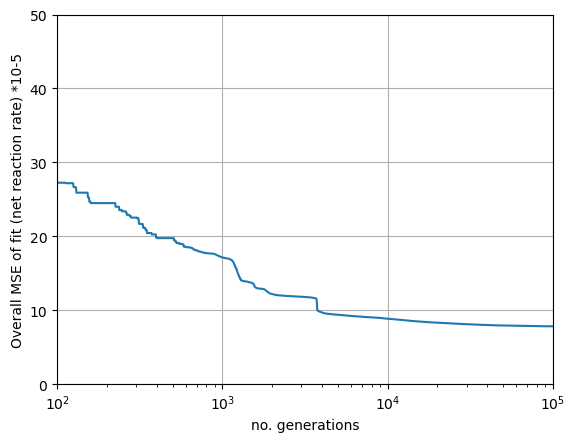

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.806067555433712
1.4013323087849292
0.6620883222856943
-4.337012064429166
0.5064331941397076
6.9423348749864026e-06
0.4150804358632997
-5.110133690700323
0.38048595859228806
4.926338139064899
3.622611012776363
3.7847220208893138
0.410250422385873
0.044555754752912645
2.991844285997591
3.7063561669157174e-06
0.4856721152635675
-11.517657779933275
1.812960733775513
1.5430320575336536
-9.851009436498924
0.998230005731823
3.236642416944759
0.05929498560011083
3.293579976244565
3.287985569028805
1.2771353188898737
7.370300436419997
-9.39113085463897
2.573713132083041
1.6031781064886799
3.2876173275146963
-4.304010272543786
0.5407447319637202
0.9668740125483286
-1.3010299540466868


In [37]:
res.X

array([-1.08060676e+01,  1.40133231e+00,  6.62088322e-01, -4.33701206e+00,
        5.06433194e-01,  6.94233487e-06,  4.15080436e-01, -5.11013369e+00,
        3.80485959e-01,  4.92633814e+00,  3.62261101e+00,  3.78472202e+00,
        4.10250422e-01,  4.45557548e-02,  2.99184429e+00,  3.70635617e-06,
        4.85672115e-01, -1.15176578e+01,  1.81296073e+00,  1.54303206e+00,
       -9.85100944e+00,  9.98230006e-01,  3.23664242e+00,  5.92949856e-02,
        3.29357998e+00,  3.28798557e+00,  1.27713532e+00,  7.37030044e+00,
       -9.39113085e+00,  2.57371313e+00,  1.60317811e+00,  3.28761733e+00,
       -4.30401027e+00,  5.40744732e-01,  9.66874013e-01, -1.30102995e+00])

In [1]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )


-12.0: -10.806067555433712
1.6: 1.4013323087849292
0.9: 0.6620883222856943
-4.3: -4.337012064429166
0.5: 0.5064331941397076
0.003: 6.9423348749864026e-06
0.4: 0.4150804358632997
-7.9: -5.110133690700323
0.7: 0.38048595859228806
7.2: 4.926338139064899
5.7: 3.622611012776363
5.7: 3.7847220208893138
0.8: 0.410250422385873
0.03: 0.044555754752912645
3.1: 2.991844285997591
6.000000000000001e-09: 3.7063561669157174e-06
0.1: 0.4856721152635675
-12.0: -11.517657779933275
1.9: 1.812960733775513
1.6: 1.5430320575336536
-11.6: -9.851009436498924
1.2: 0.998230005731823
4.0: 3.236642416944759
0.01: 0.05929498560011083
4.2: 3.293579976244565
5.4: 3.287985569028805
2.2: 1.2771353188898737
11.8: 7.370300436419997
-12.0: -9.39113085463897
3.3: 2.573713132083041
1.8: 1.6031781064886799
4.2: 3.2876173275146963
-4.0: -4.304010272543786
0.5: 0.5407447319637202
1.0: 0.9668740125483286
coeff fit: 0.9415534968658409


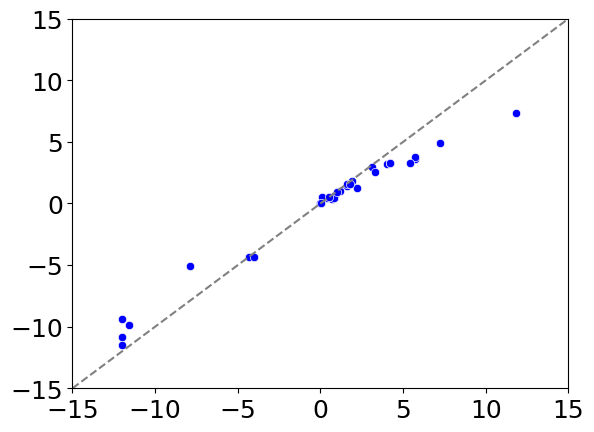

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

resX=[-1.08060676e+01,  1.40133231e+00,  6.62088322e-01, -4.33701206e+00,
        5.06433194e-01,  6.94233487e-06,  4.15080436e-01, -5.11013369e+00,
        3.80485959e-01,  4.92633814e+00,  3.62261101e+00,  3.78472202e+00,
        4.10250422e-01,  4.45557548e-02,  2.99184429e+00,  3.70635617e-06,
        4.85672115e-01, -1.15176578e+01,  1.81296073e+00,  1.54303206e+00,
       -9.85100944e+00,  9.98230006e-01,  3.23664242e+00,  5.92949856e-02,
        3.29357998e+00,  3.28798557e+00,  1.27713532e+00,  7.37030044e+00,
       -9.39113085e+00,  2.57371313e+00,  1.60317811e+00,  3.28761733e+00,
       -4.30401027e+00,  5.40744732e-01,  9.66874013e-01]

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= resX, color='blue') #, label='Data Points')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 


# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()